In [1]:
import os
from pathlib import Path
import pickle

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images


In [2]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7
#     volume_feature_blocks = 1


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 12
    popular_days = 7
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7
    volume_feature_blocks = 2

In [5]:
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks+1}.pkl")
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks}.pkl")

In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1


volume: 12354253


duplicates: 1.0596052180843134


            strategy   volume     ratio
0  same_product_code  6876142  0.556581
1         repurchase  3446562  0.278978
2               cooc  1203741  0.097435
3                pop   827808  0.067006


week: 2


volume: 13148159


duplicates: 1.0663447719892427


            strategy   volume     ratio
0  same_product_code  7228749  0.549792
1         repurchase  3637145  0.276628
2               cooc  1418037  0.107851
3                pop   864228  0.065730


week: 3


volume: 13922204


duplicates: 1.0692281686575584


            strategy   volume     ratio
0  same_product_code  7678831  0.551553
1         repurchase  3742824  0.268838
2               cooc  1590685  0.114255
3                pop   909864  0.065353


week: 4


volume: 14853722


duplicates: 1.0730213586103197


            strategy   volume     ratio
0  same_product_code  8177755  0.550553
1         repurchase  3915353  0.263594
2               cooc  1797578  0.121019
3                pop   963036  0.064835


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0


Recall: 0.10367382841742775


            strategy       y   volume    recall  hit_ratio
0         repurchase  8437.0  3446562  0.039475   0.002448
1  same_product_code  7888.0  6876142  0.036907   0.001147
2               cooc  5096.0  1203741  0.023843   0.004233
3                pop  4833.0   827808  0.022613   0.005838
week: 1


Recall: 0.09945592558466061


            strategy       y   volume    recall  hit_ratio
0         repurchase  8955.0  3637145  0.039292   0.002462
1  same_product_code  8554.0  7228749  0.037532   0.001183
2               cooc  5210.0  1418037  0.022860   0.003674
3                pop  4539.0   864228  0.019916   0.005252
week: 2


Recall: 0.101040012769139


            strategy       y   volume    recall  hit_ratio
0         repurchase  9195.0  3742824  0.038622   0.002457
1  same_product_code  8829.0  7678831  0.037085   0.001150
2               cooc  5376.0  1590685  0.022581   0.003380
3                pop  5342.0   909864  0.022438   0.005871
week: 3


Recall: 0.09409339582712836


            strategy       y   volume    recall  hit_ratio
0  same_product_code  9328.0  8177755  0.036556   0.001141
1         repurchase  9002.0  3915353  0.035278   0.002299
2               cooc  5609.0  1797578  0.021981   0.003120
3                pop  4984.0   963036  0.019532   0.005175


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 12354253 -> 3469506


drop trivial queries: 13148159 -> 3681372


drop trivial queries: 13922204 -> 3919804


drop trivial queries: 14853722 -> 3965310


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['age']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name=f'item_volume_{i}')
        df = df.merge(tmp, on='item', how='left')

    # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # user volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name=f'user_volume_{i}')
        df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    lfm_path = ARTIFACTS_DIR / f"lfm_{dataset}_{pretrain_week}.pkl"

    with open(lfm_path, 'rb') as f:
        lfm = pickle.load(f)
    no_components = lfm.get_params()['no_components']

    # df['lfm'] = lfm.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    user_reps = np.hstack([lfm.user_embeddings, lfm.user_biases.reshape((len(users), 1))])
    user_reps = pd.DataFrame(user_reps, columns=[f'user_rep_{i}' for i in range(no_components+1)])
    user_reps = pd.concat([pd.DataFrame({'user': range(len(users))}), user_reps], axis=1)
    df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

week: 1


week: 1


week: 2


week: 3


week: 4


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume_0', 'item_volume_1', 'user_volume_0', 'user_volume_1', 'user_item_day_min', 'user_item_volume_x', 'user_item_volume_y', 'user_rep_0', 'user_rep_1', 'user_rep_2', 'user_rep_3', 'user_rep_4', 'user_rep_5', 'user_rep_6', 'user_rep

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

ORDINAL

In [17]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
    'iterations': 3000,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.1654768	best: 0.1654768 (0)	total: 1.48s	remaining: 1h 14m 12s


1:	test: 0.1815447	best: 0.1815447 (1)	total: 2.9s	remaining: 1h 12m 33s


2:	test: 0.1826158	best: 0.1826158 (2)	total: 4.29s	remaining: 1h 11m 24s


3:	test: 0.2375681	best: 0.2375681 (3)	total: 5.69s	remaining: 1h 10m 59s


4:	test: 0.2503299	best: 0.2503299 (4)	total: 7.07s	remaining: 1h 10m 36s


5:	test: 0.2565821	best: 0.2565821 (5)	total: 8.47s	remaining: 1h 10m 25s


6:	test: 0.2777987	best: 0.2777987 (6)	total: 9.88s	remaining: 1h 10m 23s


7:	test: 0.2775821	best: 0.2777987 (6)	total: 11.3s	remaining: 1h 10m 16s


8:	test: 0.2802434	best: 0.2802434 (8)	total: 12.7s	remaining: 1h 10m 13s


9:	test: 0.2805825	best: 0.2805825 (9)	total: 14.1s	remaining: 1h 10m 12s


10:	test: 0.2868128	best: 0.2868128 (10)	total: 15.5s	remaining: 1h 10m 8s


11:	test: 0.2850211	best: 0.2868128 (10)	total: 16.9s	remaining: 1h 10m 4s


12:	test: 0.2858226	best: 0.2868128 (10)	total: 18.3s	remaining: 1h 10m 2s


13:	test: 0.2881001	best: 0.2881001 (13)	total: 19.7s	remaining: 1h 10m 2s


14:	test: 0.2958381	best: 0.2958381 (14)	total: 21.1s	remaining: 1h 10m 2s


15:	test: 0.2986657	best: 0.2986657 (15)	total: 22.5s	remaining: 1h 10m 1s


16:	test: 0.3141955	best: 0.3141955 (16)	total: 23.9s	remaining: 1h 9m 59s


17:	test: 0.3152682	best: 0.3152682 (17)	total: 25.4s	remaining: 1h 10m 6s


18:	test: 0.3150851	best: 0.3152682 (17)	total: 26.8s	remaining: 1h 10m 4s


19:	test: 0.3154141	best: 0.3154141 (19)	total: 28.2s	remaining: 1h 10m 2s


20:	test: 0.3163413	best: 0.3163413 (20)	total: 29.6s	remaining: 1h 10m


21:	test: 0.3169797	best: 0.3169797 (21)	total: 31s	remaining: 1h 10m 1s


22:	test: 0.3190618	best: 0.3190618 (22)	total: 32.5s	remaining: 1h 10m


23:	test: 0.3258476	best: 0.3258476 (23)	total: 33.9s	remaining: 1h 9m 57s


24:	test: 0.3276062	best: 0.3276062 (24)	total: 35.3s	remaining: 1h 10m 3s


25:	test: 0.3280817	best: 0.3280817 (25)	total: 36.8s	remaining: 1h 10m 8s


26:	test: 0.3321077	best: 0.3321077 (26)	total: 38.2s	remaining: 1h 10m 6s


27:	test: 0.3325820	best: 0.3325820 (27)	total: 39.6s	remaining: 1h 10m 6s


28:	test: 0.3334503	best: 0.3334503 (28)	total: 41s	remaining: 1h 10m 5s


29:	test: 0.3346620	best: 0.3346620 (29)	total: 42.5s	remaining: 1h 10m 2s


30:	test: 0.3362083	best: 0.3362083 (30)	total: 43.9s	remaining: 1h 10m 6s


31:	test: 0.3402975	best: 0.3402975 (31)	total: 45.3s	remaining: 1h 10m 5s


32:	test: 0.3402407	best: 0.3402975 (31)	total: 46.8s	remaining: 1h 10m 7s


33:	test: 0.3456812	best: 0.3456812 (33)	total: 48.2s	remaining: 1h 10m 3s


34:	test: 0.3454058	best: 0.3456812 (33)	total: 49.6s	remaining: 1h 10m 1s


35:	test: 0.3460278	best: 0.3460278 (35)	total: 51.1s	remaining: 1h 10m 5s


36:	test: 0.3463674	best: 0.3463674 (36)	total: 52.5s	remaining: 1h 10m 4s


37:	test: 0.3474582	best: 0.3474582 (37)	total: 53.9s	remaining: 1h 10m 2s


38:	test: 0.3471685	best: 0.3474582 (37)	total: 55.4s	remaining: 1h 10m 4s


39:	test: 0.3472246	best: 0.3474582 (37)	total: 56.9s	remaining: 1h 10m 7s


40:	test: 0.3476112	best: 0.3476112 (40)	total: 58.3s	remaining: 1h 10m 9s


41:	test: 0.3478050	best: 0.3478050 (41)	total: 59.8s	remaining: 1h 10m 8s


42:	test: 0.3476480	best: 0.3478050 (41)	total: 1m 1s	remaining: 1h 10m 9s


43:	test: 0.3473420	best: 0.3478050 (41)	total: 1m 2s	remaining: 1h 10m 8s


44:	test: 0.3481893	best: 0.3481893 (44)	total: 1m 4s	remaining: 1h 10m 6s


45:	test: 0.3482230	best: 0.3482230 (45)	total: 1m 5s	remaining: 1h 10m 4s


46:	test: 0.3490489	best: 0.3490489 (46)	total: 1m 6s	remaining: 1h 10m 2s


47:	test: 0.3525699	best: 0.3525699 (47)	total: 1m 8s	remaining: 1h 9m 59s


48:	test: 0.3531581	best: 0.3531581 (48)	total: 1m 9s	remaining: 1h 9m 56s


49:	test: 0.3532126	best: 0.3532126 (49)	total: 1m 11s	remaining: 1h 9m 57s


50:	test: 0.3530537	best: 0.3532126 (49)	total: 1m 12s	remaining: 1h 9m 58s


51:	test: 0.3584389	best: 0.3584389 (51)	total: 1m 14s	remaining: 1h 9m 56s


52:	test: 0.3593928	best: 0.3593928 (52)	total: 1m 15s	remaining: 1h 9m 56s


53:	test: 0.3592487	best: 0.3593928 (52)	total: 1m 16s	remaining: 1h 9m 55s


54:	test: 0.3606575	best: 0.3606575 (54)	total: 1m 18s	remaining: 1h 9m 54s


55:	test: 0.3612031	best: 0.3612031 (55)	total: 1m 19s	remaining: 1h 9m 51s


56:	test: 0.3625318	best: 0.3625318 (56)	total: 1m 21s	remaining: 1h 9m 48s


57:	test: 0.3630055	best: 0.3630055 (57)	total: 1m 22s	remaining: 1h 9m 45s


58:	test: 0.3634405	best: 0.3634405 (58)	total: 1m 23s	remaining: 1h 9m 45s


59:	test: 0.3636754	best: 0.3636754 (59)	total: 1m 25s	remaining: 1h 9m 44s


60:	test: 0.3650182	best: 0.3650182 (60)	total: 1m 26s	remaining: 1h 9m 43s


61:	test: 0.3648423	best: 0.3650182 (60)	total: 1m 28s	remaining: 1h 9m 40s


62:	test: 0.3655173	best: 0.3655173 (62)	total: 1m 29s	remaining: 1h 9m 38s


63:	test: 0.3657115	best: 0.3657115 (63)	total: 1m 31s	remaining: 1h 9m 35s


64:	test: 0.3663905	best: 0.3663905 (64)	total: 1m 32s	remaining: 1h 9m 35s


65:	test: 0.3669361	best: 0.3669361 (65)	total: 1m 33s	remaining: 1h 9m 35s


66:	test: 0.3674393	best: 0.3674393 (66)	total: 1m 35s	remaining: 1h 9m 35s


67:	test: 0.3676390	best: 0.3676390 (67)	total: 1m 36s	remaining: 1h 9m 32s


68:	test: 0.3677793	best: 0.3677793 (68)	total: 1m 38s	remaining: 1h 9m 30s


69:	test: 0.3680875	best: 0.3680875 (69)	total: 1m 39s	remaining: 1h 9m 29s


70:	test: 0.3689720	best: 0.3689720 (70)	total: 1m 41s	remaining: 1h 9m 29s


71:	test: 0.3689456	best: 0.3689720 (70)	total: 1m 42s	remaining: 1h 9m 25s


72:	test: 0.3694537	best: 0.3694537 (72)	total: 1m 43s	remaining: 1h 9m 26s


73:	test: 0.3696780	best: 0.3696780 (73)	total: 1m 45s	remaining: 1h 9m 23s


74:	test: 0.3696266	best: 0.3696780 (73)	total: 1m 46s	remaining: 1h 9m 23s


75:	test: 0.3699802	best: 0.3699802 (75)	total: 1m 48s	remaining: 1h 9m 22s


76:	test: 0.3707288	best: 0.3707288 (76)	total: 1m 49s	remaining: 1h 9m 21s


77:	test: 0.3709959	best: 0.3709959 (77)	total: 1m 51s	remaining: 1h 9m 20s


78:	test: 0.3711725	best: 0.3711725 (78)	total: 1m 52s	remaining: 1h 9m 18s


79:	test: 0.3714264	best: 0.3714264 (79)	total: 1m 53s	remaining: 1h 9m 17s


80:	test: 0.3717101	best: 0.3717101 (80)	total: 1m 55s	remaining: 1h 9m 15s


81:	test: 0.3721999	best: 0.3721999 (81)	total: 1m 56s	remaining: 1h 9m 12s


82:	test: 0.3722761	best: 0.3722761 (82)	total: 1m 58s	remaining: 1h 9m 12s


83:	test: 0.3723289	best: 0.3723289 (83)	total: 1m 59s	remaining: 1h 9m 11s


84:	test: 0.3728960	best: 0.3728960 (84)	total: 2m 1s	remaining: 1h 9m 10s


85:	test: 0.3733179	best: 0.3733179 (85)	total: 2m 2s	remaining: 1h 9m 9s


86:	test: 0.3735311	best: 0.3735311 (86)	total: 2m 3s	remaining: 1h 9m 6s


87:	test: 0.3737847	best: 0.3737847 (87)	total: 2m 5s	remaining: 1h 9m 2s


88:	test: 0.3740875	best: 0.3740875 (88)	total: 2m 6s	remaining: 1h 9m 2s


89:	test: 0.3742117	best: 0.3742117 (89)	total: 2m 8s	remaining: 1h 9m 1s


90:	test: 0.3765430	best: 0.3765430 (90)	total: 2m 9s	remaining: 1h 8m 59s


91:	test: 0.3759131	best: 0.3765430 (90)	total: 2m 10s	remaining: 1h 8m 57s


92:	test: 0.3766353	best: 0.3766353 (92)	total: 2m 12s	remaining: 1h 8m 56s


93:	test: 0.3766948	best: 0.3766948 (93)	total: 2m 13s	remaining: 1h 8m 54s


94:	test: 0.3770386	best: 0.3770386 (94)	total: 2m 15s	remaining: 1h 8m 54s


95:	test: 0.3772216	best: 0.3772216 (95)	total: 2m 16s	remaining: 1h 8m 53s


96:	test: 0.3774767	best: 0.3774767 (96)	total: 2m 18s	remaining: 1h 8m 52s


97:	test: 0.3778840	best: 0.3778840 (97)	total: 2m 19s	remaining: 1h 8m 51s


98:	test: 0.3780103	best: 0.3780103 (98)	total: 2m 20s	remaining: 1h 8m 50s


99:	test: 0.3782556	best: 0.3782556 (99)	total: 2m 22s	remaining: 1h 8m 50s


100:	test: 0.3783506	best: 0.3783506 (100)	total: 2m 23s	remaining: 1h 8m 48s


101:	test: 0.3795275	best: 0.3795275 (101)	total: 2m 25s	remaining: 1h 8m 49s


102:	test: 0.3794987	best: 0.3795275 (101)	total: 2m 26s	remaining: 1h 8m 48s


103:	test: 0.3796065	best: 0.3796065 (103)	total: 2m 28s	remaining: 1h 8m 47s


104:	test: 0.3796429	best: 0.3796429 (104)	total: 2m 29s	remaining: 1h 8m 45s


105:	test: 0.3796947	best: 0.3796947 (105)	total: 2m 31s	remaining: 1h 8m 44s


106:	test: 0.3799261	best: 0.3799261 (106)	total: 2m 32s	remaining: 1h 8m 43s


107:	test: 0.3801781	best: 0.3801781 (107)	total: 2m 33s	remaining: 1h 8m 42s


108:	test: 0.3803847	best: 0.3803847 (108)	total: 2m 35s	remaining: 1h 8m 40s


109:	test: 0.3808731	best: 0.3808731 (109)	total: 2m 36s	remaining: 1h 8m 40s


110:	test: 0.3809558	best: 0.3809558 (110)	total: 2m 38s	remaining: 1h 8m 43s


111:	test: 0.3804421	best: 0.3809558 (110)	total: 2m 39s	remaining: 1h 8m 41s


112:	test: 0.3804421	best: 0.3809558 (110)	total: 2m 41s	remaining: 1h 8m 40s


113:	test: 0.3807649	best: 0.3809558 (110)	total: 2m 42s	remaining: 1h 8m 39s


114:	test: 0.3808001	best: 0.3809558 (110)	total: 2m 44s	remaining: 1h 8m 36s


115:	test: 0.3808591	best: 0.3809558 (110)	total: 2m 45s	remaining: 1h 8m 34s


116:	test: 0.3817622	best: 0.3817622 (116)	total: 2m 46s	remaining: 1h 8m 34s


117:	test: 0.3821706	best: 0.3821706 (117)	total: 2m 48s	remaining: 1h 8m 34s


118:	test: 0.3823063	best: 0.3823063 (118)	total: 2m 49s	remaining: 1h 8m 32s


119:	test: 0.3825095	best: 0.3825095 (119)	total: 2m 51s	remaining: 1h 8m 31s


120:	test: 0.3828002	best: 0.3828002 (120)	total: 2m 52s	remaining: 1h 8m 29s


121:	test: 0.3831492	best: 0.3831492 (121)	total: 2m 54s	remaining: 1h 8m 27s


122:	test: 0.3833175	best: 0.3833175 (122)	total: 2m 55s	remaining: 1h 8m 25s


123:	test: 0.3833685	best: 0.3833685 (123)	total: 2m 56s	remaining: 1h 8m 25s


124:	test: 0.3847152	best: 0.3847152 (124)	total: 2m 58s	remaining: 1h 8m 23s


125:	test: 0.3848043	best: 0.3848043 (125)	total: 2m 59s	remaining: 1h 8m 22s


126:	test: 0.3850721	best: 0.3850721 (126)	total: 3m 1s	remaining: 1h 8m 21s


127:	test: 0.3851005	best: 0.3851005 (127)	total: 3m 2s	remaining: 1h 8m 20s


128:	test: 0.3852573	best: 0.3852573 (128)	total: 3m 4s	remaining: 1h 8m 19s


129:	test: 0.3854124	best: 0.3854124 (129)	total: 3m 5s	remaining: 1h 8m 18s


130:	test: 0.3856552	best: 0.3856552 (130)	total: 3m 7s	remaining: 1h 8m 16s


131:	test: 0.3860090	best: 0.3860090 (131)	total: 3m 8s	remaining: 1h 8m 15s


132:	test: 0.3861702	best: 0.3861702 (132)	total: 3m 9s	remaining: 1h 8m 14s


133:	test: 0.3865049	best: 0.3865049 (133)	total: 3m 11s	remaining: 1h 8m 14s


134:	test: 0.3864814	best: 0.3865049 (133)	total: 3m 12s	remaining: 1h 8m 12s


135:	test: 0.3866746	best: 0.3866746 (135)	total: 3m 14s	remaining: 1h 8m 11s


136:	test: 0.3867477	best: 0.3867477 (136)	total: 3m 15s	remaining: 1h 8m 9s


137:	test: 0.3869777	best: 0.3869777 (137)	total: 3m 17s	remaining: 1h 8m 9s


138:	test: 0.3872450	best: 0.3872450 (138)	total: 3m 18s	remaining: 1h 8m 9s


139:	test: 0.3871661	best: 0.3872450 (138)	total: 3m 20s	remaining: 1h 8m 7s


140:	test: 0.3873368	best: 0.3873368 (140)	total: 3m 21s	remaining: 1h 8m 5s


141:	test: 0.3878279	best: 0.3878279 (141)	total: 3m 22s	remaining: 1h 8m 5s


142:	test: 0.3880817	best: 0.3880817 (142)	total: 3m 24s	remaining: 1h 8m 5s


143:	test: 0.3883976	best: 0.3883976 (143)	total: 3m 25s	remaining: 1h 8m 4s


144:	test: 0.3884910	best: 0.3884910 (144)	total: 3m 27s	remaining: 1h 8m 2s


145:	test: 0.3886231	best: 0.3886231 (145)	total: 3m 28s	remaining: 1h 8m 1s


146:	test: 0.3886434	best: 0.3886434 (146)	total: 3m 30s	remaining: 1h 8m


147:	test: 0.3888436	best: 0.3888436 (147)	total: 3m 31s	remaining: 1h 7m 59s


148:	test: 0.3890722	best: 0.3890722 (148)	total: 3m 33s	remaining: 1h 7m 59s


149:	test: 0.3891814	best: 0.3891814 (149)	total: 3m 34s	remaining: 1h 7m 58s


150:	test: 0.3893458	best: 0.3893458 (150)	total: 3m 36s	remaining: 1h 7m 57s


151:	test: 0.3894328	best: 0.3894328 (151)	total: 3m 37s	remaining: 1h 7m 55s


152:	test: 0.3893645	best: 0.3894328 (151)	total: 3m 38s	remaining: 1h 7m 54s


153:	test: 0.3893669	best: 0.3894328 (151)	total: 3m 40s	remaining: 1h 7m 52s


154:	test: 0.3895565	best: 0.3895565 (154)	total: 3m 41s	remaining: 1h 7m 51s


155:	test: 0.3896209	best: 0.3896209 (155)	total: 3m 43s	remaining: 1h 7m 49s


156:	test: 0.3899352	best: 0.3899352 (156)	total: 3m 44s	remaining: 1h 7m 48s


157:	test: 0.3899846	best: 0.3899846 (157)	total: 3m 46s	remaining: 1h 7m 47s


158:	test: 0.3899354	best: 0.3899846 (157)	total: 3m 47s	remaining: 1h 7m 46s


159:	test: 0.3901177	best: 0.3901177 (159)	total: 3m 49s	remaining: 1h 7m 44s


160:	test: 0.3901455	best: 0.3901455 (160)	total: 3m 50s	remaining: 1h 7m 43s


161:	test: 0.3902382	best: 0.3902382 (161)	total: 3m 51s	remaining: 1h 7m 42s


162:	test: 0.3906770	best: 0.3906770 (162)	total: 3m 53s	remaining: 1h 7m 42s


163:	test: 0.3908113	best: 0.3908113 (163)	total: 3m 54s	remaining: 1h 7m 41s


164:	test: 0.3908931	best: 0.3908931 (164)	total: 3m 56s	remaining: 1h 7m 40s


165:	test: 0.3909547	best: 0.3909547 (165)	total: 3m 57s	remaining: 1h 7m 39s


166:	test: 0.3911678	best: 0.3911678 (166)	total: 3m 59s	remaining: 1h 7m 37s


167:	test: 0.3911281	best: 0.3911678 (166)	total: 4m	remaining: 1h 7m 35s


168:	test: 0.3912647	best: 0.3912647 (168)	total: 4m 1s	remaining: 1h 7m 33s


169:	test: 0.3912958	best: 0.3912958 (169)	total: 4m 3s	remaining: 1h 7m 31s


170:	test: 0.3914839	best: 0.3914839 (170)	total: 4m 4s	remaining: 1h 7m 30s


171:	test: 0.3915885	best: 0.3915885 (171)	total: 4m 6s	remaining: 1h 7m 29s


172:	test: 0.3915013	best: 0.3915885 (171)	total: 4m 7s	remaining: 1h 7m 27s


173:	test: 0.3915338	best: 0.3915885 (171)	total: 4m 9s	remaining: 1h 7m 25s


174:	test: 0.3916145	best: 0.3916145 (174)	total: 4m 10s	remaining: 1h 7m 23s


175:	test: 0.3918759	best: 0.3918759 (175)	total: 4m 11s	remaining: 1h 7m 22s


176:	test: 0.3922331	best: 0.3922331 (176)	total: 4m 13s	remaining: 1h 7m 20s


177:	test: 0.3924108	best: 0.3924108 (177)	total: 4m 14s	remaining: 1h 7m 19s


178:	test: 0.3925443	best: 0.3925443 (178)	total: 4m 16s	remaining: 1h 7m 18s


179:	test: 0.3925935	best: 0.3925935 (179)	total: 4m 17s	remaining: 1h 7m 16s


180:	test: 0.3925906	best: 0.3925935 (179)	total: 4m 19s	remaining: 1h 7m 14s


181:	test: 0.3926043	best: 0.3926043 (181)	total: 4m 20s	remaining: 1h 7m 13s


182:	test: 0.3927734	best: 0.3927734 (182)	total: 4m 22s	remaining: 1h 7m 13s


183:	test: 0.3929680	best: 0.3929680 (183)	total: 4m 23s	remaining: 1h 7m 11s


184:	test: 0.3929675	best: 0.3929680 (183)	total: 4m 24s	remaining: 1h 7m 9s


185:	test: 0.3930340	best: 0.3930340 (185)	total: 4m 26s	remaining: 1h 7m 8s


186:	test: 0.3931363	best: 0.3931363 (186)	total: 4m 27s	remaining: 1h 7m 7s


187:	test: 0.3933527	best: 0.3933527 (187)	total: 4m 29s	remaining: 1h 7m 6s


188:	test: 0.3933988	best: 0.3933988 (188)	total: 4m 30s	remaining: 1h 7m 5s


189:	test: 0.3936614	best: 0.3936614 (189)	total: 4m 32s	remaining: 1h 7m 4s


190:	test: 0.3936840	best: 0.3936840 (190)	total: 4m 33s	remaining: 1h 7m 2s


191:	test: 0.3936851	best: 0.3936851 (191)	total: 4m 34s	remaining: 1h 7m


192:	test: 0.3937021	best: 0.3937021 (192)	total: 4m 36s	remaining: 1h 6m 59s


193:	test: 0.3937492	best: 0.3937492 (193)	total: 4m 37s	remaining: 1h 6m 58s


194:	test: 0.3937500	best: 0.3937500 (194)	total: 4m 39s	remaining: 1h 6m 57s


195:	test: 0.3938384	best: 0.3938384 (195)	total: 4m 40s	remaining: 1h 6m 56s


196:	test: 0.3938711	best: 0.3938711 (196)	total: 4m 42s	remaining: 1h 6m 54s


197:	test: 0.3940202	best: 0.3940202 (197)	total: 4m 43s	remaining: 1h 6m 54s


198:	test: 0.3941316	best: 0.3941316 (198)	total: 4m 45s	remaining: 1h 6m 52s


199:	test: 0.3941324	best: 0.3941324 (199)	total: 4m 46s	remaining: 1h 6m 50s


200:	test: 0.3944573	best: 0.3944573 (200)	total: 4m 47s	remaining: 1h 6m 49s


201:	test: 0.3948264	best: 0.3948264 (201)	total: 4m 49s	remaining: 1h 6m 47s


202:	test: 0.3948522	best: 0.3948522 (202)	total: 4m 50s	remaining: 1h 6m 45s


203:	test: 0.3948903	best: 0.3948903 (203)	total: 4m 52s	remaining: 1h 6m 43s


204:	test: 0.3949193	best: 0.3949193 (204)	total: 4m 53s	remaining: 1h 6m 41s


205:	test: 0.3950988	best: 0.3950988 (205)	total: 4m 54s	remaining: 1h 6m 40s


206:	test: 0.3950966	best: 0.3950988 (205)	total: 4m 56s	remaining: 1h 6m 38s


207:	test: 0.3951768	best: 0.3951768 (207)	total: 4m 57s	remaining: 1h 6m 37s


208:	test: 0.3951433	best: 0.3951768 (207)	total: 4m 59s	remaining: 1h 6m 36s


209:	test: 0.3951618	best: 0.3951768 (207)	total: 5m	remaining: 1h 6m 35s


210:	test: 0.3952291	best: 0.3952291 (210)	total: 5m 2s	remaining: 1h 6m 33s


211:	test: 0.3952692	best: 0.3952692 (211)	total: 5m 3s	remaining: 1h 6m 31s


212:	test: 0.3954055	best: 0.3954055 (212)	total: 5m 5s	remaining: 1h 6m 31s


213:	test: 0.3955085	best: 0.3955085 (213)	total: 5m 6s	remaining: 1h 6m 29s


214:	test: 0.3956388	best: 0.3956388 (214)	total: 5m 7s	remaining: 1h 6m 27s


215:	test: 0.3957857	best: 0.3957857 (215)	total: 5m 9s	remaining: 1h 6m 26s


216:	test: 0.3958009	best: 0.3958009 (216)	total: 5m 10s	remaining: 1h 6m 24s


217:	test: 0.3958936	best: 0.3958936 (217)	total: 5m 12s	remaining: 1h 6m 23s


218:	test: 0.3960419	best: 0.3960419 (218)	total: 5m 13s	remaining: 1h 6m 22s


219:	test: 0.3960322	best: 0.3960419 (218)	total: 5m 15s	remaining: 1h 6m 20s


220:	test: 0.3962534	best: 0.3962534 (220)	total: 5m 16s	remaining: 1h 6m 18s


221:	test: 0.3964901	best: 0.3964901 (221)	total: 5m 17s	remaining: 1h 6m 18s


222:	test: 0.3967668	best: 0.3967668 (222)	total: 5m 19s	remaining: 1h 6m 16s


223:	test: 0.3971261	best: 0.3971261 (223)	total: 5m 20s	remaining: 1h 6m 15s


224:	test: 0.3971507	best: 0.3971507 (224)	total: 5m 22s	remaining: 1h 6m 14s


225:	test: 0.3971539	best: 0.3971539 (225)	total: 5m 23s	remaining: 1h 6m 12s


226:	test: 0.3973806	best: 0.3973806 (226)	total: 5m 25s	remaining: 1h 6m 11s


227:	test: 0.3972825	best: 0.3973806 (226)	total: 5m 26s	remaining: 1h 6m 9s


228:	test: 0.3972852	best: 0.3973806 (226)	total: 5m 27s	remaining: 1h 6m 8s


229:	test: 0.3974305	best: 0.3974305 (229)	total: 5m 29s	remaining: 1h 6m 7s


230:	test: 0.3975699	best: 0.3975699 (230)	total: 5m 30s	remaining: 1h 6m 6s


231:	test: 0.3975949	best: 0.3975949 (231)	total: 5m 32s	remaining: 1h 6m 4s


232:	test: 0.3976596	best: 0.3976596 (232)	total: 5m 33s	remaining: 1h 6m 4s


233:	test: 0.3978050	best: 0.3978050 (233)	total: 5m 35s	remaining: 1h 6m 2s


234:	test: 0.3978549	best: 0.3978549 (234)	total: 5m 36s	remaining: 1h 6m 1s


235:	test: 0.3978771	best: 0.3978771 (235)	total: 5m 38s	remaining: 1h 6m


236:	test: 0.3978531	best: 0.3978771 (235)	total: 5m 39s	remaining: 1h 5m 58s


237:	test: 0.3977829	best: 0.3978771 (235)	total: 5m 40s	remaining: 1h 5m 56s


238:	test: 0.3978533	best: 0.3978771 (235)	total: 5m 42s	remaining: 1h 5m 55s


239:	test: 0.3979053	best: 0.3979053 (239)	total: 5m 43s	remaining: 1h 5m 53s


240:	test: 0.3979856	best: 0.3979856 (240)	total: 5m 45s	remaining: 1h 5m 52s


241:	test: 0.3981218	best: 0.3981218 (241)	total: 5m 46s	remaining: 1h 5m 50s


242:	test: 0.3980950	best: 0.3981218 (241)	total: 5m 48s	remaining: 1h 5m 48s


243:	test: 0.3982447	best: 0.3982447 (243)	total: 5m 49s	remaining: 1h 5m 47s


244:	test: 0.3982637	best: 0.3982637 (244)	total: 5m 50s	remaining: 1h 5m 45s


245:	test: 0.3981217	best: 0.3982637 (244)	total: 5m 52s	remaining: 1h 5m 44s


246:	test: 0.3982016	best: 0.3982637 (244)	total: 5m 53s	remaining: 1h 5m 42s


247:	test: 0.3983033	best: 0.3983033 (247)	total: 5m 55s	remaining: 1h 5m 41s


248:	test: 0.3983134	best: 0.3983134 (248)	total: 5m 56s	remaining: 1h 5m 40s


249:	test: 0.3983347	best: 0.3983347 (249)	total: 5m 58s	remaining: 1h 5m 38s


250:	test: 0.3984768	best: 0.3984768 (250)	total: 5m 59s	remaining: 1h 5m 37s


251:	test: 0.3985216	best: 0.3985216 (251)	total: 6m	remaining: 1h 5m 36s


252:	test: 0.3985634	best: 0.3985634 (252)	total: 6m 2s	remaining: 1h 5m 34s


253:	test: 0.3986587	best: 0.3986587 (253)	total: 6m 3s	remaining: 1h 5m 32s


254:	test: 0.3986718	best: 0.3986718 (254)	total: 6m 5s	remaining: 1h 5m 30s


255:	test: 0.3987821	best: 0.3987821 (255)	total: 6m 6s	remaining: 1h 5m 29s


256:	test: 0.3987578	best: 0.3987821 (255)	total: 6m 7s	remaining: 1h 5m 27s


257:	test: 0.3989600	best: 0.3989600 (257)	total: 6m 9s	remaining: 1h 5m 26s


258:	test: 0.3990973	best: 0.3990973 (258)	total: 6m 10s	remaining: 1h 5m 25s


259:	test: 0.3992333	best: 0.3992333 (259)	total: 6m 12s	remaining: 1h 5m 23s


260:	test: 0.3992095	best: 0.3992333 (259)	total: 6m 13s	remaining: 1h 5m 22s


261:	test: 0.3991679	best: 0.3992333 (259)	total: 6m 15s	remaining: 1h 5m 21s


262:	test: 0.3992917	best: 0.3992917 (262)	total: 6m 16s	remaining: 1h 5m 20s


263:	test: 0.3994041	best: 0.3994041 (263)	total: 6m 18s	remaining: 1h 5m 19s


264:	test: 0.3993317	best: 0.3994041 (263)	total: 6m 19s	remaining: 1h 5m 18s


265:	test: 0.3993626	best: 0.3994041 (263)	total: 6m 21s	remaining: 1h 5m 16s


266:	test: 0.3994223	best: 0.3994223 (266)	total: 6m 22s	remaining: 1h 5m 14s


267:	test: 0.3994496	best: 0.3994496 (267)	total: 6m 23s	remaining: 1h 5m 13s


268:	test: 0.3995847	best: 0.3995847 (268)	total: 6m 25s	remaining: 1h 5m 12s


269:	test: 0.3995664	best: 0.3995847 (268)	total: 6m 26s	remaining: 1h 5m 11s


270:	test: 0.3995704	best: 0.3995847 (268)	total: 6m 28s	remaining: 1h 5m 9s


271:	test: 0.3996574	best: 0.3996574 (271)	total: 6m 29s	remaining: 1h 5m 7s


272:	test: 0.3997486	best: 0.3997486 (272)	total: 6m 31s	remaining: 1h 5m 6s


273:	test: 0.3997422	best: 0.3997486 (272)	total: 6m 32s	remaining: 1h 5m 5s


274:	test: 0.3998298	best: 0.3998298 (274)	total: 6m 33s	remaining: 1h 5m 3s


275:	test: 0.3998767	best: 0.3998767 (275)	total: 6m 35s	remaining: 1h 5m 2s


276:	test: 0.3996832	best: 0.3998767 (275)	total: 6m 36s	remaining: 1h 5m


277:	test: 0.3998716	best: 0.3998767 (275)	total: 6m 38s	remaining: 1h 4m 59s


278:	test: 0.4001606	best: 0.4001606 (278)	total: 6m 39s	remaining: 1h 4m 58s


279:	test: 0.4002077	best: 0.4002077 (279)	total: 6m 41s	remaining: 1h 4m 56s


280:	test: 0.4003675	best: 0.4003675 (280)	total: 6m 42s	remaining: 1h 4m 54s


281:	test: 0.4003036	best: 0.4003675 (280)	total: 6m 44s	remaining: 1h 4m 54s


282:	test: 0.4004913	best: 0.4004913 (282)	total: 6m 45s	remaining: 1h 4m 52s


283:	test: 0.4005312	best: 0.4005312 (283)	total: 6m 46s	remaining: 1h 4m 50s


284:	test: 0.4004834	best: 0.4005312 (283)	total: 6m 48s	remaining: 1h 4m 49s


285:	test: 0.4005474	best: 0.4005474 (285)	total: 6m 49s	remaining: 1h 4m 47s


286:	test: 0.4005417	best: 0.4005474 (285)	total: 6m 51s	remaining: 1h 4m 46s


287:	test: 0.4005742	best: 0.4005742 (287)	total: 6m 52s	remaining: 1h 4m 44s


288:	test: 0.4008462	best: 0.4008462 (288)	total: 6m 53s	remaining: 1h 4m 42s


289:	test: 0.4008272	best: 0.4008462 (288)	total: 6m 55s	remaining: 1h 4m 42s


290:	test: 0.4010545	best: 0.4010545 (290)	total: 6m 56s	remaining: 1h 4m 40s


291:	test: 0.4010995	best: 0.4010995 (291)	total: 6m 58s	remaining: 1h 4m 38s


292:	test: 0.4011592	best: 0.4011592 (292)	total: 6m 59s	remaining: 1h 4m 37s


293:	test: 0.4012929	best: 0.4012929 (293)	total: 7m 1s	remaining: 1h 4m 36s


294:	test: 0.4014161	best: 0.4014161 (294)	total: 7m 2s	remaining: 1h 4m 35s


295:	test: 0.4015352	best: 0.4015352 (295)	total: 7m 4s	remaining: 1h 4m 33s


296:	test: 0.4016823	best: 0.4016823 (296)	total: 7m 5s	remaining: 1h 4m 32s


297:	test: 0.4016657	best: 0.4016823 (296)	total: 7m 6s	remaining: 1h 4m 30s


298:	test: 0.4017417	best: 0.4017417 (298)	total: 7m 8s	remaining: 1h 4m 28s


299:	test: 0.4018792	best: 0.4018792 (299)	total: 7m 9s	remaining: 1h 4m 26s


300:	test: 0.4020004	best: 0.4020004 (300)	total: 7m 11s	remaining: 1h 4m 24s


301:	test: 0.4020698	best: 0.4020698 (301)	total: 7m 12s	remaining: 1h 4m 23s


302:	test: 0.4020787	best: 0.4020787 (302)	total: 7m 13s	remaining: 1h 4m 21s


303:	test: 0.4023401	best: 0.4023401 (303)	total: 7m 15s	remaining: 1h 4m 20s


304:	test: 0.4023375	best: 0.4023401 (303)	total: 7m 16s	remaining: 1h 4m 18s


305:	test: 0.4024786	best: 0.4024786 (305)	total: 7m 18s	remaining: 1h 4m 18s


306:	test: 0.4023805	best: 0.4024786 (305)	total: 7m 19s	remaining: 1h 4m 17s


307:	test: 0.4025256	best: 0.4025256 (307)	total: 7m 21s	remaining: 1h 4m 15s


308:	test: 0.4025373	best: 0.4025373 (308)	total: 7m 22s	remaining: 1h 4m 13s


309:	test: 0.4024995	best: 0.4025373 (308)	total: 7m 24s	remaining: 1h 4m 13s


310:	test: 0.4027949	best: 0.4027949 (310)	total: 7m 25s	remaining: 1h 4m 11s


311:	test: 0.4026830	best: 0.4027949 (310)	total: 7m 26s	remaining: 1h 4m 9s


312:	test: 0.4027372	best: 0.4027949 (310)	total: 7m 28s	remaining: 1h 4m 8s


313:	test: 0.4027843	best: 0.4027949 (310)	total: 7m 29s	remaining: 1h 4m 7s


314:	test: 0.4027146	best: 0.4027949 (310)	total: 7m 31s	remaining: 1h 4m 6s


315:	test: 0.4028709	best: 0.4028709 (315)	total: 7m 32s	remaining: 1h 4m 4s


316:	test: 0.4029602	best: 0.4029602 (316)	total: 7m 34s	remaining: 1h 4m 3s


317:	test: 0.4029301	best: 0.4029602 (316)	total: 7m 35s	remaining: 1h 4m 1s


318:	test: 0.4029172	best: 0.4029602 (316)	total: 7m 36s	remaining: 1h 3m 59s


319:	test: 0.4029585	best: 0.4029602 (316)	total: 7m 38s	remaining: 1h 3m 58s


320:	test: 0.4030572	best: 0.4030572 (320)	total: 7m 39s	remaining: 1h 3m 56s


321:	test: 0.4031522	best: 0.4031522 (321)	total: 7m 41s	remaining: 1h 3m 54s


322:	test: 0.4031808	best: 0.4031808 (322)	total: 7m 42s	remaining: 1h 3m 53s


323:	test: 0.4033319	best: 0.4033319 (323)	total: 7m 43s	remaining: 1h 3m 51s


324:	test: 0.4032663	best: 0.4033319 (323)	total: 7m 45s	remaining: 1h 3m 50s


325:	test: 0.4033999	best: 0.4033999 (325)	total: 7m 46s	remaining: 1h 3m 49s


326:	test: 0.4034008	best: 0.4034008 (326)	total: 7m 48s	remaining: 1h 3m 47s


327:	test: 0.4035044	best: 0.4035044 (327)	total: 7m 49s	remaining: 1h 3m 45s


328:	test: 0.4035285	best: 0.4035285 (328)	total: 7m 51s	remaining: 1h 3m 44s


329:	test: 0.4035628	best: 0.4035628 (329)	total: 7m 52s	remaining: 1h 3m 43s


330:	test: 0.4034839	best: 0.4035628 (329)	total: 7m 53s	remaining: 1h 3m 41s


331:	test: 0.4035137	best: 0.4035628 (329)	total: 7m 55s	remaining: 1h 3m 40s


332:	test: 0.4034202	best: 0.4035628 (329)	total: 7m 56s	remaining: 1h 3m 39s


333:	test: 0.4034010	best: 0.4035628 (329)	total: 7m 58s	remaining: 1h 3m 37s


334:	test: 0.4035519	best: 0.4035628 (329)	total: 7m 59s	remaining: 1h 3m 35s


335:	test: 0.4036512	best: 0.4036512 (335)	total: 8m 1s	remaining: 1h 3m 34s


336:	test: 0.4036717	best: 0.4036717 (336)	total: 8m 2s	remaining: 1h 3m 32s


337:	test: 0.4038606	best: 0.4038606 (337)	total: 8m 3s	remaining: 1h 3m 31s


338:	test: 0.4038711	best: 0.4038711 (338)	total: 8m 5s	remaining: 1h 3m 30s


339:	test: 0.4038868	best: 0.4038868 (339)	total: 8m 6s	remaining: 1h 3m 28s


340:	test: 0.4038601	best: 0.4038868 (339)	total: 8m 8s	remaining: 1h 3m 26s


341:	test: 0.4039790	best: 0.4039790 (341)	total: 8m 9s	remaining: 1h 3m 25s


342:	test: 0.4040456	best: 0.4040456 (342)	total: 8m 11s	remaining: 1h 3m 23s


343:	test: 0.4041120	best: 0.4041120 (343)	total: 8m 12s	remaining: 1h 3m 22s


344:	test: 0.4041297	best: 0.4041297 (344)	total: 8m 13s	remaining: 1h 3m 20s


345:	test: 0.4042707	best: 0.4042707 (345)	total: 8m 15s	remaining: 1h 3m 18s


346:	test: 0.4043051	best: 0.4043051 (346)	total: 8m 16s	remaining: 1h 3m 17s


347:	test: 0.4041976	best: 0.4043051 (346)	total: 8m 18s	remaining: 1h 3m 15s


348:	test: 0.4042113	best: 0.4043051 (346)	total: 8m 19s	remaining: 1h 3m 14s


349:	test: 0.4041351	best: 0.4043051 (346)	total: 8m 20s	remaining: 1h 3m 13s


350:	test: 0.4041305	best: 0.4043051 (346)	total: 8m 22s	remaining: 1h 3m 11s


351:	test: 0.4043524	best: 0.4043524 (351)	total: 8m 23s	remaining: 1h 3m 9s


352:	test: 0.4044042	best: 0.4044042 (352)	total: 8m 25s	remaining: 1h 3m 8s


353:	test: 0.4044076	best: 0.4044076 (353)	total: 8m 26s	remaining: 1h 3m 6s


354:	test: 0.4044000	best: 0.4044076 (353)	total: 8m 28s	remaining: 1h 3m 4s


355:	test: 0.4044760	best: 0.4044760 (355)	total: 8m 29s	remaining: 1h 3m 3s


356:	test: 0.4045022	best: 0.4045022 (356)	total: 8m 30s	remaining: 1h 3m 1s


357:	test: 0.4045724	best: 0.4045724 (357)	total: 8m 32s	remaining: 1h 3m


358:	test: 0.4045134	best: 0.4045724 (357)	total: 8m 33s	remaining: 1h 2m 59s


359:	test: 0.4045526	best: 0.4045724 (357)	total: 8m 35s	remaining: 1h 2m 57s


360:	test: 0.4045735	best: 0.4045735 (360)	total: 8m 36s	remaining: 1h 2m 56s


361:	test: 0.4045587	best: 0.4045735 (360)	total: 8m 38s	remaining: 1h 2m 55s


362:	test: 0.4045560	best: 0.4045735 (360)	total: 8m 39s	remaining: 1h 2m 53s


363:	test: 0.4046730	best: 0.4046730 (363)	total: 8m 40s	remaining: 1h 2m 51s


364:	test: 0.4046408	best: 0.4046730 (363)	total: 8m 42s	remaining: 1h 2m 50s


365:	test: 0.4046956	best: 0.4046956 (365)	total: 8m 43s	remaining: 1h 2m 48s


366:	test: 0.4047277	best: 0.4047277 (366)	total: 8m 45s	remaining: 1h 2m 47s


367:	test: 0.4049589	best: 0.4049589 (367)	total: 8m 46s	remaining: 1h 2m 45s


368:	test: 0.4049255	best: 0.4049589 (367)	total: 8m 47s	remaining: 1h 2m 44s


369:	test: 0.4049465	best: 0.4049589 (367)	total: 8m 49s	remaining: 1h 2m 42s


370:	test: 0.4050015	best: 0.4050015 (370)	total: 8m 50s	remaining: 1h 2m 41s


371:	test: 0.4049551	best: 0.4050015 (370)	total: 8m 52s	remaining: 1h 2m 39s


372:	test: 0.4052284	best: 0.4052284 (372)	total: 8m 53s	remaining: 1h 2m 38s


373:	test: 0.4052307	best: 0.4052307 (373)	total: 8m 55s	remaining: 1h 2m 36s


374:	test: 0.4052862	best: 0.4052862 (374)	total: 8m 56s	remaining: 1h 2m 35s


375:	test: 0.4053499	best: 0.4053499 (375)	total: 8m 57s	remaining: 1h 2m 33s


376:	test: 0.4054468	best: 0.4054468 (376)	total: 8m 59s	remaining: 1h 2m 32s


377:	test: 0.4055838	best: 0.4055838 (377)	total: 9m	remaining: 1h 2m 30s


378:	test: 0.4057116	best: 0.4057116 (378)	total: 9m 2s	remaining: 1h 2m 29s


379:	test: 0.4056961	best: 0.4057116 (378)	total: 9m 3s	remaining: 1h 2m 27s


380:	test: 0.4056988	best: 0.4057116 (378)	total: 9m 4s	remaining: 1h 2m 25s


381:	test: 0.4057301	best: 0.4057301 (381)	total: 9m 6s	remaining: 1h 2m 24s


382:	test: 0.4057282	best: 0.4057301 (381)	total: 9m 7s	remaining: 1h 2m 22s


383:	test: 0.4058538	best: 0.4058538 (383)	total: 9m 9s	remaining: 1h 2m 21s


384:	test: 0.4059420	best: 0.4059420 (384)	total: 9m 10s	remaining: 1h 2m 19s


385:	test: 0.4060516	best: 0.4060516 (385)	total: 9m 11s	remaining: 1h 2m 17s


386:	test: 0.4059551	best: 0.4060516 (385)	total: 9m 13s	remaining: 1h 2m 16s


387:	test: 0.4059112	best: 0.4060516 (385)	total: 9m 14s	remaining: 1h 2m 15s


388:	test: 0.4059050	best: 0.4060516 (385)	total: 9m 16s	remaining: 1h 2m 13s


389:	test: 0.4058782	best: 0.4060516 (385)	total: 9m 17s	remaining: 1h 2m 12s


390:	test: 0.4060766	best: 0.4060766 (390)	total: 9m 19s	remaining: 1h 2m 10s


391:	test: 0.4060790	best: 0.4060790 (391)	total: 9m 20s	remaining: 1h 2m 8s


392:	test: 0.4061490	best: 0.4061490 (392)	total: 9m 21s	remaining: 1h 2m 7s


393:	test: 0.4061501	best: 0.4061501 (393)	total: 9m 23s	remaining: 1h 2m 5s


394:	test: 0.4062026	best: 0.4062026 (394)	total: 9m 24s	remaining: 1h 2m 4s


395:	test: 0.4062145	best: 0.4062145 (395)	total: 9m 26s	remaining: 1h 2m 2s


396:	test: 0.4063665	best: 0.4063665 (396)	total: 9m 27s	remaining: 1h 2m 1s


397:	test: 0.4064682	best: 0.4064682 (397)	total: 9m 29s	remaining: 1h 2m


398:	test: 0.4065280	best: 0.4065280 (398)	total: 9m 30s	remaining: 1h 1m 58s


399:	test: 0.4065132	best: 0.4065280 (398)	total: 9m 32s	remaining: 1h 1m 58s


400:	test: 0.4065167	best: 0.4065280 (398)	total: 9m 33s	remaining: 1h 1m 56s


401:	test: 0.4065709	best: 0.4065709 (401)	total: 9m 34s	remaining: 1h 1m 54s


402:	test: 0.4066303	best: 0.4066303 (402)	total: 9m 36s	remaining: 1h 1m 53s


403:	test: 0.4066666	best: 0.4066666 (403)	total: 9m 37s	remaining: 1h 1m 51s


404:	test: 0.4066299	best: 0.4066666 (403)	total: 9m 39s	remaining: 1h 1m 50s


405:	test: 0.4068453	best: 0.4068453 (405)	total: 9m 40s	remaining: 1h 1m 49s


406:	test: 0.4069060	best: 0.4069060 (406)	total: 9m 41s	remaining: 1h 1m 47s


407:	test: 0.4068841	best: 0.4069060 (406)	total: 9m 43s	remaining: 1h 1m 46s


408:	test: 0.4069575	best: 0.4069575 (408)	total: 9m 44s	remaining: 1h 1m 44s


409:	test: 0.4069031	best: 0.4069575 (408)	total: 9m 46s	remaining: 1h 1m 43s


410:	test: 0.4070325	best: 0.4070325 (410)	total: 9m 47s	remaining: 1h 1m 42s


411:	test: 0.4071374	best: 0.4071374 (411)	total: 9m 49s	remaining: 1h 1m 40s


412:	test: 0.4071383	best: 0.4071383 (412)	total: 9m 50s	remaining: 1h 1m 39s


413:	test: 0.4071687	best: 0.4071687 (413)	total: 9m 52s	remaining: 1h 1m 37s


414:	test: 0.4071092	best: 0.4071687 (413)	total: 9m 53s	remaining: 1h 1m 36s


415:	test: 0.4071987	best: 0.4071987 (415)	total: 9m 54s	remaining: 1h 1m 35s


416:	test: 0.4071771	best: 0.4071987 (415)	total: 9m 56s	remaining: 1h 1m 33s


417:	test: 0.4072127	best: 0.4072127 (417)	total: 9m 57s	remaining: 1h 1m 31s


418:	test: 0.4073096	best: 0.4073096 (418)	total: 9m 59s	remaining: 1h 1m 30s


419:	test: 0.4073968	best: 0.4073968 (419)	total: 10m	remaining: 1h 1m 29s


420:	test: 0.4074975	best: 0.4074975 (420)	total: 10m 2s	remaining: 1h 1m 27s


421:	test: 0.4074698	best: 0.4074975 (420)	total: 10m 3s	remaining: 1h 1m 26s


422:	test: 0.4074111	best: 0.4074975 (420)	total: 10m 4s	remaining: 1h 1m 25s


423:	test: 0.4074814	best: 0.4074975 (420)	total: 10m 6s	remaining: 1h 1m 23s


424:	test: 0.4074646	best: 0.4074975 (420)	total: 10m 7s	remaining: 1h 1m 22s


425:	test: 0.4076285	best: 0.4076285 (425)	total: 10m 9s	remaining: 1h 1m 20s


426:	test: 0.4076055	best: 0.4076285 (425)	total: 10m 10s	remaining: 1h 1m 19s


427:	test: 0.4077679	best: 0.4077679 (427)	total: 10m 12s	remaining: 1h 1m 18s


428:	test: 0.4076519	best: 0.4077679 (427)	total: 10m 13s	remaining: 1h 1m 16s


429:	test: 0.4076649	best: 0.4077679 (427)	total: 10m 14s	remaining: 1h 1m 15s


430:	test: 0.4077007	best: 0.4077679 (427)	total: 10m 16s	remaining: 1h 1m 13s


431:	test: 0.4077736	best: 0.4077736 (431)	total: 10m 17s	remaining: 1h 1m 12s


432:	test: 0.4077709	best: 0.4077736 (431)	total: 10m 19s	remaining: 1h 1m 10s


433:	test: 0.4078172	best: 0.4078172 (433)	total: 10m 20s	remaining: 1h 1m 9s


434:	test: 0.4078571	best: 0.4078571 (434)	total: 10m 22s	remaining: 1h 1m 7s


435:	test: 0.4078464	best: 0.4078571 (434)	total: 10m 23s	remaining: 1h 1m 6s


436:	test: 0.4079756	best: 0.4079756 (436)	total: 10m 24s	remaining: 1h 1m 5s


437:	test: 0.4079202	best: 0.4079756 (436)	total: 10m 26s	remaining: 1h 1m 3s


438:	test: 0.4080297	best: 0.4080297 (438)	total: 10m 27s	remaining: 1h 1m 2s


439:	test: 0.4081029	best: 0.4081029 (439)	total: 10m 29s	remaining: 1h 1m


440:	test: 0.4080350	best: 0.4081029 (439)	total: 10m 30s	remaining: 1h 59s


441:	test: 0.4079951	best: 0.4081029 (439)	total: 10m 31s	remaining: 1h 57s


442:	test: 0.4080471	best: 0.4081029 (439)	total: 10m 33s	remaining: 1h 55s


443:	test: 0.4080191	best: 0.4081029 (439)	total: 10m 34s	remaining: 1h 54s


444:	test: 0.4080328	best: 0.4081029 (439)	total: 10m 36s	remaining: 1h 52s


445:	test: 0.4081039	best: 0.4081039 (445)	total: 10m 37s	remaining: 1h 51s


446:	test: 0.4081601	best: 0.4081601 (446)	total: 10m 39s	remaining: 1h 49s


447:	test: 0.4081953	best: 0.4081953 (447)	total: 10m 40s	remaining: 1h 47s


448:	test: 0.4081958	best: 0.4081958 (448)	total: 10m 41s	remaining: 1h 46s


449:	test: 0.4084195	best: 0.4084195 (449)	total: 10m 43s	remaining: 1h 45s


450:	test: 0.4084787	best: 0.4084787 (450)	total: 10m 44s	remaining: 1h 44s


451:	test: 0.4084331	best: 0.4084787 (450)	total: 10m 46s	remaining: 1h 42s


452:	test: 0.4085366	best: 0.4085366 (452)	total: 10m 47s	remaining: 1h 41s


453:	test: 0.4085714	best: 0.4085714 (453)	total: 10m 48s	remaining: 1h 39s


454:	test: 0.4084395	best: 0.4085714 (453)	total: 10m 50s	remaining: 1h 37s


455:	test: 0.4085712	best: 0.4085714 (453)	total: 10m 51s	remaining: 1h 36s


456:	test: 0.4086102	best: 0.4086102 (456)	total: 10m 53s	remaining: 1h 34s


457:	test: 0.4086202	best: 0.4086202 (457)	total: 10m 54s	remaining: 1h 33s


458:	test: 0.4085985	best: 0.4086202 (457)	total: 10m 56s	remaining: 1h 32s


459:	test: 0.4087752	best: 0.4087752 (459)	total: 10m 57s	remaining: 1h 30s


460:	test: 0.4086871	best: 0.4087752 (459)	total: 10m 58s	remaining: 1h 29s


461:	test: 0.4087020	best: 0.4087752 (459)	total: 11m	remaining: 1h 27s


462:	test: 0.4087152	best: 0.4087752 (459)	total: 11m 1s	remaining: 1h 26s


463:	test: 0.4087433	best: 0.4087752 (459)	total: 11m 3s	remaining: 1h 24s


464:	test: 0.4087264	best: 0.4087752 (459)	total: 11m 4s	remaining: 1h 23s


465:	test: 0.4087288	best: 0.4087752 (459)	total: 11m 6s	remaining: 1h 22s


466:	test: 0.4088152	best: 0.4088152 (466)	total: 11m 7s	remaining: 1h 20s


467:	test: 0.4088781	best: 0.4088781 (467)	total: 11m 8s	remaining: 1h 19s


468:	test: 0.4088737	best: 0.4088781 (467)	total: 11m 10s	remaining: 1h 18s


469:	test: 0.4089121	best: 0.4089121 (469)	total: 11m 11s	remaining: 1h 16s


470:	test: 0.4090084	best: 0.4090084 (470)	total: 11m 13s	remaining: 1h 14s


471:	test: 0.4090103	best: 0.4090103 (471)	total: 11m 14s	remaining: 1h 13s


472:	test: 0.4091297	best: 0.4091297 (472)	total: 11m 16s	remaining: 1h 12s


473:	test: 0.4091648	best: 0.4091648 (473)	total: 11m 17s	remaining: 1h 10s


474:	test: 0.4091691	best: 0.4091691 (474)	total: 11m 18s	remaining: 1h 8s


475:	test: 0.4094016	best: 0.4094016 (475)	total: 11m 20s	remaining: 1h 7s


476:	test: 0.4094714	best: 0.4094714 (476)	total: 11m 21s	remaining: 1h 5s


477:	test: 0.4092600	best: 0.4094714 (476)	total: 11m 23s	remaining: 1h 4s


478:	test: 0.4093991	best: 0.4094714 (476)	total: 11m 24s	remaining: 1h 3s


479:	test: 0.4093913	best: 0.4094714 (476)	total: 11m 26s	remaining: 1h 2s


480:	test: 0.4094460	best: 0.4094714 (476)	total: 11m 27s	remaining: 1h


481:	test: 0.4095964	best: 0.4095964 (481)	total: 11m 28s	remaining: 59m 59s


482:	test: 0.4095878	best: 0.4095964 (481)	total: 11m 30s	remaining: 59m 57s


483:	test: 0.4095325	best: 0.4095964 (481)	total: 11m 31s	remaining: 59m 56s


484:	test: 0.4095687	best: 0.4095964 (481)	total: 11m 33s	remaining: 59m 54s


485:	test: 0.4096500	best: 0.4096500 (485)	total: 11m 34s	remaining: 59m 53s


486:	test: 0.4096858	best: 0.4096858 (486)	total: 11m 36s	remaining: 59m 52s


487:	test: 0.4098022	best: 0.4098022 (487)	total: 11m 37s	remaining: 59m 50s


488:	test: 0.4098086	best: 0.4098086 (488)	total: 11m 39s	remaining: 59m 49s


489:	test: 0.4097731	best: 0.4098086 (488)	total: 11m 40s	remaining: 59m 47s


490:	test: 0.4097918	best: 0.4098086 (488)	total: 11m 41s	remaining: 59m 45s


491:	test: 0.4097858	best: 0.4098086 (488)	total: 11m 43s	remaining: 59m 44s


492:	test: 0.4098039	best: 0.4098086 (488)	total: 11m 44s	remaining: 59m 42s


493:	test: 0.4098669	best: 0.4098669 (493)	total: 11m 46s	remaining: 59m 41s


494:	test: 0.4099841	best: 0.4099841 (494)	total: 11m 47s	remaining: 59m 40s


495:	test: 0.4100035	best: 0.4100035 (495)	total: 11m 48s	remaining: 59m 39s


496:	test: 0.4101041	best: 0.4101041 (496)	total: 11m 50s	remaining: 59m 37s


497:	test: 0.4101421	best: 0.4101421 (497)	total: 11m 51s	remaining: 59m 35s


498:	test: 0.4101107	best: 0.4101421 (497)	total: 11m 53s	remaining: 59m 34s


499:	test: 0.4101357	best: 0.4101421 (497)	total: 11m 54s	remaining: 59m 32s


500:	test: 0.4101454	best: 0.4101454 (500)	total: 11m 56s	remaining: 59m 31s


501:	test: 0.4102215	best: 0.4102215 (501)	total: 11m 57s	remaining: 59m 30s


502:	test: 0.4102266	best: 0.4102266 (502)	total: 11m 59s	remaining: 59m 29s


503:	test: 0.4103570	best: 0.4103570 (503)	total: 12m	remaining: 59m 27s


504:	test: 0.4103478	best: 0.4103570 (503)	total: 12m 1s	remaining: 59m 26s


505:	test: 0.4103051	best: 0.4103570 (503)	total: 12m 3s	remaining: 59m 24s


506:	test: 0.4103590	best: 0.4103590 (506)	total: 12m 4s	remaining: 59m 23s


507:	test: 0.4103768	best: 0.4103768 (507)	total: 12m 6s	remaining: 59m 21s


508:	test: 0.4104939	best: 0.4104939 (508)	total: 12m 7s	remaining: 59m 20s


509:	test: 0.4105236	best: 0.4105236 (509)	total: 12m 8s	remaining: 59m 19s


510:	test: 0.4104699	best: 0.4105236 (509)	total: 12m 10s	remaining: 59m 17s


511:	test: 0.4106142	best: 0.4106142 (511)	total: 12m 11s	remaining: 59m 16s


512:	test: 0.4106021	best: 0.4106142 (511)	total: 12m 13s	remaining: 59m 14s


513:	test: 0.4107068	best: 0.4107068 (513)	total: 12m 14s	remaining: 59m 13s


514:	test: 0.4107248	best: 0.4107248 (514)	total: 12m 16s	remaining: 59m 12s


515:	test: 0.4108213	best: 0.4108213 (515)	total: 12m 17s	remaining: 59m 10s


516:	test: 0.4108317	best: 0.4108317 (516)	total: 12m 19s	remaining: 59m 9s


517:	test: 0.4110158	best: 0.4110158 (517)	total: 12m 20s	remaining: 59m 7s


518:	test: 0.4109995	best: 0.4110158 (517)	total: 12m 21s	remaining: 59m 6s


519:	test: 0.4109323	best: 0.4110158 (517)	total: 12m 23s	remaining: 59m 4s


520:	test: 0.4109134	best: 0.4110158 (517)	total: 12m 24s	remaining: 59m 3s


521:	test: 0.4109108	best: 0.4110158 (517)	total: 12m 26s	remaining: 59m 1s


522:	test: 0.4109636	best: 0.4110158 (517)	total: 12m 27s	remaining: 59m


523:	test: 0.4108675	best: 0.4110158 (517)	total: 12m 28s	remaining: 58m 58s


524:	test: 0.4110753	best: 0.4110753 (524)	total: 12m 30s	remaining: 58m 57s


525:	test: 0.4110551	best: 0.4110753 (524)	total: 12m 31s	remaining: 58m 55s


526:	test: 0.4111402	best: 0.4111402 (526)	total: 12m 33s	remaining: 58m 53s


527:	test: 0.4112191	best: 0.4112191 (527)	total: 12m 34s	remaining: 58m 52s


528:	test: 0.4112285	best: 0.4112285 (528)	total: 12m 35s	remaining: 58m 50s


529:	test: 0.4111867	best: 0.4112285 (528)	total: 12m 37s	remaining: 58m 49s


530:	test: 0.4112081	best: 0.4112285 (528)	total: 12m 38s	remaining: 58m 47s


531:	test: 0.4113345	best: 0.4113345 (531)	total: 12m 40s	remaining: 58m 46s


532:	test: 0.4113007	best: 0.4113345 (531)	total: 12m 41s	remaining: 58m 44s


533:	test: 0.4113212	best: 0.4113345 (531)	total: 12m 43s	remaining: 58m 43s


534:	test: 0.4113997	best: 0.4113997 (534)	total: 12m 44s	remaining: 58m 42s


535:	test: 0.4113265	best: 0.4113997 (534)	total: 12m 45s	remaining: 58m 40s


536:	test: 0.4114170	best: 0.4114170 (536)	total: 12m 47s	remaining: 58m 38s


537:	test: 0.4114418	best: 0.4114418 (537)	total: 12m 48s	remaining: 58m 37s


538:	test: 0.4114667	best: 0.4114667 (538)	total: 12m 50s	remaining: 58m 35s


539:	test: 0.4114681	best: 0.4114681 (539)	total: 12m 51s	remaining: 58m 34s


540:	test: 0.4113546	best: 0.4114681 (539)	total: 12m 52s	remaining: 58m 33s


541:	test: 0.4113650	best: 0.4114681 (539)	total: 12m 54s	remaining: 58m 31s


542:	test: 0.4113855	best: 0.4114681 (539)	total: 12m 55s	remaining: 58m 30s


543:	test: 0.4115028	best: 0.4115028 (543)	total: 12m 57s	remaining: 58m 28s


544:	test: 0.4114673	best: 0.4115028 (543)	total: 12m 58s	remaining: 58m 27s


545:	test: 0.4115242	best: 0.4115242 (545)	total: 13m	remaining: 58m 25s


546:	test: 0.4115386	best: 0.4115386 (546)	total: 13m 1s	remaining: 58m 24s


547:	test: 0.4116565	best: 0.4116565 (547)	total: 13m 2s	remaining: 58m 22s


548:	test: 0.4116925	best: 0.4116925 (548)	total: 13m 4s	remaining: 58m 21s


549:	test: 0.4116836	best: 0.4116925 (548)	total: 13m 5s	remaining: 58m 19s


550:	test: 0.4116986	best: 0.4116986 (550)	total: 13m 7s	remaining: 58m 18s


551:	test: 0.4116741	best: 0.4116986 (550)	total: 13m 8s	remaining: 58m 16s


552:	test: 0.4117081	best: 0.4117081 (552)	total: 13m 9s	remaining: 58m 14s


553:	test: 0.4117160	best: 0.4117160 (553)	total: 13m 11s	remaining: 58m 13s


554:	test: 0.4117672	best: 0.4117672 (554)	total: 13m 12s	remaining: 58m 11s


555:	test: 0.4117283	best: 0.4117672 (554)	total: 13m 14s	remaining: 58m 10s


556:	test: 0.4117032	best: 0.4117672 (554)	total: 13m 15s	remaining: 58m 8s


557:	test: 0.4116828	best: 0.4117672 (554)	total: 13m 16s	remaining: 58m 7s


558:	test: 0.4117365	best: 0.4117672 (554)	total: 13m 18s	remaining: 58m 5s


559:	test: 0.4117464	best: 0.4117672 (554)	total: 13m 19s	remaining: 58m 4s


560:	test: 0.4117708	best: 0.4117708 (560)	total: 13m 20s	remaining: 58m 2s


561:	test: 0.4118231	best: 0.4118231 (561)	total: 13m 22s	remaining: 58m


562:	test: 0.4118967	best: 0.4118967 (562)	total: 13m 23s	remaining: 57m 59s


563:	test: 0.4118629	best: 0.4118967 (562)	total: 13m 25s	remaining: 57m 58s


564:	test: 0.4117292	best: 0.4118967 (562)	total: 13m 26s	remaining: 57m 56s


565:	test: 0.4117897	best: 0.4118967 (562)	total: 13m 28s	remaining: 57m 55s


566:	test: 0.4117412	best: 0.4118967 (562)	total: 13m 29s	remaining: 57m 53s


567:	test: 0.4117303	best: 0.4118967 (562)	total: 13m 30s	remaining: 57m 51s


568:	test: 0.4118152	best: 0.4118967 (562)	total: 13m 32s	remaining: 57m 50s


569:	test: 0.4117825	best: 0.4118967 (562)	total: 13m 33s	remaining: 57m 48s


570:	test: 0.4118020	best: 0.4118967 (562)	total: 13m 34s	remaining: 57m 46s


571:	test: 0.4118752	best: 0.4118967 (562)	total: 13m 36s	remaining: 57m 45s


572:	test: 0.4119001	best: 0.4119001 (572)	total: 13m 37s	remaining: 57m 43s


573:	test: 0.4118911	best: 0.4119001 (572)	total: 13m 39s	remaining: 57m 42s


574:	test: 0.4119190	best: 0.4119190 (574)	total: 13m 40s	remaining: 57m 40s


575:	test: 0.4120401	best: 0.4120401 (575)	total: 13m 41s	remaining: 57m 39s


576:	test: 0.4119527	best: 0.4120401 (575)	total: 13m 43s	remaining: 57m 37s


577:	test: 0.4119953	best: 0.4120401 (575)	total: 13m 44s	remaining: 57m 36s


578:	test: 0.4119629	best: 0.4120401 (575)	total: 13m 46s	remaining: 57m 35s


579:	test: 0.4119825	best: 0.4120401 (575)	total: 13m 47s	remaining: 57m 33s


580:	test: 0.4119852	best: 0.4120401 (575)	total: 13m 49s	remaining: 57m 32s


581:	test: 0.4120322	best: 0.4120401 (575)	total: 13m 50s	remaining: 57m 30s


582:	test: 0.4120203	best: 0.4120401 (575)	total: 13m 51s	remaining: 57m 29s


583:	test: 0.4120790	best: 0.4120790 (583)	total: 13m 53s	remaining: 57m 27s


584:	test: 0.4120880	best: 0.4120880 (584)	total: 13m 54s	remaining: 57m 26s


585:	test: 0.4120974	best: 0.4120974 (585)	total: 13m 56s	remaining: 57m 24s


586:	test: 0.4121613	best: 0.4121613 (586)	total: 13m 57s	remaining: 57m 23s


587:	test: 0.4121606	best: 0.4121613 (586)	total: 13m 58s	remaining: 57m 21s


588:	test: 0.4121819	best: 0.4121819 (588)	total: 14m	remaining: 57m 20s


589:	test: 0.4122903	best: 0.4122903 (589)	total: 14m 1s	remaining: 57m 18s


590:	test: 0.4122616	best: 0.4122903 (589)	total: 14m 3s	remaining: 57m 17s


591:	test: 0.4123539	best: 0.4123539 (591)	total: 14m 4s	remaining: 57m 15s


592:	test: 0.4123849	best: 0.4123849 (592)	total: 14m 6s	remaining: 57m 13s


593:	test: 0.4124717	best: 0.4124717 (593)	total: 14m 7s	remaining: 57m 12s


594:	test: 0.4125238	best: 0.4125238 (594)	total: 14m 8s	remaining: 57m 10s


595:	test: 0.4125587	best: 0.4125587 (595)	total: 14m 10s	remaining: 57m 9s


596:	test: 0.4125675	best: 0.4125675 (596)	total: 14m 11s	remaining: 57m 7s


597:	test: 0.4125932	best: 0.4125932 (597)	total: 14m 12s	remaining: 57m 6s


598:	test: 0.4126200	best: 0.4126200 (598)	total: 14m 14s	remaining: 57m 4s


599:	test: 0.4126325	best: 0.4126325 (599)	total: 14m 15s	remaining: 57m 3s


600:	test: 0.4126728	best: 0.4126728 (600)	total: 14m 17s	remaining: 57m 1s


601:	test: 0.4126075	best: 0.4126728 (600)	total: 14m 18s	remaining: 57m


602:	test: 0.4126354	best: 0.4126728 (600)	total: 14m 20s	remaining: 56m 58s


603:	test: 0.4126449	best: 0.4126728 (600)	total: 14m 21s	remaining: 56m 57s


604:	test: 0.4127153	best: 0.4127153 (604)	total: 14m 22s	remaining: 56m 55s


605:	test: 0.4127429	best: 0.4127429 (605)	total: 14m 24s	remaining: 56m 54s


606:	test: 0.4126167	best: 0.4127429 (605)	total: 14m 25s	remaining: 56m 52s


607:	test: 0.4126714	best: 0.4127429 (605)	total: 14m 27s	remaining: 56m 51s


608:	test: 0.4126253	best: 0.4127429 (605)	total: 14m 28s	remaining: 56m 50s


609:	test: 0.4126197	best: 0.4127429 (605)	total: 14m 29s	remaining: 56m 48s


610:	test: 0.4126206	best: 0.4127429 (605)	total: 14m 31s	remaining: 56m 47s


611:	test: 0.4125697	best: 0.4127429 (605)	total: 14m 32s	remaining: 56m 45s


612:	test: 0.4126376	best: 0.4127429 (605)	total: 14m 34s	remaining: 56m 44s


613:	test: 0.4126706	best: 0.4127429 (605)	total: 14m 35s	remaining: 56m 43s


614:	test: 0.4126870	best: 0.4127429 (605)	total: 14m 37s	remaining: 56m 41s


615:	test: 0.4127253	best: 0.4127429 (605)	total: 14m 38s	remaining: 56m 39s


616:	test: 0.4128187	best: 0.4128187 (616)	total: 14m 39s	remaining: 56m 38s


617:	test: 0.4129048	best: 0.4129048 (617)	total: 14m 41s	remaining: 56m 37s


618:	test: 0.4129205	best: 0.4129205 (618)	total: 14m 42s	remaining: 56m 35s


619:	test: 0.4129786	best: 0.4129786 (619)	total: 14m 44s	remaining: 56m 34s


620:	test: 0.4129326	best: 0.4129786 (619)	total: 14m 45s	remaining: 56m 32s


621:	test: 0.4129250	best: 0.4129786 (619)	total: 14m 47s	remaining: 56m 31s


622:	test: 0.4130676	best: 0.4130676 (622)	total: 14m 48s	remaining: 56m 29s


623:	test: 0.4131176	best: 0.4131176 (623)	total: 14m 49s	remaining: 56m 28s


624:	test: 0.4131388	best: 0.4131388 (624)	total: 14m 51s	remaining: 56m 26s


625:	test: 0.4131290	best: 0.4131388 (624)	total: 14m 52s	remaining: 56m 25s


626:	test: 0.4131943	best: 0.4131943 (626)	total: 14m 54s	remaining: 56m 23s


627:	test: 0.4132832	best: 0.4132832 (627)	total: 14m 55s	remaining: 56m 22s


628:	test: 0.4132458	best: 0.4132832 (627)	total: 14m 56s	remaining: 56m 21s


629:	test: 0.4132768	best: 0.4132832 (627)	total: 14m 58s	remaining: 56m 19s


630:	test: 0.4132679	best: 0.4132832 (627)	total: 14m 59s	remaining: 56m 18s


631:	test: 0.4133638	best: 0.4133638 (631)	total: 15m 1s	remaining: 56m 17s


632:	test: 0.4133003	best: 0.4133638 (631)	total: 15m 2s	remaining: 56m 15s


633:	test: 0.4133165	best: 0.4133638 (631)	total: 15m 4s	remaining: 56m 14s


634:	test: 0.4132510	best: 0.4133638 (631)	total: 15m 5s	remaining: 56m 12s


635:	test: 0.4133166	best: 0.4133638 (631)	total: 15m 7s	remaining: 56m 11s


636:	test: 0.4133149	best: 0.4133638 (631)	total: 15m 8s	remaining: 56m 10s


637:	test: 0.4133389	best: 0.4133638 (631)	total: 15m 9s	remaining: 56m 8s


638:	test: 0.4133302	best: 0.4133638 (631)	total: 15m 11s	remaining: 56m 7s


639:	test: 0.4133484	best: 0.4133638 (631)	total: 15m 12s	remaining: 56m 5s


640:	test: 0.4133025	best: 0.4133638 (631)	total: 15m 14s	remaining: 56m 4s


641:	test: 0.4132351	best: 0.4133638 (631)	total: 15m 15s	remaining: 56m 2s


642:	test: 0.4133077	best: 0.4133638 (631)	total: 15m 17s	remaining: 56m 1s


643:	test: 0.4133048	best: 0.4133638 (631)	total: 15m 18s	remaining: 56m


644:	test: 0.4134231	best: 0.4134231 (644)	total: 15m 19s	remaining: 55m 58s


645:	test: 0.4134324	best: 0.4134324 (645)	total: 15m 21s	remaining: 55m 57s


646:	test: 0.4135091	best: 0.4135091 (646)	total: 15m 22s	remaining: 55m 55s


647:	test: 0.4135225	best: 0.4135225 (647)	total: 15m 24s	remaining: 55m 54s


648:	test: 0.4135197	best: 0.4135225 (647)	total: 15m 25s	remaining: 55m 52s


649:	test: 0.4135213	best: 0.4135225 (647)	total: 15m 27s	remaining: 55m 51s


650:	test: 0.4135005	best: 0.4135225 (647)	total: 15m 28s	remaining: 55m 50s


651:	test: 0.4135869	best: 0.4135869 (651)	total: 15m 29s	remaining: 55m 48s


652:	test: 0.4135485	best: 0.4135869 (651)	total: 15m 31s	remaining: 55m 47s


653:	test: 0.4135299	best: 0.4135869 (651)	total: 15m 32s	remaining: 55m 45s


654:	test: 0.4135470	best: 0.4135869 (651)	total: 15m 34s	remaining: 55m 43s


655:	test: 0.4135450	best: 0.4135869 (651)	total: 15m 35s	remaining: 55m 42s


656:	test: 0.4136152	best: 0.4136152 (656)	total: 15m 36s	remaining: 55m 40s


657:	test: 0.4136783	best: 0.4136783 (657)	total: 15m 38s	remaining: 55m 39s


658:	test: 0.4137906	best: 0.4137906 (658)	total: 15m 39s	remaining: 55m 38s


659:	test: 0.4138121	best: 0.4138121 (659)	total: 15m 41s	remaining: 55m 36s


660:	test: 0.4137874	best: 0.4138121 (659)	total: 15m 42s	remaining: 55m 35s


661:	test: 0.4138986	best: 0.4138986 (661)	total: 15m 43s	remaining: 55m 33s


662:	test: 0.4139192	best: 0.4139192 (662)	total: 15m 45s	remaining: 55m 32s


663:	test: 0.4139265	best: 0.4139265 (663)	total: 15m 46s	remaining: 55m 30s


664:	test: 0.4139657	best: 0.4139657 (664)	total: 15m 48s	remaining: 55m 29s


665:	test: 0.4140265	best: 0.4140265 (665)	total: 15m 49s	remaining: 55m 28s


666:	test: 0.4140389	best: 0.4140389 (666)	total: 15m 51s	remaining: 55m 26s


667:	test: 0.4140679	best: 0.4140679 (667)	total: 15m 52s	remaining: 55m 24s


668:	test: 0.4140713	best: 0.4140713 (668)	total: 15m 53s	remaining: 55m 23s


669:	test: 0.4140337	best: 0.4140713 (668)	total: 15m 55s	remaining: 55m 21s


670:	test: 0.4140075	best: 0.4140713 (668)	total: 15m 56s	remaining: 55m 20s


671:	test: 0.4140084	best: 0.4140713 (668)	total: 15m 57s	remaining: 55m 18s


672:	test: 0.4140379	best: 0.4140713 (668)	total: 15m 59s	remaining: 55m 17s


673:	test: 0.4140490	best: 0.4140713 (668)	total: 16m	remaining: 55m 15s


674:	test: 0.4140571	best: 0.4140713 (668)	total: 16m 2s	remaining: 55m 14s


675:	test: 0.4140006	best: 0.4140713 (668)	total: 16m 3s	remaining: 55m 12s


676:	test: 0.4140088	best: 0.4140713 (668)	total: 16m 5s	remaining: 55m 11s


677:	test: 0.4139589	best: 0.4140713 (668)	total: 16m 6s	remaining: 55m 9s


678:	test: 0.4141140	best: 0.4141140 (678)	total: 16m 7s	remaining: 55m 8s


679:	test: 0.4141801	best: 0.4141801 (679)	total: 16m 9s	remaining: 55m 7s


680:	test: 0.4141618	best: 0.4141801 (679)	total: 16m 10s	remaining: 55m 5s


681:	test: 0.4144496	best: 0.4144496 (681)	total: 16m 12s	remaining: 55m 4s


682:	test: 0.4144557	best: 0.4144557 (682)	total: 16m 13s	remaining: 55m 2s


683:	test: 0.4143782	best: 0.4144557 (682)	total: 16m 14s	remaining: 55m


684:	test: 0.4144422	best: 0.4144557 (682)	total: 16m 16s	remaining: 54m 59s


685:	test: 0.4145766	best: 0.4145766 (685)	total: 16m 17s	remaining: 54m 58s


686:	test: 0.4147093	best: 0.4147093 (686)	total: 16m 19s	remaining: 54m 56s


687:	test: 0.4147162	best: 0.4147162 (687)	total: 16m 20s	remaining: 54m 55s


688:	test: 0.4147296	best: 0.4147296 (688)	total: 16m 22s	remaining: 54m 54s


689:	test: 0.4147436	best: 0.4147436 (689)	total: 16m 23s	remaining: 54m 52s


690:	test: 0.4146984	best: 0.4147436 (689)	total: 16m 24s	remaining: 54m 51s


691:	test: 0.4147803	best: 0.4147803 (691)	total: 16m 26s	remaining: 54m 49s


692:	test: 0.4148201	best: 0.4148201 (692)	total: 16m 27s	remaining: 54m 47s


693:	test: 0.4147922	best: 0.4148201 (692)	total: 16m 29s	remaining: 54m 46s


694:	test: 0.4147678	best: 0.4148201 (692)	total: 16m 30s	remaining: 54m 44s


695:	test: 0.4147928	best: 0.4148201 (692)	total: 16m 31s	remaining: 54m 43s


696:	test: 0.4147353	best: 0.4148201 (692)	total: 16m 33s	remaining: 54m 42s


697:	test: 0.4146779	best: 0.4148201 (692)	total: 16m 34s	remaining: 54m 40s


698:	test: 0.4147415	best: 0.4148201 (692)	total: 16m 36s	remaining: 54m 39s


699:	test: 0.4147669	best: 0.4148201 (692)	total: 16m 37s	remaining: 54m 37s


700:	test: 0.4147855	best: 0.4148201 (692)	total: 16m 38s	remaining: 54m 36s


701:	test: 0.4148272	best: 0.4148272 (701)	total: 16m 40s	remaining: 54m 34s


702:	test: 0.4147803	best: 0.4148272 (701)	total: 16m 41s	remaining: 54m 33s


703:	test: 0.4148080	best: 0.4148272 (701)	total: 16m 43s	remaining: 54m 31s


704:	test: 0.4147687	best: 0.4148272 (701)	total: 16m 44s	remaining: 54m 30s


705:	test: 0.4147608	best: 0.4148272 (701)	total: 16m 46s	remaining: 54m 29s


706:	test: 0.4147108	best: 0.4148272 (701)	total: 16m 47s	remaining: 54m 27s


707:	test: 0.4147179	best: 0.4148272 (701)	total: 16m 48s	remaining: 54m 26s


708:	test: 0.4147045	best: 0.4148272 (701)	total: 16m 50s	remaining: 54m 24s


709:	test: 0.4147705	best: 0.4148272 (701)	total: 16m 51s	remaining: 54m 23s


710:	test: 0.4148268	best: 0.4148272 (701)	total: 16m 53s	remaining: 54m 21s


711:	test: 0.4148391	best: 0.4148391 (711)	total: 16m 54s	remaining: 54m 20s


712:	test: 0.4148377	best: 0.4148391 (711)	total: 16m 56s	remaining: 54m 19s


713:	test: 0.4148422	best: 0.4148422 (713)	total: 16m 57s	remaining: 54m 17s


714:	test: 0.4147471	best: 0.4148422 (713)	total: 16m 58s	remaining: 54m 15s


715:	test: 0.4147048	best: 0.4148422 (713)	total: 17m	remaining: 54m 14s


716:	test: 0.4145988	best: 0.4148422 (713)	total: 17m 1s	remaining: 54m 13s


717:	test: 0.4146505	best: 0.4148422 (713)	total: 17m 3s	remaining: 54m 11s


718:	test: 0.4146316	best: 0.4148422 (713)	total: 17m 4s	remaining: 54m 10s


719:	test: 0.4146510	best: 0.4148422 (713)	total: 17m 5s	remaining: 54m 8s


720:	test: 0.4146451	best: 0.4148422 (713)	total: 17m 7s	remaining: 54m 7s


721:	test: 0.4147626	best: 0.4148422 (713)	total: 17m 8s	remaining: 54m 5s


722:	test: 0.4148328	best: 0.4148422 (713)	total: 17m 10s	remaining: 54m 4s


723:	test: 0.4148473	best: 0.4148473 (723)	total: 17m 11s	remaining: 54m 2s


724:	test: 0.4148808	best: 0.4148808 (724)	total: 17m 12s	remaining: 54m 1s


725:	test: 0.4149371	best: 0.4149371 (725)	total: 17m 14s	remaining: 53m 59s


726:	test: 0.4149193	best: 0.4149371 (725)	total: 17m 15s	remaining: 53m 58s


727:	test: 0.4148918	best: 0.4149371 (725)	total: 17m 17s	remaining: 53m 56s


728:	test: 0.4149078	best: 0.4149371 (725)	total: 17m 18s	remaining: 53m 55s


729:	test: 0.4148364	best: 0.4149371 (725)	total: 17m 19s	remaining: 53m 53s


730:	test: 0.4148714	best: 0.4149371 (725)	total: 17m 21s	remaining: 53m 52s


731:	test: 0.4149487	best: 0.4149487 (731)	total: 17m 22s	remaining: 53m 50s


732:	test: 0.4149537	best: 0.4149537 (732)	total: 17m 24s	remaining: 53m 49s


733:	test: 0.4149446	best: 0.4149537 (732)	total: 17m 25s	remaining: 53m 47s


734:	test: 0.4148924	best: 0.4149537 (732)	total: 17m 26s	remaining: 53m 46s


735:	test: 0.4148877	best: 0.4149537 (732)	total: 17m 28s	remaining: 53m 44s


736:	test: 0.4149533	best: 0.4149537 (732)	total: 17m 29s	remaining: 53m 43s


737:	test: 0.4149586	best: 0.4149586 (737)	total: 17m 31s	remaining: 53m 42s


738:	test: 0.4150316	best: 0.4150316 (738)	total: 17m 32s	remaining: 53m 40s


739:	test: 0.4150352	best: 0.4150352 (739)	total: 17m 34s	remaining: 53m 39s


740:	test: 0.4150651	best: 0.4150651 (740)	total: 17m 35s	remaining: 53m 37s


741:	test: 0.4150345	best: 0.4150651 (740)	total: 17m 36s	remaining: 53m 36s


742:	test: 0.4150364	best: 0.4150651 (740)	total: 17m 38s	remaining: 53m 34s


743:	test: 0.4150601	best: 0.4150651 (740)	total: 17m 39s	remaining: 53m 33s


744:	test: 0.4150971	best: 0.4150971 (744)	total: 17m 41s	remaining: 53m 31s


745:	test: 0.4151955	best: 0.4151955 (745)	total: 17m 42s	remaining: 53m 30s


746:	test: 0.4151189	best: 0.4151955 (745)	total: 17m 44s	remaining: 53m 29s


747:	test: 0.4151736	best: 0.4151955 (745)	total: 17m 45s	remaining: 53m 27s


748:	test: 0.4152159	best: 0.4152159 (748)	total: 17m 46s	remaining: 53m 26s


749:	test: 0.4152445	best: 0.4152445 (749)	total: 17m 48s	remaining: 53m 24s


750:	test: 0.4153064	best: 0.4153064 (750)	total: 17m 49s	remaining: 53m 23s


751:	test: 0.4152777	best: 0.4153064 (750)	total: 17m 50s	remaining: 53m 21s


752:	test: 0.4153636	best: 0.4153636 (752)	total: 17m 52s	remaining: 53m 20s


753:	test: 0.4153729	best: 0.4153729 (753)	total: 17m 53s	remaining: 53m 18s


754:	test: 0.4153404	best: 0.4153729 (753)	total: 17m 55s	remaining: 53m 17s


755:	test: 0.4153407	best: 0.4153729 (753)	total: 17m 56s	remaining: 53m 15s


756:	test: 0.4153484	best: 0.4153729 (753)	total: 17m 58s	remaining: 53m 14s


757:	test: 0.4153666	best: 0.4153729 (753)	total: 17m 59s	remaining: 53m 13s


758:	test: 0.4155005	best: 0.4155005 (758)	total: 18m	remaining: 53m 11s


759:	test: 0.4155314	best: 0.4155314 (759)	total: 18m 2s	remaining: 53m 10s


760:	test: 0.4155578	best: 0.4155578 (760)	total: 18m 3s	remaining: 53m 8s


761:	test: 0.4155197	best: 0.4155578 (760)	total: 18m 5s	remaining: 53m 7s


762:	test: 0.4155581	best: 0.4155581 (762)	total: 18m 6s	remaining: 53m 5s


763:	test: 0.4156034	best: 0.4156034 (763)	total: 18m 7s	remaining: 53m 4s


764:	test: 0.4155962	best: 0.4156034 (763)	total: 18m 9s	remaining: 53m 2s


765:	test: 0.4156562	best: 0.4156562 (765)	total: 18m 10s	remaining: 53m 1s


766:	test: 0.4156966	best: 0.4156966 (766)	total: 18m 12s	remaining: 52m 59s


767:	test: 0.4156485	best: 0.4156966 (766)	total: 18m 13s	remaining: 52m 58s


768:	test: 0.4156289	best: 0.4156966 (766)	total: 18m 15s	remaining: 52m 57s


769:	test: 0.4155728	best: 0.4156966 (766)	total: 18m 16s	remaining: 52m 55s


770:	test: 0.4155351	best: 0.4156966 (766)	total: 18m 18s	remaining: 52m 54s


771:	test: 0.4156219	best: 0.4156966 (766)	total: 18m 19s	remaining: 52m 52s


772:	test: 0.4156564	best: 0.4156966 (766)	total: 18m 20s	remaining: 52m 51s


773:	test: 0.4155906	best: 0.4156966 (766)	total: 18m 22s	remaining: 52m 50s


774:	test: 0.4155802	best: 0.4156966 (766)	total: 18m 23s	remaining: 52m 48s


775:	test: 0.4155700	best: 0.4156966 (766)	total: 18m 25s	remaining: 52m 47s


776:	test: 0.4155806	best: 0.4156966 (766)	total: 18m 26s	remaining: 52m 45s


777:	test: 0.4156448	best: 0.4156966 (766)	total: 18m 27s	remaining: 52m 44s


778:	test: 0.4155505	best: 0.4156966 (766)	total: 18m 29s	remaining: 52m 42s


779:	test: 0.4156118	best: 0.4156966 (766)	total: 18m 30s	remaining: 52m 41s


780:	test: 0.4155597	best: 0.4156966 (766)	total: 18m 32s	remaining: 52m 40s


781:	test: 0.4156751	best: 0.4156966 (766)	total: 18m 33s	remaining: 52m 38s


782:	test: 0.4156247	best: 0.4156966 (766)	total: 18m 35s	remaining: 52m 37s


783:	test: 0.4156324	best: 0.4156966 (766)	total: 18m 36s	remaining: 52m 35s


784:	test: 0.4156543	best: 0.4156966 (766)	total: 18m 37s	remaining: 52m 34s


785:	test: 0.4157813	best: 0.4157813 (785)	total: 18m 39s	remaining: 52m 33s


786:	test: 0.4157457	best: 0.4157813 (785)	total: 18m 40s	remaining: 52m 31s


787:	test: 0.4157846	best: 0.4157846 (787)	total: 18m 42s	remaining: 52m 30s


788:	test: 0.4158313	best: 0.4158313 (788)	total: 18m 43s	remaining: 52m 28s


789:	test: 0.4158196	best: 0.4158313 (788)	total: 18m 45s	remaining: 52m 27s


790:	test: 0.4158201	best: 0.4158313 (788)	total: 18m 46s	remaining: 52m 25s


791:	test: 0.4158035	best: 0.4158313 (788)	total: 18m 47s	remaining: 52m 24s


792:	test: 0.4160131	best: 0.4160131 (792)	total: 18m 49s	remaining: 52m 22s


793:	test: 0.4160841	best: 0.4160841 (793)	total: 18m 50s	remaining: 52m 21s


794:	test: 0.4160224	best: 0.4160841 (793)	total: 18m 52s	remaining: 52m 19s


795:	test: 0.4160312	best: 0.4160841 (793)	total: 18m 53s	remaining: 52m 18s


796:	test: 0.4159623	best: 0.4160841 (793)	total: 18m 54s	remaining: 52m 16s


797:	test: 0.4160706	best: 0.4160841 (793)	total: 18m 56s	remaining: 52m 15s


798:	test: 0.4160657	best: 0.4160841 (793)	total: 18m 57s	remaining: 52m 14s


799:	test: 0.4160005	best: 0.4160841 (793)	total: 18m 59s	remaining: 52m 12s


800:	test: 0.4160328	best: 0.4160841 (793)	total: 19m	remaining: 52m 11s


801:	test: 0.4160470	best: 0.4160841 (793)	total: 19m 2s	remaining: 52m 9s


802:	test: 0.4160507	best: 0.4160841 (793)	total: 19m 3s	remaining: 52m 8s


803:	test: 0.4159848	best: 0.4160841 (793)	total: 19m 4s	remaining: 52m 7s


804:	test: 0.4160554	best: 0.4160841 (793)	total: 19m 6s	remaining: 52m 5s


805:	test: 0.4160854	best: 0.4160854 (805)	total: 19m 7s	remaining: 52m 4s


806:	test: 0.4160433	best: 0.4160854 (805)	total: 19m 9s	remaining: 52m 2s


807:	test: 0.4161072	best: 0.4161072 (807)	total: 19m 10s	remaining: 52m 1s


808:	test: 0.4161106	best: 0.4161106 (808)	total: 19m 12s	remaining: 52m


809:	test: 0.4161360	best: 0.4161360 (809)	total: 19m 13s	remaining: 51m 58s


810:	test: 0.4161382	best: 0.4161382 (810)	total: 19m 14s	remaining: 51m 57s


811:	test: 0.4161605	best: 0.4161605 (811)	total: 19m 16s	remaining: 51m 55s


812:	test: 0.4162204	best: 0.4162204 (812)	total: 19m 17s	remaining: 51m 54s


813:	test: 0.4162145	best: 0.4162204 (812)	total: 19m 19s	remaining: 51m 52s


814:	test: 0.4161977	best: 0.4162204 (812)	total: 19m 20s	remaining: 51m 51s


815:	test: 0.4161959	best: 0.4162204 (812)	total: 19m 21s	remaining: 51m 49s


816:	test: 0.4162304	best: 0.4162304 (816)	total: 19m 23s	remaining: 51m 48s


817:	test: 0.4162188	best: 0.4162304 (816)	total: 19m 24s	remaining: 51m 46s


818:	test: 0.4162229	best: 0.4162304 (816)	total: 19m 26s	remaining: 51m 45s


819:	test: 0.4161237	best: 0.4162304 (816)	total: 19m 27s	remaining: 51m 43s


820:	test: 0.4161827	best: 0.4162304 (816)	total: 19m 28s	remaining: 51m 42s


821:	test: 0.4161855	best: 0.4162304 (816)	total: 19m 30s	remaining: 51m 40s


822:	test: 0.4161948	best: 0.4162304 (816)	total: 19m 31s	remaining: 51m 39s


823:	test: 0.4161687	best: 0.4162304 (816)	total: 19m 33s	remaining: 51m 37s


824:	test: 0.4161743	best: 0.4162304 (816)	total: 19m 34s	remaining: 51m 36s


825:	test: 0.4162299	best: 0.4162304 (816)	total: 19m 35s	remaining: 51m 35s


826:	test: 0.4162088	best: 0.4162304 (816)	total: 19m 37s	remaining: 51m 33s


827:	test: 0.4162609	best: 0.4162609 (827)	total: 19m 38s	remaining: 51m 32s


828:	test: 0.4162765	best: 0.4162765 (828)	total: 19m 40s	remaining: 51m 31s


829:	test: 0.4162521	best: 0.4162765 (828)	total: 19m 41s	remaining: 51m 29s


830:	test: 0.4162904	best: 0.4162904 (830)	total: 19m 43s	remaining: 51m 28s


831:	test: 0.4163037	best: 0.4163037 (831)	total: 19m 44s	remaining: 51m 26s


832:	test: 0.4163079	best: 0.4163079 (832)	total: 19m 45s	remaining: 51m 25s


833:	test: 0.4163622	best: 0.4163622 (833)	total: 19m 47s	remaining: 51m 23s


834:	test: 0.4163476	best: 0.4163622 (833)	total: 19m 48s	remaining: 51m 22s


835:	test: 0.4164396	best: 0.4164396 (835)	total: 19m 50s	remaining: 51m 20s


836:	test: 0.4164319	best: 0.4164396 (835)	total: 19m 51s	remaining: 51m 19s


837:	test: 0.4164501	best: 0.4164501 (837)	total: 19m 53s	remaining: 51m 18s


838:	test: 0.4164278	best: 0.4164501 (837)	total: 19m 54s	remaining: 51m 16s


839:	test: 0.4164206	best: 0.4164501 (837)	total: 19m 55s	remaining: 51m 15s


840:	test: 0.4165227	best: 0.4165227 (840)	total: 19m 57s	remaining: 51m 13s


841:	test: 0.4165586	best: 0.4165586 (841)	total: 19m 58s	remaining: 51m 12s


842:	test: 0.4166249	best: 0.4166249 (842)	total: 20m	remaining: 51m 10s


843:	test: 0.4164625	best: 0.4166249 (842)	total: 20m 1s	remaining: 51m 9s


844:	test: 0.4164615	best: 0.4166249 (842)	total: 20m 2s	remaining: 51m 7s


845:	test: 0.4164718	best: 0.4166249 (842)	total: 20m 4s	remaining: 51m 6s


846:	test: 0.4164598	best: 0.4166249 (842)	total: 20m 5s	remaining: 51m 4s


847:	test: 0.4164587	best: 0.4166249 (842)	total: 20m 7s	remaining: 51m 3s


848:	test: 0.4164436	best: 0.4166249 (842)	total: 20m 8s	remaining: 51m 1s


849:	test: 0.4164876	best: 0.4166249 (842)	total: 20m 10s	remaining: 51m


850:	test: 0.4165591	best: 0.4166249 (842)	total: 20m 11s	remaining: 50m 59s


851:	test: 0.4164694	best: 0.4166249 (842)	total: 20m 12s	remaining: 50m 57s


852:	test: 0.4164405	best: 0.4166249 (842)	total: 20m 14s	remaining: 50m 56s


853:	test: 0.4164605	best: 0.4166249 (842)	total: 20m 15s	remaining: 50m 54s


854:	test: 0.4165034	best: 0.4166249 (842)	total: 20m 17s	remaining: 50m 53s


855:	test: 0.4165805	best: 0.4166249 (842)	total: 20m 18s	remaining: 50m 51s


856:	test: 0.4165936	best: 0.4166249 (842)	total: 20m 19s	remaining: 50m 50s


857:	test: 0.4165500	best: 0.4166249 (842)	total: 20m 21s	remaining: 50m 48s


858:	test: 0.4165706	best: 0.4166249 (842)	total: 20m 22s	remaining: 50m 47s


859:	test: 0.4166007	best: 0.4166249 (842)	total: 20m 24s	remaining: 50m 46s


860:	test: 0.4167180	best: 0.4167180 (860)	total: 20m 25s	remaining: 50m 44s


861:	test: 0.4167126	best: 0.4167180 (860)	total: 20m 26s	remaining: 50m 43s


862:	test: 0.4167188	best: 0.4167188 (862)	total: 20m 28s	remaining: 50m 41s


863:	test: 0.4167147	best: 0.4167188 (862)	total: 20m 29s	remaining: 50m 40s


864:	test: 0.4167149	best: 0.4167188 (862)	total: 20m 31s	remaining: 50m 38s


865:	test: 0.4167027	best: 0.4167188 (862)	total: 20m 32s	remaining: 50m 37s


866:	test: 0.4166527	best: 0.4167188 (862)	total: 20m 33s	remaining: 50m 35s


867:	test: 0.4167542	best: 0.4167542 (867)	total: 20m 35s	remaining: 50m 34s


868:	test: 0.4167210	best: 0.4167542 (867)	total: 20m 36s	remaining: 50m 33s


869:	test: 0.4167449	best: 0.4167542 (867)	total: 20m 38s	remaining: 50m 31s


870:	test: 0.4167289	best: 0.4167542 (867)	total: 20m 39s	remaining: 50m 30s


871:	test: 0.4167764	best: 0.4167764 (871)	total: 20m 41s	remaining: 50m 28s


872:	test: 0.4167939	best: 0.4167939 (872)	total: 20m 42s	remaining: 50m 27s


873:	test: 0.4168680	best: 0.4168680 (873)	total: 20m 43s	remaining: 50m 25s


874:	test: 0.4168483	best: 0.4168680 (873)	total: 20m 45s	remaining: 50m 24s


875:	test: 0.4168179	best: 0.4168680 (873)	total: 20m 46s	remaining: 50m 22s


876:	test: 0.4170020	best: 0.4170020 (876)	total: 20m 48s	remaining: 50m 21s


877:	test: 0.4169800	best: 0.4170020 (876)	total: 20m 49s	remaining: 50m 19s


878:	test: 0.4170223	best: 0.4170223 (878)	total: 20m 50s	remaining: 50m 18s


879:	test: 0.4169788	best: 0.4170223 (878)	total: 20m 52s	remaining: 50m 16s


880:	test: 0.4169806	best: 0.4170223 (878)	total: 20m 53s	remaining: 50m 15s


881:	test: 0.4169688	best: 0.4170223 (878)	total: 20m 55s	remaining: 50m 13s


882:	test: 0.4169023	best: 0.4170223 (878)	total: 20m 56s	remaining: 50m 12s


883:	test: 0.4169769	best: 0.4170223 (878)	total: 20m 57s	remaining: 50m 10s


884:	test: 0.4169707	best: 0.4170223 (878)	total: 20m 59s	remaining: 50m 9s


885:	test: 0.4169298	best: 0.4170223 (878)	total: 21m	remaining: 50m 7s


886:	test: 0.4169975	best: 0.4170223 (878)	total: 21m 2s	remaining: 50m 6s


887:	test: 0.4170330	best: 0.4170330 (887)	total: 21m 3s	remaining: 50m 5s


888:	test: 0.4170643	best: 0.4170643 (888)	total: 21m 4s	remaining: 50m 3s


889:	test: 0.4170961	best: 0.4170961 (889)	total: 21m 6s	remaining: 50m 2s


890:	test: 0.4171096	best: 0.4171096 (890)	total: 21m 7s	remaining: 50m


891:	test: 0.4171888	best: 0.4171888 (891)	total: 21m 9s	remaining: 49m 59s


892:	test: 0.4172356	best: 0.4172356 (892)	total: 21m 10s	remaining: 49m 57s


893:	test: 0.4172599	best: 0.4172599 (893)	total: 21m 11s	remaining: 49m 56s


894:	test: 0.4172710	best: 0.4172710 (894)	total: 21m 13s	remaining: 49m 54s


895:	test: 0.4172256	best: 0.4172710 (894)	total: 21m 14s	remaining: 49m 53s


896:	test: 0.4172598	best: 0.4172710 (894)	total: 21m 16s	remaining: 49m 51s


897:	test: 0.4172754	best: 0.4172754 (897)	total: 21m 17s	remaining: 49m 50s


898:	test: 0.4173104	best: 0.4173104 (898)	total: 21m 18s	remaining: 49m 49s


899:	test: 0.4172943	best: 0.4173104 (898)	total: 21m 20s	remaining: 49m 47s


900:	test: 0.4172756	best: 0.4173104 (898)	total: 21m 21s	remaining: 49m 45s


901:	test: 0.4172693	best: 0.4173104 (898)	total: 21m 23s	remaining: 49m 44s


902:	test: 0.4172805	best: 0.4173104 (898)	total: 21m 24s	remaining: 49m 43s


903:	test: 0.4172562	best: 0.4173104 (898)	total: 21m 26s	remaining: 49m 41s


904:	test: 0.4172687	best: 0.4173104 (898)	total: 21m 27s	remaining: 49m 40s


905:	test: 0.4172953	best: 0.4173104 (898)	total: 21m 28s	remaining: 49m 38s


906:	test: 0.4173354	best: 0.4173354 (906)	total: 21m 30s	remaining: 49m 37s


907:	test: 0.4173280	best: 0.4173354 (906)	total: 21m 31s	remaining: 49m 35s


908:	test: 0.4173020	best: 0.4173354 (906)	total: 21m 33s	remaining: 49m 34s


909:	test: 0.4173131	best: 0.4173354 (906)	total: 21m 34s	remaining: 49m 32s


910:	test: 0.4173177	best: 0.4173354 (906)	total: 21m 35s	remaining: 49m 31s


911:	test: 0.4173164	best: 0.4173354 (906)	total: 21m 37s	remaining: 49m 29s


912:	test: 0.4173631	best: 0.4173631 (912)	total: 21m 38s	remaining: 49m 28s


913:	test: 0.4173627	best: 0.4173631 (912)	total: 21m 40s	remaining: 49m 27s


914:	test: 0.4173366	best: 0.4173631 (912)	total: 21m 41s	remaining: 49m 25s


915:	test: 0.4173463	best: 0.4173631 (912)	total: 21m 42s	remaining: 49m 24s


916:	test: 0.4174242	best: 0.4174242 (916)	total: 21m 44s	remaining: 49m 22s


917:	test: 0.4173223	best: 0.4174242 (916)	total: 21m 45s	remaining: 49m 21s


918:	test: 0.4173148	best: 0.4174242 (916)	total: 21m 47s	remaining: 49m 19s


919:	test: 0.4174960	best: 0.4174960 (919)	total: 21m 48s	remaining: 49m 18s


920:	test: 0.4175563	best: 0.4175563 (920)	total: 21m 49s	remaining: 49m 16s


921:	test: 0.4175633	best: 0.4175633 (921)	total: 21m 51s	remaining: 49m 15s


922:	test: 0.4175285	best: 0.4175633 (921)	total: 21m 52s	remaining: 49m 13s


923:	test: 0.4176531	best: 0.4176531 (923)	total: 21m 54s	remaining: 49m 12s


924:	test: 0.4175625	best: 0.4176531 (923)	total: 21m 55s	remaining: 49m 10s


925:	test: 0.4176636	best: 0.4176636 (925)	total: 21m 56s	remaining: 49m 9s


926:	test: 0.4176769	best: 0.4176769 (926)	total: 21m 58s	remaining: 49m 8s


927:	test: 0.4176699	best: 0.4176769 (926)	total: 21m 59s	remaining: 49m 6s


928:	test: 0.4176487	best: 0.4176769 (926)	total: 22m 1s	remaining: 49m 4s


929:	test: 0.4176522	best: 0.4176769 (926)	total: 22m 2s	remaining: 49m 3s


930:	test: 0.4176348	best: 0.4176769 (926)	total: 22m 3s	remaining: 49m 2s


931:	test: 0.4175882	best: 0.4176769 (926)	total: 22m 5s	remaining: 49m


932:	test: 0.4176182	best: 0.4176769 (926)	total: 22m 6s	remaining: 48m 59s


933:	test: 0.4176730	best: 0.4176769 (926)	total: 22m 7s	remaining: 48m 57s


934:	test: 0.4176687	best: 0.4176769 (926)	total: 22m 9s	remaining: 48m 56s


935:	test: 0.4176684	best: 0.4176769 (926)	total: 22m 10s	remaining: 48m 54s


936:	test: 0.4177518	best: 0.4177518 (936)	total: 22m 12s	remaining: 48m 53s


937:	test: 0.4177504	best: 0.4177518 (936)	total: 22m 13s	remaining: 48m 51s


938:	test: 0.4176901	best: 0.4177518 (936)	total: 22m 15s	remaining: 48m 50s


939:	test: 0.4176959	best: 0.4177518 (936)	total: 22m 16s	remaining: 48m 48s


940:	test: 0.4177794	best: 0.4177794 (940)	total: 22m 17s	remaining: 48m 47s


941:	test: 0.4177442	best: 0.4177794 (940)	total: 22m 19s	remaining: 48m 46s


942:	test: 0.4177374	best: 0.4177794 (940)	total: 22m 20s	remaining: 48m 44s


943:	test: 0.4178567	best: 0.4178567 (943)	total: 22m 22s	remaining: 48m 43s


944:	test: 0.4178633	best: 0.4178633 (944)	total: 22m 23s	remaining: 48m 41s


945:	test: 0.4178092	best: 0.4178633 (944)	total: 22m 25s	remaining: 48m 40s


946:	test: 0.4178399	best: 0.4178633 (944)	total: 22m 26s	remaining: 48m 39s


947:	test: 0.4178756	best: 0.4178756 (947)	total: 22m 27s	remaining: 48m 37s


948:	test: 0.4179394	best: 0.4179394 (948)	total: 22m 29s	remaining: 48m 36s


949:	test: 0.4179475	best: 0.4179475 (949)	total: 22m 30s	remaining: 48m 34s


950:	test: 0.4179170	best: 0.4179475 (949)	total: 22m 32s	remaining: 48m 33s


951:	test: 0.4179776	best: 0.4179776 (951)	total: 22m 33s	remaining: 48m 31s


952:	test: 0.4179288	best: 0.4179776 (951)	total: 22m 34s	remaining: 48m 30s


953:	test: 0.4179070	best: 0.4179776 (951)	total: 22m 36s	remaining: 48m 28s


954:	test: 0.4179453	best: 0.4179776 (951)	total: 22m 37s	remaining: 48m 27s


955:	test: 0.4180041	best: 0.4180041 (955)	total: 22m 39s	remaining: 48m 25s


956:	test: 0.4180173	best: 0.4180173 (956)	total: 22m 40s	remaining: 48m 24s


957:	test: 0.4180201	best: 0.4180201 (957)	total: 22m 41s	remaining: 48m 22s


958:	test: 0.4180364	best: 0.4180364 (958)	total: 22m 43s	remaining: 48m 21s


959:	test: 0.4176612	best: 0.4180364 (958)	total: 22m 44s	remaining: 48m 20s


960:	test: 0.4176994	best: 0.4180364 (958)	total: 22m 46s	remaining: 48m 18s


961:	test: 0.4176736	best: 0.4180364 (958)	total: 22m 47s	remaining: 48m 17s


962:	test: 0.4177144	best: 0.4180364 (958)	total: 22m 48s	remaining: 48m 15s


963:	test: 0.4176367	best: 0.4180364 (958)	total: 22m 50s	remaining: 48m 14s


964:	test: 0.4178771	best: 0.4180364 (958)	total: 22m 51s	remaining: 48m 12s


965:	test: 0.4179780	best: 0.4180364 (958)	total: 22m 53s	remaining: 48m 11s


966:	test: 0.4179723	best: 0.4180364 (958)	total: 22m 54s	remaining: 48m 9s


967:	test: 0.4180005	best: 0.4180364 (958)	total: 22m 55s	remaining: 48m 8s


968:	test: 0.4180123	best: 0.4180364 (958)	total: 22m 57s	remaining: 48m 7s


969:	test: 0.4180226	best: 0.4180364 (958)	total: 22m 58s	remaining: 48m 5s


970:	test: 0.4180528	best: 0.4180528 (970)	total: 23m	remaining: 48m 4s


971:	test: 0.4180703	best: 0.4180703 (971)	total: 23m 1s	remaining: 48m 2s


972:	test: 0.4181461	best: 0.4181461 (972)	total: 23m 3s	remaining: 48m 1s


973:	test: 0.4181478	best: 0.4181478 (973)	total: 23m 4s	remaining: 47m 59s


974:	test: 0.4180696	best: 0.4181478 (973)	total: 23m 5s	remaining: 47m 58s


975:	test: 0.4181146	best: 0.4181478 (973)	total: 23m 7s	remaining: 47m 57s


976:	test: 0.4180565	best: 0.4181478 (973)	total: 23m 8s	remaining: 47m 55s


977:	test: 0.4180524	best: 0.4181478 (973)	total: 23m 10s	remaining: 47m 54s


978:	test: 0.4180503	best: 0.4181478 (973)	total: 23m 11s	remaining: 47m 52s


979:	test: 0.4180758	best: 0.4181478 (973)	total: 23m 12s	remaining: 47m 51s


980:	test: 0.4180088	best: 0.4181478 (973)	total: 23m 14s	remaining: 47m 49s


981:	test: 0.4182051	best: 0.4182051 (981)	total: 23m 15s	remaining: 47m 48s


982:	test: 0.4181748	best: 0.4182051 (981)	total: 23m 17s	remaining: 47m 46s


983:	test: 0.4182931	best: 0.4182931 (983)	total: 23m 18s	remaining: 47m 45s


984:	test: 0.4183317	best: 0.4183317 (984)	total: 23m 19s	remaining: 47m 43s


985:	test: 0.4183815	best: 0.4183815 (985)	total: 23m 21s	remaining: 47m 42s


986:	test: 0.4183285	best: 0.4183815 (985)	total: 23m 22s	remaining: 47m 41s


987:	test: 0.4183115	best: 0.4183815 (985)	total: 23m 24s	remaining: 47m 39s


988:	test: 0.4183114	best: 0.4183815 (985)	total: 23m 25s	remaining: 47m 38s


989:	test: 0.4183177	best: 0.4183815 (985)	total: 23m 26s	remaining: 47m 36s


990:	test: 0.4183785	best: 0.4183815 (985)	total: 23m 28s	remaining: 47m 35s


991:	test: 0.4183986	best: 0.4183986 (991)	total: 23m 29s	remaining: 47m 33s


992:	test: 0.4184400	best: 0.4184400 (992)	total: 23m 31s	remaining: 47m 32s


993:	test: 0.4184286	best: 0.4184400 (992)	total: 23m 32s	remaining: 47m 30s


994:	test: 0.4184422	best: 0.4184422 (994)	total: 23m 34s	remaining: 47m 29s


995:	test: 0.4185147	best: 0.4185147 (995)	total: 23m 35s	remaining: 47m 28s


996:	test: 0.4184706	best: 0.4185147 (995)	total: 23m 36s	remaining: 47m 26s


997:	test: 0.4184501	best: 0.4185147 (995)	total: 23m 38s	remaining: 47m 25s


998:	test: 0.4184964	best: 0.4185147 (995)	total: 23m 39s	remaining: 47m 23s


999:	test: 0.4184938	best: 0.4185147 (995)	total: 23m 41s	remaining: 47m 22s


1000:	test: 0.4184501	best: 0.4185147 (995)	total: 23m 42s	remaining: 47m 20s


1001:	test: 0.4184635	best: 0.4185147 (995)	total: 23m 44s	remaining: 47m 19s


1002:	test: 0.4184781	best: 0.4185147 (995)	total: 23m 45s	remaining: 47m 18s


1003:	test: 0.4185361	best: 0.4185361 (1003)	total: 23m 46s	remaining: 47m 16s


1004:	test: 0.4185767	best: 0.4185767 (1004)	total: 23m 48s	remaining: 47m 15s


1005:	test: 0.4186116	best: 0.4186116 (1005)	total: 23m 49s	remaining: 47m 13s


1006:	test: 0.4186795	best: 0.4186795 (1006)	total: 23m 51s	remaining: 47m 12s


1007:	test: 0.4186168	best: 0.4186795 (1006)	total: 23m 52s	remaining: 47m 10s


1008:	test: 0.4186684	best: 0.4186795 (1006)	total: 23m 53s	remaining: 47m 9s


1009:	test: 0.4186509	best: 0.4186795 (1006)	total: 23m 55s	remaining: 47m 7s


1010:	test: 0.4185891	best: 0.4186795 (1006)	total: 23m 56s	remaining: 47m 6s


1011:	test: 0.4186013	best: 0.4186795 (1006)	total: 23m 58s	remaining: 47m 5s


1012:	test: 0.4186067	best: 0.4186795 (1006)	total: 23m 59s	remaining: 47m 3s


1013:	test: 0.4185746	best: 0.4186795 (1006)	total: 24m	remaining: 47m 2s


1014:	test: 0.4185673	best: 0.4186795 (1006)	total: 24m 2s	remaining: 47m


1015:	test: 0.4186600	best: 0.4186795 (1006)	total: 24m 3s	remaining: 46m 59s


1016:	test: 0.4186277	best: 0.4186795 (1006)	total: 24m 5s	remaining: 46m 57s


1017:	test: 0.4185448	best: 0.4186795 (1006)	total: 24m 6s	remaining: 46m 56s


1018:	test: 0.4185529	best: 0.4186795 (1006)	total: 24m 7s	remaining: 46m 54s


1019:	test: 0.4185608	best: 0.4186795 (1006)	total: 24m 9s	remaining: 46m 53s


1020:	test: 0.4185885	best: 0.4186795 (1006)	total: 24m 10s	remaining: 46m 51s


1021:	test: 0.4186370	best: 0.4186795 (1006)	total: 24m 12s	remaining: 46m 50s


1022:	test: 0.4186686	best: 0.4186795 (1006)	total: 24m 13s	remaining: 46m 49s


1023:	test: 0.4186899	best: 0.4186899 (1023)	total: 24m 14s	remaining: 46m 47s


1024:	test: 0.4186298	best: 0.4186899 (1023)	total: 24m 16s	remaining: 46m 46s


1025:	test: 0.4185467	best: 0.4186899 (1023)	total: 24m 17s	remaining: 46m 44s


1026:	test: 0.4186623	best: 0.4186899 (1023)	total: 24m 19s	remaining: 46m 43s


1027:	test: 0.4187046	best: 0.4187046 (1027)	total: 24m 20s	remaining: 46m 41s


1028:	test: 0.4185828	best: 0.4187046 (1027)	total: 24m 22s	remaining: 46m 40s


1029:	test: 0.4185778	best: 0.4187046 (1027)	total: 24m 23s	remaining: 46m 39s


1030:	test: 0.4186303	best: 0.4187046 (1027)	total: 24m 24s	remaining: 46m 37s


1031:	test: 0.4186923	best: 0.4187046 (1027)	total: 24m 26s	remaining: 46m 36s


1032:	test: 0.4187172	best: 0.4187172 (1032)	total: 24m 27s	remaining: 46m 34s


1033:	test: 0.4186967	best: 0.4187172 (1032)	total: 24m 29s	remaining: 46m 33s


1034:	test: 0.4186933	best: 0.4187172 (1032)	total: 24m 30s	remaining: 46m 31s


1035:	test: 0.4186879	best: 0.4187172 (1032)	total: 24m 31s	remaining: 46m 30s


1036:	test: 0.4187184	best: 0.4187184 (1036)	total: 24m 33s	remaining: 46m 29s


1037:	test: 0.4187228	best: 0.4187228 (1037)	total: 24m 34s	remaining: 46m 27s


1038:	test: 0.4187826	best: 0.4187826 (1038)	total: 24m 36s	remaining: 46m 26s


1039:	test: 0.4188486	best: 0.4188486 (1039)	total: 24m 37s	remaining: 46m 24s


1040:	test: 0.4188785	best: 0.4188785 (1040)	total: 24m 39s	remaining: 46m 23s


1041:	test: 0.4189542	best: 0.4189542 (1041)	total: 24m 40s	remaining: 46m 21s


1042:	test: 0.4189294	best: 0.4189542 (1041)	total: 24m 41s	remaining: 46m 20s


1043:	test: 0.4189036	best: 0.4189542 (1041)	total: 24m 43s	remaining: 46m 19s


1044:	test: 0.4188849	best: 0.4189542 (1041)	total: 24m 44s	remaining: 46m 17s


1045:	test: 0.4189170	best: 0.4189542 (1041)	total: 24m 46s	remaining: 46m 16s


1046:	test: 0.4188775	best: 0.4189542 (1041)	total: 24m 47s	remaining: 46m 14s


1047:	test: 0.4188343	best: 0.4189542 (1041)	total: 24m 49s	remaining: 46m 13s


1048:	test: 0.4188461	best: 0.4189542 (1041)	total: 24m 50s	remaining: 46m 12s


1049:	test: 0.4188836	best: 0.4189542 (1041)	total: 24m 51s	remaining: 46m 10s


1050:	test: 0.4189301	best: 0.4189542 (1041)	total: 24m 53s	remaining: 46m 9s


1051:	test: 0.4189176	best: 0.4189542 (1041)	total: 24m 54s	remaining: 46m 7s


1052:	test: 0.4189231	best: 0.4189542 (1041)	total: 24m 56s	remaining: 46m 6s


1053:	test: 0.4189017	best: 0.4189542 (1041)	total: 24m 57s	remaining: 46m 5s


1054:	test: 0.4188827	best: 0.4189542 (1041)	total: 24m 59s	remaining: 46m 3s


1055:	test: 0.4189004	best: 0.4189542 (1041)	total: 25m	remaining: 46m 2s


1056:	test: 0.4189104	best: 0.4189542 (1041)	total: 25m 1s	remaining: 46m


1057:	test: 0.4188433	best: 0.4189542 (1041)	total: 25m 3s	remaining: 45m 59s


1058:	test: 0.4188351	best: 0.4189542 (1041)	total: 25m 4s	remaining: 45m 57s


1059:	test: 0.4188400	best: 0.4189542 (1041)	total: 25m 5s	remaining: 45m 56s


1060:	test: 0.4188421	best: 0.4189542 (1041)	total: 25m 7s	remaining: 45m 54s


1061:	test: 0.4188676	best: 0.4189542 (1041)	total: 25m 8s	remaining: 45m 53s


1062:	test: 0.4188813	best: 0.4189542 (1041)	total: 25m 10s	remaining: 45m 51s


1063:	test: 0.4188184	best: 0.4189542 (1041)	total: 25m 11s	remaining: 45m 50s


1064:	test: 0.4188575	best: 0.4189542 (1041)	total: 25m 12s	remaining: 45m 48s


1065:	test: 0.4188472	best: 0.4189542 (1041)	total: 25m 14s	remaining: 45m 47s


1066:	test: 0.4188917	best: 0.4189542 (1041)	total: 25m 15s	remaining: 45m 45s


1067:	test: 0.4189329	best: 0.4189542 (1041)	total: 25m 17s	remaining: 45m 44s


1068:	test: 0.4189254	best: 0.4189542 (1041)	total: 25m 18s	remaining: 45m 42s


1069:	test: 0.4190600	best: 0.4190600 (1069)	total: 25m 19s	remaining: 45m 41s


1070:	test: 0.4190442	best: 0.4190600 (1069)	total: 25m 21s	remaining: 45m 39s


1071:	test: 0.4191117	best: 0.4191117 (1071)	total: 25m 22s	remaining: 45m 38s


1072:	test: 0.4190616	best: 0.4191117 (1071)	total: 25m 24s	remaining: 45m 37s


1073:	test: 0.4190725	best: 0.4191117 (1071)	total: 25m 25s	remaining: 45m 35s


1074:	test: 0.4191468	best: 0.4191468 (1074)	total: 25m 26s	remaining: 45m 33s


1075:	test: 0.4190831	best: 0.4191468 (1074)	total: 25m 28s	remaining: 45m 32s


1076:	test: 0.4191179	best: 0.4191468 (1074)	total: 25m 29s	remaining: 45m 30s


1077:	test: 0.4191120	best: 0.4191468 (1074)	total: 25m 30s	remaining: 45m 29s


1078:	test: 0.4191503	best: 0.4191503 (1078)	total: 25m 32s	remaining: 45m 28s


1079:	test: 0.4191869	best: 0.4191869 (1079)	total: 25m 33s	remaining: 45m 26s


1080:	test: 0.4192247	best: 0.4192247 (1080)	total: 25m 35s	remaining: 45m 25s


1081:	test: 0.4192212	best: 0.4192247 (1080)	total: 25m 36s	remaining: 45m 23s


1082:	test: 0.4192606	best: 0.4192606 (1082)	total: 25m 37s	remaining: 45m 22s


1083:	test: 0.4192346	best: 0.4192606 (1082)	total: 25m 39s	remaining: 45m 20s


1084:	test: 0.4191945	best: 0.4192606 (1082)	total: 25m 40s	remaining: 45m 19s


1085:	test: 0.4192229	best: 0.4192606 (1082)	total: 25m 42s	remaining: 45m 17s


1086:	test: 0.4191954	best: 0.4192606 (1082)	total: 25m 43s	remaining: 45m 16s


1087:	test: 0.4191766	best: 0.4192606 (1082)	total: 25m 44s	remaining: 45m 14s


1088:	test: 0.4192011	best: 0.4192606 (1082)	total: 25m 46s	remaining: 45m 13s


1089:	test: 0.4192419	best: 0.4192606 (1082)	total: 25m 47s	remaining: 45m 12s


1090:	test: 0.4192612	best: 0.4192612 (1090)	total: 25m 49s	remaining: 45m 10s


1091:	test: 0.4192227	best: 0.4192612 (1090)	total: 25m 50s	remaining: 45m 9s


1092:	test: 0.4192688	best: 0.4192688 (1092)	total: 25m 51s	remaining: 45m 7s


1093:	test: 0.4192493	best: 0.4192688 (1092)	total: 25m 53s	remaining: 45m 6s


1094:	test: 0.4193280	best: 0.4193280 (1094)	total: 25m 54s	remaining: 45m 4s


1095:	test: 0.4193156	best: 0.4193280 (1094)	total: 25m 56s	remaining: 45m 3s


1096:	test: 0.4192730	best: 0.4193280 (1094)	total: 25m 57s	remaining: 45m 1s


1097:	test: 0.4192821	best: 0.4193280 (1094)	total: 25m 58s	remaining: 45m


1098:	test: 0.4192587	best: 0.4193280 (1094)	total: 26m	remaining: 44m 59s


1099:	test: 0.4193022	best: 0.4193280 (1094)	total: 26m 1s	remaining: 44m 57s


1100:	test: 0.4193430	best: 0.4193430 (1100)	total: 26m 3s	remaining: 44m 56s


1101:	test: 0.4193210	best: 0.4193430 (1100)	total: 26m 4s	remaining: 44m 54s


1102:	test: 0.4193836	best: 0.4193836 (1102)	total: 26m 6s	remaining: 44m 53s


1103:	test: 0.4193149	best: 0.4193836 (1102)	total: 26m 7s	remaining: 44m 51s


1104:	test: 0.4193603	best: 0.4193836 (1102)	total: 26m 8s	remaining: 44m 50s


1105:	test: 0.4193981	best: 0.4193981 (1105)	total: 26m 10s	remaining: 44m 48s


1106:	test: 0.4194634	best: 0.4194634 (1106)	total: 26m 11s	remaining: 44m 47s


1107:	test: 0.4194734	best: 0.4194734 (1107)	total: 26m 12s	remaining: 44m 45s


1108:	test: 0.4194830	best: 0.4194830 (1108)	total: 26m 14s	remaining: 44m 44s


1109:	test: 0.4194816	best: 0.4194830 (1108)	total: 26m 15s	remaining: 44m 43s


1110:	test: 0.4195074	best: 0.4195074 (1110)	total: 26m 17s	remaining: 44m 41s


1111:	test: 0.4195231	best: 0.4195231 (1111)	total: 26m 18s	remaining: 44m 40s


1112:	test: 0.4195386	best: 0.4195386 (1112)	total: 26m 19s	remaining: 44m 38s


1113:	test: 0.4195656	best: 0.4195656 (1113)	total: 26m 21s	remaining: 44m 37s


1114:	test: 0.4197398	best: 0.4197398 (1114)	total: 26m 22s	remaining: 44m 35s


1115:	test: 0.4197633	best: 0.4197633 (1115)	total: 26m 24s	remaining: 44m 34s


1116:	test: 0.4197798	best: 0.4197798 (1116)	total: 26m 25s	remaining: 44m 32s


1117:	test: 0.4197919	best: 0.4197919 (1117)	total: 26m 26s	remaining: 44m 31s


1118:	test: 0.4198201	best: 0.4198201 (1118)	total: 26m 28s	remaining: 44m 29s


1119:	test: 0.4198297	best: 0.4198297 (1119)	total: 26m 29s	remaining: 44m 28s


1120:	test: 0.4198117	best: 0.4198297 (1119)	total: 26m 31s	remaining: 44m 27s


1121:	test: 0.4198572	best: 0.4198572 (1121)	total: 26m 32s	remaining: 44m 25s


1122:	test: 0.4198773	best: 0.4198773 (1122)	total: 26m 34s	remaining: 44m 24s


1123:	test: 0.4198796	best: 0.4198796 (1123)	total: 26m 35s	remaining: 44m 22s


1124:	test: 0.4199361	best: 0.4199361 (1124)	total: 26m 36s	remaining: 44m 21s


1125:	test: 0.4199535	best: 0.4199535 (1125)	total: 26m 38s	remaining: 44m 20s


1126:	test: 0.4199816	best: 0.4199816 (1126)	total: 26m 39s	remaining: 44m 18s


1127:	test: 0.4201121	best: 0.4201121 (1127)	total: 26m 41s	remaining: 44m 17s


1128:	test: 0.4201957	best: 0.4201957 (1128)	total: 26m 42s	remaining: 44m 15s


1129:	test: 0.4202248	best: 0.4202248 (1129)	total: 26m 44s	remaining: 44m 14s


1130:	test: 0.4202997	best: 0.4202997 (1130)	total: 26m 45s	remaining: 44m 13s


1131:	test: 0.4202966	best: 0.4202997 (1130)	total: 26m 46s	remaining: 44m 11s


1132:	test: 0.4203191	best: 0.4203191 (1132)	total: 26m 48s	remaining: 44m 9s


1133:	test: 0.4203061	best: 0.4203191 (1132)	total: 26m 49s	remaining: 44m 8s


1134:	test: 0.4203326	best: 0.4203326 (1134)	total: 26m 51s	remaining: 44m 7s


1135:	test: 0.4203329	best: 0.4203329 (1135)	total: 26m 52s	remaining: 44m 5s


1136:	test: 0.4203050	best: 0.4203329 (1135)	total: 26m 53s	remaining: 44m 4s


1137:	test: 0.4203327	best: 0.4203329 (1135)	total: 26m 55s	remaining: 44m 2s


1138:	test: 0.4203176	best: 0.4203329 (1135)	total: 26m 56s	remaining: 44m 1s


1139:	test: 0.4205137	best: 0.4205137 (1139)	total: 26m 58s	remaining: 43m 59s


1140:	test: 0.4204889	best: 0.4205137 (1139)	total: 26m 59s	remaining: 43m 58s


1141:	test: 0.4204944	best: 0.4205137 (1139)	total: 27m	remaining: 43m 56s


1142:	test: 0.4205351	best: 0.4205351 (1142)	total: 27m 2s	remaining: 43m 55s


1143:	test: 0.4205581	best: 0.4205581 (1143)	total: 27m 3s	remaining: 43m 54s


1144:	test: 0.4204980	best: 0.4205581 (1143)	total: 27m 4s	remaining: 43m 52s


1145:	test: 0.4205471	best: 0.4205581 (1143)	total: 27m 6s	remaining: 43m 51s


1146:	test: 0.4205263	best: 0.4205581 (1143)	total: 27m 7s	remaining: 43m 49s


1147:	test: 0.4205167	best: 0.4205581 (1143)	total: 27m 9s	remaining: 43m 48s


1148:	test: 0.4204450	best: 0.4205581 (1143)	total: 27m 10s	remaining: 43m 46s


1149:	test: 0.4203565	best: 0.4205581 (1143)	total: 27m 12s	remaining: 43m 45s


1150:	test: 0.4203368	best: 0.4205581 (1143)	total: 27m 13s	remaining: 43m 44s


1151:	test: 0.4203837	best: 0.4205581 (1143)	total: 27m 14s	remaining: 43m 42s


1152:	test: 0.4203966	best: 0.4205581 (1143)	total: 27m 16s	remaining: 43m 41s


1153:	test: 0.4204722	best: 0.4205581 (1143)	total: 27m 17s	remaining: 43m 39s


1154:	test: 0.4204988	best: 0.4205581 (1143)	total: 27m 19s	remaining: 43m 38s


1155:	test: 0.4204546	best: 0.4205581 (1143)	total: 27m 20s	remaining: 43m 37s


1156:	test: 0.4204703	best: 0.4205581 (1143)	total: 27m 22s	remaining: 43m 35s


1157:	test: 0.4205748	best: 0.4205748 (1157)	total: 27m 23s	remaining: 43m 34s


1158:	test: 0.4205951	best: 0.4205951 (1158)	total: 27m 24s	remaining: 43m 32s


1159:	test: 0.4206125	best: 0.4206125 (1159)	total: 27m 26s	remaining: 43m 31s


1160:	test: 0.4205933	best: 0.4206125 (1159)	total: 27m 27s	remaining: 43m 29s


1161:	test: 0.4206383	best: 0.4206383 (1161)	total: 27m 29s	remaining: 43m 28s


1162:	test: 0.4206567	best: 0.4206567 (1162)	total: 27m 30s	remaining: 43m 26s


1163:	test: 0.4206475	best: 0.4206567 (1162)	total: 27m 31s	remaining: 43m 25s


1164:	test: 0.4206897	best: 0.4206897 (1164)	total: 27m 33s	remaining: 43m 23s


1165:	test: 0.4206358	best: 0.4206897 (1164)	total: 27m 34s	remaining: 43m 22s


1166:	test: 0.4205766	best: 0.4206897 (1164)	total: 27m 36s	remaining: 43m 21s


1167:	test: 0.4205414	best: 0.4206897 (1164)	total: 27m 37s	remaining: 43m 19s


1168:	test: 0.4204876	best: 0.4206897 (1164)	total: 27m 38s	remaining: 43m 18s


1169:	test: 0.4206380	best: 0.4206897 (1164)	total: 27m 40s	remaining: 43m 16s


1170:	test: 0.4206638	best: 0.4206897 (1164)	total: 27m 41s	remaining: 43m 15s


1171:	test: 0.4206192	best: 0.4206897 (1164)	total: 27m 43s	remaining: 43m 14s


1172:	test: 0.4206163	best: 0.4206897 (1164)	total: 27m 44s	remaining: 43m 12s


1173:	test: 0.4206034	best: 0.4206897 (1164)	total: 27m 45s	remaining: 43m 11s


1174:	test: 0.4205766	best: 0.4206897 (1164)	total: 27m 47s	remaining: 43m 9s


1175:	test: 0.4206466	best: 0.4206897 (1164)	total: 27m 48s	remaining: 43m 8s


1176:	test: 0.4206627	best: 0.4206897 (1164)	total: 27m 50s	remaining: 43m 6s


1177:	test: 0.4207005	best: 0.4207005 (1177)	total: 27m 51s	remaining: 43m 5s


1178:	test: 0.4207031	best: 0.4207031 (1178)	total: 27m 52s	remaining: 43m 3s


1179:	test: 0.4206865	best: 0.4207031 (1178)	total: 27m 54s	remaining: 43m 2s


1180:	test: 0.4205912	best: 0.4207031 (1178)	total: 27m 55s	remaining: 43m 1s


1181:	test: 0.4205593	best: 0.4207031 (1178)	total: 27m 57s	remaining: 42m 59s


1182:	test: 0.4206173	best: 0.4207031 (1178)	total: 27m 58s	remaining: 42m 58s


1183:	test: 0.4205781	best: 0.4207031 (1178)	total: 28m	remaining: 42m 56s


1184:	test: 0.4206391	best: 0.4207031 (1178)	total: 28m 1s	remaining: 42m 55s


1185:	test: 0.4206755	best: 0.4207031 (1178)	total: 28m 2s	remaining: 42m 53s


1186:	test: 0.4206794	best: 0.4207031 (1178)	total: 28m 4s	remaining: 42m 52s


1187:	test: 0.4207181	best: 0.4207181 (1187)	total: 28m 5s	remaining: 42m 50s


1188:	test: 0.4207132	best: 0.4207181 (1187)	total: 28m 6s	remaining: 42m 49s


1189:	test: 0.4206954	best: 0.4207181 (1187)	total: 28m 8s	remaining: 42m 47s


1190:	test: 0.4206705	best: 0.4207181 (1187)	total: 28m 9s	remaining: 42m 46s


1191:	test: 0.4206958	best: 0.4207181 (1187)	total: 28m 11s	remaining: 42m 44s


1192:	test: 0.4207510	best: 0.4207510 (1192)	total: 28m 12s	remaining: 42m 43s


1193:	test: 0.4208096	best: 0.4208096 (1193)	total: 28m 13s	remaining: 42m 42s


1194:	test: 0.4207652	best: 0.4208096 (1193)	total: 28m 15s	remaining: 42m 40s


1195:	test: 0.4207867	best: 0.4208096 (1193)	total: 28m 16s	remaining: 42m 39s


1196:	test: 0.4207925	best: 0.4208096 (1193)	total: 28m 18s	remaining: 42m 37s


1197:	test: 0.4207698	best: 0.4208096 (1193)	total: 28m 19s	remaining: 42m 36s


1198:	test: 0.4208682	best: 0.4208682 (1198)	total: 28m 20s	remaining: 42m 34s


1199:	test: 0.4207904	best: 0.4208682 (1198)	total: 28m 22s	remaining: 42m 33s


1200:	test: 0.4208403	best: 0.4208682 (1198)	total: 28m 23s	remaining: 42m 31s


1201:	test: 0.4208287	best: 0.4208682 (1198)	total: 28m 25s	remaining: 42m 30s


1202:	test: 0.4208512	best: 0.4208682 (1198)	total: 28m 26s	remaining: 42m 29s


1203:	test: 0.4209984	best: 0.4209984 (1203)	total: 28m 27s	remaining: 42m 27s


1204:	test: 0.4209809	best: 0.4209984 (1203)	total: 28m 29s	remaining: 42m 26s


1205:	test: 0.4209475	best: 0.4209984 (1203)	total: 28m 30s	remaining: 42m 24s


1206:	test: 0.4210678	best: 0.4210678 (1206)	total: 28m 32s	remaining: 42m 23s


1207:	test: 0.4212004	best: 0.4212004 (1207)	total: 28m 33s	remaining: 42m 21s


1208:	test: 0.4211947	best: 0.4212004 (1207)	total: 28m 34s	remaining: 42m 20s


1209:	test: 0.4212762	best: 0.4212762 (1209)	total: 28m 36s	remaining: 42m 18s


1210:	test: 0.4213259	best: 0.4213259 (1210)	total: 28m 37s	remaining: 42m 17s


1211:	test: 0.4213523	best: 0.4213523 (1211)	total: 28m 39s	remaining: 42m 16s


1212:	test: 0.4213566	best: 0.4213566 (1212)	total: 28m 40s	remaining: 42m 14s


1213:	test: 0.4213483	best: 0.4213566 (1212)	total: 28m 42s	remaining: 42m 13s


1214:	test: 0.4213241	best: 0.4213566 (1212)	total: 28m 43s	remaining: 42m 11s


1215:	test: 0.4212939	best: 0.4213566 (1212)	total: 28m 44s	remaining: 42m 10s


1216:	test: 0.4212952	best: 0.4213566 (1212)	total: 28m 46s	remaining: 42m 9s


1217:	test: 0.4212990	best: 0.4213566 (1212)	total: 28m 47s	remaining: 42m 7s


1218:	test: 0.4213159	best: 0.4213566 (1212)	total: 28m 49s	remaining: 42m 6s


1219:	test: 0.4212152	best: 0.4213566 (1212)	total: 28m 50s	remaining: 42m 4s


1220:	test: 0.4212602	best: 0.4213566 (1212)	total: 28m 51s	remaining: 42m 3s


1221:	test: 0.4213441	best: 0.4213566 (1212)	total: 28m 53s	remaining: 42m 2s


1222:	test: 0.4214131	best: 0.4214131 (1222)	total: 28m 54s	remaining: 42m


1223:	test: 0.4213365	best: 0.4214131 (1222)	total: 28m 56s	remaining: 41m 59s


1224:	test: 0.4213953	best: 0.4214131 (1222)	total: 28m 57s	remaining: 41m 57s


1225:	test: 0.4213916	best: 0.4214131 (1222)	total: 28m 59s	remaining: 41m 56s


1226:	test: 0.4214114	best: 0.4214131 (1222)	total: 29m	remaining: 41m 54s


1227:	test: 0.4214215	best: 0.4214215 (1227)	total: 29m 1s	remaining: 41m 53s


1228:	test: 0.4214208	best: 0.4214215 (1227)	total: 29m 3s	remaining: 41m 52s


1229:	test: 0.4214517	best: 0.4214517 (1229)	total: 29m 4s	remaining: 41m 50s


1230:	test: 0.4214568	best: 0.4214568 (1230)	total: 29m 6s	remaining: 41m 49s


1231:	test: 0.4214505	best: 0.4214568 (1230)	total: 29m 7s	remaining: 41m 47s


1232:	test: 0.4214120	best: 0.4214568 (1230)	total: 29m 9s	remaining: 41m 46s


1233:	test: 0.4214423	best: 0.4214568 (1230)	total: 29m 10s	remaining: 41m 45s


1234:	test: 0.4214306	best: 0.4214568 (1230)	total: 29m 11s	remaining: 41m 43s


1235:	test: 0.4214500	best: 0.4214568 (1230)	total: 29m 13s	remaining: 41m 42s


1236:	test: 0.4214802	best: 0.4214802 (1236)	total: 29m 14s	remaining: 41m 40s


1237:	test: 0.4215325	best: 0.4215325 (1237)	total: 29m 16s	remaining: 41m 39s


1238:	test: 0.4215883	best: 0.4215883 (1238)	total: 29m 17s	remaining: 41m 37s


1239:	test: 0.4215623	best: 0.4215883 (1238)	total: 29m 18s	remaining: 41m 36s


1240:	test: 0.4214611	best: 0.4215883 (1238)	total: 29m 20s	remaining: 41m 35s


1241:	test: 0.4215222	best: 0.4215883 (1238)	total: 29m 21s	remaining: 41m 33s


1242:	test: 0.4214261	best: 0.4215883 (1238)	total: 29m 23s	remaining: 41m 32s


1243:	test: 0.4214071	best: 0.4215883 (1238)	total: 29m 24s	remaining: 41m 30s


1244:	test: 0.4214316	best: 0.4215883 (1238)	total: 29m 25s	remaining: 41m 29s


1245:	test: 0.4214393	best: 0.4215883 (1238)	total: 29m 27s	remaining: 41m 27s


1246:	test: 0.4213383	best: 0.4215883 (1238)	total: 29m 28s	remaining: 41m 26s


1247:	test: 0.4213786	best: 0.4215883 (1238)	total: 29m 30s	remaining: 41m 24s


1248:	test: 0.4214556	best: 0.4215883 (1238)	total: 29m 31s	remaining: 41m 23s


1249:	test: 0.4215214	best: 0.4215883 (1238)	total: 29m 32s	remaining: 41m 21s


1250:	test: 0.4215578	best: 0.4215883 (1238)	total: 29m 34s	remaining: 41m 20s


1251:	test: 0.4215757	best: 0.4215883 (1238)	total: 29m 35s	remaining: 41m 19s


1252:	test: 0.4215815	best: 0.4215883 (1238)	total: 29m 36s	remaining: 41m 17s


1253:	test: 0.4215677	best: 0.4215883 (1238)	total: 29m 38s	remaining: 41m 16s


1254:	test: 0.4216380	best: 0.4216380 (1254)	total: 29m 39s	remaining: 41m 14s


1255:	test: 0.4216842	best: 0.4216842 (1255)	total: 29m 41s	remaining: 41m 13s


1256:	test: 0.4216517	best: 0.4216842 (1255)	total: 29m 42s	remaining: 41m 11s


1257:	test: 0.4215328	best: 0.4216842 (1255)	total: 29m 43s	remaining: 41m 10s


1258:	test: 0.4216017	best: 0.4216842 (1255)	total: 29m 45s	remaining: 41m 8s


1259:	test: 0.4215853	best: 0.4216842 (1255)	total: 29m 46s	remaining: 41m 7s


1260:	test: 0.4216207	best: 0.4216842 (1255)	total: 29m 48s	remaining: 41m 5s


1261:	test: 0.4215963	best: 0.4216842 (1255)	total: 29m 49s	remaining: 41m 4s


1262:	test: 0.4214656	best: 0.4216842 (1255)	total: 29m 51s	remaining: 41m 3s


1263:	test: 0.4214445	best: 0.4216842 (1255)	total: 29m 52s	remaining: 41m 1s


1264:	test: 0.4215068	best: 0.4216842 (1255)	total: 29m 53s	remaining: 41m


1265:	test: 0.4215071	best: 0.4216842 (1255)	total: 29m 55s	remaining: 40m 58s


1266:	test: 0.4215531	best: 0.4216842 (1255)	total: 29m 56s	remaining: 40m 57s


1267:	test: 0.4216000	best: 0.4216842 (1255)	total: 29m 57s	remaining: 40m 55s


1268:	test: 0.4215959	best: 0.4216842 (1255)	total: 29m 59s	remaining: 40m 54s


1269:	test: 0.4214980	best: 0.4216842 (1255)	total: 30m	remaining: 40m 53s


1270:	test: 0.4214925	best: 0.4216842 (1255)	total: 30m 2s	remaining: 40m 51s


1271:	test: 0.4215404	best: 0.4216842 (1255)	total: 30m 3s	remaining: 40m 50s


1272:	test: 0.4215533	best: 0.4216842 (1255)	total: 30m 5s	remaining: 40m 48s


1273:	test: 0.4215123	best: 0.4216842 (1255)	total: 30m 6s	remaining: 40m 47s


1274:	test: 0.4215591	best: 0.4216842 (1255)	total: 30m 7s	remaining: 40m 45s


1275:	test: 0.4215076	best: 0.4216842 (1255)	total: 30m 9s	remaining: 40m 44s


1276:	test: 0.4214904	best: 0.4216842 (1255)	total: 30m 10s	remaining: 40m 42s


1277:	test: 0.4214796	best: 0.4216842 (1255)	total: 30m 12s	remaining: 40m 41s


1278:	test: 0.4214747	best: 0.4216842 (1255)	total: 30m 13s	remaining: 40m 40s


1279:	test: 0.4215852	best: 0.4216842 (1255)	total: 30m 14s	remaining: 40m 38s


1280:	test: 0.4215846	best: 0.4216842 (1255)	total: 30m 16s	remaining: 40m 37s


1281:	test: 0.4215207	best: 0.4216842 (1255)	total: 30m 17s	remaining: 40m 35s


1282:	test: 0.4215003	best: 0.4216842 (1255)	total: 30m 19s	remaining: 40m 34s


1283:	test: 0.4215466	best: 0.4216842 (1255)	total: 30m 20s	remaining: 40m 32s


1284:	test: 0.4215696	best: 0.4216842 (1255)	total: 30m 21s	remaining: 40m 31s


1285:	test: 0.4215664	best: 0.4216842 (1255)	total: 30m 23s	remaining: 40m 30s


1286:	test: 0.4215383	best: 0.4216842 (1255)	total: 30m 24s	remaining: 40m 28s


1287:	test: 0.4216054	best: 0.4216842 (1255)	total: 30m 26s	remaining: 40m 27s


1288:	test: 0.4216627	best: 0.4216842 (1255)	total: 30m 27s	remaining: 40m 25s


1289:	test: 0.4216493	best: 0.4216842 (1255)	total: 30m 28s	remaining: 40m 24s


1290:	test: 0.4216703	best: 0.4216842 (1255)	total: 30m 30s	remaining: 40m 22s


1291:	test: 0.4216733	best: 0.4216842 (1255)	total: 30m 31s	remaining: 40m 21s


1292:	test: 0.4216051	best: 0.4216842 (1255)	total: 30m 33s	remaining: 40m 20s


1293:	test: 0.4215144	best: 0.4216842 (1255)	total: 30m 34s	remaining: 40m 18s


1294:	test: 0.4216256	best: 0.4216842 (1255)	total: 30m 36s	remaining: 40m 17s


1295:	test: 0.4215956	best: 0.4216842 (1255)	total: 30m 37s	remaining: 40m 15s


1296:	test: 0.4215660	best: 0.4216842 (1255)	total: 30m 38s	remaining: 40m 14s


1297:	test: 0.4215796	best: 0.4216842 (1255)	total: 30m 40s	remaining: 40m 12s


1298:	test: 0.4216044	best: 0.4216842 (1255)	total: 30m 41s	remaining: 40m 11s


1299:	test: 0.4215561	best: 0.4216842 (1255)	total: 30m 42s	remaining: 40m 10s


1300:	test: 0.4215731	best: 0.4216842 (1255)	total: 30m 44s	remaining: 40m 8s


1301:	test: 0.4215642	best: 0.4216842 (1255)	total: 30m 45s	remaining: 40m 7s


1302:	test: 0.4216024	best: 0.4216842 (1255)	total: 30m 47s	remaining: 40m 5s


1303:	test: 0.4215938	best: 0.4216842 (1255)	total: 30m 48s	remaining: 40m 4s


1304:	test: 0.4216213	best: 0.4216842 (1255)	total: 30m 50s	remaining: 40m 2s


1305:	test: 0.4216549	best: 0.4216842 (1255)	total: 30m 51s	remaining: 40m 1s


1306:	test: 0.4216906	best: 0.4216906 (1306)	total: 30m 52s	remaining: 40m


1307:	test: 0.4216509	best: 0.4216906 (1306)	total: 30m 54s	remaining: 39m 58s


1308:	test: 0.4216476	best: 0.4216906 (1306)	total: 30m 55s	remaining: 39m 57s


1309:	test: 0.4217221	best: 0.4217221 (1309)	total: 30m 57s	remaining: 39m 55s


1310:	test: 0.4217385	best: 0.4217385 (1310)	total: 30m 58s	remaining: 39m 54s


1311:	test: 0.4217634	best: 0.4217634 (1311)	total: 30m 59s	remaining: 39m 52s


1312:	test: 0.4218389	best: 0.4218389 (1312)	total: 31m 1s	remaining: 39m 51s


1313:	test: 0.4217733	best: 0.4218389 (1312)	total: 31m 2s	remaining: 39m 50s


1314:	test: 0.4217844	best: 0.4218389 (1312)	total: 31m 4s	remaining: 39m 48s


1315:	test: 0.4218897	best: 0.4218897 (1315)	total: 31m 5s	remaining: 39m 47s


1316:	test: 0.4218784	best: 0.4218897 (1315)	total: 31m 6s	remaining: 39m 45s


1317:	test: 0.4218713	best: 0.4218897 (1315)	total: 31m 8s	remaining: 39m 44s


1318:	test: 0.4218392	best: 0.4218897 (1315)	total: 31m 9s	remaining: 39m 42s


1319:	test: 0.4219209	best: 0.4219209 (1319)	total: 31m 11s	remaining: 39m 41s


1320:	test: 0.4219250	best: 0.4219250 (1320)	total: 31m 12s	remaining: 39m 40s


1321:	test: 0.4219649	best: 0.4219649 (1321)	total: 31m 13s	remaining: 39m 38s


1322:	test: 0.4219486	best: 0.4219649 (1321)	total: 31m 15s	remaining: 39m 37s


1323:	test: 0.4219271	best: 0.4219649 (1321)	total: 31m 16s	remaining: 39m 35s


1324:	test: 0.4219200	best: 0.4219649 (1321)	total: 31m 18s	remaining: 39m 34s


1325:	test: 0.4219192	best: 0.4219649 (1321)	total: 31m 19s	remaining: 39m 32s


1326:	test: 0.4218853	best: 0.4219649 (1321)	total: 31m 20s	remaining: 39m 31s


1327:	test: 0.4218333	best: 0.4219649 (1321)	total: 31m 22s	remaining: 39m 29s


1328:	test: 0.4218197	best: 0.4219649 (1321)	total: 31m 23s	remaining: 39m 28s


1329:	test: 0.4218032	best: 0.4219649 (1321)	total: 31m 24s	remaining: 39m 26s


1330:	test: 0.4218561	best: 0.4219649 (1321)	total: 31m 26s	remaining: 39m 25s


1331:	test: 0.4219141	best: 0.4219649 (1321)	total: 31m 27s	remaining: 39m 24s


1332:	test: 0.4219423	best: 0.4219649 (1321)	total: 31m 29s	remaining: 39m 22s


1333:	test: 0.4218528	best: 0.4219649 (1321)	total: 31m 30s	remaining: 39m 21s


1334:	test: 0.4218777	best: 0.4219649 (1321)	total: 31m 31s	remaining: 39m 19s


1335:	test: 0.4218454	best: 0.4219649 (1321)	total: 31m 33s	remaining: 39m 18s


1336:	test: 0.4218428	best: 0.4219649 (1321)	total: 31m 34s	remaining: 39m 16s


1337:	test: 0.4218736	best: 0.4219649 (1321)	total: 31m 36s	remaining: 39m 15s


1338:	test: 0.4218689	best: 0.4219649 (1321)	total: 31m 37s	remaining: 39m 13s


1339:	test: 0.4219992	best: 0.4219992 (1339)	total: 31m 38s	remaining: 39m 12s


1340:	test: 0.4220273	best: 0.4220273 (1340)	total: 31m 40s	remaining: 39m 10s


1341:	test: 0.4220182	best: 0.4220273 (1340)	total: 31m 41s	remaining: 39m 9s


1342:	test: 0.4220367	best: 0.4220367 (1342)	total: 31m 43s	remaining: 39m 8s


1343:	test: 0.4220402	best: 0.4220402 (1343)	total: 31m 44s	remaining: 39m 6s


1344:	test: 0.4220392	best: 0.4220402 (1343)	total: 31m 45s	remaining: 39m 5s


1345:	test: 0.4220702	best: 0.4220702 (1345)	total: 31m 47s	remaining: 39m 3s


1346:	test: 0.4220982	best: 0.4220982 (1346)	total: 31m 48s	remaining: 39m 2s


1347:	test: 0.4220846	best: 0.4220982 (1346)	total: 31m 50s	remaining: 39m 1s


1348:	test: 0.4220267	best: 0.4220982 (1346)	total: 31m 51s	remaining: 38m 59s


1349:	test: 0.4220356	best: 0.4220982 (1346)	total: 31m 53s	remaining: 38m 58s


1350:	test: 0.4220596	best: 0.4220982 (1346)	total: 31m 54s	remaining: 38m 56s


1351:	test: 0.4220514	best: 0.4220982 (1346)	total: 31m 55s	remaining: 38m 55s


1352:	test: 0.4220085	best: 0.4220982 (1346)	total: 31m 57s	remaining: 38m 53s


1353:	test: 0.4220122	best: 0.4220982 (1346)	total: 31m 58s	remaining: 38m 52s


1354:	test: 0.4219744	best: 0.4220982 (1346)	total: 32m	remaining: 38m 51s


1355:	test: 0.4220374	best: 0.4220982 (1346)	total: 32m 1s	remaining: 38m 49s


1356:	test: 0.4220311	best: 0.4220982 (1346)	total: 32m 2s	remaining: 38m 48s


1357:	test: 0.4220477	best: 0.4220982 (1346)	total: 32m 4s	remaining: 38m 46s


1358:	test: 0.4220321	best: 0.4220982 (1346)	total: 32m 5s	remaining: 38m 45s


1359:	test: 0.4220249	best: 0.4220982 (1346)	total: 32m 6s	remaining: 38m 43s


1360:	test: 0.4220368	best: 0.4220982 (1346)	total: 32m 8s	remaining: 38m 42s


1361:	test: 0.4220217	best: 0.4220982 (1346)	total: 32m 9s	remaining: 38m 40s


1362:	test: 0.4220379	best: 0.4220982 (1346)	total: 32m 11s	remaining: 38m 39s


1363:	test: 0.4220260	best: 0.4220982 (1346)	total: 32m 12s	remaining: 38m 37s


1364:	test: 0.4220710	best: 0.4220982 (1346)	total: 32m 13s	remaining: 38m 36s


1365:	test: 0.4220790	best: 0.4220982 (1346)	total: 32m 15s	remaining: 38m 35s


1366:	test: 0.4221557	best: 0.4221557 (1366)	total: 32m 16s	remaining: 38m 33s


1367:	test: 0.4221158	best: 0.4221557 (1366)	total: 32m 18s	remaining: 38m 32s


1368:	test: 0.4221908	best: 0.4221908 (1368)	total: 32m 19s	remaining: 38m 30s


1369:	test: 0.4221795	best: 0.4221908 (1368)	total: 32m 21s	remaining: 38m 29s


1370:	test: 0.4221878	best: 0.4221908 (1368)	total: 32m 22s	remaining: 38m 28s


1371:	test: 0.4223085	best: 0.4223085 (1371)	total: 32m 23s	remaining: 38m 26s


1372:	test: 0.4224053	best: 0.4224053 (1372)	total: 32m 25s	remaining: 38m 25s


1373:	test: 0.4224000	best: 0.4224053 (1372)	total: 32m 26s	remaining: 38m 23s


1374:	test: 0.4224415	best: 0.4224415 (1374)	total: 32m 28s	remaining: 38m 22s


1375:	test: 0.4224638	best: 0.4224638 (1375)	total: 32m 29s	remaining: 38m 20s


1376:	test: 0.4223652	best: 0.4224638 (1375)	total: 32m 30s	remaining: 38m 19s


1377:	test: 0.4223824	best: 0.4224638 (1375)	total: 32m 32s	remaining: 38m 18s


1378:	test: 0.4223806	best: 0.4224638 (1375)	total: 32m 33s	remaining: 38m 16s


1379:	test: 0.4224378	best: 0.4224638 (1375)	total: 32m 35s	remaining: 38m 15s


1380:	test: 0.4224134	best: 0.4224638 (1375)	total: 32m 36s	remaining: 38m 13s


1381:	test: 0.4224006	best: 0.4224638 (1375)	total: 32m 37s	remaining: 38m 12s


1382:	test: 0.4223683	best: 0.4224638 (1375)	total: 32m 39s	remaining: 38m 10s


1383:	test: 0.4223301	best: 0.4224638 (1375)	total: 32m 40s	remaining: 38m 9s


1384:	test: 0.4223539	best: 0.4224638 (1375)	total: 32m 42s	remaining: 38m 7s


1385:	test: 0.4223522	best: 0.4224638 (1375)	total: 32m 43s	remaining: 38m 6s


1386:	test: 0.4223820	best: 0.4224638 (1375)	total: 32m 44s	remaining: 38m 5s


1387:	test: 0.4223868	best: 0.4224638 (1375)	total: 32m 46s	remaining: 38m 3s


1388:	test: 0.4223453	best: 0.4224638 (1375)	total: 32m 47s	remaining: 38m 2s


1389:	test: 0.4223193	best: 0.4224638 (1375)	total: 32m 48s	remaining: 38m


1390:	test: 0.4223583	best: 0.4224638 (1375)	total: 32m 50s	remaining: 37m 59s


1391:	test: 0.4223502	best: 0.4224638 (1375)	total: 32m 51s	remaining: 37m 57s


1392:	test: 0.4223428	best: 0.4224638 (1375)	total: 32m 53s	remaining: 37m 56s


1393:	test: 0.4223575	best: 0.4224638 (1375)	total: 32m 54s	remaining: 37m 54s


1394:	test: 0.4223400	best: 0.4224638 (1375)	total: 32m 55s	remaining: 37m 53s


1395:	test: 0.4223003	best: 0.4224638 (1375)	total: 32m 57s	remaining: 37m 52s


1396:	test: 0.4222468	best: 0.4224638 (1375)	total: 32m 58s	remaining: 37m 50s


1397:	test: 0.4222676	best: 0.4224638 (1375)	total: 33m	remaining: 37m 49s


1398:	test: 0.4223347	best: 0.4224638 (1375)	total: 33m 1s	remaining: 37m 47s


1399:	test: 0.4223567	best: 0.4224638 (1375)	total: 33m 2s	remaining: 37m 46s


1400:	test: 0.4223888	best: 0.4224638 (1375)	total: 33m 4s	remaining: 37m 44s


1401:	test: 0.4224274	best: 0.4224638 (1375)	total: 33m 5s	remaining: 37m 43s


1402:	test: 0.4224557	best: 0.4224638 (1375)	total: 33m 7s	remaining: 37m 42s


1403:	test: 0.4225081	best: 0.4225081 (1403)	total: 33m 8s	remaining: 37m 40s


1404:	test: 0.4225315	best: 0.4225315 (1404)	total: 33m 10s	remaining: 37m 39s


1405:	test: 0.4225649	best: 0.4225649 (1405)	total: 33m 11s	remaining: 37m 37s


1406:	test: 0.4225720	best: 0.4225720 (1406)	total: 33m 12s	remaining: 37m 36s


1407:	test: 0.4225261	best: 0.4225720 (1406)	total: 33m 14s	remaining: 37m 34s


1408:	test: 0.4225248	best: 0.4225720 (1406)	total: 33m 15s	remaining: 37m 33s


1409:	test: 0.4225625	best: 0.4225720 (1406)	total: 33m 17s	remaining: 37m 32s


1410:	test: 0.4226069	best: 0.4226069 (1410)	total: 33m 18s	remaining: 37m 30s


1411:	test: 0.4226017	best: 0.4226069 (1410)	total: 33m 19s	remaining: 37m 29s


1412:	test: 0.4224690	best: 0.4226069 (1410)	total: 33m 21s	remaining: 37m 27s


1413:	test: 0.4224982	best: 0.4226069 (1410)	total: 33m 22s	remaining: 37m 26s


1414:	test: 0.4225223	best: 0.4226069 (1410)	total: 33m 24s	remaining: 37m 24s


1415:	test: 0.4225287	best: 0.4226069 (1410)	total: 33m 25s	remaining: 37m 23s


1416:	test: 0.4224966	best: 0.4226069 (1410)	total: 33m 26s	remaining: 37m 22s


1417:	test: 0.4225567	best: 0.4226069 (1410)	total: 33m 28s	remaining: 37m 20s


1418:	test: 0.4225117	best: 0.4226069 (1410)	total: 33m 29s	remaining: 37m 19s


1419:	test: 0.4225218	best: 0.4226069 (1410)	total: 33m 31s	remaining: 37m 17s


1420:	test: 0.4225997	best: 0.4226069 (1410)	total: 33m 32s	remaining: 37m 16s


1421:	test: 0.4226398	best: 0.4226398 (1421)	total: 33m 33s	remaining: 37m 14s


1422:	test: 0.4226116	best: 0.4226398 (1421)	total: 33m 35s	remaining: 37m 13s


1423:	test: 0.4225870	best: 0.4226398 (1421)	total: 33m 36s	remaining: 37m 11s


1424:	test: 0.4226211	best: 0.4226398 (1421)	total: 33m 38s	remaining: 37m 10s


1425:	test: 0.4226075	best: 0.4226398 (1421)	total: 33m 39s	remaining: 37m 9s


1426:	test: 0.4226051	best: 0.4226398 (1421)	total: 33m 40s	remaining: 37m 7s


1427:	test: 0.4226250	best: 0.4226398 (1421)	total: 33m 42s	remaining: 37m 6s


1428:	test: 0.4226636	best: 0.4226636 (1428)	total: 33m 43s	remaining: 37m 4s


1429:	test: 0.4226068	best: 0.4226636 (1428)	total: 33m 45s	remaining: 37m 3s


1430:	test: 0.4226206	best: 0.4226636 (1428)	total: 33m 46s	remaining: 37m 1s


1431:	test: 0.4226316	best: 0.4226636 (1428)	total: 33m 47s	remaining: 37m


1432:	test: 0.4226047	best: 0.4226636 (1428)	total: 33m 49s	remaining: 36m 59s


1433:	test: 0.4226030	best: 0.4226636 (1428)	total: 33m 50s	remaining: 36m 57s


1434:	test: 0.4225981	best: 0.4226636 (1428)	total: 33m 52s	remaining: 36m 56s


1435:	test: 0.4226568	best: 0.4226636 (1428)	total: 33m 53s	remaining: 36m 54s


1436:	test: 0.4226282	best: 0.4226636 (1428)	total: 33m 54s	remaining: 36m 53s


1437:	test: 0.4226344	best: 0.4226636 (1428)	total: 33m 56s	remaining: 36m 51s


1438:	test: 0.4227037	best: 0.4227037 (1438)	total: 33m 57s	remaining: 36m 50s


1439:	test: 0.4227568	best: 0.4227568 (1439)	total: 33m 59s	remaining: 36m 48s


1440:	test: 0.4227378	best: 0.4227568 (1439)	total: 34m	remaining: 36m 47s


1441:	test: 0.4225959	best: 0.4227568 (1439)	total: 34m 1s	remaining: 36m 46s


1442:	test: 0.4226200	best: 0.4227568 (1439)	total: 34m 3s	remaining: 36m 44s


1443:	test: 0.4225590	best: 0.4227568 (1439)	total: 34m 4s	remaining: 36m 43s


1444:	test: 0.4225968	best: 0.4227568 (1439)	total: 34m 6s	remaining: 36m 41s


1445:	test: 0.4226399	best: 0.4227568 (1439)	total: 34m 7s	remaining: 36m 40s


1446:	test: 0.4226401	best: 0.4227568 (1439)	total: 34m 8s	remaining: 36m 39s


1447:	test: 0.4225926	best: 0.4227568 (1439)	total: 34m 10s	remaining: 36m 37s


1448:	test: 0.4225714	best: 0.4227568 (1439)	total: 34m 11s	remaining: 36m 36s


1449:	test: 0.4226085	best: 0.4227568 (1439)	total: 34m 13s	remaining: 36m 34s


1450:	test: 0.4226305	best: 0.4227568 (1439)	total: 34m 14s	remaining: 36m 33s


1451:	test: 0.4226226	best: 0.4227568 (1439)	total: 34m 16s	remaining: 36m 31s


1452:	test: 0.4226435	best: 0.4227568 (1439)	total: 34m 17s	remaining: 36m 30s


1453:	test: 0.4226731	best: 0.4227568 (1439)	total: 34m 18s	remaining: 36m 29s


1454:	test: 0.4226982	best: 0.4227568 (1439)	total: 34m 20s	remaining: 36m 27s


1455:	test: 0.4226651	best: 0.4227568 (1439)	total: 34m 21s	remaining: 36m 26s


1456:	test: 0.4226089	best: 0.4227568 (1439)	total: 34m 23s	remaining: 36m 24s


1457:	test: 0.4226468	best: 0.4227568 (1439)	total: 34m 24s	remaining: 36m 23s


1458:	test: 0.4226482	best: 0.4227568 (1439)	total: 34m 25s	remaining: 36m 21s


1459:	test: 0.4226088	best: 0.4227568 (1439)	total: 34m 27s	remaining: 36m 20s


1460:	test: 0.4226284	best: 0.4227568 (1439)	total: 34m 28s	remaining: 36m 19s


1461:	test: 0.4226301	best: 0.4227568 (1439)	total: 34m 30s	remaining: 36m 17s


1462:	test: 0.4226549	best: 0.4227568 (1439)	total: 34m 31s	remaining: 36m 16s


1463:	test: 0.4226748	best: 0.4227568 (1439)	total: 34m 32s	remaining: 36m 14s


1464:	test: 0.4226682	best: 0.4227568 (1439)	total: 34m 34s	remaining: 36m 13s


1465:	test: 0.4227023	best: 0.4227568 (1439)	total: 34m 35s	remaining: 36m 11s


1466:	test: 0.4228007	best: 0.4228007 (1466)	total: 34m 37s	remaining: 36m 10s


1467:	test: 0.4227913	best: 0.4228007 (1466)	total: 34m 38s	remaining: 36m 9s


1468:	test: 0.4229032	best: 0.4229032 (1468)	total: 34m 39s	remaining: 36m 7s


1469:	test: 0.4229380	best: 0.4229380 (1469)	total: 34m 41s	remaining: 36m 6s


1470:	test: 0.4229777	best: 0.4229777 (1470)	total: 34m 42s	remaining: 36m 4s


1471:	test: 0.4230038	best: 0.4230038 (1471)	total: 34m 44s	remaining: 36m 3s


1472:	test: 0.4230117	best: 0.4230117 (1472)	total: 34m 45s	remaining: 36m 2s


1473:	test: 0.4229989	best: 0.4230117 (1472)	total: 34m 46s	remaining: 36m


1474:	test: 0.4230045	best: 0.4230117 (1472)	total: 34m 48s	remaining: 35m 59s


1475:	test: 0.4229754	best: 0.4230117 (1472)	total: 34m 49s	remaining: 35m 57s


1476:	test: 0.4230036	best: 0.4230117 (1472)	total: 34m 51s	remaining: 35m 56s


1477:	test: 0.4230037	best: 0.4230117 (1472)	total: 34m 52s	remaining: 35m 54s


1478:	test: 0.4230222	best: 0.4230222 (1478)	total: 34m 53s	remaining: 35m 53s


1479:	test: 0.4229922	best: 0.4230222 (1478)	total: 34m 55s	remaining: 35m 51s


1480:	test: 0.4229886	best: 0.4230222 (1478)	total: 34m 56s	remaining: 35m 50s


1481:	test: 0.4229368	best: 0.4230222 (1478)	total: 34m 58s	remaining: 35m 49s


1482:	test: 0.4228973	best: 0.4230222 (1478)	total: 34m 59s	remaining: 35m 47s


1483:	test: 0.4229248	best: 0.4230222 (1478)	total: 35m	remaining: 35m 46s


1484:	test: 0.4229227	best: 0.4230222 (1478)	total: 35m 2s	remaining: 35m 44s


1485:	test: 0.4229807	best: 0.4230222 (1478)	total: 35m 3s	remaining: 35m 43s


1486:	test: 0.4229638	best: 0.4230222 (1478)	total: 35m 5s	remaining: 35m 41s


1487:	test: 0.4229401	best: 0.4230222 (1478)	total: 35m 6s	remaining: 35m 40s


1488:	test: 0.4229148	best: 0.4230222 (1478)	total: 35m 8s	remaining: 35m 39s


1489:	test: 0.4228143	best: 0.4230222 (1478)	total: 35m 9s	remaining: 35m 37s


1490:	test: 0.4228938	best: 0.4230222 (1478)	total: 35m 10s	remaining: 35m 36s


1491:	test: 0.4228896	best: 0.4230222 (1478)	total: 35m 12s	remaining: 35m 34s


1492:	test: 0.4229294	best: 0.4230222 (1478)	total: 35m 13s	remaining: 35m 33s


1493:	test: 0.4229379	best: 0.4230222 (1478)	total: 35m 15s	remaining: 35m 31s


1494:	test: 0.4230194	best: 0.4230222 (1478)	total: 35m 16s	remaining: 35m 30s


1495:	test: 0.4230770	best: 0.4230770 (1495)	total: 35m 17s	remaining: 35m 29s


1496:	test: 0.4230507	best: 0.4230770 (1495)	total: 35m 19s	remaining: 35m 27s


1497:	test: 0.4230281	best: 0.4230770 (1495)	total: 35m 20s	remaining: 35m 26s


1498:	test: 0.4230828	best: 0.4230828 (1498)	total: 35m 21s	remaining: 35m 24s


1499:	test: 0.4231126	best: 0.4231126 (1499)	total: 35m 23s	remaining: 35m 23s


1500:	test: 0.4231128	best: 0.4231128 (1500)	total: 35m 24s	remaining: 35m 21s


1501:	test: 0.4231089	best: 0.4231128 (1500)	total: 35m 26s	remaining: 35m 20s


1502:	test: 0.4231352	best: 0.4231352 (1502)	total: 35m 27s	remaining: 35m 19s


1503:	test: 0.4231172	best: 0.4231352 (1502)	total: 35m 28s	remaining: 35m 17s


1504:	test: 0.4231274	best: 0.4231352 (1502)	total: 35m 30s	remaining: 35m 16s


1505:	test: 0.4230796	best: 0.4231352 (1502)	total: 35m 31s	remaining: 35m 14s


1506:	test: 0.4232002	best: 0.4232002 (1506)	total: 35m 33s	remaining: 35m 13s


1507:	test: 0.4232085	best: 0.4232085 (1507)	total: 35m 34s	remaining: 35m 12s


1508:	test: 0.4232754	best: 0.4232754 (1508)	total: 35m 36s	remaining: 35m 10s


1509:	test: 0.4232337	best: 0.4232754 (1508)	total: 35m 37s	remaining: 35m 9s


1510:	test: 0.4232501	best: 0.4232754 (1508)	total: 35m 38s	remaining: 35m 7s


1511:	test: 0.4232604	best: 0.4232754 (1508)	total: 35m 40s	remaining: 35m 6s


1512:	test: 0.4232526	best: 0.4232754 (1508)	total: 35m 41s	remaining: 35m 4s


1513:	test: 0.4233041	best: 0.4233041 (1513)	total: 35m 43s	remaining: 35m 3s


1514:	test: 0.4233001	best: 0.4233041 (1513)	total: 35m 44s	remaining: 35m 2s


1515:	test: 0.4232606	best: 0.4233041 (1513)	total: 35m 45s	remaining: 35m


1516:	test: 0.4232053	best: 0.4233041 (1513)	total: 35m 47s	remaining: 34m 59s


1517:	test: 0.4232216	best: 0.4233041 (1513)	total: 35m 48s	remaining: 34m 57s


1518:	test: 0.4232431	best: 0.4233041 (1513)	total: 35m 49s	remaining: 34m 56s


1519:	test: 0.4231884	best: 0.4233041 (1513)	total: 35m 51s	remaining: 34m 54s


1520:	test: 0.4232235	best: 0.4233041 (1513)	total: 35m 52s	remaining: 34m 53s


1521:	test: 0.4232530	best: 0.4233041 (1513)	total: 35m 54s	remaining: 34m 52s


1522:	test: 0.4232713	best: 0.4233041 (1513)	total: 35m 55s	remaining: 34m 50s


1523:	test: 0.4232595	best: 0.4233041 (1513)	total: 35m 57s	remaining: 34m 49s


1524:	test: 0.4233955	best: 0.4233955 (1524)	total: 35m 58s	remaining: 34m 47s


1525:	test: 0.4233724	best: 0.4233955 (1524)	total: 35m 59s	remaining: 34m 46s


1526:	test: 0.4233769	best: 0.4233955 (1524)	total: 36m 1s	remaining: 34m 44s


1527:	test: 0.4233863	best: 0.4233955 (1524)	total: 36m 2s	remaining: 34m 43s


1528:	test: 0.4232991	best: 0.4233955 (1524)	total: 36m 4s	remaining: 34m 42s


1529:	test: 0.4233281	best: 0.4233955 (1524)	total: 36m 5s	remaining: 34m 40s


1530:	test: 0.4233577	best: 0.4233955 (1524)	total: 36m 6s	remaining: 34m 39s


1531:	test: 0.4234123	best: 0.4234123 (1531)	total: 36m 8s	remaining: 34m 37s


1532:	test: 0.4234428	best: 0.4234428 (1532)	total: 36m 9s	remaining: 34m 36s


1533:	test: 0.4234205	best: 0.4234428 (1532)	total: 36m 11s	remaining: 34m 34s


1534:	test: 0.4234130	best: 0.4234428 (1532)	total: 36m 12s	remaining: 34m 33s


1535:	test: 0.4233890	best: 0.4234428 (1532)	total: 36m 13s	remaining: 34m 32s


1536:	test: 0.4233800	best: 0.4234428 (1532)	total: 36m 15s	remaining: 34m 30s


1537:	test: 0.4234564	best: 0.4234564 (1537)	total: 36m 16s	remaining: 34m 29s


1538:	test: 0.4235222	best: 0.4235222 (1538)	total: 36m 18s	remaining: 34m 27s


1539:	test: 0.4235645	best: 0.4235645 (1539)	total: 36m 19s	remaining: 34m 26s


1540:	test: 0.4235529	best: 0.4235645 (1539)	total: 36m 20s	remaining: 34m 24s


1541:	test: 0.4235932	best: 0.4235932 (1541)	total: 36m 22s	remaining: 34m 23s


1542:	test: 0.4235654	best: 0.4235932 (1541)	total: 36m 23s	remaining: 34m 22s


1543:	test: 0.4236341	best: 0.4236341 (1543)	total: 36m 25s	remaining: 34m 20s


1544:	test: 0.4236322	best: 0.4236341 (1543)	total: 36m 26s	remaining: 34m 19s


1545:	test: 0.4236028	best: 0.4236341 (1543)	total: 36m 28s	remaining: 34m 17s


1546:	test: 0.4236185	best: 0.4236341 (1543)	total: 36m 29s	remaining: 34m 16s


1547:	test: 0.4236203	best: 0.4236341 (1543)	total: 36m 30s	remaining: 34m 15s


1548:	test: 0.4237078	best: 0.4237078 (1548)	total: 36m 32s	remaining: 34m 13s


1549:	test: 0.4236771	best: 0.4237078 (1548)	total: 36m 33s	remaining: 34m 12s


1550:	test: 0.4235956	best: 0.4237078 (1548)	total: 36m 35s	remaining: 34m 10s


1551:	test: 0.4236005	best: 0.4237078 (1548)	total: 36m 36s	remaining: 34m 9s


1552:	test: 0.4235489	best: 0.4237078 (1548)	total: 36m 37s	remaining: 34m 7s


1553:	test: 0.4235832	best: 0.4237078 (1548)	total: 36m 39s	remaining: 34m 6s


1554:	test: 0.4235726	best: 0.4237078 (1548)	total: 36m 40s	remaining: 34m 5s


1555:	test: 0.4236397	best: 0.4237078 (1548)	total: 36m 42s	remaining: 34m 3s


1556:	test: 0.4236331	best: 0.4237078 (1548)	total: 36m 43s	remaining: 34m 2s


1557:	test: 0.4237601	best: 0.4237601 (1557)	total: 36m 44s	remaining: 34m


1558:	test: 0.4237392	best: 0.4237601 (1557)	total: 36m 46s	remaining: 33m 59s


1559:	test: 0.4237308	best: 0.4237601 (1557)	total: 36m 47s	remaining: 33m 57s


1560:	test: 0.4236814	best: 0.4237601 (1557)	total: 36m 49s	remaining: 33m 56s


1561:	test: 0.4236996	best: 0.4237601 (1557)	total: 36m 50s	remaining: 33m 54s


1562:	test: 0.4236994	best: 0.4237601 (1557)	total: 36m 51s	remaining: 33m 53s


1563:	test: 0.4237337	best: 0.4237601 (1557)	total: 36m 53s	remaining: 33m 52s


1564:	test: 0.4237530	best: 0.4237601 (1557)	total: 36m 54s	remaining: 33m 50s


1565:	test: 0.4238397	best: 0.4238397 (1565)	total: 36m 55s	remaining: 33m 49s


1566:	test: 0.4238301	best: 0.4238397 (1565)	total: 36m 57s	remaining: 33m 47s


1567:	test: 0.4238138	best: 0.4238397 (1565)	total: 36m 58s	remaining: 33m 46s


1568:	test: 0.4238335	best: 0.4238397 (1565)	total: 37m	remaining: 33m 44s


1569:	test: 0.4238548	best: 0.4238548 (1569)	total: 37m 1s	remaining: 33m 43s


1570:	test: 0.4238569	best: 0.4238569 (1570)	total: 37m 2s	remaining: 33m 42s


1571:	test: 0.4238719	best: 0.4238719 (1571)	total: 37m 4s	remaining: 33m 40s


1572:	test: 0.4238784	best: 0.4238784 (1572)	total: 37m 5s	remaining: 33m 39s


1573:	test: 0.4238999	best: 0.4238999 (1573)	total: 37m 7s	remaining: 33m 37s


1574:	test: 0.4239298	best: 0.4239298 (1574)	total: 37m 8s	remaining: 33m 36s


1575:	test: 0.4238911	best: 0.4239298 (1574)	total: 37m 10s	remaining: 33m 35s


1576:	test: 0.4238753	best: 0.4239298 (1574)	total: 37m 11s	remaining: 33m 33s


1577:	test: 0.4238555	best: 0.4239298 (1574)	total: 37m 12s	remaining: 33m 32s


1578:	test: 0.4238223	best: 0.4239298 (1574)	total: 37m 14s	remaining: 33m 30s


1579:	test: 0.4238109	best: 0.4239298 (1574)	total: 37m 15s	remaining: 33m 29s


1580:	test: 0.4238104	best: 0.4239298 (1574)	total: 37m 17s	remaining: 33m 27s


1581:	test: 0.4237441	best: 0.4239298 (1574)	total: 37m 18s	remaining: 33m 26s


1582:	test: 0.4238247	best: 0.4239298 (1574)	total: 37m 19s	remaining: 33m 25s


1583:	test: 0.4238374	best: 0.4239298 (1574)	total: 37m 21s	remaining: 33m 23s


1584:	test: 0.4238370	best: 0.4239298 (1574)	total: 37m 22s	remaining: 33m 22s


1585:	test: 0.4238797	best: 0.4239298 (1574)	total: 37m 24s	remaining: 33m 20s


1586:	test: 0.4238557	best: 0.4239298 (1574)	total: 37m 25s	remaining: 33m 19s


1587:	test: 0.4238377	best: 0.4239298 (1574)	total: 37m 26s	remaining: 33m 17s


1588:	test: 0.4238557	best: 0.4239298 (1574)	total: 37m 28s	remaining: 33m 16s


1589:	test: 0.4238029	best: 0.4239298 (1574)	total: 37m 29s	remaining: 33m 15s


1590:	test: 0.4237710	best: 0.4239298 (1574)	total: 37m 31s	remaining: 33m 13s


1591:	test: 0.4238590	best: 0.4239298 (1574)	total: 37m 32s	remaining: 33m 12s


1592:	test: 0.4238746	best: 0.4239298 (1574)	total: 37m 34s	remaining: 33m 10s


1593:	test: 0.4239230	best: 0.4239298 (1574)	total: 37m 35s	remaining: 33m 9s


1594:	test: 0.4239410	best: 0.4239410 (1594)	total: 37m 36s	remaining: 33m 8s


1595:	test: 0.4238880	best: 0.4239410 (1594)	total: 37m 38s	remaining: 33m 6s


1596:	test: 0.4238837	best: 0.4239410 (1594)	total: 37m 39s	remaining: 33m 5s


1597:	test: 0.4239444	best: 0.4239444 (1597)	total: 37m 41s	remaining: 33m 3s


1598:	test: 0.4239702	best: 0.4239702 (1598)	total: 37m 42s	remaining: 33m 2s


1599:	test: 0.4240172	best: 0.4240172 (1599)	total: 37m 44s	remaining: 33m 1s


1600:	test: 0.4240172	best: 0.4240172 (1600)	total: 37m 45s	remaining: 32m 59s


1601:	test: 0.4240372	best: 0.4240372 (1601)	total: 37m 46s	remaining: 32m 58s


1602:	test: 0.4240221	best: 0.4240372 (1601)	total: 37m 48s	remaining: 32m 56s


1603:	test: 0.4240032	best: 0.4240372 (1601)	total: 37m 49s	remaining: 32m 55s


1604:	test: 0.4240492	best: 0.4240492 (1604)	total: 37m 51s	remaining: 32m 54s


1605:	test: 0.4240148	best: 0.4240492 (1604)	total: 37m 52s	remaining: 32m 52s


1606:	test: 0.4240560	best: 0.4240560 (1606)	total: 37m 53s	remaining: 32m 51s


1607:	test: 0.4240811	best: 0.4240811 (1607)	total: 37m 55s	remaining: 32m 49s


1608:	test: 0.4241047	best: 0.4241047 (1608)	total: 37m 56s	remaining: 32m 48s


1609:	test: 0.4241284	best: 0.4241284 (1609)	total: 37m 58s	remaining: 32m 46s


1610:	test: 0.4241255	best: 0.4241284 (1609)	total: 37m 59s	remaining: 32m 45s


1611:	test: 0.4240903	best: 0.4241284 (1609)	total: 38m	remaining: 32m 43s


1612:	test: 0.4240855	best: 0.4241284 (1609)	total: 38m 2s	remaining: 32m 42s


1613:	test: 0.4239895	best: 0.4241284 (1609)	total: 38m 3s	remaining: 32m 41s


1614:	test: 0.4239946	best: 0.4241284 (1609)	total: 38m 5s	remaining: 32m 39s


1615:	test: 0.4241038	best: 0.4241284 (1609)	total: 38m 6s	remaining: 32m 38s


1616:	test: 0.4240092	best: 0.4241284 (1609)	total: 38m 7s	remaining: 32m 36s


1617:	test: 0.4240079	best: 0.4241284 (1609)	total: 38m 9s	remaining: 32m 35s


1618:	test: 0.4240479	best: 0.4241284 (1609)	total: 38m 10s	remaining: 32m 33s


1619:	test: 0.4240103	best: 0.4241284 (1609)	total: 38m 12s	remaining: 32m 32s


1620:	test: 0.4239877	best: 0.4241284 (1609)	total: 38m 13s	remaining: 32m 31s


1621:	test: 0.4240718	best: 0.4241284 (1609)	total: 38m 14s	remaining: 32m 29s


1622:	test: 0.4240791	best: 0.4241284 (1609)	total: 38m 16s	remaining: 32m 28s


1623:	test: 0.4241006	best: 0.4241284 (1609)	total: 38m 17s	remaining: 32m 26s


1624:	test: 0.4241021	best: 0.4241284 (1609)	total: 38m 19s	remaining: 32m 25s


1625:	test: 0.4241437	best: 0.4241437 (1625)	total: 38m 20s	remaining: 32m 23s


1626:	test: 0.4241736	best: 0.4241736 (1626)	total: 38m 21s	remaining: 32m 22s


1627:	test: 0.4241316	best: 0.4241736 (1626)	total: 38m 23s	remaining: 32m 21s


1628:	test: 0.4239927	best: 0.4241736 (1626)	total: 38m 24s	remaining: 32m 19s


1629:	test: 0.4239725	best: 0.4241736 (1626)	total: 38m 26s	remaining: 32m 18s


1630:	test: 0.4240064	best: 0.4241736 (1626)	total: 38m 27s	remaining: 32m 16s


1631:	test: 0.4240463	best: 0.4241736 (1626)	total: 38m 28s	remaining: 32m 15s


1632:	test: 0.4240704	best: 0.4241736 (1626)	total: 38m 30s	remaining: 32m 14s


1633:	test: 0.4240985	best: 0.4241736 (1626)	total: 38m 31s	remaining: 32m 12s


1634:	test: 0.4241423	best: 0.4241736 (1626)	total: 38m 33s	remaining: 32m 11s


1635:	test: 0.4241538	best: 0.4241736 (1626)	total: 38m 34s	remaining: 32m 9s


1636:	test: 0.4241934	best: 0.4241934 (1636)	total: 38m 35s	remaining: 32m 8s


1637:	test: 0.4241489	best: 0.4241934 (1636)	total: 38m 37s	remaining: 32m 6s


1638:	test: 0.4241034	best: 0.4241934 (1636)	total: 38m 38s	remaining: 32m 5s


1639:	test: 0.4241420	best: 0.4241934 (1636)	total: 38m 40s	remaining: 32m 4s


1640:	test: 0.4241480	best: 0.4241934 (1636)	total: 38m 41s	remaining: 32m 2s


1641:	test: 0.4241835	best: 0.4241934 (1636)	total: 38m 42s	remaining: 32m 1s


1642:	test: 0.4241971	best: 0.4241971 (1642)	total: 38m 44s	remaining: 31m 59s


1643:	test: 0.4241527	best: 0.4241971 (1642)	total: 38m 45s	remaining: 31m 58s


1644:	test: 0.4241392	best: 0.4241971 (1642)	total: 38m 47s	remaining: 31m 56s


1645:	test: 0.4241827	best: 0.4241971 (1642)	total: 38m 48s	remaining: 31m 55s


1646:	test: 0.4242258	best: 0.4242258 (1646)	total: 38m 49s	remaining: 31m 54s


1647:	test: 0.4242256	best: 0.4242258 (1646)	total: 38m 51s	remaining: 31m 52s


1648:	test: 0.4242710	best: 0.4242710 (1648)	total: 38m 52s	remaining: 31m 51s


1649:	test: 0.4242703	best: 0.4242710 (1648)	total: 38m 54s	remaining: 31m 49s


1650:	test: 0.4242732	best: 0.4242732 (1650)	total: 38m 55s	remaining: 31m 48s


1651:	test: 0.4242740	best: 0.4242740 (1651)	total: 38m 56s	remaining: 31m 46s


1652:	test: 0.4243268	best: 0.4243268 (1652)	total: 38m 58s	remaining: 31m 45s


1653:	test: 0.4243662	best: 0.4243662 (1653)	total: 38m 59s	remaining: 31m 44s


1654:	test: 0.4243815	best: 0.4243815 (1654)	total: 39m 1s	remaining: 31m 42s


1655:	test: 0.4243439	best: 0.4243815 (1654)	total: 39m 2s	remaining: 31m 41s


1656:	test: 0.4242867	best: 0.4243815 (1654)	total: 39m 3s	remaining: 31m 39s


1657:	test: 0.4242326	best: 0.4243815 (1654)	total: 39m 5s	remaining: 31m 38s


1658:	test: 0.4242773	best: 0.4243815 (1654)	total: 39m 6s	remaining: 31m 36s


1659:	test: 0.4241932	best: 0.4243815 (1654)	total: 39m 8s	remaining: 31m 35s


1660:	test: 0.4242671	best: 0.4243815 (1654)	total: 39m 9s	remaining: 31m 34s


1661:	test: 0.4242739	best: 0.4243815 (1654)	total: 39m 10s	remaining: 31m 32s


1662:	test: 0.4242975	best: 0.4243815 (1654)	total: 39m 12s	remaining: 31m 31s


1663:	test: 0.4242843	best: 0.4243815 (1654)	total: 39m 13s	remaining: 31m 29s


1664:	test: 0.4243034	best: 0.4243815 (1654)	total: 39m 15s	remaining: 31m 28s


1665:	test: 0.4243083	best: 0.4243815 (1654)	total: 39m 16s	remaining: 31m 27s


1666:	test: 0.4243315	best: 0.4243815 (1654)	total: 39m 18s	remaining: 31m 25s


1667:	test: 0.4243895	best: 0.4243895 (1667)	total: 39m 19s	remaining: 31m 24s


1668:	test: 0.4244577	best: 0.4244577 (1668)	total: 39m 20s	remaining: 31m 22s


1669:	test: 0.4244543	best: 0.4244577 (1668)	total: 39m 22s	remaining: 31m 21s


1670:	test: 0.4244433	best: 0.4244577 (1668)	total: 39m 23s	remaining: 31m 19s


1671:	test: 0.4244667	best: 0.4244667 (1671)	total: 39m 25s	remaining: 31m 18s


1672:	test: 0.4244597	best: 0.4244667 (1671)	total: 39m 26s	remaining: 31m 17s


1673:	test: 0.4244729	best: 0.4244729 (1673)	total: 39m 27s	remaining: 31m 15s


1674:	test: 0.4245035	best: 0.4245035 (1674)	total: 39m 29s	remaining: 31m 14s


1675:	test: 0.4245020	best: 0.4245035 (1674)	total: 39m 30s	remaining: 31m 12s


1676:	test: 0.4244923	best: 0.4245035 (1674)	total: 39m 32s	remaining: 31m 11s


1677:	test: 0.4245258	best: 0.4245258 (1677)	total: 39m 33s	remaining: 31m 9s


1678:	test: 0.4245107	best: 0.4245258 (1677)	total: 39m 34s	remaining: 31m 8s


1679:	test: 0.4246145	best: 0.4246145 (1679)	total: 39m 36s	remaining: 31m 7s


1680:	test: 0.4246141	best: 0.4246145 (1679)	total: 39m 37s	remaining: 31m 5s


1681:	test: 0.4246749	best: 0.4246749 (1681)	total: 39m 39s	remaining: 31m 4s


1682:	test: 0.4246596	best: 0.4246749 (1681)	total: 39m 40s	remaining: 31m 2s


1683:	test: 0.4246652	best: 0.4246749 (1681)	total: 39m 41s	remaining: 31m 1s


1684:	test: 0.4245836	best: 0.4246749 (1681)	total: 39m 43s	remaining: 30m 59s


1685:	test: 0.4246404	best: 0.4246749 (1681)	total: 39m 44s	remaining: 30m 58s


1686:	test: 0.4246769	best: 0.4246769 (1686)	total: 39m 46s	remaining: 30m 57s


1687:	test: 0.4246858	best: 0.4246858 (1687)	total: 39m 47s	remaining: 30m 55s


1688:	test: 0.4247245	best: 0.4247245 (1688)	total: 39m 48s	remaining: 30m 54s


1689:	test: 0.4247362	best: 0.4247362 (1689)	total: 39m 50s	remaining: 30m 52s


1690:	test: 0.4247228	best: 0.4247362 (1689)	total: 39m 51s	remaining: 30m 51s


1691:	test: 0.4246988	best: 0.4247362 (1689)	total: 39m 53s	remaining: 30m 49s


1692:	test: 0.4247051	best: 0.4247362 (1689)	total: 39m 54s	remaining: 30m 48s


1693:	test: 0.4247023	best: 0.4247362 (1689)	total: 39m 55s	remaining: 30m 47s


1694:	test: 0.4247279	best: 0.4247362 (1689)	total: 39m 57s	remaining: 30m 45s


1695:	test: 0.4247379	best: 0.4247379 (1695)	total: 39m 58s	remaining: 30m 44s


1696:	test: 0.4247961	best: 0.4247961 (1696)	total: 40m	remaining: 30m 42s


1697:	test: 0.4247527	best: 0.4247961 (1696)	total: 40m 1s	remaining: 30m 41s


1698:	test: 0.4247561	best: 0.4247961 (1696)	total: 40m 2s	remaining: 30m 40s


1699:	test: 0.4247663	best: 0.4247961 (1696)	total: 40m 4s	remaining: 30m 38s


1700:	test: 0.4247714	best: 0.4247961 (1696)	total: 40m 5s	remaining: 30m 37s


1701:	test: 0.4247527	best: 0.4247961 (1696)	total: 40m 7s	remaining: 30m 35s


1702:	test: 0.4247158	best: 0.4247961 (1696)	total: 40m 8s	remaining: 30m 34s


1703:	test: 0.4247249	best: 0.4247961 (1696)	total: 40m 9s	remaining: 30m 32s


1704:	test: 0.4248212	best: 0.4248212 (1704)	total: 40m 11s	remaining: 30m 31s


1705:	test: 0.4248491	best: 0.4248491 (1705)	total: 40m 12s	remaining: 30m 30s


1706:	test: 0.4248820	best: 0.4248820 (1706)	total: 40m 14s	remaining: 30m 28s


1707:	test: 0.4248837	best: 0.4248837 (1707)	total: 40m 15s	remaining: 30m 27s


1708:	test: 0.4248958	best: 0.4248958 (1708)	total: 40m 17s	remaining: 30m 25s


1709:	test: 0.4249127	best: 0.4249127 (1709)	total: 40m 18s	remaining: 30m 24s


1710:	test: 0.4248554	best: 0.4249127 (1709)	total: 40m 19s	remaining: 30m 23s


1711:	test: 0.4248729	best: 0.4249127 (1709)	total: 40m 21s	remaining: 30m 21s


1712:	test: 0.4248838	best: 0.4249127 (1709)	total: 40m 22s	remaining: 30m 20s


1713:	test: 0.4248982	best: 0.4249127 (1709)	total: 40m 24s	remaining: 30m 18s


1714:	test: 0.4249353	best: 0.4249353 (1714)	total: 40m 25s	remaining: 30m 17s


1715:	test: 0.4249341	best: 0.4249353 (1714)	total: 40m 26s	remaining: 30m 15s


1716:	test: 0.4248920	best: 0.4249353 (1714)	total: 40m 28s	remaining: 30m 14s


1717:	test: 0.4249211	best: 0.4249353 (1714)	total: 40m 29s	remaining: 30m 13s


1718:	test: 0.4248749	best: 0.4249353 (1714)	total: 40m 31s	remaining: 30m 11s


1719:	test: 0.4249256	best: 0.4249353 (1714)	total: 40m 32s	remaining: 30m 10s


1720:	test: 0.4249062	best: 0.4249353 (1714)	total: 40m 34s	remaining: 30m 8s


1721:	test: 0.4249304	best: 0.4249353 (1714)	total: 40m 35s	remaining: 30m 7s


1722:	test: 0.4249794	best: 0.4249794 (1722)	total: 40m 36s	remaining: 30m 6s


1723:	test: 0.4250046	best: 0.4250046 (1723)	total: 40m 38s	remaining: 30m 4s


1724:	test: 0.4249889	best: 0.4250046 (1723)	total: 40m 39s	remaining: 30m 3s


1725:	test: 0.4249606	best: 0.4250046 (1723)	total: 40m 41s	remaining: 30m 1s


1726:	test: 0.4249914	best: 0.4250046 (1723)	total: 40m 42s	remaining: 30m


1727:	test: 0.4250582	best: 0.4250582 (1727)	total: 40m 43s	remaining: 29m 58s


1728:	test: 0.4250987	best: 0.4250987 (1728)	total: 40m 45s	remaining: 29m 57s


1729:	test: 0.4251018	best: 0.4251018 (1729)	total: 40m 46s	remaining: 29m 56s


1730:	test: 0.4252497	best: 0.4252497 (1730)	total: 40m 48s	remaining: 29m 54s


1731:	test: 0.4252531	best: 0.4252531 (1731)	total: 40m 49s	remaining: 29m 53s


1732:	test: 0.4252775	best: 0.4252775 (1732)	total: 40m 50s	remaining: 29m 51s


1733:	test: 0.4252720	best: 0.4252775 (1732)	total: 40m 52s	remaining: 29m 50s


1734:	test: 0.4252577	best: 0.4252775 (1732)	total: 40m 53s	remaining: 29m 48s


1735:	test: 0.4252565	best: 0.4252775 (1732)	total: 40m 54s	remaining: 29m 47s


1736:	test: 0.4253306	best: 0.4253306 (1736)	total: 40m 56s	remaining: 29m 46s


1737:	test: 0.4254126	best: 0.4254126 (1737)	total: 40m 57s	remaining: 29m 44s


1738:	test: 0.4253959	best: 0.4254126 (1737)	total: 40m 59s	remaining: 29m 43s


1739:	test: 0.4253931	best: 0.4254126 (1737)	total: 41m	remaining: 29m 41s


1740:	test: 0.4253803	best: 0.4254126 (1737)	total: 41m 2s	remaining: 29m 40s


1741:	test: 0.4254443	best: 0.4254443 (1741)	total: 41m 3s	remaining: 29m 38s


1742:	test: 0.4254270	best: 0.4254443 (1741)	total: 41m 4s	remaining: 29m 37s


1743:	test: 0.4254708	best: 0.4254708 (1743)	total: 41m 6s	remaining: 29m 36s


1744:	test: 0.4254243	best: 0.4254708 (1743)	total: 41m 7s	remaining: 29m 34s


1745:	test: 0.4254426	best: 0.4254708 (1743)	total: 41m 8s	remaining: 29m 33s


1746:	test: 0.4254233	best: 0.4254708 (1743)	total: 41m 10s	remaining: 29m 31s


1747:	test: 0.4254241	best: 0.4254708 (1743)	total: 41m 11s	remaining: 29m 30s


1748:	test: 0.4254251	best: 0.4254708 (1743)	total: 41m 13s	remaining: 29m 28s


1749:	test: 0.4253880	best: 0.4254708 (1743)	total: 41m 14s	remaining: 29m 27s


1750:	test: 0.4254363	best: 0.4254708 (1743)	total: 41m 15s	remaining: 29m 26s


1751:	test: 0.4254663	best: 0.4254708 (1743)	total: 41m 17s	remaining: 29m 24s


1752:	test: 0.4254898	best: 0.4254898 (1752)	total: 41m 18s	remaining: 29m 23s


1753:	test: 0.4254529	best: 0.4254898 (1752)	total: 41m 20s	remaining: 29m 21s


1754:	test: 0.4255222	best: 0.4255222 (1754)	total: 41m 21s	remaining: 29m 20s


1755:	test: 0.4254709	best: 0.4255222 (1754)	total: 41m 22s	remaining: 29m 19s


1756:	test: 0.4254349	best: 0.4255222 (1754)	total: 41m 24s	remaining: 29m 17s


1757:	test: 0.4255348	best: 0.4255348 (1757)	total: 41m 25s	remaining: 29m 16s


1758:	test: 0.4255030	best: 0.4255348 (1757)	total: 41m 27s	remaining: 29m 14s


1759:	test: 0.4255018	best: 0.4255348 (1757)	total: 41m 28s	remaining: 29m 13s


1760:	test: 0.4255251	best: 0.4255348 (1757)	total: 41m 30s	remaining: 29m 12s


1761:	test: 0.4256148	best: 0.4256148 (1761)	total: 41m 31s	remaining: 29m 10s


1762:	test: 0.4256131	best: 0.4256148 (1761)	total: 41m 32s	remaining: 29m 9s


1763:	test: 0.4255761	best: 0.4256148 (1761)	total: 41m 34s	remaining: 29m 7s


1764:	test: 0.4255964	best: 0.4256148 (1761)	total: 41m 35s	remaining: 29m 6s


1765:	test: 0.4255976	best: 0.4256148 (1761)	total: 41m 37s	remaining: 29m 4s


1766:	test: 0.4255837	best: 0.4256148 (1761)	total: 41m 38s	remaining: 29m 3s


1767:	test: 0.4255550	best: 0.4256148 (1761)	total: 41m 39s	remaining: 29m 2s


1768:	test: 0.4255716	best: 0.4256148 (1761)	total: 41m 41s	remaining: 29m


1769:	test: 0.4255549	best: 0.4256148 (1761)	total: 41m 42s	remaining: 28m 59s


1770:	test: 0.4255200	best: 0.4256148 (1761)	total: 41m 44s	remaining: 28m 57s


1771:	test: 0.4254729	best: 0.4256148 (1761)	total: 41m 45s	remaining: 28m 56s


1772:	test: 0.4254291	best: 0.4256148 (1761)	total: 41m 46s	remaining: 28m 54s


1773:	test: 0.4254206	best: 0.4256148 (1761)	total: 41m 48s	remaining: 28m 53s


1774:	test: 0.4254026	best: 0.4256148 (1761)	total: 41m 49s	remaining: 28m 52s


1775:	test: 0.4254568	best: 0.4256148 (1761)	total: 41m 51s	remaining: 28m 50s


1776:	test: 0.4254100	best: 0.4256148 (1761)	total: 41m 52s	remaining: 28m 49s


1777:	test: 0.4254341	best: 0.4256148 (1761)	total: 41m 54s	remaining: 28m 47s


1778:	test: 0.4254634	best: 0.4256148 (1761)	total: 41m 55s	remaining: 28m 46s


1779:	test: 0.4254772	best: 0.4256148 (1761)	total: 41m 56s	remaining: 28m 45s


1780:	test: 0.4255053	best: 0.4256148 (1761)	total: 41m 58s	remaining: 28m 43s


1781:	test: 0.4255144	best: 0.4256148 (1761)	total: 41m 59s	remaining: 28m 42s


1782:	test: 0.4255354	best: 0.4256148 (1761)	total: 42m 1s	remaining: 28m 40s


1783:	test: 0.4255181	best: 0.4256148 (1761)	total: 42m 2s	remaining: 28m 39s


1784:	test: 0.4255610	best: 0.4256148 (1761)	total: 42m 3s	remaining: 28m 37s


1785:	test: 0.4255911	best: 0.4256148 (1761)	total: 42m 5s	remaining: 28m 36s


1786:	test: 0.4255877	best: 0.4256148 (1761)	total: 42m 6s	remaining: 28m 35s


1787:	test: 0.4255855	best: 0.4256148 (1761)	total: 42m 8s	remaining: 28m 33s


1788:	test: 0.4255741	best: 0.4256148 (1761)	total: 42m 9s	remaining: 28m 32s


1789:	test: 0.4255946	best: 0.4256148 (1761)	total: 42m 10s	remaining: 28m 30s


1790:	test: 0.4255906	best: 0.4256148 (1761)	total: 42m 12s	remaining: 28m 29s


1791:	test: 0.4256256	best: 0.4256256 (1791)	total: 42m 13s	remaining: 28m 27s


1792:	test: 0.4256264	best: 0.4256264 (1792)	total: 42m 15s	remaining: 28m 26s


1793:	test: 0.4257176	best: 0.4257176 (1793)	total: 42m 16s	remaining: 28m 25s


1794:	test: 0.4257192	best: 0.4257192 (1794)	total: 42m 17s	remaining: 28m 23s


1795:	test: 0.4257574	best: 0.4257574 (1795)	total: 42m 19s	remaining: 28m 22s


1796:	test: 0.4257681	best: 0.4257681 (1796)	total: 42m 20s	remaining: 28m 20s


1797:	test: 0.4257900	best: 0.4257900 (1797)	total: 42m 22s	remaining: 28m 19s


1798:	test: 0.4258720	best: 0.4258720 (1798)	total: 42m 23s	remaining: 28m 18s


1799:	test: 0.4258443	best: 0.4258720 (1798)	total: 42m 24s	remaining: 28m 16s


1800:	test: 0.4258909	best: 0.4258909 (1800)	total: 42m 26s	remaining: 28m 15s


1801:	test: 0.4258459	best: 0.4258909 (1800)	total: 42m 27s	remaining: 28m 13s


1802:	test: 0.4258731	best: 0.4258909 (1800)	total: 42m 29s	remaining: 28m 12s


1803:	test: 0.4258702	best: 0.4258909 (1800)	total: 42m 30s	remaining: 28m 10s


1804:	test: 0.4258755	best: 0.4258909 (1800)	total: 42m 31s	remaining: 28m 9s


1805:	test: 0.4258403	best: 0.4258909 (1800)	total: 42m 33s	remaining: 28m 8s


1806:	test: 0.4258281	best: 0.4258909 (1800)	total: 42m 34s	remaining: 28m 6s


1807:	test: 0.4257849	best: 0.4258909 (1800)	total: 42m 36s	remaining: 28m 5s


1808:	test: 0.4258273	best: 0.4258909 (1800)	total: 42m 37s	remaining: 28m 3s


1809:	test: 0.4258159	best: 0.4258909 (1800)	total: 42m 38s	remaining: 28m 2s


1810:	test: 0.4258138	best: 0.4258909 (1800)	total: 42m 40s	remaining: 28m


1811:	test: 0.4258105	best: 0.4258909 (1800)	total: 42m 41s	remaining: 27m 59s


1812:	test: 0.4258084	best: 0.4258909 (1800)	total: 42m 42s	remaining: 27m 57s


1813:	test: 0.4258583	best: 0.4258909 (1800)	total: 42m 44s	remaining: 27m 56s


1814:	test: 0.4258346	best: 0.4258909 (1800)	total: 42m 45s	remaining: 27m 55s


1815:	test: 0.4258394	best: 0.4258909 (1800)	total: 42m 47s	remaining: 27m 53s


1816:	test: 0.4258293	best: 0.4258909 (1800)	total: 42m 48s	remaining: 27m 52s


1817:	test: 0.4257693	best: 0.4258909 (1800)	total: 42m 50s	remaining: 27m 51s


1818:	test: 0.4257564	best: 0.4258909 (1800)	total: 42m 51s	remaining: 27m 49s


1819:	test: 0.4257790	best: 0.4258909 (1800)	total: 42m 52s	remaining: 27m 48s


1820:	test: 0.4257643	best: 0.4258909 (1800)	total: 42m 54s	remaining: 27m 46s


1821:	test: 0.4257382	best: 0.4258909 (1800)	total: 42m 55s	remaining: 27m 45s


1822:	test: 0.4258869	best: 0.4258909 (1800)	total: 42m 57s	remaining: 27m 43s


1823:	test: 0.4259030	best: 0.4259030 (1823)	total: 42m 58s	remaining: 27m 42s


1824:	test: 0.4259582	best: 0.4259582 (1824)	total: 42m 59s	remaining: 27m 41s


1825:	test: 0.4259761	best: 0.4259761 (1825)	total: 43m 1s	remaining: 27m 39s


1826:	test: 0.4259716	best: 0.4259761 (1825)	total: 43m 2s	remaining: 27m 38s


1827:	test: 0.4259786	best: 0.4259786 (1827)	total: 43m 4s	remaining: 27m 36s


1828:	test: 0.4260268	best: 0.4260268 (1828)	total: 43m 5s	remaining: 27m 35s


1829:	test: 0.4260011	best: 0.4260268 (1828)	total: 43m 6s	remaining: 27m 33s


1830:	test: 0.4259545	best: 0.4260268 (1828)	total: 43m 8s	remaining: 27m 32s


1831:	test: 0.4259638	best: 0.4260268 (1828)	total: 43m 9s	remaining: 27m 31s


1832:	test: 0.4259276	best: 0.4260268 (1828)	total: 43m 11s	remaining: 27m 29s


1833:	test: 0.4259018	best: 0.4260268 (1828)	total: 43m 12s	remaining: 27m 28s


1834:	test: 0.4258823	best: 0.4260268 (1828)	total: 43m 13s	remaining: 27m 26s


1835:	test: 0.4259545	best: 0.4260268 (1828)	total: 43m 15s	remaining: 27m 25s


1836:	test: 0.4259647	best: 0.4260268 (1828)	total: 43m 16s	remaining: 27m 24s


1837:	test: 0.4259579	best: 0.4260268 (1828)	total: 43m 18s	remaining: 27m 22s


1838:	test: 0.4259612	best: 0.4260268 (1828)	total: 43m 19s	remaining: 27m 21s


1839:	test: 0.4259818	best: 0.4260268 (1828)	total: 43m 21s	remaining: 27m 19s


1840:	test: 0.4258674	best: 0.4260268 (1828)	total: 43m 22s	remaining: 27m 18s


1841:	test: 0.4258752	best: 0.4260268 (1828)	total: 43m 23s	remaining: 27m 16s


1842:	test: 0.4259583	best: 0.4260268 (1828)	total: 43m 25s	remaining: 27m 15s


1843:	test: 0.4259937	best: 0.4260268 (1828)	total: 43m 26s	remaining: 27m 14s


1844:	test: 0.4259926	best: 0.4260268 (1828)	total: 43m 28s	remaining: 27m 12s


1845:	test: 0.4259518	best: 0.4260268 (1828)	total: 43m 29s	remaining: 27m 11s


1846:	test: 0.4258825	best: 0.4260268 (1828)	total: 43m 30s	remaining: 27m 9s


1847:	test: 0.4258530	best: 0.4260268 (1828)	total: 43m 32s	remaining: 27m 8s


1848:	test: 0.4258554	best: 0.4260268 (1828)	total: 43m 33s	remaining: 27m 7s


1849:	test: 0.4259059	best: 0.4260268 (1828)	total: 43m 35s	remaining: 27m 5s


1850:	test: 0.4258813	best: 0.4260268 (1828)	total: 43m 36s	remaining: 27m 4s


1851:	test: 0.4258701	best: 0.4260268 (1828)	total: 43m 37s	remaining: 27m 2s


1852:	test: 0.4259306	best: 0.4260268 (1828)	total: 43m 39s	remaining: 27m 1s


1853:	test: 0.4259170	best: 0.4260268 (1828)	total: 43m 40s	remaining: 26m 59s


1854:	test: 0.4259095	best: 0.4260268 (1828)	total: 43m 42s	remaining: 26m 58s


1855:	test: 0.4259177	best: 0.4260268 (1828)	total: 43m 43s	remaining: 26m 57s


1856:	test: 0.4259431	best: 0.4260268 (1828)	total: 43m 44s	remaining: 26m 55s


1857:	test: 0.4260269	best: 0.4260269 (1857)	total: 43m 46s	remaining: 26m 54s


1858:	test: 0.4260184	best: 0.4260269 (1857)	total: 43m 47s	remaining: 26m 52s


1859:	test: 0.4259569	best: 0.4260269 (1857)	total: 43m 49s	remaining: 26m 51s


1860:	test: 0.4260007	best: 0.4260269 (1857)	total: 43m 50s	remaining: 26m 49s


1861:	test: 0.4260019	best: 0.4260269 (1857)	total: 43m 51s	remaining: 26m 48s


1862:	test: 0.4259654	best: 0.4260269 (1857)	total: 43m 53s	remaining: 26m 47s


1863:	test: 0.4259249	best: 0.4260269 (1857)	total: 43m 54s	remaining: 26m 45s


1864:	test: 0.4258564	best: 0.4260269 (1857)	total: 43m 55s	remaining: 26m 44s


1865:	test: 0.4258529	best: 0.4260269 (1857)	total: 43m 57s	remaining: 26m 42s


1866:	test: 0.4258925	best: 0.4260269 (1857)	total: 43m 58s	remaining: 26m 41s


1867:	test: 0.4259386	best: 0.4260269 (1857)	total: 44m	remaining: 26m 39s


1868:	test: 0.4259631	best: 0.4260269 (1857)	total: 44m 1s	remaining: 26m 38s


1869:	test: 0.4259976	best: 0.4260269 (1857)	total: 44m 2s	remaining: 26m 37s


1870:	test: 0.4259184	best: 0.4260269 (1857)	total: 44m 4s	remaining: 26m 35s


1871:	test: 0.4258795	best: 0.4260269 (1857)	total: 44m 5s	remaining: 26m 34s


1872:	test: 0.4258681	best: 0.4260269 (1857)	total: 44m 7s	remaining: 26m 32s


1873:	test: 0.4258282	best: 0.4260269 (1857)	total: 44m 8s	remaining: 26m 31s


1874:	test: 0.4258628	best: 0.4260269 (1857)	total: 44m 9s	remaining: 26m 29s


1875:	test: 0.4258871	best: 0.4260269 (1857)	total: 44m 11s	remaining: 26m 28s


1876:	test: 0.4258930	best: 0.4260269 (1857)	total: 44m 12s	remaining: 26m 27s


1877:	test: 0.4258942	best: 0.4260269 (1857)	total: 44m 14s	remaining: 26m 25s


1878:	test: 0.4258344	best: 0.4260269 (1857)	total: 44m 15s	remaining: 26m 24s


1879:	test: 0.4258605	best: 0.4260269 (1857)	total: 44m 16s	remaining: 26m 22s


1880:	test: 0.4259154	best: 0.4260269 (1857)	total: 44m 18s	remaining: 26m 21s


1881:	test: 0.4258416	best: 0.4260269 (1857)	total: 44m 19s	remaining: 26m 19s


1882:	test: 0.4258345	best: 0.4260269 (1857)	total: 44m 21s	remaining: 26m 18s


1883:	test: 0.4258608	best: 0.4260269 (1857)	total: 44m 22s	remaining: 26m 17s


1884:	test: 0.4258504	best: 0.4260269 (1857)	total: 44m 23s	remaining: 26m 15s


1885:	test: 0.4258634	best: 0.4260269 (1857)	total: 44m 25s	remaining: 26m 14s


1886:	test: 0.4258876	best: 0.4260269 (1857)	total: 44m 26s	remaining: 26m 12s


1887:	test: 0.4258682	best: 0.4260269 (1857)	total: 44m 28s	remaining: 26m 11s


1888:	test: 0.4259035	best: 0.4260269 (1857)	total: 44m 29s	remaining: 26m 10s


1889:	test: 0.4258752	best: 0.4260269 (1857)	total: 44m 31s	remaining: 26m 8s


1890:	test: 0.4259204	best: 0.4260269 (1857)	total: 44m 32s	remaining: 26m 7s


1891:	test: 0.4259415	best: 0.4260269 (1857)	total: 44m 33s	remaining: 26m 5s


1892:	test: 0.4259176	best: 0.4260269 (1857)	total: 44m 35s	remaining: 26m 4s


1893:	test: 0.4259069	best: 0.4260269 (1857)	total: 44m 36s	remaining: 26m 2s


1894:	test: 0.4258586	best: 0.4260269 (1857)	total: 44m 37s	remaining: 26m 1s


1895:	test: 0.4258990	best: 0.4260269 (1857)	total: 44m 39s	remaining: 26m


1896:	test: 0.4259146	best: 0.4260269 (1857)	total: 44m 40s	remaining: 25m 58s


1897:	test: 0.4259800	best: 0.4260269 (1857)	total: 44m 42s	remaining: 25m 57s


1898:	test: 0.4259463	best: 0.4260269 (1857)	total: 44m 43s	remaining: 25m 55s


1899:	test: 0.4259632	best: 0.4260269 (1857)	total: 44m 44s	remaining: 25m 54s


1900:	test: 0.4259314	best: 0.4260269 (1857)	total: 44m 46s	remaining: 25m 53s


1901:	test: 0.4258970	best: 0.4260269 (1857)	total: 44m 47s	remaining: 25m 51s


1902:	test: 0.4258857	best: 0.4260269 (1857)	total: 44m 49s	remaining: 25m 50s


1903:	test: 0.4259409	best: 0.4260269 (1857)	total: 44m 50s	remaining: 25m 48s


1904:	test: 0.4259492	best: 0.4260269 (1857)	total: 44m 51s	remaining: 25m 47s


1905:	test: 0.4259743	best: 0.4260269 (1857)	total: 44m 53s	remaining: 25m 45s


1906:	test: 0.4260172	best: 0.4260269 (1857)	total: 44m 54s	remaining: 25m 44s


1907:	test: 0.4260215	best: 0.4260269 (1857)	total: 44m 56s	remaining: 25m 43s


1908:	test: 0.4259705	best: 0.4260269 (1857)	total: 44m 57s	remaining: 25m 41s


1909:	test: 0.4259779	best: 0.4260269 (1857)	total: 44m 58s	remaining: 25m 40s


1910:	test: 0.4259880	best: 0.4260269 (1857)	total: 45m	remaining: 25m 38s


1911:	test: 0.4259635	best: 0.4260269 (1857)	total: 45m 1s	remaining: 25m 37s


1912:	test: 0.4260033	best: 0.4260269 (1857)	total: 45m 3s	remaining: 25m 35s


1913:	test: 0.4260199	best: 0.4260269 (1857)	total: 45m 4s	remaining: 25m 34s


1914:	test: 0.4260234	best: 0.4260269 (1857)	total: 45m 5s	remaining: 25m 33s


1915:	test: 0.4260465	best: 0.4260465 (1915)	total: 45m 7s	remaining: 25m 31s


1916:	test: 0.4260910	best: 0.4260910 (1916)	total: 45m 8s	remaining: 25m 30s


1917:	test: 0.4260746	best: 0.4260910 (1916)	total: 45m 10s	remaining: 25m 28s


1918:	test: 0.4261449	best: 0.4261449 (1918)	total: 45m 11s	remaining: 25m 27s


1919:	test: 0.4261792	best: 0.4261792 (1919)	total: 45m 12s	remaining: 25m 26s


1920:	test: 0.4261855	best: 0.4261855 (1920)	total: 45m 14s	remaining: 25m 24s


1921:	test: 0.4261831	best: 0.4261855 (1920)	total: 45m 15s	remaining: 25m 23s


1922:	test: 0.4261735	best: 0.4261855 (1920)	total: 45m 17s	remaining: 25m 21s


1923:	test: 0.4261188	best: 0.4261855 (1920)	total: 45m 18s	remaining: 25m 20s


1924:	test: 0.4260855	best: 0.4261855 (1920)	total: 45m 19s	remaining: 25m 18s


1925:	test: 0.4260905	best: 0.4261855 (1920)	total: 45m 21s	remaining: 25m 17s


1926:	test: 0.4261026	best: 0.4261855 (1920)	total: 45m 22s	remaining: 25m 16s


1927:	test: 0.4261939	best: 0.4261939 (1927)	total: 45m 24s	remaining: 25m 14s


1928:	test: 0.4261884	best: 0.4261939 (1927)	total: 45m 25s	remaining: 25m 13s


1929:	test: 0.4262338	best: 0.4262338 (1929)	total: 45m 26s	remaining: 25m 11s


1930:	test: 0.4262575	best: 0.4262575 (1930)	total: 45m 28s	remaining: 25m 10s


1931:	test: 0.4262060	best: 0.4262575 (1930)	total: 45m 29s	remaining: 25m 9s


1932:	test: 0.4262068	best: 0.4262575 (1930)	total: 45m 31s	remaining: 25m 7s


1933:	test: 0.4261992	best: 0.4262575 (1930)	total: 45m 32s	remaining: 25m 6s


1934:	test: 0.4262325	best: 0.4262575 (1930)	total: 45m 34s	remaining: 25m 4s


1935:	test: 0.4262021	best: 0.4262575 (1930)	total: 45m 35s	remaining: 25m 3s


1936:	test: 0.4262354	best: 0.4262575 (1930)	total: 45m 36s	remaining: 25m 1s


1937:	test: 0.4262743	best: 0.4262743 (1937)	total: 45m 38s	remaining: 25m


1938:	test: 0.4263069	best: 0.4263069 (1938)	total: 45m 39s	remaining: 24m 59s


1939:	test: 0.4263256	best: 0.4263256 (1939)	total: 45m 40s	remaining: 24m 57s


1940:	test: 0.4260564	best: 0.4263256 (1939)	total: 45m 42s	remaining: 24m 56s


1941:	test: 0.4260539	best: 0.4263256 (1939)	total: 45m 43s	remaining: 24m 54s


1942:	test: 0.4260822	best: 0.4263256 (1939)	total: 45m 45s	remaining: 24m 53s


1943:	test: 0.4261235	best: 0.4263256 (1939)	total: 45m 46s	remaining: 24m 51s


1944:	test: 0.4261903	best: 0.4263256 (1939)	total: 45m 47s	remaining: 24m 50s


1945:	test: 0.4261410	best: 0.4263256 (1939)	total: 45m 49s	remaining: 24m 49s


1946:	test: 0.4260892	best: 0.4263256 (1939)	total: 45m 50s	remaining: 24m 47s


1947:	test: 0.4261028	best: 0.4263256 (1939)	total: 45m 52s	remaining: 24m 46s


1948:	test: 0.4261374	best: 0.4263256 (1939)	total: 45m 53s	remaining: 24m 44s


1949:	test: 0.4261832	best: 0.4263256 (1939)	total: 45m 54s	remaining: 24m 43s


1950:	test: 0.4261218	best: 0.4263256 (1939)	total: 45m 56s	remaining: 24m 41s


1951:	test: 0.4261683	best: 0.4263256 (1939)	total: 45m 57s	remaining: 24m 40s


1952:	test: 0.4261374	best: 0.4263256 (1939)	total: 45m 58s	remaining: 24m 39s


1953:	test: 0.4260826	best: 0.4263256 (1939)	total: 46m	remaining: 24m 37s


1954:	test: 0.4260597	best: 0.4263256 (1939)	total: 46m 1s	remaining: 24m 36s


1955:	test: 0.4260654	best: 0.4263256 (1939)	total: 46m 3s	remaining: 24m 34s


1956:	test: 0.4260697	best: 0.4263256 (1939)	total: 46m 4s	remaining: 24m 33s


1957:	test: 0.4260692	best: 0.4263256 (1939)	total: 46m 5s	remaining: 24m 31s


1958:	test: 0.4260953	best: 0.4263256 (1939)	total: 46m 7s	remaining: 24m 30s


1959:	test: 0.4260970	best: 0.4263256 (1939)	total: 46m 8s	remaining: 24m 29s


1960:	test: 0.4261596	best: 0.4263256 (1939)	total: 46m 10s	remaining: 24m 27s


1961:	test: 0.4261501	best: 0.4263256 (1939)	total: 46m 11s	remaining: 24m 26s


1962:	test: 0.4260985	best: 0.4263256 (1939)	total: 46m 12s	remaining: 24m 24s


1963:	test: 0.4261480	best: 0.4263256 (1939)	total: 46m 14s	remaining: 24m 23s


1964:	test: 0.4261103	best: 0.4263256 (1939)	total: 46m 15s	remaining: 24m 21s


1965:	test: 0.4261483	best: 0.4263256 (1939)	total: 46m 16s	remaining: 24m 20s


1966:	test: 0.4261927	best: 0.4263256 (1939)	total: 46m 18s	remaining: 24m 19s


1967:	test: 0.4262348	best: 0.4263256 (1939)	total: 46m 19s	remaining: 24m 17s


1968:	test: 0.4262129	best: 0.4263256 (1939)	total: 46m 21s	remaining: 24m 16s


1969:	test: 0.4262028	best: 0.4263256 (1939)	total: 46m 22s	remaining: 24m 14s


1970:	test: 0.4261873	best: 0.4263256 (1939)	total: 46m 23s	remaining: 24m 13s


1971:	test: 0.4262456	best: 0.4263256 (1939)	total: 46m 25s	remaining: 24m 11s


1972:	test: 0.4262232	best: 0.4263256 (1939)	total: 46m 26s	remaining: 24m 10s


1973:	test: 0.4262571	best: 0.4263256 (1939)	total: 46m 28s	remaining: 24m 9s


1974:	test: 0.4262707	best: 0.4263256 (1939)	total: 46m 29s	remaining: 24m 7s


1975:	test: 0.4262138	best: 0.4263256 (1939)	total: 46m 30s	remaining: 24m 6s


1976:	test: 0.4262123	best: 0.4263256 (1939)	total: 46m 32s	remaining: 24m 4s


1977:	test: 0.4262332	best: 0.4263256 (1939)	total: 46m 33s	remaining: 24m 3s


1978:	test: 0.4262120	best: 0.4263256 (1939)	total: 46m 35s	remaining: 24m 2s


1979:	test: 0.4262035	best: 0.4263256 (1939)	total: 46m 36s	remaining: 24m


1980:	test: 0.4262152	best: 0.4263256 (1939)	total: 46m 37s	remaining: 23m 59s


1981:	test: 0.4262244	best: 0.4263256 (1939)	total: 46m 39s	remaining: 23m 57s


1982:	test: 0.4262297	best: 0.4263256 (1939)	total: 46m 40s	remaining: 23m 56s


1983:	test: 0.4262342	best: 0.4263256 (1939)	total: 46m 42s	remaining: 23m 54s


1984:	test: 0.4262688	best: 0.4263256 (1939)	total: 46m 43s	remaining: 23m 53s


1985:	test: 0.4262284	best: 0.4263256 (1939)	total: 46m 44s	remaining: 23m 52s


1986:	test: 0.4262552	best: 0.4263256 (1939)	total: 46m 46s	remaining: 23m 50s


1987:	test: 0.4261440	best: 0.4263256 (1939)	total: 46m 47s	remaining: 23m 49s


1988:	test: 0.4261642	best: 0.4263256 (1939)	total: 46m 49s	remaining: 23m 47s


1989:	test: 0.4261639	best: 0.4263256 (1939)	total: 46m 50s	remaining: 23m 46s


1990:	test: 0.4262121	best: 0.4263256 (1939)	total: 46m 51s	remaining: 23m 44s


1991:	test: 0.4262149	best: 0.4263256 (1939)	total: 46m 53s	remaining: 23m 43s


1992:	test: 0.4262347	best: 0.4263256 (1939)	total: 46m 54s	remaining: 23m 42s


1993:	test: 0.4262005	best: 0.4263256 (1939)	total: 46m 55s	remaining: 23m 40s


1994:	test: 0.4262767	best: 0.4263256 (1939)	total: 46m 57s	remaining: 23m 39s


1995:	test: 0.4262896	best: 0.4263256 (1939)	total: 46m 58s	remaining: 23m 37s


1996:	test: 0.4262643	best: 0.4263256 (1939)	total: 47m	remaining: 23m 36s


1997:	test: 0.4262605	best: 0.4263256 (1939)	total: 47m 1s	remaining: 23m 34s


1998:	test: 0.4262192	best: 0.4263256 (1939)	total: 47m 2s	remaining: 23m 33s


1999:	test: 0.4262425	best: 0.4263256 (1939)	total: 47m 4s	remaining: 23m 32s


2000:	test: 0.4262364	best: 0.4263256 (1939)	total: 47m 5s	remaining: 23m 30s


2001:	test: 0.4261811	best: 0.4263256 (1939)	total: 47m 6s	remaining: 23m 29s


2002:	test: 0.4262362	best: 0.4263256 (1939)	total: 47m 8s	remaining: 23m 27s


2003:	test: 0.4262935	best: 0.4263256 (1939)	total: 47m 9s	remaining: 23m 26s


2004:	test: 0.4262991	best: 0.4263256 (1939)	total: 47m 11s	remaining: 23m 24s


2005:	test: 0.4262037	best: 0.4263256 (1939)	total: 47m 12s	remaining: 23m 23s


2006:	test: 0.4262473	best: 0.4263256 (1939)	total: 47m 13s	remaining: 23m 22s


2007:	test: 0.4262114	best: 0.4263256 (1939)	total: 47m 15s	remaining: 23m 20s


2008:	test: 0.4262711	best: 0.4263256 (1939)	total: 47m 16s	remaining: 23m 19s


2009:	test: 0.4262760	best: 0.4263256 (1939)	total: 47m 18s	remaining: 23m 17s


2010:	test: 0.4262445	best: 0.4263256 (1939)	total: 47m 19s	remaining: 23m 16s


2011:	test: 0.4262745	best: 0.4263256 (1939)	total: 47m 20s	remaining: 23m 15s


2012:	test: 0.4263632	best: 0.4263632 (2012)	total: 47m 22s	remaining: 23m 13s


2013:	test: 0.4263885	best: 0.4263885 (2013)	total: 47m 23s	remaining: 23m 12s


2014:	test: 0.4263377	best: 0.4263885 (2013)	total: 47m 25s	remaining: 23m 10s


2015:	test: 0.4263346	best: 0.4263885 (2013)	total: 47m 26s	remaining: 23m 9s


2016:	test: 0.4262875	best: 0.4263885 (2013)	total: 47m 27s	remaining: 23m 7s


2017:	test: 0.4263197	best: 0.4263885 (2013)	total: 47m 29s	remaining: 23m 6s


2018:	test: 0.4263715	best: 0.4263885 (2013)	total: 47m 30s	remaining: 23m 5s


2019:	test: 0.4263424	best: 0.4263885 (2013)	total: 47m 32s	remaining: 23m 3s


2020:	test: 0.4262918	best: 0.4263885 (2013)	total: 47m 33s	remaining: 23m 2s


2021:	test: 0.4262648	best: 0.4263885 (2013)	total: 47m 34s	remaining: 23m


2022:	test: 0.4263272	best: 0.4263885 (2013)	total: 47m 36s	remaining: 22m 59s


2023:	test: 0.4263388	best: 0.4263885 (2013)	total: 47m 37s	remaining: 22m 58s


2024:	test: 0.4263264	best: 0.4263885 (2013)	total: 47m 39s	remaining: 22m 56s


2025:	test: 0.4263483	best: 0.4263885 (2013)	total: 47m 40s	remaining: 22m 55s


2026:	test: 0.4263204	best: 0.4263885 (2013)	total: 47m 41s	remaining: 22m 53s


2027:	test: 0.4263546	best: 0.4263885 (2013)	total: 47m 43s	remaining: 22m 52s


2028:	test: 0.4263370	best: 0.4263885 (2013)	total: 47m 44s	remaining: 22m 50s


2029:	test: 0.4263126	best: 0.4263885 (2013)	total: 47m 45s	remaining: 22m 49s


2030:	test: 0.4263528	best: 0.4263885 (2013)	total: 47m 47s	remaining: 22m 48s


2031:	test: 0.4263046	best: 0.4263885 (2013)	total: 47m 48s	remaining: 22m 46s


2032:	test: 0.4263111	best: 0.4263885 (2013)	total: 47m 50s	remaining: 22m 45s


2033:	test: 0.4262990	best: 0.4263885 (2013)	total: 47m 51s	remaining: 22m 43s


2034:	test: 0.4262914	best: 0.4263885 (2013)	total: 47m 52s	remaining: 22m 42s


2035:	test: 0.4263140	best: 0.4263885 (2013)	total: 47m 54s	remaining: 22m 40s


2036:	test: 0.4263673	best: 0.4263885 (2013)	total: 47m 55s	remaining: 22m 39s


2037:	test: 0.4263446	best: 0.4263885 (2013)	total: 47m 57s	remaining: 22m 38s


2038:	test: 0.4263638	best: 0.4263885 (2013)	total: 47m 58s	remaining: 22m 36s


2039:	test: 0.4263999	best: 0.4263999 (2039)	total: 47m 59s	remaining: 22m 35s


2040:	test: 0.4263660	best: 0.4263999 (2039)	total: 48m 1s	remaining: 22m 33s


2041:	test: 0.4264152	best: 0.4264152 (2041)	total: 48m 2s	remaining: 22m 32s


2042:	test: 0.4263755	best: 0.4264152 (2041)	total: 48m 3s	remaining: 22m 30s


2043:	test: 0.4263716	best: 0.4264152 (2041)	total: 48m 5s	remaining: 22m 29s


2044:	test: 0.4263501	best: 0.4264152 (2041)	total: 48m 6s	remaining: 22m 28s


2045:	test: 0.4263861	best: 0.4264152 (2041)	total: 48m 8s	remaining: 22m 26s


2046:	test: 0.4263815	best: 0.4264152 (2041)	total: 48m 9s	remaining: 22m 25s


2047:	test: 0.4263739	best: 0.4264152 (2041)	total: 48m 10s	remaining: 22m 23s


2048:	test: 0.4264291	best: 0.4264291 (2048)	total: 48m 12s	remaining: 22m 22s


2049:	test: 0.4264177	best: 0.4264291 (2048)	total: 48m 13s	remaining: 22m 20s


2050:	test: 0.4264006	best: 0.4264291 (2048)	total: 48m 14s	remaining: 22m 19s


2051:	test: 0.4263939	best: 0.4264291 (2048)	total: 48m 16s	remaining: 22m 18s


2052:	test: 0.4263998	best: 0.4264291 (2048)	total: 48m 17s	remaining: 22m 16s


2053:	test: 0.4263963	best: 0.4264291 (2048)	total: 48m 18s	remaining: 22m 15s


2054:	test: 0.4263755	best: 0.4264291 (2048)	total: 48m 20s	remaining: 22m 13s


2055:	test: 0.4264261	best: 0.4264291 (2048)	total: 48m 21s	remaining: 22m 12s


2056:	test: 0.4264337	best: 0.4264337 (2056)	total: 48m 23s	remaining: 22m 10s


2057:	test: 0.4264245	best: 0.4264337 (2056)	total: 48m 24s	remaining: 22m 9s


2058:	test: 0.4264302	best: 0.4264337 (2056)	total: 48m 26s	remaining: 22m 8s


2059:	test: 0.4264490	best: 0.4264490 (2059)	total: 48m 27s	remaining: 22m 6s


2060:	test: 0.4264652	best: 0.4264652 (2060)	total: 48m 28s	remaining: 22m 5s


2061:	test: 0.4264377	best: 0.4264652 (2060)	total: 48m 30s	remaining: 22m 3s


2062:	test: 0.4264185	best: 0.4264652 (2060)	total: 48m 31s	remaining: 22m 2s


2063:	test: 0.4264159	best: 0.4264652 (2060)	total: 48m 32s	remaining: 22m 1s


2064:	test: 0.4264247	best: 0.4264652 (2060)	total: 48m 34s	remaining: 21m 59s


2065:	test: 0.4264150	best: 0.4264652 (2060)	total: 48m 35s	remaining: 21m 58s


2066:	test: 0.4264323	best: 0.4264652 (2060)	total: 48m 37s	remaining: 21m 56s


2067:	test: 0.4264927	best: 0.4264927 (2067)	total: 48m 38s	remaining: 21m 55s


2068:	test: 0.4264827	best: 0.4264927 (2067)	total: 48m 39s	remaining: 21m 53s


2069:	test: 0.4264531	best: 0.4264927 (2067)	total: 48m 41s	remaining: 21m 52s


2070:	test: 0.4264420	best: 0.4264927 (2067)	total: 48m 42s	remaining: 21m 51s


2071:	test: 0.4264066	best: 0.4264927 (2067)	total: 48m 44s	remaining: 21m 49s


2072:	test: 0.4264303	best: 0.4264927 (2067)	total: 48m 45s	remaining: 21m 48s


2073:	test: 0.4264452	best: 0.4264927 (2067)	total: 48m 46s	remaining: 21m 46s


2074:	test: 0.4264578	best: 0.4264927 (2067)	total: 48m 48s	remaining: 21m 45s


2075:	test: 0.4264967	best: 0.4264967 (2075)	total: 48m 49s	remaining: 21m 43s


2076:	test: 0.4264987	best: 0.4264987 (2076)	total: 48m 51s	remaining: 21m 42s


2077:	test: 0.4265012	best: 0.4265012 (2077)	total: 48m 52s	remaining: 21m 41s


2078:	test: 0.4265557	best: 0.4265557 (2078)	total: 48m 53s	remaining: 21m 39s


2079:	test: 0.4265228	best: 0.4265557 (2078)	total: 48m 55s	remaining: 21m 38s


2080:	test: 0.4264904	best: 0.4265557 (2078)	total: 48m 56s	remaining: 21m 36s


2081:	test: 0.4265363	best: 0.4265557 (2078)	total: 48m 58s	remaining: 21m 35s


2082:	test: 0.4265149	best: 0.4265557 (2078)	total: 48m 59s	remaining: 21m 34s


2083:	test: 0.4264866	best: 0.4265557 (2078)	total: 49m	remaining: 21m 32s


2084:	test: 0.4264956	best: 0.4265557 (2078)	total: 49m 2s	remaining: 21m 31s


2085:	test: 0.4264961	best: 0.4265557 (2078)	total: 49m 3s	remaining: 21m 29s


2086:	test: 0.4264654	best: 0.4265557 (2078)	total: 49m 5s	remaining: 21m 28s


2087:	test: 0.4264399	best: 0.4265557 (2078)	total: 49m 6s	remaining: 21m 26s


2088:	test: 0.4265108	best: 0.4265557 (2078)	total: 49m 7s	remaining: 21m 25s


2089:	test: 0.4265774	best: 0.4265774 (2089)	total: 49m 9s	remaining: 21m 24s


2090:	test: 0.4266081	best: 0.4266081 (2090)	total: 49m 10s	remaining: 21m 22s


2091:	test: 0.4266069	best: 0.4266081 (2090)	total: 49m 12s	remaining: 21m 21s


2092:	test: 0.4265915	best: 0.4266081 (2090)	total: 49m 13s	remaining: 21m 19s


2093:	test: 0.4265865	best: 0.4266081 (2090)	total: 49m 14s	remaining: 21m 18s


2094:	test: 0.4265681	best: 0.4266081 (2090)	total: 49m 16s	remaining: 21m 17s


2095:	test: 0.4265408	best: 0.4266081 (2090)	total: 49m 17s	remaining: 21m 15s


2096:	test: 0.4265525	best: 0.4266081 (2090)	total: 49m 18s	remaining: 21m 14s


2097:	test: 0.4265264	best: 0.4266081 (2090)	total: 49m 20s	remaining: 21m 12s


2098:	test: 0.4265404	best: 0.4266081 (2090)	total: 49m 21s	remaining: 21m 11s


2099:	test: 0.4265811	best: 0.4266081 (2090)	total: 49m 23s	remaining: 21m 9s


2100:	test: 0.4265474	best: 0.4266081 (2090)	total: 49m 24s	remaining: 21m 8s


2101:	test: 0.4265547	best: 0.4266081 (2090)	total: 49m 25s	remaining: 21m 7s


2102:	test: 0.4265744	best: 0.4266081 (2090)	total: 49m 27s	remaining: 21m 5s


2103:	test: 0.4265580	best: 0.4266081 (2090)	total: 49m 28s	remaining: 21m 4s


2104:	test: 0.4265927	best: 0.4266081 (2090)	total: 49m 29s	remaining: 21m 2s


2105:	test: 0.4265697	best: 0.4266081 (2090)	total: 49m 31s	remaining: 21m 1s


2106:	test: 0.4265575	best: 0.4266081 (2090)	total: 49m 32s	remaining: 20m 59s


2107:	test: 0.4265733	best: 0.4266081 (2090)	total: 49m 34s	remaining: 20m 58s


2108:	test: 0.4266062	best: 0.4266081 (2090)	total: 49m 35s	remaining: 20m 57s


2109:	test: 0.4266300	best: 0.4266300 (2109)	total: 49m 36s	remaining: 20m 55s


2110:	test: 0.4265964	best: 0.4266300 (2109)	total: 49m 38s	remaining: 20m 54s


2111:	test: 0.4266392	best: 0.4266392 (2111)	total: 49m 39s	remaining: 20m 52s


2112:	test: 0.4266282	best: 0.4266392 (2111)	total: 49m 40s	remaining: 20m 51s


2113:	test: 0.4265601	best: 0.4266392 (2111)	total: 49m 42s	remaining: 20m 49s


2114:	test: 0.4265864	best: 0.4266392 (2111)	total: 49m 43s	remaining: 20m 48s


2115:	test: 0.4265888	best: 0.4266392 (2111)	total: 49m 45s	remaining: 20m 47s


2116:	test: 0.4266142	best: 0.4266392 (2111)	total: 49m 46s	remaining: 20m 45s


2117:	test: 0.4266248	best: 0.4266392 (2111)	total: 49m 48s	remaining: 20m 44s


2118:	test: 0.4266708	best: 0.4266708 (2118)	total: 49m 49s	remaining: 20m 42s


2119:	test: 0.4266506	best: 0.4266708 (2118)	total: 49m 50s	remaining: 20m 41s


2120:	test: 0.4266398	best: 0.4266708 (2118)	total: 49m 52s	remaining: 20m 40s


2121:	test: 0.4266518	best: 0.4266708 (2118)	total: 49m 53s	remaining: 20m 38s


2122:	test: 0.4266326	best: 0.4266708 (2118)	total: 49m 55s	remaining: 20m 37s


2123:	test: 0.4266343	best: 0.4266708 (2118)	total: 49m 56s	remaining: 20m 35s


2124:	test: 0.4266627	best: 0.4266708 (2118)	total: 49m 57s	remaining: 20m 34s


2125:	test: 0.4266779	best: 0.4266779 (2125)	total: 49m 59s	remaining: 20m 33s


2126:	test: 0.4266718	best: 0.4266779 (2125)	total: 50m	remaining: 20m 31s


2127:	test: 0.4267050	best: 0.4267050 (2127)	total: 50m 2s	remaining: 20m 30s


2128:	test: 0.4266596	best: 0.4267050 (2127)	total: 50m 3s	remaining: 20m 28s


2129:	test: 0.4266350	best: 0.4267050 (2127)	total: 50m 4s	remaining: 20m 27s


2130:	test: 0.4266353	best: 0.4267050 (2127)	total: 50m 6s	remaining: 20m 25s


2131:	test: 0.4266718	best: 0.4267050 (2127)	total: 50m 7s	remaining: 20m 24s


2132:	test: 0.4266851	best: 0.4267050 (2127)	total: 50m 9s	remaining: 20m 23s


2133:	test: 0.4266458	best: 0.4267050 (2127)	total: 50m 10s	remaining: 20m 21s


2134:	test: 0.4266448	best: 0.4267050 (2127)	total: 50m 11s	remaining: 20m 20s


2135:	test: 0.4266567	best: 0.4267050 (2127)	total: 50m 13s	remaining: 20m 18s


2136:	test: 0.4266680	best: 0.4267050 (2127)	total: 50m 14s	remaining: 20m 17s


2137:	test: 0.4267441	best: 0.4267441 (2137)	total: 50m 16s	remaining: 20m 16s


2138:	test: 0.4268368	best: 0.4268368 (2138)	total: 50m 17s	remaining: 20m 14s


2139:	test: 0.4268308	best: 0.4268368 (2138)	total: 50m 18s	remaining: 20m 13s


2140:	test: 0.4268190	best: 0.4268368 (2138)	total: 50m 20s	remaining: 20m 11s


2141:	test: 0.4268065	best: 0.4268368 (2138)	total: 50m 21s	remaining: 20m 10s


2142:	test: 0.4268139	best: 0.4268368 (2138)	total: 50m 23s	remaining: 20m 8s


2143:	test: 0.4268350	best: 0.4268368 (2138)	total: 50m 24s	remaining: 20m 7s


2144:	test: 0.4267936	best: 0.4268368 (2138)	total: 50m 25s	remaining: 20m 6s


2145:	test: 0.4267946	best: 0.4268368 (2138)	total: 50m 27s	remaining: 20m 4s


2146:	test: 0.4267969	best: 0.4268368 (2138)	total: 50m 28s	remaining: 20m 3s


2147:	test: 0.4268081	best: 0.4268368 (2138)	total: 50m 30s	remaining: 20m 1s


2148:	test: 0.4268002	best: 0.4268368 (2138)	total: 50m 31s	remaining: 20m


2149:	test: 0.4268022	best: 0.4268368 (2138)	total: 50m 32s	remaining: 19m 59s


2150:	test: 0.4268237	best: 0.4268368 (2138)	total: 50m 34s	remaining: 19m 57s


2151:	test: 0.4267619	best: 0.4268368 (2138)	total: 50m 35s	remaining: 19m 56s


2152:	test: 0.4267663	best: 0.4268368 (2138)	total: 50m 37s	remaining: 19m 54s


2153:	test: 0.4267197	best: 0.4268368 (2138)	total: 50m 38s	remaining: 19m 53s


2154:	test: 0.4267327	best: 0.4268368 (2138)	total: 50m 39s	remaining: 19m 51s


2155:	test: 0.4267327	best: 0.4268368 (2138)	total: 50m 41s	remaining: 19m 50s


2156:	test: 0.4267927	best: 0.4268368 (2138)	total: 50m 42s	remaining: 19m 49s


2157:	test: 0.4267752	best: 0.4268368 (2138)	total: 50m 43s	remaining: 19m 47s


2158:	test: 0.4268005	best: 0.4268368 (2138)	total: 50m 45s	remaining: 19m 46s


2159:	test: 0.4267687	best: 0.4268368 (2138)	total: 50m 46s	remaining: 19m 44s


2160:	test: 0.4268501	best: 0.4268501 (2160)	total: 50m 48s	remaining: 19m 43s


2161:	test: 0.4268707	best: 0.4268707 (2161)	total: 50m 49s	remaining: 19m 41s


2162:	test: 0.4268857	best: 0.4268857 (2162)	total: 50m 50s	remaining: 19m 40s


2163:	test: 0.4268033	best: 0.4268857 (2162)	total: 50m 52s	remaining: 19m 39s


2164:	test: 0.4267953	best: 0.4268857 (2162)	total: 50m 53s	remaining: 19m 37s


2165:	test: 0.4267956	best: 0.4268857 (2162)	total: 50m 55s	remaining: 19m 36s


2166:	test: 0.4267590	best: 0.4268857 (2162)	total: 50m 56s	remaining: 19m 34s


2167:	test: 0.4268021	best: 0.4268857 (2162)	total: 50m 57s	remaining: 19m 33s


2168:	test: 0.4268701	best: 0.4268857 (2162)	total: 50m 59s	remaining: 19m 32s


2169:	test: 0.4269013	best: 0.4269013 (2169)	total: 51m	remaining: 19m 30s


2170:	test: 0.4268824	best: 0.4269013 (2169)	total: 51m 2s	remaining: 19m 29s


2171:	test: 0.4268543	best: 0.4269013 (2169)	total: 51m 3s	remaining: 19m 27s


2172:	test: 0.4268885	best: 0.4269013 (2169)	total: 51m 4s	remaining: 19m 26s


2173:	test: 0.4269124	best: 0.4269124 (2173)	total: 51m 6s	remaining: 19m 25s


2174:	test: 0.4268950	best: 0.4269124 (2173)	total: 51m 7s	remaining: 19m 23s


2175:	test: 0.4268907	best: 0.4269124 (2173)	total: 51m 9s	remaining: 19m 22s


2176:	test: 0.4269276	best: 0.4269276 (2176)	total: 51m 10s	remaining: 19m 20s


2177:	test: 0.4268788	best: 0.4269276 (2176)	total: 51m 11s	remaining: 19m 19s


2178:	test: 0.4269195	best: 0.4269276 (2176)	total: 51m 13s	remaining: 19m 17s


2179:	test: 0.4269276	best: 0.4269276 (2176)	total: 51m 14s	remaining: 19m 16s


2180:	test: 0.4269413	best: 0.4269413 (2180)	total: 51m 16s	remaining: 19m 15s


2181:	test: 0.4269271	best: 0.4269413 (2180)	total: 51m 17s	remaining: 19m 13s


2182:	test: 0.4271081	best: 0.4271081 (2182)	total: 51m 18s	remaining: 19m 12s


2183:	test: 0.4271014	best: 0.4271081 (2182)	total: 51m 20s	remaining: 19m 10s


2184:	test: 0.4270931	best: 0.4271081 (2182)	total: 51m 21s	remaining: 19m 9s


2185:	test: 0.4271082	best: 0.4271082 (2185)	total: 51m 23s	remaining: 19m 8s


2186:	test: 0.4270950	best: 0.4271082 (2185)	total: 51m 24s	remaining: 19m 6s


2187:	test: 0.4270102	best: 0.4271082 (2185)	total: 51m 26s	remaining: 19m 5s


2188:	test: 0.4270089	best: 0.4271082 (2185)	total: 51m 27s	remaining: 19m 3s


2189:	test: 0.4270162	best: 0.4271082 (2185)	total: 51m 28s	remaining: 19m 2s


2190:	test: 0.4270087	best: 0.4271082 (2185)	total: 51m 30s	remaining: 19m


2191:	test: 0.4270606	best: 0.4271082 (2185)	total: 51m 31s	remaining: 18m 59s


2192:	test: 0.4270558	best: 0.4271082 (2185)	total: 51m 32s	remaining: 18m 58s


2193:	test: 0.4270416	best: 0.4271082 (2185)	total: 51m 34s	remaining: 18m 56s


2194:	test: 0.4270778	best: 0.4271082 (2185)	total: 51m 35s	remaining: 18m 55s


2195:	test: 0.4270664	best: 0.4271082 (2185)	total: 51m 37s	remaining: 18m 53s


2196:	test: 0.4270968	best: 0.4271082 (2185)	total: 51m 38s	remaining: 18m 52s


2197:	test: 0.4271279	best: 0.4271279 (2197)	total: 51m 39s	remaining: 18m 51s


2198:	test: 0.4270734	best: 0.4271279 (2197)	total: 51m 41s	remaining: 18m 49s


2199:	test: 0.4271506	best: 0.4271506 (2199)	total: 51m 42s	remaining: 18m 48s


2200:	test: 0.4271635	best: 0.4271635 (2200)	total: 51m 44s	remaining: 18m 46s


2201:	test: 0.4271623	best: 0.4271635 (2200)	total: 51m 45s	remaining: 18m 45s


2202:	test: 0.4272146	best: 0.4272146 (2202)	total: 51m 46s	remaining: 18m 44s


2203:	test: 0.4272093	best: 0.4272146 (2202)	total: 51m 48s	remaining: 18m 42s


2204:	test: 0.4272364	best: 0.4272364 (2204)	total: 51m 49s	remaining: 18m 41s


2205:	test: 0.4272516	best: 0.4272516 (2205)	total: 51m 51s	remaining: 18m 39s


2206:	test: 0.4273294	best: 0.4273294 (2206)	total: 51m 52s	remaining: 18m 38s


2207:	test: 0.4273327	best: 0.4273327 (2207)	total: 51m 53s	remaining: 18m 36s


2208:	test: 0.4273814	best: 0.4273814 (2208)	total: 51m 55s	remaining: 18m 35s


2209:	test: 0.4272941	best: 0.4273814 (2208)	total: 51m 56s	remaining: 18m 34s


2210:	test: 0.4272998	best: 0.4273814 (2208)	total: 51m 58s	remaining: 18m 32s


2211:	test: 0.4273654	best: 0.4273814 (2208)	total: 51m 59s	remaining: 18m 31s


2212:	test: 0.4273258	best: 0.4273814 (2208)	total: 52m	remaining: 18m 29s


2213:	test: 0.4273919	best: 0.4273919 (2213)	total: 52m 2s	remaining: 18m 28s


2214:	test: 0.4273679	best: 0.4273919 (2213)	total: 52m 3s	remaining: 18m 27s


2215:	test: 0.4273195	best: 0.4273919 (2213)	total: 52m 5s	remaining: 18m 25s


2216:	test: 0.4273250	best: 0.4273919 (2213)	total: 52m 6s	remaining: 18m 24s


2217:	test: 0.4273420	best: 0.4273919 (2213)	total: 52m 7s	remaining: 18m 22s


2218:	test: 0.4273599	best: 0.4273919 (2213)	total: 52m 9s	remaining: 18m 21s


2219:	test: 0.4273625	best: 0.4273919 (2213)	total: 52m 10s	remaining: 18m 19s


2220:	test: 0.4273750	best: 0.4273919 (2213)	total: 52m 12s	remaining: 18m 18s


2221:	test: 0.4273205	best: 0.4273919 (2213)	total: 52m 13s	remaining: 18m 17s


2222:	test: 0.4273322	best: 0.4273919 (2213)	total: 52m 14s	remaining: 18m 15s


2223:	test: 0.4273449	best: 0.4273919 (2213)	total: 52m 16s	remaining: 18m 14s


2224:	test: 0.4273526	best: 0.4273919 (2213)	total: 52m 17s	remaining: 18m 12s


2225:	test: 0.4273270	best: 0.4273919 (2213)	total: 52m 18s	remaining: 18m 11s


2226:	test: 0.4272770	best: 0.4273919 (2213)	total: 52m 20s	remaining: 18m 10s


2227:	test: 0.4273067	best: 0.4273919 (2213)	total: 52m 21s	remaining: 18m 8s


2228:	test: 0.4273066	best: 0.4273919 (2213)	total: 52m 23s	remaining: 18m 7s


2229:	test: 0.4273140	best: 0.4273919 (2213)	total: 52m 24s	remaining: 18m 5s


2230:	test: 0.4272751	best: 0.4273919 (2213)	total: 52m 26s	remaining: 18m 4s


2231:	test: 0.4272814	best: 0.4273919 (2213)	total: 52m 27s	remaining: 18m 2s


2232:	test: 0.4272708	best: 0.4273919 (2213)	total: 52m 28s	remaining: 18m 1s


2233:	test: 0.4272452	best: 0.4273919 (2213)	total: 52m 30s	remaining: 18m


2234:	test: 0.4272674	best: 0.4273919 (2213)	total: 52m 31s	remaining: 17m 58s


2235:	test: 0.4272861	best: 0.4273919 (2213)	total: 52m 32s	remaining: 17m 57s


2236:	test: 0.4273039	best: 0.4273919 (2213)	total: 52m 34s	remaining: 17m 55s


2237:	test: 0.4272349	best: 0.4273919 (2213)	total: 52m 35s	remaining: 17m 54s


2238:	test: 0.4272615	best: 0.4273919 (2213)	total: 52m 37s	remaining: 17m 53s


2239:	test: 0.4272801	best: 0.4273919 (2213)	total: 52m 38s	remaining: 17m 51s


2240:	test: 0.4273643	best: 0.4273919 (2213)	total: 52m 39s	remaining: 17m 50s


2241:	test: 0.4273241	best: 0.4273919 (2213)	total: 52m 41s	remaining: 17m 48s


2242:	test: 0.4273712	best: 0.4273919 (2213)	total: 52m 42s	remaining: 17m 47s


2243:	test: 0.4273595	best: 0.4273919 (2213)	total: 52m 44s	remaining: 17m 45s


2244:	test: 0.4273286	best: 0.4273919 (2213)	total: 52m 45s	remaining: 17m 44s


2245:	test: 0.4272955	best: 0.4273919 (2213)	total: 52m 46s	remaining: 17m 43s


2246:	test: 0.4273365	best: 0.4273919 (2213)	total: 52m 48s	remaining: 17m 41s


2247:	test: 0.4273769	best: 0.4273919 (2213)	total: 52m 49s	remaining: 17m 40s


2248:	test: 0.4273467	best: 0.4273919 (2213)	total: 52m 51s	remaining: 17m 38s


2249:	test: 0.4273558	best: 0.4273919 (2213)	total: 52m 52s	remaining: 17m 37s


2250:	test: 0.4273908	best: 0.4273919 (2213)	total: 52m 53s	remaining: 17m 36s


2251:	test: 0.4274369	best: 0.4274369 (2251)	total: 52m 55s	remaining: 17m 34s


2252:	test: 0.4273485	best: 0.4274369 (2251)	total: 52m 56s	remaining: 17m 33s


2253:	test: 0.4273680	best: 0.4274369 (2251)	total: 52m 57s	remaining: 17m 31s


2254:	test: 0.4273801	best: 0.4274369 (2251)	total: 52m 59s	remaining: 17m 30s


2255:	test: 0.4274039	best: 0.4274369 (2251)	total: 53m	remaining: 17m 28s


2256:	test: 0.4274327	best: 0.4274369 (2251)	total: 53m 2s	remaining: 17m 27s


2257:	test: 0.4273803	best: 0.4274369 (2251)	total: 53m 3s	remaining: 17m 26s


2258:	test: 0.4273994	best: 0.4274369 (2251)	total: 53m 4s	remaining: 17m 24s


2259:	test: 0.4274060	best: 0.4274369 (2251)	total: 53m 6s	remaining: 17m 23s


2260:	test: 0.4274288	best: 0.4274369 (2251)	total: 53m 7s	remaining: 17m 21s


2261:	test: 0.4274146	best: 0.4274369 (2251)	total: 53m 9s	remaining: 17m 20s


2262:	test: 0.4274604	best: 0.4274604 (2262)	total: 53m 10s	remaining: 17m 19s


2263:	test: 0.4274674	best: 0.4274674 (2263)	total: 53m 11s	remaining: 17m 17s


2264:	test: 0.4274530	best: 0.4274674 (2263)	total: 53m 13s	remaining: 17m 16s


2265:	test: 0.4274137	best: 0.4274674 (2263)	total: 53m 14s	remaining: 17m 14s


2266:	test: 0.4274215	best: 0.4274674 (2263)	total: 53m 16s	remaining: 17m 13s


2267:	test: 0.4274025	best: 0.4274674 (2263)	total: 53m 17s	remaining: 17m 12s


2268:	test: 0.4274261	best: 0.4274674 (2263)	total: 53m 19s	remaining: 17m 10s


2269:	test: 0.4274320	best: 0.4274674 (2263)	total: 53m 20s	remaining: 17m 9s


2270:	test: 0.4273820	best: 0.4274674 (2263)	total: 53m 21s	remaining: 17m 7s


2271:	test: 0.4273515	best: 0.4274674 (2263)	total: 53m 23s	remaining: 17m 6s


2272:	test: 0.4273543	best: 0.4274674 (2263)	total: 53m 24s	remaining: 17m 4s


2273:	test: 0.4273467	best: 0.4274674 (2263)	total: 53m 25s	remaining: 17m 3s


2274:	test: 0.4273340	best: 0.4274674 (2263)	total: 53m 27s	remaining: 17m 2s


2275:	test: 0.4273632	best: 0.4274674 (2263)	total: 53m 28s	remaining: 17m


2276:	test: 0.4274809	best: 0.4274809 (2276)	total: 53m 30s	remaining: 16m 59s


2277:	test: 0.4275212	best: 0.4275212 (2277)	total: 53m 31s	remaining: 16m 57s


2278:	test: 0.4275346	best: 0.4275346 (2278)	total: 53m 32s	remaining: 16m 56s


2279:	test: 0.4275252	best: 0.4275346 (2278)	total: 53m 34s	remaining: 16m 55s


2280:	test: 0.4275114	best: 0.4275346 (2278)	total: 53m 35s	remaining: 16m 53s


2281:	test: 0.4275083	best: 0.4275346 (2278)	total: 53m 37s	remaining: 16m 52s


2282:	test: 0.4275425	best: 0.4275425 (2282)	total: 53m 38s	remaining: 16m 50s


2283:	test: 0.4275409	best: 0.4275425 (2282)	total: 53m 39s	remaining: 16m 49s


2284:	test: 0.4275471	best: 0.4275471 (2284)	total: 53m 41s	remaining: 16m 48s


2285:	test: 0.4275250	best: 0.4275471 (2284)	total: 53m 42s	remaining: 16m 46s


2286:	test: 0.4275122	best: 0.4275471 (2284)	total: 53m 44s	remaining: 16m 45s


2287:	test: 0.4274978	best: 0.4275471 (2284)	total: 53m 45s	remaining: 16m 43s


2288:	test: 0.4275170	best: 0.4275471 (2284)	total: 53m 46s	remaining: 16m 42s


2289:	test: 0.4275680	best: 0.4275680 (2289)	total: 53m 48s	remaining: 16m 40s


2290:	test: 0.4275727	best: 0.4275727 (2290)	total: 53m 49s	remaining: 16m 39s


2291:	test: 0.4275439	best: 0.4275727 (2290)	total: 53m 51s	remaining: 16m 38s


2292:	test: 0.4275039	best: 0.4275727 (2290)	total: 53m 52s	remaining: 16m 36s


2293:	test: 0.4275428	best: 0.4275727 (2290)	total: 53m 53s	remaining: 16m 35s


2294:	test: 0.4275897	best: 0.4275897 (2294)	total: 53m 55s	remaining: 16m 33s


2295:	test: 0.4275785	best: 0.4275897 (2294)	total: 53m 56s	remaining: 16m 32s


2296:	test: 0.4275630	best: 0.4275897 (2294)	total: 53m 57s	remaining: 16m 30s


2297:	test: 0.4275511	best: 0.4275897 (2294)	total: 53m 59s	remaining: 16m 29s


2298:	test: 0.4275070	best: 0.4275897 (2294)	total: 54m	remaining: 16m 28s


2299:	test: 0.4275503	best: 0.4275897 (2294)	total: 54m 2s	remaining: 16m 26s


2300:	test: 0.4275667	best: 0.4275897 (2294)	total: 54m 3s	remaining: 16m 25s


2301:	test: 0.4275569	best: 0.4275897 (2294)	total: 54m 4s	remaining: 16m 23s


2302:	test: 0.4275609	best: 0.4275897 (2294)	total: 54m 6s	remaining: 16m 22s


2303:	test: 0.4275374	best: 0.4275897 (2294)	total: 54m 7s	remaining: 16m 21s


2304:	test: 0.4275703	best: 0.4275897 (2294)	total: 54m 9s	remaining: 16m 19s


2305:	test: 0.4275944	best: 0.4275944 (2305)	total: 54m 10s	remaining: 16m 18s


2306:	test: 0.4276177	best: 0.4276177 (2306)	total: 54m 12s	remaining: 16m 16s


2307:	test: 0.4276399	best: 0.4276399 (2307)	total: 54m 13s	remaining: 16m 15s


2308:	test: 0.4276348	best: 0.4276399 (2307)	total: 54m 14s	remaining: 16m 14s


2309:	test: 0.4276757	best: 0.4276757 (2309)	total: 54m 16s	remaining: 16m 12s


2310:	test: 0.4276713	best: 0.4276757 (2309)	total: 54m 17s	remaining: 16m 11s


2311:	test: 0.4276736	best: 0.4276757 (2309)	total: 54m 19s	remaining: 16m 9s


2312:	test: 0.4276585	best: 0.4276757 (2309)	total: 54m 20s	remaining: 16m 8s


2313:	test: 0.4276935	best: 0.4276935 (2313)	total: 54m 21s	remaining: 16m 6s


2314:	test: 0.4276347	best: 0.4276935 (2313)	total: 54m 23s	remaining: 16m 5s


2315:	test: 0.4276063	best: 0.4276935 (2313)	total: 54m 24s	remaining: 16m 4s


2316:	test: 0.4275813	best: 0.4276935 (2313)	total: 54m 25s	remaining: 16m 2s


2317:	test: 0.4276231	best: 0.4276935 (2313)	total: 54m 27s	remaining: 16m 1s


2318:	test: 0.4275718	best: 0.4276935 (2313)	total: 54m 28s	remaining: 15m 59s


2319:	test: 0.4275610	best: 0.4276935 (2313)	total: 54m 30s	remaining: 15m 58s


2320:	test: 0.4275614	best: 0.4276935 (2313)	total: 54m 31s	remaining: 15m 57s


2321:	test: 0.4276025	best: 0.4276935 (2313)	total: 54m 32s	remaining: 15m 55s


2322:	test: 0.4275691	best: 0.4276935 (2313)	total: 54m 34s	remaining: 15m 54s


2323:	test: 0.4275336	best: 0.4276935 (2313)	total: 54m 35s	remaining: 15m 52s


2324:	test: 0.4275214	best: 0.4276935 (2313)	total: 54m 37s	remaining: 15m 51s


2325:	test: 0.4275323	best: 0.4276935 (2313)	total: 54m 38s	remaining: 15m 50s


2326:	test: 0.4275295	best: 0.4276935 (2313)	total: 54m 39s	remaining: 15m 48s


2327:	test: 0.4275131	best: 0.4276935 (2313)	total: 54m 41s	remaining: 15m 47s


2328:	test: 0.4275354	best: 0.4276935 (2313)	total: 54m 42s	remaining: 15m 45s


2329:	test: 0.4275627	best: 0.4276935 (2313)	total: 54m 44s	remaining: 15m 44s


2330:	test: 0.4275853	best: 0.4276935 (2313)	total: 54m 45s	remaining: 15m 42s


2331:	test: 0.4275779	best: 0.4276935 (2313)	total: 54m 47s	remaining: 15m 41s


2332:	test: 0.4275457	best: 0.4276935 (2313)	total: 54m 48s	remaining: 15m 40s


2333:	test: 0.4275360	best: 0.4276935 (2313)	total: 54m 49s	remaining: 15m 38s


2334:	test: 0.4276359	best: 0.4276935 (2313)	total: 54m 51s	remaining: 15m 37s


2335:	test: 0.4276340	best: 0.4276935 (2313)	total: 54m 52s	remaining: 15m 35s


2336:	test: 0.4275822	best: 0.4276935 (2313)	total: 54m 54s	remaining: 15m 34s


2337:	test: 0.4275785	best: 0.4276935 (2313)	total: 54m 55s	remaining: 15m 33s


2338:	test: 0.4275521	best: 0.4276935 (2313)	total: 54m 56s	remaining: 15m 31s


2339:	test: 0.4275674	best: 0.4276935 (2313)	total: 54m 58s	remaining: 15m 30s


2340:	test: 0.4276638	best: 0.4276935 (2313)	total: 54m 59s	remaining: 15m 28s


2341:	test: 0.4276880	best: 0.4276935 (2313)	total: 55m 1s	remaining: 15m 27s


2342:	test: 0.4276431	best: 0.4276935 (2313)	total: 55m 2s	remaining: 15m 26s


2343:	test: 0.4276393	best: 0.4276935 (2313)	total: 55m 3s	remaining: 15m 24s


2344:	test: 0.4276296	best: 0.4276935 (2313)	total: 55m 5s	remaining: 15m 23s


2345:	test: 0.4276327	best: 0.4276935 (2313)	total: 55m 6s	remaining: 15m 21s


2346:	test: 0.4276788	best: 0.4276935 (2313)	total: 55m 8s	remaining: 15m 20s


2347:	test: 0.4277046	best: 0.4277046 (2347)	total: 55m 9s	remaining: 15m 18s


2348:	test: 0.4275741	best: 0.4277046 (2347)	total: 55m 10s	remaining: 15m 17s


2349:	test: 0.4275445	best: 0.4277046 (2347)	total: 55m 12s	remaining: 15m 16s


2350:	test: 0.4275600	best: 0.4277046 (2347)	total: 55m 13s	remaining: 15m 14s


2351:	test: 0.4276249	best: 0.4277046 (2347)	total: 55m 15s	remaining: 15m 13s


2352:	test: 0.4276967	best: 0.4277046 (2347)	total: 55m 16s	remaining: 15m 11s


2353:	test: 0.4277114	best: 0.4277114 (2353)	total: 55m 17s	remaining: 15m 10s


2354:	test: 0.4276958	best: 0.4277114 (2353)	total: 55m 19s	remaining: 15m 9s


2355:	test: 0.4276630	best: 0.4277114 (2353)	total: 55m 20s	remaining: 15m 7s


2356:	test: 0.4276488	best: 0.4277114 (2353)	total: 55m 22s	remaining: 15m 6s


2357:	test: 0.4276643	best: 0.4277114 (2353)	total: 55m 23s	remaining: 15m 4s


2358:	test: 0.4276645	best: 0.4277114 (2353)	total: 55m 24s	remaining: 15m 3s


2359:	test: 0.4276475	best: 0.4277114 (2353)	total: 55m 26s	remaining: 15m 2s


2360:	test: 0.4276703	best: 0.4277114 (2353)	total: 55m 27s	remaining: 15m


2361:	test: 0.4276858	best: 0.4277114 (2353)	total: 55m 29s	remaining: 14m 59s


2362:	test: 0.4276950	best: 0.4277114 (2353)	total: 55m 30s	remaining: 14m 57s


2363:	test: 0.4276972	best: 0.4277114 (2353)	total: 55m 31s	remaining: 14m 56s


2364:	test: 0.4276759	best: 0.4277114 (2353)	total: 55m 33s	remaining: 14m 54s


2365:	test: 0.4276497	best: 0.4277114 (2353)	total: 55m 34s	remaining: 14m 53s


2366:	test: 0.4276962	best: 0.4277114 (2353)	total: 55m 36s	remaining: 14m 52s


2367:	test: 0.4277153	best: 0.4277153 (2367)	total: 55m 37s	remaining: 14m 50s


2368:	test: 0.4277231	best: 0.4277231 (2368)	total: 55m 38s	remaining: 14m 49s


2369:	test: 0.4276967	best: 0.4277231 (2368)	total: 55m 40s	remaining: 14m 47s


2370:	test: 0.4276748	best: 0.4277231 (2368)	total: 55m 41s	remaining: 14m 46s


2371:	test: 0.4276632	best: 0.4277231 (2368)	total: 55m 43s	remaining: 14m 45s


2372:	test: 0.4276693	best: 0.4277231 (2368)	total: 55m 44s	remaining: 14m 43s


2373:	test: 0.4276508	best: 0.4277231 (2368)	total: 55m 45s	remaining: 14m 42s


2374:	test: 0.4276435	best: 0.4277231 (2368)	total: 55m 47s	remaining: 14m 40s


2375:	test: 0.4276033	best: 0.4277231 (2368)	total: 55m 48s	remaining: 14m 39s


2376:	test: 0.4275966	best: 0.4277231 (2368)	total: 55m 50s	remaining: 14m 38s


2377:	test: 0.4275667	best: 0.4277231 (2368)	total: 55m 51s	remaining: 14m 36s


2378:	test: 0.4275124	best: 0.4277231 (2368)	total: 55m 52s	remaining: 14m 35s


2379:	test: 0.4275457	best: 0.4277231 (2368)	total: 55m 54s	remaining: 14m 33s


2380:	test: 0.4276068	best: 0.4277231 (2368)	total: 55m 55s	remaining: 14m 32s


2381:	test: 0.4276101	best: 0.4277231 (2368)	total: 55m 57s	remaining: 14m 31s


2382:	test: 0.4276058	best: 0.4277231 (2368)	total: 55m 58s	remaining: 14m 29s


2383:	test: 0.4276323	best: 0.4277231 (2368)	total: 55m 59s	remaining: 14m 28s


2384:	test: 0.4276284	best: 0.4277231 (2368)	total: 56m 1s	remaining: 14m 26s


2385:	test: 0.4275855	best: 0.4277231 (2368)	total: 56m 2s	remaining: 14m 25s


2386:	test: 0.4276075	best: 0.4277231 (2368)	total: 56m 4s	remaining: 14m 23s


2387:	test: 0.4276410	best: 0.4277231 (2368)	total: 56m 5s	remaining: 14m 22s


2388:	test: 0.4275751	best: 0.4277231 (2368)	total: 56m 7s	remaining: 14m 21s


2389:	test: 0.4276020	best: 0.4277231 (2368)	total: 56m 8s	remaining: 14m 19s


2390:	test: 0.4275850	best: 0.4277231 (2368)	total: 56m 9s	remaining: 14m 18s


2391:	test: 0.4275427	best: 0.4277231 (2368)	total: 56m 11s	remaining: 14m 16s


2392:	test: 0.4275774	best: 0.4277231 (2368)	total: 56m 12s	remaining: 14m 15s


2393:	test: 0.4276299	best: 0.4277231 (2368)	total: 56m 13s	remaining: 14m 14s


2394:	test: 0.4276744	best: 0.4277231 (2368)	total: 56m 15s	remaining: 14m 12s


2395:	test: 0.4276994	best: 0.4277231 (2368)	total: 56m 16s	remaining: 14m 11s


2396:	test: 0.4277687	best: 0.4277687 (2396)	total: 56m 18s	remaining: 14m 9s


2397:	test: 0.4277391	best: 0.4277687 (2396)	total: 56m 19s	remaining: 14m 8s


2398:	test: 0.4277674	best: 0.4277687 (2396)	total: 56m 21s	remaining: 14m 7s


2399:	test: 0.4277894	best: 0.4277894 (2399)	total: 56m 22s	remaining: 14m 5s


2400:	test: 0.4277729	best: 0.4277894 (2399)	total: 56m 23s	remaining: 14m 4s


2401:	test: 0.4277956	best: 0.4277956 (2401)	total: 56m 25s	remaining: 14m 2s


2402:	test: 0.4278099	best: 0.4278099 (2402)	total: 56m 26s	remaining: 14m 1s


2403:	test: 0.4278220	best: 0.4278220 (2403)	total: 56m 28s	remaining: 13m 59s


2404:	test: 0.4277772	best: 0.4278220 (2403)	total: 56m 29s	remaining: 13m 58s


2405:	test: 0.4278111	best: 0.4278220 (2403)	total: 56m 30s	remaining: 13m 57s


2406:	test: 0.4278302	best: 0.4278302 (2406)	total: 56m 32s	remaining: 13m 55s


2407:	test: 0.4278198	best: 0.4278302 (2406)	total: 56m 33s	remaining: 13m 54s


2408:	test: 0.4277999	best: 0.4278302 (2406)	total: 56m 35s	remaining: 13m 52s


2409:	test: 0.4277876	best: 0.4278302 (2406)	total: 56m 36s	remaining: 13m 51s


2410:	test: 0.4278010	best: 0.4278302 (2406)	total: 56m 37s	remaining: 13m 50s


2411:	test: 0.4278228	best: 0.4278302 (2406)	total: 56m 39s	remaining: 13m 48s


2412:	test: 0.4278035	best: 0.4278302 (2406)	total: 56m 40s	remaining: 13m 47s


2413:	test: 0.4277928	best: 0.4278302 (2406)	total: 56m 42s	remaining: 13m 45s


2414:	test: 0.4278119	best: 0.4278302 (2406)	total: 56m 43s	remaining: 13m 44s


2415:	test: 0.4278300	best: 0.4278302 (2406)	total: 56m 44s	remaining: 13m 43s


2416:	test: 0.4278611	best: 0.4278611 (2416)	total: 56m 46s	remaining: 13m 41s


2417:	test: 0.4278200	best: 0.4278611 (2416)	total: 56m 47s	remaining: 13m 40s


2418:	test: 0.4278110	best: 0.4278611 (2416)	total: 56m 48s	remaining: 13m 38s


2419:	test: 0.4278187	best: 0.4278611 (2416)	total: 56m 50s	remaining: 13m 37s


2420:	test: 0.4278756	best: 0.4278756 (2420)	total: 56m 51s	remaining: 13m 35s


2421:	test: 0.4278198	best: 0.4278756 (2420)	total: 56m 53s	remaining: 13m 34s


2422:	test: 0.4278146	best: 0.4278756 (2420)	total: 56m 54s	remaining: 13m 33s


2423:	test: 0.4278224	best: 0.4278756 (2420)	total: 56m 55s	remaining: 13m 31s


2424:	test: 0.4278451	best: 0.4278756 (2420)	total: 56m 57s	remaining: 13m 30s


2425:	test: 0.4278617	best: 0.4278756 (2420)	total: 56m 58s	remaining: 13m 28s


2426:	test: 0.4278775	best: 0.4278775 (2426)	total: 57m	remaining: 13m 27s


2427:	test: 0.4278837	best: 0.4278837 (2427)	total: 57m 1s	remaining: 13m 26s


2428:	test: 0.4279002	best: 0.4279002 (2428)	total: 57m 3s	remaining: 13m 24s


2429:	test: 0.4278775	best: 0.4279002 (2428)	total: 57m 4s	remaining: 13m 23s


2430:	test: 0.4279231	best: 0.4279231 (2430)	total: 57m 5s	remaining: 13m 21s


2431:	test: 0.4277459	best: 0.4279231 (2430)	total: 57m 7s	remaining: 13m 20s


2432:	test: 0.4276521	best: 0.4279231 (2430)	total: 57m 8s	remaining: 13m 19s


2433:	test: 0.4276821	best: 0.4279231 (2430)	total: 57m 10s	remaining: 13m 17s


2434:	test: 0.4276593	best: 0.4279231 (2430)	total: 57m 11s	remaining: 13m 16s


2435:	test: 0.4276568	best: 0.4279231 (2430)	total: 57m 12s	remaining: 13m 14s


2436:	test: 0.4277325	best: 0.4279231 (2430)	total: 57m 14s	remaining: 13m 13s


2437:	test: 0.4277355	best: 0.4279231 (2430)	total: 57m 15s	remaining: 13m 11s


2438:	test: 0.4277069	best: 0.4279231 (2430)	total: 57m 16s	remaining: 13m 10s


2439:	test: 0.4276498	best: 0.4279231 (2430)	total: 57m 18s	remaining: 13m 9s


2440:	test: 0.4276021	best: 0.4279231 (2430)	total: 57m 19s	remaining: 13m 7s


2441:	test: 0.4276257	best: 0.4279231 (2430)	total: 57m 21s	remaining: 13m 6s


2442:	test: 0.4276769	best: 0.4279231 (2430)	total: 57m 22s	remaining: 13m 4s


2443:	test: 0.4276934	best: 0.4279231 (2430)	total: 57m 23s	remaining: 13m 3s


2444:	test: 0.4276905	best: 0.4279231 (2430)	total: 57m 25s	remaining: 13m 2s


2445:	test: 0.4276481	best: 0.4279231 (2430)	total: 57m 26s	remaining: 13m


2446:	test: 0.4276408	best: 0.4279231 (2430)	total: 57m 28s	remaining: 12m 59s


2447:	test: 0.4276586	best: 0.4279231 (2430)	total: 57m 29s	remaining: 12m 57s


2448:	test: 0.4276713	best: 0.4279231 (2430)	total: 57m 30s	remaining: 12m 56s


2449:	test: 0.4276931	best: 0.4279231 (2430)	total: 57m 32s	remaining: 12m 55s


2450:	test: 0.4276869	best: 0.4279231 (2430)	total: 57m 33s	remaining: 12m 53s


2451:	test: 0.4277106	best: 0.4279231 (2430)	total: 57m 35s	remaining: 12m 52s


2452:	test: 0.4277137	best: 0.4279231 (2430)	total: 57m 36s	remaining: 12m 50s


2453:	test: 0.4277582	best: 0.4279231 (2430)	total: 57m 37s	remaining: 12m 49s


2454:	test: 0.4277787	best: 0.4279231 (2430)	total: 57m 39s	remaining: 12m 47s


2455:	test: 0.4277316	best: 0.4279231 (2430)	total: 57m 40s	remaining: 12m 46s


2456:	test: 0.4277911	best: 0.4279231 (2430)	total: 57m 41s	remaining: 12m 45s


2457:	test: 0.4278097	best: 0.4279231 (2430)	total: 57m 43s	remaining: 12m 43s


2458:	test: 0.4277839	best: 0.4279231 (2430)	total: 57m 44s	remaining: 12m 42s


2459:	test: 0.4277464	best: 0.4279231 (2430)	total: 57m 46s	remaining: 12m 40s


2460:	test: 0.4277715	best: 0.4279231 (2430)	total: 57m 47s	remaining: 12m 39s


2461:	test: 0.4277946	best: 0.4279231 (2430)	total: 57m 48s	remaining: 12m 38s


2462:	test: 0.4277796	best: 0.4279231 (2430)	total: 57m 50s	remaining: 12m 36s


2463:	test: 0.4278155	best: 0.4279231 (2430)	total: 57m 51s	remaining: 12m 35s


2464:	test: 0.4278459	best: 0.4279231 (2430)	total: 57m 53s	remaining: 12m 33s


2465:	test: 0.4278474	best: 0.4279231 (2430)	total: 57m 54s	remaining: 12m 32s


2466:	test: 0.4278597	best: 0.4279231 (2430)	total: 57m 55s	remaining: 12m 30s


2467:	test: 0.4278474	best: 0.4279231 (2430)	total: 57m 57s	remaining: 12m 29s


2468:	test: 0.4278556	best: 0.4279231 (2430)	total: 57m 58s	remaining: 12m 28s


2469:	test: 0.4278787	best: 0.4279231 (2430)	total: 58m	remaining: 12m 26s


2470:	test: 0.4278189	best: 0.4279231 (2430)	total: 58m 1s	remaining: 12m 25s


2471:	test: 0.4277963	best: 0.4279231 (2430)	total: 58m 2s	remaining: 12m 23s


2472:	test: 0.4277639	best: 0.4279231 (2430)	total: 58m 4s	remaining: 12m 22s


2473:	test: 0.4277629	best: 0.4279231 (2430)	total: 58m 5s	remaining: 12m 21s


2474:	test: 0.4277594	best: 0.4279231 (2430)	total: 58m 7s	remaining: 12m 19s


2475:	test: 0.4277813	best: 0.4279231 (2430)	total: 58m 8s	remaining: 12m 18s


2476:	test: 0.4278748	best: 0.4279231 (2430)	total: 58m 9s	remaining: 12m 16s


2477:	test: 0.4278549	best: 0.4279231 (2430)	total: 58m 11s	remaining: 12m 15s


2478:	test: 0.4278677	best: 0.4279231 (2430)	total: 58m 12s	remaining: 12m 14s


2479:	test: 0.4278776	best: 0.4279231 (2430)	total: 58m 14s	remaining: 12m 12s


2480:	test: 0.4278584	best: 0.4279231 (2430)	total: 58m 15s	remaining: 12m 11s


2481:	test: 0.4278543	best: 0.4279231 (2430)	total: 58m 16s	remaining: 12m 9s


2482:	test: 0.4278282	best: 0.4279231 (2430)	total: 58m 18s	remaining: 12m 8s


2483:	test: 0.4278143	best: 0.4279231 (2430)	total: 58m 19s	remaining: 12m 6s


2484:	test: 0.4278636	best: 0.4279231 (2430)	total: 58m 20s	remaining: 12m 5s


2485:	test: 0.4278799	best: 0.4279231 (2430)	total: 58m 22s	remaining: 12m 4s


2486:	test: 0.4278843	best: 0.4279231 (2430)	total: 58m 23s	remaining: 12m 2s


2487:	test: 0.4278658	best: 0.4279231 (2430)	total: 58m 25s	remaining: 12m 1s


2488:	test: 0.4279154	best: 0.4279231 (2430)	total: 58m 26s	remaining: 11m 59s


2489:	test: 0.4279227	best: 0.4279231 (2430)	total: 58m 27s	remaining: 11m 58s


2490:	test: 0.4279456	best: 0.4279456 (2490)	total: 58m 29s	remaining: 11m 57s


2491:	test: 0.4279625	best: 0.4279625 (2491)	total: 58m 30s	remaining: 11m 55s


2492:	test: 0.4279522	best: 0.4279625 (2491)	total: 58m 32s	remaining: 11m 54s


2493:	test: 0.4279187	best: 0.4279625 (2491)	total: 58m 33s	remaining: 11m 52s


2494:	test: 0.4279210	best: 0.4279625 (2491)	total: 58m 34s	remaining: 11m 51s


2495:	test: 0.4279443	best: 0.4279625 (2491)	total: 58m 36s	remaining: 11m 50s


2496:	test: 0.4279492	best: 0.4279625 (2491)	total: 58m 37s	remaining: 11m 48s


2497:	test: 0.4279866	best: 0.4279866 (2497)	total: 58m 39s	remaining: 11m 47s


2498:	test: 0.4279851	best: 0.4279866 (2497)	total: 58m 40s	remaining: 11m 45s


2499:	test: 0.4279682	best: 0.4279866 (2497)	total: 58m 41s	remaining: 11m 44s


2500:	test: 0.4279778	best: 0.4279866 (2497)	total: 58m 43s	remaining: 11m 42s


2501:	test: 0.4279738	best: 0.4279866 (2497)	total: 58m 44s	remaining: 11m 41s


2502:	test: 0.4279909	best: 0.4279909 (2502)	total: 58m 46s	remaining: 11m 40s


2503:	test: 0.4279503	best: 0.4279909 (2502)	total: 58m 47s	remaining: 11m 38s


2504:	test: 0.4279403	best: 0.4279909 (2502)	total: 58m 48s	remaining: 11m 37s


2505:	test: 0.4279521	best: 0.4279909 (2502)	total: 58m 50s	remaining: 11m 35s


2506:	test: 0.4279708	best: 0.4279909 (2502)	total: 58m 51s	remaining: 11m 34s


2507:	test: 0.4280001	best: 0.4280001 (2507)	total: 58m 52s	remaining: 11m 33s


2508:	test: 0.4280055	best: 0.4280055 (2508)	total: 58m 54s	remaining: 11m 31s


2509:	test: 0.4279951	best: 0.4280055 (2508)	total: 58m 55s	remaining: 11m 30s


2510:	test: 0.4280311	best: 0.4280311 (2510)	total: 58m 57s	remaining: 11m 28s


2511:	test: 0.4279683	best: 0.4280311 (2510)	total: 58m 58s	remaining: 11m 27s


2512:	test: 0.4280067	best: 0.4280311 (2510)	total: 58m 59s	remaining: 11m 26s


2513:	test: 0.4279817	best: 0.4280311 (2510)	total: 59m 1s	remaining: 11m 24s


2514:	test: 0.4280449	best: 0.4280449 (2514)	total: 59m 2s	remaining: 11m 23s


2515:	test: 0.4280526	best: 0.4280526 (2515)	total: 59m 4s	remaining: 11m 21s


2516:	test: 0.4280538	best: 0.4280538 (2516)	total: 59m 5s	remaining: 11m 20s


2517:	test: 0.4281355	best: 0.4281355 (2517)	total: 59m 6s	remaining: 11m 18s


2518:	test: 0.4281463	best: 0.4281463 (2518)	total: 59m 8s	remaining: 11m 17s


2519:	test: 0.4281781	best: 0.4281781 (2519)	total: 59m 9s	remaining: 11m 16s


2520:	test: 0.4281142	best: 0.4281781 (2519)	total: 59m 11s	remaining: 11m 14s


2521:	test: 0.4281000	best: 0.4281781 (2519)	total: 59m 12s	remaining: 11m 13s


2522:	test: 0.4280500	best: 0.4281781 (2519)	total: 59m 13s	remaining: 11m 11s


2523:	test: 0.4280141	best: 0.4281781 (2519)	total: 59m 15s	remaining: 11m 10s


2524:	test: 0.4280348	best: 0.4281781 (2519)	total: 59m 16s	remaining: 11m 9s


2525:	test: 0.4280378	best: 0.4281781 (2519)	total: 59m 18s	remaining: 11m 7s


2526:	test: 0.4281063	best: 0.4281781 (2519)	total: 59m 19s	remaining: 11m 6s


2527:	test: 0.4280684	best: 0.4281781 (2519)	total: 59m 20s	remaining: 11m 4s


2528:	test: 0.4280768	best: 0.4281781 (2519)	total: 59m 22s	remaining: 11m 3s


2529:	test: 0.4280934	best: 0.4281781 (2519)	total: 59m 23s	remaining: 11m 2s


2530:	test: 0.4280420	best: 0.4281781 (2519)	total: 59m 25s	remaining: 11m


2531:	test: 0.4280461	best: 0.4281781 (2519)	total: 59m 26s	remaining: 10m 59s


2532:	test: 0.4280567	best: 0.4281781 (2519)	total: 59m 27s	remaining: 10m 57s


2533:	test: 0.4280783	best: 0.4281781 (2519)	total: 59m 29s	remaining: 10m 56s


2534:	test: 0.4280525	best: 0.4281781 (2519)	total: 59m 30s	remaining: 10m 54s


2535:	test: 0.4280294	best: 0.4281781 (2519)	total: 59m 32s	remaining: 10m 53s


2536:	test: 0.4280752	best: 0.4281781 (2519)	total: 59m 33s	remaining: 10m 52s


2537:	test: 0.4280647	best: 0.4281781 (2519)	total: 59m 34s	remaining: 10m 50s


2538:	test: 0.4280783	best: 0.4281781 (2519)	total: 59m 36s	remaining: 10m 49s


2539:	test: 0.4280968	best: 0.4281781 (2519)	total: 59m 37s	remaining: 10m 47s


2540:	test: 0.4280874	best: 0.4281781 (2519)	total: 59m 39s	remaining: 10m 46s


2541:	test: 0.4280616	best: 0.4281781 (2519)	total: 59m 40s	remaining: 10m 45s


2542:	test: 0.4280489	best: 0.4281781 (2519)	total: 59m 41s	remaining: 10m 43s


2543:	test: 0.4280310	best: 0.4281781 (2519)	total: 59m 43s	remaining: 10m 42s


2544:	test: 0.4281304	best: 0.4281781 (2519)	total: 59m 44s	remaining: 10m 40s


2545:	test: 0.4281154	best: 0.4281781 (2519)	total: 59m 45s	remaining: 10m 39s


2546:	test: 0.4280857	best: 0.4281781 (2519)	total: 59m 47s	remaining: 10m 38s


2547:	test: 0.4281051	best: 0.4281781 (2519)	total: 59m 48s	remaining: 10m 36s


2548:	test: 0.4281391	best: 0.4281781 (2519)	total: 59m 50s	remaining: 10m 35s


2549:	test: 0.4280784	best: 0.4281781 (2519)	total: 59m 51s	remaining: 10m 33s


2550:	test: 0.4280638	best: 0.4281781 (2519)	total: 59m 52s	remaining: 10m 32s


2551:	test: 0.4279574	best: 0.4281781 (2519)	total: 59m 54s	remaining: 10m 30s


2552:	test: 0.4279802	best: 0.4281781 (2519)	total: 59m 55s	remaining: 10m 29s


2553:	test: 0.4279623	best: 0.4281781 (2519)	total: 59m 57s	remaining: 10m 28s


2554:	test: 0.4279694	best: 0.4281781 (2519)	total: 59m 58s	remaining: 10m 26s


2555:	test: 0.4279808	best: 0.4281781 (2519)	total: 59m 59s	remaining: 10m 25s


2556:	test: 0.4279922	best: 0.4281781 (2519)	total: 1h 1s	remaining: 10m 23s


2557:	test: 0.4280300	best: 0.4281781 (2519)	total: 1h 2s	remaining: 10m 22s


2558:	test: 0.4280318	best: 0.4281781 (2519)	total: 1h 4s	remaining: 10m 21s


2559:	test: 0.4280164	best: 0.4281781 (2519)	total: 1h 5s	remaining: 10m 19s


2560:	test: 0.4279909	best: 0.4281781 (2519)	total: 1h 6s	remaining: 10m 18s


2561:	test: 0.4280353	best: 0.4281781 (2519)	total: 1h 8s	remaining: 10m 16s


2562:	test: 0.4280836	best: 0.4281781 (2519)	total: 1h 9s	remaining: 10m 15s


2563:	test: 0.4280662	best: 0.4281781 (2519)	total: 1h 11s	remaining: 10m 14s


2564:	test: 0.4280225	best: 0.4281781 (2519)	total: 1h 12s	remaining: 10m 12s


2565:	test: 0.4280030	best: 0.4281781 (2519)	total: 1h 13s	remaining: 10m 11s


2566:	test: 0.4279776	best: 0.4281781 (2519)	total: 1h 15s	remaining: 10m 9s


2567:	test: 0.4280232	best: 0.4281781 (2519)	total: 1h 16s	remaining: 10m 8s


2568:	test: 0.4277468	best: 0.4281781 (2519)	total: 1h 18s	remaining: 10m 7s


2569:	test: 0.4277675	best: 0.4281781 (2519)	total: 1h 19s	remaining: 10m 5s


2570:	test: 0.4277852	best: 0.4281781 (2519)	total: 1h 21s	remaining: 10m 4s


2571:	test: 0.4277629	best: 0.4281781 (2519)	total: 1h 22s	remaining: 10m 2s


2572:	test: 0.4277040	best: 0.4281781 (2519)	total: 1h 23s	remaining: 10m 1s


2573:	test: 0.4277124	best: 0.4281781 (2519)	total: 1h 25s	remaining: 9m 59s


2574:	test: 0.4277431	best: 0.4281781 (2519)	total: 1h 26s	remaining: 9m 58s


2575:	test: 0.4276732	best: 0.4281781 (2519)	total: 1h 28s	remaining: 9m 57s


2576:	test: 0.4276820	best: 0.4281781 (2519)	total: 1h 29s	remaining: 9m 55s


2577:	test: 0.4276803	best: 0.4281781 (2519)	total: 1h 30s	remaining: 9m 54s


2578:	test: 0.4276469	best: 0.4281781 (2519)	total: 1h 32s	remaining: 9m 52s


2579:	test: 0.4275939	best: 0.4281781 (2519)	total: 1h 33s	remaining: 9m 51s


2580:	test: 0.4276601	best: 0.4281781 (2519)	total: 1h 35s	remaining: 9m 50s


2581:	test: 0.4277050	best: 0.4281781 (2519)	total: 1h 36s	remaining: 9m 48s


2582:	test: 0.4277645	best: 0.4281781 (2519)	total: 1h 37s	remaining: 9m 47s


2583:	test: 0.4277401	best: 0.4281781 (2519)	total: 1h 39s	remaining: 9m 45s


2584:	test: 0.4277542	best: 0.4281781 (2519)	total: 1h 40s	remaining: 9m 44s


2585:	test: 0.4277821	best: 0.4281781 (2519)	total: 1h 42s	remaining: 9m 43s


2586:	test: 0.4278112	best: 0.4281781 (2519)	total: 1h 43s	remaining: 9m 41s


2587:	test: 0.4278292	best: 0.4281781 (2519)	total: 1h 44s	remaining: 9m 40s


2588:	test: 0.4278308	best: 0.4281781 (2519)	total: 1h 46s	remaining: 9m 38s


2589:	test: 0.4278290	best: 0.4281781 (2519)	total: 1h 47s	remaining: 9m 37s


2590:	test: 0.4277758	best: 0.4281781 (2519)	total: 1h 49s	remaining: 9m 36s


2591:	test: 0.4277386	best: 0.4281781 (2519)	total: 1h 50s	remaining: 9m 34s


2592:	test: 0.4277610	best: 0.4281781 (2519)	total: 1h 51s	remaining: 9m 33s


2593:	test: 0.4277368	best: 0.4281781 (2519)	total: 1h 53s	remaining: 9m 31s


2594:	test: 0.4277420	best: 0.4281781 (2519)	total: 1h 54s	remaining: 9m 30s


2595:	test: 0.4277450	best: 0.4281781 (2519)	total: 1h 56s	remaining: 9m 28s


2596:	test: 0.4277473	best: 0.4281781 (2519)	total: 1h 57s	remaining: 9m 27s


2597:	test: 0.4277817	best: 0.4281781 (2519)	total: 1h 58s	remaining: 9m 26s


2598:	test: 0.4277824	best: 0.4281781 (2519)	total: 1h 1m	remaining: 9m 24s


2599:	test: 0.4278413	best: 0.4281781 (2519)	total: 1h 1m 1s	remaining: 9m 23s


2600:	test: 0.4278659	best: 0.4281781 (2519)	total: 1h 1m 3s	remaining: 9m 21s


2601:	test: 0.4278621	best: 0.4281781 (2519)	total: 1h 1m 4s	remaining: 9m 20s


2602:	test: 0.4279219	best: 0.4281781 (2519)	total: 1h 1m 5s	remaining: 9m 19s


2603:	test: 0.4278751	best: 0.4281781 (2519)	total: 1h 1m 7s	remaining: 9m 17s


2604:	test: 0.4278779	best: 0.4281781 (2519)	total: 1h 1m 8s	remaining: 9m 16s


2605:	test: 0.4279883	best: 0.4281781 (2519)	total: 1h 1m 9s	remaining: 9m 14s


2606:	test: 0.4279768	best: 0.4281781 (2519)	total: 1h 1m 11s	remaining: 9m 13s


2607:	test: 0.4279500	best: 0.4281781 (2519)	total: 1h 1m 12s	remaining: 9m 12s


2608:	test: 0.4279378	best: 0.4281781 (2519)	total: 1h 1m 14s	remaining: 9m 10s


2609:	test: 0.4279371	best: 0.4281781 (2519)	total: 1h 1m 15s	remaining: 9m 9s


2610:	test: 0.4279664	best: 0.4281781 (2519)	total: 1h 1m 16s	remaining: 9m 7s


2611:	test: 0.4279798	best: 0.4281781 (2519)	total: 1h 1m 18s	remaining: 9m 6s


2612:	test: 0.4279791	best: 0.4281781 (2519)	total: 1h 1m 19s	remaining: 9m 4s


2613:	test: 0.4279602	best: 0.4281781 (2519)	total: 1h 1m 21s	remaining: 9m 3s


2614:	test: 0.4280030	best: 0.4281781 (2519)	total: 1h 1m 22s	remaining: 9m 2s


2615:	test: 0.4280308	best: 0.4281781 (2519)	total: 1h 1m 24s	remaining: 9m


2616:	test: 0.4280159	best: 0.4281781 (2519)	total: 1h 1m 25s	remaining: 8m 59s


2617:	test: 0.4280343	best: 0.4281781 (2519)	total: 1h 1m 26s	remaining: 8m 57s


2618:	test: 0.4279998	best: 0.4281781 (2519)	total: 1h 1m 28s	remaining: 8m 56s


2619:	test: 0.4279484	best: 0.4281781 (2519)	total: 1h 1m 29s	remaining: 8m 55s


2620:	test: 0.4279663	best: 0.4281781 (2519)	total: 1h 1m 30s	remaining: 8m 53s


2621:	test: 0.4280073	best: 0.4281781 (2519)	total: 1h 1m 32s	remaining: 8m 52s


2622:	test: 0.4279792	best: 0.4281781 (2519)	total: 1h 1m 33s	remaining: 8m 50s


2623:	test: 0.4279790	best: 0.4281781 (2519)	total: 1h 1m 35s	remaining: 8m 49s


2624:	test: 0.4280415	best: 0.4281781 (2519)	total: 1h 1m 36s	remaining: 8m 48s


2625:	test: 0.4280629	best: 0.4281781 (2519)	total: 1h 1m 38s	remaining: 8m 46s


2626:	test: 0.4280548	best: 0.4281781 (2519)	total: 1h 1m 39s	remaining: 8m 45s


2627:	test: 0.4280698	best: 0.4281781 (2519)	total: 1h 1m 40s	remaining: 8m 43s


2628:	test: 0.4280285	best: 0.4281781 (2519)	total: 1h 1m 42s	remaining: 8m 42s


2629:	test: 0.4280366	best: 0.4281781 (2519)	total: 1h 1m 43s	remaining: 8m 41s


2630:	test: 0.4280368	best: 0.4281781 (2519)	total: 1h 1m 44s	remaining: 8m 39s


2631:	test: 0.4280287	best: 0.4281781 (2519)	total: 1h 1m 46s	remaining: 8m 38s


2632:	test: 0.4280341	best: 0.4281781 (2519)	total: 1h 1m 47s	remaining: 8m 36s


2633:	test: 0.4280417	best: 0.4281781 (2519)	total: 1h 1m 49s	remaining: 8m 35s


2634:	test: 0.4280469	best: 0.4281781 (2519)	total: 1h 1m 50s	remaining: 8m 33s


2635:	test: 0.4280278	best: 0.4281781 (2519)	total: 1h 1m 51s	remaining: 8m 32s


2636:	test: 0.4280061	best: 0.4281781 (2519)	total: 1h 1m 53s	remaining: 8m 31s


2637:	test: 0.4279568	best: 0.4281781 (2519)	total: 1h 1m 54s	remaining: 8m 29s


2638:	test: 0.4279512	best: 0.4281781 (2519)	total: 1h 1m 56s	remaining: 8m 28s


2639:	test: 0.4279985	best: 0.4281781 (2519)	total: 1h 1m 57s	remaining: 8m 26s


2640:	test: 0.4280006	best: 0.4281781 (2519)	total: 1h 1m 58s	remaining: 8m 25s


2641:	test: 0.4279998	best: 0.4281781 (2519)	total: 1h 2m	remaining: 8m 24s


2642:	test: 0.4280161	best: 0.4281781 (2519)	total: 1h 2m 1s	remaining: 8m 22s


2643:	test: 0.4279825	best: 0.4281781 (2519)	total: 1h 2m 3s	remaining: 8m 21s


2644:	test: 0.4279722	best: 0.4281781 (2519)	total: 1h 2m 4s	remaining: 8m 19s


2645:	test: 0.4279424	best: 0.4281781 (2519)	total: 1h 2m 5s	remaining: 8m 18s


2646:	test: 0.4279844	best: 0.4281781 (2519)	total: 1h 2m 7s	remaining: 8m 17s


2647:	test: 0.4279594	best: 0.4281781 (2519)	total: 1h 2m 8s	remaining: 8m 15s


2648:	test: 0.4279623	best: 0.4281781 (2519)	total: 1h 2m 10s	remaining: 8m 14s


2649:	test: 0.4279876	best: 0.4281781 (2519)	total: 1h 2m 11s	remaining: 8m 12s


2650:	test: 0.4280238	best: 0.4281781 (2519)	total: 1h 2m 12s	remaining: 8m 11s


2651:	test: 0.4280112	best: 0.4281781 (2519)	total: 1h 2m 14s	remaining: 8m 10s


2652:	test: 0.4279891	best: 0.4281781 (2519)	total: 1h 2m 15s	remaining: 8m 8s


2653:	test: 0.4279902	best: 0.4281781 (2519)	total: 1h 2m 17s	remaining: 8m 7s


2654:	test: 0.4279253	best: 0.4281781 (2519)	total: 1h 2m 18s	remaining: 8m 5s


2655:	test: 0.4279082	best: 0.4281781 (2519)	total: 1h 2m 20s	remaining: 8m 4s


2656:	test: 0.4279317	best: 0.4281781 (2519)	total: 1h 2m 21s	remaining: 8m 3s


2657:	test: 0.4279142	best: 0.4281781 (2519)	total: 1h 2m 22s	remaining: 8m 1s


2658:	test: 0.4278907	best: 0.4281781 (2519)	total: 1h 2m 24s	remaining: 8m


2659:	test: 0.4279122	best: 0.4281781 (2519)	total: 1h 2m 25s	remaining: 7m 58s


2660:	test: 0.4278861	best: 0.4281781 (2519)	total: 1h 2m 27s	remaining: 7m 57s


2661:	test: 0.4278999	best: 0.4281781 (2519)	total: 1h 2m 28s	remaining: 7m 55s


2662:	test: 0.4279060	best: 0.4281781 (2519)	total: 1h 2m 29s	remaining: 7m 54s


2663:	test: 0.4278905	best: 0.4281781 (2519)	total: 1h 2m 31s	remaining: 7m 53s


2664:	test: 0.4279071	best: 0.4281781 (2519)	total: 1h 2m 32s	remaining: 7m 51s


2665:	test: 0.4279079	best: 0.4281781 (2519)	total: 1h 2m 34s	remaining: 7m 50s


2666:	test: 0.4279265	best: 0.4281781 (2519)	total: 1h 2m 35s	remaining: 7m 48s


2667:	test: 0.4279474	best: 0.4281781 (2519)	total: 1h 2m 36s	remaining: 7m 47s


2668:	test: 0.4279587	best: 0.4281781 (2519)	total: 1h 2m 38s	remaining: 7m 46s


2669:	test: 0.4279319	best: 0.4281781 (2519)	total: 1h 2m 39s	remaining: 7m 44s


2670:	test: 0.4279124	best: 0.4281781 (2519)	total: 1h 2m 41s	remaining: 7m 43s


2671:	test: 0.4278495	best: 0.4281781 (2519)	total: 1h 2m 42s	remaining: 7m 41s


2672:	test: 0.4278098	best: 0.4281781 (2519)	total: 1h 2m 43s	remaining: 7m 40s


2673:	test: 0.4278344	best: 0.4281781 (2519)	total: 1h 2m 45s	remaining: 7m 39s


2674:	test: 0.4278246	best: 0.4281781 (2519)	total: 1h 2m 46s	remaining: 7m 37s


2675:	test: 0.4278133	best: 0.4281781 (2519)	total: 1h 2m 48s	remaining: 7m 36s


2676:	test: 0.4278881	best: 0.4281781 (2519)	total: 1h 2m 49s	remaining: 7m 34s


2677:	test: 0.4278981	best: 0.4281781 (2519)	total: 1h 2m 51s	remaining: 7m 33s


2678:	test: 0.4278896	best: 0.4281781 (2519)	total: 1h 2m 52s	remaining: 7m 32s


2679:	test: 0.4278464	best: 0.4281781 (2519)	total: 1h 2m 53s	remaining: 7m 30s


2680:	test: 0.4278825	best: 0.4281781 (2519)	total: 1h 2m 55s	remaining: 7m 29s


2681:	test: 0.4278672	best: 0.4281781 (2519)	total: 1h 2m 56s	remaining: 7m 27s


2682:	test: 0.4278485	best: 0.4281781 (2519)	total: 1h 2m 58s	remaining: 7m 26s


2683:	test: 0.4278399	best: 0.4281781 (2519)	total: 1h 2m 59s	remaining: 7m 24s


2684:	test: 0.4278265	best: 0.4281781 (2519)	total: 1h 3m	remaining: 7m 23s


2685:	test: 0.4278392	best: 0.4281781 (2519)	total: 1h 3m 2s	remaining: 7m 22s


2686:	test: 0.4278876	best: 0.4281781 (2519)	total: 1h 3m 3s	remaining: 7m 20s


2687:	test: 0.4278789	best: 0.4281781 (2519)	total: 1h 3m 4s	remaining: 7m 19s


2688:	test: 0.4278684	best: 0.4281781 (2519)	total: 1h 3m 6s	remaining: 7m 17s


2689:	test: 0.4279078	best: 0.4281781 (2519)	total: 1h 3m 7s	remaining: 7m 16s


2690:	test: 0.4279138	best: 0.4281781 (2519)	total: 1h 3m 9s	remaining: 7m 15s


2691:	test: 0.4278993	best: 0.4281781 (2519)	total: 1h 3m 10s	remaining: 7m 13s


2692:	test: 0.4279384	best: 0.4281781 (2519)	total: 1h 3m 11s	remaining: 7m 12s


2693:	test: 0.4278616	best: 0.4281781 (2519)	total: 1h 3m 13s	remaining: 7m 10s


2694:	test: 0.4278763	best: 0.4281781 (2519)	total: 1h 3m 14s	remaining: 7m 9s


2695:	test: 0.4278663	best: 0.4281781 (2519)	total: 1h 3m 16s	remaining: 7m 8s


2696:	test: 0.4279208	best: 0.4281781 (2519)	total: 1h 3m 17s	remaining: 7m 6s


2697:	test: 0.4279296	best: 0.4281781 (2519)	total: 1h 3m 18s	remaining: 7m 5s


2698:	test: 0.4279108	best: 0.4281781 (2519)	total: 1h 3m 20s	remaining: 7m 3s


2699:	test: 0.4278928	best: 0.4281781 (2519)	total: 1h 3m 21s	remaining: 7m 2s


2700:	test: 0.4280098	best: 0.4281781 (2519)	total: 1h 3m 23s	remaining: 7m


2701:	test: 0.4280161	best: 0.4281781 (2519)	total: 1h 3m 24s	remaining: 6m 59s


2702:	test: 0.4280304	best: 0.4281781 (2519)	total: 1h 3m 25s	remaining: 6m 58s


2703:	test: 0.4279870	best: 0.4281781 (2519)	total: 1h 3m 27s	remaining: 6m 56s


2704:	test: 0.4279850	best: 0.4281781 (2519)	total: 1h 3m 28s	remaining: 6m 55s


2705:	test: 0.4278997	best: 0.4281781 (2519)	total: 1h 3m 30s	remaining: 6m 53s


2706:	test: 0.4278822	best: 0.4281781 (2519)	total: 1h 3m 31s	remaining: 6m 52s


2707:	test: 0.4278366	best: 0.4281781 (2519)	total: 1h 3m 32s	remaining: 6m 51s


2708:	test: 0.4278433	best: 0.4281781 (2519)	total: 1h 3m 34s	remaining: 6m 49s


2709:	test: 0.4278371	best: 0.4281781 (2519)	total: 1h 3m 35s	remaining: 6m 48s


2710:	test: 0.4278537	best: 0.4281781 (2519)	total: 1h 3m 37s	remaining: 6m 46s


2711:	test: 0.4278774	best: 0.4281781 (2519)	total: 1h 3m 38s	remaining: 6m 45s


2712:	test: 0.4278902	best: 0.4281781 (2519)	total: 1h 3m 39s	remaining: 6m 44s


2713:	test: 0.4278520	best: 0.4281781 (2519)	total: 1h 3m 41s	remaining: 6m 42s


2714:	test: 0.4278066	best: 0.4281781 (2519)	total: 1h 3m 42s	remaining: 6m 41s


2715:	test: 0.4278084	best: 0.4281781 (2519)	total: 1h 3m 44s	remaining: 6m 39s


2716:	test: 0.4278357	best: 0.4281781 (2519)	total: 1h 3m 45s	remaining: 6m 38s


2717:	test: 0.4278717	best: 0.4281781 (2519)	total: 1h 3m 46s	remaining: 6m 37s


2718:	test: 0.4278963	best: 0.4281781 (2519)	total: 1h 3m 48s	remaining: 6m 35s


2719:	test: 0.4278940	best: 0.4281781 (2519)	total: 1h 3m 49s	remaining: 6m 34s


2720:	test: 0.4278584	best: 0.4281781 (2519)	total: 1h 3m 50s	remaining: 6m 32s


2721:	test: 0.4278986	best: 0.4281781 (2519)	total: 1h 3m 52s	remaining: 6m 31s


2722:	test: 0.4278874	best: 0.4281781 (2519)	total: 1h 3m 53s	remaining: 6m 29s


2723:	test: 0.4278688	best: 0.4281781 (2519)	total: 1h 3m 55s	remaining: 6m 28s


2724:	test: 0.4278551	best: 0.4281781 (2519)	total: 1h 3m 56s	remaining: 6m 27s


2725:	test: 0.4278652	best: 0.4281781 (2519)	total: 1h 3m 57s	remaining: 6m 25s


2726:	test: 0.4278812	best: 0.4281781 (2519)	total: 1h 3m 59s	remaining: 6m 24s


2727:	test: 0.4278871	best: 0.4281781 (2519)	total: 1h 4m	remaining: 6m 22s


2728:	test: 0.4279104	best: 0.4281781 (2519)	total: 1h 4m 1s	remaining: 6m 21s


2729:	test: 0.4278571	best: 0.4281781 (2519)	total: 1h 4m 3s	remaining: 6m 20s


2730:	test: 0.4278507	best: 0.4281781 (2519)	total: 1h 4m 4s	remaining: 6m 18s


2731:	test: 0.4278904	best: 0.4281781 (2519)	total: 1h 4m 6s	remaining: 6m 17s


2732:	test: 0.4278871	best: 0.4281781 (2519)	total: 1h 4m 7s	remaining: 6m 15s


2733:	test: 0.4278403	best: 0.4281781 (2519)	total: 1h 4m 9s	remaining: 6m 14s


2734:	test: 0.4278368	best: 0.4281781 (2519)	total: 1h 4m 10s	remaining: 6m 13s


2735:	test: 0.4278118	best: 0.4281781 (2519)	total: 1h 4m 11s	remaining: 6m 11s


2736:	test: 0.4278370	best: 0.4281781 (2519)	total: 1h 4m 13s	remaining: 6m 10s


2737:	test: 0.4278341	best: 0.4281781 (2519)	total: 1h 4m 14s	remaining: 6m 8s


2738:	test: 0.4278382	best: 0.4281781 (2519)	total: 1h 4m 16s	remaining: 6m 7s


2739:	test: 0.4278883	best: 0.4281781 (2519)	total: 1h 4m 17s	remaining: 6m 6s


2740:	test: 0.4278590	best: 0.4281781 (2519)	total: 1h 4m 18s	remaining: 6m 4s


2741:	test: 0.4278595	best: 0.4281781 (2519)	total: 1h 4m 20s	remaining: 6m 3s


2742:	test: 0.4278934	best: 0.4281781 (2519)	total: 1h 4m 21s	remaining: 6m 1s


2743:	test: 0.4278602	best: 0.4281781 (2519)	total: 1h 4m 23s	remaining: 6m


2744:	test: 0.4278257	best: 0.4281781 (2519)	total: 1h 4m 24s	remaining: 5m 59s


2745:	test: 0.4277994	best: 0.4281781 (2519)	total: 1h 4m 25s	remaining: 5m 57s


2746:	test: 0.4278194	best: 0.4281781 (2519)	total: 1h 4m 27s	remaining: 5m 56s


2747:	test: 0.4277876	best: 0.4281781 (2519)	total: 1h 4m 28s	remaining: 5m 54s


2748:	test: 0.4277982	best: 0.4281781 (2519)	total: 1h 4m 30s	remaining: 5m 53s


2749:	test: 0.4277907	best: 0.4281781 (2519)	total: 1h 4m 31s	remaining: 5m 51s


2750:	test: 0.4278010	best: 0.4281781 (2519)	total: 1h 4m 32s	remaining: 5m 50s


2751:	test: 0.4278463	best: 0.4281781 (2519)	total: 1h 4m 34s	remaining: 5m 49s


2752:	test: 0.4278124	best: 0.4281781 (2519)	total: 1h 4m 35s	remaining: 5m 47s


2753:	test: 0.4278166	best: 0.4281781 (2519)	total: 1h 4m 37s	remaining: 5m 46s


2754:	test: 0.4278188	best: 0.4281781 (2519)	total: 1h 4m 38s	remaining: 5m 44s


2755:	test: 0.4278211	best: 0.4281781 (2519)	total: 1h 4m 39s	remaining: 5m 43s


2756:	test: 0.4278301	best: 0.4281781 (2519)	total: 1h 4m 41s	remaining: 5m 42s


2757:	test: 0.4278761	best: 0.4281781 (2519)	total: 1h 4m 42s	remaining: 5m 40s


2758:	test: 0.4278651	best: 0.4281781 (2519)	total: 1h 4m 44s	remaining: 5m 39s


2759:	test: 0.4278320	best: 0.4281781 (2519)	total: 1h 4m 45s	remaining: 5m 37s


2760:	test: 0.4278215	best: 0.4281781 (2519)	total: 1h 4m 46s	remaining: 5m 36s


2761:	test: 0.4278570	best: 0.4281781 (2519)	total: 1h 4m 48s	remaining: 5m 35s


2762:	test: 0.4278836	best: 0.4281781 (2519)	total: 1h 4m 49s	remaining: 5m 33s


2763:	test: 0.4279046	best: 0.4281781 (2519)	total: 1h 4m 51s	remaining: 5m 32s


2764:	test: 0.4278821	best: 0.4281781 (2519)	total: 1h 4m 52s	remaining: 5m 30s


2765:	test: 0.4279116	best: 0.4281781 (2519)	total: 1h 4m 53s	remaining: 5m 29s


2766:	test: 0.4279170	best: 0.4281781 (2519)	total: 1h 4m 55s	remaining: 5m 27s


2767:	test: 0.4279648	best: 0.4281781 (2519)	total: 1h 4m 56s	remaining: 5m 26s


2768:	test: 0.4279394	best: 0.4281781 (2519)	total: 1h 4m 57s	remaining: 5m 25s


2769:	test: 0.4279402	best: 0.4281781 (2519)	total: 1h 4m 59s	remaining: 5m 23s


2770:	test: 0.4279468	best: 0.4281781 (2519)	total: 1h 5m	remaining: 5m 22s


2771:	test: 0.4279745	best: 0.4281781 (2519)	total: 1h 5m 2s	remaining: 5m 20s


2772:	test: 0.4279678	best: 0.4281781 (2519)	total: 1h 5m 3s	remaining: 5m 19s


2773:	test: 0.4279564	best: 0.4281781 (2519)	total: 1h 5m 4s	remaining: 5m 18s


2774:	test: 0.4279581	best: 0.4281781 (2519)	total: 1h 5m 6s	remaining: 5m 16s


2775:	test: 0.4279408	best: 0.4281781 (2519)	total: 1h 5m 7s	remaining: 5m 15s


2776:	test: 0.4279389	best: 0.4281781 (2519)	total: 1h 5m 9s	remaining: 5m 13s


2777:	test: 0.4279015	best: 0.4281781 (2519)	total: 1h 5m 10s	remaining: 5m 12s


2778:	test: 0.4278681	best: 0.4281781 (2519)	total: 1h 5m 11s	remaining: 5m 11s


2779:	test: 0.4278971	best: 0.4281781 (2519)	total: 1h 5m 13s	remaining: 5m 9s


2780:	test: 0.4279101	best: 0.4281781 (2519)	total: 1h 5m 14s	remaining: 5m 8s


2781:	test: 0.4279038	best: 0.4281781 (2519)	total: 1h 5m 15s	remaining: 5m 6s


2782:	test: 0.4278529	best: 0.4281781 (2519)	total: 1h 5m 17s	remaining: 5m 5s


2783:	test: 0.4278792	best: 0.4281781 (2519)	total: 1h 5m 18s	remaining: 5m 4s


2784:	test: 0.4278729	best: 0.4281781 (2519)	total: 1h 5m 20s	remaining: 5m 2s


2785:	test: 0.4278892	best: 0.4281781 (2519)	total: 1h 5m 21s	remaining: 5m 1s


2786:	test: 0.4278755	best: 0.4281781 (2519)	total: 1h 5m 22s	remaining: 4m 59s


2787:	test: 0.4278582	best: 0.4281781 (2519)	total: 1h 5m 24s	remaining: 4m 58s


2788:	test: 0.4278151	best: 0.4281781 (2519)	total: 1h 5m 25s	remaining: 4m 57s


2789:	test: 0.4277861	best: 0.4281781 (2519)	total: 1h 5m 27s	remaining: 4m 55s


2790:	test: 0.4278256	best: 0.4281781 (2519)	total: 1h 5m 28s	remaining: 4m 54s


2791:	test: 0.4277920	best: 0.4281781 (2519)	total: 1h 5m 29s	remaining: 4m 52s


2792:	test: 0.4277976	best: 0.4281781 (2519)	total: 1h 5m 31s	remaining: 4m 51s


2793:	test: 0.4278210	best: 0.4281781 (2519)	total: 1h 5m 32s	remaining: 4m 49s


2794:	test: 0.4278034	best: 0.4281781 (2519)	total: 1h 5m 34s	remaining: 4m 48s


2795:	test: 0.4277787	best: 0.4281781 (2519)	total: 1h 5m 35s	remaining: 4m 47s


2796:	test: 0.4277924	best: 0.4281781 (2519)	total: 1h 5m 37s	remaining: 4m 45s


2797:	test: 0.4277845	best: 0.4281781 (2519)	total: 1h 5m 38s	remaining: 4m 44s


2798:	test: 0.4278059	best: 0.4281781 (2519)	total: 1h 5m 39s	remaining: 4m 42s


2799:	test: 0.4277705	best: 0.4281781 (2519)	total: 1h 5m 41s	remaining: 4m 41s


2800:	test: 0.4277458	best: 0.4281781 (2519)	total: 1h 5m 42s	remaining: 4m 40s


2801:	test: 0.4277368	best: 0.4281781 (2519)	total: 1h 5m 43s	remaining: 4m 38s


2802:	test: 0.4277415	best: 0.4281781 (2519)	total: 1h 5m 45s	remaining: 4m 37s


2803:	test: 0.4277379	best: 0.4281781 (2519)	total: 1h 5m 46s	remaining: 4m 35s


2804:	test: 0.4277394	best: 0.4281781 (2519)	total: 1h 5m 48s	remaining: 4m 34s


2805:	test: 0.4277200	best: 0.4281781 (2519)	total: 1h 5m 49s	remaining: 4m 33s


2806:	test: 0.4277247	best: 0.4281781 (2519)	total: 1h 5m 50s	remaining: 4m 31s


2807:	test: 0.4276995	best: 0.4281781 (2519)	total: 1h 5m 52s	remaining: 4m 30s


2808:	test: 0.4276931	best: 0.4281781 (2519)	total: 1h 5m 53s	remaining: 4m 28s


2809:	test: 0.4276943	best: 0.4281781 (2519)	total: 1h 5m 55s	remaining: 4m 27s


2810:	test: 0.4276260	best: 0.4281781 (2519)	total: 1h 5m 56s	remaining: 4m 26s


2811:	test: 0.4276521	best: 0.4281781 (2519)	total: 1h 5m 57s	remaining: 4m 24s


2812:	test: 0.4276540	best: 0.4281781 (2519)	total: 1h 5m 59s	remaining: 4m 23s


2813:	test: 0.4276694	best: 0.4281781 (2519)	total: 1h 6m	remaining: 4m 21s


2814:	test: 0.4276952	best: 0.4281781 (2519)	total: 1h 6m 2s	remaining: 4m 20s


2815:	test: 0.4277114	best: 0.4281781 (2519)	total: 1h 6m 3s	remaining: 4m 18s


2816:	test: 0.4277024	best: 0.4281781 (2519)	total: 1h 6m 4s	remaining: 4m 17s


2817:	test: 0.4277048	best: 0.4281781 (2519)	total: 1h 6m 6s	remaining: 4m 16s


2818:	test: 0.4276786	best: 0.4281781 (2519)	total: 1h 6m 7s	remaining: 4m 14s


2819:	test: 0.4276605	best: 0.4281781 (2519)	total: 1h 6m 8s	remaining: 4m 13s


2820:	test: 0.4276292	best: 0.4281781 (2519)	total: 1h 6m 10s	remaining: 4m 11s


2821:	test: 0.4275893	best: 0.4281781 (2519)	total: 1h 6m 11s	remaining: 4m 10s


2822:	test: 0.4275863	best: 0.4281781 (2519)	total: 1h 6m 13s	remaining: 4m 9s


2823:	test: 0.4275928	best: 0.4281781 (2519)	total: 1h 6m 14s	remaining: 4m 7s


2824:	test: 0.4276152	best: 0.4281781 (2519)	total: 1h 6m 15s	remaining: 4m 6s


2825:	test: 0.4275839	best: 0.4281781 (2519)	total: 1h 6m 17s	remaining: 4m 4s


2826:	test: 0.4275827	best: 0.4281781 (2519)	total: 1h 6m 18s	remaining: 4m 3s


2827:	test: 0.4276110	best: 0.4281781 (2519)	total: 1h 6m 20s	remaining: 4m 2s


2828:	test: 0.4276409	best: 0.4281781 (2519)	total: 1h 6m 21s	remaining: 4m


2829:	test: 0.4276916	best: 0.4281781 (2519)	total: 1h 6m 22s	remaining: 3m 59s


2830:	test: 0.4276984	best: 0.4281781 (2519)	total: 1h 6m 24s	remaining: 3m 57s


2831:	test: 0.4277970	best: 0.4281781 (2519)	total: 1h 6m 25s	remaining: 3m 56s


2832:	test: 0.4277884	best: 0.4281781 (2519)	total: 1h 6m 27s	remaining: 3m 55s


2833:	test: 0.4277710	best: 0.4281781 (2519)	total: 1h 6m 28s	remaining: 3m 53s


2834:	test: 0.4277895	best: 0.4281781 (2519)	total: 1h 6m 29s	remaining: 3m 52s


2835:	test: 0.4277911	best: 0.4281781 (2519)	total: 1h 6m 31s	remaining: 3m 50s


2836:	test: 0.4277952	best: 0.4281781 (2519)	total: 1h 6m 32s	remaining: 3m 49s


2837:	test: 0.4277919	best: 0.4281781 (2519)	total: 1h 6m 33s	remaining: 3m 47s


2838:	test: 0.4277864	best: 0.4281781 (2519)	total: 1h 6m 35s	remaining: 3m 46s


2839:	test: 0.4277724	best: 0.4281781 (2519)	total: 1h 6m 36s	remaining: 3m 45s


2840:	test: 0.4277297	best: 0.4281781 (2519)	total: 1h 6m 38s	remaining: 3m 43s


2841:	test: 0.4277337	best: 0.4281781 (2519)	total: 1h 6m 39s	remaining: 3m 42s


2842:	test: 0.4277613	best: 0.4281781 (2519)	total: 1h 6m 40s	remaining: 3m 40s


2843:	test: 0.4277838	best: 0.4281781 (2519)	total: 1h 6m 42s	remaining: 3m 39s


2844:	test: 0.4278210	best: 0.4281781 (2519)	total: 1h 6m 43s	remaining: 3m 38s


2845:	test: 0.4278201	best: 0.4281781 (2519)	total: 1h 6m 45s	remaining: 3m 36s


2846:	test: 0.4278096	best: 0.4281781 (2519)	total: 1h 6m 46s	remaining: 3m 35s


2847:	test: 0.4278675	best: 0.4281781 (2519)	total: 1h 6m 47s	remaining: 3m 33s


2848:	test: 0.4278554	best: 0.4281781 (2519)	total: 1h 6m 49s	remaining: 3m 32s


2849:	test: 0.4278261	best: 0.4281781 (2519)	total: 1h 6m 50s	remaining: 3m 31s


2850:	test: 0.4278349	best: 0.4281781 (2519)	total: 1h 6m 52s	remaining: 3m 29s


2851:	test: 0.4278581	best: 0.4281781 (2519)	total: 1h 6m 53s	remaining: 3m 28s


2852:	test: 0.4278592	best: 0.4281781 (2519)	total: 1h 6m 54s	remaining: 3m 26s


2853:	test: 0.4278393	best: 0.4281781 (2519)	total: 1h 6m 56s	remaining: 3m 25s


2854:	test: 0.4278050	best: 0.4281781 (2519)	total: 1h 6m 57s	remaining: 3m 24s


2855:	test: 0.4278038	best: 0.4281781 (2519)	total: 1h 6m 59s	remaining: 3m 22s


2856:	test: 0.4278010	best: 0.4281781 (2519)	total: 1h 7m	remaining: 3m 21s


2857:	test: 0.4277966	best: 0.4281781 (2519)	total: 1h 7m 2s	remaining: 3m 19s


2858:	test: 0.4278448	best: 0.4281781 (2519)	total: 1h 7m 3s	remaining: 3m 18s


2859:	test: 0.4279128	best: 0.4281781 (2519)	total: 1h 7m 4s	remaining: 3m 17s


2860:	test: 0.4279146	best: 0.4281781 (2519)	total: 1h 7m 6s	remaining: 3m 15s


2861:	test: 0.4279516	best: 0.4281781 (2519)	total: 1h 7m 7s	remaining: 3m 14s


2862:	test: 0.4279272	best: 0.4281781 (2519)	total: 1h 7m 9s	remaining: 3m 12s


2863:	test: 0.4279015	best: 0.4281781 (2519)	total: 1h 7m 10s	remaining: 3m 11s


2864:	test: 0.4278805	best: 0.4281781 (2519)	total: 1h 7m 11s	remaining: 3m 9s


2865:	test: 0.4278625	best: 0.4281781 (2519)	total: 1h 7m 13s	remaining: 3m 8s


2866:	test: 0.4278842	best: 0.4281781 (2519)	total: 1h 7m 14s	remaining: 3m 7s


2867:	test: 0.4278291	best: 0.4281781 (2519)	total: 1h 7m 16s	remaining: 3m 5s


2868:	test: 0.4277896	best: 0.4281781 (2519)	total: 1h 7m 17s	remaining: 3m 4s


2869:	test: 0.4278205	best: 0.4281781 (2519)	total: 1h 7m 18s	remaining: 3m 2s


2870:	test: 0.4278119	best: 0.4281781 (2519)	total: 1h 7m 20s	remaining: 3m 1s


2871:	test: 0.4278202	best: 0.4281781 (2519)	total: 1h 7m 21s	remaining: 3m


2872:	test: 0.4278648	best: 0.4281781 (2519)	total: 1h 7m 23s	remaining: 2m 58s


2873:	test: 0.4278875	best: 0.4281781 (2519)	total: 1h 7m 24s	remaining: 2m 57s


2874:	test: 0.4278793	best: 0.4281781 (2519)	total: 1h 7m 25s	remaining: 2m 55s


2875:	test: 0.4280573	best: 0.4281781 (2519)	total: 1h 7m 27s	remaining: 2m 54s


2876:	test: 0.4280293	best: 0.4281781 (2519)	total: 1h 7m 28s	remaining: 2m 53s


2877:	test: 0.4280186	best: 0.4281781 (2519)	total: 1h 7m 30s	remaining: 2m 51s


2878:	test: 0.4280257	best: 0.4281781 (2519)	total: 1h 7m 31s	remaining: 2m 50s


2879:	test: 0.4280381	best: 0.4281781 (2519)	total: 1h 7m 32s	remaining: 2m 48s


2880:	test: 0.4280127	best: 0.4281781 (2519)	total: 1h 7m 34s	remaining: 2m 47s


2881:	test: 0.4280185	best: 0.4281781 (2519)	total: 1h 7m 35s	remaining: 2m 46s


2882:	test: 0.4280379	best: 0.4281781 (2519)	total: 1h 7m 37s	remaining: 2m 44s


2883:	test: 0.4280339	best: 0.4281781 (2519)	total: 1h 7m 38s	remaining: 2m 43s


2884:	test: 0.4280169	best: 0.4281781 (2519)	total: 1h 7m 39s	remaining: 2m 41s


2885:	test: 0.4279786	best: 0.4281781 (2519)	total: 1h 7m 41s	remaining: 2m 40s


2886:	test: 0.4279871	best: 0.4281781 (2519)	total: 1h 7m 42s	remaining: 2m 39s


2887:	test: 0.4280015	best: 0.4281781 (2519)	total: 1h 7m 44s	remaining: 2m 37s


2888:	test: 0.4280507	best: 0.4281781 (2519)	total: 1h 7m 45s	remaining: 2m 36s


2889:	test: 0.4280637	best: 0.4281781 (2519)	total: 1h 7m 46s	remaining: 2m 34s


2890:	test: 0.4280556	best: 0.4281781 (2519)	total: 1h 7m 48s	remaining: 2m 33s


2891:	test: 0.4280699	best: 0.4281781 (2519)	total: 1h 7m 49s	remaining: 2m 31s


2892:	test: 0.4281116	best: 0.4281781 (2519)	total: 1h 7m 50s	remaining: 2m 30s


2893:	test: 0.4281335	best: 0.4281781 (2519)	total: 1h 7m 52s	remaining: 2m 29s


2894:	test: 0.4281242	best: 0.4281781 (2519)	total: 1h 7m 53s	remaining: 2m 27s


2895:	test: 0.4281056	best: 0.4281781 (2519)	total: 1h 7m 55s	remaining: 2m 26s


2896:	test: 0.4280384	best: 0.4281781 (2519)	total: 1h 7m 56s	remaining: 2m 24s


2897:	test: 0.4280432	best: 0.4281781 (2519)	total: 1h 7m 57s	remaining: 2m 23s


2898:	test: 0.4279940	best: 0.4281781 (2519)	total: 1h 7m 59s	remaining: 2m 22s


2899:	test: 0.4280113	best: 0.4281781 (2519)	total: 1h 8m	remaining: 2m 20s


2900:	test: 0.4280328	best: 0.4281781 (2519)	total: 1h 8m 1s	remaining: 2m 19s


2901:	test: 0.4281026	best: 0.4281781 (2519)	total: 1h 8m 3s	remaining: 2m 17s


2902:	test: 0.4281198	best: 0.4281781 (2519)	total: 1h 8m 4s	remaining: 2m 16s


2903:	test: 0.4280866	best: 0.4281781 (2519)	total: 1h 8m 6s	remaining: 2m 15s


2904:	test: 0.4280743	best: 0.4281781 (2519)	total: 1h 8m 7s	remaining: 2m 13s


2905:	test: 0.4277899	best: 0.4281781 (2519)	total: 1h 8m 8s	remaining: 2m 12s


2906:	test: 0.4277798	best: 0.4281781 (2519)	total: 1h 8m 10s	remaining: 2m 10s


2907:	test: 0.4277884	best: 0.4281781 (2519)	total: 1h 8m 11s	remaining: 2m 9s


2908:	test: 0.4277969	best: 0.4281781 (2519)	total: 1h 8m 13s	remaining: 2m 8s


2909:	test: 0.4277884	best: 0.4281781 (2519)	total: 1h 8m 14s	remaining: 2m 6s


2910:	test: 0.4277440	best: 0.4281781 (2519)	total: 1h 8m 15s	remaining: 2m 5s


2911:	test: 0.4277664	best: 0.4281781 (2519)	total: 1h 8m 17s	remaining: 2m 3s


2912:	test: 0.4278180	best: 0.4281781 (2519)	total: 1h 8m 18s	remaining: 2m 2s


2913:	test: 0.4277730	best: 0.4281781 (2519)	total: 1h 8m 20s	remaining: 2m 1s


2914:	test: 0.4277791	best: 0.4281781 (2519)	total: 1h 8m 21s	remaining: 1m 59s


2915:	test: 0.4277845	best: 0.4281781 (2519)	total: 1h 8m 23s	remaining: 1m 58s


2916:	test: 0.4277825	best: 0.4281781 (2519)	total: 1h 8m 24s	remaining: 1m 56s


2917:	test: 0.4277877	best: 0.4281781 (2519)	total: 1h 8m 25s	remaining: 1m 55s


2918:	test: 0.4278142	best: 0.4281781 (2519)	total: 1h 8m 27s	remaining: 1m 53s


2919:	test: 0.4278144	best: 0.4281781 (2519)	total: 1h 8m 28s	remaining: 1m 52s


2920:	test: 0.4278350	best: 0.4281781 (2519)	total: 1h 8m 29s	remaining: 1m 51s


2921:	test: 0.4278054	best: 0.4281781 (2519)	total: 1h 8m 31s	remaining: 1m 49s


2922:	test: 0.4277936	best: 0.4281781 (2519)	total: 1h 8m 32s	remaining: 1m 48s


2923:	test: 0.4278234	best: 0.4281781 (2519)	total: 1h 8m 34s	remaining: 1m 46s


2924:	test: 0.4278693	best: 0.4281781 (2519)	total: 1h 8m 35s	remaining: 1m 45s


2925:	test: 0.4278586	best: 0.4281781 (2519)	total: 1h 8m 37s	remaining: 1m 44s


2926:	test: 0.4278333	best: 0.4281781 (2519)	total: 1h 8m 38s	remaining: 1m 42s


2927:	test: 0.4278587	best: 0.4281781 (2519)	total: 1h 8m 39s	remaining: 1m 41s


2928:	test: 0.4279265	best: 0.4281781 (2519)	total: 1h 8m 41s	remaining: 1m 39s


2929:	test: 0.4279676	best: 0.4281781 (2519)	total: 1h 8m 42s	remaining: 1m 38s


2930:	test: 0.4279229	best: 0.4281781 (2519)	total: 1h 8m 44s	remaining: 1m 37s


2931:	test: 0.4279653	best: 0.4281781 (2519)	total: 1h 8m 45s	remaining: 1m 35s


2932:	test: 0.4279854	best: 0.4281781 (2519)	total: 1h 8m 46s	remaining: 1m 34s


2933:	test: 0.4279667	best: 0.4281781 (2519)	total: 1h 8m 48s	remaining: 1m 32s


2934:	test: 0.4279253	best: 0.4281781 (2519)	total: 1h 8m 49s	remaining: 1m 31s


2935:	test: 0.4279190	best: 0.4281781 (2519)	total: 1h 8m 51s	remaining: 1m 30s


2936:	test: 0.4279308	best: 0.4281781 (2519)	total: 1h 8m 52s	remaining: 1m 28s


2937:	test: 0.4279175	best: 0.4281781 (2519)	total: 1h 8m 53s	remaining: 1m 27s


2938:	test: 0.4279663	best: 0.4281781 (2519)	total: 1h 8m 55s	remaining: 1m 25s


2939:	test: 0.4280001	best: 0.4281781 (2519)	total: 1h 8m 56s	remaining: 1m 24s


2940:	test: 0.4279492	best: 0.4281781 (2519)	total: 1h 8m 57s	remaining: 1m 23s


2941:	test: 0.4279308	best: 0.4281781 (2519)	total: 1h 8m 59s	remaining: 1m 21s


2942:	test: 0.4278967	best: 0.4281781 (2519)	total: 1h 9m	remaining: 1m 20s


2943:	test: 0.4279185	best: 0.4281781 (2519)	total: 1h 9m 2s	remaining: 1m 18s


2944:	test: 0.4277726	best: 0.4281781 (2519)	total: 1h 9m 3s	remaining: 1m 17s


2945:	test: 0.4277933	best: 0.4281781 (2519)	total: 1h 9m 4s	remaining: 1m 15s


2946:	test: 0.4277881	best: 0.4281781 (2519)	total: 1h 9m 6s	remaining: 1m 14s


2947:	test: 0.4278012	best: 0.4281781 (2519)	total: 1h 9m 7s	remaining: 1m 13s


2948:	test: 0.4278184	best: 0.4281781 (2519)	total: 1h 9m 9s	remaining: 1m 11s


2949:	test: 0.4278857	best: 0.4281781 (2519)	total: 1h 9m 10s	remaining: 1m 10s


2950:	test: 0.4279050	best: 0.4281781 (2519)	total: 1h 9m 11s	remaining: 1m 8s


2951:	test: 0.4279027	best: 0.4281781 (2519)	total: 1h 9m 13s	remaining: 1m 7s


2952:	test: 0.4278792	best: 0.4281781 (2519)	total: 1h 9m 14s	remaining: 1m 6s


2953:	test: 0.4278794	best: 0.4281781 (2519)	total: 1h 9m 16s	remaining: 1m 4s


2954:	test: 0.4278446	best: 0.4281781 (2519)	total: 1h 9m 17s	remaining: 1m 3s


2955:	test: 0.4278837	best: 0.4281781 (2519)	total: 1h 9m 18s	remaining: 1m 1s


2956:	test: 0.4278524	best: 0.4281781 (2519)	total: 1h 9m 20s	remaining: 1m


2957:	test: 0.4278428	best: 0.4281781 (2519)	total: 1h 9m 21s	remaining: 59.1s


2958:	test: 0.4278281	best: 0.4281781 (2519)	total: 1h 9m 23s	remaining: 57.7s


2959:	test: 0.4278589	best: 0.4281781 (2519)	total: 1h 9m 24s	remaining: 56.3s


2960:	test: 0.4278635	best: 0.4281781 (2519)	total: 1h 9m 25s	remaining: 54.9s


2961:	test: 0.4278889	best: 0.4281781 (2519)	total: 1h 9m 27s	remaining: 53.5s


2962:	test: 0.4278803	best: 0.4281781 (2519)	total: 1h 9m 28s	remaining: 52.1s


2963:	test: 0.4278271	best: 0.4281781 (2519)	total: 1h 9m 30s	remaining: 50.6s


2964:	test: 0.4278379	best: 0.4281781 (2519)	total: 1h 9m 31s	remaining: 49.2s


2965:	test: 0.4277813	best: 0.4281781 (2519)	total: 1h 9m 32s	remaining: 47.8s


2966:	test: 0.4277780	best: 0.4281781 (2519)	total: 1h 9m 34s	remaining: 46.4s


2967:	test: 0.4277963	best: 0.4281781 (2519)	total: 1h 9m 35s	remaining: 45s


2968:	test: 0.4278061	best: 0.4281781 (2519)	total: 1h 9m 36s	remaining: 43.6s


2969:	test: 0.4277921	best: 0.4281781 (2519)	total: 1h 9m 38s	remaining: 42.2s


2970:	test: 0.4278386	best: 0.4281781 (2519)	total: 1h 9m 39s	remaining: 40.8s


2971:	test: 0.4278466	best: 0.4281781 (2519)	total: 1h 9m 41s	remaining: 39.4s


2972:	test: 0.4278119	best: 0.4281781 (2519)	total: 1h 9m 42s	remaining: 38s


2973:	test: 0.4278276	best: 0.4281781 (2519)	total: 1h 9m 43s	remaining: 36.6s


2974:	test: 0.4278504	best: 0.4281781 (2519)	total: 1h 9m 45s	remaining: 35.2s


2975:	test: 0.4278789	best: 0.4281781 (2519)	total: 1h 9m 46s	remaining: 33.8s


2976:	test: 0.4279024	best: 0.4281781 (2519)	total: 1h 9m 48s	remaining: 32.4s


2977:	test: 0.4279308	best: 0.4281781 (2519)	total: 1h 9m 49s	remaining: 30.9s


2978:	test: 0.4279331	best: 0.4281781 (2519)	total: 1h 9m 50s	remaining: 29.5s


2979:	test: 0.4278440	best: 0.4281781 (2519)	total: 1h 9m 52s	remaining: 28.1s


2980:	test: 0.4278642	best: 0.4281781 (2519)	total: 1h 9m 53s	remaining: 26.7s


2981:	test: 0.4278822	best: 0.4281781 (2519)	total: 1h 9m 55s	remaining: 25.3s


2982:	test: 0.4278472	best: 0.4281781 (2519)	total: 1h 9m 56s	remaining: 23.9s


2983:	test: 0.4278402	best: 0.4281781 (2519)	total: 1h 9m 57s	remaining: 22.5s


2984:	test: 0.4278439	best: 0.4281781 (2519)	total: 1h 9m 59s	remaining: 21.1s


2985:	test: 0.4278877	best: 0.4281781 (2519)	total: 1h 10m	remaining: 19.7s


2986:	test: 0.4279012	best: 0.4281781 (2519)	total: 1h 10m 2s	remaining: 18.3s


2987:	test: 0.4279183	best: 0.4281781 (2519)	total: 1h 10m 3s	remaining: 16.9s


2988:	test: 0.4279087	best: 0.4281781 (2519)	total: 1h 10m 4s	remaining: 15.5s


2989:	test: 0.4279357	best: 0.4281781 (2519)	total: 1h 10m 6s	remaining: 14.1s


2990:	test: 0.4279229	best: 0.4281781 (2519)	total: 1h 10m 7s	remaining: 12.7s


2991:	test: 0.4279322	best: 0.4281781 (2519)	total: 1h 10m 9s	remaining: 11.3s


2992:	test: 0.4279174	best: 0.4281781 (2519)	total: 1h 10m 10s	remaining: 9.85s


2993:	test: 0.4278945	best: 0.4281781 (2519)	total: 1h 10m 11s	remaining: 8.44s


2994:	test: 0.4278685	best: 0.4281781 (2519)	total: 1h 10m 13s	remaining: 7.03s


2995:	test: 0.4278362	best: 0.4281781 (2519)	total: 1h 10m 14s	remaining: 5.63s


2996:	test: 0.4278128	best: 0.4281781 (2519)	total: 1h 10m 15s	remaining: 4.22s


2997:	test: 0.4278273	best: 0.4281781 (2519)	total: 1h 10m 17s	remaining: 2.81s


2998:	test: 0.4278266	best: 0.4281781 (2519)	total: 1h 10m 18s	remaining: 1.41s


2999:	test: 0.4278260	best: 0.4281781 (2519)	total: 1h 10m 20s	remaining: 0us

bestTest = 0.4281780804
bestIteration = 2519

Shrink model to first 2520 iterations.


In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03391680077807116


MAP

In [19]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
    'iterations': 3000,
    'eval_metric': 'MAP:top=12',
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.0847330	test: 0.0890642	best: 0.0890642 (0)	total: 1.42s	remaining: 1h 11m 9s


1:	learn: 0.0920552	test: 0.0975999	best: 0.0975999 (1)	total: 2.82s	remaining: 1h 10m 32s


2:	learn: 0.0926143	test: 0.0981728	best: 0.0981728 (2)	total: 4.2s	remaining: 1h 10m


3:	learn: 0.1188212	test: 0.1242038	best: 0.1242038 (3)	total: 5.61s	remaining: 1h 10m


4:	learn: 0.1275334	test: 0.1331569	best: 0.1331569 (4)	total: 6.99s	remaining: 1h 9m 47s


5:	learn: 0.1307429	test: 0.1369552	best: 0.1369552 (5)	total: 8.38s	remaining: 1h 9m 44s


6:	learn: 0.1424234	test: 0.1493816	best: 0.1493816 (6)	total: 9.8s	remaining: 1h 9m 49s


7:	learn: 0.1418410	test: 0.1488103	best: 0.1493816 (6)	total: 11.2s	remaining: 1h 9m 41s


8:	learn: 0.1417619	test: 0.1499178	best: 0.1499178 (8)	total: 12.6s	remaining: 1h 9m 44s


9:	learn: 0.1419693	test: 0.1502175	best: 0.1502175 (9)	total: 14s	remaining: 1h 9m 48s


10:	learn: 0.1446252	test: 0.1546600	best: 0.1546600 (10)	total: 15.4s	remaining: 1h 9m 51s


11:	learn: 0.1456470	test: 0.1538240	best: 0.1546600 (10)	total: 16.8s	remaining: 1h 9m 52s


12:	learn: 0.1455300	test: 0.1541729	best: 0.1546600 (10)	total: 18.2s	remaining: 1h 9m 53s


13:	learn: 0.1450363	test: 0.1552927	best: 0.1552927 (13)	total: 19.7s	remaining: 1h 9m 54s


14:	learn: 0.1510052	test: 0.1602938	best: 0.1602938 (14)	total: 21.1s	remaining: 1h 9m 52s


15:	learn: 0.1537433	test: 0.1626459	best: 0.1626459 (15)	total: 22.5s	remaining: 1h 9m 50s


16:	learn: 0.1638186	test: 0.1731836	best: 0.1731836 (16)	total: 23.9s	remaining: 1h 9m 48s


17:	learn: 0.1643734	test: 0.1742961	best: 0.1742961 (17)	total: 25.3s	remaining: 1h 9m 50s


18:	learn: 0.1640536	test: 0.1741743	best: 0.1742961 (17)	total: 26.7s	remaining: 1h 9m 50s


19:	learn: 0.1644581	test: 0.1749256	best: 0.1749256 (19)	total: 28.1s	remaining: 1h 9m 48s


20:	learn: 0.1654787	test: 0.1750514	best: 0.1750514 (20)	total: 29.5s	remaining: 1h 9m 47s


21:	learn: 0.1660124	test: 0.1755110	best: 0.1755110 (21)	total: 30.9s	remaining: 1h 9m 47s


22:	learn: 0.1677390	test: 0.1769170	best: 0.1769170 (22)	total: 32.4s	remaining: 1h 9m 47s


23:	learn: 0.1714797	test: 0.1815322	best: 0.1815322 (23)	total: 33.8s	remaining: 1h 9m 45s


24:	learn: 0.1750787	test: 0.1833365	best: 0.1833365 (24)	total: 35.2s	remaining: 1h 9m 53s


25:	learn: 0.1756353	test: 0.1840289	best: 0.1840289 (25)	total: 36.7s	remaining: 1h 9m 58s


26:	learn: 0.1768006	test: 0.1846726	best: 0.1846726 (26)	total: 38.1s	remaining: 1h 9m 56s


27:	learn: 0.1769373	test: 0.1850594	best: 0.1850594 (27)	total: 39.5s	remaining: 1h 9m 56s


28:	learn: 0.1776018	test: 0.1858829	best: 0.1858829 (28)	total: 41s	remaining: 1h 9m 56s


29:	learn: 0.1784956	test: 0.1860574	best: 0.1860574 (29)	total: 42.4s	remaining: 1h 9m 55s


30:	learn: 0.1803826	test: 0.1873352	best: 0.1873352 (30)	total: 43.8s	remaining: 1h 9m 59s


31:	learn: 0.1822355	test: 0.1887845	best: 0.1887845 (31)	total: 45.3s	remaining: 1h 9m 57s


32:	learn: 0.1822819	test: 0.1888670	best: 0.1888670 (32)	total: 46.7s	remaining: 1h 10m


33:	learn: 0.1866081	test: 0.1917410	best: 0.1917410 (33)	total: 48.1s	remaining: 1h 9m 56s


34:	learn: 0.1868136	test: 0.1914260	best: 0.1917410 (33)	total: 49.5s	remaining: 1h 9m 55s


35:	learn: 0.1869737	test: 0.1912911	best: 0.1917410 (33)	total: 51s	remaining: 1h 9m 57s


36:	learn: 0.1869541	test: 0.1913793	best: 0.1917410 (33)	total: 52.4s	remaining: 1h 9m 56s


37:	learn: 0.1874171	test: 0.1917983	best: 0.1917983 (37)	total: 53.8s	remaining: 1h 9m 53s


38:	learn: 0.1872431	test: 0.1912369	best: 0.1917983 (37)	total: 55.3s	remaining: 1h 9m 55s


39:	learn: 0.1874061	test: 0.1911489	best: 0.1917983 (37)	total: 56.7s	remaining: 1h 9m 57s


40:	learn: 0.1874252	test: 0.1912687	best: 0.1917983 (37)	total: 58.2s	remaining: 1h 9m 59s


41:	learn: 0.1878241	test: 0.1917033	best: 0.1917983 (37)	total: 59.6s	remaining: 1h 9m 57s


42:	learn: 0.1877973	test: 0.1913376	best: 0.1917983 (37)	total: 1m 1s	remaining: 1h 9m 58s


43:	learn: 0.1878749	test: 0.1909834	best: 0.1917983 (37)	total: 1m 2s	remaining: 1h 9m 57s


44:	learn: 0.1879376	test: 0.1913492	best: 0.1917983 (37)	total: 1m 3s	remaining: 1h 9m 55s


45:	learn: 0.1879182	test: 0.1914653	best: 0.1917983 (37)	total: 1m 5s	remaining: 1h 9m 53s


46:	learn: 0.1881917	test: 0.1918066	best: 0.1918066 (46)	total: 1m 6s	remaining: 1h 9m 51s


47:	learn: 0.1927349	test: 0.1948777	best: 0.1948777 (47)	total: 1m 8s	remaining: 1h 9m 48s


48:	learn: 0.1928762	test: 0.1949756	best: 0.1949756 (48)	total: 1m 9s	remaining: 1h 9m 45s


49:	learn: 0.1929429	test: 0.1950498	best: 0.1950498 (49)	total: 1m 10s	remaining: 1h 9m 47s


50:	learn: 0.1931224	test: 0.1950713	best: 0.1950713 (50)	total: 1m 12s	remaining: 1h 9m 48s


51:	learn: 0.1966908	test: 0.1986723	best: 0.1986723 (51)	total: 1m 13s	remaining: 1h 9m 46s


52:	learn: 0.1970770	test: 0.1994285	best: 0.1994285 (52)	total: 1m 15s	remaining: 1h 9m 46s


53:	learn: 0.1969948	test: 0.1992285	best: 0.1994285 (52)	total: 1m 16s	remaining: 1h 9m 44s


54:	learn: 0.1989549	test: 0.2012204	best: 0.2012204 (54)	total: 1m 18s	remaining: 1h 9m 43s


55:	learn: 0.1991058	test: 0.2014820	best: 0.2014820 (55)	total: 1m 19s	remaining: 1h 9m 40s


56:	learn: 0.1996455	test: 0.2025098	best: 0.2025098 (56)	total: 1m 20s	remaining: 1h 9m 38s


57:	learn: 0.1998775	test: 0.2028803	best: 0.2028803 (57)	total: 1m 22s	remaining: 1h 9m 35s


58:	learn: 0.2000840	test: 0.2034316	best: 0.2034316 (58)	total: 1m 23s	remaining: 1h 9m 35s


59:	learn: 0.2008840	test: 0.2033431	best: 0.2034316 (58)	total: 1m 25s	remaining: 1h 9m 33s


60:	learn: 0.2018670	test: 0.2042475	best: 0.2042475 (60)	total: 1m 26s	remaining: 1h 9m 33s


61:	learn: 0.2020143	test: 0.2040798	best: 0.2042475 (60)	total: 1m 28s	remaining: 1h 9m 31s


62:	learn: 0.2022550	test: 0.2047138	best: 0.2047138 (62)	total: 1m 29s	remaining: 1h 9m 29s


63:	learn: 0.2026245	test: 0.2046605	best: 0.2047138 (62)	total: 1m 30s	remaining: 1h 9m 25s


64:	learn: 0.2029080	test: 0.2055698	best: 0.2055698 (64)	total: 1m 32s	remaining: 1h 9m 25s


65:	learn: 0.2035403	test: 0.2059116	best: 0.2059116 (65)	total: 1m 33s	remaining: 1h 9m 26s


66:	learn: 0.2038254	test: 0.2061635	best: 0.2061635 (66)	total: 1m 35s	remaining: 1h 9m 26s


67:	learn: 0.2038782	test: 0.2062953	best: 0.2062953 (67)	total: 1m 36s	remaining: 1h 9m 24s


68:	learn: 0.2039019	test: 0.2065611	best: 0.2065611 (68)	total: 1m 37s	remaining: 1h 9m 22s


69:	learn: 0.2049805	test: 0.2074083	best: 0.2074083 (69)	total: 1m 39s	remaining: 1h 9m 21s


70:	learn: 0.2053497	test: 0.2078015	best: 0.2078015 (70)	total: 1m 40s	remaining: 1h 9m 20s


71:	learn: 0.2056952	test: 0.2073876	best: 0.2078015 (70)	total: 1m 42s	remaining: 1h 9m 16s


72:	learn: 0.2064569	test: 0.2081807	best: 0.2081807 (72)	total: 1m 43s	remaining: 1h 9m 17s


73:	learn: 0.2065331	test: 0.2081836	best: 0.2081836 (73)	total: 1m 45s	remaining: 1h 9m 15s


74:	learn: 0.2068850	test: 0.2079110	best: 0.2081836 (73)	total: 1m 46s	remaining: 1h 9m 14s


75:	learn: 0.2069738	test: 0.2083368	best: 0.2083368 (75)	total: 1m 47s	remaining: 1h 9m 14s


76:	learn: 0.2070752	test: 0.2090297	best: 0.2090297 (76)	total: 1m 49s	remaining: 1h 9m 13s


77:	learn: 0.2074819	test: 0.2095225	best: 0.2095225 (77)	total: 1m 50s	remaining: 1h 9m 12s


78:	learn: 0.2076730	test: 0.2094926	best: 0.2095225 (77)	total: 1m 52s	remaining: 1h 9m 10s


79:	learn: 0.2080337	test: 0.2095462	best: 0.2095462 (79)	total: 1m 53s	remaining: 1h 9m 10s


80:	learn: 0.2082795	test: 0.2097470	best: 0.2097470 (80)	total: 1m 55s	remaining: 1h 9m 7s


81:	learn: 0.2094093	test: 0.2100655	best: 0.2100655 (81)	total: 1m 56s	remaining: 1h 9m 5s


82:	learn: 0.2097153	test: 0.2101343	best: 0.2101343 (82)	total: 1m 57s	remaining: 1h 9m 5s


83:	learn: 0.2096079	test: 0.2101730	best: 0.2101730 (83)	total: 1m 59s	remaining: 1h 9m 4s


84:	learn: 0.2098981	test: 0.2108129	best: 0.2108129 (84)	total: 2m	remaining: 1h 9m 4s


85:	learn: 0.2100125	test: 0.2112754	best: 0.2112754 (85)	total: 2m 2s	remaining: 1h 9m 3s


86:	learn: 0.2101437	test: 0.2112380	best: 0.2112754 (85)	total: 2m 3s	remaining: 1h 9m


87:	learn: 0.2101798	test: 0.2113639	best: 0.2113639 (87)	total: 2m 5s	remaining: 1h 8m 56s


88:	learn: 0.2101915	test: 0.2114654	best: 0.2114654 (88)	total: 2m 6s	remaining: 1h 8m 56s


89:	learn: 0.2107459	test: 0.2117549	best: 0.2117549 (89)	total: 2m 7s	remaining: 1h 8m 55s


90:	learn: 0.2110275	test: 0.2126662	best: 0.2126662 (90)	total: 2m 9s	remaining: 1h 8m 53s


91:	learn: 0.2112411	test: 0.2121707	best: 0.2126662 (90)	total: 2m 10s	remaining: 1h 8m 51s


92:	learn: 0.2114930	test: 0.2129672	best: 0.2129672 (92)	total: 2m 12s	remaining: 1h 8m 51s


93:	learn: 0.2115391	test: 0.2130138	best: 0.2130138 (93)	total: 2m 13s	remaining: 1h 8m 48s


94:	learn: 0.2117585	test: 0.2132993	best: 0.2132993 (94)	total: 2m 15s	remaining: 1h 8m 48s


95:	learn: 0.2118018	test: 0.2136028	best: 0.2136028 (95)	total: 2m 16s	remaining: 1h 8m 47s


96:	learn: 0.2123253	test: 0.2137440	best: 0.2137440 (96)	total: 2m 17s	remaining: 1h 8m 47s


97:	learn: 0.2126657	test: 0.2142096	best: 0.2142096 (97)	total: 2m 19s	remaining: 1h 8m 46s


98:	learn: 0.2126987	test: 0.2140953	best: 0.2142096 (97)	total: 2m 20s	remaining: 1h 8m 45s


99:	learn: 0.2126050	test: 0.2140795	best: 0.2142096 (97)	total: 2m 22s	remaining: 1h 8m 44s


100:	learn: 0.2127373	test: 0.2142147	best: 0.2142147 (100)	total: 2m 23s	remaining: 1h 8m 42s


101:	learn: 0.2134693	test: 0.2155037	best: 0.2155037 (101)	total: 2m 25s	remaining: 1h 8m 43s


102:	learn: 0.2136539	test: 0.2155665	best: 0.2155665 (102)	total: 2m 26s	remaining: 1h 8m 42s


103:	learn: 0.2140620	test: 0.2156024	best: 0.2156024 (103)	total: 2m 28s	remaining: 1h 8m 41s


104:	learn: 0.2141389	test: 0.2154593	best: 0.2156024 (103)	total: 2m 29s	remaining: 1h 8m 39s


105:	learn: 0.2142112	test: 0.2157102	best: 0.2157102 (105)	total: 2m 30s	remaining: 1h 8m 38s


106:	learn: 0.2141647	test: 0.2157387	best: 0.2157387 (106)	total: 2m 32s	remaining: 1h 8m 37s


107:	learn: 0.2147320	test: 0.2161088	best: 0.2161088 (107)	total: 2m 33s	remaining: 1h 8m 35s


108:	learn: 0.2149056	test: 0.2162500	best: 0.2162500 (108)	total: 2m 35s	remaining: 1h 8m 34s


109:	learn: 0.2152426	test: 0.2169543	best: 0.2169543 (109)	total: 2m 36s	remaining: 1h 8m 35s


110:	learn: 0.2154380	test: 0.2170634	best: 0.2170634 (110)	total: 2m 38s	remaining: 1h 8m 35s


111:	learn: 0.2153454	test: 0.2160426	best: 0.2170634 (110)	total: 2m 39s	remaining: 1h 8m 33s


112:	learn: 0.2153826	test: 0.2158519	best: 0.2170634 (110)	total: 2m 40s	remaining: 1h 8m 32s


113:	learn: 0.2156224	test: 0.2162473	best: 0.2170634 (110)	total: 2m 42s	remaining: 1h 8m 31s


114:	learn: 0.2157282	test: 0.2162639	best: 0.2170634 (110)	total: 2m 43s	remaining: 1h 8m 28s


115:	learn: 0.2157498	test: 0.2162733	best: 0.2170634 (110)	total: 2m 45s	remaining: 1h 8m 27s


116:	learn: 0.2161168	test: 0.2173673	best: 0.2173673 (116)	total: 2m 46s	remaining: 1h 8m 26s


117:	learn: 0.2163860	test: 0.2176060	best: 0.2176060 (117)	total: 2m 48s	remaining: 1h 8m 27s


118:	learn: 0.2164590	test: 0.2177884	best: 0.2177884 (118)	total: 2m 49s	remaining: 1h 8m 24s


119:	learn: 0.2171968	test: 0.2180051	best: 0.2180051 (119)	total: 2m 51s	remaining: 1h 8m 24s


120:	learn: 0.2171472	test: 0.2181200	best: 0.2181200 (120)	total: 2m 52s	remaining: 1h 8m 22s


121:	learn: 0.2175369	test: 0.2184431	best: 0.2184431 (121)	total: 2m 53s	remaining: 1h 8m 20s


122:	learn: 0.2175512	test: 0.2185030	best: 0.2185030 (122)	total: 2m 55s	remaining: 1h 8m 18s


123:	learn: 0.2178918	test: 0.2184904	best: 0.2185030 (122)	total: 2m 56s	remaining: 1h 8m 18s


124:	learn: 0.2180035	test: 0.2198395	best: 0.2198395 (124)	total: 2m 58s	remaining: 1h 8m 16s


125:	learn: 0.2181614	test: 0.2200296	best: 0.2200296 (125)	total: 2m 59s	remaining: 1h 8m 15s


126:	learn: 0.2185543	test: 0.2202391	best: 0.2202391 (126)	total: 3m 1s	remaining: 1h 8m 14s


127:	learn: 0.2185496	test: 0.2202592	best: 0.2202592 (127)	total: 3m 2s	remaining: 1h 8m 13s


128:	learn: 0.2186576	test: 0.2203495	best: 0.2203495 (128)	total: 3m 3s	remaining: 1h 8m 13s


129:	learn: 0.2188701	test: 0.2204420	best: 0.2204420 (129)	total: 3m 5s	remaining: 1h 8m 12s


130:	learn: 0.2188719	test: 0.2208645	best: 0.2208645 (130)	total: 3m 6s	remaining: 1h 8m 10s


131:	learn: 0.2191238	test: 0.2212175	best: 0.2212175 (131)	total: 3m 8s	remaining: 1h 8m 8s


132:	learn: 0.2195059	test: 0.2213195	best: 0.2213195 (132)	total: 3m 9s	remaining: 1h 8m 8s


133:	learn: 0.2196826	test: 0.2216666	best: 0.2216666 (133)	total: 3m 11s	remaining: 1h 8m 7s


134:	learn: 0.2198698	test: 0.2219275	best: 0.2219275 (134)	total: 3m 12s	remaining: 1h 8m 5s


135:	learn: 0.2199353	test: 0.2220529	best: 0.2220529 (135)	total: 3m 13s	remaining: 1h 8m 4s


136:	learn: 0.2201358	test: 0.2220858	best: 0.2220858 (136)	total: 3m 15s	remaining: 1h 8m 3s


137:	learn: 0.2202931	test: 0.2221831	best: 0.2221831 (137)	total: 3m 16s	remaining: 1h 8m 3s


138:	learn: 0.2205094	test: 0.2223371	best: 0.2223371 (138)	total: 3m 18s	remaining: 1h 8m 2s


139:	learn: 0.2204273	test: 0.2222567	best: 0.2223371 (138)	total: 3m 19s	remaining: 1h 8m 1s


140:	learn: 0.2204647	test: 0.2221923	best: 0.2223371 (138)	total: 3m 21s	remaining: 1h 7m 59s


141:	learn: 0.2206620	test: 0.2225019	best: 0.2225019 (141)	total: 3m 22s	remaining: 1h 7m 59s


142:	learn: 0.2206607	test: 0.2226440	best: 0.2226440 (142)	total: 3m 24s	remaining: 1h 7m 58s


143:	learn: 0.2208315	test: 0.2228624	best: 0.2228624 (143)	total: 3m 25s	remaining: 1h 7m 57s


144:	learn: 0.2211042	test: 0.2229803	best: 0.2229803 (144)	total: 3m 27s	remaining: 1h 7m 56s


145:	learn: 0.2210944	test: 0.2230994	best: 0.2230994 (145)	total: 3m 28s	remaining: 1h 7m 54s


146:	learn: 0.2213185	test: 0.2232088	best: 0.2232088 (146)	total: 3m 29s	remaining: 1h 7m 54s


147:	learn: 0.2216189	test: 0.2233200	best: 0.2233200 (147)	total: 3m 31s	remaining: 1h 7m 53s


148:	learn: 0.2218911	test: 0.2236313	best: 0.2236313 (148)	total: 3m 32s	remaining: 1h 7m 52s


149:	learn: 0.2218959	test: 0.2238185	best: 0.2238185 (149)	total: 3m 34s	remaining: 1h 7m 52s


150:	learn: 0.2219495	test: 0.2240353	best: 0.2240353 (150)	total: 3m 35s	remaining: 1h 7m 50s


151:	learn: 0.2222388	test: 0.2240049	best: 0.2240353 (150)	total: 3m 37s	remaining: 1h 7m 49s


152:	learn: 0.2222638	test: 0.2239816	best: 0.2240353 (150)	total: 3m 38s	remaining: 1h 7m 47s


153:	learn: 0.2223186	test: 0.2240846	best: 0.2240846 (153)	total: 3m 40s	remaining: 1h 7m 46s


154:	learn: 0.2222699	test: 0.2241165	best: 0.2241165 (154)	total: 3m 41s	remaining: 1h 7m 44s


155:	learn: 0.2225090	test: 0.2241505	best: 0.2241505 (155)	total: 3m 42s	remaining: 1h 7m 42s


156:	learn: 0.2226199	test: 0.2243679	best: 0.2243679 (156)	total: 3m 44s	remaining: 1h 7m 41s


157:	learn: 0.2227642	test: 0.2243068	best: 0.2243679 (156)	total: 3m 45s	remaining: 1h 7m 40s


158:	learn: 0.2226747	test: 0.2242798	best: 0.2243679 (156)	total: 3m 47s	remaining: 1h 7m 39s


159:	learn: 0.2228182	test: 0.2244053	best: 0.2244053 (159)	total: 3m 48s	remaining: 1h 7m 37s


160:	learn: 0.2227841	test: 0.2243917	best: 0.2244053 (159)	total: 3m 50s	remaining: 1h 7m 36s


161:	learn: 0.2229490	test: 0.2244869	best: 0.2244869 (161)	total: 3m 51s	remaining: 1h 7m 35s


162:	learn: 0.2231955	test: 0.2249971	best: 0.2249971 (162)	total: 3m 52s	remaining: 1h 7m 35s


163:	learn: 0.2234014	test: 0.2249393	best: 0.2249971 (162)	total: 3m 54s	remaining: 1h 7m 33s


164:	learn: 0.2234666	test: 0.2249954	best: 0.2249971 (162)	total: 3m 55s	remaining: 1h 7m 32s


165:	learn: 0.2236371	test: 0.2251352	best: 0.2251352 (165)	total: 3m 57s	remaining: 1h 7m 31s


166:	learn: 0.2237220	test: 0.2253213	best: 0.2253213 (166)	total: 3m 58s	remaining: 1h 7m 30s


167:	learn: 0.2238675	test: 0.2252569	best: 0.2253213 (166)	total: 4m	remaining: 1h 7m 27s


168:	learn: 0.2239455	test: 0.2254333	best: 0.2254333 (168)	total: 4m 1s	remaining: 1h 7m 25s


169:	learn: 0.2239909	test: 0.2253546	best: 0.2254333 (168)	total: 4m 2s	remaining: 1h 7m 23s


170:	learn: 0.2242108	test: 0.2256785	best: 0.2256785 (170)	total: 4m 4s	remaining: 1h 7m 23s


171:	learn: 0.2241503	test: 0.2256987	best: 0.2256987 (171)	total: 4m 5s	remaining: 1h 7m 21s


172:	learn: 0.2243381	test: 0.2255361	best: 0.2256987 (171)	total: 4m 7s	remaining: 1h 7m 20s


173:	learn: 0.2243551	test: 0.2255288	best: 0.2256987 (171)	total: 4m 8s	remaining: 1h 7m 18s


174:	learn: 0.2243523	test: 0.2256018	best: 0.2256987 (171)	total: 4m 10s	remaining: 1h 7m 15s


175:	learn: 0.2244821	test: 0.2258516	best: 0.2258516 (175)	total: 4m 11s	remaining: 1h 7m 14s


176:	learn: 0.2246647	test: 0.2260880	best: 0.2260880 (176)	total: 4m 12s	remaining: 1h 7m 12s


177:	learn: 0.2248930	test: 0.2262029	best: 0.2262029 (177)	total: 4m 14s	remaining: 1h 7m 11s


178:	learn: 0.2249779	test: 0.2263860	best: 0.2263860 (178)	total: 4m 15s	remaining: 1h 7m 10s


179:	learn: 0.2250970	test: 0.2264700	best: 0.2264700 (179)	total: 4m 17s	remaining: 1h 7m 8s


180:	learn: 0.2251804	test: 0.2263385	best: 0.2264700 (179)	total: 4m 18s	remaining: 1h 7m 7s


181:	learn: 0.2251612	test: 0.2262762	best: 0.2264700 (179)	total: 4m 19s	remaining: 1h 7m 5s


182:	learn: 0.2253061	test: 0.2264657	best: 0.2264700 (179)	total: 4m 21s	remaining: 1h 7m 5s


183:	learn: 0.2254173	test: 0.2263847	best: 0.2264700 (179)	total: 4m 22s	remaining: 1h 7m 3s


184:	learn: 0.2254082	test: 0.2264534	best: 0.2264700 (179)	total: 4m 24s	remaining: 1h 7m 1s


185:	learn: 0.2255183	test: 0.2264166	best: 0.2264700 (179)	total: 4m 25s	remaining: 1h 7m


186:	learn: 0.2256069	test: 0.2265002	best: 0.2265002 (186)	total: 4m 27s	remaining: 1h 6m 59s


187:	learn: 0.2256246	test: 0.2267526	best: 0.2267526 (187)	total: 4m 28s	remaining: 1h 6m 58s


188:	learn: 0.2257618	test: 0.2268848	best: 0.2268848 (188)	total: 4m 30s	remaining: 1h 6m 57s


189:	learn: 0.2258395	test: 0.2270914	best: 0.2270914 (189)	total: 4m 31s	remaining: 1h 6m 56s


190:	learn: 0.2259076	test: 0.2270859	best: 0.2270914 (189)	total: 4m 32s	remaining: 1h 6m 54s


191:	learn: 0.2259770	test: 0.2271058	best: 0.2271058 (191)	total: 4m 34s	remaining: 1h 6m 52s


192:	learn: 0.2260130	test: 0.2271043	best: 0.2271058 (191)	total: 4m 35s	remaining: 1h 6m 51s


193:	learn: 0.2260743	test: 0.2270273	best: 0.2271058 (191)	total: 4m 37s	remaining: 1h 6m 50s


194:	learn: 0.2261894	test: 0.2270855	best: 0.2271058 (191)	total: 4m 38s	remaining: 1h 6m 48s


195:	learn: 0.2262689	test: 0.2271969	best: 0.2271969 (195)	total: 4m 40s	remaining: 1h 6m 48s


196:	learn: 0.2263720	test: 0.2271416	best: 0.2271969 (195)	total: 4m 41s	remaining: 1h 6m 46s


197:	learn: 0.2263526	test: 0.2274051	best: 0.2274051 (197)	total: 4m 43s	remaining: 1h 6m 45s


198:	learn: 0.2263589	test: 0.2276283	best: 0.2276283 (198)	total: 4m 44s	remaining: 1h 6m 43s


199:	learn: 0.2264870	test: 0.2275502	best: 0.2276283 (198)	total: 4m 45s	remaining: 1h 6m 41s


200:	learn: 0.2267005	test: 0.2279210	best: 0.2279210 (200)	total: 4m 47s	remaining: 1h 6m 40s


201:	learn: 0.2269900	test: 0.2281992	best: 0.2281992 (201)	total: 4m 48s	remaining: 1h 6m 38s


202:	learn: 0.2270547	test: 0.2283739	best: 0.2283739 (202)	total: 4m 50s	remaining: 1h 6m 37s


203:	learn: 0.2272447	test: 0.2283796	best: 0.2283796 (203)	total: 4m 51s	remaining: 1h 6m 35s


204:	learn: 0.2272742	test: 0.2283062	best: 0.2283796 (203)	total: 4m 52s	remaining: 1h 6m 33s


205:	learn: 0.2275187	test: 0.2286018	best: 0.2286018 (205)	total: 4m 54s	remaining: 1h 6m 32s


206:	learn: 0.2276872	test: 0.2284501	best: 0.2286018 (205)	total: 4m 55s	remaining: 1h 6m 30s


207:	learn: 0.2278477	test: 0.2287395	best: 0.2287395 (207)	total: 4m 57s	remaining: 1h 6m 29s


208:	learn: 0.2279192	test: 0.2286850	best: 0.2287395 (207)	total: 4m 58s	remaining: 1h 6m 28s


209:	learn: 0.2279708	test: 0.2286785	best: 0.2287395 (207)	total: 5m	remaining: 1h 6m 26s


210:	learn: 0.2279988	test: 0.2287108	best: 0.2287395 (207)	total: 5m 1s	remaining: 1h 6m 25s


211:	learn: 0.2281147	test: 0.2288698	best: 0.2288698 (211)	total: 5m 2s	remaining: 1h 6m 23s


212:	learn: 0.2282458	test: 0.2289679	best: 0.2289679 (212)	total: 5m 4s	remaining: 1h 6m 22s


213:	learn: 0.2282653	test: 0.2290750	best: 0.2290750 (213)	total: 5m 5s	remaining: 1h 6m 20s


214:	learn: 0.2284778	test: 0.2291318	best: 0.2291318 (214)	total: 5m 7s	remaining: 1h 6m 19s


215:	learn: 0.2285190	test: 0.2290189	best: 0.2291318 (214)	total: 5m 8s	remaining: 1h 6m 18s


216:	learn: 0.2285290	test: 0.2290785	best: 0.2291318 (214)	total: 5m 10s	remaining: 1h 6m 16s


217:	learn: 0.2286311	test: 0.2291199	best: 0.2291318 (214)	total: 5m 11s	remaining: 1h 6m 15s


218:	learn: 0.2287007	test: 0.2292213	best: 0.2292213 (218)	total: 5m 12s	remaining: 1h 6m 13s


219:	learn: 0.2286597	test: 0.2292515	best: 0.2292515 (219)	total: 5m 14s	remaining: 1h 6m 12s


220:	learn: 0.2288005	test: 0.2293727	best: 0.2293727 (220)	total: 5m 15s	remaining: 1h 6m 10s


221:	learn: 0.2289927	test: 0.2296388	best: 0.2296388 (221)	total: 5m 17s	remaining: 1h 6m 10s


222:	learn: 0.2291162	test: 0.2298066	best: 0.2298066 (222)	total: 5m 18s	remaining: 1h 6m 8s


223:	learn: 0.2291541	test: 0.2301599	best: 0.2301599 (223)	total: 5m 20s	remaining: 1h 6m 7s


224:	learn: 0.2291585	test: 0.2301804	best: 0.2301804 (224)	total: 5m 21s	remaining: 1h 6m 6s


225:	learn: 0.2293039	test: 0.2301803	best: 0.2301804 (224)	total: 5m 23s	remaining: 1h 6m 4s


226:	learn: 0.2294634	test: 0.2303809	best: 0.2303809 (226)	total: 5m 24s	remaining: 1h 6m 3s


227:	learn: 0.2294839	test: 0.2301956	best: 0.2303809 (226)	total: 5m 25s	remaining: 1h 6m 1s


228:	learn: 0.2295399	test: 0.2300442	best: 0.2303809 (226)	total: 5m 27s	remaining: 1h 6m


229:	learn: 0.2296690	test: 0.2302505	best: 0.2303809 (226)	total: 5m 28s	remaining: 1h 5m 59s


230:	learn: 0.2297762	test: 0.2301632	best: 0.2303809 (226)	total: 5m 30s	remaining: 1h 5m 57s


231:	learn: 0.2298102	test: 0.2303589	best: 0.2303809 (226)	total: 5m 31s	remaining: 1h 5m 56s


232:	learn: 0.2299021	test: 0.2304195	best: 0.2304195 (232)	total: 5m 33s	remaining: 1h 5m 55s


233:	learn: 0.2299424	test: 0.2305168	best: 0.2305168 (233)	total: 5m 34s	remaining: 1h 5m 53s


234:	learn: 0.2300185	test: 0.2306709	best: 0.2306709 (234)	total: 5m 35s	remaining: 1h 5m 53s


235:	learn: 0.2301017	test: 0.2308657	best: 0.2308657 (235)	total: 5m 37s	remaining: 1h 5m 51s


236:	learn: 0.2300417	test: 0.2307441	best: 0.2308657 (235)	total: 5m 38s	remaining: 1h 5m 50s


237:	learn: 0.2302270	test: 0.2307763	best: 0.2308657 (235)	total: 5m 40s	remaining: 1h 5m 48s


238:	learn: 0.2302414	test: 0.2308344	best: 0.2308657 (235)	total: 5m 41s	remaining: 1h 5m 46s


239:	learn: 0.2303123	test: 0.2308189	best: 0.2308657 (235)	total: 5m 43s	remaining: 1h 5m 45s


240:	learn: 0.2303523	test: 0.2308847	best: 0.2308847 (240)	total: 5m 44s	remaining: 1h 5m 43s


241:	learn: 0.2304414	test: 0.2308673	best: 0.2308847 (240)	total: 5m 45s	remaining: 1h 5m 42s


242:	learn: 0.2306622	test: 0.2307896	best: 0.2308847 (240)	total: 5m 47s	remaining: 1h 5m 40s


243:	learn: 0.2307438	test: 0.2308448	best: 0.2308847 (240)	total: 5m 48s	remaining: 1h 5m 39s


244:	learn: 0.2308227	test: 0.2309309	best: 0.2309309 (244)	total: 5m 50s	remaining: 1h 5m 37s


245:	learn: 0.2308476	test: 0.2306809	best: 0.2309309 (244)	total: 5m 51s	remaining: 1h 5m 36s


246:	learn: 0.2309291	test: 0.2307137	best: 0.2309309 (244)	total: 5m 52s	remaining: 1h 5m 34s


247:	learn: 0.2309678	test: 0.2307818	best: 0.2309309 (244)	total: 5m 54s	remaining: 1h 5m 32s


248:	learn: 0.2310451	test: 0.2308510	best: 0.2309309 (244)	total: 5m 55s	remaining: 1h 5m 31s


249:	learn: 0.2311871	test: 0.2309043	best: 0.2309309 (244)	total: 5m 57s	remaining: 1h 5m 29s


250:	learn: 0.2311979	test: 0.2309904	best: 0.2309904 (250)	total: 5m 58s	remaining: 1h 5m 29s


251:	learn: 0.2312542	test: 0.2310858	best: 0.2310858 (251)	total: 6m	remaining: 1h 5m 27s


252:	learn: 0.2312682	test: 0.2311578	best: 0.2311578 (252)	total: 6m 1s	remaining: 1h 5m 25s


253:	learn: 0.2313036	test: 0.2311638	best: 0.2311638 (253)	total: 6m 2s	remaining: 1h 5m 24s


254:	learn: 0.2314395	test: 0.2311236	best: 0.2311638 (253)	total: 6m 4s	remaining: 1h 5m 22s


255:	learn: 0.2314591	test: 0.2311750	best: 0.2311750 (255)	total: 6m 5s	remaining: 1h 5m 21s


256:	learn: 0.2314680	test: 0.2311264	best: 0.2311750 (255)	total: 6m 7s	remaining: 1h 5m 21s


257:	learn: 0.2315225	test: 0.2313371	best: 0.2313371 (257)	total: 6m 9s	remaining: 1h 5m 21s


258:	learn: 0.2315881	test: 0.2314550	best: 0.2314550 (258)	total: 6m 10s	remaining: 1h 5m 22s


259:	learn: 0.2317412	test: 0.2314405	best: 0.2314550 (258)	total: 6m 12s	remaining: 1h 5m 22s


260:	learn: 0.2317518	test: 0.2315518	best: 0.2315518 (260)	total: 6m 13s	remaining: 1h 5m 22s


261:	learn: 0.2317810	test: 0.2315003	best: 0.2315518 (260)	total: 6m 15s	remaining: 1h 5m 22s


262:	learn: 0.2319439	test: 0.2315658	best: 0.2315658 (262)	total: 6m 16s	remaining: 1h 5m 22s


263:	learn: 0.2319770	test: 0.2316766	best: 0.2316766 (263)	total: 6m 18s	remaining: 1h 5m 22s


264:	learn: 0.2319310	test: 0.2317100	best: 0.2317100 (264)	total: 6m 19s	remaining: 1h 5m 21s


265:	learn: 0.2320549	test: 0.2318072	best: 0.2318072 (265)	total: 6m 21s	remaining: 1h 5m 20s


266:	learn: 0.2321253	test: 0.2317110	best: 0.2318072 (265)	total: 6m 22s	remaining: 1h 5m 20s


267:	learn: 0.2322688	test: 0.2317838	best: 0.2318072 (265)	total: 6m 24s	remaining: 1h 5m 20s


268:	learn: 0.2324392	test: 0.2320225	best: 0.2320225 (268)	total: 6m 26s	remaining: 1h 5m 20s


269:	learn: 0.2325038	test: 0.2319703	best: 0.2320225 (268)	total: 6m 27s	remaining: 1h 5m 21s


270:	learn: 0.2325047	test: 0.2319913	best: 0.2320225 (268)	total: 6m 29s	remaining: 1h 5m 19s


271:	learn: 0.2324720	test: 0.2320975	best: 0.2320975 (271)	total: 6m 30s	remaining: 1h 5m 18s


272:	learn: 0.2326359	test: 0.2322354	best: 0.2322354 (272)	total: 6m 32s	remaining: 1h 5m 17s


273:	learn: 0.2326821	test: 0.2322794	best: 0.2322794 (273)	total: 6m 33s	remaining: 1h 5m 16s


274:	learn: 0.2328285	test: 0.2322580	best: 0.2322794 (273)	total: 6m 35s	remaining: 1h 5m 14s


275:	learn: 0.2328652	test: 0.2322469	best: 0.2322794 (273)	total: 6m 36s	remaining: 1h 5m 13s


276:	learn: 0.2329561	test: 0.2320775	best: 0.2322794 (273)	total: 6m 37s	remaining: 1h 5m 11s


277:	learn: 0.2332158	test: 0.2321547	best: 0.2322794 (273)	total: 6m 39s	remaining: 1h 5m 10s


278:	learn: 0.2332658	test: 0.2324874	best: 0.2324874 (278)	total: 6m 40s	remaining: 1h 5m 9s


279:	learn: 0.2332070	test: 0.2324735	best: 0.2324874 (278)	total: 6m 42s	remaining: 1h 5m 7s


280:	learn: 0.2334316	test: 0.2325693	best: 0.2325693 (280)	total: 6m 43s	remaining: 1h 5m 6s


281:	learn: 0.2334107	test: 0.2325621	best: 0.2325693 (280)	total: 6m 45s	remaining: 1h 5m 5s


282:	learn: 0.2334675	test: 0.2326809	best: 0.2326809 (282)	total: 6m 46s	remaining: 1h 5m 4s


283:	learn: 0.2334879	test: 0.2326910	best: 0.2326910 (283)	total: 6m 48s	remaining: 1h 5m 2s


284:	learn: 0.2336108	test: 0.2326995	best: 0.2326995 (284)	total: 6m 49s	remaining: 1h 5m 1s


285:	learn: 0.2336689	test: 0.2327817	best: 0.2327817 (285)	total: 6m 50s	remaining: 1h 4m 59s


286:	learn: 0.2337018	test: 0.2327544	best: 0.2327817 (285)	total: 6m 52s	remaining: 1h 4m 58s


287:	learn: 0.2337623	test: 0.2327039	best: 0.2327817 (285)	total: 6m 53s	remaining: 1h 4m 56s


288:	learn: 0.2338907	test: 0.2330356	best: 0.2330356 (288)	total: 6m 55s	remaining: 1h 4m 55s


289:	learn: 0.2339583	test: 0.2329334	best: 0.2330356 (288)	total: 6m 56s	remaining: 1h 4m 54s


290:	learn: 0.2341331	test: 0.2331070	best: 0.2331070 (290)	total: 6m 58s	remaining: 1h 4m 53s


291:	learn: 0.2340513	test: 0.2332586	best: 0.2332586 (291)	total: 6m 59s	remaining: 1h 4m 51s


292:	learn: 0.2340664	test: 0.2332477	best: 0.2332586 (291)	total: 7m 1s	remaining: 1h 4m 50s


293:	learn: 0.2342343	test: 0.2334452	best: 0.2334452 (293)	total: 7m 2s	remaining: 1h 4m 49s


294:	learn: 0.2343567	test: 0.2335673	best: 0.2335673 (294)	total: 7m 3s	remaining: 1h 4m 47s


295:	learn: 0.2344100	test: 0.2336973	best: 0.2336973 (295)	total: 7m 5s	remaining: 1h 4m 46s


296:	learn: 0.2345418	test: 0.2336826	best: 0.2336973 (295)	total: 7m 6s	remaining: 1h 4m 45s


297:	learn: 0.2346070	test: 0.2336415	best: 0.2336973 (295)	total: 7m 8s	remaining: 1h 4m 43s


298:	learn: 0.2346113	test: 0.2336920	best: 0.2336973 (295)	total: 7m 9s	remaining: 1h 4m 41s


299:	learn: 0.2346095	test: 0.2338033	best: 0.2338033 (299)	total: 7m 11s	remaining: 1h 4m 39s


300:	learn: 0.2346124	test: 0.2338274	best: 0.2338274 (300)	total: 7m 12s	remaining: 1h 4m 38s


301:	learn: 0.2346373	test: 0.2339879	best: 0.2339879 (301)	total: 7m 13s	remaining: 1h 4m 36s


302:	learn: 0.2346989	test: 0.2339629	best: 0.2339879 (301)	total: 7m 15s	remaining: 1h 4m 34s


303:	learn: 0.2347877	test: 0.2341592	best: 0.2341592 (303)	total: 7m 16s	remaining: 1h 4m 33s


304:	learn: 0.2348075	test: 0.2341337	best: 0.2341592 (303)	total: 7m 18s	remaining: 1h 4m 32s


305:	learn: 0.2348995	test: 0.2342230	best: 0.2342230 (305)	total: 7m 19s	remaining: 1h 4m 31s


306:	learn: 0.2350044	test: 0.2342542	best: 0.2342542 (306)	total: 7m 21s	remaining: 1h 4m 30s


307:	learn: 0.2350504	test: 0.2343407	best: 0.2343407 (307)	total: 7m 22s	remaining: 1h 4m 29s


308:	learn: 0.2350645	test: 0.2343346	best: 0.2343407 (307)	total: 7m 24s	remaining: 1h 4m 27s


309:	learn: 0.2351278	test: 0.2342641	best: 0.2343407 (307)	total: 7m 25s	remaining: 1h 4m 26s


310:	learn: 0.2352115	test: 0.2343517	best: 0.2343517 (310)	total: 7m 27s	remaining: 1h 4m 25s


311:	learn: 0.2351546	test: 0.2342115	best: 0.2343517 (310)	total: 7m 28s	remaining: 1h 4m 23s


312:	learn: 0.2351712	test: 0.2342564	best: 0.2343517 (310)	total: 7m 29s	remaining: 1h 4m 22s


313:	learn: 0.2352714	test: 0.2343057	best: 0.2343517 (310)	total: 7m 31s	remaining: 1h 4m 21s


314:	learn: 0.2354028	test: 0.2342374	best: 0.2343517 (310)	total: 7m 32s	remaining: 1h 4m 20s


315:	learn: 0.2355362	test: 0.2343367	best: 0.2343517 (310)	total: 7m 34s	remaining: 1h 4m 19s


316:	learn: 0.2356434	test: 0.2344937	best: 0.2344937 (316)	total: 7m 35s	remaining: 1h 4m 17s


317:	learn: 0.2356920	test: 0.2345087	best: 0.2345087 (317)	total: 7m 37s	remaining: 1h 4m 15s


318:	learn: 0.2358112	test: 0.2345557	best: 0.2345557 (318)	total: 7m 38s	remaining: 1h 4m 14s


319:	learn: 0.2358149	test: 0.2345822	best: 0.2345822 (319)	total: 7m 40s	remaining: 1h 4m 12s


320:	learn: 0.2358251	test: 0.2346920	best: 0.2346920 (320)	total: 7m 41s	remaining: 1h 4m 11s


321:	learn: 0.2359117	test: 0.2347041	best: 0.2347041 (321)	total: 7m 42s	remaining: 1h 4m 9s


322:	learn: 0.2359825	test: 0.2347018	best: 0.2347041 (321)	total: 7m 44s	remaining: 1h 4m 7s


323:	learn: 0.2360524	test: 0.2347657	best: 0.2347657 (323)	total: 7m 45s	remaining: 1h 4m 6s


324:	learn: 0.2360884	test: 0.2346928	best: 0.2347657 (323)	total: 7m 47s	remaining: 1h 4m 4s


325:	learn: 0.2360477	test: 0.2348305	best: 0.2348305 (325)	total: 7m 48s	remaining: 1h 4m 4s


326:	learn: 0.2360258	test: 0.2347793	best: 0.2348305 (325)	total: 7m 50s	remaining: 1h 4m 2s


327:	learn: 0.2362186	test: 0.2347632	best: 0.2348305 (325)	total: 7m 51s	remaining: 1h 4m


328:	learn: 0.2362118	test: 0.2347221	best: 0.2348305 (325)	total: 7m 52s	remaining: 1h 3m 59s


329:	learn: 0.2363810	test: 0.2347159	best: 0.2348305 (325)	total: 7m 54s	remaining: 1h 3m 57s


330:	learn: 0.2364223	test: 0.2346396	best: 0.2348305 (325)	total: 7m 55s	remaining: 1h 3m 56s


331:	learn: 0.2363587	test: 0.2346546	best: 0.2348305 (325)	total: 7m 57s	remaining: 1h 3m 55s


332:	learn: 0.2364259	test: 0.2345883	best: 0.2348305 (325)	total: 7m 58s	remaining: 1h 3m 54s


333:	learn: 0.2364613	test: 0.2346689	best: 0.2348305 (325)	total: 8m	remaining: 1h 3m 53s


334:	learn: 0.2365342	test: 0.2347605	best: 0.2348305 (325)	total: 8m 1s	remaining: 1h 3m 51s


335:	learn: 0.2366473	test: 0.2347985	best: 0.2348305 (325)	total: 8m 3s	remaining: 1h 3m 49s


336:	learn: 0.2366915	test: 0.2348829	best: 0.2348829 (336)	total: 8m 4s	remaining: 1h 3m 48s


337:	learn: 0.2366997	test: 0.2350318	best: 0.2350318 (337)	total: 8m 5s	remaining: 1h 3m 46s


338:	learn: 0.2368333	test: 0.2351209	best: 0.2351209 (338)	total: 8m 7s	remaining: 1h 3m 45s


339:	learn: 0.2368958	test: 0.2351113	best: 0.2351209 (338)	total: 8m 8s	remaining: 1h 3m 43s


340:	learn: 0.2368509	test: 0.2350538	best: 0.2351209 (338)	total: 8m 10s	remaining: 1h 3m 42s


341:	learn: 0.2368398	test: 0.2350553	best: 0.2351209 (338)	total: 8m 11s	remaining: 1h 3m 40s


342:	learn: 0.2368197	test: 0.2349362	best: 0.2351209 (338)	total: 8m 13s	remaining: 1h 3m 39s


343:	learn: 0.2368712	test: 0.2350404	best: 0.2351209 (338)	total: 8m 14s	remaining: 1h 3m 37s


344:	learn: 0.2368475	test: 0.2349399	best: 0.2351209 (338)	total: 8m 15s	remaining: 1h 3m 35s


345:	learn: 0.2368082	test: 0.2351131	best: 0.2351209 (338)	total: 8m 17s	remaining: 1h 3m 34s


346:	learn: 0.2368827	test: 0.2350370	best: 0.2351209 (338)	total: 8m 18s	remaining: 1h 3m 33s


347:	learn: 0.2368596	test: 0.2350286	best: 0.2351209 (338)	total: 8m 20s	remaining: 1h 3m 31s


348:	learn: 0.2369302	test: 0.2351075	best: 0.2351209 (338)	total: 8m 21s	remaining: 1h 3m 29s


349:	learn: 0.2369256	test: 0.2349764	best: 0.2351209 (338)	total: 8m 22s	remaining: 1h 3m 28s


350:	learn: 0.2369734	test: 0.2349826	best: 0.2351209 (338)	total: 8m 24s	remaining: 1h 3m 26s


351:	learn: 0.2371572	test: 0.2351596	best: 0.2351596 (351)	total: 8m 25s	remaining: 1h 3m 25s


352:	learn: 0.2371806	test: 0.2352590	best: 0.2352590 (352)	total: 8m 27s	remaining: 1h 3m 23s


353:	learn: 0.2372874	test: 0.2353408	best: 0.2353408 (353)	total: 8m 28s	remaining: 1h 3m 22s


354:	learn: 0.2373313	test: 0.2353083	best: 0.2353408 (353)	total: 8m 30s	remaining: 1h 3m 20s


355:	learn: 0.2374510	test: 0.2352798	best: 0.2353408 (353)	total: 8m 31s	remaining: 1h 3m 18s


356:	learn: 0.2373993	test: 0.2353708	best: 0.2353708 (356)	total: 8m 32s	remaining: 1h 3m 17s


357:	learn: 0.2374002	test: 0.2353893	best: 0.2353893 (357)	total: 8m 34s	remaining: 1h 3m 16s


358:	learn: 0.2374438	test: 0.2353699	best: 0.2353893 (357)	total: 8m 35s	remaining: 1h 3m 15s


359:	learn: 0.2374515	test: 0.2354181	best: 0.2354181 (359)	total: 8m 37s	remaining: 1h 3m 13s


360:	learn: 0.2375420	test: 0.2354687	best: 0.2354687 (360)	total: 8m 38s	remaining: 1h 3m 11s


361:	learn: 0.2375989	test: 0.2355073	best: 0.2355073 (361)	total: 8m 40s	remaining: 1h 3m 10s


362:	learn: 0.2376246	test: 0.2354585	best: 0.2355073 (361)	total: 8m 41s	remaining: 1h 3m 9s


363:	learn: 0.2378372	test: 0.2356205	best: 0.2356205 (363)	total: 8m 43s	remaining: 1h 3m 7s


364:	learn: 0.2378477	test: 0.2355251	best: 0.2356205 (363)	total: 8m 44s	remaining: 1h 3m 6s


365:	learn: 0.2378346	test: 0.2355568	best: 0.2356205 (363)	total: 8m 45s	remaining: 1h 3m 4s


366:	learn: 0.2378809	test: 0.2355792	best: 0.2356205 (363)	total: 8m 47s	remaining: 1h 3m 3s


367:	learn: 0.2379713	test: 0.2356638	best: 0.2356638 (367)	total: 8m 48s	remaining: 1h 3m 1s


368:	learn: 0.2378949	test: 0.2356380	best: 0.2356638 (367)	total: 8m 50s	remaining: 1h 3m


369:	learn: 0.2379649	test: 0.2356693	best: 0.2356693 (369)	total: 8m 51s	remaining: 1h 3m


370:	learn: 0.2380399	test: 0.2356681	best: 0.2356693 (369)	total: 8m 53s	remaining: 1h 2m 59s


371:	learn: 0.2381698	test: 0.2356060	best: 0.2356693 (369)	total: 8m 54s	remaining: 1h 2m 57s


372:	learn: 0.2383580	test: 0.2356988	best: 0.2356988 (372)	total: 8m 56s	remaining: 1h 2m 56s


373:	learn: 0.2384234	test: 0.2356950	best: 0.2356988 (372)	total: 8m 57s	remaining: 1h 2m 55s


374:	learn: 0.2384409	test: 0.2357826	best: 0.2357826 (374)	total: 8m 59s	remaining: 1h 2m 53s


375:	learn: 0.2385623	test: 0.2357988	best: 0.2357988 (375)	total: 9m	remaining: 1h 2m 52s


376:	learn: 0.2386036	test: 0.2359774	best: 0.2359774 (376)	total: 9m 1s	remaining: 1h 2m 50s


377:	learn: 0.2386447	test: 0.2361037	best: 0.2361037 (377)	total: 9m 3s	remaining: 1h 2m 49s


378:	learn: 0.2386766	test: 0.2361903	best: 0.2361903 (378)	total: 9m 4s	remaining: 1h 2m 48s


379:	learn: 0.2386307	test: 0.2360545	best: 0.2361903 (378)	total: 9m 6s	remaining: 1h 2m 46s


380:	learn: 0.2386786	test: 0.2359296	best: 0.2361903 (378)	total: 9m 7s	remaining: 1h 2m 44s


381:	learn: 0.2387425	test: 0.2359447	best: 0.2361903 (378)	total: 9m 9s	remaining: 1h 2m 42s


382:	learn: 0.2388023	test: 0.2359901	best: 0.2361903 (378)	total: 9m 10s	remaining: 1h 2m 41s


383:	learn: 0.2389213	test: 0.2360753	best: 0.2361903 (378)	total: 9m 11s	remaining: 1h 2m 39s


384:	learn: 0.2390276	test: 0.2362366	best: 0.2362366 (384)	total: 9m 13s	remaining: 1h 2m 38s


385:	learn: 0.2392181	test: 0.2363281	best: 0.2363281 (385)	total: 9m 14s	remaining: 1h 2m 36s


386:	learn: 0.2391987	test: 0.2361763	best: 0.2363281 (385)	total: 9m 16s	remaining: 1h 2m 35s


387:	learn: 0.2393396	test: 0.2362389	best: 0.2363281 (385)	total: 9m 17s	remaining: 1h 2m 34s


388:	learn: 0.2393629	test: 0.2362633	best: 0.2363281 (385)	total: 9m 19s	remaining: 1h 2m 33s


389:	learn: 0.2394042	test: 0.2362075	best: 0.2363281 (385)	total: 9m 20s	remaining: 1h 2m 31s


390:	learn: 0.2393784	test: 0.2363904	best: 0.2363904 (390)	total: 9m 21s	remaining: 1h 2m 29s


391:	learn: 0.2394077	test: 0.2363733	best: 0.2363904 (390)	total: 9m 23s	remaining: 1h 2m 27s


392:	learn: 0.2395855	test: 0.2364174	best: 0.2364174 (392)	total: 9m 24s	remaining: 1h 2m 26s


393:	learn: 0.2396280	test: 0.2363900	best: 0.2364174 (392)	total: 9m 26s	remaining: 1h 2m 25s


394:	learn: 0.2396693	test: 0.2365098	best: 0.2365098 (394)	total: 9m 27s	remaining: 1h 2m 23s


395:	learn: 0.2397618	test: 0.2365350	best: 0.2365350 (395)	total: 9m 29s	remaining: 1h 2m 22s


396:	learn: 0.2397307	test: 0.2366780	best: 0.2366780 (396)	total: 9m 30s	remaining: 1h 2m 20s


397:	learn: 0.2398130	test: 0.2367755	best: 0.2367755 (397)	total: 9m 31s	remaining: 1h 2m 19s


398:	learn: 0.2398786	test: 0.2367908	best: 0.2367908 (398)	total: 9m 33s	remaining: 1h 2m 18s


399:	learn: 0.2399272	test: 0.2368077	best: 0.2368077 (399)	total: 9m 34s	remaining: 1h 2m 17s


400:	learn: 0.2399485	test: 0.2367402	best: 0.2368077 (399)	total: 9m 36s	remaining: 1h 2m 15s


401:	learn: 0.2400210	test: 0.2367911	best: 0.2368077 (399)	total: 9m 37s	remaining: 1h 2m 13s


402:	learn: 0.2401420	test: 0.2367836	best: 0.2368077 (399)	total: 9m 39s	remaining: 1h 2m 12s


403:	learn: 0.2400835	test: 0.2367539	best: 0.2368077 (399)	total: 9m 40s	remaining: 1h 2m 11s


404:	learn: 0.2401069	test: 0.2367539	best: 0.2368077 (399)	total: 9m 42s	remaining: 1h 2m 9s


405:	learn: 0.2402375	test: 0.2369245	best: 0.2369245 (405)	total: 9m 43s	remaining: 1h 2m 8s


406:	learn: 0.2402783	test: 0.2369595	best: 0.2369595 (406)	total: 9m 45s	remaining: 1h 2m 7s


407:	learn: 0.2403124	test: 0.2369976	best: 0.2369976 (407)	total: 9m 46s	remaining: 1h 2m 5s


408:	learn: 0.2402943	test: 0.2369675	best: 0.2369976 (407)	total: 9m 47s	remaining: 1h 2m 4s


409:	learn: 0.2403561	test: 0.2368635	best: 0.2369976 (407)	total: 9m 49s	remaining: 1h 2m 2s


410:	learn: 0.2404906	test: 0.2370810	best: 0.2370810 (410)	total: 9m 50s	remaining: 1h 2m 1s


411:	learn: 0.2404084	test: 0.2370194	best: 0.2370810 (410)	total: 9m 52s	remaining: 1h 2m


412:	learn: 0.2404878	test: 0.2370154	best: 0.2370810 (410)	total: 9m 53s	remaining: 1h 1m 58s


413:	learn: 0.2405711	test: 0.2370340	best: 0.2370810 (410)	total: 9m 55s	remaining: 1h 1m 57s


414:	learn: 0.2406430	test: 0.2370134	best: 0.2370810 (410)	total: 9m 56s	remaining: 1h 1m 55s


415:	learn: 0.2406735	test: 0.2371651	best: 0.2371651 (415)	total: 9m 58s	remaining: 1h 1m 54s


416:	learn: 0.2407632	test: 0.2371352	best: 0.2371651 (415)	total: 9m 59s	remaining: 1h 1m 52s


417:	learn: 0.2408390	test: 0.2370877	best: 0.2371651 (415)	total: 10m	remaining: 1h 1m 51s


418:	learn: 0.2408052	test: 0.2371442	best: 0.2371651 (415)	total: 10m 2s	remaining: 1h 1m 49s


419:	learn: 0.2407907	test: 0.2371486	best: 0.2371651 (415)	total: 10m 3s	remaining: 1h 1m 48s


420:	learn: 0.2408685	test: 0.2371660	best: 0.2371660 (420)	total: 10m 5s	remaining: 1h 1m 47s


421:	learn: 0.2409358	test: 0.2371993	best: 0.2371993 (421)	total: 10m 6s	remaining: 1h 1m 46s


422:	learn: 0.2409923	test: 0.2371684	best: 0.2371993 (421)	total: 10m 8s	remaining: 1h 1m 44s


423:	learn: 0.2411205	test: 0.2372356	best: 0.2372356 (423)	total: 10m 9s	remaining: 1h 1m 42s


424:	learn: 0.2411496	test: 0.2372073	best: 0.2372356 (423)	total: 10m 10s	remaining: 1h 1m 41s


425:	learn: 0.2412515	test: 0.2373554	best: 0.2373554 (425)	total: 10m 12s	remaining: 1h 1m 40s


426:	learn: 0.2412247	test: 0.2373449	best: 0.2373554 (425)	total: 10m 13s	remaining: 1h 1m 38s


427:	learn: 0.2412965	test: 0.2373818	best: 0.2373818 (427)	total: 10m 15s	remaining: 1h 1m 37s


428:	learn: 0.2412443	test: 0.2372729	best: 0.2373818 (427)	total: 10m 16s	remaining: 1h 1m 36s


429:	learn: 0.2412656	test: 0.2372948	best: 0.2373818 (427)	total: 10m 18s	remaining: 1h 1m 35s


430:	learn: 0.2413040	test: 0.2372891	best: 0.2373818 (427)	total: 10m 19s	remaining: 1h 1m 33s


431:	learn: 0.2413804	test: 0.2373187	best: 0.2373818 (427)	total: 10m 21s	remaining: 1h 1m 31s


432:	learn: 0.2414530	test: 0.2373832	best: 0.2373832 (432)	total: 10m 22s	remaining: 1h 1m 30s


433:	learn: 0.2415703	test: 0.2373466	best: 0.2373832 (432)	total: 10m 23s	remaining: 1h 1m 29s


434:	learn: 0.2416719	test: 0.2373890	best: 0.2373890 (434)	total: 10m 25s	remaining: 1h 1m 27s


435:	learn: 0.2417329	test: 0.2373696	best: 0.2373890 (434)	total: 10m 26s	remaining: 1h 1m 25s


436:	learn: 0.2417967	test: 0.2374411	best: 0.2374411 (436)	total: 10m 28s	remaining: 1h 1m 24s


437:	learn: 0.2418417	test: 0.2374599	best: 0.2374599 (437)	total: 10m 29s	remaining: 1h 1m 23s


438:	learn: 0.2418268	test: 0.2374773	best: 0.2374773 (438)	total: 10m 31s	remaining: 1h 1m 22s


439:	learn: 0.2419426	test: 0.2375312	best: 0.2375312 (439)	total: 10m 32s	remaining: 1h 1m 20s


440:	learn: 0.2419637	test: 0.2375055	best: 0.2375312 (439)	total: 10m 33s	remaining: 1h 1m 18s


441:	learn: 0.2420177	test: 0.2375653	best: 0.2375653 (441)	total: 10m 35s	remaining: 1h 1m 17s


442:	learn: 0.2420933	test: 0.2375096	best: 0.2375653 (441)	total: 10m 36s	remaining: 1h 1m 15s


443:	learn: 0.2420961	test: 0.2374578	best: 0.2375653 (441)	total: 10m 38s	remaining: 1h 1m 14s


444:	learn: 0.2421984	test: 0.2373848	best: 0.2375653 (441)	total: 10m 39s	remaining: 1h 1m 12s


445:	learn: 0.2422423	test: 0.2374465	best: 0.2375653 (441)	total: 10m 41s	remaining: 1h 1m 11s


446:	learn: 0.2423389	test: 0.2374821	best: 0.2375653 (441)	total: 10m 42s	remaining: 1h 1m 9s


447:	learn: 0.2423125	test: 0.2375025	best: 0.2375653 (441)	total: 10m 43s	remaining: 1h 1m 7s


448:	learn: 0.2422639	test: 0.2374674	best: 0.2375653 (441)	total: 10m 45s	remaining: 1h 1m 6s


449:	learn: 0.2424302	test: 0.2376995	best: 0.2376995 (449)	total: 10m 46s	remaining: 1h 1m 5s


450:	learn: 0.2423576	test: 0.2377606	best: 0.2377606 (450)	total: 10m 48s	remaining: 1h 1m 4s


451:	learn: 0.2424021	test: 0.2377664	best: 0.2377664 (451)	total: 10m 49s	remaining: 1h 1m 2s


452:	learn: 0.2424267	test: 0.2377939	best: 0.2377939 (452)	total: 10m 51s	remaining: 1h 1m 1s


453:	learn: 0.2424840	test: 0.2378341	best: 0.2378341 (453)	total: 10m 52s	remaining: 1h 59s


454:	learn: 0.2425681	test: 0.2376753	best: 0.2378341 (453)	total: 10m 54s	remaining: 1h 58s


455:	learn: 0.2426012	test: 0.2377565	best: 0.2378341 (453)	total: 10m 55s	remaining: 1h 56s


456:	learn: 0.2425718	test: 0.2377446	best: 0.2378341 (453)	total: 10m 56s	remaining: 1h 55s


457:	learn: 0.2426581	test: 0.2376866	best: 0.2378341 (453)	total: 10m 58s	remaining: 1h 53s


458:	learn: 0.2426159	test: 0.2378242	best: 0.2378341 (453)	total: 10m 59s	remaining: 1h 52s


459:	learn: 0.2426836	test: 0.2379825	best: 0.2379825 (459)	total: 11m 1s	remaining: 1h 51s


460:	learn: 0.2427490	test: 0.2379675	best: 0.2379825 (459)	total: 11m 2s	remaining: 1h 49s


461:	learn: 0.2427206	test: 0.2379795	best: 0.2379825 (459)	total: 11m 4s	remaining: 1h 48s


462:	learn: 0.2427354	test: 0.2379772	best: 0.2379825 (459)	total: 11m 5s	remaining: 1h 46s


463:	learn: 0.2428065	test: 0.2380012	best: 0.2380012 (463)	total: 11m 6s	remaining: 1h 45s


464:	learn: 0.2428179	test: 0.2379576	best: 0.2380012 (463)	total: 11m 8s	remaining: 1h 43s


465:	learn: 0.2428870	test: 0.2379843	best: 0.2380012 (463)	total: 11m 9s	remaining: 1h 42s


466:	learn: 0.2428683	test: 0.2380644	best: 0.2380644 (466)	total: 11m 11s	remaining: 1h 41s


467:	learn: 0.2429588	test: 0.2381508	best: 0.2381508 (467)	total: 11m 12s	remaining: 1h 39s


468:	learn: 0.2429936	test: 0.2382413	best: 0.2382413 (468)	total: 11m 14s	remaining: 1h 38s


469:	learn: 0.2430324	test: 0.2383340	best: 0.2383340 (469)	total: 11m 15s	remaining: 1h 37s


470:	learn: 0.2430677	test: 0.2384473	best: 0.2384473 (470)	total: 11m 17s	remaining: 1h 35s


471:	learn: 0.2431862	test: 0.2384193	best: 0.2384473 (470)	total: 11m 18s	remaining: 1h 34s


472:	learn: 0.2432457	test: 0.2385655	best: 0.2385655 (472)	total: 11m 20s	remaining: 1h 32s


473:	learn: 0.2432374	test: 0.2386571	best: 0.2386571 (473)	total: 11m 21s	remaining: 1h 31s


474:	learn: 0.2432084	test: 0.2386339	best: 0.2386571 (473)	total: 11m 22s	remaining: 1h 29s


475:	learn: 0.2432461	test: 0.2388119	best: 0.2388119 (475)	total: 11m 24s	remaining: 1h 28s


476:	learn: 0.2432908	test: 0.2388844	best: 0.2388844 (476)	total: 11m 25s	remaining: 1h 27s


477:	learn: 0.2433587	test: 0.2387642	best: 0.2388844 (476)	total: 11m 27s	remaining: 1h 25s


478:	learn: 0.2433864	test: 0.2388474	best: 0.2388844 (476)	total: 11m 28s	remaining: 1h 24s


479:	learn: 0.2434415	test: 0.2388676	best: 0.2388844 (476)	total: 11m 30s	remaining: 1h 23s


480:	learn: 0.2434333	test: 0.2389053	best: 0.2389053 (480)	total: 11m 31s	remaining: 1h 21s


481:	learn: 0.2434425	test: 0.2390765	best: 0.2390765 (481)	total: 11m 33s	remaining: 1h 20s


482:	learn: 0.2435416	test: 0.2389593	best: 0.2390765 (481)	total: 11m 34s	remaining: 1h 18s


483:	learn: 0.2435425	test: 0.2389175	best: 0.2390765 (481)	total: 11m 35s	remaining: 1h 17s


484:	learn: 0.2436180	test: 0.2388942	best: 0.2390765 (481)	total: 11m 37s	remaining: 1h 16s


485:	learn: 0.2436874	test: 0.2388464	best: 0.2390765 (481)	total: 11m 38s	remaining: 1h 14s


486:	learn: 0.2438099	test: 0.2388798	best: 0.2390765 (481)	total: 11m 40s	remaining: 1h 13s


487:	learn: 0.2439000	test: 0.2388507	best: 0.2390765 (481)	total: 11m 41s	remaining: 1h 12s


488:	learn: 0.2439597	test: 0.2388166	best: 0.2390765 (481)	total: 11m 43s	remaining: 1h 10s


489:	learn: 0.2439938	test: 0.2387142	best: 0.2390765 (481)	total: 11m 44s	remaining: 1h 8s


490:	learn: 0.2440206	test: 0.2387217	best: 0.2390765 (481)	total: 11m 45s	remaining: 1h 6s


491:	learn: 0.2440619	test: 0.2387246	best: 0.2390765 (481)	total: 11m 47s	remaining: 1h 5s


492:	learn: 0.2441136	test: 0.2387699	best: 0.2390765 (481)	total: 11m 48s	remaining: 1h 4s


493:	learn: 0.2441382	test: 0.2387596	best: 0.2390765 (481)	total: 11m 50s	remaining: 1h 2s


494:	learn: 0.2441132	test: 0.2389011	best: 0.2390765 (481)	total: 11m 51s	remaining: 1h 1s


495:	learn: 0.2440750	test: 0.2388909	best: 0.2390765 (481)	total: 11m 53s	remaining: 1h


496:	learn: 0.2441870	test: 0.2388277	best: 0.2390765 (481)	total: 11m 54s	remaining: 59m 58s


497:	learn: 0.2442710	test: 0.2388549	best: 0.2390765 (481)	total: 11m 55s	remaining: 59m 57s


498:	learn: 0.2443772	test: 0.2387223	best: 0.2390765 (481)	total: 11m 57s	remaining: 59m 55s


499:	learn: 0.2443396	test: 0.2388939	best: 0.2390765 (481)	total: 11m 58s	remaining: 59m 54s


500:	learn: 0.2444418	test: 0.2388465	best: 0.2390765 (481)	total: 12m	remaining: 59m 53s


501:	learn: 0.2444208	test: 0.2389022	best: 0.2390765 (481)	total: 12m 1s	remaining: 59m 51s


502:	learn: 0.2443835	test: 0.2389308	best: 0.2390765 (481)	total: 12m 3s	remaining: 59m 50s


503:	learn: 0.2444248	test: 0.2390723	best: 0.2390765 (481)	total: 12m 4s	remaining: 59m 49s


504:	learn: 0.2445621	test: 0.2390124	best: 0.2390765 (481)	total: 12m 6s	remaining: 59m 47s


505:	learn: 0.2445469	test: 0.2389953	best: 0.2390765 (481)	total: 12m 7s	remaining: 59m 45s


506:	learn: 0.2445630	test: 0.2392343	best: 0.2392343 (506)	total: 12m 9s	remaining: 59m 44s


507:	learn: 0.2446295	test: 0.2391637	best: 0.2392343 (506)	total: 12m 10s	remaining: 59m 43s


508:	learn: 0.2446362	test: 0.2392137	best: 0.2392343 (506)	total: 12m 11s	remaining: 59m 41s


509:	learn: 0.2446464	test: 0.2391759	best: 0.2392343 (506)	total: 12m 13s	remaining: 59m 40s


510:	learn: 0.2447176	test: 0.2390941	best: 0.2392343 (506)	total: 12m 14s	remaining: 59m 39s


511:	learn: 0.2446973	test: 0.2392154	best: 0.2392343 (506)	total: 12m 16s	remaining: 59m 37s


512:	learn: 0.2446875	test: 0.2392624	best: 0.2392624 (512)	total: 12m 17s	remaining: 59m 36s


513:	learn: 0.2447421	test: 0.2393968	best: 0.2393968 (513)	total: 12m 19s	remaining: 59m 34s


514:	learn: 0.2448519	test: 0.2394220	best: 0.2394220 (514)	total: 12m 20s	remaining: 59m 33s


515:	learn: 0.2448543	test: 0.2395936	best: 0.2395936 (515)	total: 12m 22s	remaining: 59m 32s


516:	learn: 0.2449037	test: 0.2395457	best: 0.2395936 (515)	total: 12m 23s	remaining: 59m 30s


517:	learn: 0.2449208	test: 0.2395911	best: 0.2395936 (515)	total: 12m 24s	remaining: 59m 29s


518:	learn: 0.2450411	test: 0.2395720	best: 0.2395936 (515)	total: 12m 26s	remaining: 59m 27s


519:	learn: 0.2451176	test: 0.2395124	best: 0.2395936 (515)	total: 12m 27s	remaining: 59m 26s


520:	learn: 0.2451263	test: 0.2395303	best: 0.2395936 (515)	total: 12m 29s	remaining: 59m 24s


521:	learn: 0.2452326	test: 0.2395558	best: 0.2395936 (515)	total: 12m 30s	remaining: 59m 23s


522:	learn: 0.2452306	test: 0.2395525	best: 0.2395936 (515)	total: 12m 32s	remaining: 59m 21s


523:	learn: 0.2452440	test: 0.2394841	best: 0.2395936 (515)	total: 12m 33s	remaining: 59m 20s


524:	learn: 0.2452236	test: 0.2396183	best: 0.2396183 (524)	total: 12m 34s	remaining: 59m 19s


525:	learn: 0.2452628	test: 0.2396517	best: 0.2396517 (525)	total: 12m 36s	remaining: 59m 18s


526:	learn: 0.2452480	test: 0.2397059	best: 0.2397059 (526)	total: 12m 37s	remaining: 59m 16s


527:	learn: 0.2453754	test: 0.2398151	best: 0.2398151 (527)	total: 12m 39s	remaining: 59m 16s


528:	learn: 0.2454180	test: 0.2397661	best: 0.2398151 (527)	total: 12m 41s	remaining: 59m 15s


529:	learn: 0.2454353	test: 0.2397121	best: 0.2398151 (527)	total: 12m 42s	remaining: 59m 14s


530:	learn: 0.2454813	test: 0.2396490	best: 0.2398151 (527)	total: 12m 44s	remaining: 59m 13s


531:	learn: 0.2454900	test: 0.2398419	best: 0.2398419 (531)	total: 12m 45s	remaining: 59m 13s


532:	learn: 0.2454474	test: 0.2398229	best: 0.2398419 (531)	total: 12m 47s	remaining: 59m 11s


533:	learn: 0.2456068	test: 0.2398487	best: 0.2398487 (533)	total: 12m 48s	remaining: 59m 10s


534:	learn: 0.2456289	test: 0.2399666	best: 0.2399666 (534)	total: 12m 50s	remaining: 59m 8s


535:	learn: 0.2456435	test: 0.2398559	best: 0.2399666 (534)	total: 12m 51s	remaining: 59m 7s


536:	learn: 0.2457636	test: 0.2398658	best: 0.2399666 (534)	total: 12m 53s	remaining: 59m 5s


537:	learn: 0.2458487	test: 0.2398771	best: 0.2399666 (534)	total: 12m 54s	remaining: 59m 4s


538:	learn: 0.2458625	test: 0.2399623	best: 0.2399666 (534)	total: 12m 55s	remaining: 59m 2s


539:	learn: 0.2459273	test: 0.2398287	best: 0.2399666 (534)	total: 12m 57s	remaining: 59m 1s


540:	learn: 0.2460067	test: 0.2396813	best: 0.2399666 (534)	total: 12m 58s	remaining: 58m 59s


541:	learn: 0.2459897	test: 0.2397393	best: 0.2399666 (534)	total: 13m	remaining: 58m 58s


542:	learn: 0.2460392	test: 0.2397983	best: 0.2399666 (534)	total: 13m 1s	remaining: 58m 57s


543:	learn: 0.2461042	test: 0.2398699	best: 0.2399666 (534)	total: 13m 3s	remaining: 58m 55s


544:	learn: 0.2461389	test: 0.2398402	best: 0.2399666 (534)	total: 13m 4s	remaining: 58m 54s


545:	learn: 0.2462063	test: 0.2398686	best: 0.2399666 (534)	total: 13m 6s	remaining: 58m 52s


546:	learn: 0.2462298	test: 0.2398965	best: 0.2399666 (534)	total: 13m 7s	remaining: 58m 51s


547:	learn: 0.2462132	test: 0.2400839	best: 0.2400839 (547)	total: 13m 8s	remaining: 58m 49s


548:	learn: 0.2462062	test: 0.2400517	best: 0.2400839 (547)	total: 13m 10s	remaining: 58m 48s


549:	learn: 0.2462003	test: 0.2400274	best: 0.2400839 (547)	total: 13m 11s	remaining: 58m 46s


550:	learn: 0.2462253	test: 0.2399947	best: 0.2400839 (547)	total: 13m 13s	remaining: 58m 45s


551:	learn: 0.2462448	test: 0.2398647	best: 0.2400839 (547)	total: 13m 14s	remaining: 58m 43s


552:	learn: 0.2462610	test: 0.2399434	best: 0.2400839 (547)	total: 13m 15s	remaining: 58m 41s


553:	learn: 0.2463091	test: 0.2399105	best: 0.2400839 (547)	total: 13m 17s	remaining: 58m 40s


554:	learn: 0.2463385	test: 0.2399749	best: 0.2400839 (547)	total: 13m 18s	remaining: 58m 38s


555:	learn: 0.2463626	test: 0.2399520	best: 0.2400839 (547)	total: 13m 20s	remaining: 58m 37s


556:	learn: 0.2463796	test: 0.2398931	best: 0.2400839 (547)	total: 13m 21s	remaining: 58m 35s


557:	learn: 0.2464178	test: 0.2399345	best: 0.2400839 (547)	total: 13m 23s	remaining: 58m 34s


558:	learn: 0.2463700	test: 0.2399732	best: 0.2400839 (547)	total: 13m 24s	remaining: 58m 32s


559:	learn: 0.2464096	test: 0.2399330	best: 0.2400839 (547)	total: 13m 25s	remaining: 58m 31s


560:	learn: 0.2464192	test: 0.2399280	best: 0.2400839 (547)	total: 13m 27s	remaining: 58m 29s


561:	learn: 0.2464525	test: 0.2399387	best: 0.2400839 (547)	total: 13m 28s	remaining: 58m 27s


562:	learn: 0.2465325	test: 0.2400462	best: 0.2400839 (547)	total: 13m 30s	remaining: 58m 26s


563:	learn: 0.2465328	test: 0.2399781	best: 0.2400839 (547)	total: 13m 31s	remaining: 58m 25s


564:	learn: 0.2465396	test: 0.2397652	best: 0.2400839 (547)	total: 13m 33s	remaining: 58m 24s


565:	learn: 0.2466112	test: 0.2398365	best: 0.2400839 (547)	total: 13m 34s	remaining: 58m 22s


566:	learn: 0.2465231	test: 0.2398333	best: 0.2400839 (547)	total: 13m 35s	remaining: 58m 20s


567:	learn: 0.2465503	test: 0.2398074	best: 0.2400839 (547)	total: 13m 37s	remaining: 58m 19s


568:	learn: 0.2465784	test: 0.2399533	best: 0.2400839 (547)	total: 13m 38s	remaining: 58m 17s


569:	learn: 0.2466241	test: 0.2399314	best: 0.2400839 (547)	total: 13m 40s	remaining: 58m 15s


570:	learn: 0.2466582	test: 0.2399222	best: 0.2400839 (547)	total: 13m 41s	remaining: 58m 14s


571:	learn: 0.2467328	test: 0.2399958	best: 0.2400839 (547)	total: 13m 42s	remaining: 58m 12s


572:	learn: 0.2467806	test: 0.2400311	best: 0.2400839 (547)	total: 13m 44s	remaining: 58m 11s


573:	learn: 0.2468467	test: 0.2400115	best: 0.2400839 (547)	total: 13m 45s	remaining: 58m 9s


574:	learn: 0.2468435	test: 0.2400553	best: 0.2400839 (547)	total: 13m 47s	remaining: 58m 8s


575:	learn: 0.2469232	test: 0.2401635	best: 0.2401635 (575)	total: 13m 48s	remaining: 58m 6s


576:	learn: 0.2469919	test: 0.2400925	best: 0.2401635 (575)	total: 13m 49s	remaining: 58m 5s


577:	learn: 0.2469435	test: 0.2400183	best: 0.2401635 (575)	total: 13m 51s	remaining: 58m 4s


578:	learn: 0.2469066	test: 0.2400807	best: 0.2401635 (575)	total: 13m 52s	remaining: 58m 2s


579:	learn: 0.2469466	test: 0.2400342	best: 0.2401635 (575)	total: 13m 54s	remaining: 58m 1s


580:	learn: 0.2470303	test: 0.2400102	best: 0.2401635 (575)	total: 13m 55s	remaining: 57m 59s


581:	learn: 0.2471699	test: 0.2401520	best: 0.2401635 (575)	total: 13m 57s	remaining: 57m 58s


582:	learn: 0.2471123	test: 0.2401976	best: 0.2401976 (582)	total: 13m 58s	remaining: 57m 57s


583:	learn: 0.2471743	test: 0.2402734	best: 0.2402734 (583)	total: 14m	remaining: 57m 55s


584:	learn: 0.2471974	test: 0.2402506	best: 0.2402734 (583)	total: 14m 1s	remaining: 57m 53s


585:	learn: 0.2472080	test: 0.2402258	best: 0.2402734 (583)	total: 14m 2s	remaining: 57m 52s


586:	learn: 0.2472957	test: 0.2402291	best: 0.2402734 (583)	total: 14m 4s	remaining: 57m 50s


587:	learn: 0.2472898	test: 0.2402475	best: 0.2402734 (583)	total: 14m 5s	remaining: 57m 49s


588:	learn: 0.2472868	test: 0.2402764	best: 0.2402764 (588)	total: 14m 7s	remaining: 57m 47s


589:	learn: 0.2473373	test: 0.2404303	best: 0.2404303 (589)	total: 14m 8s	remaining: 57m 46s


590:	learn: 0.2473593	test: 0.2403900	best: 0.2404303 (589)	total: 14m 10s	remaining: 57m 45s


591:	learn: 0.2474487	test: 0.2404384	best: 0.2404384 (591)	total: 14m 11s	remaining: 57m 43s


592:	learn: 0.2474886	test: 0.2404066	best: 0.2404384 (591)	total: 14m 12s	remaining: 57m 41s


593:	learn: 0.2475708	test: 0.2404664	best: 0.2404664 (593)	total: 14m 14s	remaining: 57m 40s


594:	learn: 0.2476467	test: 0.2405494	best: 0.2405494 (594)	total: 14m 15s	remaining: 57m 38s


595:	learn: 0.2476948	test: 0.2406440	best: 0.2406440 (595)	total: 14m 17s	remaining: 57m 37s


596:	learn: 0.2476723	test: 0.2405038	best: 0.2406440 (595)	total: 14m 18s	remaining: 57m 35s


597:	learn: 0.2477076	test: 0.2405168	best: 0.2406440 (595)	total: 14m 19s	remaining: 57m 34s


598:	learn: 0.2477264	test: 0.2405627	best: 0.2406440 (595)	total: 14m 21s	remaining: 57m 32s


599:	learn: 0.2477238	test: 0.2406575	best: 0.2406575 (599)	total: 14m 22s	remaining: 57m 31s


600:	learn: 0.2477537	test: 0.2407291	best: 0.2407291 (600)	total: 14m 24s	remaining: 57m 30s


601:	learn: 0.2478098	test: 0.2406291	best: 0.2407291 (600)	total: 14m 25s	remaining: 57m 28s


602:	learn: 0.2478446	test: 0.2406505	best: 0.2407291 (600)	total: 14m 27s	remaining: 57m 26s


603:	learn: 0.2479182	test: 0.2407276	best: 0.2407291 (600)	total: 14m 28s	remaining: 57m 25s


604:	learn: 0.2479289	test: 0.2408216	best: 0.2408216 (604)	total: 14m 29s	remaining: 57m 23s


605:	learn: 0.2480364	test: 0.2407961	best: 0.2408216 (604)	total: 14m 31s	remaining: 57m 22s


606:	learn: 0.2479802	test: 0.2406214	best: 0.2408216 (604)	total: 14m 32s	remaining: 57m 21s


607:	learn: 0.2480118	test: 0.2407313	best: 0.2408216 (604)	total: 14m 34s	remaining: 57m 19s


608:	learn: 0.2479888	test: 0.2406274	best: 0.2408216 (604)	total: 14m 35s	remaining: 57m 18s


609:	learn: 0.2479936	test: 0.2406113	best: 0.2408216 (604)	total: 14m 37s	remaining: 57m 16s


610:	learn: 0.2480415	test: 0.2406427	best: 0.2408216 (604)	total: 14m 38s	remaining: 57m 15s


611:	learn: 0.2480727	test: 0.2405576	best: 0.2408216 (604)	total: 14m 40s	remaining: 57m 14s


612:	learn: 0.2481255	test: 0.2406389	best: 0.2408216 (604)	total: 14m 41s	remaining: 57m 12s


613:	learn: 0.2481978	test: 0.2406044	best: 0.2408216 (604)	total: 14m 43s	remaining: 57m 11s


614:	learn: 0.2482570	test: 0.2405867	best: 0.2408216 (604)	total: 14m 44s	remaining: 57m 9s


615:	learn: 0.2482456	test: 0.2406718	best: 0.2408216 (604)	total: 14m 45s	remaining: 57m 7s


616:	learn: 0.2483354	test: 0.2407223	best: 0.2408216 (604)	total: 14m 47s	remaining: 57m 6s


617:	learn: 0.2483673	test: 0.2407626	best: 0.2408216 (604)	total: 14m 48s	remaining: 57m 5s


618:	learn: 0.2484183	test: 0.2407889	best: 0.2408216 (604)	total: 14m 50s	remaining: 57m 4s


619:	learn: 0.2484201	test: 0.2408463	best: 0.2408463 (619)	total: 14m 51s	remaining: 57m 3s


620:	learn: 0.2484433	test: 0.2407939	best: 0.2408463 (619)	total: 14m 53s	remaining: 57m 2s


621:	learn: 0.2484950	test: 0.2408080	best: 0.2408463 (619)	total: 14m 54s	remaining: 57m 1s


622:	learn: 0.2484792	test: 0.2409160	best: 0.2409160 (622)	total: 14m 56s	remaining: 57m


623:	learn: 0.2485052	test: 0.2409609	best: 0.2409609 (623)	total: 14m 57s	remaining: 56m 58s


624:	learn: 0.2485649	test: 0.2410392	best: 0.2410392 (624)	total: 14m 59s	remaining: 56m 57s


625:	learn: 0.2485297	test: 0.2410546	best: 0.2410546 (625)	total: 15m	remaining: 56m 55s


626:	learn: 0.2485312	test: 0.2410380	best: 0.2410546 (625)	total: 15m 2s	remaining: 56m 54s


627:	learn: 0.2485054	test: 0.2411255	best: 0.2411255 (627)	total: 15m 3s	remaining: 56m 53s


628:	learn: 0.2485349	test: 0.2411829	best: 0.2411829 (628)	total: 15m 5s	remaining: 56m 51s


629:	learn: 0.2484959	test: 0.2411494	best: 0.2411829 (628)	total: 15m 6s	remaining: 56m 50s


630:	learn: 0.2485679	test: 0.2410813	best: 0.2411829 (628)	total: 15m 7s	remaining: 56m 48s


631:	learn: 0.2486806	test: 0.2412175	best: 0.2412175 (631)	total: 15m 9s	remaining: 56m 47s


632:	learn: 0.2486749	test: 0.2410243	best: 0.2412175 (631)	total: 15m 10s	remaining: 56m 46s


633:	learn: 0.2487303	test: 0.2410084	best: 0.2412175 (631)	total: 15m 12s	remaining: 56m 44s


634:	learn: 0.2487767	test: 0.2409659	best: 0.2412175 (631)	total: 15m 13s	remaining: 56m 43s


635:	learn: 0.2488433	test: 0.2410149	best: 0.2412175 (631)	total: 15m 15s	remaining: 56m 42s


636:	learn: 0.2488267	test: 0.2410038	best: 0.2412175 (631)	total: 15m 16s	remaining: 56m 40s


637:	learn: 0.2488984	test: 0.2410085	best: 0.2412175 (631)	total: 15m 18s	remaining: 56m 39s


638:	learn: 0.2489772	test: 0.2410767	best: 0.2412175 (631)	total: 15m 19s	remaining: 56m 37s


639:	learn: 0.2489673	test: 0.2411009	best: 0.2412175 (631)	total: 15m 21s	remaining: 56m 36s


640:	learn: 0.2490547	test: 0.2410750	best: 0.2412175 (631)	total: 15m 22s	remaining: 56m 35s


641:	learn: 0.2491412	test: 0.2410013	best: 0.2412175 (631)	total: 15m 23s	remaining: 56m 33s


642:	learn: 0.2492205	test: 0.2410995	best: 0.2412175 (631)	total: 15m 25s	remaining: 56m 32s


643:	learn: 0.2491950	test: 0.2411209	best: 0.2412175 (631)	total: 15m 26s	remaining: 56m 30s


644:	learn: 0.2492500	test: 0.2412097	best: 0.2412175 (631)	total: 15m 28s	remaining: 56m 29s


645:	learn: 0.2493283	test: 0.2411917	best: 0.2412175 (631)	total: 15m 29s	remaining: 56m 27s


646:	learn: 0.2493246	test: 0.2412671	best: 0.2412671 (646)	total: 15m 31s	remaining: 56m 26s


647:	learn: 0.2493333	test: 0.2413547	best: 0.2413547 (647)	total: 15m 32s	remaining: 56m 25s


648:	learn: 0.2494089	test: 0.2412956	best: 0.2413547 (647)	total: 15m 34s	remaining: 56m 23s


649:	learn: 0.2494519	test: 0.2413265	best: 0.2413547 (647)	total: 15m 35s	remaining: 56m 22s


650:	learn: 0.2494854	test: 0.2413310	best: 0.2413547 (647)	total: 15m 37s	remaining: 56m 21s


651:	learn: 0.2495329	test: 0.2414262	best: 0.2414262 (651)	total: 15m 38s	remaining: 56m 19s


652:	learn: 0.2495381	test: 0.2413594	best: 0.2414262 (651)	total: 15m 39s	remaining: 56m 18s


653:	learn: 0.2495621	test: 0.2413366	best: 0.2414262 (651)	total: 15m 41s	remaining: 56m 16s


654:	learn: 0.2495968	test: 0.2412816	best: 0.2414262 (651)	total: 15m 42s	remaining: 56m 15s


655:	learn: 0.2496086	test: 0.2412720	best: 0.2414262 (651)	total: 15m 44s	remaining: 56m 13s


656:	learn: 0.2495976	test: 0.2413163	best: 0.2414262 (651)	total: 15m 45s	remaining: 56m 11s


657:	learn: 0.2496838	test: 0.2414010	best: 0.2414262 (651)	total: 15m 46s	remaining: 56m 10s


658:	learn: 0.2497644	test: 0.2415539	best: 0.2415539 (658)	total: 15m 48s	remaining: 56m 9s


659:	learn: 0.2497523	test: 0.2415554	best: 0.2415554 (659)	total: 15m 49s	remaining: 56m 7s


660:	learn: 0.2497057	test: 0.2415413	best: 0.2415554 (659)	total: 15m 51s	remaining: 56m 6s


661:	learn: 0.2496950	test: 0.2416461	best: 0.2416461 (661)	total: 15m 52s	remaining: 56m 4s


662:	learn: 0.2497641	test: 0.2415936	best: 0.2416461 (661)	total: 15m 54s	remaining: 56m 3s


663:	learn: 0.2497530	test: 0.2416070	best: 0.2416461 (661)	total: 15m 55s	remaining: 56m 1s


664:	learn: 0.2498125	test: 0.2416109	best: 0.2416461 (661)	total: 15m 57s	remaining: 56m


665:	learn: 0.2498424	test: 0.2416489	best: 0.2416489 (665)	total: 15m 58s	remaining: 55m 59s


666:	learn: 0.2498669	test: 0.2416545	best: 0.2416545 (666)	total: 15m 59s	remaining: 55m 57s


667:	learn: 0.2499031	test: 0.2416339	best: 0.2416545 (666)	total: 16m 1s	remaining: 55m 55s


668:	learn: 0.2499235	test: 0.2416473	best: 0.2416545 (666)	total: 16m 2s	remaining: 55m 54s


669:	learn: 0.2499637	test: 0.2416448	best: 0.2416545 (666)	total: 16m 4s	remaining: 55m 52s


670:	learn: 0.2499967	test: 0.2416277	best: 0.2416545 (666)	total: 16m 5s	remaining: 55m 51s


671:	learn: 0.2500106	test: 0.2416834	best: 0.2416834 (671)	total: 16m 6s	remaining: 55m 49s


672:	learn: 0.2500008	test: 0.2416948	best: 0.2416948 (672)	total: 16m 8s	remaining: 55m 48s


673:	learn: 0.2500142	test: 0.2417075	best: 0.2417075 (673)	total: 16m 9s	remaining: 55m 46s


674:	learn: 0.2500249	test: 0.2416996	best: 0.2417075 (673)	total: 16m 11s	remaining: 55m 45s


675:	learn: 0.2500677	test: 0.2416258	best: 0.2417075 (673)	total: 16m 12s	remaining: 55m 44s


676:	learn: 0.2500895	test: 0.2416903	best: 0.2417075 (673)	total: 16m 14s	remaining: 55m 42s


677:	learn: 0.2500807	test: 0.2415837	best: 0.2417075 (673)	total: 16m 15s	remaining: 55m 41s


678:	learn: 0.2501262	test: 0.2417001	best: 0.2417075 (673)	total: 16m 17s	remaining: 55m 39s


679:	learn: 0.2501641	test: 0.2417363	best: 0.2417363 (679)	total: 16m 18s	remaining: 55m 38s


680:	learn: 0.2502228	test: 0.2417658	best: 0.2417658 (680)	total: 16m 19s	remaining: 55m 36s


681:	learn: 0.2503084	test: 0.2419135	best: 0.2419135 (681)	total: 16m 21s	remaining: 55m 35s


682:	learn: 0.2504081	test: 0.2418892	best: 0.2419135 (681)	total: 16m 22s	remaining: 55m 33s


683:	learn: 0.2504399	test: 0.2418261	best: 0.2419135 (681)	total: 16m 24s	remaining: 55m 32s


684:	learn: 0.2504583	test: 0.2419212	best: 0.2419212 (684)	total: 16m 25s	remaining: 55m 30s


685:	learn: 0.2504597	test: 0.2420111	best: 0.2420111 (685)	total: 16m 26s	remaining: 55m 29s


686:	learn: 0.2504832	test: 0.2421030	best: 0.2421030 (686)	total: 16m 28s	remaining: 55m 27s


687:	learn: 0.2505562	test: 0.2420044	best: 0.2421030 (686)	total: 16m 29s	remaining: 55m 26s


688:	learn: 0.2505259	test: 0.2420421	best: 0.2421030 (686)	total: 16m 31s	remaining: 55m 25s


689:	learn: 0.2504994	test: 0.2420624	best: 0.2421030 (686)	total: 16m 32s	remaining: 55m 23s


690:	learn: 0.2505050	test: 0.2420660	best: 0.2421030 (686)	total: 16m 34s	remaining: 55m 22s


691:	learn: 0.2505881	test: 0.2421768	best: 0.2421768 (691)	total: 16m 35s	remaining: 55m 20s


692:	learn: 0.2506146	test: 0.2422150	best: 0.2422150 (692)	total: 16m 36s	remaining: 55m 18s


693:	learn: 0.2505862	test: 0.2421798	best: 0.2422150 (692)	total: 16m 38s	remaining: 55m 17s


694:	learn: 0.2506080	test: 0.2421423	best: 0.2422150 (692)	total: 16m 39s	remaining: 55m 15s


695:	learn: 0.2506525	test: 0.2421510	best: 0.2422150 (692)	total: 16m 41s	remaining: 55m 14s


696:	learn: 0.2506368	test: 0.2421122	best: 0.2422150 (692)	total: 16m 42s	remaining: 55m 13s


697:	learn: 0.2505924	test: 0.2420167	best: 0.2422150 (692)	total: 16m 44s	remaining: 55m 11s


698:	learn: 0.2507269	test: 0.2421787	best: 0.2422150 (692)	total: 16m 45s	remaining: 55m 10s


699:	learn: 0.2507564	test: 0.2421884	best: 0.2422150 (692)	total: 16m 47s	remaining: 55m 8s


700:	learn: 0.2508203	test: 0.2421324	best: 0.2422150 (692)	total: 16m 48s	remaining: 55m 7s


701:	learn: 0.2508655	test: 0.2421866	best: 0.2422150 (692)	total: 16m 49s	remaining: 55m 5s


702:	learn: 0.2509224	test: 0.2421562	best: 0.2422150 (692)	total: 16m 51s	remaining: 55m 4s


703:	learn: 0.2509567	test: 0.2421679	best: 0.2422150 (692)	total: 16m 52s	remaining: 55m 3s


704:	learn: 0.2509966	test: 0.2421436	best: 0.2422150 (692)	total: 16m 54s	remaining: 55m 1s


705:	learn: 0.2510508	test: 0.2421413	best: 0.2422150 (692)	total: 16m 55s	remaining: 55m


706:	learn: 0.2510919	test: 0.2420687	best: 0.2422150 (692)	total: 16m 57s	remaining: 54m 58s


707:	learn: 0.2511923	test: 0.2420167	best: 0.2422150 (692)	total: 16m 58s	remaining: 54m 57s


708:	learn: 0.2512472	test: 0.2420718	best: 0.2422150 (692)	total: 16m 59s	remaining: 54m 55s


709:	learn: 0.2512283	test: 0.2421886	best: 0.2422150 (692)	total: 17m 1s	remaining: 54m 54s


710:	learn: 0.2512433	test: 0.2422187	best: 0.2422187 (710)	total: 17m 2s	remaining: 54m 52s


711:	learn: 0.2512016	test: 0.2422245	best: 0.2422245 (711)	total: 17m 4s	remaining: 54m 51s


712:	learn: 0.2511854	test: 0.2423173	best: 0.2423173 (712)	total: 17m 5s	remaining: 54m 50s


713:	learn: 0.2512153	test: 0.2422644	best: 0.2423173 (712)	total: 17m 7s	remaining: 54m 48s


714:	learn: 0.2513117	test: 0.2422270	best: 0.2423173 (712)	total: 17m 8s	remaining: 54m 47s


715:	learn: 0.2512842	test: 0.2420875	best: 0.2423173 (712)	total: 17m 10s	remaining: 54m 45s


716:	learn: 0.2513768	test: 0.2420908	best: 0.2423173 (712)	total: 17m 11s	remaining: 54m 44s


717:	learn: 0.2513742	test: 0.2421149	best: 0.2423173 (712)	total: 17m 12s	remaining: 54m 42s


718:	learn: 0.2514502	test: 0.2420720	best: 0.2423173 (712)	total: 17m 14s	remaining: 54m 41s


719:	learn: 0.2514508	test: 0.2420893	best: 0.2423173 (712)	total: 17m 15s	remaining: 54m 40s


720:	learn: 0.2514513	test: 0.2421652	best: 0.2423173 (712)	total: 17m 17s	remaining: 54m 38s


721:	learn: 0.2515102	test: 0.2421854	best: 0.2423173 (712)	total: 17m 18s	remaining: 54m 37s


722:	learn: 0.2515675	test: 0.2421023	best: 0.2423173 (712)	total: 17m 20s	remaining: 54m 35s


723:	learn: 0.2515672	test: 0.2421083	best: 0.2423173 (712)	total: 17m 21s	remaining: 54m 34s


724:	learn: 0.2515313	test: 0.2421814	best: 0.2423173 (712)	total: 17m 22s	remaining: 54m 32s


725:	learn: 0.2516019	test: 0.2422523	best: 0.2423173 (712)	total: 17m 24s	remaining: 54m 31s


726:	learn: 0.2516701	test: 0.2422813	best: 0.2423173 (712)	total: 17m 25s	remaining: 54m 29s


727:	learn: 0.2516852	test: 0.2423169	best: 0.2423173 (712)	total: 17m 27s	remaining: 54m 28s


728:	learn: 0.2517091	test: 0.2423159	best: 0.2423173 (712)	total: 17m 28s	remaining: 54m 26s


729:	learn: 0.2517347	test: 0.2422615	best: 0.2423173 (712)	total: 17m 30s	remaining: 54m 25s


730:	learn: 0.2517785	test: 0.2422444	best: 0.2423173 (712)	total: 17m 31s	remaining: 54m 23s


731:	learn: 0.2518102	test: 0.2423013	best: 0.2423173 (712)	total: 17m 32s	remaining: 54m 22s


732:	learn: 0.2517995	test: 0.2423605	best: 0.2423605 (732)	total: 17m 34s	remaining: 54m 20s


733:	learn: 0.2517951	test: 0.2423215	best: 0.2423605 (732)	total: 17m 35s	remaining: 54m 19s


734:	learn: 0.2518301	test: 0.2422925	best: 0.2423605 (732)	total: 17m 37s	remaining: 54m 18s


735:	learn: 0.2518418	test: 0.2423195	best: 0.2423605 (732)	total: 17m 38s	remaining: 54m 16s


736:	learn: 0.2519428	test: 0.2423422	best: 0.2423605 (732)	total: 17m 40s	remaining: 54m 14s


737:	learn: 0.2519332	test: 0.2423082	best: 0.2423605 (732)	total: 17m 41s	remaining: 54m 13s


738:	learn: 0.2519747	test: 0.2424348	best: 0.2424348 (738)	total: 17m 43s	remaining: 54m 12s


739:	learn: 0.2519612	test: 0.2424531	best: 0.2424531 (739)	total: 17m 44s	remaining: 54m 10s


740:	learn: 0.2520425	test: 0.2424305	best: 0.2424531 (739)	total: 17m 45s	remaining: 54m 9s


741:	learn: 0.2520343	test: 0.2423952	best: 0.2424531 (739)	total: 17m 47s	remaining: 54m 8s


742:	learn: 0.2520653	test: 0.2423588	best: 0.2424531 (739)	total: 17m 48s	remaining: 54m 6s


743:	learn: 0.2520926	test: 0.2423676	best: 0.2424531 (739)	total: 17m 50s	remaining: 54m 5s


744:	learn: 0.2521458	test: 0.2423979	best: 0.2424531 (739)	total: 17m 51s	remaining: 54m 3s


745:	learn: 0.2521761	test: 0.2425067	best: 0.2425067 (745)	total: 17m 53s	remaining: 54m 2s


746:	learn: 0.2522683	test: 0.2424995	best: 0.2425067 (745)	total: 17m 54s	remaining: 54m 1s


747:	learn: 0.2522917	test: 0.2425385	best: 0.2425385 (747)	total: 17m 56s	remaining: 53m 59s


748:	learn: 0.2523797	test: 0.2425311	best: 0.2425385 (747)	total: 17m 57s	remaining: 53m 58s


749:	learn: 0.2523820	test: 0.2424960	best: 0.2425385 (747)	total: 17m 58s	remaining: 53m 56s


750:	learn: 0.2523364	test: 0.2425594	best: 0.2425594 (750)	total: 18m	remaining: 53m 55s


751:	learn: 0.2523699	test: 0.2425615	best: 0.2425615 (751)	total: 18m 1s	remaining: 53m 53s


752:	learn: 0.2523748	test: 0.2427172	best: 0.2427172 (752)	total: 18m 3s	remaining: 53m 52s


753:	learn: 0.2524456	test: 0.2426767	best: 0.2427172 (752)	total: 18m 4s	remaining: 53m 50s


754:	learn: 0.2524820	test: 0.2426558	best: 0.2427172 (752)	total: 18m 5s	remaining: 53m 49s


755:	learn: 0.2525199	test: 0.2426467	best: 0.2427172 (752)	total: 18m 7s	remaining: 53m 47s


756:	learn: 0.2525944	test: 0.2426940	best: 0.2427172 (752)	total: 18m 8s	remaining: 53m 46s


757:	learn: 0.2525847	test: 0.2426940	best: 0.2427172 (752)	total: 18m 10s	remaining: 53m 44s


758:	learn: 0.2525621	test: 0.2427515	best: 0.2427515 (758)	total: 18m 11s	remaining: 53m 43s


759:	learn: 0.2525497	test: 0.2427396	best: 0.2427515 (758)	total: 18m 13s	remaining: 53m 42s


760:	learn: 0.2526006	test: 0.2427493	best: 0.2427515 (758)	total: 18m 14s	remaining: 53m 40s


761:	learn: 0.2526422	test: 0.2426305	best: 0.2427515 (758)	total: 18m 16s	remaining: 53m 39s


762:	learn: 0.2527102	test: 0.2426959	best: 0.2427515 (758)	total: 18m 17s	remaining: 53m 37s


763:	learn: 0.2527144	test: 0.2428257	best: 0.2428257 (763)	total: 18m 18s	remaining: 53m 36s


764:	learn: 0.2527655	test: 0.2428274	best: 0.2428274 (764)	total: 18m 20s	remaining: 53m 34s


765:	learn: 0.2528161	test: 0.2428470	best: 0.2428470 (765)	total: 18m 21s	remaining: 53m 33s


766:	learn: 0.2528234	test: 0.2428872	best: 0.2428872 (766)	total: 18m 23s	remaining: 53m 31s


767:	learn: 0.2528807	test: 0.2427843	best: 0.2428872 (766)	total: 18m 24s	remaining: 53m 30s


768:	learn: 0.2529127	test: 0.2427694	best: 0.2428872 (766)	total: 18m 26s	remaining: 53m 29s


769:	learn: 0.2529080	test: 0.2427794	best: 0.2428872 (766)	total: 18m 27s	remaining: 53m 27s


770:	learn: 0.2529473	test: 0.2426369	best: 0.2428872 (766)	total: 18m 29s	remaining: 53m 26s


771:	learn: 0.2529192	test: 0.2427061	best: 0.2428872 (766)	total: 18m 30s	remaining: 53m 24s


772:	learn: 0.2529417	test: 0.2427101	best: 0.2428872 (766)	total: 18m 31s	remaining: 53m 23s


773:	learn: 0.2529985	test: 0.2426425	best: 0.2428872 (766)	total: 18m 33s	remaining: 53m 22s


774:	learn: 0.2530053	test: 0.2426158	best: 0.2428872 (766)	total: 18m 34s	remaining: 53m 20s


775:	learn: 0.2530102	test: 0.2426264	best: 0.2428872 (766)	total: 18m 36s	remaining: 53m 19s


776:	learn: 0.2530322	test: 0.2426690	best: 0.2428872 (766)	total: 18m 37s	remaining: 53m 17s


777:	learn: 0.2530976	test: 0.2428109	best: 0.2428872 (766)	total: 18m 39s	remaining: 53m 16s


778:	learn: 0.2531337	test: 0.2428364	best: 0.2428872 (766)	total: 18m 40s	remaining: 53m 14s


779:	learn: 0.2531558	test: 0.2428310	best: 0.2428872 (766)	total: 18m 42s	remaining: 53m 13s


780:	learn: 0.2531341	test: 0.2426851	best: 0.2428872 (766)	total: 18m 43s	remaining: 53m 12s


781:	learn: 0.2531225	test: 0.2428464	best: 0.2428872 (766)	total: 18m 45s	remaining: 53m 10s


782:	learn: 0.2532414	test: 0.2427163	best: 0.2428872 (766)	total: 18m 46s	remaining: 53m 9s


783:	learn: 0.2532664	test: 0.2427669	best: 0.2428872 (766)	total: 18m 47s	remaining: 53m 7s


784:	learn: 0.2532993	test: 0.2427432	best: 0.2428872 (766)	total: 18m 49s	remaining: 53m 6s


785:	learn: 0.2533920	test: 0.2429622	best: 0.2429622 (785)	total: 18m 50s	remaining: 53m 5s


786:	learn: 0.2534016	test: 0.2429011	best: 0.2429622 (785)	total: 18m 52s	remaining: 53m 3s


787:	learn: 0.2534270	test: 0.2429430	best: 0.2429622 (785)	total: 18m 53s	remaining: 53m 2s


788:	learn: 0.2534412	test: 0.2429655	best: 0.2429655 (788)	total: 18m 55s	remaining: 53m 1s


789:	learn: 0.2534894	test: 0.2429275	best: 0.2429655 (788)	total: 18m 56s	remaining: 52m 59s


790:	learn: 0.2534958	test: 0.2429370	best: 0.2429655 (788)	total: 18m 58s	remaining: 52m 58s


791:	learn: 0.2535534	test: 0.2429093	best: 0.2429655 (788)	total: 18m 59s	remaining: 52m 56s


792:	learn: 0.2535690	test: 0.2430674	best: 0.2430674 (792)	total: 19m	remaining: 52m 55s


793:	learn: 0.2535977	test: 0.2431164	best: 0.2431164 (793)	total: 19m 2s	remaining: 52m 53s


794:	learn: 0.2536000	test: 0.2430208	best: 0.2431164 (793)	total: 19m 3s	remaining: 52m 52s


795:	learn: 0.2535980	test: 0.2430378	best: 0.2431164 (793)	total: 19m 5s	remaining: 52m 50s


796:	learn: 0.2536434	test: 0.2429964	best: 0.2431164 (793)	total: 19m 6s	remaining: 52m 49s


797:	learn: 0.2536533	test: 0.2430207	best: 0.2431164 (793)	total: 19m 7s	remaining: 52m 47s


798:	learn: 0.2536360	test: 0.2430720	best: 0.2431164 (793)	total: 19m 9s	remaining: 52m 46s


799:	learn: 0.2537310	test: 0.2430408	best: 0.2431164 (793)	total: 19m 10s	remaining: 52m 44s


800:	learn: 0.2537448	test: 0.2430704	best: 0.2431164 (793)	total: 19m 12s	remaining: 52m 43s


801:	learn: 0.2538144	test: 0.2431100	best: 0.2431164 (793)	total: 19m 13s	remaining: 52m 42s


802:	learn: 0.2538810	test: 0.2431559	best: 0.2431559 (802)	total: 19m 15s	remaining: 52m 40s


803:	learn: 0.2538520	test: 0.2430737	best: 0.2431559 (802)	total: 19m 16s	remaining: 52m 39s


804:	learn: 0.2539145	test: 0.2431739	best: 0.2431739 (804)	total: 19m 18s	remaining: 52m 38s


805:	learn: 0.2539720	test: 0.2432004	best: 0.2432004 (805)	total: 19m 19s	remaining: 52m 36s


806:	learn: 0.2539986	test: 0.2430922	best: 0.2432004 (805)	total: 19m 21s	remaining: 52m 35s


807:	learn: 0.2540353	test: 0.2431155	best: 0.2432004 (805)	total: 19m 22s	remaining: 52m 33s


808:	learn: 0.2540796	test: 0.2430332	best: 0.2432004 (805)	total: 19m 24s	remaining: 52m 32s


809:	learn: 0.2540444	test: 0.2431105	best: 0.2432004 (805)	total: 19m 25s	remaining: 52m 30s


810:	learn: 0.2540640	test: 0.2430744	best: 0.2432004 (805)	total: 19m 26s	remaining: 52m 29s


811:	learn: 0.2540789	test: 0.2431366	best: 0.2432004 (805)	total: 19m 28s	remaining: 52m 27s


812:	learn: 0.2541293	test: 0.2432735	best: 0.2432735 (812)	total: 19m 29s	remaining: 52m 26s


813:	learn: 0.2541300	test: 0.2432063	best: 0.2432735 (812)	total: 19m 31s	remaining: 52m 24s


814:	learn: 0.2541290	test: 0.2432286	best: 0.2432735 (812)	total: 19m 32s	remaining: 52m 23s


815:	learn: 0.2541883	test: 0.2432779	best: 0.2432779 (815)	total: 19m 33s	remaining: 52m 21s


816:	learn: 0.2541949	test: 0.2432655	best: 0.2432779 (815)	total: 19m 35s	remaining: 52m 20s


817:	learn: 0.2542090	test: 0.2432281	best: 0.2432779 (815)	total: 19m 36s	remaining: 52m 18s


818:	learn: 0.2542289	test: 0.2432559	best: 0.2432779 (815)	total: 19m 38s	remaining: 52m 17s


819:	learn: 0.2543176	test: 0.2432040	best: 0.2432779 (815)	total: 19m 39s	remaining: 52m 15s


820:	learn: 0.2543245	test: 0.2432406	best: 0.2432779 (815)	total: 19m 40s	remaining: 52m 14s


821:	learn: 0.2543025	test: 0.2431677	best: 0.2432779 (815)	total: 19m 42s	remaining: 52m 12s


822:	learn: 0.2543092	test: 0.2432282	best: 0.2432779 (815)	total: 19m 43s	remaining: 52m 11s


823:	learn: 0.2543883	test: 0.2432072	best: 0.2432779 (815)	total: 19m 45s	remaining: 52m 9s


824:	learn: 0.2544405	test: 0.2431880	best: 0.2432779 (815)	total: 19m 46s	remaining: 52m 8s


825:	learn: 0.2544232	test: 0.2432597	best: 0.2432779 (815)	total: 19m 48s	remaining: 52m 7s


826:	learn: 0.2544129	test: 0.2432670	best: 0.2432779 (815)	total: 19m 49s	remaining: 52m 5s


827:	learn: 0.2544867	test: 0.2431500	best: 0.2432779 (815)	total: 19m 51s	remaining: 52m 4s


828:	learn: 0.2544888	test: 0.2432486	best: 0.2432779 (815)	total: 19m 52s	remaining: 52m 3s


829:	learn: 0.2544958	test: 0.2431503	best: 0.2432779 (815)	total: 19m 54s	remaining: 52m 1s


830:	learn: 0.2544567	test: 0.2432045	best: 0.2432779 (815)	total: 19m 55s	remaining: 52m


831:	learn: 0.2545530	test: 0.2431505	best: 0.2432779 (815)	total: 19m 56s	remaining: 51m 58s


832:	learn: 0.2545697	test: 0.2432176	best: 0.2432779 (815)	total: 19m 58s	remaining: 51m 57s


833:	learn: 0.2546452	test: 0.2432466	best: 0.2432779 (815)	total: 19m 59s	remaining: 51m 55s


834:	learn: 0.2546685	test: 0.2432885	best: 0.2432885 (834)	total: 20m 1s	remaining: 51m 54s


835:	learn: 0.2546724	test: 0.2434688	best: 0.2434688 (835)	total: 20m 2s	remaining: 51m 53s


836:	learn: 0.2546853	test: 0.2434029	best: 0.2434688 (835)	total: 20m 4s	remaining: 51m 51s


837:	learn: 0.2547367	test: 0.2434882	best: 0.2434882 (837)	total: 20m 5s	remaining: 51m 50s


838:	learn: 0.2547743	test: 0.2434027	best: 0.2434882 (837)	total: 20m 7s	remaining: 51m 48s


839:	learn: 0.2548396	test: 0.2433868	best: 0.2434882 (837)	total: 20m 8s	remaining: 51m 47s


840:	learn: 0.2548675	test: 0.2435904	best: 0.2435904 (840)	total: 20m 9s	remaining: 51m 46s


841:	learn: 0.2548972	test: 0.2436847	best: 0.2436847 (841)	total: 20m 11s	remaining: 51m 44s


842:	learn: 0.2549488	test: 0.2436666	best: 0.2436847 (841)	total: 20m 12s	remaining: 51m 43s


843:	learn: 0.2549859	test: 0.2435460	best: 0.2436847 (841)	total: 20m 14s	remaining: 51m 41s


844:	learn: 0.2550159	test: 0.2435251	best: 0.2436847 (841)	total: 20m 15s	remaining: 51m 40s


845:	learn: 0.2550292	test: 0.2435590	best: 0.2436847 (841)	total: 20m 17s	remaining: 51m 38s


846:	learn: 0.2550456	test: 0.2435657	best: 0.2436847 (841)	total: 20m 18s	remaining: 51m 37s


847:	learn: 0.2550865	test: 0.2436246	best: 0.2436847 (841)	total: 20m 19s	remaining: 51m 35s


848:	learn: 0.2551494	test: 0.2434990	best: 0.2436847 (841)	total: 20m 21s	remaining: 51m 34s


849:	learn: 0.2551998	test: 0.2436415	best: 0.2436847 (841)	total: 20m 22s	remaining: 51m 33s


850:	learn: 0.2552409	test: 0.2436185	best: 0.2436847 (841)	total: 20m 24s	remaining: 51m 31s


851:	learn: 0.2552808	test: 0.2435063	best: 0.2436847 (841)	total: 20m 25s	remaining: 51m 30s


852:	learn: 0.2553352	test: 0.2434925	best: 0.2436847 (841)	total: 20m 27s	remaining: 51m 28s


853:	learn: 0.2553630	test: 0.2435000	best: 0.2436847 (841)	total: 20m 28s	remaining: 51m 27s


854:	learn: 0.2553477	test: 0.2435583	best: 0.2436847 (841)	total: 20m 30s	remaining: 51m 25s


855:	learn: 0.2553847	test: 0.2435788	best: 0.2436847 (841)	total: 20m 31s	remaining: 51m 24s


856:	learn: 0.2554128	test: 0.2435848	best: 0.2436847 (841)	total: 20m 32s	remaining: 51m 22s


857:	learn: 0.2554548	test: 0.2436391	best: 0.2436847 (841)	total: 20m 34s	remaining: 51m 21s


858:	learn: 0.2555041	test: 0.2436651	best: 0.2436847 (841)	total: 20m 35s	remaining: 51m 19s


859:	learn: 0.2554866	test: 0.2437518	best: 0.2437518 (859)	total: 20m 37s	remaining: 51m 18s


860:	learn: 0.2555124	test: 0.2438936	best: 0.2438936 (860)	total: 20m 38s	remaining: 51m 17s


861:	learn: 0.2555262	test: 0.2438066	best: 0.2438936 (860)	total: 20m 40s	remaining: 51m 15s


862:	learn: 0.2555884	test: 0.2438460	best: 0.2438936 (860)	total: 20m 41s	remaining: 51m 14s


863:	learn: 0.2555656	test: 0.2438386	best: 0.2438936 (860)	total: 20m 42s	remaining: 51m 12s


864:	learn: 0.2555295	test: 0.2438510	best: 0.2438936 (860)	total: 20m 44s	remaining: 51m 11s


865:	learn: 0.2556138	test: 0.2436967	best: 0.2438936 (860)	total: 20m 45s	remaining: 51m 9s


866:	learn: 0.2556303	test: 0.2436358	best: 0.2438936 (860)	total: 20m 47s	remaining: 51m 8s


867:	learn: 0.2557604	test: 0.2438416	best: 0.2438936 (860)	total: 20m 48s	remaining: 51m 7s


868:	learn: 0.2557924	test: 0.2437922	best: 0.2438936 (860)	total: 20m 50s	remaining: 51m 5s


869:	learn: 0.2558414	test: 0.2438082	best: 0.2438936 (860)	total: 20m 51s	remaining: 51m 3s


870:	learn: 0.2558398	test: 0.2437978	best: 0.2438936 (860)	total: 20m 52s	remaining: 51m 2s


871:	learn: 0.2558730	test: 0.2438649	best: 0.2438936 (860)	total: 20m 54s	remaining: 51m 1s


872:	learn: 0.2558685	test: 0.2439032	best: 0.2439032 (872)	total: 20m 55s	remaining: 50m 59s


873:	learn: 0.2559053	test: 0.2439844	best: 0.2439844 (873)	total: 20m 57s	remaining: 50m 58s


874:	learn: 0.2559176	test: 0.2440870	best: 0.2440870 (874)	total: 20m 58s	remaining: 50m 56s


875:	learn: 0.2559084	test: 0.2439992	best: 0.2440870 (874)	total: 21m	remaining: 50m 55s


876:	learn: 0.2559311	test: 0.2441370	best: 0.2441370 (876)	total: 21m 1s	remaining: 50m 53s


877:	learn: 0.2560133	test: 0.2441137	best: 0.2441370 (876)	total: 21m 2s	remaining: 50m 52s


878:	learn: 0.2560367	test: 0.2441114	best: 0.2441370 (876)	total: 21m 4s	remaining: 50m 50s


879:	learn: 0.2560537	test: 0.2439817	best: 0.2441370 (876)	total: 21m 5s	remaining: 50m 49s


880:	learn: 0.2560463	test: 0.2439619	best: 0.2441370 (876)	total: 21m 7s	remaining: 50m 47s


881:	learn: 0.2560352	test: 0.2439438	best: 0.2441370 (876)	total: 21m 8s	remaining: 50m 46s


882:	learn: 0.2560205	test: 0.2438485	best: 0.2441370 (876)	total: 21m 9s	remaining: 50m 44s


883:	learn: 0.2560905	test: 0.2439325	best: 0.2441370 (876)	total: 21m 11s	remaining: 50m 43s


884:	learn: 0.2561566	test: 0.2438974	best: 0.2441370 (876)	total: 21m 12s	remaining: 50m 41s


885:	learn: 0.2561872	test: 0.2438067	best: 0.2441370 (876)	total: 21m 14s	remaining: 50m 40s


886:	learn: 0.2561835	test: 0.2437840	best: 0.2441370 (876)	total: 21m 15s	remaining: 50m 39s


887:	learn: 0.2562360	test: 0.2437717	best: 0.2441370 (876)	total: 21m 17s	remaining: 50m 37s


888:	learn: 0.2562411	test: 0.2438109	best: 0.2441370 (876)	total: 21m 18s	remaining: 50m 36s


889:	learn: 0.2562733	test: 0.2438683	best: 0.2441370 (876)	total: 21m 19s	remaining: 50m 34s


890:	learn: 0.2562571	test: 0.2438734	best: 0.2441370 (876)	total: 21m 21s	remaining: 50m 33s


891:	learn: 0.2562951	test: 0.2439327	best: 0.2441370 (876)	total: 21m 22s	remaining: 50m 31s


892:	learn: 0.2563311	test: 0.2440469	best: 0.2441370 (876)	total: 21m 24s	remaining: 50m 30s


893:	learn: 0.2563727	test: 0.2440534	best: 0.2441370 (876)	total: 21m 25s	remaining: 50m 28s


894:	learn: 0.2563805	test: 0.2440908	best: 0.2441370 (876)	total: 21m 27s	remaining: 50m 27s


895:	learn: 0.2564240	test: 0.2439910	best: 0.2441370 (876)	total: 21m 28s	remaining: 50m 25s


896:	learn: 0.2564338	test: 0.2440237	best: 0.2441370 (876)	total: 21m 30s	remaining: 50m 24s


897:	learn: 0.2564898	test: 0.2440286	best: 0.2441370 (876)	total: 21m 31s	remaining: 50m 22s


898:	learn: 0.2564951	test: 0.2440276	best: 0.2441370 (876)	total: 21m 32s	remaining: 50m 21s


899:	learn: 0.2564986	test: 0.2439940	best: 0.2441370 (876)	total: 21m 34s	remaining: 50m 19s


900:	learn: 0.2566484	test: 0.2439724	best: 0.2441370 (876)	total: 21m 35s	remaining: 50m 18s


901:	learn: 0.2566893	test: 0.2439450	best: 0.2441370 (876)	total: 21m 37s	remaining: 50m 16s


902:	learn: 0.2566785	test: 0.2439852	best: 0.2441370 (876)	total: 21m 38s	remaining: 50m 15s


903:	learn: 0.2567004	test: 0.2439464	best: 0.2441370 (876)	total: 21m 39s	remaining: 50m 14s


904:	learn: 0.2566853	test: 0.2439793	best: 0.2441370 (876)	total: 21m 41s	remaining: 50m 12s


905:	learn: 0.2567356	test: 0.2440404	best: 0.2441370 (876)	total: 21m 42s	remaining: 50m 11s


906:	learn: 0.2567353	test: 0.2440677	best: 0.2441370 (876)	total: 21m 44s	remaining: 50m 9s


907:	learn: 0.2567908	test: 0.2440635	best: 0.2441370 (876)	total: 21m 45s	remaining: 50m 8s


908:	learn: 0.2567556	test: 0.2440279	best: 0.2441370 (876)	total: 21m 47s	remaining: 50m 6s


909:	learn: 0.2567879	test: 0.2440180	best: 0.2441370 (876)	total: 21m 48s	remaining: 50m 5s


910:	learn: 0.2567455	test: 0.2440164	best: 0.2441370 (876)	total: 21m 49s	remaining: 50m 3s


911:	learn: 0.2568050	test: 0.2440499	best: 0.2441370 (876)	total: 21m 51s	remaining: 50m 2s


912:	learn: 0.2568017	test: 0.2440834	best: 0.2441370 (876)	total: 21m 52s	remaining: 50m


913:	learn: 0.2568066	test: 0.2440659	best: 0.2441370 (876)	total: 21m 54s	remaining: 49m 59s


914:	learn: 0.2568677	test: 0.2440578	best: 0.2441370 (876)	total: 21m 55s	remaining: 49m 57s


915:	learn: 0.2569149	test: 0.2440873	best: 0.2441370 (876)	total: 21m 56s	remaining: 49m 56s


916:	learn: 0.2569108	test: 0.2441670	best: 0.2441670 (916)	total: 21m 58s	remaining: 49m 54s


917:	learn: 0.2569613	test: 0.2440112	best: 0.2441670 (916)	total: 21m 59s	remaining: 49m 53s


918:	learn: 0.2569280	test: 0.2439626	best: 0.2441670 (916)	total: 22m 1s	remaining: 49m 51s


919:	learn: 0.2570130	test: 0.2441386	best: 0.2441670 (916)	total: 22m 2s	remaining: 49m 50s


920:	learn: 0.2571067	test: 0.2442485	best: 0.2442485 (920)	total: 22m 4s	remaining: 49m 48s


921:	learn: 0.2571097	test: 0.2442492	best: 0.2442492 (921)	total: 22m 5s	remaining: 49m 47s


922:	learn: 0.2571400	test: 0.2442528	best: 0.2442528 (922)	total: 22m 6s	remaining: 49m 46s


923:	learn: 0.2572310	test: 0.2444042	best: 0.2444042 (923)	total: 22m 8s	remaining: 49m 44s


924:	learn: 0.2572059	test: 0.2442941	best: 0.2444042 (923)	total: 22m 9s	remaining: 49m 43s


925:	learn: 0.2571664	test: 0.2444031	best: 0.2444042 (923)	total: 22m 11s	remaining: 49m 41s


926:	learn: 0.2571869	test: 0.2443446	best: 0.2444042 (923)	total: 22m 12s	remaining: 49m 40s


927:	learn: 0.2571891	test: 0.2443621	best: 0.2444042 (923)	total: 22m 14s	remaining: 49m 38s


928:	learn: 0.2572072	test: 0.2443511	best: 0.2444042 (923)	total: 22m 15s	remaining: 49m 37s


929:	learn: 0.2572054	test: 0.2444239	best: 0.2444239 (929)	total: 22m 16s	remaining: 49m 35s


930:	learn: 0.2572405	test: 0.2444392	best: 0.2444392 (930)	total: 22m 18s	remaining: 49m 34s


931:	learn: 0.2572780	test: 0.2443296	best: 0.2444392 (930)	total: 22m 19s	remaining: 49m 32s


932:	learn: 0.2572888	test: 0.2443707	best: 0.2444392 (930)	total: 22m 21s	remaining: 49m 31s


933:	learn: 0.2572668	test: 0.2443940	best: 0.2444392 (930)	total: 22m 22s	remaining: 49m 29s


934:	learn: 0.2572831	test: 0.2443913	best: 0.2444392 (930)	total: 22m 24s	remaining: 49m 28s


935:	learn: 0.2573436	test: 0.2443708	best: 0.2444392 (930)	total: 22m 25s	remaining: 49m 26s


936:	learn: 0.2573861	test: 0.2443750	best: 0.2444392 (930)	total: 22m 26s	remaining: 49m 25s


937:	learn: 0.2573440	test: 0.2444146	best: 0.2444392 (930)	total: 22m 28s	remaining: 49m 24s


938:	learn: 0.2573599	test: 0.2444380	best: 0.2444392 (930)	total: 22m 29s	remaining: 49m 22s


939:	learn: 0.2573725	test: 0.2444288	best: 0.2444392 (930)	total: 22m 31s	remaining: 49m 21s


940:	learn: 0.2574632	test: 0.2444754	best: 0.2444754 (940)	total: 22m 32s	remaining: 49m 19s


941:	learn: 0.2574317	test: 0.2444871	best: 0.2444871 (941)	total: 22m 34s	remaining: 49m 18s


942:	learn: 0.2573963	test: 0.2444667	best: 0.2444871 (941)	total: 22m 35s	remaining: 49m 16s


943:	learn: 0.2574156	test: 0.2445783	best: 0.2445783 (943)	total: 22m 37s	remaining: 49m 15s


944:	learn: 0.2574186	test: 0.2445549	best: 0.2445783 (943)	total: 22m 38s	remaining: 49m 14s


945:	learn: 0.2574398	test: 0.2445494	best: 0.2445783 (943)	total: 22m 39s	remaining: 49m 12s


946:	learn: 0.2574180	test: 0.2445816	best: 0.2445816 (946)	total: 22m 41s	remaining: 49m 11s


947:	learn: 0.2574407	test: 0.2445225	best: 0.2445816 (946)	total: 22m 42s	remaining: 49m 9s


948:	learn: 0.2575462	test: 0.2446353	best: 0.2446353 (948)	total: 22m 44s	remaining: 49m 8s


949:	learn: 0.2575896	test: 0.2446211	best: 0.2446353 (948)	total: 22m 45s	remaining: 49m 7s


950:	learn: 0.2576493	test: 0.2445771	best: 0.2446353 (948)	total: 22m 47s	remaining: 49m 5s


951:	learn: 0.2575947	test: 0.2445604	best: 0.2446353 (948)	total: 22m 48s	remaining: 49m 4s


952:	learn: 0.2576670	test: 0.2444811	best: 0.2446353 (948)	total: 22m 49s	remaining: 49m 2s


953:	learn: 0.2576666	test: 0.2444607	best: 0.2446353 (948)	total: 22m 51s	remaining: 49m 1s


954:	learn: 0.2577065	test: 0.2445689	best: 0.2446353 (948)	total: 22m 52s	remaining: 48m 59s


955:	learn: 0.2577837	test: 0.2446401	best: 0.2446401 (955)	total: 22m 54s	remaining: 48m 58s


956:	learn: 0.2578092	test: 0.2447014	best: 0.2447014 (956)	total: 22m 55s	remaining: 48m 56s


957:	learn: 0.2578206	test: 0.2447224	best: 0.2447224 (957)	total: 22m 57s	remaining: 48m 55s


958:	learn: 0.2578199	test: 0.2447074	best: 0.2447224 (957)	total: 22m 58s	remaining: 48m 53s


959:	learn: 0.2578361	test: 0.2444520	best: 0.2447224 (957)	total: 22m 59s	remaining: 48m 52s


960:	learn: 0.2578974	test: 0.2445216	best: 0.2447224 (957)	total: 23m 1s	remaining: 48m 50s


961:	learn: 0.2579651	test: 0.2444122	best: 0.2447224 (957)	total: 23m 2s	remaining: 48m 49s


962:	learn: 0.2579709	test: 0.2444826	best: 0.2447224 (957)	total: 23m 4s	remaining: 48m 47s


963:	learn: 0.2580108	test: 0.2442959	best: 0.2447224 (957)	total: 23m 5s	remaining: 48m 46s


964:	learn: 0.2580358	test: 0.2444318	best: 0.2447224 (957)	total: 23m 7s	remaining: 48m 44s


965:	learn: 0.2580099	test: 0.2445299	best: 0.2447224 (957)	total: 23m 8s	remaining: 48m 43s


966:	learn: 0.2580577	test: 0.2445499	best: 0.2447224 (957)	total: 23m 9s	remaining: 48m 41s


967:	learn: 0.2580352	test: 0.2446256	best: 0.2447224 (957)	total: 23m 11s	remaining: 48m 40s


968:	learn: 0.2580447	test: 0.2446354	best: 0.2447224 (957)	total: 23m 12s	remaining: 48m 39s


969:	learn: 0.2581132	test: 0.2446647	best: 0.2447224 (957)	total: 23m 14s	remaining: 48m 37s


970:	learn: 0.2581364	test: 0.2446971	best: 0.2447224 (957)	total: 23m 15s	remaining: 48m 36s


971:	learn: 0.2581798	test: 0.2446789	best: 0.2447224 (957)	total: 23m 17s	remaining: 48m 34s


972:	learn: 0.2581938	test: 0.2448110	best: 0.2448110 (972)	total: 23m 18s	remaining: 48m 33s


973:	learn: 0.2582116	test: 0.2448164	best: 0.2448164 (973)	total: 23m 20s	remaining: 48m 32s


974:	learn: 0.2582797	test: 0.2446155	best: 0.2448164 (973)	total: 23m 21s	remaining: 48m 30s


975:	learn: 0.2582928	test: 0.2446420	best: 0.2448164 (973)	total: 23m 22s	remaining: 48m 29s


976:	learn: 0.2583277	test: 0.2445855	best: 0.2448164 (973)	total: 23m 24s	remaining: 48m 27s


977:	learn: 0.2583542	test: 0.2445776	best: 0.2448164 (973)	total: 23m 25s	remaining: 48m 26s


978:	learn: 0.2583855	test: 0.2446077	best: 0.2448164 (973)	total: 23m 27s	remaining: 48m 24s


979:	learn: 0.2583862	test: 0.2445757	best: 0.2448164 (973)	total: 23m 28s	remaining: 48m 23s


980:	learn: 0.2584007	test: 0.2445556	best: 0.2448164 (973)	total: 23m 29s	remaining: 48m 21s


981:	learn: 0.2583803	test: 0.2446181	best: 0.2448164 (973)	total: 23m 31s	remaining: 48m 20s


982:	learn: 0.2584316	test: 0.2445666	best: 0.2448164 (973)	total: 23m 32s	remaining: 48m 18s


983:	learn: 0.2584129	test: 0.2446404	best: 0.2448164 (973)	total: 23m 34s	remaining: 48m 17s


984:	learn: 0.2584115	test: 0.2446327	best: 0.2448164 (973)	total: 23m 35s	remaining: 48m 16s


985:	learn: 0.2584451	test: 0.2446985	best: 0.2448164 (973)	total: 23m 37s	remaining: 48m 14s


986:	learn: 0.2584456	test: 0.2446830	best: 0.2448164 (973)	total: 23m 38s	remaining: 48m 13s


987:	learn: 0.2585346	test: 0.2446577	best: 0.2448164 (973)	total: 23m 39s	remaining: 48m 11s


988:	learn: 0.2585925	test: 0.2446545	best: 0.2448164 (973)	total: 23m 41s	remaining: 48m 10s


989:	learn: 0.2585961	test: 0.2446780	best: 0.2448164 (973)	total: 23m 42s	remaining: 48m 8s


990:	learn: 0.2585945	test: 0.2448313	best: 0.2448313 (990)	total: 23m 44s	remaining: 48m 7s


991:	learn: 0.2585895	test: 0.2448350	best: 0.2448350 (991)	total: 23m 45s	remaining: 48m 5s


992:	learn: 0.2585774	test: 0.2448141	best: 0.2448350 (991)	total: 23m 47s	remaining: 48m 4s


993:	learn: 0.2585695	test: 0.2448139	best: 0.2448350 (991)	total: 23m 48s	remaining: 48m 3s


994:	learn: 0.2586511	test: 0.2448616	best: 0.2448616 (994)	total: 23m 50s	remaining: 48m 1s


995:	learn: 0.2586700	test: 0.2449502	best: 0.2449502 (995)	total: 23m 51s	remaining: 48m


996:	learn: 0.2586677	test: 0.2449159	best: 0.2449502 (995)	total: 23m 52s	remaining: 47m 58s


997:	learn: 0.2586918	test: 0.2448835	best: 0.2449502 (995)	total: 23m 54s	remaining: 47m 57s


998:	learn: 0.2587033	test: 0.2449166	best: 0.2449502 (995)	total: 23m 55s	remaining: 47m 55s


999:	learn: 0.2587642	test: 0.2448819	best: 0.2449502 (995)	total: 23m 57s	remaining: 47m 54s


1000:	learn: 0.2587802	test: 0.2448748	best: 0.2449502 (995)	total: 23m 58s	remaining: 47m 52s


1001:	learn: 0.2588296	test: 0.2448513	best: 0.2449502 (995)	total: 24m	remaining: 47m 51s


1002:	learn: 0.2588264	test: 0.2448794	best: 0.2449502 (995)	total: 24m 1s	remaining: 47m 50s


1003:	learn: 0.2589018	test: 0.2449159	best: 0.2449502 (995)	total: 24m 2s	remaining: 47m 48s


1004:	learn: 0.2589207	test: 0.2449252	best: 0.2449502 (995)	total: 24m 4s	remaining: 47m 47s


1005:	learn: 0.2589038	test: 0.2449468	best: 0.2449502 (995)	total: 24m 5s	remaining: 47m 45s


1006:	learn: 0.2588276	test: 0.2450615	best: 0.2450615 (1006)	total: 24m 7s	remaining: 47m 44s


1007:	learn: 0.2588768	test: 0.2449953	best: 0.2450615 (1006)	total: 24m 8s	remaining: 47m 42s


1008:	learn: 0.2589212	test: 0.2449761	best: 0.2450615 (1006)	total: 24m 10s	remaining: 47m 41s


1009:	learn: 0.2589878	test: 0.2449691	best: 0.2450615 (1006)	total: 24m 11s	remaining: 47m 39s


1010:	learn: 0.2590016	test: 0.2448790	best: 0.2450615 (1006)	total: 24m 12s	remaining: 47m 38s


1011:	learn: 0.2589940	test: 0.2449308	best: 0.2450615 (1006)	total: 24m 14s	remaining: 47m 36s


1012:	learn: 0.2591294	test: 0.2448759	best: 0.2450615 (1006)	total: 24m 15s	remaining: 47m 35s


1013:	learn: 0.2591598	test: 0.2448146	best: 0.2450615 (1006)	total: 24m 17s	remaining: 47m 33s


1014:	learn: 0.2591244	test: 0.2448784	best: 0.2450615 (1006)	total: 24m 18s	remaining: 47m 32s


1015:	learn: 0.2591306	test: 0.2449631	best: 0.2450615 (1006)	total: 24m 20s	remaining: 47m 31s


1016:	learn: 0.2591342	test: 0.2448867	best: 0.2450615 (1006)	total: 24m 21s	remaining: 47m 29s


1017:	learn: 0.2591433	test: 0.2448324	best: 0.2450615 (1006)	total: 24m 22s	remaining: 47m 28s


1018:	learn: 0.2591922	test: 0.2448723	best: 0.2450615 (1006)	total: 24m 24s	remaining: 47m 26s


1019:	learn: 0.2592169	test: 0.2447809	best: 0.2450615 (1006)	total: 24m 25s	remaining: 47m 25s


1020:	learn: 0.2593041	test: 0.2448336	best: 0.2450615 (1006)	total: 24m 27s	remaining: 47m 23s


1021:	learn: 0.2593183	test: 0.2448557	best: 0.2450615 (1006)	total: 24m 28s	remaining: 47m 22s


1022:	learn: 0.2593593	test: 0.2449241	best: 0.2450615 (1006)	total: 24m 30s	remaining: 47m 20s


1023:	learn: 0.2593758	test: 0.2449334	best: 0.2450615 (1006)	total: 24m 31s	remaining: 47m 19s


1024:	learn: 0.2593735	test: 0.2448670	best: 0.2450615 (1006)	total: 24m 32s	remaining: 47m 18s


1025:	learn: 0.2593818	test: 0.2447771	best: 0.2450615 (1006)	total: 24m 34s	remaining: 47m 16s


1026:	learn: 0.2594387	test: 0.2449173	best: 0.2450615 (1006)	total: 24m 35s	remaining: 47m 15s


1027:	learn: 0.2594233	test: 0.2449372	best: 0.2450615 (1006)	total: 24m 37s	remaining: 47m 13s


1028:	learn: 0.2593850	test: 0.2449275	best: 0.2450615 (1006)	total: 24m 38s	remaining: 47m 12s


1029:	learn: 0.2594169	test: 0.2449487	best: 0.2450615 (1006)	total: 24m 40s	remaining: 47m 10s


1030:	learn: 0.2594067	test: 0.2449225	best: 0.2450615 (1006)	total: 24m 41s	remaining: 47m 9s


1031:	learn: 0.2594156	test: 0.2449505	best: 0.2450615 (1006)	total: 24m 42s	remaining: 47m 7s


1032:	learn: 0.2594680	test: 0.2449868	best: 0.2450615 (1006)	total: 24m 44s	remaining: 47m 6s


1033:	learn: 0.2595015	test: 0.2449736	best: 0.2450615 (1006)	total: 24m 45s	remaining: 47m 4s


1034:	learn: 0.2595034	test: 0.2449726	best: 0.2450615 (1006)	total: 24m 47s	remaining: 47m 3s


1035:	learn: 0.2594804	test: 0.2450246	best: 0.2450615 (1006)	total: 24m 48s	remaining: 47m 2s


1036:	learn: 0.2595404	test: 0.2450416	best: 0.2450615 (1006)	total: 24m 50s	remaining: 47m


1037:	learn: 0.2595825	test: 0.2450533	best: 0.2450615 (1006)	total: 24m 51s	remaining: 46m 59s


1038:	learn: 0.2596004	test: 0.2451345	best: 0.2451345 (1038)	total: 24m 53s	remaining: 46m 57s


1039:	learn: 0.2596349	test: 0.2451612	best: 0.2451612 (1039)	total: 24m 54s	remaining: 46m 56s


1040:	learn: 0.2596289	test: 0.2451581	best: 0.2451612 (1039)	total: 24m 55s	remaining: 46m 55s


1041:	learn: 0.2596628	test: 0.2450959	best: 0.2451612 (1039)	total: 24m 57s	remaining: 46m 53s


1042:	learn: 0.2596824	test: 0.2451248	best: 0.2451612 (1039)	total: 24m 58s	remaining: 46m 52s


1043:	learn: 0.2597544	test: 0.2451205	best: 0.2451612 (1039)	total: 25m	remaining: 46m 50s


1044:	learn: 0.2598267	test: 0.2451567	best: 0.2451612 (1039)	total: 25m 1s	remaining: 46m 49s


1045:	learn: 0.2598649	test: 0.2452971	best: 0.2452971 (1045)	total: 25m 3s	remaining: 46m 48s


1046:	learn: 0.2598587	test: 0.2451398	best: 0.2452971 (1045)	total: 25m 4s	remaining: 46m 46s


1047:	learn: 0.2598665	test: 0.2450508	best: 0.2452971 (1045)	total: 25m 6s	remaining: 46m 45s


1048:	learn: 0.2598288	test: 0.2451097	best: 0.2452971 (1045)	total: 25m 7s	remaining: 46m 43s


1049:	learn: 0.2598654	test: 0.2451574	best: 0.2452971 (1045)	total: 25m 9s	remaining: 46m 42s


1050:	learn: 0.2599397	test: 0.2451712	best: 0.2452971 (1045)	total: 25m 10s	remaining: 46m 41s


1051:	learn: 0.2599694	test: 0.2451742	best: 0.2452971 (1045)	total: 25m 11s	remaining: 46m 39s


1052:	learn: 0.2599857	test: 0.2451556	best: 0.2452971 (1045)	total: 25m 13s	remaining: 46m 38s


1053:	learn: 0.2600379	test: 0.2450892	best: 0.2452971 (1045)	total: 25m 14s	remaining: 46m 36s


1054:	learn: 0.2600179	test: 0.2450922	best: 0.2452971 (1045)	total: 25m 16s	remaining: 46m 35s


1055:	learn: 0.2601290	test: 0.2450561	best: 0.2452971 (1045)	total: 25m 17s	remaining: 46m 33s


1056:	learn: 0.2601689	test: 0.2450681	best: 0.2452971 (1045)	total: 25m 19s	remaining: 46m 32s


1057:	learn: 0.2601630	test: 0.2450508	best: 0.2452971 (1045)	total: 25m 20s	remaining: 46m 30s


1058:	learn: 0.2601669	test: 0.2450667	best: 0.2452971 (1045)	total: 25m 21s	remaining: 46m 29s


1059:	learn: 0.2601477	test: 0.2450808	best: 0.2452971 (1045)	total: 25m 23s	remaining: 46m 27s


1060:	learn: 0.2602027	test: 0.2450818	best: 0.2452971 (1045)	total: 25m 24s	remaining: 46m 26s


1061:	learn: 0.2602226	test: 0.2450830	best: 0.2452971 (1045)	total: 25m 26s	remaining: 46m 24s


1062:	learn: 0.2602379	test: 0.2450483	best: 0.2452971 (1045)	total: 25m 27s	remaining: 46m 23s


1063:	learn: 0.2602838	test: 0.2450130	best: 0.2452971 (1045)	total: 25m 28s	remaining: 46m 21s


1064:	learn: 0.2603087	test: 0.2449013	best: 0.2452971 (1045)	total: 25m 30s	remaining: 46m 20s


1065:	learn: 0.2602946	test: 0.2448772	best: 0.2452971 (1045)	total: 25m 31s	remaining: 46m 18s


1066:	learn: 0.2603383	test: 0.2448693	best: 0.2452971 (1045)	total: 25m 33s	remaining: 46m 17s


1067:	learn: 0.2603802	test: 0.2449528	best: 0.2452971 (1045)	total: 25m 34s	remaining: 46m 15s


1068:	learn: 0.2603785	test: 0.2449456	best: 0.2452971 (1045)	total: 25m 35s	remaining: 46m 14s


1069:	learn: 0.2603863	test: 0.2450922	best: 0.2452971 (1045)	total: 25m 37s	remaining: 46m 13s


1070:	learn: 0.2604129	test: 0.2451435	best: 0.2452971 (1045)	total: 25m 38s	remaining: 46m 11s


1071:	learn: 0.2604625	test: 0.2451756	best: 0.2452971 (1045)	total: 25m 40s	remaining: 46m 10s


1072:	learn: 0.2604117	test: 0.2451314	best: 0.2452971 (1045)	total: 25m 41s	remaining: 46m 8s


1073:	learn: 0.2603814	test: 0.2452023	best: 0.2452971 (1045)	total: 25m 43s	remaining: 46m 7s


1074:	learn: 0.2604400	test: 0.2452430	best: 0.2452971 (1045)	total: 25m 44s	remaining: 46m 5s


1075:	learn: 0.2604707	test: 0.2451301	best: 0.2452971 (1045)	total: 25m 45s	remaining: 46m 3s


1076:	learn: 0.2605354	test: 0.2452203	best: 0.2452971 (1045)	total: 25m 47s	remaining: 46m 2s


1077:	learn: 0.2605580	test: 0.2452317	best: 0.2452971 (1045)	total: 25m 48s	remaining: 46m


1078:	learn: 0.2605845	test: 0.2451792	best: 0.2452971 (1045)	total: 25m 50s	remaining: 45m 59s


1079:	learn: 0.2605640	test: 0.2452204	best: 0.2452971 (1045)	total: 25m 51s	remaining: 45m 58s


1080:	learn: 0.2605845	test: 0.2452570	best: 0.2452971 (1045)	total: 25m 52s	remaining: 45m 56s


1081:	learn: 0.2605941	test: 0.2452827	best: 0.2452971 (1045)	total: 25m 54s	remaining: 45m 55s


1082:	learn: 0.2605607	test: 0.2452526	best: 0.2452971 (1045)	total: 25m 55s	remaining: 45m 53s


1083:	learn: 0.2605432	test: 0.2452882	best: 0.2452971 (1045)	total: 25m 57s	remaining: 45m 52s


1084:	learn: 0.2605683	test: 0.2452485	best: 0.2452971 (1045)	total: 25m 58s	remaining: 45m 50s


1085:	learn: 0.2606083	test: 0.2452711	best: 0.2452971 (1045)	total: 25m 59s	remaining: 45m 49s


1086:	learn: 0.2606097	test: 0.2451854	best: 0.2452971 (1045)	total: 26m 1s	remaining: 45m 47s


1087:	learn: 0.2606288	test: 0.2451703	best: 0.2452971 (1045)	total: 26m 2s	remaining: 45m 46s


1088:	learn: 0.2606545	test: 0.2453329	best: 0.2453329 (1088)	total: 26m 4s	remaining: 45m 44s


1089:	learn: 0.2606900	test: 0.2453017	best: 0.2453329 (1088)	total: 26m 5s	remaining: 45m 43s


1090:	learn: 0.2607076	test: 0.2452998	best: 0.2453329 (1088)	total: 26m 7s	remaining: 45m 41s


1091:	learn: 0.2607631	test: 0.2452578	best: 0.2453329 (1088)	total: 26m 8s	remaining: 45m 40s


1092:	learn: 0.2607780	test: 0.2453050	best: 0.2453329 (1088)	total: 26m 9s	remaining: 45m 39s


1093:	learn: 0.2608411	test: 0.2452729	best: 0.2453329 (1088)	total: 26m 11s	remaining: 45m 37s


1094:	learn: 0.2608468	test: 0.2454110	best: 0.2454110 (1094)	total: 26m 12s	remaining: 45m 36s


1095:	learn: 0.2608054	test: 0.2453747	best: 0.2454110 (1094)	total: 26m 14s	remaining: 45m 34s


1096:	learn: 0.2608229	test: 0.2453382	best: 0.2454110 (1094)	total: 26m 15s	remaining: 45m 33s


1097:	learn: 0.2608396	test: 0.2453959	best: 0.2454110 (1094)	total: 26m 17s	remaining: 45m 31s


1098:	learn: 0.2608732	test: 0.2452550	best: 0.2454110 (1094)	total: 26m 18s	remaining: 45m 30s


1099:	learn: 0.2608430	test: 0.2453006	best: 0.2454110 (1094)	total: 26m 19s	remaining: 45m 29s


1100:	learn: 0.2609204	test: 0.2452584	best: 0.2454110 (1094)	total: 26m 21s	remaining: 45m 27s


1101:	learn: 0.2609236	test: 0.2451993	best: 0.2454110 (1094)	total: 26m 22s	remaining: 45m 26s


1102:	learn: 0.2609329	test: 0.2452602	best: 0.2454110 (1094)	total: 26m 24s	remaining: 45m 24s


1103:	learn: 0.2610151	test: 0.2451766	best: 0.2454110 (1094)	total: 26m 25s	remaining: 45m 23s


1104:	learn: 0.2609689	test: 0.2452298	best: 0.2454110 (1094)	total: 26m 27s	remaining: 45m 21s


1105:	learn: 0.2609705	test: 0.2453095	best: 0.2454110 (1094)	total: 26m 28s	remaining: 45m 20s


1106:	learn: 0.2609943	test: 0.2453701	best: 0.2454110 (1094)	total: 26m 29s	remaining: 45m 18s


1107:	learn: 0.2610310	test: 0.2453581	best: 0.2454110 (1094)	total: 26m 31s	remaining: 45m 17s


1108:	learn: 0.2610593	test: 0.2453022	best: 0.2454110 (1094)	total: 26m 32s	remaining: 45m 15s


1109:	learn: 0.2610803	test: 0.2452731	best: 0.2454110 (1094)	total: 26m 34s	remaining: 45m 14s


1110:	learn: 0.2611707	test: 0.2453900	best: 0.2454110 (1094)	total: 26m 35s	remaining: 45m 12s


1111:	learn: 0.2612290	test: 0.2454534	best: 0.2454534 (1111)	total: 26m 37s	remaining: 45m 11s


1112:	learn: 0.2612161	test: 0.2454024	best: 0.2454534 (1111)	total: 26m 38s	remaining: 45m 10s


1113:	learn: 0.2612776	test: 0.2454286	best: 0.2454534 (1111)	total: 26m 39s	remaining: 45m 8s


1114:	learn: 0.2613115	test: 0.2455463	best: 0.2455463 (1114)	total: 26m 41s	remaining: 45m 7s


1115:	learn: 0.2613300	test: 0.2455342	best: 0.2455463 (1114)	total: 26m 42s	remaining: 45m 5s


1116:	learn: 0.2613539	test: 0.2455335	best: 0.2455463 (1114)	total: 26m 44s	remaining: 45m 4s


1117:	learn: 0.2613566	test: 0.2455256	best: 0.2455463 (1114)	total: 26m 45s	remaining: 45m 2s


1118:	learn: 0.2614059	test: 0.2455380	best: 0.2455463 (1114)	total: 26m 46s	remaining: 45m 1s


1119:	learn: 0.2614168	test: 0.2455671	best: 0.2455671 (1119)	total: 26m 48s	remaining: 44m 59s


1120:	learn: 0.2614408	test: 0.2455192	best: 0.2455671 (1119)	total: 26m 49s	remaining: 44m 58s


1121:	learn: 0.2614210	test: 0.2456061	best: 0.2456061 (1121)	total: 26m 51s	remaining: 44m 56s


1122:	learn: 0.2614606	test: 0.2457235	best: 0.2457235 (1122)	total: 26m 52s	remaining: 44m 55s


1123:	learn: 0.2614725	test: 0.2456734	best: 0.2457235 (1122)	total: 26m 54s	remaining: 44m 54s


1124:	learn: 0.2615078	test: 0.2457792	best: 0.2457792 (1124)	total: 26m 55s	remaining: 44m 52s


1125:	learn: 0.2614904	test: 0.2457962	best: 0.2457962 (1125)	total: 26m 57s	remaining: 44m 51s


1126:	learn: 0.2615046	test: 0.2458017	best: 0.2458017 (1126)	total: 26m 58s	remaining: 44m 49s


1127:	learn: 0.2615356	test: 0.2459752	best: 0.2459752 (1127)	total: 26m 59s	remaining: 44m 48s


1128:	learn: 0.2615714	test: 0.2460377	best: 0.2460377 (1128)	total: 27m 1s	remaining: 44m 46s


1129:	learn: 0.2615869	test: 0.2461132	best: 0.2461132 (1129)	total: 27m 2s	remaining: 44m 45s


1130:	learn: 0.2616244	test: 0.2462052	best: 0.2462052 (1130)	total: 27m 4s	remaining: 44m 44s


1131:	learn: 0.2616200	test: 0.2461719	best: 0.2462052 (1130)	total: 27m 5s	remaining: 44m 42s


1132:	learn: 0.2615753	test: 0.2461886	best: 0.2462052 (1130)	total: 27m 7s	remaining: 44m 41s


1133:	learn: 0.2615788	test: 0.2461921	best: 0.2462052 (1130)	total: 27m 8s	remaining: 44m 39s


1134:	learn: 0.2616023	test: 0.2461690	best: 0.2462052 (1130)	total: 27m 9s	remaining: 44m 38s


1135:	learn: 0.2616630	test: 0.2462245	best: 0.2462245 (1135)	total: 27m 11s	remaining: 44m 36s


1136:	learn: 0.2616517	test: 0.2461342	best: 0.2462245 (1135)	total: 27m 12s	remaining: 44m 35s


1137:	learn: 0.2617255	test: 0.2461289	best: 0.2462245 (1135)	total: 27m 14s	remaining: 44m 33s


1138:	learn: 0.2617571	test: 0.2460540	best: 0.2462245 (1135)	total: 27m 15s	remaining: 44m 32s


1139:	learn: 0.2618034	test: 0.2462705	best: 0.2462705 (1139)	total: 27m 17s	remaining: 44m 31s


1140:	learn: 0.2618569	test: 0.2463099	best: 0.2463099 (1140)	total: 27m 18s	remaining: 44m 29s


1141:	learn: 0.2619083	test: 0.2462755	best: 0.2463099 (1140)	total: 27m 19s	remaining: 44m 27s


1142:	learn: 0.2619211	test: 0.2463348	best: 0.2463348 (1142)	total: 27m 21s	remaining: 44m 26s


1143:	learn: 0.2619197	test: 0.2464122	best: 0.2464122 (1143)	total: 27m 22s	remaining: 44m 25s


1144:	learn: 0.2619490	test: 0.2463300	best: 0.2464122 (1143)	total: 27m 24s	remaining: 44m 23s


1145:	learn: 0.2619701	test: 0.2463524	best: 0.2464122 (1143)	total: 27m 25s	remaining: 44m 22s


1146:	learn: 0.2620245	test: 0.2464056	best: 0.2464122 (1143)	total: 27m 26s	remaining: 44m 20s


1147:	learn: 0.2619985	test: 0.2463791	best: 0.2464122 (1143)	total: 27m 28s	remaining: 44m 19s


1148:	learn: 0.2620198	test: 0.2463758	best: 0.2464122 (1143)	total: 27m 29s	remaining: 44m 17s


1149:	learn: 0.2619684	test: 0.2462305	best: 0.2464122 (1143)	total: 27m 31s	remaining: 44m 16s


1150:	learn: 0.2619737	test: 0.2462550	best: 0.2464122 (1143)	total: 27m 32s	remaining: 44m 14s


1151:	learn: 0.2620289	test: 0.2463319	best: 0.2464122 (1143)	total: 27m 34s	remaining: 44m 13s


1152:	learn: 0.2620903	test: 0.2462718	best: 0.2464122 (1143)	total: 27m 35s	remaining: 44m 12s


1153:	learn: 0.2621081	test: 0.2463049	best: 0.2464122 (1143)	total: 27m 37s	remaining: 44m 10s


1154:	learn: 0.2621319	test: 0.2463382	best: 0.2464122 (1143)	total: 27m 38s	remaining: 44m 9s


1155:	learn: 0.2621485	test: 0.2462694	best: 0.2464122 (1143)	total: 27m 39s	remaining: 44m 7s


1156:	learn: 0.2621773	test: 0.2463604	best: 0.2464122 (1143)	total: 27m 41s	remaining: 44m 6s


1157:	learn: 0.2622163	test: 0.2464520	best: 0.2464520 (1157)	total: 27m 42s	remaining: 44m 4s


1158:	learn: 0.2622622	test: 0.2464810	best: 0.2464810 (1158)	total: 27m 44s	remaining: 44m 3s


1159:	learn: 0.2622679	test: 0.2464634	best: 0.2464810 (1158)	total: 27m 45s	remaining: 44m 2s


1160:	learn: 0.2622703	test: 0.2464867	best: 0.2464867 (1160)	total: 27m 47s	remaining: 44m


1161:	learn: 0.2622645	test: 0.2465102	best: 0.2465102 (1161)	total: 27m 48s	remaining: 43m 59s


1162:	learn: 0.2622540	test: 0.2465451	best: 0.2465451 (1162)	total: 27m 49s	remaining: 43m 57s


1163:	learn: 0.2622838	test: 0.2465246	best: 0.2465451 (1162)	total: 27m 51s	remaining: 43m 56s


1164:	learn: 0.2623067	test: 0.2466161	best: 0.2466161 (1164)	total: 27m 52s	remaining: 43m 54s


1165:	learn: 0.2623254	test: 0.2465967	best: 0.2466161 (1164)	total: 27m 54s	remaining: 43m 53s


1166:	learn: 0.2623232	test: 0.2465559	best: 0.2466161 (1164)	total: 27m 55s	remaining: 43m 51s


1167:	learn: 0.2623542	test: 0.2466125	best: 0.2466161 (1164)	total: 27m 56s	remaining: 43m 50s


1168:	learn: 0.2623373	test: 0.2465208	best: 0.2466161 (1164)	total: 27m 58s	remaining: 43m 48s


1169:	learn: 0.2623855	test: 0.2466473	best: 0.2466473 (1169)	total: 27m 59s	remaining: 43m 47s


1170:	learn: 0.2623445	test: 0.2466620	best: 0.2466620 (1170)	total: 28m 1s	remaining: 43m 46s


1171:	learn: 0.2623702	test: 0.2466146	best: 0.2466620 (1170)	total: 28m 2s	remaining: 43m 44s


1172:	learn: 0.2623203	test: 0.2465255	best: 0.2466620 (1170)	total: 28m 4s	remaining: 43m 43s


1173:	learn: 0.2623594	test: 0.2465015	best: 0.2466620 (1170)	total: 28m 5s	remaining: 43m 41s


1174:	learn: 0.2624069	test: 0.2464571	best: 0.2466620 (1170)	total: 28m 7s	remaining: 43m 40s


1175:	learn: 0.2624384	test: 0.2466393	best: 0.2466620 (1170)	total: 28m 8s	remaining: 43m 38s


1176:	learn: 0.2624613	test: 0.2466351	best: 0.2466620 (1170)	total: 28m 9s	remaining: 43m 37s


1177:	learn: 0.2624733	test: 0.2466685	best: 0.2466685 (1177)	total: 28m 11s	remaining: 43m 36s


1178:	learn: 0.2624509	test: 0.2466973	best: 0.2466973 (1178)	total: 28m 12s	remaining: 43m 34s


1179:	learn: 0.2624986	test: 0.2466777	best: 0.2466973 (1178)	total: 28m 14s	remaining: 43m 33s


1180:	learn: 0.2625169	test: 0.2466014	best: 0.2466973 (1178)	total: 28m 15s	remaining: 43m 31s


1181:	learn: 0.2625368	test: 0.2465271	best: 0.2466973 (1178)	total: 28m 17s	remaining: 43m 30s


1182:	learn: 0.2625863	test: 0.2466708	best: 0.2466973 (1178)	total: 28m 18s	remaining: 43m 28s


1183:	learn: 0.2626054	test: 0.2466166	best: 0.2466973 (1178)	total: 28m 19s	remaining: 43m 27s


1184:	learn: 0.2626158	test: 0.2465965	best: 0.2466973 (1178)	total: 28m 21s	remaining: 43m 25s


1185:	learn: 0.2625988	test: 0.2465478	best: 0.2466973 (1178)	total: 28m 22s	remaining: 43m 24s


1186:	learn: 0.2625611	test: 0.2465246	best: 0.2466973 (1178)	total: 28m 24s	remaining: 43m 22s


1187:	learn: 0.2626034	test: 0.2465875	best: 0.2466973 (1178)	total: 28m 25s	remaining: 43m 21s


1188:	learn: 0.2626047	test: 0.2465903	best: 0.2466973 (1178)	total: 28m 26s	remaining: 43m 19s


1189:	learn: 0.2625985	test: 0.2465845	best: 0.2466973 (1178)	total: 28m 28s	remaining: 43m 18s


1190:	learn: 0.2626607	test: 0.2465762	best: 0.2466973 (1178)	total: 28m 29s	remaining: 43m 16s


1191:	learn: 0.2626704	test: 0.2465778	best: 0.2466973 (1178)	total: 28m 31s	remaining: 43m 15s


1192:	learn: 0.2627031	test: 0.2466306	best: 0.2466973 (1178)	total: 28m 32s	remaining: 43m 13s


1193:	learn: 0.2627762	test: 0.2466591	best: 0.2466973 (1178)	total: 28m 33s	remaining: 43m 12s


1194:	learn: 0.2628055	test: 0.2467145	best: 0.2467145 (1194)	total: 28m 35s	remaining: 43m 11s


1195:	learn: 0.2628629	test: 0.2467084	best: 0.2467145 (1194)	total: 28m 36s	remaining: 43m 9s


1196:	learn: 0.2628589	test: 0.2466911	best: 0.2467145 (1194)	total: 28m 38s	remaining: 43m 8s


1197:	learn: 0.2628720	test: 0.2466247	best: 0.2467145 (1194)	total: 28m 39s	remaining: 43m 6s


1198:	learn: 0.2628887	test: 0.2467704	best: 0.2467704 (1198)	total: 28m 41s	remaining: 43m 5s


1199:	learn: 0.2628932	test: 0.2466792	best: 0.2467704 (1198)	total: 28m 42s	remaining: 43m 3s


1200:	learn: 0.2628942	test: 0.2467299	best: 0.2467704 (1198)	total: 28m 43s	remaining: 43m 2s


1201:	learn: 0.2629373	test: 0.2467863	best: 0.2467863 (1201)	total: 28m 45s	remaining: 43m


1202:	learn: 0.2629756	test: 0.2468285	best: 0.2468285 (1202)	total: 28m 46s	remaining: 42m 59s


1203:	learn: 0.2629892	test: 0.2469640	best: 0.2469640 (1203)	total: 28m 48s	remaining: 42m 57s


1204:	learn: 0.2630055	test: 0.2469780	best: 0.2469780 (1204)	total: 28m 49s	remaining: 42m 56s


1205:	learn: 0.2630087	test: 0.2468791	best: 0.2469780 (1204)	total: 28m 50s	remaining: 42m 54s


1206:	learn: 0.2630191	test: 0.2469999	best: 0.2469999 (1206)	total: 28m 52s	remaining: 42m 53s


1207:	learn: 0.2630539	test: 0.2472381	best: 0.2472381 (1207)	total: 28m 53s	remaining: 42m 52s


1208:	learn: 0.2630437	test: 0.2472511	best: 0.2472511 (1208)	total: 28m 55s	remaining: 42m 50s


1209:	learn: 0.2631317	test: 0.2473687	best: 0.2473687 (1209)	total: 28m 56s	remaining: 42m 49s


1210:	learn: 0.2631159	test: 0.2474639	best: 0.2474639 (1210)	total: 28m 58s	remaining: 42m 47s


1211:	learn: 0.2631370	test: 0.2474406	best: 0.2474639 (1210)	total: 28m 59s	remaining: 42m 46s


1212:	learn: 0.2631561	test: 0.2474473	best: 0.2474639 (1210)	total: 29m 1s	remaining: 42m 44s


1213:	learn: 0.2631491	test: 0.2474845	best: 0.2474845 (1213)	total: 29m 2s	remaining: 42m 43s


1214:	learn: 0.2631677	test: 0.2474353	best: 0.2474845 (1213)	total: 29m 3s	remaining: 42m 42s


1215:	learn: 0.2632038	test: 0.2473733	best: 0.2474845 (1213)	total: 29m 5s	remaining: 42m 40s


1216:	learn: 0.2632578	test: 0.2474066	best: 0.2474845 (1213)	total: 29m 6s	remaining: 42m 39s


1217:	learn: 0.2632646	test: 0.2474097	best: 0.2474845 (1213)	total: 29m 8s	remaining: 42m 37s


1218:	learn: 0.2633138	test: 0.2474048	best: 0.2474845 (1213)	total: 29m 9s	remaining: 42m 36s


1219:	learn: 0.2633563	test: 0.2474009	best: 0.2474845 (1213)	total: 29m 11s	remaining: 42m 34s


1220:	learn: 0.2633724	test: 0.2474377	best: 0.2474845 (1213)	total: 29m 12s	remaining: 42m 33s


1221:	learn: 0.2633820	test: 0.2474795	best: 0.2474845 (1213)	total: 29m 14s	remaining: 42m 32s


1222:	learn: 0.2634006	test: 0.2475646	best: 0.2475646 (1222)	total: 29m 15s	remaining: 42m 30s


1223:	learn: 0.2634755	test: 0.2474847	best: 0.2475646 (1222)	total: 29m 16s	remaining: 42m 29s


1224:	learn: 0.2635059	test: 0.2475082	best: 0.2475646 (1222)	total: 29m 18s	remaining: 42m 27s


1225:	learn: 0.2634882	test: 0.2474637	best: 0.2475646 (1222)	total: 29m 19s	remaining: 42m 26s


1226:	learn: 0.2635306	test: 0.2474163	best: 0.2475646 (1222)	total: 29m 21s	remaining: 42m 24s


1227:	learn: 0.2635021	test: 0.2473842	best: 0.2475646 (1222)	total: 29m 22s	remaining: 42m 23s


1228:	learn: 0.2634957	test: 0.2474008	best: 0.2475646 (1222)	total: 29m 24s	remaining: 42m 22s


1229:	learn: 0.2635439	test: 0.2474326	best: 0.2475646 (1222)	total: 29m 25s	remaining: 42m 20s


1230:	learn: 0.2635437	test: 0.2473982	best: 0.2475646 (1222)	total: 29m 27s	remaining: 42m 19s


1231:	learn: 0.2635475	test: 0.2473629	best: 0.2475646 (1222)	total: 29m 28s	remaining: 42m 17s


1232:	learn: 0.2635732	test: 0.2473815	best: 0.2475646 (1222)	total: 29m 29s	remaining: 42m 16s


1233:	learn: 0.2635327	test: 0.2473977	best: 0.2475646 (1222)	total: 29m 31s	remaining: 42m 14s


1234:	learn: 0.2635138	test: 0.2473597	best: 0.2475646 (1222)	total: 29m 32s	remaining: 42m 13s


1235:	learn: 0.2635808	test: 0.2474236	best: 0.2475646 (1222)	total: 29m 34s	remaining: 42m 12s


1236:	learn: 0.2636069	test: 0.2474438	best: 0.2475646 (1222)	total: 29m 35s	remaining: 42m 10s


1237:	learn: 0.2636206	test: 0.2474692	best: 0.2475646 (1222)	total: 29m 37s	remaining: 42m 9s


1238:	learn: 0.2635836	test: 0.2475878	best: 0.2475878 (1238)	total: 29m 38s	remaining: 42m 7s


1239:	learn: 0.2635912	test: 0.2475952	best: 0.2475952 (1239)	total: 29m 39s	remaining: 42m 6s


1240:	learn: 0.2636323	test: 0.2475189	best: 0.2475952 (1239)	total: 29m 41s	remaining: 42m 4s


1241:	learn: 0.2636500	test: 0.2475362	best: 0.2475952 (1239)	total: 29m 42s	remaining: 42m 3s


1242:	learn: 0.2636439	test: 0.2474842	best: 0.2475952 (1239)	total: 29m 44s	remaining: 42m 1s


1243:	learn: 0.2636953	test: 0.2474843	best: 0.2475952 (1239)	total: 29m 45s	remaining: 42m


1244:	learn: 0.2637058	test: 0.2474867	best: 0.2475952 (1239)	total: 29m 46s	remaining: 41m 58s


1245:	learn: 0.2636927	test: 0.2474686	best: 0.2475952 (1239)	total: 29m 48s	remaining: 41m 57s


1246:	learn: 0.2637517	test: 0.2473880	best: 0.2475952 (1239)	total: 29m 49s	remaining: 41m 55s


1247:	learn: 0.2637817	test: 0.2474433	best: 0.2475952 (1239)	total: 29m 51s	remaining: 41m 54s


1248:	learn: 0.2637799	test: 0.2475148	best: 0.2475952 (1239)	total: 29m 52s	remaining: 41m 52s


1249:	learn: 0.2638420	test: 0.2475865	best: 0.2475952 (1239)	total: 29m 53s	remaining: 41m 51s


1250:	learn: 0.2638430	test: 0.2476264	best: 0.2476264 (1250)	total: 29m 55s	remaining: 41m 49s


1251:	learn: 0.2638774	test: 0.2475909	best: 0.2476264 (1250)	total: 29m 56s	remaining: 41m 48s


1252:	learn: 0.2638565	test: 0.2475596	best: 0.2476264 (1250)	total: 29m 58s	remaining: 41m 46s


1253:	learn: 0.2638390	test: 0.2475154	best: 0.2476264 (1250)	total: 29m 59s	remaining: 41m 45s


1254:	learn: 0.2638174	test: 0.2474455	best: 0.2476264 (1250)	total: 30m	remaining: 41m 44s


1255:	learn: 0.2637954	test: 0.2475122	best: 0.2476264 (1250)	total: 30m 2s	remaining: 41m 42s


1256:	learn: 0.2638911	test: 0.2474913	best: 0.2476264 (1250)	total: 30m 3s	remaining: 41m 41s


1257:	learn: 0.2639228	test: 0.2473603	best: 0.2476264 (1250)	total: 30m 5s	remaining: 41m 39s


1258:	learn: 0.2639444	test: 0.2474497	best: 0.2476264 (1250)	total: 30m 6s	remaining: 41m 38s


1259:	learn: 0.2639090	test: 0.2474449	best: 0.2476264 (1250)	total: 30m 7s	remaining: 41m 36s


1260:	learn: 0.2639213	test: 0.2474685	best: 0.2476264 (1250)	total: 30m 9s	remaining: 41m 35s


1261:	learn: 0.2639712	test: 0.2475117	best: 0.2476264 (1250)	total: 30m 10s	remaining: 41m 33s


1262:	learn: 0.2639541	test: 0.2474147	best: 0.2476264 (1250)	total: 30m 12s	remaining: 41m 32s


1263:	learn: 0.2640193	test: 0.2474377	best: 0.2476264 (1250)	total: 30m 13s	remaining: 41m 30s


1264:	learn: 0.2640603	test: 0.2475003	best: 0.2476264 (1250)	total: 30m 15s	remaining: 41m 29s


1265:	learn: 0.2640919	test: 0.2474670	best: 0.2476264 (1250)	total: 30m 16s	remaining: 41m 28s


1266:	learn: 0.2641136	test: 0.2475218	best: 0.2476264 (1250)	total: 30m 17s	remaining: 41m 26s


1267:	learn: 0.2641404	test: 0.2475451	best: 0.2476264 (1250)	total: 30m 19s	remaining: 41m 25s


1268:	learn: 0.2641721	test: 0.2474907	best: 0.2476264 (1250)	total: 30m 20s	remaining: 41m 23s


1269:	learn: 0.2642429	test: 0.2474660	best: 0.2476264 (1250)	total: 30m 22s	remaining: 41m 22s


1270:	learn: 0.2642170	test: 0.2474851	best: 0.2476264 (1250)	total: 30m 23s	remaining: 41m 20s


1271:	learn: 0.2642067	test: 0.2475597	best: 0.2476264 (1250)	total: 30m 25s	remaining: 41m 19s


1272:	learn: 0.2642768	test: 0.2475632	best: 0.2476264 (1250)	total: 30m 26s	remaining: 41m 17s


1273:	learn: 0.2642734	test: 0.2475021	best: 0.2476264 (1250)	total: 30m 27s	remaining: 41m 16s


1274:	learn: 0.2642752	test: 0.2475446	best: 0.2476264 (1250)	total: 30m 29s	remaining: 41m 15s


1275:	learn: 0.2642721	test: 0.2475365	best: 0.2476264 (1250)	total: 30m 30s	remaining: 41m 13s


1276:	learn: 0.2642964	test: 0.2475193	best: 0.2476264 (1250)	total: 30m 32s	remaining: 41m 12s


1277:	learn: 0.2643805	test: 0.2474577	best: 0.2476264 (1250)	total: 30m 34s	remaining: 41m 11s


1278:	learn: 0.2643446	test: 0.2475375	best: 0.2476264 (1250)	total: 30m 35s	remaining: 41m 9s


1279:	learn: 0.2643503	test: 0.2476645	best: 0.2476645 (1279)	total: 30m 36s	remaining: 41m 8s


1280:	learn: 0.2643684	test: 0.2477020	best: 0.2477020 (1280)	total: 30m 38s	remaining: 41m 6s


1281:	learn: 0.2643884	test: 0.2475661	best: 0.2477020 (1280)	total: 30m 39s	remaining: 41m 5s


1282:	learn: 0.2644198	test: 0.2475700	best: 0.2477020 (1280)	total: 30m 41s	remaining: 41m 3s


1283:	learn: 0.2644183	test: 0.2475935	best: 0.2477020 (1280)	total: 30m 42s	remaining: 41m 2s


1284:	learn: 0.2644111	test: 0.2476344	best: 0.2477020 (1280)	total: 30m 43s	remaining: 41m 1s


1285:	learn: 0.2644124	test: 0.2476330	best: 0.2477020 (1280)	total: 30m 45s	remaining: 40m 59s


1286:	learn: 0.2644552	test: 0.2476423	best: 0.2477020 (1280)	total: 30m 46s	remaining: 40m 58s


1287:	learn: 0.2644552	test: 0.2477637	best: 0.2477637 (1287)	total: 30m 48s	remaining: 40m 56s


1288:	learn: 0.2644589	test: 0.2477663	best: 0.2477663 (1288)	total: 30m 49s	remaining: 40m 55s


1289:	learn: 0.2644838	test: 0.2477734	best: 0.2477734 (1289)	total: 30m 51s	remaining: 40m 53s


1290:	learn: 0.2644751	test: 0.2478135	best: 0.2478135 (1290)	total: 30m 52s	remaining: 40m 52s


1291:	learn: 0.2644588	test: 0.2478715	best: 0.2478715 (1291)	total: 30m 54s	remaining: 40m 51s


1292:	learn: 0.2645298	test: 0.2477570	best: 0.2478715 (1291)	total: 30m 55s	remaining: 40m 49s


1293:	learn: 0.2645208	test: 0.2477225	best: 0.2478715 (1291)	total: 30m 56s	remaining: 40m 48s


1294:	learn: 0.2645566	test: 0.2478104	best: 0.2478715 (1291)	total: 30m 58s	remaining: 40m 46s


1295:	learn: 0.2646072	test: 0.2478088	best: 0.2478715 (1291)	total: 30m 59s	remaining: 40m 45s


1296:	learn: 0.2646223	test: 0.2477477	best: 0.2478715 (1291)	total: 31m 1s	remaining: 40m 43s


1297:	learn: 0.2646064	test: 0.2477402	best: 0.2478715 (1291)	total: 31m 2s	remaining: 40m 42s


1298:	learn: 0.2646750	test: 0.2477844	best: 0.2478715 (1291)	total: 31m 4s	remaining: 40m 40s


1299:	learn: 0.2647204	test: 0.2476269	best: 0.2478715 (1291)	total: 31m 5s	remaining: 40m 39s


1300:	learn: 0.2647317	test: 0.2476246	best: 0.2478715 (1291)	total: 31m 6s	remaining: 40m 38s


1301:	learn: 0.2647408	test: 0.2476428	best: 0.2478715 (1291)	total: 31m 8s	remaining: 40m 36s


1302:	learn: 0.2647596	test: 0.2476636	best: 0.2478715 (1291)	total: 31m 9s	remaining: 40m 35s


1303:	learn: 0.2647853	test: 0.2476696	best: 0.2478715 (1291)	total: 31m 11s	remaining: 40m 33s


1304:	learn: 0.2648304	test: 0.2476973	best: 0.2478715 (1291)	total: 31m 12s	remaining: 40m 32s


1305:	learn: 0.2648291	test: 0.2477129	best: 0.2478715 (1291)	total: 31m 14s	remaining: 40m 30s


1306:	learn: 0.2648377	test: 0.2477441	best: 0.2478715 (1291)	total: 31m 15s	remaining: 40m 29s


1307:	learn: 0.2648554	test: 0.2477650	best: 0.2478715 (1291)	total: 31m 16s	remaining: 40m 27s


1308:	learn: 0.2648388	test: 0.2477794	best: 0.2478715 (1291)	total: 31m 18s	remaining: 40m 26s


1309:	learn: 0.2648428	test: 0.2478221	best: 0.2478715 (1291)	total: 31m 19s	remaining: 40m 24s


1310:	learn: 0.2647898	test: 0.2477947	best: 0.2478715 (1291)	total: 31m 21s	remaining: 40m 23s


1311:	learn: 0.2648123	test: 0.2478776	best: 0.2478776 (1311)	total: 31m 22s	remaining: 40m 22s


1312:	learn: 0.2647906	test: 0.2479366	best: 0.2479366 (1312)	total: 31m 24s	remaining: 40m 20s


1313:	learn: 0.2648692	test: 0.2479334	best: 0.2479366 (1312)	total: 31m 25s	remaining: 40m 19s


1314:	learn: 0.2648592	test: 0.2478695	best: 0.2479366 (1312)	total: 31m 26s	remaining: 40m 17s


1315:	learn: 0.2648289	test: 0.2479995	best: 0.2479995 (1315)	total: 31m 28s	remaining: 40m 16s


1316:	learn: 0.2648948	test: 0.2479958	best: 0.2479995 (1315)	total: 31m 29s	remaining: 40m 14s


1317:	learn: 0.2648934	test: 0.2479649	best: 0.2479995 (1315)	total: 31m 31s	remaining: 40m 13s


1318:	learn: 0.2649342	test: 0.2479789	best: 0.2479995 (1315)	total: 31m 32s	remaining: 40m 11s


1319:	learn: 0.2649228	test: 0.2480385	best: 0.2480385 (1319)	total: 31m 33s	remaining: 40m 10s


1320:	learn: 0.2649447	test: 0.2480295	best: 0.2480385 (1319)	total: 31m 35s	remaining: 40m 9s


1321:	learn: 0.2649737	test: 0.2480537	best: 0.2480537 (1321)	total: 31m 36s	remaining: 40m 7s


1322:	learn: 0.2649850	test: 0.2480543	best: 0.2480543 (1322)	total: 31m 38s	remaining: 40m 6s


1323:	learn: 0.2650317	test: 0.2480293	best: 0.2480543 (1322)	total: 31m 39s	remaining: 40m 4s


1324:	learn: 0.2650469	test: 0.2479908	best: 0.2480543 (1322)	total: 31m 40s	remaining: 40m 3s


1325:	learn: 0.2650767	test: 0.2479836	best: 0.2480543 (1322)	total: 31m 42s	remaining: 40m 1s


1326:	learn: 0.2650990	test: 0.2479591	best: 0.2480543 (1322)	total: 31m 43s	remaining: 40m


1327:	learn: 0.2650624	test: 0.2478659	best: 0.2480543 (1322)	total: 31m 45s	remaining: 39m 58s


1328:	learn: 0.2650685	test: 0.2478452	best: 0.2480543 (1322)	total: 31m 46s	remaining: 39m 57s


1329:	learn: 0.2650495	test: 0.2478485	best: 0.2480543 (1322)	total: 31m 47s	remaining: 39m 55s


1330:	learn: 0.2651013	test: 0.2478464	best: 0.2480543 (1322)	total: 31m 49s	remaining: 39m 54s


1331:	learn: 0.2650973	test: 0.2478773	best: 0.2480543 (1322)	total: 31m 50s	remaining: 39m 52s


1332:	learn: 0.2651500	test: 0.2478876	best: 0.2480543 (1322)	total: 31m 52s	remaining: 39m 51s


1333:	learn: 0.2651476	test: 0.2479204	best: 0.2480543 (1322)	total: 31m 53s	remaining: 39m 49s


1334:	learn: 0.2651360	test: 0.2479044	best: 0.2480543 (1322)	total: 31m 55s	remaining: 39m 48s


1335:	learn: 0.2651753	test: 0.2478271	best: 0.2480543 (1322)	total: 31m 56s	remaining: 39m 47s


1336:	learn: 0.2652244	test: 0.2478911	best: 0.2480543 (1322)	total: 31m 57s	remaining: 39m 45s


1337:	learn: 0.2652915	test: 0.2478600	best: 0.2480543 (1322)	total: 31m 59s	remaining: 39m 44s


1338:	learn: 0.2653017	test: 0.2479033	best: 0.2480543 (1322)	total: 32m	remaining: 39m 42s


1339:	learn: 0.2653839	test: 0.2479706	best: 0.2480543 (1322)	total: 32m 2s	remaining: 39m 41s


1340:	learn: 0.2653770	test: 0.2479645	best: 0.2480543 (1322)	total: 32m 3s	remaining: 39m 39s


1341:	learn: 0.2654320	test: 0.2479862	best: 0.2480543 (1322)	total: 32m 4s	remaining: 39m 38s


1342:	learn: 0.2654516	test: 0.2480388	best: 0.2480543 (1322)	total: 32m 6s	remaining: 39m 36s


1343:	learn: 0.2654492	test: 0.2480093	best: 0.2480543 (1322)	total: 32m 7s	remaining: 39m 35s


1344:	learn: 0.2654738	test: 0.2479516	best: 0.2480543 (1322)	total: 32m 9s	remaining: 39m 33s


1345:	learn: 0.2654612	test: 0.2479146	best: 0.2480543 (1322)	total: 32m 10s	remaining: 39m 32s


1346:	learn: 0.2654038	test: 0.2479387	best: 0.2480543 (1322)	total: 32m 12s	remaining: 39m 31s


1347:	learn: 0.2654090	test: 0.2479073	best: 0.2480543 (1322)	total: 32m 13s	remaining: 39m 29s


1348:	learn: 0.2654918	test: 0.2478260	best: 0.2480543 (1322)	total: 32m 14s	remaining: 39m 28s


1349:	learn: 0.2655371	test: 0.2478331	best: 0.2480543 (1322)	total: 32m 16s	remaining: 39m 26s


1350:	learn: 0.2655571	test: 0.2479028	best: 0.2480543 (1322)	total: 32m 17s	remaining: 39m 25s


1351:	learn: 0.2655750	test: 0.2479010	best: 0.2480543 (1322)	total: 32m 19s	remaining: 39m 23s


1352:	learn: 0.2655502	test: 0.2478899	best: 0.2480543 (1322)	total: 32m 20s	remaining: 39m 22s


1353:	learn: 0.2655642	test: 0.2479568	best: 0.2480543 (1322)	total: 32m 22s	remaining: 39m 20s


1354:	learn: 0.2656159	test: 0.2478125	best: 0.2480543 (1322)	total: 32m 23s	remaining: 39m 19s


1355:	learn: 0.2656361	test: 0.2479091	best: 0.2480543 (1322)	total: 32m 24s	remaining: 39m 17s


1356:	learn: 0.2656262	test: 0.2479346	best: 0.2480543 (1322)	total: 32m 26s	remaining: 39m 16s


1357:	learn: 0.2656429	test: 0.2479672	best: 0.2480543 (1322)	total: 32m 27s	remaining: 39m 15s


1358:	learn: 0.2656234	test: 0.2479852	best: 0.2480543 (1322)	total: 32m 29s	remaining: 39m 13s


1359:	learn: 0.2656417	test: 0.2479352	best: 0.2480543 (1322)	total: 32m 30s	remaining: 39m 12s


1360:	learn: 0.2656842	test: 0.2479220	best: 0.2480543 (1322)	total: 32m 31s	remaining: 39m 10s


1361:	learn: 0.2656784	test: 0.2478914	best: 0.2480543 (1322)	total: 32m 33s	remaining: 39m 9s


1362:	learn: 0.2656756	test: 0.2479679	best: 0.2480543 (1322)	total: 32m 34s	remaining: 39m 7s


1363:	learn: 0.2656863	test: 0.2479835	best: 0.2480543 (1322)	total: 32m 36s	remaining: 39m 6s


1364:	learn: 0.2656881	test: 0.2480305	best: 0.2480543 (1322)	total: 32m 37s	remaining: 39m 4s


1365:	learn: 0.2656858	test: 0.2479607	best: 0.2480543 (1322)	total: 32m 39s	remaining: 39m 3s


1366:	learn: 0.2657083	test: 0.2479751	best: 0.2480543 (1322)	total: 32m 40s	remaining: 39m 1s


1367:	learn: 0.2657364	test: 0.2479510	best: 0.2480543 (1322)	total: 32m 41s	remaining: 39m


1368:	learn: 0.2657560	test: 0.2479820	best: 0.2480543 (1322)	total: 32m 43s	remaining: 38m 59s


1369:	learn: 0.2657072	test: 0.2479324	best: 0.2480543 (1322)	total: 32m 44s	remaining: 38m 57s


1370:	learn: 0.2657323	test: 0.2479663	best: 0.2480543 (1322)	total: 32m 46s	remaining: 38m 56s


1371:	learn: 0.2657351	test: 0.2480558	best: 0.2480558 (1371)	total: 32m 47s	remaining: 38m 54s


1372:	learn: 0.2657537	test: 0.2481563	best: 0.2481563 (1372)	total: 32m 49s	remaining: 38m 53s


1373:	learn: 0.2657840	test: 0.2481301	best: 0.2481563 (1372)	total: 32m 50s	remaining: 38m 51s


1374:	learn: 0.2658079	test: 0.2482099	best: 0.2482099 (1374)	total: 32m 51s	remaining: 38m 50s


1375:	learn: 0.2658429	test: 0.2482503	best: 0.2482503 (1375)	total: 32m 53s	remaining: 38m 49s


1376:	learn: 0.2658496	test: 0.2482035	best: 0.2482503 (1375)	total: 32m 54s	remaining: 38m 47s


1377:	learn: 0.2658774	test: 0.2482667	best: 0.2482667 (1377)	total: 32m 56s	remaining: 38m 46s


1378:	learn: 0.2658983	test: 0.2482708	best: 0.2482708 (1378)	total: 32m 57s	remaining: 38m 44s


1379:	learn: 0.2658998	test: 0.2483290	best: 0.2483290 (1379)	total: 32m 59s	remaining: 38m 43s


1380:	learn: 0.2659071	test: 0.2481008	best: 0.2483290 (1379)	total: 33m	remaining: 38m 41s


1381:	learn: 0.2659610	test: 0.2480817	best: 0.2483290 (1379)	total: 33m 2s	remaining: 38m 40s


1382:	learn: 0.2659631	test: 0.2481141	best: 0.2483290 (1379)	total: 33m 3s	remaining: 38m 39s


1383:	learn: 0.2660090	test: 0.2480762	best: 0.2483290 (1379)	total: 33m 4s	remaining: 38m 37s


1384:	learn: 0.2660083	test: 0.2480741	best: 0.2483290 (1379)	total: 33m 6s	remaining: 38m 36s


1385:	learn: 0.2660133	test: 0.2479996	best: 0.2483290 (1379)	total: 33m 7s	remaining: 38m 34s


1386:	learn: 0.2660348	test: 0.2480508	best: 0.2483290 (1379)	total: 33m 9s	remaining: 38m 33s


1387:	learn: 0.2660403	test: 0.2480425	best: 0.2483290 (1379)	total: 33m 10s	remaining: 38m 31s


1388:	learn: 0.2660539	test: 0.2480373	best: 0.2483290 (1379)	total: 33m 11s	remaining: 38m 30s


1389:	learn: 0.2660960	test: 0.2480114	best: 0.2483290 (1379)	total: 33m 13s	remaining: 38m 28s


1390:	learn: 0.2661435	test: 0.2480585	best: 0.2483290 (1379)	total: 33m 14s	remaining: 38m 27s


1391:	learn: 0.2661598	test: 0.2481184	best: 0.2483290 (1379)	total: 33m 16s	remaining: 38m 25s


1392:	learn: 0.2661555	test: 0.2481178	best: 0.2483290 (1379)	total: 33m 17s	remaining: 38m 24s


1393:	learn: 0.2662033	test: 0.2480380	best: 0.2483290 (1379)	total: 33m 18s	remaining: 38m 22s


1394:	learn: 0.2662462	test: 0.2480272	best: 0.2483290 (1379)	total: 33m 20s	remaining: 38m 21s


1395:	learn: 0.2661961	test: 0.2480185	best: 0.2483290 (1379)	total: 33m 21s	remaining: 38m 20s


1396:	learn: 0.2662122	test: 0.2480278	best: 0.2483290 (1379)	total: 33m 23s	remaining: 38m 18s


1397:	learn: 0.2661821	test: 0.2480613	best: 0.2483290 (1379)	total: 33m 24s	remaining: 38m 17s


1398:	learn: 0.2661486	test: 0.2482099	best: 0.2483290 (1379)	total: 33m 26s	remaining: 38m 15s


1399:	learn: 0.2661569	test: 0.2482320	best: 0.2483290 (1379)	total: 33m 27s	remaining: 38m 14s


1400:	learn: 0.2661461	test: 0.2482439	best: 0.2483290 (1379)	total: 33m 28s	remaining: 38m 12s


1401:	learn: 0.2661642	test: 0.2482964	best: 0.2483290 (1379)	total: 33m 30s	remaining: 38m 11s


1402:	learn: 0.2661883	test: 0.2483040	best: 0.2483290 (1379)	total: 33m 31s	remaining: 38m 9s


1403:	learn: 0.2661589	test: 0.2483563	best: 0.2483563 (1403)	total: 33m 33s	remaining: 38m 8s


1404:	learn: 0.2661936	test: 0.2483616	best: 0.2483616 (1404)	total: 33m 34s	remaining: 38m 7s


1405:	learn: 0.2662165	test: 0.2483477	best: 0.2483616 (1404)	total: 33m 36s	remaining: 38m 5s


1406:	learn: 0.2662304	test: 0.2483411	best: 0.2483616 (1404)	total: 33m 37s	remaining: 38m 4s


1407:	learn: 0.2662431	test: 0.2482507	best: 0.2483616 (1404)	total: 33m 39s	remaining: 38m 2s


1408:	learn: 0.2662606	test: 0.2482497	best: 0.2483616 (1404)	total: 33m 40s	remaining: 38m 1s


1409:	learn: 0.2663088	test: 0.2482683	best: 0.2483616 (1404)	total: 33m 41s	remaining: 37m 59s


1410:	learn: 0.2663268	test: 0.2483222	best: 0.2483616 (1404)	total: 33m 43s	remaining: 37m 58s


1411:	learn: 0.2663008	test: 0.2482494	best: 0.2483616 (1404)	total: 33m 44s	remaining: 37m 57s


1412:	learn: 0.2663416	test: 0.2480647	best: 0.2483616 (1404)	total: 33m 46s	remaining: 37m 55s


1413:	learn: 0.2663851	test: 0.2480698	best: 0.2483616 (1404)	total: 33m 47s	remaining: 37m 54s


1414:	learn: 0.2664155	test: 0.2480782	best: 0.2483616 (1404)	total: 33m 49s	remaining: 37m 52s


1415:	learn: 0.2663816	test: 0.2480217	best: 0.2483616 (1404)	total: 33m 50s	remaining: 37m 51s


1416:	learn: 0.2663905	test: 0.2479769	best: 0.2483616 (1404)	total: 33m 51s	remaining: 37m 49s


1417:	learn: 0.2664028	test: 0.2480599	best: 0.2483616 (1404)	total: 33m 53s	remaining: 37m 48s


1418:	learn: 0.2664689	test: 0.2481081	best: 0.2483616 (1404)	total: 33m 54s	remaining: 37m 46s


1419:	learn: 0.2665164	test: 0.2481130	best: 0.2483616 (1404)	total: 33m 56s	remaining: 37m 45s


1420:	learn: 0.2665173	test: 0.2482170	best: 0.2483616 (1404)	total: 33m 57s	remaining: 37m 43s


1421:	learn: 0.2665435	test: 0.2483444	best: 0.2483616 (1404)	total: 33m 58s	remaining: 37m 42s


1422:	learn: 0.2665757	test: 0.2482974	best: 0.2483616 (1404)	total: 34m	remaining: 37m 41s


1423:	learn: 0.2665875	test: 0.2482651	best: 0.2483616 (1404)	total: 34m 1s	remaining: 37m 39s


1424:	learn: 0.2666039	test: 0.2482524	best: 0.2483616 (1404)	total: 34m 3s	remaining: 37m 38s


1425:	learn: 0.2666048	test: 0.2482545	best: 0.2483616 (1404)	total: 34m 4s	remaining: 37m 36s


1426:	learn: 0.2666507	test: 0.2482471	best: 0.2483616 (1404)	total: 34m 5s	remaining: 37m 35s


1427:	learn: 0.2667023	test: 0.2482761	best: 0.2483616 (1404)	total: 34m 7s	remaining: 37m 33s


1428:	learn: 0.2666956	test: 0.2483865	best: 0.2483865 (1428)	total: 34m 8s	remaining: 37m 32s


1429:	learn: 0.2666700	test: 0.2483338	best: 0.2483865 (1428)	total: 34m 10s	remaining: 37m 30s


1430:	learn: 0.2666629	test: 0.2483649	best: 0.2483865 (1428)	total: 34m 11s	remaining: 37m 29s


1431:	learn: 0.2667138	test: 0.2483798	best: 0.2483865 (1428)	total: 34m 13s	remaining: 37m 28s


1432:	learn: 0.2666857	test: 0.2482459	best: 0.2483865 (1428)	total: 34m 14s	remaining: 37m 26s


1433:	learn: 0.2667282	test: 0.2482562	best: 0.2483865 (1428)	total: 34m 15s	remaining: 37m 25s


1434:	learn: 0.2667340	test: 0.2482549	best: 0.2483865 (1428)	total: 34m 17s	remaining: 37m 23s


1435:	learn: 0.2667357	test: 0.2483024	best: 0.2483865 (1428)	total: 34m 18s	remaining: 37m 22s


1436:	learn: 0.2667377	test: 0.2482253	best: 0.2483865 (1428)	total: 34m 20s	remaining: 37m 20s


1437:	learn: 0.2667426	test: 0.2482590	best: 0.2483865 (1428)	total: 34m 21s	remaining: 37m 19s


1438:	learn: 0.2667282	test: 0.2483151	best: 0.2483865 (1428)	total: 34m 22s	remaining: 37m 17s


1439:	learn: 0.2667419	test: 0.2483445	best: 0.2483865 (1428)	total: 34m 24s	remaining: 37m 16s


1440:	learn: 0.2667781	test: 0.2483339	best: 0.2483865 (1428)	total: 34m 25s	remaining: 37m 15s


1441:	learn: 0.2667563	test: 0.2480977	best: 0.2483865 (1428)	total: 34m 27s	remaining: 37m 13s


1442:	learn: 0.2667781	test: 0.2480850	best: 0.2483865 (1428)	total: 34m 28s	remaining: 37m 12s


1443:	learn: 0.2668328	test: 0.2481756	best: 0.2483865 (1428)	total: 34m 30s	remaining: 37m 10s


1444:	learn: 0.2668199	test: 0.2481997	best: 0.2483865 (1428)	total: 34m 31s	remaining: 37m 9s


1445:	learn: 0.2668186	test: 0.2482228	best: 0.2483865 (1428)	total: 34m 32s	remaining: 37m 7s


1446:	learn: 0.2668505	test: 0.2482230	best: 0.2483865 (1428)	total: 34m 34s	remaining: 37m 6s


1447:	learn: 0.2669180	test: 0.2481843	best: 0.2483865 (1428)	total: 34m 35s	remaining: 37m 4s


1448:	learn: 0.2669158	test: 0.2481986	best: 0.2483865 (1428)	total: 34m 37s	remaining: 37m 3s


1449:	learn: 0.2669044	test: 0.2482258	best: 0.2483865 (1428)	total: 34m 38s	remaining: 37m 2s


1450:	learn: 0.2669143	test: 0.2482784	best: 0.2483865 (1428)	total: 34m 40s	remaining: 37m


1451:	learn: 0.2669231	test: 0.2482358	best: 0.2483865 (1428)	total: 34m 41s	remaining: 36m 59s


1452:	learn: 0.2669486	test: 0.2482577	best: 0.2483865 (1428)	total: 34m 42s	remaining: 36m 57s


1453:	learn: 0.2669833	test: 0.2483017	best: 0.2483865 (1428)	total: 34m 44s	remaining: 36m 56s


1454:	learn: 0.2669966	test: 0.2483317	best: 0.2483865 (1428)	total: 34m 45s	remaining: 36m 54s


1455:	learn: 0.2669895	test: 0.2483353	best: 0.2483865 (1428)	total: 34m 47s	remaining: 36m 53s


1456:	learn: 0.2670090	test: 0.2482960	best: 0.2483865 (1428)	total: 34m 48s	remaining: 36m 51s


1457:	learn: 0.2670300	test: 0.2483419	best: 0.2483865 (1428)	total: 34m 50s	remaining: 36m 50s


1458:	learn: 0.2670382	test: 0.2482640	best: 0.2483865 (1428)	total: 34m 51s	remaining: 36m 48s


1459:	learn: 0.2670283	test: 0.2482488	best: 0.2483865 (1428)	total: 34m 52s	remaining: 36m 47s


1460:	learn: 0.2670671	test: 0.2482592	best: 0.2483865 (1428)	total: 34m 54s	remaining: 36m 46s


1461:	learn: 0.2670744	test: 0.2482743	best: 0.2483865 (1428)	total: 34m 55s	remaining: 36m 44s


1462:	learn: 0.2670933	test: 0.2482824	best: 0.2483865 (1428)	total: 34m 57s	remaining: 36m 43s


1463:	learn: 0.2670936	test: 0.2482160	best: 0.2483865 (1428)	total: 34m 58s	remaining: 36m 41s


1464:	learn: 0.2671043	test: 0.2482120	best: 0.2483865 (1428)	total: 35m	remaining: 36m 40s


1465:	learn: 0.2671151	test: 0.2482902	best: 0.2483865 (1428)	total: 35m 1s	remaining: 36m 38s


1466:	learn: 0.2671299	test: 0.2483463	best: 0.2483865 (1428)	total: 35m 2s	remaining: 36m 37s


1467:	learn: 0.2671877	test: 0.2483882	best: 0.2483882 (1467)	total: 35m 4s	remaining: 36m 35s


1468:	learn: 0.2672126	test: 0.2484442	best: 0.2484442 (1468)	total: 35m 5s	remaining: 36m 34s


1469:	learn: 0.2672920	test: 0.2485666	best: 0.2485666 (1469)	total: 35m 7s	remaining: 36m 33s


1470:	learn: 0.2673036	test: 0.2485783	best: 0.2485783 (1470)	total: 35m 8s	remaining: 36m 31s


1471:	learn: 0.2672954	test: 0.2486024	best: 0.2486024 (1471)	total: 35m 10s	remaining: 36m 30s


1472:	learn: 0.2673215	test: 0.2486714	best: 0.2486714 (1472)	total: 35m 11s	remaining: 36m 28s


1473:	learn: 0.2673151	test: 0.2486774	best: 0.2486774 (1473)	total: 35m 12s	remaining: 36m 27s


1474:	learn: 0.2674088	test: 0.2486338	best: 0.2486774 (1473)	total: 35m 14s	remaining: 36m 25s


1475:	learn: 0.2673916	test: 0.2486162	best: 0.2486774 (1473)	total: 35m 15s	remaining: 36m 24s


1476:	learn: 0.2674552	test: 0.2486391	best: 0.2486774 (1473)	total: 35m 17s	remaining: 36m 23s


1477:	learn: 0.2674441	test: 0.2485706	best: 0.2486774 (1473)	total: 35m 18s	remaining: 36m 21s


1478:	learn: 0.2674252	test: 0.2486704	best: 0.2486774 (1473)	total: 35m 19s	remaining: 36m 20s


1479:	learn: 0.2674638	test: 0.2486797	best: 0.2486797 (1479)	total: 35m 21s	remaining: 36m 18s


1480:	learn: 0.2675081	test: 0.2486282	best: 0.2486797 (1479)	total: 35m 22s	remaining: 36m 17s


1481:	learn: 0.2675056	test: 0.2485783	best: 0.2486797 (1479)	total: 35m 24s	remaining: 36m 15s


1482:	learn: 0.2674910	test: 0.2485020	best: 0.2486797 (1479)	total: 35m 25s	remaining: 36m 14s


1483:	learn: 0.2674901	test: 0.2485417	best: 0.2486797 (1479)	total: 35m 27s	remaining: 36m 12s


1484:	learn: 0.2674836	test: 0.2485522	best: 0.2486797 (1479)	total: 35m 28s	remaining: 36m 11s


1485:	learn: 0.2675163	test: 0.2486767	best: 0.2486797 (1479)	total: 35m 29s	remaining: 36m 9s


1486:	learn: 0.2675468	test: 0.2486894	best: 0.2486894 (1486)	total: 35m 31s	remaining: 36m 8s


1487:	learn: 0.2675281	test: 0.2485717	best: 0.2486894 (1486)	total: 35m 32s	remaining: 36m 7s


1488:	learn: 0.2675349	test: 0.2485005	best: 0.2486894 (1486)	total: 35m 34s	remaining: 36m 5s


1489:	learn: 0.2675299	test: 0.2484159	best: 0.2486894 (1486)	total: 35m 35s	remaining: 36m 4s


1490:	learn: 0.2675465	test: 0.2484806	best: 0.2486894 (1486)	total: 35m 37s	remaining: 36m 2s


1491:	learn: 0.2675507	test: 0.2484785	best: 0.2486894 (1486)	total: 35m 38s	remaining: 36m 1s


1492:	learn: 0.2676141	test: 0.2485423	best: 0.2486894 (1486)	total: 35m 39s	remaining: 35m 59s


1493:	learn: 0.2676424	test: 0.2485982	best: 0.2486894 (1486)	total: 35m 41s	remaining: 35m 58s


1494:	learn: 0.2676498	test: 0.2486402	best: 0.2486894 (1486)	total: 35m 42s	remaining: 35m 57s


1495:	learn: 0.2676876	test: 0.2486723	best: 0.2486894 (1486)	total: 35m 44s	remaining: 35m 55s


1496:	learn: 0.2676910	test: 0.2486127	best: 0.2486894 (1486)	total: 35m 45s	remaining: 35m 54s


1497:	learn: 0.2677325	test: 0.2485773	best: 0.2486894 (1486)	total: 35m 46s	remaining: 35m 52s


1498:	learn: 0.2677570	test: 0.2486171	best: 0.2486894 (1486)	total: 35m 48s	remaining: 35m 51s


1499:	learn: 0.2677075	test: 0.2486797	best: 0.2486894 (1486)	total: 35m 49s	remaining: 35m 49s


1500:	learn: 0.2677577	test: 0.2487158	best: 0.2487158 (1500)	total: 35m 51s	remaining: 35m 48s


1501:	learn: 0.2677629	test: 0.2486984	best: 0.2487158 (1500)	total: 35m 52s	remaining: 35m 46s


1502:	learn: 0.2677826	test: 0.2487068	best: 0.2487158 (1500)	total: 35m 54s	remaining: 35m 45s


1503:	learn: 0.2677736	test: 0.2487146	best: 0.2487158 (1500)	total: 35m 55s	remaining: 35m 44s


1504:	learn: 0.2678634	test: 0.2488162	best: 0.2488162 (1504)	total: 35m 56s	remaining: 35m 42s


1505:	learn: 0.2679166	test: 0.2488308	best: 0.2488308 (1505)	total: 35m 58s	remaining: 35m 41s


1506:	learn: 0.2680028	test: 0.2489777	best: 0.2489777 (1506)	total: 35m 59s	remaining: 35m 39s


1507:	learn: 0.2680002	test: 0.2489544	best: 0.2489777 (1506)	total: 36m 1s	remaining: 35m 38s


1508:	learn: 0.2680097	test: 0.2489669	best: 0.2489777 (1506)	total: 36m 2s	remaining: 35m 36s


1509:	learn: 0.2679648	test: 0.2489178	best: 0.2489777 (1506)	total: 36m 4s	remaining: 35m 35s


1510:	learn: 0.2680128	test: 0.2489435	best: 0.2489777 (1506)	total: 36m 5s	remaining: 35m 33s


1511:	learn: 0.2680209	test: 0.2489854	best: 0.2489854 (1511)	total: 36m 6s	remaining: 35m 32s


1512:	learn: 0.2680335	test: 0.2489694	best: 0.2489854 (1511)	total: 36m 8s	remaining: 35m 31s


1513:	learn: 0.2680394	test: 0.2489590	best: 0.2489854 (1511)	total: 36m 9s	remaining: 35m 29s


1514:	learn: 0.2680781	test: 0.2489684	best: 0.2489854 (1511)	total: 36m 11s	remaining: 35m 28s


1515:	learn: 0.2680690	test: 0.2489668	best: 0.2489854 (1511)	total: 36m 12s	remaining: 35m 26s


1516:	learn: 0.2680835	test: 0.2489051	best: 0.2489854 (1511)	total: 36m 13s	remaining: 35m 25s


1517:	learn: 0.2681070	test: 0.2489548	best: 0.2489854 (1511)	total: 36m 15s	remaining: 35m 23s


1518:	learn: 0.2681377	test: 0.2489565	best: 0.2489854 (1511)	total: 36m 16s	remaining: 35m 22s


1519:	learn: 0.2682015	test: 0.2488628	best: 0.2489854 (1511)	total: 36m 18s	remaining: 35m 20s


1520:	learn: 0.2681995	test: 0.2488318	best: 0.2489854 (1511)	total: 36m 19s	remaining: 35m 19s


1521:	learn: 0.2682333	test: 0.2488207	best: 0.2489854 (1511)	total: 36m 21s	remaining: 35m 18s


1522:	learn: 0.2682858	test: 0.2487870	best: 0.2489854 (1511)	total: 36m 22s	remaining: 35m 16s


1523:	learn: 0.2683179	test: 0.2487885	best: 0.2489854 (1511)	total: 36m 23s	remaining: 35m 15s


1524:	learn: 0.2683706	test: 0.2488967	best: 0.2489854 (1511)	total: 36m 25s	remaining: 35m 13s


1525:	learn: 0.2683971	test: 0.2488351	best: 0.2489854 (1511)	total: 36m 26s	remaining: 35m 12s


1526:	learn: 0.2683851	test: 0.2488821	best: 0.2489854 (1511)	total: 36m 28s	remaining: 35m 10s


1527:	learn: 0.2684024	test: 0.2488669	best: 0.2489854 (1511)	total: 36m 29s	remaining: 35m 9s


1528:	learn: 0.2683855	test: 0.2487858	best: 0.2489854 (1511)	total: 36m 31s	remaining: 35m 7s


1529:	learn: 0.2683946	test: 0.2487202	best: 0.2489854 (1511)	total: 36m 32s	remaining: 35m 6s


1530:	learn: 0.2684336	test: 0.2487577	best: 0.2489854 (1511)	total: 36m 33s	remaining: 35m 5s


1531:	learn: 0.2684988	test: 0.2487533	best: 0.2489854 (1511)	total: 36m 35s	remaining: 35m 3s


1532:	learn: 0.2685069	test: 0.2487933	best: 0.2489854 (1511)	total: 36m 36s	remaining: 35m 2s


1533:	learn: 0.2685410	test: 0.2487300	best: 0.2489854 (1511)	total: 36m 38s	remaining: 35m


1534:	learn: 0.2685131	test: 0.2487332	best: 0.2489854 (1511)	total: 36m 39s	remaining: 34m 59s


1535:	learn: 0.2685327	test: 0.2487791	best: 0.2489854 (1511)	total: 36m 41s	remaining: 34m 57s


1536:	learn: 0.2685219	test: 0.2487996	best: 0.2489854 (1511)	total: 36m 42s	remaining: 34m 56s


1537:	learn: 0.2685197	test: 0.2488906	best: 0.2489854 (1511)	total: 36m 44s	remaining: 34m 55s


1538:	learn: 0.2685218	test: 0.2489378	best: 0.2489854 (1511)	total: 36m 45s	remaining: 34m 53s


1539:	learn: 0.2685491	test: 0.2490134	best: 0.2490134 (1539)	total: 36m 46s	remaining: 34m 52s


1540:	learn: 0.2685883	test: 0.2490284	best: 0.2490284 (1540)	total: 36m 48s	remaining: 34m 50s


1541:	learn: 0.2686731	test: 0.2490732	best: 0.2490732 (1541)	total: 36m 49s	remaining: 34m 49s


1542:	learn: 0.2687036	test: 0.2489568	best: 0.2490732 (1541)	total: 36m 51s	remaining: 34m 47s


1543:	learn: 0.2686691	test: 0.2490244	best: 0.2490732 (1541)	total: 36m 52s	remaining: 34m 46s


1544:	learn: 0.2687142	test: 0.2490174	best: 0.2490732 (1541)	total: 36m 54s	remaining: 34m 45s


1545:	learn: 0.2687361	test: 0.2490226	best: 0.2490732 (1541)	total: 36m 55s	remaining: 34m 43s


1546:	learn: 0.2687372	test: 0.2490761	best: 0.2490761 (1546)	total: 36m 56s	remaining: 34m 42s


1547:	learn: 0.2687544	test: 0.2491330	best: 0.2491330 (1547)	total: 36m 58s	remaining: 34m 40s


1548:	learn: 0.2687754	test: 0.2491429	best: 0.2491429 (1548)	total: 36m 59s	remaining: 34m 39s


1549:	learn: 0.2688040	test: 0.2491144	best: 0.2491429 (1548)	total: 37m 1s	remaining: 34m 37s


1550:	learn: 0.2688165	test: 0.2490695	best: 0.2491429 (1548)	total: 37m 2s	remaining: 34m 36s


1551:	learn: 0.2688215	test: 0.2490774	best: 0.2491429 (1548)	total: 37m 4s	remaining: 34m 35s


1552:	learn: 0.2688254	test: 0.2490185	best: 0.2491429 (1548)	total: 37m 5s	remaining: 34m 33s


1553:	learn: 0.2688661	test: 0.2490066	best: 0.2491429 (1548)	total: 37m 6s	remaining: 34m 32s


1554:	learn: 0.2688510	test: 0.2489170	best: 0.2491429 (1548)	total: 37m 8s	remaining: 34m 30s


1555:	learn: 0.2688545	test: 0.2490547	best: 0.2491429 (1548)	total: 37m 9s	remaining: 34m 29s


1556:	learn: 0.2688755	test: 0.2490576	best: 0.2491429 (1548)	total: 37m 11s	remaining: 34m 27s


1557:	learn: 0.2689114	test: 0.2492021	best: 0.2492021 (1557)	total: 37m 12s	remaining: 34m 26s


1558:	learn: 0.2689026	test: 0.2492598	best: 0.2492598 (1558)	total: 37m 13s	remaining: 34m 24s


1559:	learn: 0.2688901	test: 0.2492471	best: 0.2492598 (1558)	total: 37m 15s	remaining: 34m 23s


1560:	learn: 0.2688901	test: 0.2491800	best: 0.2492598 (1558)	total: 37m 16s	remaining: 34m 21s


1561:	learn: 0.2688801	test: 0.2491714	best: 0.2492598 (1558)	total: 37m 18s	remaining: 34m 20s


1562:	learn: 0.2688926	test: 0.2491381	best: 0.2492598 (1558)	total: 37m 19s	remaining: 34m 19s


1563:	learn: 0.2688704	test: 0.2492162	best: 0.2492598 (1558)	total: 37m 20s	remaining: 34m 17s


1564:	learn: 0.2688630	test: 0.2492597	best: 0.2492598 (1558)	total: 37m 22s	remaining: 34m 16s


1565:	learn: 0.2688552	test: 0.2492987	best: 0.2492987 (1565)	total: 37m 23s	remaining: 34m 14s


1566:	learn: 0.2688726	test: 0.2492239	best: 0.2492987 (1565)	total: 37m 25s	remaining: 34m 13s


1567:	learn: 0.2689105	test: 0.2492164	best: 0.2492987 (1565)	total: 37m 26s	remaining: 34m 11s


1568:	learn: 0.2689588	test: 0.2492554	best: 0.2492987 (1565)	total: 37m 28s	remaining: 34m 10s


1569:	learn: 0.2689742	test: 0.2492440	best: 0.2492987 (1565)	total: 37m 29s	remaining: 34m 8s


1570:	learn: 0.2689966	test: 0.2492692	best: 0.2492987 (1565)	total: 37m 30s	remaining: 34m 7s


1571:	learn: 0.2689845	test: 0.2493112	best: 0.2493112 (1571)	total: 37m 32s	remaining: 34m 5s


1572:	learn: 0.2689966	test: 0.2492878	best: 0.2493112 (1571)	total: 37m 33s	remaining: 34m 4s


1573:	learn: 0.2690199	test: 0.2493543	best: 0.2493543 (1573)	total: 37m 35s	remaining: 34m 3s


1574:	learn: 0.2690873	test: 0.2493869	best: 0.2493869 (1574)	total: 37m 36s	remaining: 34m 1s


1575:	learn: 0.2691697	test: 0.2493855	best: 0.2493869 (1574)	total: 37m 38s	remaining: 34m


1576:	learn: 0.2692164	test: 0.2494071	best: 0.2494071 (1576)	total: 37m 39s	remaining: 33m 58s


1577:	learn: 0.2692245	test: 0.2493765	best: 0.2494071 (1576)	total: 37m 40s	remaining: 33m 57s


1578:	learn: 0.2692205	test: 0.2493746	best: 0.2494071 (1576)	total: 37m 42s	remaining: 33m 55s


1579:	learn: 0.2692602	test: 0.2493903	best: 0.2494071 (1576)	total: 37m 43s	remaining: 33m 54s


1580:	learn: 0.2692638	test: 0.2493856	best: 0.2494071 (1576)	total: 37m 45s	remaining: 33m 53s


1581:	learn: 0.2692465	test: 0.2492929	best: 0.2494071 (1576)	total: 37m 46s	remaining: 33m 51s


1582:	learn: 0.2692672	test: 0.2493333	best: 0.2494071 (1576)	total: 37m 48s	remaining: 33m 50s


1583:	learn: 0.2693313	test: 0.2493503	best: 0.2494071 (1576)	total: 37m 49s	remaining: 33m 48s


1584:	learn: 0.2693633	test: 0.2493477	best: 0.2494071 (1576)	total: 37m 50s	remaining: 33m 47s


1585:	learn: 0.2693587	test: 0.2493784	best: 0.2494071 (1576)	total: 37m 52s	remaining: 33m 45s


1586:	learn: 0.2694002	test: 0.2493547	best: 0.2494071 (1576)	total: 37m 53s	remaining: 33m 44s


1587:	learn: 0.2694185	test: 0.2493023	best: 0.2494071 (1576)	total: 37m 55s	remaining: 33m 42s


1588:	learn: 0.2694252	test: 0.2493281	best: 0.2494071 (1576)	total: 37m 56s	remaining: 33m 41s


1589:	learn: 0.2694685	test: 0.2492414	best: 0.2494071 (1576)	total: 37m 58s	remaining: 33m 40s


1590:	learn: 0.2695003	test: 0.2492069	best: 0.2494071 (1576)	total: 37m 59s	remaining: 33m 38s


1591:	learn: 0.2694528	test: 0.2492350	best: 0.2494071 (1576)	total: 38m	remaining: 33m 37s


1592:	learn: 0.2694825	test: 0.2492166	best: 0.2494071 (1576)	total: 38m 2s	remaining: 33m 35s


1593:	learn: 0.2694569	test: 0.2494139	best: 0.2494139 (1593)	total: 38m 3s	remaining: 33m 34s


1594:	learn: 0.2695009	test: 0.2494011	best: 0.2494139 (1593)	total: 38m 5s	remaining: 33m 32s


1595:	learn: 0.2695422	test: 0.2493126	best: 0.2494139 (1593)	total: 38m 6s	remaining: 33m 31s


1596:	learn: 0.2695859	test: 0.2493014	best: 0.2494139 (1593)	total: 38m 8s	remaining: 33m 30s


1597:	learn: 0.2695902	test: 0.2493426	best: 0.2494139 (1593)	total: 38m 9s	remaining: 33m 28s


1598:	learn: 0.2696168	test: 0.2493397	best: 0.2494139 (1593)	total: 38m 10s	remaining: 33m 27s


1599:	learn: 0.2696115	test: 0.2493412	best: 0.2494139 (1593)	total: 38m 12s	remaining: 33m 25s


1600:	learn: 0.2696389	test: 0.2493570	best: 0.2494139 (1593)	total: 38m 13s	remaining: 33m 24s


1601:	learn: 0.2696374	test: 0.2493979	best: 0.2494139 (1593)	total: 38m 15s	remaining: 33m 22s


1602:	learn: 0.2696423	test: 0.2494156	best: 0.2494156 (1602)	total: 38m 16s	remaining: 33m 21s


1603:	learn: 0.2696657	test: 0.2494268	best: 0.2494268 (1603)	total: 38m 18s	remaining: 33m 20s


1604:	learn: 0.2696652	test: 0.2494904	best: 0.2494904 (1604)	total: 38m 19s	remaining: 33m 18s


1605:	learn: 0.2696653	test: 0.2495031	best: 0.2495031 (1605)	total: 38m 20s	remaining: 33m 17s


1606:	learn: 0.2696945	test: 0.2495090	best: 0.2495090 (1606)	total: 38m 22s	remaining: 33m 15s


1607:	learn: 0.2697334	test: 0.2495328	best: 0.2495328 (1607)	total: 38m 23s	remaining: 33m 14s


1608:	learn: 0.2698048	test: 0.2495449	best: 0.2495449 (1608)	total: 38m 25s	remaining: 33m 12s


1609:	learn: 0.2698236	test: 0.2495393	best: 0.2495449 (1608)	total: 38m 26s	remaining: 33m 11s


1610:	learn: 0.2698287	test: 0.2494677	best: 0.2495449 (1608)	total: 38m 28s	remaining: 33m 9s


1611:	learn: 0.2698452	test: 0.2494233	best: 0.2495449 (1608)	total: 38m 29s	remaining: 33m 8s


1612:	learn: 0.2698630	test: 0.2494076	best: 0.2495449 (1608)	total: 38m 30s	remaining: 33m 7s


1613:	learn: 0.2698683	test: 0.2493677	best: 0.2495449 (1608)	total: 38m 32s	remaining: 33m 5s


1614:	learn: 0.2698508	test: 0.2493691	best: 0.2495449 (1608)	total: 38m 33s	remaining: 33m 4s


1615:	learn: 0.2699108	test: 0.2494344	best: 0.2495449 (1608)	total: 38m 35s	remaining: 33m 2s


1616:	learn: 0.2699095	test: 0.2493554	best: 0.2495449 (1608)	total: 38m 36s	remaining: 33m 1s


1617:	learn: 0.2699008	test: 0.2493733	best: 0.2495449 (1608)	total: 38m 37s	remaining: 32m 59s


1618:	learn: 0.2699641	test: 0.2494015	best: 0.2495449 (1608)	total: 38m 39s	remaining: 32m 58s


1619:	learn: 0.2699492	test: 0.2493345	best: 0.2495449 (1608)	total: 38m 40s	remaining: 32m 56s


1620:	learn: 0.2699671	test: 0.2492834	best: 0.2495449 (1608)	total: 38m 42s	remaining: 32m 55s


1621:	learn: 0.2700015	test: 0.2493209	best: 0.2495449 (1608)	total: 38m 43s	remaining: 32m 53s


1622:	learn: 0.2699775	test: 0.2493938	best: 0.2495449 (1608)	total: 38m 44s	remaining: 32m 52s


1623:	learn: 0.2700068	test: 0.2494141	best: 0.2495449 (1608)	total: 38m 46s	remaining: 32m 51s


1624:	learn: 0.2700219	test: 0.2494142	best: 0.2495449 (1608)	total: 38m 47s	remaining: 32m 49s


1625:	learn: 0.2699963	test: 0.2494182	best: 0.2495449 (1608)	total: 38m 49s	remaining: 32m 48s


1626:	learn: 0.2700040	test: 0.2494067	best: 0.2495449 (1608)	total: 38m 50s	remaining: 32m 46s


1627:	learn: 0.2700107	test: 0.2493853	best: 0.2495449 (1608)	total: 38m 52s	remaining: 32m 45s


1628:	learn: 0.2700070	test: 0.2492716	best: 0.2495449 (1608)	total: 38m 53s	remaining: 32m 43s


1629:	learn: 0.2700260	test: 0.2492552	best: 0.2495449 (1608)	total: 38m 54s	remaining: 32m 42s


1630:	learn: 0.2700773	test: 0.2492486	best: 0.2495449 (1608)	total: 38m 56s	remaining: 32m 41s


1631:	learn: 0.2700131	test: 0.2493157	best: 0.2495449 (1608)	total: 38m 57s	remaining: 32m 39s


1632:	learn: 0.2700237	test: 0.2493418	best: 0.2495449 (1608)	total: 38m 59s	remaining: 32m 38s


1633:	learn: 0.2700020	test: 0.2493869	best: 0.2495449 (1608)	total: 39m	remaining: 32m 36s


1634:	learn: 0.2700023	test: 0.2493667	best: 0.2495449 (1608)	total: 39m 2s	remaining: 32m 35s


1635:	learn: 0.2700432	test: 0.2493919	best: 0.2495449 (1608)	total: 39m 3s	remaining: 32m 33s


1636:	learn: 0.2700536	test: 0.2493909	best: 0.2495449 (1608)	total: 39m 4s	remaining: 32m 32s


1637:	learn: 0.2701271	test: 0.2493485	best: 0.2495449 (1608)	total: 39m 6s	remaining: 32m 30s


1638:	learn: 0.2701242	test: 0.2493774	best: 0.2495449 (1608)	total: 39m 7s	remaining: 32m 29s


1639:	learn: 0.2701275	test: 0.2494080	best: 0.2495449 (1608)	total: 39m 9s	remaining: 32m 28s


1640:	learn: 0.2702371	test: 0.2493700	best: 0.2495449 (1608)	total: 39m 10s	remaining: 32m 26s


1641:	learn: 0.2702399	test: 0.2493862	best: 0.2495449 (1608)	total: 39m 11s	remaining: 32m 25s


1642:	learn: 0.2702205	test: 0.2493653	best: 0.2495449 (1608)	total: 39m 13s	remaining: 32m 23s


1643:	learn: 0.2702381	test: 0.2493326	best: 0.2495449 (1608)	total: 39m 14s	remaining: 32m 22s


1644:	learn: 0.2702504	test: 0.2493032	best: 0.2495449 (1608)	total: 39m 16s	remaining: 32m 20s


1645:	learn: 0.2702927	test: 0.2493701	best: 0.2495449 (1608)	total: 39m 17s	remaining: 32m 19s


1646:	learn: 0.2703790	test: 0.2494483	best: 0.2495449 (1608)	total: 39m 19s	remaining: 32m 17s


1647:	learn: 0.2703825	test: 0.2494237	best: 0.2495449 (1608)	total: 39m 20s	remaining: 32m 16s


1648:	learn: 0.2703887	test: 0.2495497	best: 0.2495497 (1648)	total: 39m 21s	remaining: 32m 15s


1649:	learn: 0.2704444	test: 0.2494867	best: 0.2495497 (1648)	total: 39m 23s	remaining: 32m 13s


1650:	learn: 0.2704444	test: 0.2495006	best: 0.2495497 (1648)	total: 39m 24s	remaining: 32m 12s


1651:	learn: 0.2704213	test: 0.2494645	best: 0.2495497 (1648)	total: 39m 26s	remaining: 32m 10s


1652:	learn: 0.2704540	test: 0.2495174	best: 0.2495497 (1648)	total: 39m 27s	remaining: 32m 9s


1653:	learn: 0.2704436	test: 0.2495482	best: 0.2495497 (1648)	total: 39m 28s	remaining: 32m 7s


1654:	learn: 0.2705154	test: 0.2495005	best: 0.2495497 (1648)	total: 39m 30s	remaining: 32m 6s


1655:	learn: 0.2704493	test: 0.2493886	best: 0.2495497 (1648)	total: 39m 31s	remaining: 32m 4s


1656:	learn: 0.2704739	test: 0.2493125	best: 0.2495497 (1648)	total: 39m 33s	remaining: 32m 3s


1657:	learn: 0.2704779	test: 0.2492976	best: 0.2495497 (1648)	total: 39m 34s	remaining: 32m 2s


1658:	learn: 0.2705434	test: 0.2493855	best: 0.2495497 (1648)	total: 39m 36s	remaining: 32m


1659:	learn: 0.2705598	test: 0.2492654	best: 0.2495497 (1648)	total: 39m 37s	remaining: 31m 59s


1660:	learn: 0.2705179	test: 0.2494347	best: 0.2495497 (1648)	total: 39m 38s	remaining: 31m 57s


1661:	learn: 0.2705785	test: 0.2494146	best: 0.2495497 (1648)	total: 39m 40s	remaining: 31m 56s


1662:	learn: 0.2706026	test: 0.2494262	best: 0.2495497 (1648)	total: 39m 41s	remaining: 31m 54s


1663:	learn: 0.2706359	test: 0.2494167	best: 0.2495497 (1648)	total: 39m 43s	remaining: 31m 53s


1664:	learn: 0.2706152	test: 0.2494770	best: 0.2495497 (1648)	total: 39m 44s	remaining: 31m 52s


1665:	learn: 0.2705963	test: 0.2493842	best: 0.2495497 (1648)	total: 39m 46s	remaining: 31m 50s


1666:	learn: 0.2706493	test: 0.2493403	best: 0.2495497 (1648)	total: 39m 47s	remaining: 31m 49s


1667:	learn: 0.2706597	test: 0.2493735	best: 0.2495497 (1648)	total: 39m 49s	remaining: 31m 47s


1668:	learn: 0.2706636	test: 0.2494633	best: 0.2495497 (1648)	total: 39m 50s	remaining: 31m 46s


1669:	learn: 0.2706762	test: 0.2494499	best: 0.2495497 (1648)	total: 39m 51s	remaining: 31m 44s


1670:	learn: 0.2707050	test: 0.2494227	best: 0.2495497 (1648)	total: 39m 53s	remaining: 31m 43s


1671:	learn: 0.2706739	test: 0.2494884	best: 0.2495497 (1648)	total: 39m 54s	remaining: 31m 41s


1672:	learn: 0.2707189	test: 0.2494881	best: 0.2495497 (1648)	total: 39m 56s	remaining: 31m 40s


1673:	learn: 0.2707855	test: 0.2495112	best: 0.2495497 (1648)	total: 39m 57s	remaining: 31m 39s


1674:	learn: 0.2707660	test: 0.2495827	best: 0.2495827 (1674)	total: 39m 58s	remaining: 31m 37s


1675:	learn: 0.2707796	test: 0.2496169	best: 0.2496169 (1675)	total: 40m	remaining: 31m 36s


1676:	learn: 0.2708461	test: 0.2495696	best: 0.2496169 (1675)	total: 40m 1s	remaining: 31m 34s


1677:	learn: 0.2708980	test: 0.2496502	best: 0.2496502 (1677)	total: 40m 3s	remaining: 31m 33s


1678:	learn: 0.2709156	test: 0.2496807	best: 0.2496807 (1678)	total: 40m 4s	remaining: 31m 31s


1679:	learn: 0.2709641	test: 0.2497031	best: 0.2497031 (1679)	total: 40m 6s	remaining: 31m 30s


1680:	learn: 0.2709609	test: 0.2496610	best: 0.2497031 (1679)	total: 40m 7s	remaining: 31m 29s


1681:	learn: 0.2709996	test: 0.2498045	best: 0.2498045 (1681)	total: 40m 8s	remaining: 31m 27s


1682:	learn: 0.2709824	test: 0.2497769	best: 0.2498045 (1681)	total: 40m 10s	remaining: 31m 26s


1683:	learn: 0.2709276	test: 0.2498062	best: 0.2498062 (1683)	total: 40m 11s	remaining: 31m 24s


1684:	learn: 0.2709898	test: 0.2496869	best: 0.2498062 (1683)	total: 40m 13s	remaining: 31m 23s


1685:	learn: 0.2709917	test: 0.2497149	best: 0.2498062 (1683)	total: 40m 14s	remaining: 31m 21s


1686:	learn: 0.2709819	test: 0.2497098	best: 0.2498062 (1683)	total: 40m 16s	remaining: 31m 20s


1687:	learn: 0.2710103	test: 0.2496493	best: 0.2498062 (1683)	total: 40m 17s	remaining: 31m 19s


1688:	learn: 0.2710214	test: 0.2496766	best: 0.2498062 (1683)	total: 40m 18s	remaining: 31m 17s


1689:	learn: 0.2710881	test: 0.2496806	best: 0.2498062 (1683)	total: 40m 20s	remaining: 31m 16s


1690:	learn: 0.2710838	test: 0.2496795	best: 0.2498062 (1683)	total: 40m 21s	remaining: 31m 14s


1691:	learn: 0.2710941	test: 0.2496663	best: 0.2498062 (1683)	total: 40m 23s	remaining: 31m 13s


1692:	learn: 0.2710894	test: 0.2497493	best: 0.2498062 (1683)	total: 40m 24s	remaining: 31m 11s


1693:	learn: 0.2711143	test: 0.2497689	best: 0.2498062 (1683)	total: 40m 26s	remaining: 31m 10s


1694:	learn: 0.2711427	test: 0.2497702	best: 0.2498062 (1683)	total: 40m 27s	remaining: 31m 8s


1695:	learn: 0.2710938	test: 0.2498486	best: 0.2498486 (1695)	total: 40m 28s	remaining: 31m 7s


1696:	learn: 0.2711225	test: 0.2498109	best: 0.2498486 (1695)	total: 40m 30s	remaining: 31m 6s


1697:	learn: 0.2711386	test: 0.2497881	best: 0.2498486 (1695)	total: 40m 31s	remaining: 31m 4s


1698:	learn: 0.2712218	test: 0.2498027	best: 0.2498486 (1695)	total: 40m 33s	remaining: 31m 3s


1699:	learn: 0.2712539	test: 0.2498170	best: 0.2498486 (1695)	total: 40m 34s	remaining: 31m 1s


1700:	learn: 0.2712601	test: 0.2498199	best: 0.2498486 (1695)	total: 40m 35s	remaining: 31m


1701:	learn: 0.2712457	test: 0.2497927	best: 0.2498486 (1695)	total: 40m 37s	remaining: 30m 58s


1702:	learn: 0.2712524	test: 0.2497460	best: 0.2498486 (1695)	total: 40m 38s	remaining: 30m 57s


1703:	learn: 0.2713086	test: 0.2497743	best: 0.2498486 (1695)	total: 40m 40s	remaining: 30m 55s


1704:	learn: 0.2714127	test: 0.2498551	best: 0.2498551 (1704)	total: 40m 41s	remaining: 30m 54s


1705:	learn: 0.2714035	test: 0.2498794	best: 0.2498794 (1705)	total: 40m 43s	remaining: 30m 53s


1706:	learn: 0.2714126	test: 0.2498725	best: 0.2498794 (1705)	total: 40m 44s	remaining: 30m 51s


1707:	learn: 0.2714456	test: 0.2498707	best: 0.2498794 (1705)	total: 40m 45s	remaining: 30m 50s


1708:	learn: 0.2714716	test: 0.2498925	best: 0.2498925 (1708)	total: 40m 47s	remaining: 30m 48s


1709:	learn: 0.2714609	test: 0.2498184	best: 0.2498925 (1708)	total: 40m 48s	remaining: 30m 47s


1710:	learn: 0.2715043	test: 0.2497775	best: 0.2498925 (1708)	total: 40m 50s	remaining: 30m 45s


1711:	learn: 0.2715236	test: 0.2497877	best: 0.2498925 (1708)	total: 40m 51s	remaining: 30m 44s


1712:	learn: 0.2715873	test: 0.2498121	best: 0.2498925 (1708)	total: 40m 53s	remaining: 30m 43s


1713:	learn: 0.2716012	test: 0.2498238	best: 0.2498925 (1708)	total: 40m 54s	remaining: 30m 41s


1714:	learn: 0.2716543	test: 0.2498064	best: 0.2498925 (1708)	total: 40m 55s	remaining: 30m 40s


1715:	learn: 0.2716676	test: 0.2498426	best: 0.2498925 (1708)	total: 40m 57s	remaining: 30m 38s


1716:	learn: 0.2716873	test: 0.2498008	best: 0.2498925 (1708)	total: 40m 58s	remaining: 30m 37s


1717:	learn: 0.2716796	test: 0.2498305	best: 0.2498925 (1708)	total: 41m	remaining: 30m 35s


1718:	learn: 0.2717148	test: 0.2498390	best: 0.2498925 (1708)	total: 41m 1s	remaining: 30m 34s


1719:	learn: 0.2717161	test: 0.2498902	best: 0.2498925 (1708)	total: 41m 3s	remaining: 30m 33s


1720:	learn: 0.2717463	test: 0.2498418	best: 0.2498925 (1708)	total: 41m 4s	remaining: 30m 31s


1721:	learn: 0.2717280	test: 0.2498651	best: 0.2498925 (1708)	total: 41m 6s	remaining: 30m 30s


1722:	learn: 0.2717719	test: 0.2499120	best: 0.2499120 (1722)	total: 41m 7s	remaining: 30m 28s


1723:	learn: 0.2717777	test: 0.2499246	best: 0.2499246 (1723)	total: 41m 8s	remaining: 30m 27s


1724:	learn: 0.2717747	test: 0.2499342	best: 0.2499342 (1724)	total: 41m 10s	remaining: 30m 25s


1725:	learn: 0.2717930	test: 0.2499246	best: 0.2499342 (1724)	total: 41m 11s	remaining: 30m 24s


1726:	learn: 0.2717981	test: 0.2499834	best: 0.2499834 (1726)	total: 41m 13s	remaining: 30m 23s


1727:	learn: 0.2718122	test: 0.2500320	best: 0.2500320 (1727)	total: 41m 14s	remaining: 30m 21s


1728:	learn: 0.2718383	test: 0.2500028	best: 0.2500320 (1727)	total: 41m 16s	remaining: 30m 20s


1729:	learn: 0.2718496	test: 0.2500743	best: 0.2500743 (1729)	total: 41m 17s	remaining: 30m 18s


1730:	learn: 0.2718701	test: 0.2501957	best: 0.2501957 (1730)	total: 41m 18s	remaining: 30m 17s


1731:	learn: 0.2718874	test: 0.2501855	best: 0.2501957 (1730)	total: 41m 20s	remaining: 30m 15s


1732:	learn: 0.2718801	test: 0.2502030	best: 0.2502030 (1732)	total: 41m 21s	remaining: 30m 14s


1733:	learn: 0.2719034	test: 0.2502018	best: 0.2502030 (1732)	total: 41m 23s	remaining: 30m 12s


1734:	learn: 0.2719249	test: 0.2502274	best: 0.2502274 (1734)	total: 41m 24s	remaining: 30m 11s


1735:	learn: 0.2719324	test: 0.2502007	best: 0.2502274 (1734)	total: 41m 25s	remaining: 30m 9s


1736:	learn: 0.2719344	test: 0.2502240	best: 0.2502274 (1734)	total: 41m 27s	remaining: 30m 8s


1737:	learn: 0.2719204	test: 0.2503075	best: 0.2503075 (1737)	total: 41m 28s	remaining: 30m 7s


1738:	learn: 0.2719301	test: 0.2502930	best: 0.2503075 (1737)	total: 41m 30s	remaining: 30m 5s


1739:	learn: 0.2719184	test: 0.2502876	best: 0.2503075 (1737)	total: 41m 31s	remaining: 30m 4s


1740:	learn: 0.2719712	test: 0.2502825	best: 0.2503075 (1737)	total: 41m 32s	remaining: 30m 2s


1741:	learn: 0.2719602	test: 0.2503585	best: 0.2503585 (1741)	total: 41m 34s	remaining: 30m 1s


1742:	learn: 0.2719515	test: 0.2503533	best: 0.2503585 (1741)	total: 41m 35s	remaining: 29m 59s


1743:	learn: 0.2719974	test: 0.2504212	best: 0.2504212 (1743)	total: 41m 37s	remaining: 29m 58s


1744:	learn: 0.2720075	test: 0.2503854	best: 0.2504212 (1743)	total: 41m 38s	remaining: 29m 57s


1745:	learn: 0.2720010	test: 0.2503861	best: 0.2504212 (1743)	total: 41m 40s	remaining: 29m 55s


1746:	learn: 0.2720114	test: 0.2503026	best: 0.2504212 (1743)	total: 41m 41s	remaining: 29m 54s


1747:	learn: 0.2720167	test: 0.2503010	best: 0.2504212 (1743)	total: 41m 42s	remaining: 29m 52s


1748:	learn: 0.2720231	test: 0.2502844	best: 0.2504212 (1743)	total: 41m 44s	remaining: 29m 51s


1749:	learn: 0.2720389	test: 0.2502758	best: 0.2504212 (1743)	total: 41m 45s	remaining: 29m 49s


1750:	learn: 0.2720901	test: 0.2503915	best: 0.2504212 (1743)	total: 41m 47s	remaining: 29m 48s


1751:	learn: 0.2720608	test: 0.2503217	best: 0.2504212 (1743)	total: 41m 48s	remaining: 29m 46s


1752:	learn: 0.2720309	test: 0.2503098	best: 0.2504212 (1743)	total: 41m 49s	remaining: 29m 45s


1753:	learn: 0.2720302	test: 0.2503090	best: 0.2504212 (1743)	total: 41m 51s	remaining: 29m 44s


1754:	learn: 0.2721198	test: 0.2503570	best: 0.2504212 (1743)	total: 41m 52s	remaining: 29m 42s


1755:	learn: 0.2721126	test: 0.2503035	best: 0.2504212 (1743)	total: 41m 54s	remaining: 29m 41s


1756:	learn: 0.2721118	test: 0.2502277	best: 0.2504212 (1743)	total: 41m 55s	remaining: 29m 39s


1757:	learn: 0.2721241	test: 0.2503880	best: 0.2504212 (1743)	total: 41m 57s	remaining: 29m 38s


1758:	learn: 0.2721481	test: 0.2503161	best: 0.2504212 (1743)	total: 41m 58s	remaining: 29m 36s


1759:	learn: 0.2721734	test: 0.2503251	best: 0.2504212 (1743)	total: 42m	remaining: 29m 35s


1760:	learn: 0.2721875	test: 0.2503445	best: 0.2504212 (1743)	total: 42m 1s	remaining: 29m 34s


1761:	learn: 0.2722163	test: 0.2504252	best: 0.2504252 (1761)	total: 42m 2s	remaining: 29m 32s


1762:	learn: 0.2722178	test: 0.2504306	best: 0.2504306 (1762)	total: 42m 4s	remaining: 29m 31s


1763:	learn: 0.2722724	test: 0.2504218	best: 0.2504306 (1762)	total: 42m 5s	remaining: 29m 29s


1764:	learn: 0.2722912	test: 0.2504635	best: 0.2504635 (1764)	total: 42m 7s	remaining: 29m 28s


1765:	learn: 0.2722935	test: 0.2504175	best: 0.2504635 (1764)	total: 42m 8s	remaining: 29m 26s


1766:	learn: 0.2723215	test: 0.2504021	best: 0.2504635 (1764)	total: 42m 9s	remaining: 29m 25s


1767:	learn: 0.2722741	test: 0.2504119	best: 0.2504635 (1764)	total: 42m 11s	remaining: 29m 23s


1768:	learn: 0.2722691	test: 0.2504183	best: 0.2504635 (1764)	total: 42m 12s	remaining: 29m 22s


1769:	learn: 0.2723136	test: 0.2503752	best: 0.2504635 (1764)	total: 42m 14s	remaining: 29m 21s


1770:	learn: 0.2723058	test: 0.2503222	best: 0.2504635 (1764)	total: 42m 15s	remaining: 29m 19s


1771:	learn: 0.2723774	test: 0.2502445	best: 0.2504635 (1764)	total: 42m 17s	remaining: 29m 18s


1772:	learn: 0.2723867	test: 0.2501195	best: 0.2504635 (1764)	total: 42m 18s	remaining: 29m 16s


1773:	learn: 0.2723960	test: 0.2501099	best: 0.2504635 (1764)	total: 42m 19s	remaining: 29m 15s


1774:	learn: 0.2724678	test: 0.2501254	best: 0.2504635 (1764)	total: 42m 21s	remaining: 29m 13s


1775:	learn: 0.2725013	test: 0.2501624	best: 0.2504635 (1764)	total: 42m 22s	remaining: 29m 12s


1776:	learn: 0.2725029	test: 0.2501546	best: 0.2504635 (1764)	total: 42m 24s	remaining: 29m 10s


1777:	learn: 0.2725141	test: 0.2502379	best: 0.2504635 (1764)	total: 42m 25s	remaining: 29m 9s


1778:	learn: 0.2725494	test: 0.2502480	best: 0.2504635 (1764)	total: 42m 26s	remaining: 29m 8s


1779:	learn: 0.2726073	test: 0.2502623	best: 0.2504635 (1764)	total: 42m 28s	remaining: 29m 6s


1780:	learn: 0.2725984	test: 0.2503150	best: 0.2504635 (1764)	total: 42m 29s	remaining: 29m 5s


1781:	learn: 0.2726340	test: 0.2503667	best: 0.2504635 (1764)	total: 42m 31s	remaining: 29m 3s


1782:	learn: 0.2726488	test: 0.2503272	best: 0.2504635 (1764)	total: 42m 32s	remaining: 29m 2s


1783:	learn: 0.2726476	test: 0.2503484	best: 0.2504635 (1764)	total: 42m 34s	remaining: 29m


1784:	learn: 0.2726413	test: 0.2503941	best: 0.2504635 (1764)	total: 42m 35s	remaining: 28m 59s


1785:	learn: 0.2726366	test: 0.2504367	best: 0.2504635 (1764)	total: 42m 36s	remaining: 28m 57s


1786:	learn: 0.2726398	test: 0.2504652	best: 0.2504652 (1786)	total: 42m 38s	remaining: 28m 56s


1787:	learn: 0.2726720	test: 0.2504578	best: 0.2504652 (1786)	total: 42m 39s	remaining: 28m 55s


1788:	learn: 0.2726962	test: 0.2503580	best: 0.2504652 (1786)	total: 42m 41s	remaining: 28m 53s


1789:	learn: 0.2727026	test: 0.2503912	best: 0.2504652 (1786)	total: 42m 42s	remaining: 28m 52s


1790:	learn: 0.2727332	test: 0.2503946	best: 0.2504652 (1786)	total: 42m 43s	remaining: 28m 50s


1791:	learn: 0.2727397	test: 0.2504747	best: 0.2504747 (1791)	total: 42m 45s	remaining: 28m 49s


1792:	learn: 0.2727942	test: 0.2504222	best: 0.2504747 (1791)	total: 42m 46s	remaining: 28m 47s


1793:	learn: 0.2727979	test: 0.2505211	best: 0.2505211 (1793)	total: 42m 48s	remaining: 28m 46s


1794:	learn: 0.2728260	test: 0.2505844	best: 0.2505844 (1794)	total: 42m 49s	remaining: 28m 44s


1795:	learn: 0.2728394	test: 0.2507017	best: 0.2507017 (1795)	total: 42m 51s	remaining: 28m 43s


1796:	learn: 0.2728391	test: 0.2507136	best: 0.2507136 (1796)	total: 42m 52s	remaining: 28m 42s


1797:	learn: 0.2728142	test: 0.2506630	best: 0.2507136 (1796)	total: 42m 53s	remaining: 28m 40s


1798:	learn: 0.2728132	test: 0.2507491	best: 0.2507491 (1798)	total: 42m 55s	remaining: 28m 39s


1799:	learn: 0.2728272	test: 0.2507274	best: 0.2507491 (1798)	total: 42m 56s	remaining: 28m 37s


1800:	learn: 0.2728464	test: 0.2508834	best: 0.2508834 (1800)	total: 42m 58s	remaining: 28m 36s


1801:	learn: 0.2728787	test: 0.2508009	best: 0.2508834 (1800)	total: 42m 59s	remaining: 28m 34s


1802:	learn: 0.2729040	test: 0.2507868	best: 0.2508834 (1800)	total: 43m	remaining: 28m 33s


1803:	learn: 0.2729048	test: 0.2507565	best: 0.2508834 (1800)	total: 43m 2s	remaining: 28m 31s


1804:	learn: 0.2728971	test: 0.2507385	best: 0.2508834 (1800)	total: 43m 3s	remaining: 28m 30s


1805:	learn: 0.2729313	test: 0.2507336	best: 0.2508834 (1800)	total: 43m 5s	remaining: 28m 29s


1806:	learn: 0.2729172	test: 0.2507174	best: 0.2508834 (1800)	total: 43m 6s	remaining: 28m 27s


1807:	learn: 0.2729050	test: 0.2507206	best: 0.2508834 (1800)	total: 43m 7s	remaining: 28m 26s


1808:	learn: 0.2729567	test: 0.2506792	best: 0.2508834 (1800)	total: 43m 9s	remaining: 28m 24s


1809:	learn: 0.2729970	test: 0.2506596	best: 0.2508834 (1800)	total: 43m 10s	remaining: 28m 23s


1810:	learn: 0.2730277	test: 0.2506848	best: 0.2508834 (1800)	total: 43m 12s	remaining: 28m 21s


1811:	learn: 0.2730280	test: 0.2506876	best: 0.2508834 (1800)	total: 43m 13s	remaining: 28m 20s


1812:	learn: 0.2730531	test: 0.2506374	best: 0.2508834 (1800)	total: 43m 14s	remaining: 28m 18s


1813:	learn: 0.2730716	test: 0.2506529	best: 0.2508834 (1800)	total: 43m 16s	remaining: 28m 17s


1814:	learn: 0.2730645	test: 0.2506181	best: 0.2508834 (1800)	total: 43m 17s	remaining: 28m 16s


1815:	learn: 0.2730886	test: 0.2506061	best: 0.2508834 (1800)	total: 43m 19s	remaining: 28m 14s


1816:	learn: 0.2730993	test: 0.2506150	best: 0.2508834 (1800)	total: 43m 20s	remaining: 28m 13s


1817:	learn: 0.2730738	test: 0.2505479	best: 0.2508834 (1800)	total: 43m 22s	remaining: 28m 11s


1818:	learn: 0.2730410	test: 0.2505260	best: 0.2508834 (1800)	total: 43m 23s	remaining: 28m 10s


1819:	learn: 0.2730108	test: 0.2505953	best: 0.2508834 (1800)	total: 43m 24s	remaining: 28m 8s


1820:	learn: 0.2729889	test: 0.2506112	best: 0.2508834 (1800)	total: 43m 26s	remaining: 28m 7s


1821:	learn: 0.2730464	test: 0.2505288	best: 0.2508834 (1800)	total: 43m 27s	remaining: 28m 6s


1822:	learn: 0.2730401	test: 0.2506834	best: 0.2508834 (1800)	total: 43m 29s	remaining: 28m 4s


1823:	learn: 0.2730900	test: 0.2507166	best: 0.2508834 (1800)	total: 43m 30s	remaining: 28m 3s


1824:	learn: 0.2731135	test: 0.2507191	best: 0.2508834 (1800)	total: 43m 32s	remaining: 28m 1s


1825:	learn: 0.2731269	test: 0.2507210	best: 0.2508834 (1800)	total: 43m 33s	remaining: 28m


1826:	learn: 0.2731048	test: 0.2507300	best: 0.2508834 (1800)	total: 43m 34s	remaining: 27m 58s


1827:	learn: 0.2731453	test: 0.2507200	best: 0.2508834 (1800)	total: 43m 36s	remaining: 27m 57s


1828:	learn: 0.2731479	test: 0.2507808	best: 0.2508834 (1800)	total: 43m 37s	remaining: 27m 55s


1829:	learn: 0.2731393	test: 0.2507615	best: 0.2508834 (1800)	total: 43m 39s	remaining: 27m 54s


1830:	learn: 0.2731453	test: 0.2507188	best: 0.2508834 (1800)	total: 43m 40s	remaining: 27m 53s


1831:	learn: 0.2731590	test: 0.2507433	best: 0.2508834 (1800)	total: 43m 41s	remaining: 27m 51s


1832:	learn: 0.2732164	test: 0.2507272	best: 0.2508834 (1800)	total: 43m 43s	remaining: 27m 50s


1833:	learn: 0.2732160	test: 0.2507309	best: 0.2508834 (1800)	total: 43m 44s	remaining: 27m 48s


1834:	learn: 0.2731777	test: 0.2507426	best: 0.2508834 (1800)	total: 43m 46s	remaining: 27m 47s


1835:	learn: 0.2732112	test: 0.2508618	best: 0.2508834 (1800)	total: 43m 47s	remaining: 27m 45s


1836:	learn: 0.2731839	test: 0.2509015	best: 0.2509015 (1836)	total: 43m 49s	remaining: 27m 44s


1837:	learn: 0.2731849	test: 0.2509086	best: 0.2509086 (1837)	total: 43m 50s	remaining: 27m 43s


1838:	learn: 0.2731971	test: 0.2509003	best: 0.2509086 (1837)	total: 43m 51s	remaining: 27m 41s


1839:	learn: 0.2732539	test: 0.2508853	best: 0.2509086 (1837)	total: 43m 53s	remaining: 27m 40s


1840:	learn: 0.2733189	test: 0.2506877	best: 0.2509086 (1837)	total: 43m 54s	remaining: 27m 38s


1841:	learn: 0.2733126	test: 0.2506693	best: 0.2509086 (1837)	total: 43m 56s	remaining: 27m 37s


1842:	learn: 0.2733680	test: 0.2508151	best: 0.2509086 (1837)	total: 43m 57s	remaining: 27m 35s


1843:	learn: 0.2733729	test: 0.2508376	best: 0.2509086 (1837)	total: 43m 59s	remaining: 27m 34s


1844:	learn: 0.2733426	test: 0.2508040	best: 0.2509086 (1837)	total: 44m	remaining: 27m 32s


1845:	learn: 0.2733207	test: 0.2506639	best: 0.2509086 (1837)	total: 44m 1s	remaining: 27m 31s


1846:	learn: 0.2733371	test: 0.2506230	best: 0.2509086 (1837)	total: 44m 3s	remaining: 27m 30s


1847:	learn: 0.2733488	test: 0.2506269	best: 0.2509086 (1837)	total: 44m 4s	remaining: 27m 28s


1848:	learn: 0.2733556	test: 0.2506243	best: 0.2509086 (1837)	total: 44m 6s	remaining: 27m 27s


1849:	learn: 0.2733452	test: 0.2506507	best: 0.2509086 (1837)	total: 44m 7s	remaining: 27m 25s


1850:	learn: 0.2733485	test: 0.2506120	best: 0.2509086 (1837)	total: 44m 9s	remaining: 27m 24s


1851:	learn: 0.2733953	test: 0.2506226	best: 0.2509086 (1837)	total: 44m 10s	remaining: 27m 22s


1852:	learn: 0.2734161	test: 0.2507806	best: 0.2509086 (1837)	total: 44m 11s	remaining: 27m 21s


1853:	learn: 0.2734228	test: 0.2508129	best: 0.2509086 (1837)	total: 44m 13s	remaining: 27m 20s


1854:	learn: 0.2734172	test: 0.2507838	best: 0.2509086 (1837)	total: 44m 14s	remaining: 27m 18s


1855:	learn: 0.2734641	test: 0.2507788	best: 0.2509086 (1837)	total: 44m 16s	remaining: 27m 17s


1856:	learn: 0.2734493	test: 0.2508664	best: 0.2509086 (1837)	total: 44m 17s	remaining: 27m 15s


1857:	learn: 0.2734666	test: 0.2509801	best: 0.2509801 (1857)	total: 44m 18s	remaining: 27m 14s


1858:	learn: 0.2734686	test: 0.2509806	best: 0.2509806 (1858)	total: 44m 20s	remaining: 27m 12s


1859:	learn: 0.2734538	test: 0.2509435	best: 0.2509806 (1858)	total: 44m 21s	remaining: 27m 11s


1860:	learn: 0.2734660	test: 0.2509834	best: 0.2509834 (1860)	total: 44m 23s	remaining: 27m 9s


1861:	learn: 0.2734735	test: 0.2509841	best: 0.2509841 (1861)	total: 44m 24s	remaining: 27m 8s


1862:	learn: 0.2734815	test: 0.2509044	best: 0.2509841 (1861)	total: 44m 25s	remaining: 27m 7s


1863:	learn: 0.2734926	test: 0.2508461	best: 0.2509841 (1861)	total: 44m 27s	remaining: 27m 5s


1864:	learn: 0.2734945	test: 0.2507990	best: 0.2509841 (1861)	total: 44m 28s	remaining: 27m 4s


1865:	learn: 0.2735351	test: 0.2508777	best: 0.2509841 (1861)	total: 44m 30s	remaining: 27m 2s


1866:	learn: 0.2735553	test: 0.2509182	best: 0.2509841 (1861)	total: 44m 31s	remaining: 27m 1s


1867:	learn: 0.2735826	test: 0.2509539	best: 0.2509841 (1861)	total: 44m 32s	remaining: 26m 59s


1868:	learn: 0.2735805	test: 0.2509443	best: 0.2509841 (1861)	total: 44m 34s	remaining: 26m 58s


1869:	learn: 0.2735833	test: 0.2509671	best: 0.2509841 (1861)	total: 44m 35s	remaining: 26m 56s


1870:	learn: 0.2735713	test: 0.2508291	best: 0.2509841 (1861)	total: 44m 37s	remaining: 26m 55s


1871:	learn: 0.2736291	test: 0.2507938	best: 0.2509841 (1861)	total: 44m 38s	remaining: 26m 54s


1872:	learn: 0.2736346	test: 0.2508033	best: 0.2509841 (1861)	total: 44m 39s	remaining: 26m 52s


1873:	learn: 0.2736868	test: 0.2507624	best: 0.2509841 (1861)	total: 44m 41s	remaining: 26m 51s


1874:	learn: 0.2737055	test: 0.2508788	best: 0.2509841 (1861)	total: 44m 42s	remaining: 26m 49s


1875:	learn: 0.2737009	test: 0.2508959	best: 0.2509841 (1861)	total: 44m 44s	remaining: 26m 48s


1876:	learn: 0.2737286	test: 0.2508687	best: 0.2509841 (1861)	total: 44m 45s	remaining: 26m 46s


1877:	learn: 0.2737318	test: 0.2508408	best: 0.2509841 (1861)	total: 44m 47s	remaining: 26m 45s


1878:	learn: 0.2736951	test: 0.2507715	best: 0.2509841 (1861)	total: 44m 48s	remaining: 26m 43s


1879:	learn: 0.2737280	test: 0.2508135	best: 0.2509841 (1861)	total: 44m 49s	remaining: 26m 42s


1880:	learn: 0.2737532	test: 0.2509298	best: 0.2509841 (1861)	total: 44m 51s	remaining: 26m 41s


1881:	learn: 0.2737913	test: 0.2508239	best: 0.2509841 (1861)	total: 44m 52s	remaining: 26m 39s


1882:	learn: 0.2737890	test: 0.2507739	best: 0.2509841 (1861)	total: 44m 54s	remaining: 26m 38s


1883:	learn: 0.2738429	test: 0.2507787	best: 0.2509841 (1861)	total: 44m 55s	remaining: 26m 36s


1884:	learn: 0.2738131	test: 0.2506795	best: 0.2509841 (1861)	total: 44m 57s	remaining: 26m 35s


1885:	learn: 0.2738035	test: 0.2506997	best: 0.2509841 (1861)	total: 44m 58s	remaining: 26m 33s


1886:	learn: 0.2738476	test: 0.2507648	best: 0.2509841 (1861)	total: 44m 59s	remaining: 26m 32s


1887:	learn: 0.2738739	test: 0.2507090	best: 0.2509841 (1861)	total: 45m 1s	remaining: 26m 31s


1888:	learn: 0.2738735	test: 0.2506490	best: 0.2509841 (1861)	total: 45m 2s	remaining: 26m 29s


1889:	learn: 0.2738926	test: 0.2506356	best: 0.2509841 (1861)	total: 45m 4s	remaining: 26m 28s


1890:	learn: 0.2739064	test: 0.2506449	best: 0.2509841 (1861)	total: 45m 5s	remaining: 26m 26s


1891:	learn: 0.2738987	test: 0.2506553	best: 0.2509841 (1861)	total: 45m 7s	remaining: 26m 25s


1892:	learn: 0.2739033	test: 0.2506661	best: 0.2509841 (1861)	total: 45m 8s	remaining: 26m 23s


1893:	learn: 0.2738810	test: 0.2506507	best: 0.2509841 (1861)	total: 45m 9s	remaining: 26m 22s


1894:	learn: 0.2739389	test: 0.2505050	best: 0.2509841 (1861)	total: 45m 11s	remaining: 26m 20s


1895:	learn: 0.2739611	test: 0.2506027	best: 0.2509841 (1861)	total: 45m 12s	remaining: 26m 19s


1896:	learn: 0.2739702	test: 0.2505753	best: 0.2509841 (1861)	total: 45m 14s	remaining: 26m 18s


1897:	learn: 0.2739764	test: 0.2506385	best: 0.2509841 (1861)	total: 45m 15s	remaining: 26m 16s


1898:	learn: 0.2740027	test: 0.2506745	best: 0.2509841 (1861)	total: 45m 16s	remaining: 26m 15s


1899:	learn: 0.2740030	test: 0.2506452	best: 0.2509841 (1861)	total: 45m 18s	remaining: 26m 13s


1900:	learn: 0.2739841	test: 0.2505637	best: 0.2509841 (1861)	total: 45m 19s	remaining: 26m 12s


1901:	learn: 0.2739804	test: 0.2505747	best: 0.2509841 (1861)	total: 45m 21s	remaining: 26m 10s


1902:	learn: 0.2740187	test: 0.2506079	best: 0.2509841 (1861)	total: 45m 22s	remaining: 26m 9s


1903:	learn: 0.2740284	test: 0.2506309	best: 0.2509841 (1861)	total: 45m 24s	remaining: 26m 8s


1904:	learn: 0.2740454	test: 0.2506125	best: 0.2509841 (1861)	total: 45m 25s	remaining: 26m 6s


1905:	learn: 0.2740668	test: 0.2506991	best: 0.2509841 (1861)	total: 45m 26s	remaining: 26m 5s


1906:	learn: 0.2741314	test: 0.2507610	best: 0.2509841 (1861)	total: 45m 28s	remaining: 26m 3s


1907:	learn: 0.2741461	test: 0.2508197	best: 0.2509841 (1861)	total: 45m 29s	remaining: 26m 2s


1908:	learn: 0.2741754	test: 0.2507570	best: 0.2509841 (1861)	total: 45m 31s	remaining: 26m


1909:	learn: 0.2741724	test: 0.2507578	best: 0.2509841 (1861)	total: 45m 32s	remaining: 25m 59s


1910:	learn: 0.2741533	test: 0.2507761	best: 0.2509841 (1861)	total: 45m 33s	remaining: 25m 57s


1911:	learn: 0.2741529	test: 0.2507637	best: 0.2509841 (1861)	total: 45m 35s	remaining: 25m 56s


1912:	learn: 0.2741544	test: 0.2509934	best: 0.2509934 (1912)	total: 45m 36s	remaining: 25m 55s


1913:	learn: 0.2741929	test: 0.2509549	best: 0.2509934 (1912)	total: 45m 38s	remaining: 25m 53s


1914:	learn: 0.2742000	test: 0.2509537	best: 0.2509934 (1912)	total: 45m 39s	remaining: 25m 52s


1915:	learn: 0.2742174	test: 0.2510175	best: 0.2510175 (1915)	total: 45m 40s	remaining: 25m 50s


1916:	learn: 0.2742585	test: 0.2510689	best: 0.2510689 (1916)	total: 45m 42s	remaining: 25m 49s


1917:	learn: 0.2742736	test: 0.2510684	best: 0.2510689 (1916)	total: 45m 43s	remaining: 25m 47s


1918:	learn: 0.2742359	test: 0.2511643	best: 0.2511643 (1918)	total: 45m 45s	remaining: 25m 46s


1919:	learn: 0.2742210	test: 0.2511346	best: 0.2511643 (1918)	total: 45m 46s	remaining: 25m 45s


1920:	learn: 0.2742388	test: 0.2511554	best: 0.2511643 (1918)	total: 45m 48s	remaining: 25m 43s


1921:	learn: 0.2742447	test: 0.2512289	best: 0.2512289 (1921)	total: 45m 49s	remaining: 25m 42s


1922:	learn: 0.2742725	test: 0.2512278	best: 0.2512289 (1921)	total: 45m 50s	remaining: 25m 40s


1923:	learn: 0.2742582	test: 0.2511618	best: 0.2512289 (1921)	total: 45m 52s	remaining: 25m 39s


1924:	learn: 0.2742236	test: 0.2510733	best: 0.2512289 (1921)	total: 45m 53s	remaining: 25m 37s


1925:	learn: 0.2742502	test: 0.2510539	best: 0.2512289 (1921)	total: 45m 55s	remaining: 25m 36s


1926:	learn: 0.2742475	test: 0.2510355	best: 0.2512289 (1921)	total: 45m 56s	remaining: 25m 34s


1927:	learn: 0.2742589	test: 0.2511017	best: 0.2512289 (1921)	total: 45m 58s	remaining: 25m 33s


1928:	learn: 0.2743197	test: 0.2510832	best: 0.2512289 (1921)	total: 45m 59s	remaining: 25m 32s


1929:	learn: 0.2743328	test: 0.2511290	best: 0.2512289 (1921)	total: 46m	remaining: 25m 30s


1930:	learn: 0.2743546	test: 0.2511854	best: 0.2512289 (1921)	total: 46m 2s	remaining: 25m 29s


1931:	learn: 0.2743414	test: 0.2511917	best: 0.2512289 (1921)	total: 46m 3s	remaining: 25m 27s


1932:	learn: 0.2744262	test: 0.2511877	best: 0.2512289 (1921)	total: 46m 5s	remaining: 25m 26s


1933:	learn: 0.2744697	test: 0.2512100	best: 0.2512289 (1921)	total: 46m 6s	remaining: 25m 24s


1934:	learn: 0.2744185	test: 0.2512161	best: 0.2512289 (1921)	total: 46m 8s	remaining: 25m 23s


1935:	learn: 0.2744694	test: 0.2512093	best: 0.2512289 (1921)	total: 46m 9s	remaining: 25m 22s


1936:	learn: 0.2744952	test: 0.2512939	best: 0.2512939 (1936)	total: 46m 10s	remaining: 25m 20s


1937:	learn: 0.2745042	test: 0.2513165	best: 0.2513165 (1937)	total: 46m 12s	remaining: 25m 19s


1938:	learn: 0.2744605	test: 0.2513219	best: 0.2513219 (1938)	total: 46m 13s	remaining: 25m 17s


1939:	learn: 0.2744755	test: 0.2512901	best: 0.2513219 (1938)	total: 46m 15s	remaining: 25m 16s


1940:	learn: 0.2745131	test: 0.2510668	best: 0.2513219 (1938)	total: 46m 16s	remaining: 25m 14s


1941:	learn: 0.2745256	test: 0.2510591	best: 0.2513219 (1938)	total: 46m 17s	remaining: 25m 13s


1942:	learn: 0.2745555	test: 0.2511012	best: 0.2513219 (1938)	total: 46m 19s	remaining: 25m 11s


1943:	learn: 0.2745027	test: 0.2511879	best: 0.2513219 (1938)	total: 46m 20s	remaining: 25m 10s


1944:	learn: 0.2745312	test: 0.2512119	best: 0.2513219 (1938)	total: 46m 22s	remaining: 25m 9s


1945:	learn: 0.2745696	test: 0.2511643	best: 0.2513219 (1938)	total: 46m 23s	remaining: 25m 7s


1946:	learn: 0.2746220	test: 0.2511301	best: 0.2513219 (1938)	total: 46m 24s	remaining: 25m 6s


1947:	learn: 0.2746124	test: 0.2511115	best: 0.2513219 (1938)	total: 46m 26s	remaining: 25m 4s


1948:	learn: 0.2746905	test: 0.2511484	best: 0.2513219 (1938)	total: 46m 27s	remaining: 25m 3s


1949:	learn: 0.2746899	test: 0.2511881	best: 0.2513219 (1938)	total: 46m 29s	remaining: 25m 1s


1950:	learn: 0.2746640	test: 0.2511609	best: 0.2513219 (1938)	total: 46m 30s	remaining: 25m


1951:	learn: 0.2746989	test: 0.2511689	best: 0.2513219 (1938)	total: 46m 31s	remaining: 24m 58s


1952:	learn: 0.2747070	test: 0.2511686	best: 0.2513219 (1938)	total: 46m 33s	remaining: 24m 57s


1953:	learn: 0.2747434	test: 0.2510932	best: 0.2513219 (1938)	total: 46m 34s	remaining: 24m 56s


1954:	learn: 0.2747850	test: 0.2510808	best: 0.2513219 (1938)	total: 46m 36s	remaining: 24m 54s


1955:	learn: 0.2747996	test: 0.2510561	best: 0.2513219 (1938)	total: 46m 37s	remaining: 24m 53s


1956:	learn: 0.2747784	test: 0.2510476	best: 0.2513219 (1938)	total: 46m 38s	remaining: 24m 51s


1957:	learn: 0.2747794	test: 0.2510196	best: 0.2513219 (1938)	total: 46m 40s	remaining: 24m 50s


1958:	learn: 0.2748125	test: 0.2510850	best: 0.2513219 (1938)	total: 46m 41s	remaining: 24m 48s


1959:	learn: 0.2748380	test: 0.2509732	best: 0.2513219 (1938)	total: 46m 43s	remaining: 24m 47s


1960:	learn: 0.2749048	test: 0.2509992	best: 0.2513219 (1938)	total: 46m 44s	remaining: 24m 45s


1961:	learn: 0.2749110	test: 0.2510009	best: 0.2513219 (1938)	total: 46m 45s	remaining: 24m 44s


1962:	learn: 0.2749554	test: 0.2509556	best: 0.2513219 (1938)	total: 46m 47s	remaining: 24m 43s


1963:	learn: 0.2749159	test: 0.2510326	best: 0.2513219 (1938)	total: 46m 48s	remaining: 24m 41s


1964:	learn: 0.2749423	test: 0.2509831	best: 0.2513219 (1938)	total: 46m 50s	remaining: 24m 40s


1965:	learn: 0.2749178	test: 0.2509914	best: 0.2513219 (1938)	total: 46m 51s	remaining: 24m 38s


1966:	learn: 0.2749634	test: 0.2509785	best: 0.2513219 (1938)	total: 46m 52s	remaining: 24m 37s


1967:	learn: 0.2749369	test: 0.2509746	best: 0.2513219 (1938)	total: 46m 54s	remaining: 24m 35s


1968:	learn: 0.2750253	test: 0.2509618	best: 0.2513219 (1938)	total: 46m 55s	remaining: 24m 34s


1969:	learn: 0.2750249	test: 0.2509419	best: 0.2513219 (1938)	total: 46m 57s	remaining: 24m 32s


1970:	learn: 0.2750289	test: 0.2509244	best: 0.2513219 (1938)	total: 46m 58s	remaining: 24m 31s


1971:	learn: 0.2750628	test: 0.2510048	best: 0.2513219 (1938)	total: 46m 59s	remaining: 24m 30s


1972:	learn: 0.2750631	test: 0.2510235	best: 0.2513219 (1938)	total: 47m 1s	remaining: 24m 28s


1973:	learn: 0.2750902	test: 0.2511235	best: 0.2513219 (1938)	total: 47m 2s	remaining: 24m 27s


1974:	learn: 0.2751235	test: 0.2511384	best: 0.2513219 (1938)	total: 47m 4s	remaining: 24m 25s


1975:	learn: 0.2751376	test: 0.2510892	best: 0.2513219 (1938)	total: 47m 5s	remaining: 24m 24s


1976:	learn: 0.2751537	test: 0.2510887	best: 0.2513219 (1938)	total: 47m 7s	remaining: 24m 22s


1977:	learn: 0.2751805	test: 0.2510628	best: 0.2513219 (1938)	total: 47m 8s	remaining: 24m 21s


1978:	learn: 0.2751627	test: 0.2510210	best: 0.2513219 (1938)	total: 47m 10s	remaining: 24m 20s


1979:	learn: 0.2751727	test: 0.2510483	best: 0.2513219 (1938)	total: 47m 11s	remaining: 24m 18s


1980:	learn: 0.2752294	test: 0.2510792	best: 0.2513219 (1938)	total: 47m 12s	remaining: 24m 17s


1981:	learn: 0.2752792	test: 0.2510532	best: 0.2513219 (1938)	total: 47m 14s	remaining: 24m 15s


1982:	learn: 0.2752911	test: 0.2510386	best: 0.2513219 (1938)	total: 47m 15s	remaining: 24m 14s


1983:	learn: 0.2753151	test: 0.2510233	best: 0.2513219 (1938)	total: 47m 16s	remaining: 24m 12s


1984:	learn: 0.2753241	test: 0.2510025	best: 0.2513219 (1938)	total: 47m 18s	remaining: 24m 11s


1985:	learn: 0.2753607	test: 0.2509947	best: 0.2513219 (1938)	total: 47m 19s	remaining: 24m 9s


1986:	learn: 0.2753704	test: 0.2509912	best: 0.2513219 (1938)	total: 47m 21s	remaining: 24m 8s


1987:	learn: 0.2753899	test: 0.2508727	best: 0.2513219 (1938)	total: 47m 22s	remaining: 24m 7s


1988:	learn: 0.2754142	test: 0.2508450	best: 0.2513219 (1938)	total: 47m 24s	remaining: 24m 5s


1989:	learn: 0.2754062	test: 0.2508602	best: 0.2513219 (1938)	total: 47m 25s	remaining: 24m 4s


1990:	learn: 0.2754039	test: 0.2507531	best: 0.2513219 (1938)	total: 47m 26s	remaining: 24m 2s


1991:	learn: 0.2754235	test: 0.2507633	best: 0.2513219 (1938)	total: 47m 28s	remaining: 24m 1s


1992:	learn: 0.2754515	test: 0.2507777	best: 0.2513219 (1938)	total: 47m 29s	remaining: 23m 59s


1993:	learn: 0.2754449	test: 0.2507287	best: 0.2513219 (1938)	total: 47m 30s	remaining: 23m 58s


1994:	learn: 0.2754595	test: 0.2508232	best: 0.2513219 (1938)	total: 47m 32s	remaining: 23m 56s


1995:	learn: 0.2754557	test: 0.2508524	best: 0.2513219 (1938)	total: 47m 33s	remaining: 23m 55s


1996:	learn: 0.2754654	test: 0.2508321	best: 0.2513219 (1938)	total: 47m 35s	remaining: 23m 53s


1997:	learn: 0.2754677	test: 0.2507816	best: 0.2513219 (1938)	total: 47m 36s	remaining: 23m 52s


1998:	learn: 0.2754823	test: 0.2507595	best: 0.2513219 (1938)	total: 47m 37s	remaining: 23m 51s


1999:	learn: 0.2754861	test: 0.2507544	best: 0.2513219 (1938)	total: 47m 39s	remaining: 23m 49s


2000:	learn: 0.2755287	test: 0.2507009	best: 0.2513219 (1938)	total: 47m 40s	remaining: 23m 48s


2001:	learn: 0.2755262	test: 0.2506602	best: 0.2513219 (1938)	total: 47m 42s	remaining: 23m 46s


2002:	learn: 0.2755658	test: 0.2507375	best: 0.2513219 (1938)	total: 47m 43s	remaining: 23m 45s


2003:	learn: 0.2755610	test: 0.2508429	best: 0.2513219 (1938)	total: 47m 44s	remaining: 23m 43s


2004:	learn: 0.2755896	test: 0.2509045	best: 0.2513219 (1938)	total: 47m 46s	remaining: 23m 42s


2005:	learn: 0.2756334	test: 0.2507511	best: 0.2513219 (1938)	total: 47m 47s	remaining: 23m 41s


2006:	learn: 0.2756221	test: 0.2507861	best: 0.2513219 (1938)	total: 47m 49s	remaining: 23m 39s


2007:	learn: 0.2756161	test: 0.2507294	best: 0.2513219 (1938)	total: 47m 50s	remaining: 23m 38s


2008:	learn: 0.2756444	test: 0.2507404	best: 0.2513219 (1938)	total: 47m 52s	remaining: 23m 36s


2009:	learn: 0.2756357	test: 0.2507530	best: 0.2513219 (1938)	total: 47m 53s	remaining: 23m 35s


2010:	learn: 0.2756371	test: 0.2507073	best: 0.2513219 (1938)	total: 47m 54s	remaining: 23m 33s


2011:	learn: 0.2756170	test: 0.2507772	best: 0.2513219 (1938)	total: 47m 56s	remaining: 23m 32s


2012:	learn: 0.2756520	test: 0.2508440	best: 0.2513219 (1938)	total: 47m 57s	remaining: 23m 30s


2013:	learn: 0.2756569	test: 0.2508114	best: 0.2513219 (1938)	total: 47m 59s	remaining: 23m 29s


2014:	learn: 0.2756570	test: 0.2507346	best: 0.2513219 (1938)	total: 48m	remaining: 23m 28s


2015:	learn: 0.2756451	test: 0.2507168	best: 0.2513219 (1938)	total: 48m 1s	remaining: 23m 26s


2016:	learn: 0.2756567	test: 0.2506735	best: 0.2513219 (1938)	total: 48m 3s	remaining: 23m 25s


2017:	learn: 0.2756662	test: 0.2506514	best: 0.2513219 (1938)	total: 48m 4s	remaining: 23m 23s


2018:	learn: 0.2757211	test: 0.2507111	best: 0.2513219 (1938)	total: 48m 6s	remaining: 23m 22s


2019:	learn: 0.2757465	test: 0.2507073	best: 0.2513219 (1938)	total: 48m 7s	remaining: 23m 20s


2020:	learn: 0.2757655	test: 0.2506262	best: 0.2513219 (1938)	total: 48m 8s	remaining: 23m 19s


2021:	learn: 0.2757978	test: 0.2505835	best: 0.2513219 (1938)	total: 48m 10s	remaining: 23m 18s


2022:	learn: 0.2757899	test: 0.2506716	best: 0.2513219 (1938)	total: 48m 11s	remaining: 23m 16s


2023:	learn: 0.2758216	test: 0.2506748	best: 0.2513219 (1938)	total: 48m 13s	remaining: 23m 15s


2024:	learn: 0.2758738	test: 0.2506628	best: 0.2513219 (1938)	total: 48m 14s	remaining: 23m 13s


2025:	learn: 0.2758532	test: 0.2506734	best: 0.2513219 (1938)	total: 48m 16s	remaining: 23m 12s


2026:	learn: 0.2758423	test: 0.2506072	best: 0.2513219 (1938)	total: 48m 17s	remaining: 23m 10s


2027:	learn: 0.2758584	test: 0.2506453	best: 0.2513219 (1938)	total: 48m 18s	remaining: 23m 9s


2028:	learn: 0.2758808	test: 0.2506369	best: 0.2513219 (1938)	total: 48m 20s	remaining: 23m 7s


2029:	learn: 0.2758918	test: 0.2506317	best: 0.2513219 (1938)	total: 48m 21s	remaining: 23m 6s


2030:	learn: 0.2758801	test: 0.2506767	best: 0.2513219 (1938)	total: 48m 23s	remaining: 23m 5s


2031:	learn: 0.2758614	test: 0.2506335	best: 0.2513219 (1938)	total: 48m 24s	remaining: 23m 3s


2032:	learn: 0.2758799	test: 0.2506393	best: 0.2513219 (1938)	total: 48m 25s	remaining: 23m 2s


2033:	learn: 0.2759316	test: 0.2506305	best: 0.2513219 (1938)	total: 48m 27s	remaining: 23m


2034:	learn: 0.2759297	test: 0.2506141	best: 0.2513219 (1938)	total: 48m 28s	remaining: 22m 59s


2035:	learn: 0.2759783	test: 0.2506167	best: 0.2513219 (1938)	total: 48m 29s	remaining: 22m 57s


2036:	learn: 0.2760146	test: 0.2507700	best: 0.2513219 (1938)	total: 48m 31s	remaining: 22m 56s


2037:	learn: 0.2760054	test: 0.2506746	best: 0.2513219 (1938)	total: 48m 32s	remaining: 22m 54s


2038:	learn: 0.2760704	test: 0.2506996	best: 0.2513219 (1938)	total: 48m 34s	remaining: 22m 53s


2039:	learn: 0.2760626	test: 0.2506912	best: 0.2513219 (1938)	total: 48m 35s	remaining: 22m 52s


2040:	learn: 0.2760448	test: 0.2507126	best: 0.2513219 (1938)	total: 48m 37s	remaining: 22m 50s


2041:	learn: 0.2760142	test: 0.2507386	best: 0.2513219 (1938)	total: 48m 38s	remaining: 22m 49s


2042:	learn: 0.2760254	test: 0.2506965	best: 0.2513219 (1938)	total: 48m 39s	remaining: 22m 47s


2043:	learn: 0.2760275	test: 0.2506786	best: 0.2513219 (1938)	total: 48m 41s	remaining: 22m 46s


2044:	learn: 0.2760568	test: 0.2506473	best: 0.2513219 (1938)	total: 48m 42s	remaining: 22m 44s


2045:	learn: 0.2760729	test: 0.2506903	best: 0.2513219 (1938)	total: 48m 44s	remaining: 22m 43s


2046:	learn: 0.2760725	test: 0.2506783	best: 0.2513219 (1938)	total: 48m 45s	remaining: 22m 41s


2047:	learn: 0.2760800	test: 0.2506029	best: 0.2513219 (1938)	total: 48m 46s	remaining: 22m 40s


2048:	learn: 0.2761117	test: 0.2507237	best: 0.2513219 (1938)	total: 48m 48s	remaining: 22m 39s


2049:	learn: 0.2761072	test: 0.2507347	best: 0.2513219 (1938)	total: 48m 49s	remaining: 22m 37s


2050:	learn: 0.2761004	test: 0.2507409	best: 0.2513219 (1938)	total: 48m 50s	remaining: 22m 36s


2051:	learn: 0.2760968	test: 0.2507262	best: 0.2513219 (1938)	total: 48m 52s	remaining: 22m 34s


2052:	learn: 0.2761167	test: 0.2506981	best: 0.2513219 (1938)	total: 48m 53s	remaining: 22m 33s


2053:	learn: 0.2761337	test: 0.2507483	best: 0.2513219 (1938)	total: 48m 55s	remaining: 22m 31s


2054:	learn: 0.2761843	test: 0.2507010	best: 0.2513219 (1938)	total: 48m 56s	remaining: 22m 30s


2055:	learn: 0.2761897	test: 0.2507971	best: 0.2513219 (1938)	total: 48m 58s	remaining: 22m 28s


2056:	learn: 0.2762165	test: 0.2507422	best: 0.2513219 (1938)	total: 48m 59s	remaining: 22m 27s


2057:	learn: 0.2761993	test: 0.2507112	best: 0.2513219 (1938)	total: 49m	remaining: 22m 26s


2058:	learn: 0.2762141	test: 0.2507082	best: 0.2513219 (1938)	total: 49m 2s	remaining: 22m 24s


2059:	learn: 0.2762503	test: 0.2506886	best: 0.2513219 (1938)	total: 49m 3s	remaining: 22m 23s


2060:	learn: 0.2762732	test: 0.2507741	best: 0.2513219 (1938)	total: 49m 5s	remaining: 22m 21s


2061:	learn: 0.2762998	test: 0.2508364	best: 0.2513219 (1938)	total: 49m 6s	remaining: 22m 20s


2062:	learn: 0.2763064	test: 0.2508765	best: 0.2513219 (1938)	total: 49m 7s	remaining: 22m 18s


2063:	learn: 0.2763084	test: 0.2508471	best: 0.2513219 (1938)	total: 49m 9s	remaining: 22m 17s


2064:	learn: 0.2763229	test: 0.2508581	best: 0.2513219 (1938)	total: 49m 10s	remaining: 22m 16s


2065:	learn: 0.2763260	test: 0.2508562	best: 0.2513219 (1938)	total: 49m 12s	remaining: 22m 14s


2066:	learn: 0.2763417	test: 0.2508973	best: 0.2513219 (1938)	total: 49m 13s	remaining: 22m 13s


2067:	learn: 0.2763474	test: 0.2509916	best: 0.2513219 (1938)	total: 49m 14s	remaining: 22m 11s


2068:	learn: 0.2763580	test: 0.2509902	best: 0.2513219 (1938)	total: 49m 16s	remaining: 22m 10s


2069:	learn: 0.2763678	test: 0.2509608	best: 0.2513219 (1938)	total: 49m 17s	remaining: 22m 8s


2070:	learn: 0.2763865	test: 0.2509709	best: 0.2513219 (1938)	total: 49m 19s	remaining: 22m 7s


2071:	learn: 0.2763878	test: 0.2508518	best: 0.2513219 (1938)	total: 49m 20s	remaining: 22m 5s


2072:	learn: 0.2763616	test: 0.2508353	best: 0.2513219 (1938)	total: 49m 22s	remaining: 22m 4s


2073:	learn: 0.2763319	test: 0.2508352	best: 0.2513219 (1938)	total: 49m 23s	remaining: 22m 3s


2074:	learn: 0.2763857	test: 0.2508406	best: 0.2513219 (1938)	total: 49m 24s	remaining: 22m 1s


2075:	learn: 0.2764125	test: 0.2508878	best: 0.2513219 (1938)	total: 49m 26s	remaining: 22m


2076:	learn: 0.2764347	test: 0.2508989	best: 0.2513219 (1938)	total: 49m 27s	remaining: 21m 58s


2077:	learn: 0.2764262	test: 0.2509083	best: 0.2513219 (1938)	total: 49m 29s	remaining: 21m 57s


2078:	learn: 0.2764316	test: 0.2509054	best: 0.2513219 (1938)	total: 49m 30s	remaining: 21m 55s


2079:	learn: 0.2764751	test: 0.2508760	best: 0.2513219 (1938)	total: 49m 31s	remaining: 21m 54s


2080:	learn: 0.2764856	test: 0.2508165	best: 0.2513219 (1938)	total: 49m 33s	remaining: 21m 53s


2081:	learn: 0.2765041	test: 0.2508462	best: 0.2513219 (1938)	total: 49m 34s	remaining: 21m 51s


2082:	learn: 0.2764605	test: 0.2508182	best: 0.2513219 (1938)	total: 49m 36s	remaining: 21m 50s


2083:	learn: 0.2764398	test: 0.2508109	best: 0.2513219 (1938)	total: 49m 37s	remaining: 21m 48s


2084:	learn: 0.2764681	test: 0.2508529	best: 0.2513219 (1938)	total: 49m 38s	remaining: 21m 47s


2085:	learn: 0.2764960	test: 0.2508904	best: 0.2513219 (1938)	total: 49m 40s	remaining: 21m 45s


2086:	learn: 0.2764874	test: 0.2507998	best: 0.2513219 (1938)	total: 49m 41s	remaining: 21m 44s


2087:	learn: 0.2764929	test: 0.2508527	best: 0.2513219 (1938)	total: 49m 43s	remaining: 21m 43s


2088:	learn: 0.2764539	test: 0.2508956	best: 0.2513219 (1938)	total: 49m 44s	remaining: 21m 41s


2089:	learn: 0.2765140	test: 0.2509076	best: 0.2513219 (1938)	total: 49m 46s	remaining: 21m 40s


2090:	learn: 0.2764999	test: 0.2510291	best: 0.2513219 (1938)	total: 49m 47s	remaining: 21m 38s


2091:	learn: 0.2765303	test: 0.2509503	best: 0.2513219 (1938)	total: 49m 48s	remaining: 21m 37s


2092:	learn: 0.2765560	test: 0.2509234	best: 0.2513219 (1938)	total: 49m 50s	remaining: 21m 35s


2093:	learn: 0.2765787	test: 0.2509607	best: 0.2513219 (1938)	total: 49m 51s	remaining: 21m 34s


2094:	learn: 0.2765812	test: 0.2509494	best: 0.2513219 (1938)	total: 49m 53s	remaining: 21m 32s


2095:	learn: 0.2766408	test: 0.2510371	best: 0.2513219 (1938)	total: 49m 54s	remaining: 21m 31s


2096:	learn: 0.2766702	test: 0.2510748	best: 0.2513219 (1938)	total: 49m 55s	remaining: 21m 30s


2097:	learn: 0.2766673	test: 0.2510296	best: 0.2513219 (1938)	total: 49m 57s	remaining: 21m 28s


2098:	learn: 0.2766836	test: 0.2510391	best: 0.2513219 (1938)	total: 49m 58s	remaining: 21m 27s


2099:	learn: 0.2766790	test: 0.2510326	best: 0.2513219 (1938)	total: 50m	remaining: 21m 25s


2100:	learn: 0.2767096	test: 0.2510322	best: 0.2513219 (1938)	total: 50m 1s	remaining: 21m 24s


2101:	learn: 0.2767711	test: 0.2510432	best: 0.2513219 (1938)	total: 50m 2s	remaining: 21m 22s


2102:	learn: 0.2767809	test: 0.2510546	best: 0.2513219 (1938)	total: 50m 4s	remaining: 21m 21s


2103:	learn: 0.2767888	test: 0.2510427	best: 0.2513219 (1938)	total: 50m 5s	remaining: 21m 19s


2104:	learn: 0.2767983	test: 0.2511089	best: 0.2513219 (1938)	total: 50m 7s	remaining: 21m 18s


2105:	learn: 0.2768308	test: 0.2510535	best: 0.2513219 (1938)	total: 50m 8s	remaining: 21m 17s


2106:	learn: 0.2768468	test: 0.2510644	best: 0.2513219 (1938)	total: 50m 9s	remaining: 21m 15s


2107:	learn: 0.2768891	test: 0.2510719	best: 0.2513219 (1938)	total: 50m 11s	remaining: 21m 14s


2108:	learn: 0.2768857	test: 0.2510945	best: 0.2513219 (1938)	total: 50m 12s	remaining: 21m 12s


2109:	learn: 0.2768923	test: 0.2510958	best: 0.2513219 (1938)	total: 50m 14s	remaining: 21m 11s


2110:	learn: 0.2768472	test: 0.2510640	best: 0.2513219 (1938)	total: 50m 15s	remaining: 21m 9s


2111:	learn: 0.2768554	test: 0.2510822	best: 0.2513219 (1938)	total: 50m 16s	remaining: 21m 8s


2112:	learn: 0.2768837	test: 0.2510773	best: 0.2513219 (1938)	total: 50m 18s	remaining: 21m 6s


2113:	learn: 0.2768397	test: 0.2508983	best: 0.2513219 (1938)	total: 50m 19s	remaining: 21m 5s


2114:	learn: 0.2769067	test: 0.2509451	best: 0.2513219 (1938)	total: 50m 20s	remaining: 21m 4s


2115:	learn: 0.2769574	test: 0.2510446	best: 0.2513219 (1938)	total: 50m 22s	remaining: 21m 2s


2116:	learn: 0.2769970	test: 0.2510611	best: 0.2513219 (1938)	total: 50m 23s	remaining: 21m 1s


2117:	learn: 0.2770129	test: 0.2510722	best: 0.2513219 (1938)	total: 50m 25s	remaining: 20m 59s


2118:	learn: 0.2770322	test: 0.2511871	best: 0.2513219 (1938)	total: 50m 26s	remaining: 20m 58s


2119:	learn: 0.2770236	test: 0.2511494	best: 0.2513219 (1938)	total: 50m 28s	remaining: 20m 56s


2120:	learn: 0.2770219	test: 0.2511712	best: 0.2513219 (1938)	total: 50m 29s	remaining: 20m 55s


2121:	learn: 0.2770608	test: 0.2511613	best: 0.2513219 (1938)	total: 50m 30s	remaining: 20m 54s


2122:	learn: 0.2770527	test: 0.2511769	best: 0.2513219 (1938)	total: 50m 32s	remaining: 20m 52s


2123:	learn: 0.2770353	test: 0.2511827	best: 0.2513219 (1938)	total: 50m 33s	remaining: 20m 51s


2124:	learn: 0.2770645	test: 0.2511933	best: 0.2513219 (1938)	total: 50m 35s	remaining: 20m 49s


2125:	learn: 0.2770888	test: 0.2511672	best: 0.2513219 (1938)	total: 50m 36s	remaining: 20m 48s


2126:	learn: 0.2770860	test: 0.2512597	best: 0.2513219 (1938)	total: 50m 38s	remaining: 20m 46s


2127:	learn: 0.2770695	test: 0.2512484	best: 0.2513219 (1938)	total: 50m 39s	remaining: 20m 45s


2128:	learn: 0.2770996	test: 0.2512175	best: 0.2513219 (1938)	total: 50m 40s	remaining: 20m 44s


2129:	learn: 0.2771095	test: 0.2512133	best: 0.2513219 (1938)	total: 50m 42s	remaining: 20m 42s


2130:	learn: 0.2771031	test: 0.2512029	best: 0.2513219 (1938)	total: 50m 43s	remaining: 20m 41s


2131:	learn: 0.2771164	test: 0.2513018	best: 0.2513219 (1938)	total: 50m 45s	remaining: 20m 39s


2132:	learn: 0.2771555	test: 0.2512555	best: 0.2513219 (1938)	total: 50m 46s	remaining: 20m 38s


2133:	learn: 0.2771670	test: 0.2511997	best: 0.2513219 (1938)	total: 50m 47s	remaining: 20m 36s


2134:	learn: 0.2771965	test: 0.2512182	best: 0.2513219 (1938)	total: 50m 49s	remaining: 20m 35s


2135:	learn: 0.2772003	test: 0.2512506	best: 0.2513219 (1938)	total: 50m 50s	remaining: 20m 34s


2136:	learn: 0.2772087	test: 0.2513133	best: 0.2513219 (1938)	total: 50m 52s	remaining: 20m 32s


2137:	learn: 0.2772629	test: 0.2513614	best: 0.2513614 (2137)	total: 50m 53s	remaining: 20m 31s


2138:	learn: 0.2773261	test: 0.2515033	best: 0.2515033 (2138)	total: 50m 55s	remaining: 20m 29s


2139:	learn: 0.2773063	test: 0.2514575	best: 0.2515033 (2138)	total: 50m 56s	remaining: 20m 28s


2140:	learn: 0.2773220	test: 0.2514465	best: 0.2515033 (2138)	total: 50m 57s	remaining: 20m 26s


2141:	learn: 0.2773648	test: 0.2513579	best: 0.2515033 (2138)	total: 50m 59s	remaining: 20m 25s


2142:	learn: 0.2774121	test: 0.2513749	best: 0.2515033 (2138)	total: 51m	remaining: 20m 23s


2143:	learn: 0.2774134	test: 0.2514067	best: 0.2515033 (2138)	total: 51m 2s	remaining: 20m 22s


2144:	learn: 0.2774101	test: 0.2514204	best: 0.2515033 (2138)	total: 51m 3s	remaining: 20m 21s


2145:	learn: 0.2774074	test: 0.2514085	best: 0.2515033 (2138)	total: 51m 4s	remaining: 20m 19s


2146:	learn: 0.2773934	test: 0.2513496	best: 0.2515033 (2138)	total: 51m 6s	remaining: 20m 18s


2147:	learn: 0.2773704	test: 0.2513557	best: 0.2515033 (2138)	total: 51m 7s	remaining: 20m 16s


2148:	learn: 0.2773901	test: 0.2513588	best: 0.2515033 (2138)	total: 51m 9s	remaining: 20m 15s


2149:	learn: 0.2773999	test: 0.2514300	best: 0.2515033 (2138)	total: 51m 10s	remaining: 20m 13s


2150:	learn: 0.2774038	test: 0.2513198	best: 0.2515033 (2138)	total: 51m 11s	remaining: 20m 12s


2151:	learn: 0.2774441	test: 0.2513203	best: 0.2515033 (2138)	total: 51m 13s	remaining: 20m 11s


2152:	learn: 0.2774425	test: 0.2513474	best: 0.2515033 (2138)	total: 51m 14s	remaining: 20m 9s


2153:	learn: 0.2774704	test: 0.2513051	best: 0.2515033 (2138)	total: 51m 16s	remaining: 20m 8s


2154:	learn: 0.2774889	test: 0.2513265	best: 0.2515033 (2138)	total: 51m 17s	remaining: 20m 6s


2155:	learn: 0.2774778	test: 0.2513265	best: 0.2515033 (2138)	total: 51m 18s	remaining: 20m 5s


2156:	learn: 0.2775162	test: 0.2514252	best: 0.2515033 (2138)	total: 51m 20s	remaining: 20m 3s


2157:	learn: 0.2775145	test: 0.2514469	best: 0.2515033 (2138)	total: 51m 21s	remaining: 20m 2s


2158:	learn: 0.2775398	test: 0.2514669	best: 0.2515033 (2138)	total: 51m 23s	remaining: 20m


2159:	learn: 0.2775978	test: 0.2514605	best: 0.2515033 (2138)	total: 51m 24s	remaining: 19m 59s


2160:	learn: 0.2775423	test: 0.2514293	best: 0.2515033 (2138)	total: 51m 26s	remaining: 19m 58s


2161:	learn: 0.2775658	test: 0.2514485	best: 0.2515033 (2138)	total: 51m 27s	remaining: 19m 56s


2162:	learn: 0.2775934	test: 0.2514782	best: 0.2515033 (2138)	total: 51m 28s	remaining: 19m 55s


2163:	learn: 0.2775899	test: 0.2513302	best: 0.2515033 (2138)	total: 51m 30s	remaining: 19m 53s


2164:	learn: 0.2776698	test: 0.2512986	best: 0.2515033 (2138)	total: 51m 31s	remaining: 19m 52s


2165:	learn: 0.2776907	test: 0.2513323	best: 0.2515033 (2138)	total: 51m 33s	remaining: 19m 50s


2166:	learn: 0.2776678	test: 0.2512781	best: 0.2515033 (2138)	total: 51m 34s	remaining: 19m 49s


2167:	learn: 0.2776524	test: 0.2512819	best: 0.2515033 (2138)	total: 51m 35s	remaining: 19m 48s


2168:	learn: 0.2776598	test: 0.2512975	best: 0.2515033 (2138)	total: 51m 37s	remaining: 19m 46s


2169:	learn: 0.2776953	test: 0.2514111	best: 0.2515033 (2138)	total: 51m 38s	remaining: 19m 45s


2170:	learn: 0.2777317	test: 0.2514049	best: 0.2515033 (2138)	total: 51m 40s	remaining: 19m 43s


2171:	learn: 0.2776968	test: 0.2514006	best: 0.2515033 (2138)	total: 51m 41s	remaining: 19m 42s


2172:	learn: 0.2776647	test: 0.2513698	best: 0.2515033 (2138)	total: 51m 43s	remaining: 19m 40s


2173:	learn: 0.2776810	test: 0.2514614	best: 0.2515033 (2138)	total: 51m 44s	remaining: 19m 39s


2174:	learn: 0.2776775	test: 0.2514446	best: 0.2515033 (2138)	total: 51m 45s	remaining: 19m 38s


2175:	learn: 0.2776396	test: 0.2514122	best: 0.2515033 (2138)	total: 51m 47s	remaining: 19m 36s


2176:	learn: 0.2776580	test: 0.2513793	best: 0.2515033 (2138)	total: 51m 48s	remaining: 19m 35s


2177:	learn: 0.2776722	test: 0.2513107	best: 0.2515033 (2138)	total: 51m 50s	remaining: 19m 33s


2178:	learn: 0.2777084	test: 0.2513706	best: 0.2515033 (2138)	total: 51m 51s	remaining: 19m 32s


2179:	learn: 0.2776886	test: 0.2513270	best: 0.2515033 (2138)	total: 51m 53s	remaining: 19m 30s


2180:	learn: 0.2776991	test: 0.2513279	best: 0.2515033 (2138)	total: 51m 54s	remaining: 19m 29s


2181:	learn: 0.2777083	test: 0.2512965	best: 0.2515033 (2138)	total: 51m 55s	remaining: 19m 28s


2182:	learn: 0.2777323	test: 0.2514899	best: 0.2515033 (2138)	total: 51m 57s	remaining: 19m 26s


2183:	learn: 0.2777694	test: 0.2514605	best: 0.2515033 (2138)	total: 51m 58s	remaining: 19m 25s


2184:	learn: 0.2777829	test: 0.2514460	best: 0.2515033 (2138)	total: 52m	remaining: 19m 23s


2185:	learn: 0.2778109	test: 0.2514935	best: 0.2515033 (2138)	total: 52m 1s	remaining: 19m 22s


2186:	learn: 0.2778066	test: 0.2514217	best: 0.2515033 (2138)	total: 52m 2s	remaining: 19m 20s


2187:	learn: 0.2778273	test: 0.2513961	best: 0.2515033 (2138)	total: 52m 4s	remaining: 19m 19s


2188:	learn: 0.2778451	test: 0.2513479	best: 0.2515033 (2138)	total: 52m 5s	remaining: 19m 18s


2189:	learn: 0.2778381	test: 0.2513690	best: 0.2515033 (2138)	total: 52m 7s	remaining: 19m 16s


2190:	learn: 0.2778696	test: 0.2513064	best: 0.2515033 (2138)	total: 52m 8s	remaining: 19m 15s


2191:	learn: 0.2778789	test: 0.2513623	best: 0.2515033 (2138)	total: 52m 9s	remaining: 19m 13s


2192:	learn: 0.2779247	test: 0.2514311	best: 0.2515033 (2138)	total: 52m 11s	remaining: 19m 12s


2193:	learn: 0.2778993	test: 0.2513634	best: 0.2515033 (2138)	total: 52m 12s	remaining: 19m 10s


2194:	learn: 0.2779733	test: 0.2514056	best: 0.2515033 (2138)	total: 52m 14s	remaining: 19m 9s


2195:	learn: 0.2780160	test: 0.2514424	best: 0.2515033 (2138)	total: 52m 15s	remaining: 19m 8s


2196:	learn: 0.2780467	test: 0.2515479	best: 0.2515479 (2196)	total: 52m 17s	remaining: 19m 6s


2197:	learn: 0.2780553	test: 0.2515948	best: 0.2515948 (2197)	total: 52m 18s	remaining: 19m 5s


2198:	learn: 0.2780662	test: 0.2514381	best: 0.2515948 (2197)	total: 52m 19s	remaining: 19m 3s


2199:	learn: 0.2780868	test: 0.2515773	best: 0.2515948 (2197)	total: 52m 21s	remaining: 19m 2s


2200:	learn: 0.2780909	test: 0.2515825	best: 0.2515948 (2197)	total: 52m 22s	remaining: 19m


2201:	learn: 0.2781166	test: 0.2515927	best: 0.2515948 (2197)	total: 52m 24s	remaining: 18m 59s


2202:	learn: 0.2781251	test: 0.2516164	best: 0.2516164 (2202)	total: 52m 25s	remaining: 18m 57s


2203:	learn: 0.2781246	test: 0.2515960	best: 0.2516164 (2202)	total: 52m 26s	remaining: 18m 56s


2204:	learn: 0.2781506	test: 0.2516614	best: 0.2516614 (2204)	total: 52m 28s	remaining: 18m 55s


2205:	learn: 0.2781867	test: 0.2517162	best: 0.2517162 (2205)	total: 52m 29s	remaining: 18m 53s


2206:	learn: 0.2781495	test: 0.2517794	best: 0.2517794 (2206)	total: 52m 31s	remaining: 18m 52s


2207:	learn: 0.2782011	test: 0.2517545	best: 0.2517794 (2206)	total: 52m 32s	remaining: 18m 50s


2208:	learn: 0.2782215	test: 0.2518183	best: 0.2518183 (2208)	total: 52m 33s	remaining: 18m 49s


2209:	learn: 0.2781868	test: 0.2517505	best: 0.2518183 (2208)	total: 52m 35s	remaining: 18m 47s


2210:	learn: 0.2782394	test: 0.2517987	best: 0.2518183 (2208)	total: 52m 36s	remaining: 18m 46s


2211:	learn: 0.2782660	test: 0.2517830	best: 0.2518183 (2208)	total: 52m 38s	remaining: 18m 45s


2212:	learn: 0.2782623	test: 0.2518021	best: 0.2518183 (2208)	total: 52m 39s	remaining: 18m 43s


2213:	learn: 0.2782712	test: 0.2518280	best: 0.2518280 (2213)	total: 52m 41s	remaining: 18m 42s


2214:	learn: 0.2782813	test: 0.2517918	best: 0.2518280 (2213)	total: 52m 42s	remaining: 18m 40s


2215:	learn: 0.2783003	test: 0.2517410	best: 0.2518280 (2213)	total: 52m 43s	remaining: 18m 39s


2216:	learn: 0.2782841	test: 0.2517845	best: 0.2518280 (2213)	total: 52m 45s	remaining: 18m 37s


2217:	learn: 0.2783659	test: 0.2518416	best: 0.2518416 (2217)	total: 52m 46s	remaining: 18m 36s


2218:	learn: 0.2784079	test: 0.2519263	best: 0.2519263 (2218)	total: 52m 48s	remaining: 18m 35s


2219:	learn: 0.2784444	test: 0.2519123	best: 0.2519263 (2218)	total: 52m 49s	remaining: 18m 33s


2220:	learn: 0.2784557	test: 0.2519949	best: 0.2519949 (2220)	total: 52m 51s	remaining: 18m 32s


2221:	learn: 0.2784607	test: 0.2519961	best: 0.2519961 (2221)	total: 52m 52s	remaining: 18m 30s


2222:	learn: 0.2784335	test: 0.2519880	best: 0.2519961 (2221)	total: 52m 53s	remaining: 18m 29s


2223:	learn: 0.2784249	test: 0.2520238	best: 0.2520238 (2223)	total: 52m 55s	remaining: 18m 27s


2224:	learn: 0.2784687	test: 0.2520288	best: 0.2520288 (2224)	total: 52m 56s	remaining: 18m 26s


2225:	learn: 0.2784726	test: 0.2520048	best: 0.2520288 (2224)	total: 52m 57s	remaining: 18m 25s


2226:	learn: 0.2785159	test: 0.2519065	best: 0.2520288 (2224)	total: 52m 59s	remaining: 18m 23s


2227:	learn: 0.2785228	test: 0.2519788	best: 0.2520288 (2224)	total: 53m	remaining: 18m 22s


2228:	learn: 0.2785250	test: 0.2519585	best: 0.2520288 (2224)	total: 53m 2s	remaining: 18m 20s


2229:	learn: 0.2784578	test: 0.2519690	best: 0.2520288 (2224)	total: 53m 3s	remaining: 18m 19s


2230:	learn: 0.2784984	test: 0.2519481	best: 0.2520288 (2224)	total: 53m 5s	remaining: 18m 17s


2231:	learn: 0.2785072	test: 0.2519609	best: 0.2520288 (2224)	total: 53m 6s	remaining: 18m 16s


2232:	learn: 0.2785475	test: 0.2519567	best: 0.2520288 (2224)	total: 53m 8s	remaining: 18m 15s


2233:	learn: 0.2785535	test: 0.2519330	best: 0.2520288 (2224)	total: 53m 9s	remaining: 18m 13s


2234:	learn: 0.2785358	test: 0.2519435	best: 0.2520288 (2224)	total: 53m 10s	remaining: 18m 12s


2235:	learn: 0.2785662	test: 0.2519955	best: 0.2520288 (2224)	total: 53m 12s	remaining: 18m 10s


2236:	learn: 0.2785397	test: 0.2520310	best: 0.2520310 (2236)	total: 53m 13s	remaining: 18m 9s


2237:	learn: 0.2785493	test: 0.2519828	best: 0.2520310 (2236)	total: 53m 14s	remaining: 18m 7s


2238:	learn: 0.2785334	test: 0.2519837	best: 0.2520310 (2236)	total: 53m 16s	remaining: 18m 6s


2239:	learn: 0.2785466	test: 0.2519862	best: 0.2520310 (2236)	total: 53m 17s	remaining: 18m 4s


2240:	learn: 0.2785774	test: 0.2520276	best: 0.2520310 (2236)	total: 53m 19s	remaining: 18m 3s


2241:	learn: 0.2785733	test: 0.2520040	best: 0.2520310 (2236)	total: 53m 20s	remaining: 18m 2s


2242:	learn: 0.2785928	test: 0.2520424	best: 0.2520424 (2242)	total: 53m 22s	remaining: 18m


2243:	learn: 0.2785742	test: 0.2520378	best: 0.2520424 (2242)	total: 53m 23s	remaining: 17m 59s


2244:	learn: 0.2786104	test: 0.2519859	best: 0.2520424 (2242)	total: 53m 24s	remaining: 17m 57s


2245:	learn: 0.2786267	test: 0.2519871	best: 0.2520424 (2242)	total: 53m 26s	remaining: 17m 56s


2246:	learn: 0.2786090	test: 0.2520073	best: 0.2520424 (2242)	total: 53m 27s	remaining: 17m 54s


2247:	learn: 0.2786492	test: 0.2520179	best: 0.2520424 (2242)	total: 53m 29s	remaining: 17m 53s


2248:	learn: 0.2786844	test: 0.2520211	best: 0.2520424 (2242)	total: 53m 30s	remaining: 17m 52s


2249:	learn: 0.2787109	test: 0.2520406	best: 0.2520424 (2242)	total: 53m 31s	remaining: 17m 50s


2250:	learn: 0.2787210	test: 0.2520989	best: 0.2520989 (2250)	total: 53m 33s	remaining: 17m 49s


2251:	learn: 0.2787281	test: 0.2521934	best: 0.2521934 (2251)	total: 53m 34s	remaining: 17m 47s


2252:	learn: 0.2787412	test: 0.2521191	best: 0.2521934 (2251)	total: 53m 36s	remaining: 17m 46s


2253:	learn: 0.2787633	test: 0.2521272	best: 0.2521934 (2251)	total: 53m 37s	remaining: 17m 44s


2254:	learn: 0.2787751	test: 0.2521139	best: 0.2521934 (2251)	total: 53m 38s	remaining: 17m 43s


2255:	learn: 0.2787702	test: 0.2521288	best: 0.2521934 (2251)	total: 53m 40s	remaining: 17m 41s


2256:	learn: 0.2788085	test: 0.2521772	best: 0.2521934 (2251)	total: 53m 41s	remaining: 17m 40s


2257:	learn: 0.2788141	test: 0.2521307	best: 0.2521934 (2251)	total: 53m 43s	remaining: 17m 39s


2258:	learn: 0.2787847	test: 0.2520614	best: 0.2521934 (2251)	total: 53m 44s	remaining: 17m 37s


2259:	learn: 0.2788324	test: 0.2520220	best: 0.2521934 (2251)	total: 53m 45s	remaining: 17m 36s


2260:	learn: 0.2788254	test: 0.2520526	best: 0.2521934 (2251)	total: 53m 47s	remaining: 17m 34s


2261:	learn: 0.2788118	test: 0.2520336	best: 0.2521934 (2251)	total: 53m 48s	remaining: 17m 33s


2262:	learn: 0.2788729	test: 0.2520921	best: 0.2521934 (2251)	total: 53m 50s	remaining: 17m 31s


2263:	learn: 0.2789166	test: 0.2520742	best: 0.2521934 (2251)	total: 53m 51s	remaining: 17m 30s


2264:	learn: 0.2789187	test: 0.2520621	best: 0.2521934 (2251)	total: 53m 53s	remaining: 17m 29s


2265:	learn: 0.2789154	test: 0.2520396	best: 0.2521934 (2251)	total: 53m 54s	remaining: 17m 27s


2266:	learn: 0.2789235	test: 0.2520991	best: 0.2521934 (2251)	total: 53m 55s	remaining: 17m 26s


2267:	learn: 0.2789187	test: 0.2520882	best: 0.2521934 (2251)	total: 53m 57s	remaining: 17m 24s


2268:	learn: 0.2789604	test: 0.2521380	best: 0.2521934 (2251)	total: 53m 58s	remaining: 17m 23s


2269:	learn: 0.2789557	test: 0.2521337	best: 0.2521934 (2251)	total: 54m	remaining: 17m 22s


2270:	learn: 0.2789536	test: 0.2521108	best: 0.2521934 (2251)	total: 54m 1s	remaining: 17m 20s


2271:	learn: 0.2789956	test: 0.2520273	best: 0.2521934 (2251)	total: 54m 2s	remaining: 17m 19s


2272:	learn: 0.2790408	test: 0.2520527	best: 0.2521934 (2251)	total: 54m 4s	remaining: 17m 17s


2273:	learn: 0.2790296	test: 0.2520358	best: 0.2521934 (2251)	total: 54m 5s	remaining: 17m 16s


2274:	learn: 0.2790443	test: 0.2520373	best: 0.2521934 (2251)	total: 54m 7s	remaining: 17m 14s


2275:	learn: 0.2790548	test: 0.2520432	best: 0.2521934 (2251)	total: 54m 8s	remaining: 17m 13s


2276:	learn: 0.2790806	test: 0.2522359	best: 0.2522359 (2276)	total: 54m 10s	remaining: 17m 11s


2277:	learn: 0.2790919	test: 0.2522582	best: 0.2522582 (2277)	total: 54m 11s	remaining: 17m 10s


2278:	learn: 0.2791341	test: 0.2522873	best: 0.2522873 (2278)	total: 54m 12s	remaining: 17m 9s


2279:	learn: 0.2791066	test: 0.2523223	best: 0.2523223 (2279)	total: 54m 14s	remaining: 17m 7s


2280:	learn: 0.2791147	test: 0.2523019	best: 0.2523223 (2279)	total: 54m 15s	remaining: 17m 6s


2281:	learn: 0.2791333	test: 0.2522353	best: 0.2523223 (2279)	total: 54m 17s	remaining: 17m 4s


2282:	learn: 0.2791214	test: 0.2523379	best: 0.2523379 (2282)	total: 54m 18s	remaining: 17m 3s


2283:	learn: 0.2791439	test: 0.2523443	best: 0.2523443 (2283)	total: 54m 19s	remaining: 17m 1s


2284:	learn: 0.2791740	test: 0.2523972	best: 0.2523972 (2284)	total: 54m 21s	remaining: 17m


2285:	learn: 0.2791769	test: 0.2524144	best: 0.2524144 (2285)	total: 54m 22s	remaining: 16m 59s


2286:	learn: 0.2791730	test: 0.2523671	best: 0.2524144 (2285)	total: 54m 24s	remaining: 16m 57s


2287:	learn: 0.2791858	test: 0.2523705	best: 0.2524144 (2285)	total: 54m 25s	remaining: 16m 56s


2288:	learn: 0.2792090	test: 0.2523776	best: 0.2524144 (2285)	total: 54m 26s	remaining: 16m 54s


2289:	learn: 0.2792287	test: 0.2524186	best: 0.2524186 (2289)	total: 54m 28s	remaining: 16m 53s


2290:	learn: 0.2791923	test: 0.2524187	best: 0.2524187 (2290)	total: 54m 29s	remaining: 16m 51s


2291:	learn: 0.2791845	test: 0.2523947	best: 0.2524187 (2290)	total: 54m 31s	remaining: 16m 50s


2292:	learn: 0.2791683	test: 0.2523169	best: 0.2524187 (2290)	total: 54m 32s	remaining: 16m 49s


2293:	learn: 0.2792570	test: 0.2523590	best: 0.2524187 (2290)	total: 54m 34s	remaining: 16m 47s


2294:	learn: 0.2792720	test: 0.2523731	best: 0.2524187 (2290)	total: 54m 35s	remaining: 16m 46s


2295:	learn: 0.2793097	test: 0.2523088	best: 0.2524187 (2290)	total: 54m 36s	remaining: 16m 44s


2296:	learn: 0.2793242	test: 0.2523281	best: 0.2524187 (2290)	total: 54m 38s	remaining: 16m 43s


2297:	learn: 0.2793437	test: 0.2522734	best: 0.2524187 (2290)	total: 54m 39s	remaining: 16m 41s


2298:	learn: 0.2793260	test: 0.2522200	best: 0.2524187 (2290)	total: 54m 41s	remaining: 16m 40s


2299:	learn: 0.2793220	test: 0.2522742	best: 0.2524187 (2290)	total: 54m 42s	remaining: 16m 39s


2300:	learn: 0.2793528	test: 0.2522620	best: 0.2524187 (2290)	total: 54m 43s	remaining: 16m 37s


2301:	learn: 0.2793620	test: 0.2522786	best: 0.2524187 (2290)	total: 54m 45s	remaining: 16m 36s


2302:	learn: 0.2793521	test: 0.2522809	best: 0.2524187 (2290)	total: 54m 46s	remaining: 16m 34s


2303:	learn: 0.2793715	test: 0.2522749	best: 0.2524187 (2290)	total: 54m 48s	remaining: 16m 33s


2304:	learn: 0.2794034	test: 0.2523162	best: 0.2524187 (2290)	total: 54m 49s	remaining: 16m 31s


2305:	learn: 0.2794493	test: 0.2523122	best: 0.2524187 (2290)	total: 54m 50s	remaining: 16m 30s


2306:	learn: 0.2794748	test: 0.2523468	best: 0.2524187 (2290)	total: 54m 52s	remaining: 16m 29s


2307:	learn: 0.2794834	test: 0.2523591	best: 0.2524187 (2290)	total: 54m 53s	remaining: 16m 27s


2308:	learn: 0.2795210	test: 0.2523451	best: 0.2524187 (2290)	total: 54m 55s	remaining: 16m 26s


2309:	learn: 0.2795412	test: 0.2523960	best: 0.2524187 (2290)	total: 54m 56s	remaining: 16m 24s


2310:	learn: 0.2795399	test: 0.2523964	best: 0.2524187 (2290)	total: 54m 58s	remaining: 16m 23s


2311:	learn: 0.2795612	test: 0.2523951	best: 0.2524187 (2290)	total: 54m 59s	remaining: 16m 21s


2312:	learn: 0.2795865	test: 0.2524709	best: 0.2524709 (2312)	total: 55m	remaining: 16m 20s


2313:	learn: 0.2795462	test: 0.2525387	best: 0.2525387 (2313)	total: 55m 2s	remaining: 16m 18s


2314:	learn: 0.2796032	test: 0.2525417	best: 0.2525417 (2314)	total: 55m 3s	remaining: 16m 17s


2315:	learn: 0.2795916	test: 0.2525570	best: 0.2525570 (2315)	total: 55m 5s	remaining: 16m 16s


2316:	learn: 0.2796120	test: 0.2525341	best: 0.2525570 (2315)	total: 55m 6s	remaining: 16m 14s


2317:	learn: 0.2796213	test: 0.2525808	best: 0.2525808 (2317)	total: 55m 7s	remaining: 16m 13s


2318:	learn: 0.2796050	test: 0.2525556	best: 0.2525808 (2317)	total: 55m 9s	remaining: 16m 11s


2319:	learn: 0.2796262	test: 0.2525244	best: 0.2525808 (2317)	total: 55m 10s	remaining: 16m 10s


2320:	learn: 0.2795749	test: 0.2525135	best: 0.2525808 (2317)	total: 55m 12s	remaining: 16m 8s


2321:	learn: 0.2796082	test: 0.2525395	best: 0.2525808 (2317)	total: 55m 13s	remaining: 16m 7s


2322:	learn: 0.2796902	test: 0.2525284	best: 0.2525808 (2317)	total: 55m 14s	remaining: 16m 6s


2323:	learn: 0.2796779	test: 0.2524911	best: 0.2525808 (2317)	total: 55m 16s	remaining: 16m 4s


2324:	learn: 0.2796761	test: 0.2524508	best: 0.2525808 (2317)	total: 55m 17s	remaining: 16m 3s


2325:	learn: 0.2796767	test: 0.2524591	best: 0.2525808 (2317)	total: 55m 19s	remaining: 16m 1s


2326:	learn: 0.2796721	test: 0.2524605	best: 0.2525808 (2317)	total: 55m 20s	remaining: 16m


2327:	learn: 0.2797239	test: 0.2524037	best: 0.2525808 (2317)	total: 55m 21s	remaining: 15m 58s


2328:	learn: 0.2797428	test: 0.2524248	best: 0.2525808 (2317)	total: 55m 23s	remaining: 15m 57s


2329:	learn: 0.2797756	test: 0.2524669	best: 0.2525808 (2317)	total: 55m 24s	remaining: 15m 56s


2330:	learn: 0.2798083	test: 0.2524969	best: 0.2525808 (2317)	total: 55m 26s	remaining: 15m 54s


2331:	learn: 0.2798142	test: 0.2525198	best: 0.2525808 (2317)	total: 55m 27s	remaining: 15m 53s


2332:	learn: 0.2798118	test: 0.2524692	best: 0.2525808 (2317)	total: 55m 29s	remaining: 15m 51s


2333:	learn: 0.2798172	test: 0.2524390	best: 0.2525808 (2317)	total: 55m 30s	remaining: 15m 50s


2334:	learn: 0.2797991	test: 0.2525127	best: 0.2525808 (2317)	total: 55m 32s	remaining: 15m 48s


2335:	learn: 0.2798502	test: 0.2525239	best: 0.2525808 (2317)	total: 55m 33s	remaining: 15m 47s


2336:	learn: 0.2798804	test: 0.2525054	best: 0.2525808 (2317)	total: 55m 34s	remaining: 15m 46s


2337:	learn: 0.2798569	test: 0.2525172	best: 0.2525808 (2317)	total: 55m 36s	remaining: 15m 44s


2338:	learn: 0.2798031	test: 0.2524815	best: 0.2525808 (2317)	total: 55m 37s	remaining: 15m 43s


2339:	learn: 0.2798552	test: 0.2525617	best: 0.2525808 (2317)	total: 55m 39s	remaining: 15m 41s


2340:	learn: 0.2798458	test: 0.2526010	best: 0.2526010 (2340)	total: 55m 40s	remaining: 15m 40s


2341:	learn: 0.2798407	test: 0.2525956	best: 0.2526010 (2340)	total: 55m 42s	remaining: 15m 38s


2342:	learn: 0.2798594	test: 0.2525792	best: 0.2526010 (2340)	total: 55m 43s	remaining: 15m 37s


2343:	learn: 0.2798769	test: 0.2525700	best: 0.2526010 (2340)	total: 55m 44s	remaining: 15m 36s


2344:	learn: 0.2798894	test: 0.2525908	best: 0.2526010 (2340)	total: 55m 46s	remaining: 15m 34s


2345:	learn: 0.2799099	test: 0.2525948	best: 0.2526010 (2340)	total: 55m 47s	remaining: 15m 33s


2346:	learn: 0.2799143	test: 0.2526260	best: 0.2526260 (2346)	total: 55m 49s	remaining: 15m 31s


2347:	learn: 0.2799467	test: 0.2526901	best: 0.2526901 (2347)	total: 55m 50s	remaining: 15m 30s


2348:	learn: 0.2799617	test: 0.2525980	best: 0.2526901 (2347)	total: 55m 51s	remaining: 15m 28s


2349:	learn: 0.2799561	test: 0.2525570	best: 0.2526901 (2347)	total: 55m 53s	remaining: 15m 27s


2350:	learn: 0.2799624	test: 0.2526094	best: 0.2526901 (2347)	total: 55m 54s	remaining: 15m 26s


2351:	learn: 0.2799594	test: 0.2525974	best: 0.2526901 (2347)	total: 55m 56s	remaining: 15m 24s


2352:	learn: 0.2799888	test: 0.2526316	best: 0.2526901 (2347)	total: 55m 57s	remaining: 15m 23s


2353:	learn: 0.2799603	test: 0.2526685	best: 0.2526901 (2347)	total: 55m 59s	remaining: 15m 21s


2354:	learn: 0.2800029	test: 0.2526490	best: 0.2526901 (2347)	total: 56m	remaining: 15m 20s


2355:	learn: 0.2800174	test: 0.2526542	best: 0.2526901 (2347)	total: 56m 1s	remaining: 15m 18s


2356:	learn: 0.2800334	test: 0.2526203	best: 0.2526901 (2347)	total: 56m 3s	remaining: 15m 17s


2357:	learn: 0.2800608	test: 0.2526064	best: 0.2526901 (2347)	total: 56m 4s	remaining: 15m 16s


2358:	learn: 0.2800720	test: 0.2525974	best: 0.2526901 (2347)	total: 56m 6s	remaining: 15m 14s


2359:	learn: 0.2801006	test: 0.2525761	best: 0.2526901 (2347)	total: 56m 7s	remaining: 15m 13s


2360:	learn: 0.2800848	test: 0.2525331	best: 0.2526901 (2347)	total: 56m 8s	remaining: 15m 11s


2361:	learn: 0.2800890	test: 0.2525519	best: 0.2526901 (2347)	total: 56m 10s	remaining: 15m 10s


2362:	learn: 0.2800523	test: 0.2525360	best: 0.2526901 (2347)	total: 56m 11s	remaining: 15m 8s


2363:	learn: 0.2800500	test: 0.2525201	best: 0.2526901 (2347)	total: 56m 13s	remaining: 15m 7s


2364:	learn: 0.2800632	test: 0.2525357	best: 0.2526901 (2347)	total: 56m 14s	remaining: 15m 6s


2365:	learn: 0.2800959	test: 0.2525724	best: 0.2526901 (2347)	total: 56m 15s	remaining: 15m 4s


2366:	learn: 0.2801063	test: 0.2526888	best: 0.2526901 (2347)	total: 56m 17s	remaining: 15m 3s


2367:	learn: 0.2801537	test: 0.2527064	best: 0.2527064 (2367)	total: 56m 18s	remaining: 15m 1s


2368:	learn: 0.2801915	test: 0.2527289	best: 0.2527289 (2368)	total: 56m 20s	remaining: 15m


2369:	learn: 0.2802168	test: 0.2527288	best: 0.2527289 (2368)	total: 56m 21s	remaining: 14m 58s


2370:	learn: 0.2802081	test: 0.2526490	best: 0.2527289 (2368)	total: 56m 23s	remaining: 14m 57s


2371:	learn: 0.2802340	test: 0.2526144	best: 0.2527289 (2368)	total: 56m 24s	remaining: 14m 56s


2372:	learn: 0.2802591	test: 0.2526639	best: 0.2527289 (2368)	total: 56m 25s	remaining: 14m 54s


2373:	learn: 0.2802142	test: 0.2526384	best: 0.2527289 (2368)	total: 56m 27s	remaining: 14m 53s


2374:	learn: 0.2802293	test: 0.2526586	best: 0.2527289 (2368)	total: 56m 28s	remaining: 14m 51s


2375:	learn: 0.2802685	test: 0.2525623	best: 0.2527289 (2368)	total: 56m 30s	remaining: 14m 50s


2376:	learn: 0.2802824	test: 0.2525333	best: 0.2527289 (2368)	total: 56m 31s	remaining: 14m 48s


2377:	learn: 0.2803119	test: 0.2525557	best: 0.2527289 (2368)	total: 56m 33s	remaining: 14m 47s


2378:	learn: 0.2803316	test: 0.2524113	best: 0.2527289 (2368)	total: 56m 34s	remaining: 14m 46s


2379:	learn: 0.2803833	test: 0.2524311	best: 0.2527289 (2368)	total: 56m 35s	remaining: 14m 44s


2380:	learn: 0.2803961	test: 0.2525817	best: 0.2527289 (2368)	total: 56m 37s	remaining: 14m 43s


2381:	learn: 0.2804070	test: 0.2525985	best: 0.2527289 (2368)	total: 56m 38s	remaining: 14m 41s


2382:	learn: 0.2804057	test: 0.2526094	best: 0.2527289 (2368)	total: 56m 40s	remaining: 14m 40s


2383:	learn: 0.2804137	test: 0.2526516	best: 0.2527289 (2368)	total: 56m 41s	remaining: 14m 38s


2384:	learn: 0.2804348	test: 0.2526032	best: 0.2527289 (2368)	total: 56m 42s	remaining: 14m 37s


2385:	learn: 0.2804598	test: 0.2524725	best: 0.2527289 (2368)	total: 56m 44s	remaining: 14m 36s


2386:	learn: 0.2805127	test: 0.2525562	best: 0.2527289 (2368)	total: 56m 45s	remaining: 14m 34s


2387:	learn: 0.2805375	test: 0.2526114	best: 0.2527289 (2368)	total: 56m 47s	remaining: 14m 33s


2388:	learn: 0.2805260	test: 0.2525399	best: 0.2527289 (2368)	total: 56m 48s	remaining: 14m 31s


2389:	learn: 0.2805894	test: 0.2524710	best: 0.2527289 (2368)	total: 56m 50s	remaining: 14m 30s


2390:	learn: 0.2806630	test: 0.2523101	best: 0.2527289 (2368)	total: 56m 51s	remaining: 14m 28s


2391:	learn: 0.2806588	test: 0.2523237	best: 0.2527289 (2368)	total: 56m 52s	remaining: 14m 27s


2392:	learn: 0.2806712	test: 0.2523950	best: 0.2527289 (2368)	total: 56m 54s	remaining: 14m 26s


2393:	learn: 0.2806568	test: 0.2524528	best: 0.2527289 (2368)	total: 56m 55s	remaining: 14m 24s


2394:	learn: 0.2806959	test: 0.2524829	best: 0.2527289 (2368)	total: 56m 57s	remaining: 14m 23s


2395:	learn: 0.2806871	test: 0.2525068	best: 0.2527289 (2368)	total: 56m 58s	remaining: 14m 21s


2396:	learn: 0.2806853	test: 0.2525044	best: 0.2527289 (2368)	total: 57m	remaining: 14m 20s


2397:	learn: 0.2806965	test: 0.2524992	best: 0.2527289 (2368)	total: 57m 1s	remaining: 14m 18s


2398:	learn: 0.2807166	test: 0.2524512	best: 0.2527289 (2368)	total: 57m 2s	remaining: 14m 17s


2399:	learn: 0.2806893	test: 0.2524963	best: 0.2527289 (2368)	total: 57m 4s	remaining: 14m 16s


2400:	learn: 0.2807186	test: 0.2524792	best: 0.2527289 (2368)	total: 57m 5s	remaining: 14m 14s


2401:	learn: 0.2807504	test: 0.2525362	best: 0.2527289 (2368)	total: 57m 7s	remaining: 14m 13s


2402:	learn: 0.2807494	test: 0.2525450	best: 0.2527289 (2368)	total: 57m 8s	remaining: 14m 11s


2403:	learn: 0.2808096	test: 0.2525676	best: 0.2527289 (2368)	total: 57m 10s	remaining: 14m 10s


2404:	learn: 0.2808010	test: 0.2525010	best: 0.2527289 (2368)	total: 57m 11s	remaining: 14m 8s


2405:	learn: 0.2808043	test: 0.2525179	best: 0.2527289 (2368)	total: 57m 12s	remaining: 14m 7s


2406:	learn: 0.2807886	test: 0.2525263	best: 0.2527289 (2368)	total: 57m 14s	remaining: 14m 6s


2407:	learn: 0.2808225	test: 0.2524865	best: 0.2527289 (2368)	total: 57m 15s	remaining: 14m 4s


2408:	learn: 0.2808710	test: 0.2524642	best: 0.2527289 (2368)	total: 57m 17s	remaining: 14m 3s


2409:	learn: 0.2808518	test: 0.2525006	best: 0.2527289 (2368)	total: 57m 18s	remaining: 14m 1s


2410:	learn: 0.2808883	test: 0.2525043	best: 0.2527289 (2368)	total: 57m 19s	remaining: 14m


2411:	learn: 0.2809667	test: 0.2525403	best: 0.2527289 (2368)	total: 57m 21s	remaining: 13m 58s


2412:	learn: 0.2809499	test: 0.2525449	best: 0.2527289 (2368)	total: 57m 22s	remaining: 13m 57s


2413:	learn: 0.2809456	test: 0.2525338	best: 0.2527289 (2368)	total: 57m 24s	remaining: 13m 56s


2414:	learn: 0.2809458	test: 0.2525464	best: 0.2527289 (2368)	total: 57m 25s	remaining: 13m 54s


2415:	learn: 0.2809716	test: 0.2525581	best: 0.2527289 (2368)	total: 57m 26s	remaining: 13m 53s


2416:	learn: 0.2810490	test: 0.2525540	best: 0.2527289 (2368)	total: 57m 28s	remaining: 13m 51s


2417:	learn: 0.2809658	test: 0.2525743	best: 0.2527289 (2368)	total: 57m 29s	remaining: 13m 50s


2418:	learn: 0.2809598	test: 0.2525422	best: 0.2527289 (2368)	total: 57m 31s	remaining: 13m 48s


2419:	learn: 0.2810035	test: 0.2524988	best: 0.2527289 (2368)	total: 57m 32s	remaining: 13m 47s


2420:	learn: 0.2810025	test: 0.2525315	best: 0.2527289 (2368)	total: 57m 33s	remaining: 13m 46s


2421:	learn: 0.2810491	test: 0.2525189	best: 0.2527289 (2368)	total: 57m 35s	remaining: 13m 44s


2422:	learn: 0.2810345	test: 0.2525095	best: 0.2527289 (2368)	total: 57m 36s	remaining: 13m 43s


2423:	learn: 0.2810372	test: 0.2525056	best: 0.2527289 (2368)	total: 57m 38s	remaining: 13m 41s


2424:	learn: 0.2810728	test: 0.2525615	best: 0.2527289 (2368)	total: 57m 39s	remaining: 13m 40s


2425:	learn: 0.2810644	test: 0.2525516	best: 0.2527289 (2368)	total: 57m 41s	remaining: 13m 38s


2426:	learn: 0.2809795	test: 0.2525570	best: 0.2527289 (2368)	total: 57m 42s	remaining: 13m 37s


2427:	learn: 0.2810058	test: 0.2525589	best: 0.2527289 (2368)	total: 57m 43s	remaining: 13m 36s


2428:	learn: 0.2810072	test: 0.2525392	best: 0.2527289 (2368)	total: 57m 45s	remaining: 13m 34s


2429:	learn: 0.2810273	test: 0.2525159	best: 0.2527289 (2368)	total: 57m 46s	remaining: 13m 33s


2430:	learn: 0.2810525	test: 0.2525503	best: 0.2527289 (2368)	total: 57m 48s	remaining: 13m 31s


2431:	learn: 0.2810768	test: 0.2524031	best: 0.2527289 (2368)	total: 57m 49s	remaining: 13m 30s


2432:	learn: 0.2811195	test: 0.2523222	best: 0.2527289 (2368)	total: 57m 50s	remaining: 13m 28s


2433:	learn: 0.2811655	test: 0.2523965	best: 0.2527289 (2368)	total: 57m 52s	remaining: 13m 27s


2434:	learn: 0.2811756	test: 0.2523001	best: 0.2527289 (2368)	total: 57m 53s	remaining: 13m 26s


2435:	learn: 0.2811657	test: 0.2522272	best: 0.2527289 (2368)	total: 57m 55s	remaining: 13m 24s


2436:	learn: 0.2811535	test: 0.2522937	best: 0.2527289 (2368)	total: 57m 56s	remaining: 13m 23s


2437:	learn: 0.2811914	test: 0.2523085	best: 0.2527289 (2368)	total: 57m 57s	remaining: 13m 21s


2438:	learn: 0.2811802	test: 0.2523013	best: 0.2527289 (2368)	total: 57m 59s	remaining: 13m 20s


2439:	learn: 0.2812081	test: 0.2522402	best: 0.2527289 (2368)	total: 58m	remaining: 13m 18s


2440:	learn: 0.2812000	test: 0.2522768	best: 0.2527289 (2368)	total: 58m 2s	remaining: 13m 17s


2441:	learn: 0.2812072	test: 0.2522852	best: 0.2527289 (2368)	total: 58m 3s	remaining: 13m 15s


2442:	learn: 0.2812274	test: 0.2523523	best: 0.2527289 (2368)	total: 58m 4s	remaining: 13m 14s


2443:	learn: 0.2812170	test: 0.2523560	best: 0.2527289 (2368)	total: 58m 6s	remaining: 13m 13s


2444:	learn: 0.2811895	test: 0.2523720	best: 0.2527289 (2368)	total: 58m 7s	remaining: 13m 11s


2445:	learn: 0.2812310	test: 0.2523497	best: 0.2527289 (2368)	total: 58m 9s	remaining: 13m 10s


2446:	learn: 0.2812557	test: 0.2524129	best: 0.2527289 (2368)	total: 58m 10s	remaining: 13m 8s


2447:	learn: 0.2812677	test: 0.2524556	best: 0.2527289 (2368)	total: 58m 11s	remaining: 13m 7s


2448:	learn: 0.2812749	test: 0.2524197	best: 0.2527289 (2368)	total: 58m 13s	remaining: 13m 5s


2449:	learn: 0.2812749	test: 0.2524946	best: 0.2527289 (2368)	total: 58m 14s	remaining: 13m 4s


2450:	learn: 0.2813456	test: 0.2524659	best: 0.2527289 (2368)	total: 58m 16s	remaining: 13m 3s


2451:	learn: 0.2813769	test: 0.2524471	best: 0.2527289 (2368)	total: 58m 17s	remaining: 13m 1s


2452:	learn: 0.2813641	test: 0.2524455	best: 0.2527289 (2368)	total: 58m 19s	remaining: 13m


2453:	learn: 0.2813570	test: 0.2524787	best: 0.2527289 (2368)	total: 58m 20s	remaining: 12m 58s


2454:	learn: 0.2813783	test: 0.2524835	best: 0.2527289 (2368)	total: 58m 21s	remaining: 12m 57s


2455:	learn: 0.2813791	test: 0.2524157	best: 0.2527289 (2368)	total: 58m 23s	remaining: 12m 55s


2456:	learn: 0.2813557	test: 0.2525009	best: 0.2527289 (2368)	total: 58m 24s	remaining: 12m 54s


2457:	learn: 0.2813709	test: 0.2524968	best: 0.2527289 (2368)	total: 58m 25s	remaining: 12m 53s


2458:	learn: 0.2813816	test: 0.2524770	best: 0.2527289 (2368)	total: 58m 27s	remaining: 12m 51s


2459:	learn: 0.2813873	test: 0.2524273	best: 0.2527289 (2368)	total: 58m 28s	remaining: 12m 50s


2460:	learn: 0.2813452	test: 0.2523924	best: 0.2527289 (2368)	total: 58m 30s	remaining: 12m 48s


2461:	learn: 0.2813623	test: 0.2524282	best: 0.2527289 (2368)	total: 58m 31s	remaining: 12m 47s


2462:	learn: 0.2813922	test: 0.2524238	best: 0.2527289 (2368)	total: 58m 33s	remaining: 12m 45s


2463:	learn: 0.2814040	test: 0.2524501	best: 0.2527289 (2368)	total: 58m 34s	remaining: 12m 44s


2464:	learn: 0.2814189	test: 0.2524837	best: 0.2527289 (2368)	total: 58m 35s	remaining: 12m 43s


2465:	learn: 0.2814265	test: 0.2524169	best: 0.2527289 (2368)	total: 58m 37s	remaining: 12m 41s


2466:	learn: 0.2814400	test: 0.2524092	best: 0.2527289 (2368)	total: 58m 38s	remaining: 12m 40s


2467:	learn: 0.2814658	test: 0.2523959	best: 0.2527289 (2368)	total: 58m 40s	remaining: 12m 38s


2468:	learn: 0.2814617	test: 0.2524303	best: 0.2527289 (2368)	total: 58m 41s	remaining: 12m 37s


2469:	learn: 0.2814691	test: 0.2524313	best: 0.2527289 (2368)	total: 58m 42s	remaining: 12m 35s


2470:	learn: 0.2814782	test: 0.2523775	best: 0.2527289 (2368)	total: 58m 44s	remaining: 12m 34s


2471:	learn: 0.2814965	test: 0.2523652	best: 0.2527289 (2368)	total: 58m 45s	remaining: 12m 33s


2472:	learn: 0.2815075	test: 0.2523465	best: 0.2527289 (2368)	total: 58m 47s	remaining: 12m 31s


2473:	learn: 0.2815150	test: 0.2523760	best: 0.2527289 (2368)	total: 58m 48s	remaining: 12m 30s


2474:	learn: 0.2815028	test: 0.2523548	best: 0.2527289 (2368)	total: 58m 49s	remaining: 12m 28s


2475:	learn: 0.2815302	test: 0.2523748	best: 0.2527289 (2368)	total: 58m 51s	remaining: 12m 27s


2476:	learn: 0.2814852	test: 0.2524586	best: 0.2527289 (2368)	total: 58m 52s	remaining: 12m 25s


2477:	learn: 0.2814873	test: 0.2524363	best: 0.2527289 (2368)	total: 58m 54s	remaining: 12m 24s


2478:	learn: 0.2815394	test: 0.2524580	best: 0.2527289 (2368)	total: 58m 55s	remaining: 12m 23s


2479:	learn: 0.2815314	test: 0.2525106	best: 0.2527289 (2368)	total: 58m 56s	remaining: 12m 21s


2480:	learn: 0.2815346	test: 0.2525103	best: 0.2527289 (2368)	total: 58m 58s	remaining: 12m 20s


2481:	learn: 0.2815541	test: 0.2524670	best: 0.2527289 (2368)	total: 58m 59s	remaining: 12m 18s


2482:	learn: 0.2815928	test: 0.2524256	best: 0.2527289 (2368)	total: 59m 1s	remaining: 12m 17s


2483:	learn: 0.2816138	test: 0.2524506	best: 0.2527289 (2368)	total: 59m 2s	remaining: 12m 15s


2484:	learn: 0.2815885	test: 0.2524848	best: 0.2527289 (2368)	total: 59m 3s	remaining: 12m 14s


2485:	learn: 0.2816037	test: 0.2525224	best: 0.2527289 (2368)	total: 59m 5s	remaining: 12m 13s


2486:	learn: 0.2815811	test: 0.2525101	best: 0.2527289 (2368)	total: 59m 6s	remaining: 12m 11s


2487:	learn: 0.2816079	test: 0.2525312	best: 0.2527289 (2368)	total: 59m 8s	remaining: 12m 10s


2488:	learn: 0.2816106	test: 0.2525021	best: 0.2527289 (2368)	total: 59m 9s	remaining: 12m 8s


2489:	learn: 0.2816050	test: 0.2525206	best: 0.2527289 (2368)	total: 59m 10s	remaining: 12m 7s


2490:	learn: 0.2816452	test: 0.2525350	best: 0.2527289 (2368)	total: 59m 12s	remaining: 12m 5s


2491:	learn: 0.2816706	test: 0.2525519	best: 0.2527289 (2368)	total: 59m 13s	remaining: 12m 4s


2492:	learn: 0.2816071	test: 0.2525403	best: 0.2527289 (2368)	total: 59m 15s	remaining: 12m 3s


2493:	learn: 0.2816344	test: 0.2525107	best: 0.2527289 (2368)	total: 59m 16s	remaining: 12m 1s


2494:	learn: 0.2816727	test: 0.2525109	best: 0.2527289 (2368)	total: 59m 18s	remaining: 12m


2495:	learn: 0.2816776	test: 0.2524945	best: 0.2527289 (2368)	total: 59m 19s	remaining: 11m 58s


2496:	learn: 0.2817304	test: 0.2525302	best: 0.2527289 (2368)	total: 59m 20s	remaining: 11m 57s


2497:	learn: 0.2817843	test: 0.2525620	best: 0.2527289 (2368)	total: 59m 22s	remaining: 11m 55s


2498:	learn: 0.2818302	test: 0.2525198	best: 0.2527289 (2368)	total: 59m 23s	remaining: 11m 54s


2499:	learn: 0.2818530	test: 0.2525240	best: 0.2527289 (2368)	total: 59m 25s	remaining: 11m 53s


2500:	learn: 0.2818799	test: 0.2526220	best: 0.2527289 (2368)	total: 59m 26s	remaining: 11m 51s


2501:	learn: 0.2818739	test: 0.2526037	best: 0.2527289 (2368)	total: 59m 27s	remaining: 11m 50s


2502:	learn: 0.2818745	test: 0.2526657	best: 0.2527289 (2368)	total: 59m 29s	remaining: 11m 48s


2503:	learn: 0.2818918	test: 0.2526175	best: 0.2527289 (2368)	total: 59m 30s	remaining: 11m 47s


2504:	learn: 0.2819037	test: 0.2526392	best: 0.2527289 (2368)	total: 59m 32s	remaining: 11m 45s


2505:	learn: 0.2819299	test: 0.2526273	best: 0.2527289 (2368)	total: 59m 33s	remaining: 11m 44s


2506:	learn: 0.2819439	test: 0.2526261	best: 0.2527289 (2368)	total: 59m 34s	remaining: 11m 43s


2507:	learn: 0.2819455	test: 0.2526458	best: 0.2527289 (2368)	total: 59m 36s	remaining: 11m 41s


2508:	learn: 0.2819960	test: 0.2526484	best: 0.2527289 (2368)	total: 59m 37s	remaining: 11m 40s


2509:	learn: 0.2820525	test: 0.2526954	best: 0.2527289 (2368)	total: 59m 39s	remaining: 11m 38s


2510:	learn: 0.2820485	test: 0.2527330	best: 0.2527330 (2510)	total: 59m 40s	remaining: 11m 37s


2511:	learn: 0.2820608	test: 0.2526814	best: 0.2527330 (2510)	total: 59m 42s	remaining: 11m 35s


2512:	learn: 0.2820563	test: 0.2527327	best: 0.2527330 (2510)	total: 59m 43s	remaining: 11m 34s


2513:	learn: 0.2820725	test: 0.2527016	best: 0.2527330 (2510)	total: 59m 44s	remaining: 11m 33s


2514:	learn: 0.2820736	test: 0.2527217	best: 0.2527330 (2510)	total: 59m 46s	remaining: 11m 31s


2515:	learn: 0.2821136	test: 0.2527175	best: 0.2527330 (2510)	total: 59m 47s	remaining: 11m 30s


2516:	learn: 0.2821332	test: 0.2527504	best: 0.2527504 (2516)	total: 59m 49s	remaining: 11m 28s


2517:	learn: 0.2821380	test: 0.2528343	best: 0.2528343 (2517)	total: 59m 50s	remaining: 11m 27s


2518:	learn: 0.2821322	test: 0.2528307	best: 0.2528343 (2517)	total: 59m 51s	remaining: 11m 25s


2519:	learn: 0.2821965	test: 0.2527872	best: 0.2528343 (2517)	total: 59m 53s	remaining: 11m 24s


2520:	learn: 0.2822178	test: 0.2527912	best: 0.2528343 (2517)	total: 59m 54s	remaining: 11m 23s


2521:	learn: 0.2822435	test: 0.2527273	best: 0.2528343 (2517)	total: 59m 56s	remaining: 11m 21s


2522:	learn: 0.2822523	test: 0.2526727	best: 0.2528343 (2517)	total: 59m 57s	remaining: 11m 20s


2523:	learn: 0.2822563	test: 0.2526472	best: 0.2528343 (2517)	total: 59m 58s	remaining: 11m 18s


2524:	learn: 0.2822302	test: 0.2526794	best: 0.2528343 (2517)	total: 1h	remaining: 11m 17s


2525:	learn: 0.2822095	test: 0.2527045	best: 0.2528343 (2517)	total: 1h 1s	remaining: 11m 15s


2526:	learn: 0.2822454	test: 0.2527021	best: 0.2528343 (2517)	total: 1h 3s	remaining: 11m 14s


2527:	learn: 0.2822459	test: 0.2527184	best: 0.2528343 (2517)	total: 1h 4s	remaining: 11m 13s


2528:	learn: 0.2822418	test: 0.2527103	best: 0.2528343 (2517)	total: 1h 6s	remaining: 11m 11s


2529:	learn: 0.2822539	test: 0.2527020	best: 0.2528343 (2517)	total: 1h 7s	remaining: 11m 10s


2530:	learn: 0.2823240	test: 0.2526300	best: 0.2528343 (2517)	total: 1h 9s	remaining: 11m 8s


2531:	learn: 0.2823126	test: 0.2526616	best: 0.2528343 (2517)	total: 1h 10s	remaining: 11m 7s


2532:	learn: 0.2823280	test: 0.2526217	best: 0.2528343 (2517)	total: 1h 11s	remaining: 11m 5s


2533:	learn: 0.2823515	test: 0.2526578	best: 0.2528343 (2517)	total: 1h 13s	remaining: 11m 4s


2534:	learn: 0.2823588	test: 0.2526090	best: 0.2528343 (2517)	total: 1h 14s	remaining: 11m 3s


2535:	learn: 0.2823466	test: 0.2526262	best: 0.2528343 (2517)	total: 1h 16s	remaining: 11m 1s


2536:	learn: 0.2823399	test: 0.2527029	best: 0.2528343 (2517)	total: 1h 17s	remaining: 11m


2537:	learn: 0.2823576	test: 0.2526980	best: 0.2528343 (2517)	total: 1h 18s	remaining: 10m 58s


2538:	learn: 0.2824055	test: 0.2526663	best: 0.2528343 (2517)	total: 1h 20s	remaining: 10m 57s


2539:	learn: 0.2824276	test: 0.2526978	best: 0.2528343 (2517)	total: 1h 21s	remaining: 10m 55s


2540:	learn: 0.2824509	test: 0.2526801	best: 0.2528343 (2517)	total: 1h 23s	remaining: 10m 54s


2541:	learn: 0.2824838	test: 0.2526624	best: 0.2528343 (2517)	total: 1h 24s	remaining: 10m 53s


2542:	learn: 0.2825181	test: 0.2526434	best: 0.2528343 (2517)	total: 1h 25s	remaining: 10m 51s


2543:	learn: 0.2825378	test: 0.2526350	best: 0.2528343 (2517)	total: 1h 27s	remaining: 10m 50s


2544:	learn: 0.2825185	test: 0.2526950	best: 0.2528343 (2517)	total: 1h 28s	remaining: 10m 48s


2545:	learn: 0.2825294	test: 0.2526729	best: 0.2528343 (2517)	total: 1h 29s	remaining: 10m 47s


2546:	learn: 0.2825328	test: 0.2526141	best: 0.2528343 (2517)	total: 1h 31s	remaining: 10m 45s


2547:	learn: 0.2825424	test: 0.2526683	best: 0.2528343 (2517)	total: 1h 32s	remaining: 10m 44s


2548:	learn: 0.2825340	test: 0.2526794	best: 0.2528343 (2517)	total: 1h 34s	remaining: 10m 43s


2549:	learn: 0.2825730	test: 0.2525916	best: 0.2528343 (2517)	total: 1h 35s	remaining: 10m 41s


2550:	learn: 0.2825976	test: 0.2525795	best: 0.2528343 (2517)	total: 1h 37s	remaining: 10m 40s


2551:	learn: 0.2825976	test: 0.2524401	best: 0.2528343 (2517)	total: 1h 38s	remaining: 10m 38s


2552:	learn: 0.2826538	test: 0.2525167	best: 0.2528343 (2517)	total: 1h 39s	remaining: 10m 37s


2553:	learn: 0.2826040	test: 0.2524882	best: 0.2528343 (2517)	total: 1h 41s	remaining: 10m 35s


2554:	learn: 0.2825917	test: 0.2524738	best: 0.2528343 (2517)	total: 1h 42s	remaining: 10m 34s


2555:	learn: 0.2825990	test: 0.2525321	best: 0.2528343 (2517)	total: 1h 44s	remaining: 10m 33s


2556:	learn: 0.2826742	test: 0.2525270	best: 0.2528343 (2517)	total: 1h 45s	remaining: 10m 31s


2557:	learn: 0.2826826	test: 0.2526023	best: 0.2528343 (2517)	total: 1h 47s	remaining: 10m 30s


2558:	learn: 0.2826615	test: 0.2526465	best: 0.2528343 (2517)	total: 1h 48s	remaining: 10m 28s


2559:	learn: 0.2826964	test: 0.2526008	best: 0.2528343 (2517)	total: 1h 49s	remaining: 10m 27s


2560:	learn: 0.2827352	test: 0.2524690	best: 0.2528343 (2517)	total: 1h 51s	remaining: 10m 25s


2561:	learn: 0.2827451	test: 0.2525118	best: 0.2528343 (2517)	total: 1h 52s	remaining: 10m 24s


2562:	learn: 0.2827505	test: 0.2526107	best: 0.2528343 (2517)	total: 1h 54s	remaining: 10m 23s


2563:	learn: 0.2827167	test: 0.2526330	best: 0.2528343 (2517)	total: 1h 55s	remaining: 10m 21s


2564:	learn: 0.2827295	test: 0.2525547	best: 0.2528343 (2517)	total: 1h 56s	remaining: 10m 20s


2565:	learn: 0.2828085	test: 0.2525395	best: 0.2528343 (2517)	total: 1h 58s	remaining: 10m 18s


2566:	learn: 0.2828573	test: 0.2525721	best: 0.2528343 (2517)	total: 1h 59s	remaining: 10m 17s


2567:	learn: 0.2828421	test: 0.2525850	best: 0.2528343 (2517)	total: 1h 1m 1s	remaining: 10m 15s


2568:	learn: 0.2828738	test: 0.2523784	best: 0.2528343 (2517)	total: 1h 1m 2s	remaining: 10m 14s


2569:	learn: 0.2829051	test: 0.2523124	best: 0.2528343 (2517)	total: 1h 1m 4s	remaining: 10m 13s


2570:	learn: 0.2829422	test: 0.2523563	best: 0.2528343 (2517)	total: 1h 1m 5s	remaining: 10m 11s


2571:	learn: 0.2829114	test: 0.2523591	best: 0.2528343 (2517)	total: 1h 1m 6s	remaining: 10m 10s


2572:	learn: 0.2829151	test: 0.2523004	best: 0.2528343 (2517)	total: 1h 1m 8s	remaining: 10m 8s


2573:	learn: 0.2829108	test: 0.2523363	best: 0.2528343 (2517)	total: 1h 1m 9s	remaining: 10m 7s


2574:	learn: 0.2829440	test: 0.2523738	best: 0.2528343 (2517)	total: 1h 1m 11s	remaining: 10m 5s


2575:	learn: 0.2829586	test: 0.2523306	best: 0.2528343 (2517)	total: 1h 1m 12s	remaining: 10m 4s


2576:	learn: 0.2829521	test: 0.2523075	best: 0.2528343 (2517)	total: 1h 1m 13s	remaining: 10m 3s


2577:	learn: 0.2829370	test: 0.2522518	best: 0.2528343 (2517)	total: 1h 1m 15s	remaining: 10m 1s


2578:	learn: 0.2829544	test: 0.2522117	best: 0.2528343 (2517)	total: 1h 1m 16s	remaining: 10m


2579:	learn: 0.2829715	test: 0.2521343	best: 0.2528343 (2517)	total: 1h 1m 18s	remaining: 9m 58s


2580:	learn: 0.2829779	test: 0.2522414	best: 0.2528343 (2517)	total: 1h 1m 19s	remaining: 9m 57s


2581:	learn: 0.2830084	test: 0.2522932	best: 0.2528343 (2517)	total: 1h 1m 21s	remaining: 9m 55s


2582:	learn: 0.2829920	test: 0.2523594	best: 0.2528343 (2517)	total: 1h 1m 22s	remaining: 9m 54s


2583:	learn: 0.2829770	test: 0.2523342	best: 0.2528343 (2517)	total: 1h 1m 24s	remaining: 9m 53s


2584:	learn: 0.2829902	test: 0.2522960	best: 0.2528343 (2517)	total: 1h 1m 25s	remaining: 9m 51s


2585:	learn: 0.2830021	test: 0.2522812	best: 0.2528343 (2517)	total: 1h 1m 26s	remaining: 9m 50s


2586:	learn: 0.2829866	test: 0.2522811	best: 0.2528343 (2517)	total: 1h 1m 28s	remaining: 9m 48s


2587:	learn: 0.2830089	test: 0.2522875	best: 0.2528343 (2517)	total: 1h 1m 29s	remaining: 9m 47s


2588:	learn: 0.2830540	test: 0.2523276	best: 0.2528343 (2517)	total: 1h 1m 31s	remaining: 9m 45s


2589:	learn: 0.2831222	test: 0.2523444	best: 0.2528343 (2517)	total: 1h 1m 32s	remaining: 9m 44s


2590:	learn: 0.2830894	test: 0.2523063	best: 0.2528343 (2517)	total: 1h 1m 33s	remaining: 9m 43s


2591:	learn: 0.2831304	test: 0.2523048	best: 0.2528343 (2517)	total: 1h 1m 35s	remaining: 9m 41s


2592:	learn: 0.2831635	test: 0.2523070	best: 0.2528343 (2517)	total: 1h 1m 36s	remaining: 9m 40s


2593:	learn: 0.2831978	test: 0.2522847	best: 0.2528343 (2517)	total: 1h 1m 38s	remaining: 9m 38s


2594:	learn: 0.2832086	test: 0.2523157	best: 0.2528343 (2517)	total: 1h 1m 39s	remaining: 9m 37s


2595:	learn: 0.2831875	test: 0.2522627	best: 0.2528343 (2517)	total: 1h 1m 40s	remaining: 9m 35s


2596:	learn: 0.2831920	test: 0.2522572	best: 0.2528343 (2517)	total: 1h 1m 42s	remaining: 9m 34s


2597:	learn: 0.2831989	test: 0.2522508	best: 0.2528343 (2517)	total: 1h 1m 43s	remaining: 9m 33s


2598:	learn: 0.2832311	test: 0.2522802	best: 0.2528343 (2517)	total: 1h 1m 45s	remaining: 9m 31s


2599:	learn: 0.2832542	test: 0.2523016	best: 0.2528343 (2517)	total: 1h 1m 46s	remaining: 9m 30s


2600:	learn: 0.2832155	test: 0.2523457	best: 0.2528343 (2517)	total: 1h 1m 47s	remaining: 9m 28s


2601:	learn: 0.2832003	test: 0.2522835	best: 0.2528343 (2517)	total: 1h 1m 49s	remaining: 9m 27s


2602:	learn: 0.2831887	test: 0.2523861	best: 0.2528343 (2517)	total: 1h 1m 50s	remaining: 9m 25s


2603:	learn: 0.2832295	test: 0.2523838	best: 0.2528343 (2517)	total: 1h 1m 52s	remaining: 9m 24s


2604:	learn: 0.2832010	test: 0.2523640	best: 0.2528343 (2517)	total: 1h 1m 53s	remaining: 9m 23s


2605:	learn: 0.2832334	test: 0.2524427	best: 0.2528343 (2517)	total: 1h 1m 54s	remaining: 9m 21s


2606:	learn: 0.2832500	test: 0.2525041	best: 0.2528343 (2517)	total: 1h 1m 56s	remaining: 9m 20s


2607:	learn: 0.2832537	test: 0.2524704	best: 0.2528343 (2517)	total: 1h 1m 57s	remaining: 9m 18s


2608:	learn: 0.2832876	test: 0.2524372	best: 0.2528343 (2517)	total: 1h 1m 59s	remaining: 9m 17s


2609:	learn: 0.2833011	test: 0.2523852	best: 0.2528343 (2517)	total: 1h 2m	remaining: 9m 15s


2610:	learn: 0.2832623	test: 0.2524654	best: 0.2528343 (2517)	total: 1h 2m 1s	remaining: 9m 14s


2611:	learn: 0.2832858	test: 0.2525362	best: 0.2528343 (2517)	total: 1h 2m 3s	remaining: 9m 13s


2612:	learn: 0.2833180	test: 0.2525431	best: 0.2528343 (2517)	total: 1h 2m 4s	remaining: 9m 11s


2613:	learn: 0.2833668	test: 0.2524693	best: 0.2528343 (2517)	total: 1h 2m 6s	remaining: 9m 10s


2614:	learn: 0.2833890	test: 0.2525425	best: 0.2528343 (2517)	total: 1h 2m 7s	remaining: 9m 8s


2615:	learn: 0.2833858	test: 0.2526015	best: 0.2528343 (2517)	total: 1h 2m 9s	remaining: 9m 7s


2616:	learn: 0.2833732	test: 0.2525851	best: 0.2528343 (2517)	total: 1h 2m 10s	remaining: 9m 5s


2617:	learn: 0.2834074	test: 0.2525797	best: 0.2528343 (2517)	total: 1h 2m 11s	remaining: 9m 4s


2618:	learn: 0.2834711	test: 0.2525343	best: 0.2528343 (2517)	total: 1h 2m 13s	remaining: 9m 3s


2619:	learn: 0.2835021	test: 0.2523749	best: 0.2528343 (2517)	total: 1h 2m 14s	remaining: 9m 1s


2620:	learn: 0.2835002	test: 0.2523699	best: 0.2528343 (2517)	total: 1h 2m 16s	remaining: 9m


2621:	learn: 0.2835359	test: 0.2524197	best: 0.2528343 (2517)	total: 1h 2m 17s	remaining: 8m 58s


2622:	learn: 0.2835373	test: 0.2524069	best: 0.2528343 (2517)	total: 1h 2m 18s	remaining: 8m 57s


2623:	learn: 0.2835676	test: 0.2523863	best: 0.2528343 (2517)	total: 1h 2m 20s	remaining: 8m 55s


2624:	learn: 0.2835403	test: 0.2524911	best: 0.2528343 (2517)	total: 1h 2m 21s	remaining: 8m 54s


2625:	learn: 0.2835527	test: 0.2524813	best: 0.2528343 (2517)	total: 1h 2m 23s	remaining: 8m 53s


2626:	learn: 0.2835971	test: 0.2524281	best: 0.2528343 (2517)	total: 1h 2m 24s	remaining: 8m 51s


2627:	learn: 0.2835917	test: 0.2524612	best: 0.2528343 (2517)	total: 1h 2m 26s	remaining: 8m 50s


2628:	learn: 0.2836088	test: 0.2524105	best: 0.2528343 (2517)	total: 1h 2m 27s	remaining: 8m 48s


2629:	learn: 0.2836228	test: 0.2524073	best: 0.2528343 (2517)	total: 1h 2m 28s	remaining: 8m 47s


2630:	learn: 0.2836371	test: 0.2524037	best: 0.2528343 (2517)	total: 1h 2m 30s	remaining: 8m 45s


2631:	learn: 0.2836688	test: 0.2524167	best: 0.2528343 (2517)	total: 1h 2m 31s	remaining: 8m 44s


2632:	learn: 0.2836152	test: 0.2524562	best: 0.2528343 (2517)	total: 1h 2m 33s	remaining: 8m 43s


2633:	learn: 0.2835887	test: 0.2524319	best: 0.2528343 (2517)	total: 1h 2m 34s	remaining: 8m 41s


2634:	learn: 0.2836138	test: 0.2524911	best: 0.2528343 (2517)	total: 1h 2m 35s	remaining: 8m 40s


2635:	learn: 0.2836329	test: 0.2524671	best: 0.2528343 (2517)	total: 1h 2m 37s	remaining: 8m 38s


2636:	learn: 0.2836454	test: 0.2524817	best: 0.2528343 (2517)	total: 1h 2m 38s	remaining: 8m 37s


2637:	learn: 0.2836376	test: 0.2524015	best: 0.2528343 (2517)	total: 1h 2m 40s	remaining: 8m 35s


2638:	learn: 0.2836598	test: 0.2523645	best: 0.2528343 (2517)	total: 1h 2m 41s	remaining: 8m 34s


2639:	learn: 0.2837059	test: 0.2524296	best: 0.2528343 (2517)	total: 1h 2m 42s	remaining: 8m 33s


2640:	learn: 0.2837436	test: 0.2524190	best: 0.2528343 (2517)	total: 1h 2m 44s	remaining: 8m 31s


2641:	learn: 0.2837542	test: 0.2524358	best: 0.2528343 (2517)	total: 1h 2m 45s	remaining: 8m 30s


2642:	learn: 0.2837856	test: 0.2524283	best: 0.2528343 (2517)	total: 1h 2m 47s	remaining: 8m 28s


2643:	learn: 0.2838045	test: 0.2523930	best: 0.2528343 (2517)	total: 1h 2m 48s	remaining: 8m 27s


2644:	learn: 0.2838685	test: 0.2523668	best: 0.2528343 (2517)	total: 1h 2m 49s	remaining: 8m 25s


2645:	learn: 0.2838628	test: 0.2523883	best: 0.2528343 (2517)	total: 1h 2m 51s	remaining: 8m 24s


2646:	learn: 0.2838743	test: 0.2524327	best: 0.2528343 (2517)	total: 1h 2m 52s	remaining: 8m 23s


2647:	learn: 0.2838989	test: 0.2523816	best: 0.2528343 (2517)	total: 1h 2m 54s	remaining: 8m 21s


2648:	learn: 0.2839193	test: 0.2523979	best: 0.2528343 (2517)	total: 1h 2m 55s	remaining: 8m 20s


2649:	learn: 0.2838973	test: 0.2525136	best: 0.2528343 (2517)	total: 1h 2m 56s	remaining: 8m 18s


2650:	learn: 0.2838900	test: 0.2525310	best: 0.2528343 (2517)	total: 1h 2m 58s	remaining: 8m 17s


2651:	learn: 0.2839067	test: 0.2525053	best: 0.2528343 (2517)	total: 1h 2m 59s	remaining: 8m 16s


2652:	learn: 0.2839521	test: 0.2525010	best: 0.2528343 (2517)	total: 1h 3m 1s	remaining: 8m 14s


2653:	learn: 0.2839272	test: 0.2524654	best: 0.2528343 (2517)	total: 1h 3m 2s	remaining: 8m 13s


2654:	learn: 0.2839282	test: 0.2523928	best: 0.2528343 (2517)	total: 1h 3m 4s	remaining: 8m 11s


2655:	learn: 0.2839568	test: 0.2523916	best: 0.2528343 (2517)	total: 1h 3m 5s	remaining: 8m 10s


2656:	learn: 0.2839778	test: 0.2523895	best: 0.2528343 (2517)	total: 1h 3m 6s	remaining: 8m 8s


2657:	learn: 0.2839671	test: 0.2523864	best: 0.2528343 (2517)	total: 1h 3m 8s	remaining: 8m 7s


2658:	learn: 0.2839662	test: 0.2524030	best: 0.2528343 (2517)	total: 1h 3m 9s	remaining: 8m 6s


2659:	learn: 0.2839811	test: 0.2524222	best: 0.2528343 (2517)	total: 1h 3m 11s	remaining: 8m 4s


2660:	learn: 0.2839903	test: 0.2523957	best: 0.2528343 (2517)	total: 1h 3m 12s	remaining: 8m 3s


2661:	learn: 0.2839768	test: 0.2524206	best: 0.2528343 (2517)	total: 1h 3m 14s	remaining: 8m 1s


2662:	learn: 0.2840195	test: 0.2524463	best: 0.2528343 (2517)	total: 1h 3m 15s	remaining: 8m


2663:	learn: 0.2840266	test: 0.2524196	best: 0.2528343 (2517)	total: 1h 3m 16s	remaining: 7m 58s


2664:	learn: 0.2840448	test: 0.2524268	best: 0.2528343 (2517)	total: 1h 3m 18s	remaining: 7m 57s


2665:	learn: 0.2840693	test: 0.2523953	best: 0.2528343 (2517)	total: 1h 3m 19s	remaining: 7m 56s


2666:	learn: 0.2840628	test: 0.2524095	best: 0.2528343 (2517)	total: 1h 3m 21s	remaining: 7m 54s


2667:	learn: 0.2840642	test: 0.2524385	best: 0.2528343 (2517)	total: 1h 3m 22s	remaining: 7m 53s


2668:	learn: 0.2840745	test: 0.2525034	best: 0.2528343 (2517)	total: 1h 3m 23s	remaining: 7m 51s


2669:	learn: 0.2840908	test: 0.2524476	best: 0.2528343 (2517)	total: 1h 3m 25s	remaining: 7m 50s


2670:	learn: 0.2841108	test: 0.2524198	best: 0.2528343 (2517)	total: 1h 3m 26s	remaining: 7m 48s


2671:	learn: 0.2840877	test: 0.2523653	best: 0.2528343 (2517)	total: 1h 3m 28s	remaining: 7m 47s


2672:	learn: 0.2841487	test: 0.2523377	best: 0.2528343 (2517)	total: 1h 3m 29s	remaining: 7m 46s


2673:	learn: 0.2842116	test: 0.2523096	best: 0.2528343 (2517)	total: 1h 3m 30s	remaining: 7m 44s


2674:	learn: 0.2842249	test: 0.2522823	best: 0.2528343 (2517)	total: 1h 3m 32s	remaining: 7m 43s


2675:	learn: 0.2842358	test: 0.2522747	best: 0.2528343 (2517)	total: 1h 3m 33s	remaining: 7m 41s


2676:	learn: 0.2842080	test: 0.2523415	best: 0.2528343 (2517)	total: 1h 3m 35s	remaining: 7m 40s


2677:	learn: 0.2842250	test: 0.2524129	best: 0.2528343 (2517)	total: 1h 3m 36s	remaining: 7m 38s


2678:	learn: 0.2842569	test: 0.2522988	best: 0.2528343 (2517)	total: 1h 3m 38s	remaining: 7m 37s


2679:	learn: 0.2842577	test: 0.2523404	best: 0.2528343 (2517)	total: 1h 3m 39s	remaining: 7m 36s


2680:	learn: 0.2843203	test: 0.2523698	best: 0.2528343 (2517)	total: 1h 3m 40s	remaining: 7m 34s


2681:	learn: 0.2843088	test: 0.2523188	best: 0.2528343 (2517)	total: 1h 3m 42s	remaining: 7m 33s


2682:	learn: 0.2843008	test: 0.2523130	best: 0.2528343 (2517)	total: 1h 3m 43s	remaining: 7m 31s


2683:	learn: 0.2843036	test: 0.2523112	best: 0.2528343 (2517)	total: 1h 3m 45s	remaining: 7m 30s


2684:	learn: 0.2843788	test: 0.2522632	best: 0.2528343 (2517)	total: 1h 3m 46s	remaining: 7m 28s


2685:	learn: 0.2844072	test: 0.2522712	best: 0.2528343 (2517)	total: 1h 3m 47s	remaining: 7m 27s


2686:	learn: 0.2843940	test: 0.2523592	best: 0.2528343 (2517)	total: 1h 3m 49s	remaining: 7m 26s


2687:	learn: 0.2844020	test: 0.2523126	best: 0.2528343 (2517)	total: 1h 3m 50s	remaining: 7m 24s


2688:	learn: 0.2844117	test: 0.2522943	best: 0.2528343 (2517)	total: 1h 3m 52s	remaining: 7m 23s


2689:	learn: 0.2844512	test: 0.2523762	best: 0.2528343 (2517)	total: 1h 3m 53s	remaining: 7m 21s


2690:	learn: 0.2844407	test: 0.2523700	best: 0.2528343 (2517)	total: 1h 3m 55s	remaining: 7m 20s


2691:	learn: 0.2844546	test: 0.2523516	best: 0.2528343 (2517)	total: 1h 3m 56s	remaining: 7m 18s


2692:	learn: 0.2844608	test: 0.2523536	best: 0.2528343 (2517)	total: 1h 3m 58s	remaining: 7m 17s


2693:	learn: 0.2844659	test: 0.2523494	best: 0.2528343 (2517)	total: 1h 3m 59s	remaining: 7m 16s


2694:	learn: 0.2844880	test: 0.2523814	best: 0.2528343 (2517)	total: 1h 4m 1s	remaining: 7m 14s


2695:	learn: 0.2845201	test: 0.2523882	best: 0.2528343 (2517)	total: 1h 4m 3s	remaining: 7m 13s


2696:	learn: 0.2845410	test: 0.2525287	best: 0.2528343 (2517)	total: 1h 4m 4s	remaining: 7m 11s


2697:	learn: 0.2845406	test: 0.2525460	best: 0.2528343 (2517)	total: 1h 4m 6s	remaining: 7m 10s


2698:	learn: 0.2845657	test: 0.2524942	best: 0.2528343 (2517)	total: 1h 4m 7s	remaining: 7m 9s


2699:	learn: 0.2845746	test: 0.2525023	best: 0.2528343 (2517)	total: 1h 4m 8s	remaining: 7m 7s


2700:	learn: 0.2845423	test: 0.2526022	best: 0.2528343 (2517)	total: 1h 4m 10s	remaining: 7m 6s


2701:	learn: 0.2846037	test: 0.2526274	best: 0.2528343 (2517)	total: 1h 4m 11s	remaining: 7m 4s


2702:	learn: 0.2846356	test: 0.2524964	best: 0.2528343 (2517)	total: 1h 4m 13s	remaining: 7m 3s


2703:	learn: 0.2846029	test: 0.2524801	best: 0.2528343 (2517)	total: 1h 4m 14s	remaining: 7m 1s


2704:	learn: 0.2846135	test: 0.2524957	best: 0.2528343 (2517)	total: 1h 4m 16s	remaining: 7m


2705:	learn: 0.2846743	test: 0.2523191	best: 0.2528343 (2517)	total: 1h 4m 17s	remaining: 6m 59s


2706:	learn: 0.2847061	test: 0.2523088	best: 0.2528343 (2517)	total: 1h 4m 18s	remaining: 6m 57s


2707:	learn: 0.2847025	test: 0.2522769	best: 0.2528343 (2517)	total: 1h 4m 20s	remaining: 6m 56s


2708:	learn: 0.2847271	test: 0.2522692	best: 0.2528343 (2517)	total: 1h 4m 21s	remaining: 6m 54s


2709:	learn: 0.2847150	test: 0.2522545	best: 0.2528343 (2517)	total: 1h 4m 23s	remaining: 6m 53s


2710:	learn: 0.2847438	test: 0.2522825	best: 0.2528343 (2517)	total: 1h 4m 24s	remaining: 6m 51s


2711:	learn: 0.2847441	test: 0.2522991	best: 0.2528343 (2517)	total: 1h 4m 25s	remaining: 6m 50s


2712:	learn: 0.2847270	test: 0.2523103	best: 0.2528343 (2517)	total: 1h 4m 27s	remaining: 6m 49s


2713:	learn: 0.2847356	test: 0.2522256	best: 0.2528343 (2517)	total: 1h 4m 28s	remaining: 6m 47s


2714:	learn: 0.2847313	test: 0.2521980	best: 0.2528343 (2517)	total: 1h 4m 30s	remaining: 6m 46s


2715:	learn: 0.2848021	test: 0.2522070	best: 0.2528343 (2517)	total: 1h 4m 31s	remaining: 6m 44s


2716:	learn: 0.2848192	test: 0.2522068	best: 0.2528343 (2517)	total: 1h 4m 32s	remaining: 6m 43s


2717:	learn: 0.2848286	test: 0.2523100	best: 0.2528343 (2517)	total: 1h 4m 34s	remaining: 6m 41s


2718:	learn: 0.2848541	test: 0.2523026	best: 0.2528343 (2517)	total: 1h 4m 35s	remaining: 6m 40s


2719:	learn: 0.2849040	test: 0.2522979	best: 0.2528343 (2517)	total: 1h 4m 37s	remaining: 6m 39s


2720:	learn: 0.2849125	test: 0.2522549	best: 0.2528343 (2517)	total: 1h 4m 38s	remaining: 6m 37s


2721:	learn: 0.2849415	test: 0.2522732	best: 0.2528343 (2517)	total: 1h 4m 39s	remaining: 6m 36s


2722:	learn: 0.2849309	test: 0.2522627	best: 0.2528343 (2517)	total: 1h 4m 41s	remaining: 6m 34s


2723:	learn: 0.2848992	test: 0.2522370	best: 0.2528343 (2517)	total: 1h 4m 42s	remaining: 6m 33s


2724:	learn: 0.2848988	test: 0.2522302	best: 0.2528343 (2517)	total: 1h 4m 44s	remaining: 6m 31s


2725:	learn: 0.2849315	test: 0.2522219	best: 0.2528343 (2517)	total: 1h 4m 45s	remaining: 6m 30s


2726:	learn: 0.2849286	test: 0.2522773	best: 0.2528343 (2517)	total: 1h 4m 46s	remaining: 6m 29s


2727:	learn: 0.2849304	test: 0.2522878	best: 0.2528343 (2517)	total: 1h 4m 48s	remaining: 6m 27s


2728:	learn: 0.2849221	test: 0.2523012	best: 0.2528343 (2517)	total: 1h 4m 49s	remaining: 6m 26s


2729:	learn: 0.2849308	test: 0.2522447	best: 0.2528343 (2517)	total: 1h 4m 50s	remaining: 6m 24s


2730:	learn: 0.2849748	test: 0.2522441	best: 0.2528343 (2517)	total: 1h 4m 52s	remaining: 6m 23s


2731:	learn: 0.2850350	test: 0.2523705	best: 0.2528343 (2517)	total: 1h 4m 53s	remaining: 6m 21s


2732:	learn: 0.2849950	test: 0.2524134	best: 0.2528343 (2517)	total: 1h 4m 55s	remaining: 6m 20s


2733:	learn: 0.2850194	test: 0.2523607	best: 0.2528343 (2517)	total: 1h 4m 56s	remaining: 6m 19s


2734:	learn: 0.2850653	test: 0.2523678	best: 0.2528343 (2517)	total: 1h 4m 58s	remaining: 6m 17s


2735:	learn: 0.2850718	test: 0.2523303	best: 0.2528343 (2517)	total: 1h 4m 59s	remaining: 6m 16s


2736:	learn: 0.2850698	test: 0.2523635	best: 0.2528343 (2517)	total: 1h 5m 1s	remaining: 6m 14s


2737:	learn: 0.2850649	test: 0.2523807	best: 0.2528343 (2517)	total: 1h 5m 2s	remaining: 6m 13s


2738:	learn: 0.2850433	test: 0.2523752	best: 0.2528343 (2517)	total: 1h 5m 3s	remaining: 6m 12s


2739:	learn: 0.2850446	test: 0.2524277	best: 0.2528343 (2517)	total: 1h 5m 5s	remaining: 6m 10s


2740:	learn: 0.2850616	test: 0.2524045	best: 0.2528343 (2517)	total: 1h 5m 6s	remaining: 6m 9s


2741:	learn: 0.2850663	test: 0.2524537	best: 0.2528343 (2517)	total: 1h 5m 8s	remaining: 6m 7s


2742:	learn: 0.2851013	test: 0.2524783	best: 0.2528343 (2517)	total: 1h 5m 9s	remaining: 6m 6s


2743:	learn: 0.2850888	test: 0.2524534	best: 0.2528343 (2517)	total: 1h 5m 10s	remaining: 6m 4s


2744:	learn: 0.2851006	test: 0.2524312	best: 0.2528343 (2517)	total: 1h 5m 12s	remaining: 6m 3s


2745:	learn: 0.2850630	test: 0.2524089	best: 0.2528343 (2517)	total: 1h 5m 13s	remaining: 6m 2s


2746:	learn: 0.2850523	test: 0.2524064	best: 0.2528343 (2517)	total: 1h 5m 15s	remaining: 6m


2747:	learn: 0.2850639	test: 0.2523328	best: 0.2528343 (2517)	total: 1h 5m 16s	remaining: 5m 59s


2748:	learn: 0.2851102	test: 0.2522884	best: 0.2528343 (2517)	total: 1h 5m 17s	remaining: 5m 57s


2749:	learn: 0.2851217	test: 0.2522892	best: 0.2528343 (2517)	total: 1h 5m 19s	remaining: 5m 56s


2750:	learn: 0.2851748	test: 0.2523186	best: 0.2528343 (2517)	total: 1h 5m 20s	remaining: 5m 54s


2751:	learn: 0.2851737	test: 0.2523881	best: 0.2528343 (2517)	total: 1h 5m 22s	remaining: 5m 53s


2752:	learn: 0.2851211	test: 0.2523701	best: 0.2528343 (2517)	total: 1h 5m 23s	remaining: 5m 52s


2753:	learn: 0.2850972	test: 0.2522861	best: 0.2528343 (2517)	total: 1h 5m 24s	remaining: 5m 50s


2754:	learn: 0.2851472	test: 0.2523156	best: 0.2528343 (2517)	total: 1h 5m 26s	remaining: 5m 49s


2755:	learn: 0.2851301	test: 0.2523246	best: 0.2528343 (2517)	total: 1h 5m 27s	remaining: 5m 47s


2756:	learn: 0.2851849	test: 0.2523110	best: 0.2528343 (2517)	total: 1h 5m 29s	remaining: 5m 46s


2757:	learn: 0.2852029	test: 0.2523434	best: 0.2528343 (2517)	total: 1h 5m 30s	remaining: 5m 44s


2758:	learn: 0.2852006	test: 0.2523518	best: 0.2528343 (2517)	total: 1h 5m 31s	remaining: 5m 43s


2759:	learn: 0.2852550	test: 0.2523782	best: 0.2528343 (2517)	total: 1h 5m 33s	remaining: 5m 42s


2760:	learn: 0.2852682	test: 0.2523677	best: 0.2528343 (2517)	total: 1h 5m 34s	remaining: 5m 40s


2761:	learn: 0.2852727	test: 0.2523805	best: 0.2528343 (2517)	total: 1h 5m 36s	remaining: 5m 39s


2762:	learn: 0.2853021	test: 0.2523800	best: 0.2528343 (2517)	total: 1h 5m 37s	remaining: 5m 37s


2763:	learn: 0.2852985	test: 0.2523728	best: 0.2528343 (2517)	total: 1h 5m 39s	remaining: 5m 36s


2764:	learn: 0.2853112	test: 0.2524439	best: 0.2528343 (2517)	total: 1h 5m 40s	remaining: 5m 34s


2765:	learn: 0.2853475	test: 0.2524439	best: 0.2528343 (2517)	total: 1h 5m 41s	remaining: 5m 33s


2766:	learn: 0.2853506	test: 0.2524862	best: 0.2528343 (2517)	total: 1h 5m 43s	remaining: 5m 32s


2767:	learn: 0.2853779	test: 0.2524754	best: 0.2528343 (2517)	total: 1h 5m 44s	remaining: 5m 30s


2768:	learn: 0.2853820	test: 0.2524414	best: 0.2528343 (2517)	total: 1h 5m 45s	remaining: 5m 29s


2769:	learn: 0.2853793	test: 0.2524732	best: 0.2528343 (2517)	total: 1h 5m 47s	remaining: 5m 27s


2770:	learn: 0.2853973	test: 0.2524756	best: 0.2528343 (2517)	total: 1h 5m 48s	remaining: 5m 26s


2771:	learn: 0.2853972	test: 0.2524816	best: 0.2528343 (2517)	total: 1h 5m 50s	remaining: 5m 24s


2772:	learn: 0.2853991	test: 0.2525254	best: 0.2528343 (2517)	total: 1h 5m 51s	remaining: 5m 23s


2773:	learn: 0.2854067	test: 0.2525247	best: 0.2528343 (2517)	total: 1h 5m 53s	remaining: 5m 22s


2774:	learn: 0.2853892	test: 0.2524896	best: 0.2528343 (2517)	total: 1h 5m 54s	remaining: 5m 20s


2775:	learn: 0.2854202	test: 0.2523947	best: 0.2528343 (2517)	total: 1h 5m 56s	remaining: 5m 19s


2776:	learn: 0.2854291	test: 0.2524408	best: 0.2528343 (2517)	total: 1h 5m 57s	remaining: 5m 17s


2777:	learn: 0.2854461	test: 0.2524075	best: 0.2528343 (2517)	total: 1h 5m 58s	remaining: 5m 16s


2778:	learn: 0.2854695	test: 0.2523866	best: 0.2528343 (2517)	total: 1h 6m	remaining: 5m 14s


2779:	learn: 0.2854868	test: 0.2524073	best: 0.2528343 (2517)	total: 1h 6m 1s	remaining: 5m 13s


2780:	learn: 0.2854612	test: 0.2524231	best: 0.2528343 (2517)	total: 1h 6m 2s	remaining: 5m 12s


2781:	learn: 0.2854600	test: 0.2523802	best: 0.2528343 (2517)	total: 1h 6m 4s	remaining: 5m 10s


2782:	learn: 0.2854960	test: 0.2523533	best: 0.2528343 (2517)	total: 1h 6m 5s	remaining: 5m 9s


2783:	learn: 0.2854932	test: 0.2523712	best: 0.2528343 (2517)	total: 1h 6m 7s	remaining: 5m 7s


2784:	learn: 0.2855072	test: 0.2523719	best: 0.2528343 (2517)	total: 1h 6m 8s	remaining: 5m 6s


2785:	learn: 0.2855048	test: 0.2524112	best: 0.2528343 (2517)	total: 1h 6m 10s	remaining: 5m 4s


2786:	learn: 0.2855863	test: 0.2523950	best: 0.2528343 (2517)	total: 1h 6m 11s	remaining: 5m 3s


2787:	learn: 0.2856008	test: 0.2523352	best: 0.2528343 (2517)	total: 1h 6m 12s	remaining: 5m 2s


2788:	learn: 0.2855994	test: 0.2522751	best: 0.2528343 (2517)	total: 1h 6m 14s	remaining: 5m


2789:	learn: 0.2856201	test: 0.2522648	best: 0.2528343 (2517)	total: 1h 6m 15s	remaining: 4m 59s


2790:	learn: 0.2856015	test: 0.2523242	best: 0.2528343 (2517)	total: 1h 6m 17s	remaining: 4m 57s


2791:	learn: 0.2856122	test: 0.2522504	best: 0.2528343 (2517)	total: 1h 6m 18s	remaining: 4m 56s


2792:	learn: 0.2856555	test: 0.2522778	best: 0.2528343 (2517)	total: 1h 6m 19s	remaining: 4m 54s


2793:	learn: 0.2856309	test: 0.2523146	best: 0.2528343 (2517)	total: 1h 6m 21s	remaining: 4m 53s


2794:	learn: 0.2856814	test: 0.2522994	best: 0.2528343 (2517)	total: 1h 6m 22s	remaining: 4m 52s


2795:	learn: 0.2856497	test: 0.2522796	best: 0.2528343 (2517)	total: 1h 6m 24s	remaining: 4m 50s


2796:	learn: 0.2856593	test: 0.2522719	best: 0.2528343 (2517)	total: 1h 6m 25s	remaining: 4m 49s


2797:	learn: 0.2856686	test: 0.2522560	best: 0.2528343 (2517)	total: 1h 6m 27s	remaining: 4m 47s


2798:	learn: 0.2856663	test: 0.2523290	best: 0.2528343 (2517)	total: 1h 6m 28s	remaining: 4m 46s


2799:	learn: 0.2856969	test: 0.2522794	best: 0.2528343 (2517)	total: 1h 6m 29s	remaining: 4m 44s


2800:	learn: 0.2856947	test: 0.2522134	best: 0.2528343 (2517)	total: 1h 6m 31s	remaining: 4m 43s


2801:	learn: 0.2856941	test: 0.2522189	best: 0.2528343 (2517)	total: 1h 6m 32s	remaining: 4m 42s


2802:	learn: 0.2857305	test: 0.2522170	best: 0.2528343 (2517)	total: 1h 6m 33s	remaining: 4m 40s


2803:	learn: 0.2857570	test: 0.2522086	best: 0.2528343 (2517)	total: 1h 6m 35s	remaining: 4m 39s


2804:	learn: 0.2857637	test: 0.2522244	best: 0.2528343 (2517)	total: 1h 6m 36s	remaining: 4m 37s


2805:	learn: 0.2857777	test: 0.2522154	best: 0.2528343 (2517)	total: 1h 6m 38s	remaining: 4m 36s


2806:	learn: 0.2858039	test: 0.2522332	best: 0.2528343 (2517)	total: 1h 6m 39s	remaining: 4m 35s


2807:	learn: 0.2858149	test: 0.2521805	best: 0.2528343 (2517)	total: 1h 6m 40s	remaining: 4m 33s


2808:	learn: 0.2859146	test: 0.2522877	best: 0.2528343 (2517)	total: 1h 6m 42s	remaining: 4m 32s


2809:	learn: 0.2859511	test: 0.2523366	best: 0.2528343 (2517)	total: 1h 6m 43s	remaining: 4m 30s


2810:	learn: 0.2859926	test: 0.2522482	best: 0.2528343 (2517)	total: 1h 6m 45s	remaining: 4m 29s


2811:	learn: 0.2859940	test: 0.2522528	best: 0.2528343 (2517)	total: 1h 6m 46s	remaining: 4m 27s


2812:	learn: 0.2859974	test: 0.2522092	best: 0.2528343 (2517)	total: 1h 6m 48s	remaining: 4m 26s


2813:	learn: 0.2859864	test: 0.2522115	best: 0.2528343 (2517)	total: 1h 6m 49s	remaining: 4m 25s


2814:	learn: 0.2860097	test: 0.2522592	best: 0.2528343 (2517)	total: 1h 6m 50s	remaining: 4m 23s


2815:	learn: 0.2860136	test: 0.2522702	best: 0.2528343 (2517)	total: 1h 6m 52s	remaining: 4m 22s


2816:	learn: 0.2860364	test: 0.2523015	best: 0.2528343 (2517)	total: 1h 6m 53s	remaining: 4m 20s


2817:	learn: 0.2860595	test: 0.2523007	best: 0.2528343 (2517)	total: 1h 6m 55s	remaining: 4m 19s


2818:	learn: 0.2860580	test: 0.2523215	best: 0.2528343 (2517)	total: 1h 6m 56s	remaining: 4m 17s


2819:	learn: 0.2860548	test: 0.2523009	best: 0.2528343 (2517)	total: 1h 6m 57s	remaining: 4m 16s


2820:	learn: 0.2860487	test: 0.2522166	best: 0.2528343 (2517)	total: 1h 6m 59s	remaining: 4m 15s


2821:	learn: 0.2860697	test: 0.2521842	best: 0.2528343 (2517)	total: 1h 7m	remaining: 4m 13s


2822:	learn: 0.2861230	test: 0.2521798	best: 0.2528343 (2517)	total: 1h 7m 2s	remaining: 4m 12s


2823:	learn: 0.2861126	test: 0.2521950	best: 0.2528343 (2517)	total: 1h 7m 3s	remaining: 4m 10s


2824:	learn: 0.2861392	test: 0.2521861	best: 0.2528343 (2517)	total: 1h 7m 4s	remaining: 4m 9s


2825:	learn: 0.2861256	test: 0.2521475	best: 0.2528343 (2517)	total: 1h 7m 6s	remaining: 4m 7s


2826:	learn: 0.2861073	test: 0.2521562	best: 0.2528343 (2517)	total: 1h 7m 7s	remaining: 4m 6s


2827:	learn: 0.2861501	test: 0.2521387	best: 0.2528343 (2517)	total: 1h 7m 9s	remaining: 4m 5s


2828:	learn: 0.2861804	test: 0.2521630	best: 0.2528343 (2517)	total: 1h 7m 10s	remaining: 4m 3s


2829:	learn: 0.2861832	test: 0.2522056	best: 0.2528343 (2517)	total: 1h 7m 11s	remaining: 4m 2s


2830:	learn: 0.2862163	test: 0.2522472	best: 0.2528343 (2517)	total: 1h 7m 13s	remaining: 4m


2831:	learn: 0.2862132	test: 0.2523731	best: 0.2528343 (2517)	total: 1h 7m 14s	remaining: 3m 59s


2832:	learn: 0.2862935	test: 0.2523246	best: 0.2528343 (2517)	total: 1h 7m 16s	remaining: 3m 57s


2833:	learn: 0.2863328	test: 0.2523179	best: 0.2528343 (2517)	total: 1h 7m 17s	remaining: 3m 56s


2834:	learn: 0.2863619	test: 0.2523310	best: 0.2528343 (2517)	total: 1h 7m 19s	remaining: 3m 55s


2835:	learn: 0.2863351	test: 0.2523307	best: 0.2528343 (2517)	total: 1h 7m 20s	remaining: 3m 53s


2836:	learn: 0.2863490	test: 0.2523143	best: 0.2528343 (2517)	total: 1h 7m 21s	remaining: 3m 52s


2837:	learn: 0.2863052	test: 0.2523172	best: 0.2528343 (2517)	total: 1h 7m 23s	remaining: 3m 50s


2838:	learn: 0.2863056	test: 0.2523464	best: 0.2528343 (2517)	total: 1h 7m 24s	remaining: 3m 49s


2839:	learn: 0.2863000	test: 0.2523546	best: 0.2528343 (2517)	total: 1h 7m 25s	remaining: 3m 47s


2840:	learn: 0.2862913	test: 0.2523192	best: 0.2528343 (2517)	total: 1h 7m 27s	remaining: 3m 46s


2841:	learn: 0.2863423	test: 0.2524121	best: 0.2528343 (2517)	total: 1h 7m 28s	remaining: 3m 45s


2842:	learn: 0.2863471	test: 0.2524037	best: 0.2528343 (2517)	total: 1h 7m 30s	remaining: 3m 43s


2843:	learn: 0.2863811	test: 0.2524350	best: 0.2528343 (2517)	total: 1h 7m 31s	remaining: 3m 42s


2844:	learn: 0.2863910	test: 0.2523886	best: 0.2528343 (2517)	total: 1h 7m 32s	remaining: 3m 40s


2845:	learn: 0.2863911	test: 0.2523694	best: 0.2528343 (2517)	total: 1h 7m 34s	remaining: 3m 39s


2846:	learn: 0.2863979	test: 0.2524206	best: 0.2528343 (2517)	total: 1h 7m 35s	remaining: 3m 37s


2847:	learn: 0.2864267	test: 0.2525648	best: 0.2528343 (2517)	total: 1h 7m 37s	remaining: 3m 36s


2848:	learn: 0.2864227	test: 0.2525468	best: 0.2528343 (2517)	total: 1h 7m 38s	remaining: 3m 35s


2849:	learn: 0.2864430	test: 0.2525395	best: 0.2528343 (2517)	total: 1h 7m 39s	remaining: 3m 33s


2850:	learn: 0.2864416	test: 0.2524650	best: 0.2528343 (2517)	total: 1h 7m 41s	remaining: 3m 32s


2851:	learn: 0.2864826	test: 0.2524530	best: 0.2528343 (2517)	total: 1h 7m 42s	remaining: 3m 30s


2852:	learn: 0.2864550	test: 0.2524491	best: 0.2528343 (2517)	total: 1h 7m 44s	remaining: 3m 29s


2853:	learn: 0.2864949	test: 0.2524740	best: 0.2528343 (2517)	total: 1h 7m 45s	remaining: 3m 27s


2854:	learn: 0.2865180	test: 0.2523755	best: 0.2528343 (2517)	total: 1h 7m 47s	remaining: 3m 26s


2855:	learn: 0.2865388	test: 0.2523969	best: 0.2528343 (2517)	total: 1h 7m 48s	remaining: 3m 25s


2856:	learn: 0.2865826	test: 0.2523873	best: 0.2528343 (2517)	total: 1h 7m 49s	remaining: 3m 23s


2857:	learn: 0.2866027	test: 0.2523503	best: 0.2528343 (2517)	total: 1h 7m 51s	remaining: 3m 22s


2858:	learn: 0.2866126	test: 0.2523592	best: 0.2528343 (2517)	total: 1h 7m 52s	remaining: 3m 20s


2859:	learn: 0.2865856	test: 0.2523998	best: 0.2528343 (2517)	total: 1h 7m 54s	remaining: 3m 19s


2860:	learn: 0.2866073	test: 0.2524068	best: 0.2528343 (2517)	total: 1h 7m 55s	remaining: 3m 18s


2861:	learn: 0.2865793	test: 0.2524550	best: 0.2528343 (2517)	total: 1h 7m 57s	remaining: 3m 16s


2862:	learn: 0.2865771	test: 0.2524670	best: 0.2528343 (2517)	total: 1h 7m 58s	remaining: 3m 15s


2863:	learn: 0.2865952	test: 0.2524348	best: 0.2528343 (2517)	total: 1h 7m 59s	remaining: 3m 13s


2864:	learn: 0.2865960	test: 0.2524165	best: 0.2528343 (2517)	total: 1h 8m 1s	remaining: 3m 12s


2865:	learn: 0.2866366	test: 0.2524114	best: 0.2528343 (2517)	total: 1h 8m 2s	remaining: 3m 10s


2866:	learn: 0.2866436	test: 0.2523853	best: 0.2528343 (2517)	total: 1h 8m 4s	remaining: 3m 9s


2867:	learn: 0.2866138	test: 0.2523488	best: 0.2528343 (2517)	total: 1h 8m 5s	remaining: 3m 8s


2868:	learn: 0.2866116	test: 0.2523125	best: 0.2528343 (2517)	total: 1h 8m 6s	remaining: 3m 6s


2869:	learn: 0.2866283	test: 0.2523504	best: 0.2528343 (2517)	total: 1h 8m 8s	remaining: 3m 5s


2870:	learn: 0.2866990	test: 0.2523608	best: 0.2528343 (2517)	total: 1h 8m 9s	remaining: 3m 3s


2871:	learn: 0.2866838	test: 0.2524024	best: 0.2528343 (2517)	total: 1h 8m 11s	remaining: 3m 2s


2872:	learn: 0.2866844	test: 0.2523915	best: 0.2528343 (2517)	total: 1h 8m 12s	remaining: 3m


2873:	learn: 0.2867358	test: 0.2524169	best: 0.2528343 (2517)	total: 1h 8m 13s	remaining: 2m 59s


2874:	learn: 0.2867313	test: 0.2523983	best: 0.2528343 (2517)	total: 1h 8m 15s	remaining: 2m 58s


2875:	learn: 0.2866991	test: 0.2525088	best: 0.2528343 (2517)	total: 1h 8m 16s	remaining: 2m 56s


2876:	learn: 0.2867273	test: 0.2525382	best: 0.2528343 (2517)	total: 1h 8m 18s	remaining: 2m 55s


2877:	learn: 0.2867087	test: 0.2525323	best: 0.2528343 (2517)	total: 1h 8m 19s	remaining: 2m 53s


2878:	learn: 0.2867450	test: 0.2525029	best: 0.2528343 (2517)	total: 1h 8m 20s	remaining: 2m 52s


2879:	learn: 0.2867752	test: 0.2524889	best: 0.2528343 (2517)	total: 1h 8m 22s	remaining: 2m 50s


2880:	learn: 0.2867790	test: 0.2524597	best: 0.2528343 (2517)	total: 1h 8m 23s	remaining: 2m 49s


2881:	learn: 0.2867342	test: 0.2524780	best: 0.2528343 (2517)	total: 1h 8m 25s	remaining: 2m 48s


2882:	learn: 0.2867405	test: 0.2524766	best: 0.2528343 (2517)	total: 1h 8m 26s	remaining: 2m 46s


2883:	learn: 0.2867633	test: 0.2524801	best: 0.2528343 (2517)	total: 1h 8m 28s	remaining: 2m 45s


2884:	learn: 0.2867249	test: 0.2525077	best: 0.2528343 (2517)	total: 1h 8m 29s	remaining: 2m 43s


2885:	learn: 0.2867703	test: 0.2525155	best: 0.2528343 (2517)	total: 1h 8m 30s	remaining: 2m 42s


2886:	learn: 0.2867897	test: 0.2524646	best: 0.2528343 (2517)	total: 1h 8m 32s	remaining: 2m 40s


2887:	learn: 0.2868315	test: 0.2524642	best: 0.2528343 (2517)	total: 1h 8m 33s	remaining: 2m 39s


2888:	learn: 0.2868697	test: 0.2525226	best: 0.2528343 (2517)	total: 1h 8m 35s	remaining: 2m 38s


2889:	learn: 0.2869185	test: 0.2525311	best: 0.2528343 (2517)	total: 1h 8m 36s	remaining: 2m 36s


2890:	learn: 0.2869424	test: 0.2525215	best: 0.2528343 (2517)	total: 1h 8m 37s	remaining: 2m 35s


2891:	learn: 0.2869552	test: 0.2525757	best: 0.2528343 (2517)	total: 1h 8m 39s	remaining: 2m 33s


2892:	learn: 0.2869934	test: 0.2526550	best: 0.2528343 (2517)	total: 1h 8m 40s	remaining: 2m 32s


2893:	learn: 0.2870404	test: 0.2526801	best: 0.2528343 (2517)	total: 1h 8m 42s	remaining: 2m 30s


2894:	learn: 0.2870272	test: 0.2527129	best: 0.2528343 (2517)	total: 1h 8m 43s	remaining: 2m 29s


2895:	learn: 0.2870161	test: 0.2526983	best: 0.2528343 (2517)	total: 1h 8m 44s	remaining: 2m 28s


2896:	learn: 0.2870449	test: 0.2525467	best: 0.2528343 (2517)	total: 1h 8m 46s	remaining: 2m 26s


2897:	learn: 0.2870294	test: 0.2525779	best: 0.2528343 (2517)	total: 1h 8m 47s	remaining: 2m 25s


2898:	learn: 0.2870552	test: 0.2524952	best: 0.2528343 (2517)	total: 1h 8m 48s	remaining: 2m 23s


2899:	learn: 0.2870527	test: 0.2524789	best: 0.2528343 (2517)	total: 1h 8m 50s	remaining: 2m 22s


2900:	learn: 0.2870151	test: 0.2525701	best: 0.2528343 (2517)	total: 1h 8m 51s	remaining: 2m 20s


2901:	learn: 0.2870075	test: 0.2526040	best: 0.2528343 (2517)	total: 1h 8m 53s	remaining: 2m 19s


2902:	learn: 0.2870140	test: 0.2525916	best: 0.2528343 (2517)	total: 1h 8m 54s	remaining: 2m 18s


2903:	learn: 0.2870054	test: 0.2525389	best: 0.2528343 (2517)	total: 1h 8m 55s	remaining: 2m 16s


2904:	learn: 0.2869816	test: 0.2525232	best: 0.2528343 (2517)	total: 1h 8m 57s	remaining: 2m 15s


2905:	learn: 0.2869929	test: 0.2524061	best: 0.2528343 (2517)	total: 1h 8m 58s	remaining: 2m 13s


2906:	learn: 0.2870010	test: 0.2523951	best: 0.2528343 (2517)	total: 1h 9m	remaining: 2m 12s


2907:	learn: 0.2869837	test: 0.2523668	best: 0.2528343 (2517)	total: 1h 9m 1s	remaining: 2m 11s


2908:	learn: 0.2869832	test: 0.2523972	best: 0.2528343 (2517)	total: 1h 9m 2s	remaining: 2m 9s


2909:	learn: 0.2869961	test: 0.2523497	best: 0.2528343 (2517)	total: 1h 9m 4s	remaining: 2m 8s


2910:	learn: 0.2869917	test: 0.2524056	best: 0.2528343 (2517)	total: 1h 9m 5s	remaining: 2m 6s


2911:	learn: 0.2870249	test: 0.2524181	best: 0.2528343 (2517)	total: 1h 9m 7s	remaining: 2m 5s


2912:	learn: 0.2870856	test: 0.2524320	best: 0.2528343 (2517)	total: 1h 9m 8s	remaining: 2m 3s


2913:	learn: 0.2871090	test: 0.2523946	best: 0.2528343 (2517)	total: 1h 9m 10s	remaining: 2m 2s


2914:	learn: 0.2871462	test: 0.2523510	best: 0.2528343 (2517)	total: 1h 9m 11s	remaining: 2m 1s


2915:	learn: 0.2871723	test: 0.2523324	best: 0.2528343 (2517)	total: 1h 9m 12s	remaining: 1m 59s


2916:	learn: 0.2871919	test: 0.2523065	best: 0.2528343 (2517)	total: 1h 9m 14s	remaining: 1m 58s


2917:	learn: 0.2872074	test: 0.2523090	best: 0.2528343 (2517)	total: 1h 9m 15s	remaining: 1m 56s


2918:	learn: 0.2872095	test: 0.2523105	best: 0.2528343 (2517)	total: 1h 9m 17s	remaining: 1m 55s


2919:	learn: 0.2871825	test: 0.2522951	best: 0.2528343 (2517)	total: 1h 9m 18s	remaining: 1m 53s


2920:	learn: 0.2872331	test: 0.2522683	best: 0.2528343 (2517)	total: 1h 9m 19s	remaining: 1m 52s


2921:	learn: 0.2872053	test: 0.2522741	best: 0.2528343 (2517)	total: 1h 9m 21s	remaining: 1m 51s


2922:	learn: 0.2872174	test: 0.2522963	best: 0.2528343 (2517)	total: 1h 9m 22s	remaining: 1m 49s


2923:	learn: 0.2872611	test: 0.2523198	best: 0.2528343 (2517)	total: 1h 9m 24s	remaining: 1m 48s


2924:	learn: 0.2873126	test: 0.2523618	best: 0.2528343 (2517)	total: 1h 9m 25s	remaining: 1m 46s


2925:	learn: 0.2873183	test: 0.2523032	best: 0.2528343 (2517)	total: 1h 9m 27s	remaining: 1m 45s


2926:	learn: 0.2873184	test: 0.2523048	best: 0.2528343 (2517)	total: 1h 9m 28s	remaining: 1m 43s


2927:	learn: 0.2873342	test: 0.2523320	best: 0.2528343 (2517)	total: 1h 9m 29s	remaining: 1m 42s


2928:	learn: 0.2873495	test: 0.2523253	best: 0.2528343 (2517)	total: 1h 9m 31s	remaining: 1m 41s


2929:	learn: 0.2873028	test: 0.2523495	best: 0.2528343 (2517)	total: 1h 9m 32s	remaining: 1m 39s


2930:	learn: 0.2872803	test: 0.2523052	best: 0.2528343 (2517)	total: 1h 9m 34s	remaining: 1m 38s


2931:	learn: 0.2872544	test: 0.2523693	best: 0.2528343 (2517)	total: 1h 9m 35s	remaining: 1m 36s


2932:	learn: 0.2872605	test: 0.2523735	best: 0.2528343 (2517)	total: 1h 9m 37s	remaining: 1m 35s


2933:	learn: 0.2873450	test: 0.2523595	best: 0.2528343 (2517)	total: 1h 9m 38s	remaining: 1m 33s


2934:	learn: 0.2873187	test: 0.2523531	best: 0.2528343 (2517)	total: 1h 9m 39s	remaining: 1m 32s


2935:	learn: 0.2873454	test: 0.2523578	best: 0.2528343 (2517)	total: 1h 9m 41s	remaining: 1m 31s


2936:	learn: 0.2873351	test: 0.2524064	best: 0.2528343 (2517)	total: 1h 9m 42s	remaining: 1m 29s


2937:	learn: 0.2873678	test: 0.2523971	best: 0.2528343 (2517)	total: 1h 9m 43s	remaining: 1m 28s


2938:	learn: 0.2873631	test: 0.2524360	best: 0.2528343 (2517)	total: 1h 9m 45s	remaining: 1m 26s


2939:	learn: 0.2874117	test: 0.2524662	best: 0.2528343 (2517)	total: 1h 9m 46s	remaining: 1m 25s


2940:	learn: 0.2874437	test: 0.2524252	best: 0.2528343 (2517)	total: 1h 9m 48s	remaining: 1m 24s


2941:	learn: 0.2874448	test: 0.2523823	best: 0.2528343 (2517)	total: 1h 9m 49s	remaining: 1m 22s


2942:	learn: 0.2874471	test: 0.2523209	best: 0.2528343 (2517)	total: 1h 9m 51s	remaining: 1m 21s


2943:	learn: 0.2874653	test: 0.2523224	best: 0.2528343 (2517)	total: 1h 9m 52s	remaining: 1m 19s


2944:	learn: 0.2875104	test: 0.2521406	best: 0.2528343 (2517)	total: 1h 9m 53s	remaining: 1m 18s


2945:	learn: 0.2875227	test: 0.2522372	best: 0.2528343 (2517)	total: 1h 9m 55s	remaining: 1m 16s


2946:	learn: 0.2875212	test: 0.2522545	best: 0.2528343 (2517)	total: 1h 9m 56s	remaining: 1m 15s


2947:	learn: 0.2875078	test: 0.2522804	best: 0.2528343 (2517)	total: 1h 9m 57s	remaining: 1m 14s


2948:	learn: 0.2875120	test: 0.2522707	best: 0.2528343 (2517)	total: 1h 9m 59s	remaining: 1m 12s


2949:	learn: 0.2875176	test: 0.2522921	best: 0.2528343 (2517)	total: 1h 10m	remaining: 1m 11s


2950:	learn: 0.2875497	test: 0.2523048	best: 0.2528343 (2517)	total: 1h 10m 2s	remaining: 1m 9s


2951:	learn: 0.2875460	test: 0.2522671	best: 0.2528343 (2517)	total: 1h 10m 3s	remaining: 1m 8s


2952:	learn: 0.2875990	test: 0.2522252	best: 0.2528343 (2517)	total: 1h 10m 4s	remaining: 1m 6s


2953:	learn: 0.2876041	test: 0.2522264	best: 0.2528343 (2517)	total: 1h 10m 6s	remaining: 1m 5s


2954:	learn: 0.2876050	test: 0.2522025	best: 0.2528343 (2517)	total: 1h 10m 7s	remaining: 1m 4s


2955:	learn: 0.2876134	test: 0.2522541	best: 0.2528343 (2517)	total: 1h 10m 9s	remaining: 1m 2s


2956:	learn: 0.2876069	test: 0.2521694	best: 0.2528343 (2517)	total: 1h 10m 10s	remaining: 1m 1s


2957:	learn: 0.2876370	test: 0.2521363	best: 0.2528343 (2517)	total: 1h 10m 12s	remaining: 59.8s


2958:	learn: 0.2876598	test: 0.2521265	best: 0.2528343 (2517)	total: 1h 10m 13s	remaining: 58.4s


2959:	learn: 0.2876661	test: 0.2521819	best: 0.2528343 (2517)	total: 1h 10m 14s	remaining: 57s


2960:	learn: 0.2876707	test: 0.2522052	best: 0.2528343 (2517)	total: 1h 10m 16s	remaining: 55.5s


2961:	learn: 0.2877185	test: 0.2522803	best: 0.2528343 (2517)	total: 1h 10m 17s	remaining: 54.1s


2962:	learn: 0.2877104	test: 0.2522977	best: 0.2528343 (2517)	total: 1h 10m 19s	remaining: 52.7s


2963:	learn: 0.2877266	test: 0.2522086	best: 0.2528343 (2517)	total: 1h 10m 20s	remaining: 51.3s


2964:	learn: 0.2877529	test: 0.2522102	best: 0.2528343 (2517)	total: 1h 10m 21s	remaining: 49.8s


2965:	learn: 0.2877647	test: 0.2521814	best: 0.2528343 (2517)	total: 1h 10m 23s	remaining: 48.4s


2966:	learn: 0.2877560	test: 0.2521727	best: 0.2528343 (2517)	total: 1h 10m 24s	remaining: 47s


2967:	learn: 0.2877896	test: 0.2521933	best: 0.2528343 (2517)	total: 1h 10m 26s	remaining: 45.6s


2968:	learn: 0.2878111	test: 0.2521953	best: 0.2528343 (2517)	total: 1h 10m 27s	remaining: 44.1s


2969:	learn: 0.2878294	test: 0.2521669	best: 0.2528343 (2517)	total: 1h 10m 28s	remaining: 42.7s


2970:	learn: 0.2878175	test: 0.2522532	best: 0.2528343 (2517)	total: 1h 10m 30s	remaining: 41.3s


2971:	learn: 0.2878192	test: 0.2522532	best: 0.2528343 (2517)	total: 1h 10m 31s	remaining: 39.9s


2972:	learn: 0.2878329	test: 0.2522889	best: 0.2528343 (2517)	total: 1h 10m 32s	remaining: 38.4s


2973:	learn: 0.2878152	test: 0.2522743	best: 0.2528343 (2517)	total: 1h 10m 34s	remaining: 37s


2974:	learn: 0.2878552	test: 0.2523252	best: 0.2528343 (2517)	total: 1h 10m 35s	remaining: 35.6s


2975:	learn: 0.2878453	test: 0.2523798	best: 0.2528343 (2517)	total: 1h 10m 37s	remaining: 34.2s


2976:	learn: 0.2878147	test: 0.2523850	best: 0.2528343 (2517)	total: 1h 10m 38s	remaining: 32.7s


2977:	learn: 0.2878022	test: 0.2524075	best: 0.2528343 (2517)	total: 1h 10m 39s	remaining: 31.3s


2978:	learn: 0.2877978	test: 0.2524243	best: 0.2528343 (2517)	total: 1h 10m 41s	remaining: 29.9s


2979:	learn: 0.2878491	test: 0.2523525	best: 0.2528343 (2517)	total: 1h 10m 42s	remaining: 28.5s


2980:	learn: 0.2878680	test: 0.2524046	best: 0.2528343 (2517)	total: 1h 10m 44s	remaining: 27.1s


2981:	learn: 0.2878987	test: 0.2523677	best: 0.2528343 (2517)	total: 1h 10m 45s	remaining: 25.6s


2982:	learn: 0.2878910	test: 0.2523076	best: 0.2528343 (2517)	total: 1h 10m 47s	remaining: 24.2s


2983:	learn: 0.2879569	test: 0.2523299	best: 0.2528343 (2517)	total: 1h 10m 48s	remaining: 22.8s


2984:	learn: 0.2880119	test: 0.2523174	best: 0.2528343 (2517)	total: 1h 10m 50s	remaining: 21.4s


2985:	learn: 0.2880073	test: 0.2522911	best: 0.2528343 (2517)	total: 1h 10m 51s	remaining: 19.9s


2986:	learn: 0.2880118	test: 0.2523110	best: 0.2528343 (2517)	total: 1h 10m 52s	remaining: 18.5s


2987:	learn: 0.2880476	test: 0.2523456	best: 0.2528343 (2517)	total: 1h 10m 54s	remaining: 17.1s


2988:	learn: 0.2880145	test: 0.2523501	best: 0.2528343 (2517)	total: 1h 10m 55s	remaining: 15.7s


2989:	learn: 0.2880169	test: 0.2523582	best: 0.2528343 (2517)	total: 1h 10m 57s	remaining: 14.2s


2990:	learn: 0.2880542	test: 0.2523485	best: 0.2528343 (2517)	total: 1h 10m 58s	remaining: 12.8s


2991:	learn: 0.2880745	test: 0.2523689	best: 0.2528343 (2517)	total: 1h 10m 59s	remaining: 11.4s


2992:	learn: 0.2880972	test: 0.2523135	best: 0.2528343 (2517)	total: 1h 11m 1s	remaining: 9.97s


2993:	learn: 0.2881155	test: 0.2523066	best: 0.2528343 (2517)	total: 1h 11m 2s	remaining: 8.54s


2994:	learn: 0.2881755	test: 0.2522739	best: 0.2528343 (2517)	total: 1h 11m 3s	remaining: 7.12s


2995:	learn: 0.2881772	test: 0.2522384	best: 0.2528343 (2517)	total: 1h 11m 5s	remaining: 5.69s


2996:	learn: 0.2881818	test: 0.2522316	best: 0.2528343 (2517)	total: 1h 11m 6s	remaining: 4.27s


2997:	learn: 0.2881968	test: 0.2522845	best: 0.2528343 (2517)	total: 1h 11m 8s	remaining: 2.85s


2998:	learn: 0.2882380	test: 0.2522410	best: 0.2528343 (2517)	total: 1h 11m 9s	remaining: 1.42s


2999:	learn: 0.2882653	test: 0.2522785	best: 0.2528343 (2517)	total: 1h 11m 11s	remaining: 0us

bestTest = 0.2528343174
bestIteration = 2517

Shrink model to first 2518 iterations.


In [20]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.033917263130547944


ORDINAL (ohe: 0)

In [21]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 0,
    'iterations': 1000,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.1656329	best: 0.1656329 (0)	total: 5.11s	remaining: 1h 25m 7s


1:	test: 0.1658344	best: 0.1658344 (1)	total: 10.5s	remaining: 1h 27m 31s


2:	test: 0.1930317	best: 0.1930317 (2)	total: 15.6s	remaining: 1h 26m 8s


3:	test: 0.2420042	best: 0.2420042 (3)	total: 20.3s	remaining: 1h 24m 17s


4:	test: 0.2536144	best: 0.2536144 (4)	total: 25.6s	remaining: 1h 24m 52s


5:	test: 0.2649570	best: 0.2649570 (5)	total: 30.5s	remaining: 1h 24m 21s


6:	test: 0.2747045	best: 0.2747045 (6)	total: 35.6s	remaining: 1h 24m 6s


7:	test: 0.2765715	best: 0.2765715 (7)	total: 40.5s	remaining: 1h 23m 45s


8:	test: 0.2807333	best: 0.2807333 (8)	total: 45.6s	remaining: 1h 23m 37s


9:	test: 0.2866102	best: 0.2866102 (9)	total: 50.4s	remaining: 1h 23m 6s


10:	test: 0.2847670	best: 0.2866102 (9)	total: 55.3s	remaining: 1h 22m 47s


11:	test: 0.2847989	best: 0.2866102 (9)	total: 1m	remaining: 1h 22m 40s


12:	test: 0.2849082	best: 0.2866102 (9)	total: 1m 5s	remaining: 1h 22m 27s


13:	test: 0.2851626	best: 0.2866102 (9)	total: 1m 10s	remaining: 1h 22m 13s


14:	test: 0.2881474	best: 0.2881474 (14)	total: 1m 15s	remaining: 1h 22m 8s


15:	test: 0.3119577	best: 0.3119577 (15)	total: 1m 19s	remaining: 1h 21m 58s


16:	test: 0.3165380	best: 0.3165380 (16)	total: 1m 25s	remaining: 1h 21m 55s


17:	test: 0.3163842	best: 0.3165380 (16)	total: 1m 29s	remaining: 1h 21m 49s


18:	test: 0.3158945	best: 0.3165380 (16)	total: 1m 34s	remaining: 1h 21m 39s


19:	test: 0.3153093	best: 0.3165380 (16)	total: 1m 39s	remaining: 1h 21m 20s


20:	test: 0.3166049	best: 0.3166049 (20)	total: 1m 44s	remaining: 1h 21m 3s


21:	test: 0.3159116	best: 0.3166049 (20)	total: 1m 49s	remaining: 1h 20m 48s


22:	test: 0.3173889	best: 0.3173889 (22)	total: 1m 53s	remaining: 1h 20m 38s


23:	test: 0.3242618	best: 0.3242618 (23)	total: 1m 58s	remaining: 1h 20m 33s


24:	test: 0.3236106	best: 0.3242618 (23)	total: 2m 3s	remaining: 1h 20m 28s


25:	test: 0.3241489	best: 0.3242618 (23)	total: 2m 8s	remaining: 1h 20m 32s


26:	test: 0.3259200	best: 0.3259200 (26)	total: 2m 14s	remaining: 1h 20m 29s


27:	test: 0.3297055	best: 0.3297055 (27)	total: 2m 18s	remaining: 1h 20m 24s


28:	test: 0.3298265	best: 0.3298265 (28)	total: 2m 23s	remaining: 1h 20m 15s


29:	test: 0.3365226	best: 0.3365226 (29)	total: 2m 28s	remaining: 1h 20m 11s


30:	test: 0.3406247	best: 0.3406247 (30)	total: 2m 33s	remaining: 1h 20m 3s


31:	test: 0.3405963	best: 0.3406247 (30)	total: 2m 38s	remaining: 1h 19m 54s


32:	test: 0.3402697	best: 0.3406247 (30)	total: 2m 43s	remaining: 1h 19m 42s


33:	test: 0.3404602	best: 0.3406247 (30)	total: 2m 48s	remaining: 1h 19m 42s


34:	test: 0.3407844	best: 0.3407844 (34)	total: 2m 53s	remaining: 1h 19m 32s


35:	test: 0.3407165	best: 0.3407844 (34)	total: 2m 58s	remaining: 1h 19m 33s


36:	test: 0.3409707	best: 0.3409707 (36)	total: 3m 3s	remaining: 1h 19m 23s


37:	test: 0.3449749	best: 0.3449749 (37)	total: 3m 8s	remaining: 1h 19m 21s


38:	test: 0.3462305	best: 0.3462305 (38)	total: 3m 13s	remaining: 1h 19m 18s


39:	test: 0.3459802	best: 0.3462305 (38)	total: 3m 18s	remaining: 1h 19m 14s


40:	test: 0.3473498	best: 0.3473498 (40)	total: 3m 22s	remaining: 1h 19m 6s


41:	test: 0.3483272	best: 0.3483272 (41)	total: 3m 28s	remaining: 1h 19m 9s


42:	test: 0.3485094	best: 0.3485094 (42)	total: 3m 33s	remaining: 1h 19m 9s


43:	test: 0.3485340	best: 0.3485340 (43)	total: 3m 38s	remaining: 1h 19m 7s


44:	test: 0.3485732	best: 0.3485732 (44)	total: 3m 43s	remaining: 1h 18m 59s


45:	test: 0.3515162	best: 0.3515162 (45)	total: 3m 48s	remaining: 1h 18m 54s


46:	test: 0.3513835	best: 0.3515162 (45)	total: 3m 53s	remaining: 1h 18m 50s


47:	test: 0.3516593	best: 0.3516593 (47)	total: 3m 58s	remaining: 1h 18m 45s


48:	test: 0.3514544	best: 0.3516593 (47)	total: 4m 3s	remaining: 1h 18m 40s


49:	test: 0.3522998	best: 0.3522998 (49)	total: 4m 8s	remaining: 1h 18m 34s


50:	test: 0.3527743	best: 0.3527743 (50)	total: 4m 13s	remaining: 1h 18m 33s


51:	test: 0.3533443	best: 0.3533443 (51)	total: 4m 18s	remaining: 1h 18m 31s


52:	test: 0.3537224	best: 0.3537224 (52)	total: 4m 23s	remaining: 1h 18m 26s


53:	test: 0.3552994	best: 0.3552994 (53)	total: 4m 28s	remaining: 1h 18m 22s


54:	test: 0.3577264	best: 0.3577264 (54)	total: 4m 33s	remaining: 1h 18m 19s


55:	test: 0.3589624	best: 0.3589624 (55)	total: 4m 38s	remaining: 1h 18m 16s


56:	test: 0.3606087	best: 0.3606087 (56)	total: 4m 43s	remaining: 1h 18m 12s


57:	test: 0.3619251	best: 0.3619251 (57)	total: 4m 48s	remaining: 1h 18m 8s


58:	test: 0.3630014	best: 0.3630014 (58)	total: 4m 53s	remaining: 1h 18m 4s


59:	test: 0.3647076	best: 0.3647076 (59)	total: 4m 58s	remaining: 1h 17m 57s


60:	test: 0.3649098	best: 0.3649098 (60)	total: 5m 3s	remaining: 1h 17m 53s


61:	test: 0.3650242	best: 0.3650242 (61)	total: 5m 8s	remaining: 1h 17m 49s


62:	test: 0.3652113	best: 0.3652113 (62)	total: 5m 13s	remaining: 1h 17m 45s


63:	test: 0.3657611	best: 0.3657611 (63)	total: 5m 18s	remaining: 1h 17m 41s


64:	test: 0.3661172	best: 0.3661172 (64)	total: 5m 23s	remaining: 1h 17m 33s


65:	test: 0.3663705	best: 0.3663705 (65)	total: 5m 28s	remaining: 1h 17m 29s


66:	test: 0.3665186	best: 0.3665186 (66)	total: 5m 33s	remaining: 1h 17m 23s


67:	test: 0.3671673	best: 0.3671673 (67)	total: 5m 38s	remaining: 1h 17m 18s


68:	test: 0.3675150	best: 0.3675150 (68)	total: 5m 43s	remaining: 1h 17m 12s


69:	test: 0.3676976	best: 0.3676976 (69)	total: 5m 48s	remaining: 1h 17m 10s


70:	test: 0.3680796	best: 0.3680796 (70)	total: 5m 53s	remaining: 1h 17m 5s


71:	test: 0.3682715	best: 0.3682715 (71)	total: 5m 58s	remaining: 1h 16m 59s


72:	test: 0.3697154	best: 0.3697154 (72)	total: 6m 3s	remaining: 1h 16m 54s


73:	test: 0.3699501	best: 0.3699501 (73)	total: 6m 8s	remaining: 1h 16m 47s


74:	test: 0.3704550	best: 0.3704550 (74)	total: 6m 13s	remaining: 1h 16m 42s


75:	test: 0.3710452	best: 0.3710452 (75)	total: 6m 18s	remaining: 1h 16m 36s


76:	test: 0.3714199	best: 0.3714199 (76)	total: 6m 23s	remaining: 1h 16m 31s


77:	test: 0.3718889	best: 0.3718889 (77)	total: 6m 28s	remaining: 1h 16m 26s


78:	test: 0.3722904	best: 0.3722904 (78)	total: 6m 32s	remaining: 1h 16m 21s


79:	test: 0.3727229	best: 0.3727229 (79)	total: 6m 37s	remaining: 1h 16m 16s


80:	test: 0.3729724	best: 0.3729724 (80)	total: 6m 42s	remaining: 1h 16m 9s


81:	test: 0.3735813	best: 0.3735813 (81)	total: 6m 47s	remaining: 1h 16m 5s


82:	test: 0.3738144	best: 0.3738144 (82)	total: 6m 53s	remaining: 1h 16m 3s


83:	test: 0.3742603	best: 0.3742603 (83)	total: 6m 57s	remaining: 1h 15m 57s


84:	test: 0.3746124	best: 0.3746124 (84)	total: 7m 3s	remaining: 1h 15m 54s


85:	test: 0.3749370	best: 0.3749370 (85)	total: 7m 8s	remaining: 1h 15m 51s


86:	test: 0.3755658	best: 0.3755658 (86)	total: 7m 13s	remaining: 1h 15m 46s


87:	test: 0.3754356	best: 0.3755658 (86)	total: 7m 18s	remaining: 1h 15m 43s


88:	test: 0.3755121	best: 0.3755658 (86)	total: 7m 23s	remaining: 1h 15m 36s


89:	test: 0.3757403	best: 0.3757403 (89)	total: 7m 28s	remaining: 1h 15m 31s


90:	test: 0.3764238	best: 0.3764238 (90)	total: 7m 33s	remaining: 1h 15m 27s


91:	test: 0.3765317	best: 0.3765317 (91)	total: 7m 38s	remaining: 1h 15m 24s


92:	test: 0.3770339	best: 0.3770339 (92)	total: 7m 43s	remaining: 1h 15m 20s


93:	test: 0.3770923	best: 0.3770923 (93)	total: 7m 48s	remaining: 1h 15m 15s


94:	test: 0.3774427	best: 0.3774427 (94)	total: 7m 53s	remaining: 1h 15m 12s


95:	test: 0.3776168	best: 0.3776168 (95)	total: 7m 59s	remaining: 1h 15m 10s


96:	test: 0.3775327	best: 0.3776168 (95)	total: 8m 3s	remaining: 1h 15m 3s


97:	test: 0.3778094	best: 0.3778094 (97)	total: 8m 8s	remaining: 1h 14m 59s


98:	test: 0.3782152	best: 0.3782152 (98)	total: 8m 13s	remaining: 1h 14m 55s


99:	test: 0.3784783	best: 0.3784783 (99)	total: 8m 18s	remaining: 1h 14m 50s


100:	test: 0.3788778	best: 0.3788778 (100)	total: 8m 23s	remaining: 1h 14m 44s


101:	test: 0.3793730	best: 0.3793730 (101)	total: 8m 28s	remaining: 1h 14m 40s


102:	test: 0.3796860	best: 0.3796860 (102)	total: 8m 34s	remaining: 1h 14m 36s


103:	test: 0.3797300	best: 0.3797300 (103)	total: 8m 38s	remaining: 1h 14m 30s


104:	test: 0.3798454	best: 0.3798454 (104)	total: 8m 43s	remaining: 1h 14m 26s


105:	test: 0.3799495	best: 0.3799495 (105)	total: 8m 49s	remaining: 1h 14m 23s


106:	test: 0.3804892	best: 0.3804892 (106)	total: 8m 54s	remaining: 1h 14m 20s


107:	test: 0.3807519	best: 0.3807519 (107)	total: 8m 59s	remaining: 1h 14m 15s


108:	test: 0.3809328	best: 0.3809328 (108)	total: 9m 4s	remaining: 1h 14m 10s


109:	test: 0.3809721	best: 0.3809721 (109)	total: 9m 9s	remaining: 1h 14m 5s


110:	test: 0.3812589	best: 0.3812589 (110)	total: 9m 14s	remaining: 1h 13m 59s


111:	test: 0.3815347	best: 0.3815347 (111)	total: 9m 19s	remaining: 1h 13m 53s


112:	test: 0.3815958	best: 0.3815958 (112)	total: 9m 24s	remaining: 1h 13m 47s


113:	test: 0.3819739	best: 0.3819739 (113)	total: 9m 29s	remaining: 1h 13m 43s


114:	test: 0.3819924	best: 0.3819924 (114)	total: 9m 34s	remaining: 1h 13m 39s


115:	test: 0.3820037	best: 0.3820037 (115)	total: 9m 39s	remaining: 1h 13m 34s


116:	test: 0.3820713	best: 0.3820713 (116)	total: 9m 44s	remaining: 1h 13m 30s


117:	test: 0.3823204	best: 0.3823204 (117)	total: 9m 49s	remaining: 1h 13m 23s


118:	test: 0.3830224	best: 0.3830224 (118)	total: 9m 54s	remaining: 1h 13m 18s


119:	test: 0.3831586	best: 0.3831586 (119)	total: 9m 58s	remaining: 1h 13m 12s


120:	test: 0.3832254	best: 0.3832254 (120)	total: 10m 4s	remaining: 1h 13m 8s


121:	test: 0.3833862	best: 0.3833862 (121)	total: 10m 9s	remaining: 1h 13m 4s


122:	test: 0.3835727	best: 0.3835727 (122)	total: 10m 14s	remaining: 1h 12m 59s


123:	test: 0.3836890	best: 0.3836890 (123)	total: 10m 19s	remaining: 1h 12m 53s


124:	test: 0.3838995	best: 0.3838995 (124)	total: 10m 24s	remaining: 1h 12m 50s


125:	test: 0.3840081	best: 0.3840081 (125)	total: 10m 28s	remaining: 1h 12m 43s


126:	test: 0.3841251	best: 0.3841251 (126)	total: 10m 33s	remaining: 1h 12m 37s


127:	test: 0.3845322	best: 0.3845322 (127)	total: 10m 38s	remaining: 1h 12m 31s


128:	test: 0.3845349	best: 0.3845349 (128)	total: 10m 43s	remaining: 1h 12m 27s


129:	test: 0.3850217	best: 0.3850217 (129)	total: 10m 48s	remaining: 1h 12m 22s


130:	test: 0.3852322	best: 0.3852322 (130)	total: 10m 53s	remaining: 1h 12m 17s


131:	test: 0.3854196	best: 0.3854196 (131)	total: 10m 58s	remaining: 1h 12m 12s


132:	test: 0.3854540	best: 0.3854540 (132)	total: 11m 3s	remaining: 1h 12m 7s


133:	test: 0.3856880	best: 0.3856880 (133)	total: 11m 8s	remaining: 1h 12m 1s


134:	test: 0.3856739	best: 0.3856880 (133)	total: 11m 13s	remaining: 1h 11m 55s


135:	test: 0.3860876	best: 0.3860876 (135)	total: 11m 18s	remaining: 1h 11m 51s


136:	test: 0.3861474	best: 0.3861474 (136)	total: 11m 23s	remaining: 1h 11m 44s


137:	test: 0.3862889	best: 0.3862889 (137)	total: 11m 28s	remaining: 1h 11m 39s


138:	test: 0.3865078	best: 0.3865078 (138)	total: 11m 33s	remaining: 1h 11m 32s


139:	test: 0.3866891	best: 0.3866891 (139)	total: 11m 37s	remaining: 1h 11m 27s


140:	test: 0.3868140	best: 0.3868140 (140)	total: 11m 43s	remaining: 1h 11m 23s


141:	test: 0.3869917	best: 0.3869917 (141)	total: 11m 47s	remaining: 1h 11m 17s


142:	test: 0.3872188	best: 0.3872188 (142)	total: 11m 53s	remaining: 1h 11m 13s


143:	test: 0.3873963	best: 0.3873963 (143)	total: 11m 58s	remaining: 1h 11m 9s


144:	test: 0.3875866	best: 0.3875866 (144)	total: 12m 3s	remaining: 1h 11m 4s


145:	test: 0.3876797	best: 0.3876797 (145)	total: 12m 8s	remaining: 1h 10m 58s


146:	test: 0.3876705	best: 0.3876797 (145)	total: 12m 13s	remaining: 1h 10m 55s


147:	test: 0.3877596	best: 0.3877596 (147)	total: 12m 18s	remaining: 1h 10m 49s


148:	test: 0.3877298	best: 0.3877596 (147)	total: 12m 23s	remaining: 1h 10m 45s


149:	test: 0.3879812	best: 0.3879812 (149)	total: 12m 28s	remaining: 1h 10m 39s


150:	test: 0.3880995	best: 0.3880995 (150)	total: 12m 33s	remaining: 1h 10m 34s


151:	test: 0.3882292	best: 0.3882292 (151)	total: 12m 38s	remaining: 1h 10m 28s


152:	test: 0.3882724	best: 0.3882724 (152)	total: 12m 42s	remaining: 1h 10m 23s


153:	test: 0.3886095	best: 0.3886095 (153)	total: 12m 48s	remaining: 1h 10m 19s


154:	test: 0.3885592	best: 0.3886095 (153)	total: 12m 53s	remaining: 1h 10m 16s


155:	test: 0.3888287	best: 0.3888287 (155)	total: 12m 58s	remaining: 1h 10m 12s


156:	test: 0.3888642	best: 0.3888642 (156)	total: 13m 3s	remaining: 1h 10m 5s


157:	test: 0.3890393	best: 0.3890393 (157)	total: 13m 8s	remaining: 1h 10m


158:	test: 0.3891071	best: 0.3891071 (158)	total: 13m 13s	remaining: 1h 9m 56s


159:	test: 0.3890080	best: 0.3891071 (158)	total: 13m 18s	remaining: 1h 9m 51s


160:	test: 0.3891346	best: 0.3891346 (160)	total: 13m 23s	remaining: 1h 9m 46s


161:	test: 0.3892505	best: 0.3892505 (161)	total: 13m 28s	remaining: 1h 9m 41s


162:	test: 0.3893900	best: 0.3893900 (162)	total: 13m 33s	remaining: 1h 9m 36s


163:	test: 0.3894871	best: 0.3894871 (163)	total: 13m 38s	remaining: 1h 9m 31s


164:	test: 0.3895745	best: 0.3895745 (164)	total: 13m 43s	remaining: 1h 9m 27s


165:	test: 0.3897362	best: 0.3897362 (165)	total: 13m 48s	remaining: 1h 9m 23s


166:	test: 0.3896360	best: 0.3897362 (165)	total: 13m 53s	remaining: 1h 9m 19s


167:	test: 0.3897602	best: 0.3897602 (167)	total: 13m 58s	remaining: 1h 9m 14s


168:	test: 0.3900214	best: 0.3900214 (168)	total: 14m 4s	remaining: 1h 9m 10s


169:	test: 0.3902057	best: 0.3902057 (169)	total: 14m 8s	remaining: 1h 9m 4s


170:	test: 0.3901972	best: 0.3902057 (169)	total: 14m 13s	remaining: 1h 8m 59s


171:	test: 0.3901988	best: 0.3902057 (169)	total: 14m 19s	remaining: 1h 8m 55s


172:	test: 0.3903426	best: 0.3903426 (172)	total: 14m 23s	remaining: 1h 8m 50s


173:	test: 0.3901404	best: 0.3903426 (172)	total: 14m 29s	remaining: 1h 8m 45s


174:	test: 0.3903257	best: 0.3903426 (172)	total: 14m 34s	remaining: 1h 8m 40s


175:	test: 0.3902596	best: 0.3903426 (172)	total: 14m 39s	remaining: 1h 8m 36s


176:	test: 0.3903286	best: 0.3903426 (172)	total: 14m 44s	remaining: 1h 8m 32s


177:	test: 0.3905110	best: 0.3905110 (177)	total: 14m 49s	remaining: 1h 8m 28s


178:	test: 0.3906870	best: 0.3906870 (178)	total: 14m 54s	remaining: 1h 8m 23s


179:	test: 0.3907660	best: 0.3907660 (179)	total: 14m 59s	remaining: 1h 8m 18s


180:	test: 0.3909902	best: 0.3909902 (180)	total: 15m 4s	remaining: 1h 8m 12s


181:	test: 0.3909506	best: 0.3909902 (180)	total: 15m 9s	remaining: 1h 8m 8s


182:	test: 0.3908436	best: 0.3909902 (180)	total: 15m 14s	remaining: 1h 8m 3s


183:	test: 0.3910783	best: 0.3910783 (183)	total: 15m 19s	remaining: 1h 7m 57s


184:	test: 0.3912130	best: 0.3912130 (184)	total: 15m 24s	remaining: 1h 7m 53s


185:	test: 0.3913567	best: 0.3913567 (185)	total: 15m 29s	remaining: 1h 7m 48s


186:	test: 0.3914339	best: 0.3914339 (186)	total: 15m 34s	remaining: 1h 7m 43s


187:	test: 0.3916374	best: 0.3916374 (187)	total: 15m 39s	remaining: 1h 7m 37s


188:	test: 0.3916026	best: 0.3916374 (187)	total: 15m 44s	remaining: 1h 7m 32s


189:	test: 0.3916360	best: 0.3916374 (187)	total: 15m 49s	remaining: 1h 7m 28s


190:	test: 0.3916431	best: 0.3916431 (190)	total: 15m 54s	remaining: 1h 7m 24s


191:	test: 0.3917134	best: 0.3917134 (191)	total: 15m 59s	remaining: 1h 7m 18s


192:	test: 0.3917888	best: 0.3917888 (192)	total: 16m 4s	remaining: 1h 7m 13s


193:	test: 0.3920565	best: 0.3920565 (193)	total: 16m 9s	remaining: 1h 7m 8s


194:	test: 0.3920893	best: 0.3920893 (194)	total: 16m 14s	remaining: 1h 7m 3s


195:	test: 0.3922226	best: 0.3922226 (195)	total: 16m 19s	remaining: 1h 6m 59s


196:	test: 0.3922784	best: 0.3922784 (196)	total: 16m 24s	remaining: 1h 6m 53s


197:	test: 0.3922507	best: 0.3922784 (196)	total: 16m 29s	remaining: 1h 6m 47s


198:	test: 0.3923881	best: 0.3923881 (198)	total: 16m 34s	remaining: 1h 6m 43s


199:	test: 0.3924943	best: 0.3924943 (199)	total: 16m 39s	remaining: 1h 6m 39s


200:	test: 0.3926162	best: 0.3926162 (200)	total: 16m 44s	remaining: 1h 6m 34s


201:	test: 0.3926342	best: 0.3926342 (201)	total: 16m 49s	remaining: 1h 6m 29s


202:	test: 0.3929746	best: 0.3929746 (202)	total: 16m 55s	remaining: 1h 6m 25s


203:	test: 0.3932419	best: 0.3932419 (203)	total: 17m	remaining: 1h 6m 21s


204:	test: 0.3933392	best: 0.3933392 (204)	total: 17m 5s	remaining: 1h 6m 16s


205:	test: 0.3935591	best: 0.3935591 (205)	total: 17m 10s	remaining: 1h 6m 11s


206:	test: 0.3934889	best: 0.3935591 (205)	total: 17m 15s	remaining: 1h 6m 6s


207:	test: 0.3936269	best: 0.3936269 (207)	total: 17m 20s	remaining: 1h 6m 1s


208:	test: 0.3936788	best: 0.3936788 (208)	total: 17m 25s	remaining: 1h 5m 58s


209:	test: 0.3937297	best: 0.3937297 (209)	total: 17m 30s	remaining: 1h 5m 53s


210:	test: 0.3937150	best: 0.3937297 (209)	total: 17m 35s	remaining: 1h 5m 48s


211:	test: 0.3937780	best: 0.3937780 (211)	total: 17m 40s	remaining: 1h 5m 42s


212:	test: 0.3938917	best: 0.3938917 (212)	total: 17m 45s	remaining: 1h 5m 37s


213:	test: 0.3939960	best: 0.3939960 (213)	total: 17m 50s	remaining: 1h 5m 32s


214:	test: 0.3940158	best: 0.3940158 (214)	total: 17m 55s	remaining: 1h 5m 27s


215:	test: 0.3941852	best: 0.3941852 (215)	total: 18m	remaining: 1h 5m 22s


216:	test: 0.3942956	best: 0.3942956 (216)	total: 18m 6s	remaining: 1h 5m 19s


217:	test: 0.3943442	best: 0.3943442 (217)	total: 18m 11s	remaining: 1h 5m 13s


218:	test: 0.3943892	best: 0.3943892 (218)	total: 18m 16s	remaining: 1h 5m 9s


219:	test: 0.3944594	best: 0.3944594 (219)	total: 18m 21s	remaining: 1h 5m 5s


220:	test: 0.3945532	best: 0.3945532 (220)	total: 18m 26s	remaining: 1h 5m


221:	test: 0.3946882	best: 0.3946882 (221)	total: 18m 31s	remaining: 1h 4m 55s


222:	test: 0.3947819	best: 0.3947819 (222)	total: 18m 36s	remaining: 1h 4m 50s


223:	test: 0.3947878	best: 0.3947878 (223)	total: 18m 41s	remaining: 1h 4m 44s


224:	test: 0.3948912	best: 0.3948912 (224)	total: 18m 46s	remaining: 1h 4m 40s


225:	test: 0.3949957	best: 0.3949957 (225)	total: 18m 51s	remaining: 1h 4m 35s


226:	test: 0.3950148	best: 0.3950148 (226)	total: 18m 56s	remaining: 1h 4m 30s


227:	test: 0.3952371	best: 0.3952371 (227)	total: 19m 1s	remaining: 1h 4m 26s


228:	test: 0.3954274	best: 0.3954274 (228)	total: 19m 7s	remaining: 1h 4m 21s


229:	test: 0.3955230	best: 0.3955230 (229)	total: 19m 11s	remaining: 1h 4m 16s


230:	test: 0.3955150	best: 0.3955230 (229)	total: 19m 16s	remaining: 1h 4m 10s


231:	test: 0.3957645	best: 0.3957645 (231)	total: 19m 21s	remaining: 1h 4m 5s


232:	test: 0.3957984	best: 0.3957984 (232)	total: 19m 26s	remaining: 1h 4m 1s


233:	test: 0.3957021	best: 0.3957984 (232)	total: 19m 31s	remaining: 1h 3m 56s


234:	test: 0.3957903	best: 0.3957984 (232)	total: 19m 37s	remaining: 1h 3m 51s


235:	test: 0.3958186	best: 0.3958186 (235)	total: 19m 41s	remaining: 1h 3m 46s


236:	test: 0.3959241	best: 0.3959241 (236)	total: 19m 47s	remaining: 1h 3m 41s


237:	test: 0.3962405	best: 0.3962405 (237)	total: 19m 52s	remaining: 1h 3m 37s


238:	test: 0.3962086	best: 0.3962405 (237)	total: 19m 57s	remaining: 1h 3m 32s


239:	test: 0.3962671	best: 0.3962671 (239)	total: 20m 2s	remaining: 1h 3m 27s


240:	test: 0.3964074	best: 0.3964074 (240)	total: 20m 7s	remaining: 1h 3m 22s


241:	test: 0.3964005	best: 0.3964074 (240)	total: 20m 12s	remaining: 1h 3m 17s


242:	test: 0.3964645	best: 0.3964645 (242)	total: 20m 17s	remaining: 1h 3m 12s


243:	test: 0.3964455	best: 0.3964645 (242)	total: 20m 22s	remaining: 1h 3m 7s


244:	test: 0.3967741	best: 0.3967741 (244)	total: 20m 27s	remaining: 1h 3m 2s


245:	test: 0.3967046	best: 0.3967741 (244)	total: 20m 32s	remaining: 1h 2m 57s


246:	test: 0.3967852	best: 0.3967852 (246)	total: 20m 37s	remaining: 1h 2m 52s


247:	test: 0.3968972	best: 0.3968972 (247)	total: 20m 42s	remaining: 1h 2m 47s


248:	test: 0.3970598	best: 0.3970598 (248)	total: 20m 47s	remaining: 1h 2m 42s


249:	test: 0.3969807	best: 0.3970598 (248)	total: 20m 52s	remaining: 1h 2m 38s


250:	test: 0.3970512	best: 0.3970598 (248)	total: 20m 57s	remaining: 1h 2m 33s


251:	test: 0.3971638	best: 0.3971638 (251)	total: 21m 2s	remaining: 1h 2m 27s


252:	test: 0.3971995	best: 0.3971995 (252)	total: 21m 7s	remaining: 1h 2m 22s


253:	test: 0.3971192	best: 0.3971995 (252)	total: 21m 12s	remaining: 1h 2m 17s


254:	test: 0.3971243	best: 0.3971995 (252)	total: 21m 17s	remaining: 1h 2m 12s


255:	test: 0.3972896	best: 0.3972896 (255)	total: 21m 22s	remaining: 1h 2m 7s


256:	test: 0.3974324	best: 0.3974324 (256)	total: 21m 27s	remaining: 1h 2m 2s


257:	test: 0.3973853	best: 0.3974324 (256)	total: 21m 32s	remaining: 1h 1m 57s


258:	test: 0.3973729	best: 0.3974324 (256)	total: 21m 37s	remaining: 1h 1m 53s


259:	test: 0.3973520	best: 0.3974324 (256)	total: 21m 42s	remaining: 1h 1m 48s


260:	test: 0.3976184	best: 0.3976184 (260)	total: 21m 47s	remaining: 1h 1m 43s


261:	test: 0.3976820	best: 0.3976820 (261)	total: 21m 53s	remaining: 1h 1m 38s


262:	test: 0.3978439	best: 0.3978439 (262)	total: 21m 57s	remaining: 1h 1m 33s


263:	test: 0.3978723	best: 0.3978723 (263)	total: 22m 3s	remaining: 1h 1m 28s


264:	test: 0.3979259	best: 0.3979259 (264)	total: 22m 8s	remaining: 1h 1m 23s


265:	test: 0.3979707	best: 0.3979707 (265)	total: 22m 13s	remaining: 1h 1m 18s


266:	test: 0.3979936	best: 0.3979936 (266)	total: 22m 18s	remaining: 1h 1m 14s


267:	test: 0.3979985	best: 0.3979985 (267)	total: 22m 23s	remaining: 1h 1m 9s


268:	test: 0.3981008	best: 0.3981008 (268)	total: 22m 28s	remaining: 1h 1m 5s


269:	test: 0.3982246	best: 0.3982246 (269)	total: 22m 33s	remaining: 1h 1m


270:	test: 0.3984038	best: 0.3984038 (270)	total: 22m 38s	remaining: 1h 54s


271:	test: 0.3982897	best: 0.3984038 (270)	total: 22m 43s	remaining: 1h 49s


272:	test: 0.3984386	best: 0.3984386 (272)	total: 22m 48s	remaining: 1h 44s


273:	test: 0.3984609	best: 0.3984609 (273)	total: 22m 53s	remaining: 1h 39s


274:	test: 0.3986563	best: 0.3986563 (274)	total: 22m 59s	remaining: 1h 35s


275:	test: 0.3986110	best: 0.3986563 (274)	total: 23m 4s	remaining: 1h 31s


276:	test: 0.3987451	best: 0.3987451 (276)	total: 23m 9s	remaining: 1h 25s


277:	test: 0.3986575	best: 0.3987451 (276)	total: 23m 14s	remaining: 1h 21s


278:	test: 0.3986843	best: 0.3987451 (276)	total: 23m 19s	remaining: 1h 17s


279:	test: 0.3987447	best: 0.3987451 (276)	total: 23m 24s	remaining: 1h 11s


280:	test: 0.3987565	best: 0.3987565 (280)	total: 23m 29s	remaining: 1h 6s


281:	test: 0.3988544	best: 0.3988544 (281)	total: 23m 34s	remaining: 1h 1s


282:	test: 0.3990935	best: 0.3990935 (282)	total: 23m 39s	remaining: 59m 56s


283:	test: 0.3991078	best: 0.3991078 (283)	total: 23m 44s	remaining: 59m 52s


284:	test: 0.3992082	best: 0.3992082 (284)	total: 23m 49s	remaining: 59m 47s


285:	test: 0.3993085	best: 0.3993085 (285)	total: 23m 54s	remaining: 59m 41s


286:	test: 0.3993622	best: 0.3993622 (286)	total: 23m 59s	remaining: 59m 36s


287:	test: 0.3995156	best: 0.3995156 (287)	total: 24m 4s	remaining: 59m 31s


288:	test: 0.3994988	best: 0.3995156 (287)	total: 24m 9s	remaining: 59m 25s


289:	test: 0.3995230	best: 0.3995230 (289)	total: 24m 14s	remaining: 59m 21s


290:	test: 0.3997852	best: 0.3997852 (290)	total: 24m 19s	remaining: 59m 16s


291:	test: 0.3997348	best: 0.3997852 (290)	total: 24m 24s	remaining: 59m 11s


292:	test: 0.3998278	best: 0.3998278 (292)	total: 24m 29s	remaining: 59m 6s


293:	test: 0.4000034	best: 0.4000034 (293)	total: 24m 34s	remaining: 59m 1s


294:	test: 0.4000392	best: 0.4000392 (294)	total: 24m 40s	remaining: 58m 56s


295:	test: 0.4002038	best: 0.4002038 (295)	total: 24m 45s	remaining: 58m 52s


296:	test: 0.4001973	best: 0.4002038 (295)	total: 24m 50s	remaining: 58m 47s


297:	test: 0.4003350	best: 0.4003350 (297)	total: 24m 54s	remaining: 58m 41s


298:	test: 0.4004669	best: 0.4004669 (298)	total: 24m 59s	remaining: 58m 36s


299:	test: 0.4007239	best: 0.4007239 (299)	total: 25m 4s	remaining: 58m 31s


300:	test: 0.4007442	best: 0.4007442 (300)	total: 25m 10s	remaining: 58m 26s


301:	test: 0.4007147	best: 0.4007442 (300)	total: 25m 14s	remaining: 58m 21s


302:	test: 0.4006308	best: 0.4007442 (300)	total: 25m 19s	remaining: 58m 15s


303:	test: 0.4006087	best: 0.4007442 (300)	total: 25m 24s	remaining: 58m 10s


304:	test: 0.4007165	best: 0.4007442 (300)	total: 25m 29s	remaining: 58m 5s


305:	test: 0.4008496	best: 0.4008496 (305)	total: 25m 34s	remaining: 58m


306:	test: 0.4008115	best: 0.4008496 (305)	total: 25m 39s	remaining: 57m 55s


307:	test: 0.4009889	best: 0.4009889 (307)	total: 25m 44s	remaining: 57m 50s


308:	test: 0.4011407	best: 0.4011407 (308)	total: 25m 49s	remaining: 57m 45s


309:	test: 0.4011339	best: 0.4011407 (308)	total: 25m 54s	remaining: 57m 39s


310:	test: 0.4013048	best: 0.4013048 (310)	total: 25m 59s	remaining: 57m 35s


311:	test: 0.4012561	best: 0.4013048 (310)	total: 26m 4s	remaining: 57m 29s


312:	test: 0.4012849	best: 0.4013048 (310)	total: 26m 9s	remaining: 57m 25s


313:	test: 0.4013837	best: 0.4013837 (313)	total: 26m 14s	remaining: 57m 19s


314:	test: 0.4013441	best: 0.4013837 (313)	total: 26m 19s	remaining: 57m 14s


315:	test: 0.4013617	best: 0.4013837 (313)	total: 26m 24s	remaining: 57m 9s


316:	test: 0.4013795	best: 0.4013837 (313)	total: 26m 29s	remaining: 57m 4s


317:	test: 0.4015373	best: 0.4015373 (317)	total: 26m 34s	remaining: 56m 59s


318:	test: 0.4016376	best: 0.4016376 (318)	total: 26m 39s	remaining: 56m 54s


319:	test: 0.4016860	best: 0.4016860 (319)	total: 26m 44s	remaining: 56m 49s


320:	test: 0.4016757	best: 0.4016860 (319)	total: 26m 49s	remaining: 56m 44s


321:	test: 0.4016945	best: 0.4016945 (321)	total: 26m 54s	remaining: 56m 39s


322:	test: 0.4016989	best: 0.4016989 (322)	total: 26m 59s	remaining: 56m 33s


323:	test: 0.4018734	best: 0.4018734 (323)	total: 27m 4s	remaining: 56m 28s


324:	test: 0.4020001	best: 0.4020001 (324)	total: 27m 8s	remaining: 56m 23s


325:	test: 0.4021421	best: 0.4021421 (325)	total: 27m 13s	remaining: 56m 18s


326:	test: 0.4022209	best: 0.4022209 (326)	total: 27m 18s	remaining: 56m 12s


327:	test: 0.4023015	best: 0.4023015 (327)	total: 27m 23s	remaining: 56m 7s


328:	test: 0.4023117	best: 0.4023117 (328)	total: 27m 28s	remaining: 56m 2s


329:	test: 0.4023701	best: 0.4023701 (329)	total: 27m 33s	remaining: 55m 57s


330:	test: 0.4023519	best: 0.4023701 (329)	total: 27m 38s	remaining: 55m 52s


331:	test: 0.4025506	best: 0.4025506 (331)	total: 27m 43s	remaining: 55m 47s


332:	test: 0.4025023	best: 0.4025506 (331)	total: 27m 48s	remaining: 55m 42s


333:	test: 0.4025873	best: 0.4025873 (333)	total: 27m 54s	remaining: 55m 38s


334:	test: 0.4024312	best: 0.4025873 (333)	total: 27m 59s	remaining: 55m 32s


335:	test: 0.4024995	best: 0.4025873 (333)	total: 28m 3s	remaining: 55m 27s


336:	test: 0.4026241	best: 0.4026241 (336)	total: 28m 8s	remaining: 55m 22s


337:	test: 0.4027614	best: 0.4027614 (337)	total: 28m 13s	remaining: 55m 17s


338:	test: 0.4028218	best: 0.4028218 (338)	total: 28m 18s	remaining: 55m 11s


339:	test: 0.4029519	best: 0.4029519 (339)	total: 28m 23s	remaining: 55m 6s


340:	test: 0.4030212	best: 0.4030212 (340)	total: 28m 28s	remaining: 55m


341:	test: 0.4028720	best: 0.4030212 (340)	total: 28m 33s	remaining: 54m 55s


342:	test: 0.4028057	best: 0.4030212 (340)	total: 28m 38s	remaining: 54m 51s


343:	test: 0.4027774	best: 0.4030212 (340)	total: 28m 43s	remaining: 54m 46s


344:	test: 0.4028007	best: 0.4030212 (340)	total: 28m 48s	remaining: 54m 41s


345:	test: 0.4028438	best: 0.4030212 (340)	total: 28m 53s	remaining: 54m 36s


346:	test: 0.4027730	best: 0.4030212 (340)	total: 28m 58s	remaining: 54m 30s


347:	test: 0.4029273	best: 0.4030212 (340)	total: 29m 3s	remaining: 54m 26s


348:	test: 0.4030864	best: 0.4030864 (348)	total: 29m 8s	remaining: 54m 21s


349:	test: 0.4031488	best: 0.4031488 (349)	total: 29m 13s	remaining: 54m 16s


350:	test: 0.4032862	best: 0.4032862 (350)	total: 29m 18s	remaining: 54m 11s


351:	test: 0.4033050	best: 0.4033050 (351)	total: 29m 23s	remaining: 54m 5s


352:	test: 0.4034897	best: 0.4034897 (352)	total: 29m 28s	remaining: 54m


353:	test: 0.4035213	best: 0.4035213 (353)	total: 29m 32s	remaining: 53m 55s


354:	test: 0.4037054	best: 0.4037054 (354)	total: 29m 38s	remaining: 53m 50s


355:	test: 0.4038015	best: 0.4038015 (355)	total: 29m 42s	remaining: 53m 45s


356:	test: 0.4038265	best: 0.4038265 (356)	total: 29m 47s	remaining: 53m 40s


357:	test: 0.4038913	best: 0.4038913 (357)	total: 29m 52s	remaining: 53m 34s


358:	test: 0.4039410	best: 0.4039410 (358)	total: 29m 57s	remaining: 53m 29s


359:	test: 0.4039400	best: 0.4039410 (358)	total: 30m 2s	remaining: 53m 24s


360:	test: 0.4039831	best: 0.4039831 (360)	total: 30m 7s	remaining: 53m 19s


361:	test: 0.4038956	best: 0.4039831 (360)	total: 30m 12s	remaining: 53m 14s


362:	test: 0.4040360	best: 0.4040360 (362)	total: 30m 17s	remaining: 53m 8s


363:	test: 0.4039476	best: 0.4040360 (362)	total: 30m 22s	remaining: 53m 3s


364:	test: 0.4039587	best: 0.4040360 (362)	total: 30m 27s	remaining: 52m 58s


365:	test: 0.4041357	best: 0.4041357 (365)	total: 30m 32s	remaining: 52m 53s


366:	test: 0.4040947	best: 0.4041357 (365)	total: 30m 37s	remaining: 52m 48s


367:	test: 0.4041577	best: 0.4041577 (367)	total: 30m 41s	remaining: 52m 43s


368:	test: 0.4042134	best: 0.4042134 (368)	total: 30m 46s	remaining: 52m 38s


369:	test: 0.4042279	best: 0.4042279 (369)	total: 30m 51s	remaining: 52m 33s


370:	test: 0.4042912	best: 0.4042912 (370)	total: 30m 57s	remaining: 52m 28s


371:	test: 0.4042467	best: 0.4042912 (370)	total: 31m 2s	remaining: 52m 23s


372:	test: 0.4042272	best: 0.4042912 (370)	total: 31m 7s	remaining: 52m 18s


373:	test: 0.4044099	best: 0.4044099 (373)	total: 31m 12s	remaining: 52m 13s


374:	test: 0.4044143	best: 0.4044143 (374)	total: 31m 17s	remaining: 52m 8s


375:	test: 0.4044604	best: 0.4044604 (375)	total: 31m 22s	remaining: 52m 3s


376:	test: 0.4046407	best: 0.4046407 (376)	total: 31m 27s	remaining: 51m 58s


377:	test: 0.4046004	best: 0.4046407 (376)	total: 31m 32s	remaining: 51m 53s


378:	test: 0.4047084	best: 0.4047084 (378)	total: 31m 37s	remaining: 51m 48s


379:	test: 0.4044954	best: 0.4047084 (378)	total: 31m 42s	remaining: 51m 43s


380:	test: 0.4046223	best: 0.4047084 (378)	total: 31m 47s	remaining: 51m 38s


381:	test: 0.4047265	best: 0.4047265 (381)	total: 31m 52s	remaining: 51m 33s


382:	test: 0.4047140	best: 0.4047265 (381)	total: 31m 56s	remaining: 51m 28s


383:	test: 0.4047703	best: 0.4047703 (383)	total: 32m 2s	remaining: 51m 23s


384:	test: 0.4048411	best: 0.4048411 (384)	total: 32m 7s	remaining: 51m 18s


385:	test: 0.4048159	best: 0.4048411 (384)	total: 32m 12s	remaining: 51m 14s


386:	test: 0.4047838	best: 0.4048411 (384)	total: 32m 17s	remaining: 51m 9s


387:	test: 0.4047749	best: 0.4048411 (384)	total: 32m 22s	remaining: 51m 4s


388:	test: 0.4046395	best: 0.4048411 (384)	total: 32m 27s	remaining: 50m 59s


389:	test: 0.4046462	best: 0.4048411 (384)	total: 32m 32s	remaining: 50m 54s


390:	test: 0.4048038	best: 0.4048411 (384)	total: 32m 37s	remaining: 50m 49s


391:	test: 0.4049352	best: 0.4049352 (391)	total: 32m 42s	remaining: 50m 44s


392:	test: 0.4049176	best: 0.4049352 (391)	total: 32m 47s	remaining: 50m 39s


393:	test: 0.4049554	best: 0.4049554 (393)	total: 32m 52s	remaining: 50m 34s


394:	test: 0.4051014	best: 0.4051014 (394)	total: 32m 57s	remaining: 50m 29s


395:	test: 0.4051521	best: 0.4051521 (395)	total: 33m 3s	remaining: 50m 24s


396:	test: 0.4051892	best: 0.4051892 (396)	total: 33m 8s	remaining: 50m 20s


397:	test: 0.4053197	best: 0.4053197 (397)	total: 33m 13s	remaining: 50m 15s


398:	test: 0.4053599	best: 0.4053599 (398)	total: 33m 18s	remaining: 50m 10s


399:	test: 0.4054194	best: 0.4054194 (399)	total: 33m 23s	remaining: 50m 5s


400:	test: 0.4053251	best: 0.4054194 (399)	total: 33m 28s	remaining: 50m


401:	test: 0.4053588	best: 0.4054194 (399)	total: 33m 33s	remaining: 49m 55s


402:	test: 0.4053374	best: 0.4054194 (399)	total: 33m 38s	remaining: 49m 49s


403:	test: 0.4054129	best: 0.4054194 (399)	total: 33m 43s	remaining: 49m 44s


404:	test: 0.4053818	best: 0.4054194 (399)	total: 33m 48s	remaining: 49m 40s


405:	test: 0.4054642	best: 0.4054642 (405)	total: 33m 53s	remaining: 49m 35s


406:	test: 0.4056192	best: 0.4056192 (406)	total: 33m 58s	remaining: 49m 30s


407:	test: 0.4056363	best: 0.4056363 (407)	total: 34m 3s	remaining: 49m 25s


408:	test: 0.4056159	best: 0.4056363 (407)	total: 34m 8s	remaining: 49m 20s


409:	test: 0.4056479	best: 0.4056479 (409)	total: 34m 13s	remaining: 49m 14s


410:	test: 0.4056748	best: 0.4056748 (410)	total: 34m 18s	remaining: 49m 9s


411:	test: 0.4056767	best: 0.4056767 (411)	total: 34m 23s	remaining: 49m 4s


412:	test: 0.4056122	best: 0.4056767 (411)	total: 34m 28s	remaining: 48m 59s


413:	test: 0.4056619	best: 0.4056767 (411)	total: 34m 33s	remaining: 48m 54s


414:	test: 0.4059310	best: 0.4059310 (414)	total: 34m 38s	remaining: 48m 49s


415:	test: 0.4058952	best: 0.4059310 (414)	total: 34m 43s	remaining: 48m 45s


416:	test: 0.4059976	best: 0.4059976 (416)	total: 34m 49s	remaining: 48m 40s


417:	test: 0.4058536	best: 0.4059976 (416)	total: 34m 54s	remaining: 48m 35s


418:	test: 0.4058980	best: 0.4059976 (416)	total: 34m 59s	remaining: 48m 31s


419:	test: 0.4059797	best: 0.4059976 (416)	total: 35m 4s	remaining: 48m 26s


420:	test: 0.4060360	best: 0.4060360 (420)	total: 35m 9s	remaining: 48m 21s


421:	test: 0.4060940	best: 0.4060940 (421)	total: 35m 14s	remaining: 48m 16s


422:	test: 0.4061397	best: 0.4061397 (422)	total: 35m 19s	remaining: 48m 10s


423:	test: 0.4061440	best: 0.4061440 (423)	total: 35m 24s	remaining: 48m 5s


424:	test: 0.4060929	best: 0.4061440 (423)	total: 35m 29s	remaining: 48m


425:	test: 0.4061151	best: 0.4061440 (423)	total: 35m 34s	remaining: 47m 55s


426:	test: 0.4062529	best: 0.4062529 (426)	total: 35m 39s	remaining: 47m 51s


427:	test: 0.4062728	best: 0.4062728 (427)	total: 35m 44s	remaining: 47m 46s


428:	test: 0.4064344	best: 0.4064344 (428)	total: 35m 49s	remaining: 47m 40s


429:	test: 0.4063954	best: 0.4064344 (428)	total: 35m 54s	remaining: 47m 35s


430:	test: 0.4064795	best: 0.4064795 (430)	total: 35m 59s	remaining: 47m 30s


431:	test: 0.4065005	best: 0.4065005 (431)	total: 36m 4s	remaining: 47m 25s


432:	test: 0.4065037	best: 0.4065037 (432)	total: 36m 9s	remaining: 47m 20s


433:	test: 0.4066803	best: 0.4066803 (433)	total: 36m 14s	remaining: 47m 15s


434:	test: 0.4066817	best: 0.4066817 (434)	total: 36m 19s	remaining: 47m 10s


435:	test: 0.4067437	best: 0.4067437 (435)	total: 36m 23s	remaining: 47m 5s


436:	test: 0.4068369	best: 0.4068369 (436)	total: 36m 29s	remaining: 47m


437:	test: 0.4069282	best: 0.4069282 (437)	total: 36m 34s	remaining: 46m 55s


438:	test: 0.4069601	best: 0.4069601 (438)	total: 36m 39s	remaining: 46m 50s


439:	test: 0.4069148	best: 0.4069601 (438)	total: 36m 44s	remaining: 46m 45s


440:	test: 0.4070726	best: 0.4070726 (440)	total: 36m 49s	remaining: 46m 40s


441:	test: 0.4070487	best: 0.4070726 (440)	total: 36m 54s	remaining: 46m 35s


442:	test: 0.4072003	best: 0.4072003 (442)	total: 36m 59s	remaining: 46m 30s


443:	test: 0.4072157	best: 0.4072157 (443)	total: 37m 4s	remaining: 46m 25s


444:	test: 0.4071893	best: 0.4072157 (443)	total: 37m 9s	remaining: 46m 20s


445:	test: 0.4072448	best: 0.4072448 (445)	total: 37m 14s	remaining: 46m 15s


446:	test: 0.4072649	best: 0.4072649 (446)	total: 37m 19s	remaining: 46m 10s


447:	test: 0.4071426	best: 0.4072649 (446)	total: 37m 24s	remaining: 46m 5s


448:	test: 0.4071706	best: 0.4072649 (446)	total: 37m 29s	remaining: 46m


449:	test: 0.4072639	best: 0.4072649 (446)	total: 37m 34s	remaining: 45m 55s


450:	test: 0.4072717	best: 0.4072717 (450)	total: 37m 39s	remaining: 45m 49s


451:	test: 0.4072906	best: 0.4072906 (451)	total: 37m 43s	remaining: 45m 44s


452:	test: 0.4073012	best: 0.4073012 (452)	total: 37m 48s	remaining: 45m 39s


453:	test: 0.4072398	best: 0.4073012 (452)	total: 37m 54s	remaining: 45m 34s


454:	test: 0.4072702	best: 0.4073012 (452)	total: 37m 59s	remaining: 45m 30s


455:	test: 0.4072809	best: 0.4073012 (452)	total: 38m 3s	remaining: 45m 24s


456:	test: 0.4073500	best: 0.4073500 (456)	total: 38m 8s	remaining: 45m 19s


457:	test: 0.4073533	best: 0.4073533 (457)	total: 38m 14s	remaining: 45m 14s


458:	test: 0.4072315	best: 0.4073533 (457)	total: 38m 18s	remaining: 45m 9s


459:	test: 0.4072517	best: 0.4073533 (457)	total: 38m 24s	remaining: 45m 4s


460:	test: 0.4072655	best: 0.4073533 (457)	total: 38m 28s	remaining: 44m 59s


461:	test: 0.4074286	best: 0.4074286 (461)	total: 38m 33s	remaining: 44m 54s


462:	test: 0.4075023	best: 0.4075023 (462)	total: 38m 38s	remaining: 44m 49s


463:	test: 0.4075765	best: 0.4075765 (463)	total: 38m 43s	remaining: 44m 44s


464:	test: 0.4075762	best: 0.4075765 (463)	total: 38m 48s	remaining: 44m 39s


465:	test: 0.4075598	best: 0.4075765 (463)	total: 38m 53s	remaining: 44m 34s


466:	test: 0.4075576	best: 0.4075765 (463)	total: 38m 58s	remaining: 44m 29s


467:	test: 0.4075052	best: 0.4075765 (463)	total: 39m 3s	remaining: 44m 24s


468:	test: 0.4074484	best: 0.4075765 (463)	total: 39m 8s	remaining: 44m 19s


469:	test: 0.4076075	best: 0.4076075 (469)	total: 39m 13s	remaining: 44m 14s


470:	test: 0.4075987	best: 0.4076075 (469)	total: 39m 18s	remaining: 44m 8s


471:	test: 0.4076879	best: 0.4076879 (471)	total: 39m 23s	remaining: 44m 4s


472:	test: 0.4077147	best: 0.4077147 (472)	total: 39m 28s	remaining: 43m 59s


473:	test: 0.4078247	best: 0.4078247 (473)	total: 39m 33s	remaining: 43m 54s


474:	test: 0.4076686	best: 0.4078247 (473)	total: 39m 38s	remaining: 43m 49s


475:	test: 0.4077225	best: 0.4078247 (473)	total: 39m 44s	remaining: 43m 44s


476:	test: 0.4078034	best: 0.4078247 (473)	total: 39m 49s	remaining: 43m 39s


477:	test: 0.4077954	best: 0.4078247 (473)	total: 39m 54s	remaining: 43m 34s


478:	test: 0.4078266	best: 0.4078266 (478)	total: 39m 59s	remaining: 43m 29s


479:	test: 0.4078893	best: 0.4078893 (479)	total: 40m 4s	remaining: 43m 24s


480:	test: 0.4077011	best: 0.4078893 (479)	total: 40m 9s	remaining: 43m 19s


481:	test: 0.4077519	best: 0.4078893 (479)	total: 40m 14s	remaining: 43m 14s


482:	test: 0.4077885	best: 0.4078893 (479)	total: 40m 19s	remaining: 43m 9s


483:	test: 0.4078439	best: 0.4078893 (479)	total: 40m 24s	remaining: 43m 4s


484:	test: 0.4078598	best: 0.4078893 (479)	total: 40m 29s	remaining: 42m 59s


485:	test: 0.4078484	best: 0.4078893 (479)	total: 40m 34s	remaining: 42m 54s


486:	test: 0.4078106	best: 0.4078893 (479)	total: 40m 39s	remaining: 42m 49s


487:	test: 0.4078426	best: 0.4078893 (479)	total: 40m 44s	remaining: 42m 44s


488:	test: 0.4079226	best: 0.4079226 (488)	total: 40m 49s	remaining: 42m 39s


489:	test: 0.4079262	best: 0.4079262 (489)	total: 40m 54s	remaining: 42m 34s


490:	test: 0.4080102	best: 0.4080102 (490)	total: 40m 59s	remaining: 42m 29s


491:	test: 0.4079856	best: 0.4080102 (490)	total: 41m 4s	remaining: 42m 24s


492:	test: 0.4080586	best: 0.4080586 (492)	total: 41m 9s	remaining: 42m 19s


493:	test: 0.4079503	best: 0.4080586 (492)	total: 41m 14s	remaining: 42m 14s


494:	test: 0.4079843	best: 0.4080586 (492)	total: 41m 19s	remaining: 42m 9s


495:	test: 0.4080654	best: 0.4080654 (495)	total: 41m 24s	remaining: 42m 4s


496:	test: 0.4080460	best: 0.4080654 (495)	total: 41m 29s	remaining: 41m 59s


497:	test: 0.4080337	best: 0.4080654 (495)	total: 41m 34s	remaining: 41m 54s


498:	test: 0.4081029	best: 0.4081029 (498)	total: 41m 38s	remaining: 41m 48s


499:	test: 0.4081943	best: 0.4081943 (499)	total: 41m 43s	remaining: 41m 43s


500:	test: 0.4082108	best: 0.4082108 (500)	total: 41m 48s	remaining: 41m 38s


501:	test: 0.4082504	best: 0.4082504 (501)	total: 41m 53s	remaining: 41m 33s


502:	test: 0.4083531	best: 0.4083531 (502)	total: 41m 58s	remaining: 41m 28s


503:	test: 0.4084889	best: 0.4084889 (503)	total: 42m 3s	remaining: 41m 23s


504:	test: 0.4085094	best: 0.4085094 (504)	total: 42m 8s	remaining: 41m 18s


505:	test: 0.4085766	best: 0.4085766 (505)	total: 42m 13s	remaining: 41m 13s


506:	test: 0.4086097	best: 0.4086097 (506)	total: 42m 18s	remaining: 41m 8s


507:	test: 0.4086878	best: 0.4086878 (507)	total: 42m 23s	remaining: 41m 3s


508:	test: 0.4087320	best: 0.4087320 (508)	total: 42m 29s	remaining: 40m 59s


509:	test: 0.4087529	best: 0.4087529 (509)	total: 42m 34s	remaining: 40m 54s


510:	test: 0.4087302	best: 0.4087529 (509)	total: 42m 39s	remaining: 40m 49s


511:	test: 0.4087003	best: 0.4087529 (509)	total: 42m 44s	remaining: 40m 44s


512:	test: 0.4087349	best: 0.4087529 (509)	total: 42m 49s	remaining: 40m 39s


513:	test: 0.4086050	best: 0.4087529 (509)	total: 42m 54s	remaining: 40m 34s


514:	test: 0.4086869	best: 0.4087529 (509)	total: 42m 59s	remaining: 40m 29s


515:	test: 0.4087421	best: 0.4087529 (509)	total: 43m 4s	remaining: 40m 24s


516:	test: 0.4087203	best: 0.4087529 (509)	total: 43m 9s	remaining: 40m 19s


517:	test: 0.4087096	best: 0.4087529 (509)	total: 43m 14s	remaining: 40m 14s


518:	test: 0.4086928	best: 0.4087529 (509)	total: 43m 19s	remaining: 40m 9s


519:	test: 0.4088571	best: 0.4088571 (519)	total: 43m 24s	remaining: 40m 4s


520:	test: 0.4087550	best: 0.4088571 (519)	total: 43m 29s	remaining: 39m 59s


521:	test: 0.4088269	best: 0.4088571 (519)	total: 43m 34s	remaining: 39m 54s


522:	test: 0.4087462	best: 0.4088571 (519)	total: 43m 39s	remaining: 39m 48s


523:	test: 0.4087371	best: 0.4088571 (519)	total: 43m 44s	remaining: 39m 43s


524:	test: 0.4088653	best: 0.4088653 (524)	total: 43m 49s	remaining: 39m 38s


525:	test: 0.4090135	best: 0.4090135 (525)	total: 43m 54s	remaining: 39m 33s


526:	test: 0.4091008	best: 0.4091008 (526)	total: 43m 59s	remaining: 39m 28s


527:	test: 0.4092177	best: 0.4092177 (527)	total: 44m 4s	remaining: 39m 23s


528:	test: 0.4091863	best: 0.4092177 (527)	total: 44m 9s	remaining: 39m 18s


529:	test: 0.4093716	best: 0.4093716 (529)	total: 44m 14s	remaining: 39m 14s


530:	test: 0.4094091	best: 0.4094091 (530)	total: 44m 19s	remaining: 39m 8s


531:	test: 0.4094315	best: 0.4094315 (531)	total: 44m 24s	remaining: 39m 3s


532:	test: 0.4094856	best: 0.4094856 (532)	total: 44m 29s	remaining: 38m 58s


533:	test: 0.4093905	best: 0.4094856 (532)	total: 44m 34s	remaining: 38m 53s


534:	test: 0.4093320	best: 0.4094856 (532)	total: 44m 39s	remaining: 38m 48s


535:	test: 0.4092956	best: 0.4094856 (532)	total: 44m 44s	remaining: 38m 43s


536:	test: 0.4092589	best: 0.4094856 (532)	total: 44m 48s	remaining: 38m 38s


537:	test: 0.4092817	best: 0.4094856 (532)	total: 44m 54s	remaining: 38m 33s


538:	test: 0.4092900	best: 0.4094856 (532)	total: 44m 59s	remaining: 38m 28s


539:	test: 0.4093528	best: 0.4094856 (532)	total: 45m 3s	remaining: 38m 23s


540:	test: 0.4095574	best: 0.4095574 (540)	total: 45m 9s	remaining: 38m 18s


541:	test: 0.4095686	best: 0.4095686 (541)	total: 45m 14s	remaining: 38m 13s


542:	test: 0.4095516	best: 0.4095686 (541)	total: 45m 18s	remaining: 38m 8s


543:	test: 0.4096858	best: 0.4096858 (543)	total: 45m 24s	remaining: 38m 3s


544:	test: 0.4097025	best: 0.4097025 (544)	total: 45m 29s	remaining: 37m 58s


545:	test: 0.4097876	best: 0.4097876 (545)	total: 45m 33s	remaining: 37m 53s


546:	test: 0.4097691	best: 0.4097876 (545)	total: 45m 38s	remaining: 37m 48s


547:	test: 0.4099402	best: 0.4099402 (547)	total: 45m 43s	remaining: 37m 43s


548:	test: 0.4099183	best: 0.4099402 (547)	total: 45m 49s	remaining: 37m 38s


549:	test: 0.4100485	best: 0.4100485 (549)	total: 45m 54s	remaining: 37m 33s


550:	test: 0.4100437	best: 0.4100485 (549)	total: 45m 59s	remaining: 37m 28s


551:	test: 0.4100489	best: 0.4100489 (551)	total: 46m 4s	remaining: 37m 23s


552:	test: 0.4100266	best: 0.4100489 (551)	total: 46m 9s	remaining: 37m 18s


553:	test: 0.4099347	best: 0.4100489 (551)	total: 46m 14s	remaining: 37m 13s


554:	test: 0.4098835	best: 0.4100489 (551)	total: 46m 18s	remaining: 37m 8s


555:	test: 0.4099746	best: 0.4100489 (551)	total: 46m 23s	remaining: 37m 3s


556:	test: 0.4101466	best: 0.4101466 (556)	total: 46m 28s	remaining: 36m 57s


557:	test: 0.4101147	best: 0.4101466 (556)	total: 46m 33s	remaining: 36m 52s


558:	test: 0.4101556	best: 0.4101556 (558)	total: 46m 38s	remaining: 36m 47s


559:	test: 0.4102282	best: 0.4102282 (559)	total: 46m 43s	remaining: 36m 42s


560:	test: 0.4101479	best: 0.4102282 (559)	total: 46m 48s	remaining: 36m 37s


561:	test: 0.4103448	best: 0.4103448 (561)	total: 46m 53s	remaining: 36m 32s


562:	test: 0.4103821	best: 0.4103821 (562)	total: 46m 58s	remaining: 36m 27s


563:	test: 0.4104173	best: 0.4104173 (563)	total: 47m 3s	remaining: 36m 22s


564:	test: 0.4104171	best: 0.4104173 (563)	total: 47m 8s	remaining: 36m 17s


565:	test: 0.4104023	best: 0.4104173 (563)	total: 47m 13s	remaining: 36m 12s


566:	test: 0.4104343	best: 0.4104343 (566)	total: 47m 18s	remaining: 36m 7s


567:	test: 0.4105993	best: 0.4105993 (567)	total: 47m 23s	remaining: 36m 2s


568:	test: 0.4104784	best: 0.4105993 (567)	total: 47m 28s	remaining: 35m 57s


569:	test: 0.4105165	best: 0.4105993 (567)	total: 47m 33s	remaining: 35m 52s


570:	test: 0.4105664	best: 0.4105993 (567)	total: 47m 38s	remaining: 35m 47s


571:	test: 0.4105219	best: 0.4105993 (567)	total: 47m 43s	remaining: 35m 42s


572:	test: 0.4105411	best: 0.4105993 (567)	total: 47m 48s	remaining: 35m 37s


573:	test: 0.4105985	best: 0.4105993 (567)	total: 47m 53s	remaining: 35m 32s


574:	test: 0.4106022	best: 0.4106022 (574)	total: 47m 58s	remaining: 35m 27s


575:	test: 0.4106101	best: 0.4106101 (575)	total: 48m 3s	remaining: 35m 22s


576:	test: 0.4106021	best: 0.4106101 (575)	total: 48m 8s	remaining: 35m 17s


577:	test: 0.4106357	best: 0.4106357 (577)	total: 48m 13s	remaining: 35m 12s


578:	test: 0.4106632	best: 0.4106632 (578)	total: 48m 18s	remaining: 35m 7s


579:	test: 0.4106760	best: 0.4106760 (579)	total: 48m 23s	remaining: 35m 2s


580:	test: 0.4108067	best: 0.4108067 (580)	total: 48m 28s	remaining: 34m 57s


581:	test: 0.4107242	best: 0.4108067 (580)	total: 48m 33s	remaining: 34m 52s


582:	test: 0.4107706	best: 0.4108067 (580)	total: 48m 38s	remaining: 34m 47s


583:	test: 0.4107812	best: 0.4108067 (580)	total: 48m 43s	remaining: 34m 42s


584:	test: 0.4108093	best: 0.4108093 (584)	total: 48m 48s	remaining: 34m 37s


585:	test: 0.4109115	best: 0.4109115 (585)	total: 48m 53s	remaining: 34m 32s


586:	test: 0.4109421	best: 0.4109421 (586)	total: 48m 58s	remaining: 34m 27s


587:	test: 0.4109654	best: 0.4109654 (587)	total: 49m 3s	remaining: 34m 22s


588:	test: 0.4110220	best: 0.4110220 (588)	total: 49m 8s	remaining: 34m 17s


589:	test: 0.4111346	best: 0.4111346 (589)	total: 49m 13s	remaining: 34m 12s


590:	test: 0.4111475	best: 0.4111475 (590)	total: 49m 18s	remaining: 34m 7s


591:	test: 0.4111345	best: 0.4111475 (590)	total: 49m 23s	remaining: 34m 2s


592:	test: 0.4111732	best: 0.4111732 (592)	total: 49m 28s	remaining: 33m 57s


593:	test: 0.4110899	best: 0.4111732 (592)	total: 49m 33s	remaining: 33m 52s


594:	test: 0.4111442	best: 0.4111732 (592)	total: 49m 38s	remaining: 33m 47s


595:	test: 0.4111548	best: 0.4111732 (592)	total: 49m 42s	remaining: 33m 42s


596:	test: 0.4111017	best: 0.4111732 (592)	total: 49m 47s	remaining: 33m 37s


597:	test: 0.4112533	best: 0.4112533 (597)	total: 49m 52s	remaining: 33m 32s


598:	test: 0.4112565	best: 0.4112565 (598)	total: 49m 58s	remaining: 33m 27s


599:	test: 0.4112393	best: 0.4112565 (598)	total: 50m 3s	remaining: 33m 22s


600:	test: 0.4112581	best: 0.4112581 (600)	total: 50m 7s	remaining: 33m 16s


601:	test: 0.4112446	best: 0.4112581 (600)	total: 50m 12s	remaining: 33m 11s


602:	test: 0.4112429	best: 0.4112581 (600)	total: 50m 18s	remaining: 33m 7s


603:	test: 0.4112333	best: 0.4112581 (600)	total: 50m 23s	remaining: 33m 2s


604:	test: 0.4112377	best: 0.4112581 (600)	total: 50m 28s	remaining: 32m 57s


605:	test: 0.4112517	best: 0.4112581 (600)	total: 50m 33s	remaining: 32m 52s


606:	test: 0.4112311	best: 0.4112581 (600)	total: 50m 38s	remaining: 32m 47s


607:	test: 0.4112904	best: 0.4112904 (607)	total: 50m 43s	remaining: 32m 42s


608:	test: 0.4112846	best: 0.4112904 (607)	total: 50m 48s	remaining: 32m 37s


609:	test: 0.4114269	best: 0.4114269 (609)	total: 50m 53s	remaining: 32m 32s


610:	test: 0.4114108	best: 0.4114269 (609)	total: 50m 58s	remaining: 32m 27s


611:	test: 0.4113727	best: 0.4114269 (609)	total: 51m 3s	remaining: 32m 22s


612:	test: 0.4115119	best: 0.4115119 (612)	total: 51m 8s	remaining: 32m 17s


613:	test: 0.4114753	best: 0.4115119 (612)	total: 51m 13s	remaining: 32m 12s


614:	test: 0.4115158	best: 0.4115158 (614)	total: 51m 18s	remaining: 32m 7s


615:	test: 0.4114596	best: 0.4115158 (614)	total: 51m 23s	remaining: 32m 2s


616:	test: 0.4113968	best: 0.4115158 (614)	total: 51m 28s	remaining: 31m 57s


617:	test: 0.4115299	best: 0.4115299 (617)	total: 51m 34s	remaining: 31m 52s


618:	test: 0.4115514	best: 0.4115514 (618)	total: 51m 38s	remaining: 31m 47s


619:	test: 0.4116050	best: 0.4116050 (619)	total: 51m 43s	remaining: 31m 42s


620:	test: 0.4115826	best: 0.4116050 (619)	total: 51m 48s	remaining: 31m 37s


621:	test: 0.4115695	best: 0.4116050 (619)	total: 51m 53s	remaining: 31m 32s


622:	test: 0.4116389	best: 0.4116389 (622)	total: 51m 58s	remaining: 31m 27s


623:	test: 0.4116378	best: 0.4116389 (622)	total: 52m 3s	remaining: 31m 22s


624:	test: 0.4116119	best: 0.4116389 (622)	total: 52m 8s	remaining: 31m 17s


625:	test: 0.4117737	best: 0.4117737 (625)	total: 52m 13s	remaining: 31m 12s


626:	test: 0.4117320	best: 0.4117737 (625)	total: 52m 18s	remaining: 31m 7s


627:	test: 0.4117781	best: 0.4117781 (627)	total: 52m 23s	remaining: 31m 2s


628:	test: 0.4118353	best: 0.4118353 (628)	total: 52m 28s	remaining: 30m 56s


629:	test: 0.4118873	best: 0.4118873 (629)	total: 52m 32s	remaining: 30m 51s


630:	test: 0.4118913	best: 0.4118913 (630)	total: 52m 38s	remaining: 30m 46s


631:	test: 0.4119255	best: 0.4119255 (631)	total: 52m 43s	remaining: 30m 41s


632:	test: 0.4118092	best: 0.4119255 (631)	total: 52m 48s	remaining: 30m 36s


633:	test: 0.4118263	best: 0.4119255 (631)	total: 52m 53s	remaining: 30m 31s


634:	test: 0.4118599	best: 0.4119255 (631)	total: 52m 58s	remaining: 30m 26s


635:	test: 0.4118778	best: 0.4119255 (631)	total: 53m 3s	remaining: 30m 21s


636:	test: 0.4118176	best: 0.4119255 (631)	total: 53m 8s	remaining: 30m 16s


637:	test: 0.4118292	best: 0.4119255 (631)	total: 53m 12s	remaining: 30m 11s


638:	test: 0.4117083	best: 0.4119255 (631)	total: 53m 18s	remaining: 30m 6s


639:	test: 0.4117063	best: 0.4119255 (631)	total: 53m 22s	remaining: 30m 1s


640:	test: 0.4116851	best: 0.4119255 (631)	total: 53m 27s	remaining: 29m 56s


641:	test: 0.4116644	best: 0.4119255 (631)	total: 53m 33s	remaining: 29m 51s


642:	test: 0.4116472	best: 0.4119255 (631)	total: 53m 38s	remaining: 29m 46s


643:	test: 0.4116554	best: 0.4119255 (631)	total: 53m 43s	remaining: 29m 41s


644:	test: 0.4117913	best: 0.4119255 (631)	total: 53m 48s	remaining: 29m 36s


645:	test: 0.4119006	best: 0.4119255 (631)	total: 53m 53s	remaining: 29m 31s


646:	test: 0.4119221	best: 0.4119255 (631)	total: 53m 58s	remaining: 29m 26s


647:	test: 0.4120517	best: 0.4120517 (647)	total: 54m 3s	remaining: 29m 21s


648:	test: 0.4120506	best: 0.4120517 (647)	total: 54m 8s	remaining: 29m 16s


649:	test: 0.4120235	best: 0.4120517 (647)	total: 54m 13s	remaining: 29m 11s


650:	test: 0.4119885	best: 0.4120517 (647)	total: 54m 18s	remaining: 29m 6s


651:	test: 0.4118746	best: 0.4120517 (647)	total: 54m 23s	remaining: 29m 1s


652:	test: 0.4118758	best: 0.4120517 (647)	total: 54m 28s	remaining: 28m 56s


653:	test: 0.4118251	best: 0.4120517 (647)	total: 54m 33s	remaining: 28m 51s


654:	test: 0.4118828	best: 0.4120517 (647)	total: 54m 38s	remaining: 28m 46s


655:	test: 0.4119051	best: 0.4120517 (647)	total: 54m 43s	remaining: 28m 41s


656:	test: 0.4119596	best: 0.4120517 (647)	total: 54m 48s	remaining: 28m 36s


657:	test: 0.4119690	best: 0.4120517 (647)	total: 54m 53s	remaining: 28m 31s


658:	test: 0.4120054	best: 0.4120517 (647)	total: 54m 58s	remaining: 28m 27s


659:	test: 0.4120840	best: 0.4120840 (659)	total: 55m 4s	remaining: 28m 22s


660:	test: 0.4120528	best: 0.4120840 (659)	total: 55m 9s	remaining: 28m 17s


661:	test: 0.4120240	best: 0.4120840 (659)	total: 55m 14s	remaining: 28m 12s


662:	test: 0.4120260	best: 0.4120840 (659)	total: 55m 19s	remaining: 28m 7s


663:	test: 0.4121355	best: 0.4121355 (663)	total: 55m 24s	remaining: 28m 2s


664:	test: 0.4121713	best: 0.4121713 (664)	total: 55m 29s	remaining: 27m 57s


665:	test: 0.4121853	best: 0.4121853 (665)	total: 55m 34s	remaining: 27m 52s


666:	test: 0.4122498	best: 0.4122498 (666)	total: 55m 39s	remaining: 27m 47s


667:	test: 0.4123186	best: 0.4123186 (667)	total: 55m 44s	remaining: 27m 42s


668:	test: 0.4123513	best: 0.4123513 (668)	total: 55m 49s	remaining: 27m 37s


669:	test: 0.4124358	best: 0.4124358 (669)	total: 55m 54s	remaining: 27m 32s


670:	test: 0.4124022	best: 0.4124358 (669)	total: 55m 59s	remaining: 27m 27s


671:	test: 0.4123893	best: 0.4124358 (669)	total: 56m 4s	remaining: 27m 22s


672:	test: 0.4123622	best: 0.4124358 (669)	total: 56m 9s	remaining: 27m 17s


673:	test: 0.4123696	best: 0.4124358 (669)	total: 56m 14s	remaining: 27m 12s


674:	test: 0.4123864	best: 0.4124358 (669)	total: 56m 19s	remaining: 27m 7s


675:	test: 0.4124139	best: 0.4124358 (669)	total: 56m 23s	remaining: 27m 1s


676:	test: 0.4124821	best: 0.4124821 (676)	total: 56m 28s	remaining: 26m 56s


677:	test: 0.4124711	best: 0.4124821 (676)	total: 56m 34s	remaining: 26m 51s


678:	test: 0.4124863	best: 0.4124863 (678)	total: 56m 39s	remaining: 26m 47s


679:	test: 0.4125220	best: 0.4125220 (679)	total: 56m 44s	remaining: 26m 42s


680:	test: 0.4124822	best: 0.4125220 (679)	total: 56m 49s	remaining: 26m 37s


681:	test: 0.4124860	best: 0.4125220 (679)	total: 56m 55s	remaining: 26m 32s


682:	test: 0.4126259	best: 0.4126259 (682)	total: 56m 59s	remaining: 26m 27s


683:	test: 0.4126848	best: 0.4126848 (683)	total: 57m 4s	remaining: 26m 22s


684:	test: 0.4127285	best: 0.4127285 (684)	total: 57m 9s	remaining: 26m 17s


685:	test: 0.4127984	best: 0.4127984 (685)	total: 57m 14s	remaining: 26m 12s


686:	test: 0.4128210	best: 0.4128210 (686)	total: 57m 19s	remaining: 26m 7s


687:	test: 0.4128041	best: 0.4128210 (686)	total: 57m 24s	remaining: 26m 2s


688:	test: 0.4128231	best: 0.4128231 (688)	total: 57m 29s	remaining: 25m 57s


689:	test: 0.4128953	best: 0.4128953 (689)	total: 57m 34s	remaining: 25m 52s


690:	test: 0.4130596	best: 0.4130596 (690)	total: 57m 39s	remaining: 25m 47s


691:	test: 0.4130169	best: 0.4130596 (690)	total: 57m 44s	remaining: 25m 42s


692:	test: 0.4130224	best: 0.4130596 (690)	total: 57m 49s	remaining: 25m 37s


693:	test: 0.4128762	best: 0.4130596 (690)	total: 57m 54s	remaining: 25m 32s


694:	test: 0.4129736	best: 0.4130596 (690)	total: 57m 59s	remaining: 25m 27s


695:	test: 0.4129439	best: 0.4130596 (690)	total: 58m 4s	remaining: 25m 22s


696:	test: 0.4130923	best: 0.4130923 (696)	total: 58m 9s	remaining: 25m 16s


697:	test: 0.4130666	best: 0.4130923 (696)	total: 58m 14s	remaining: 25m 11s


698:	test: 0.4131122	best: 0.4131122 (698)	total: 58m 19s	remaining: 25m 6s


699:	test: 0.4130925	best: 0.4131122 (698)	total: 58m 24s	remaining: 25m 1s


700:	test: 0.4130893	best: 0.4131122 (698)	total: 58m 29s	remaining: 24m 56s


701:	test: 0.4131381	best: 0.4131381 (701)	total: 58m 34s	remaining: 24m 51s


702:	test: 0.4132367	best: 0.4132367 (702)	total: 58m 39s	remaining: 24m 46s


703:	test: 0.4132886	best: 0.4132886 (703)	total: 58m 44s	remaining: 24m 41s


704:	test: 0.4132289	best: 0.4132886 (703)	total: 58m 49s	remaining: 24m 36s


705:	test: 0.4131634	best: 0.4132886 (703)	total: 58m 53s	remaining: 24m 31s


706:	test: 0.4132739	best: 0.4132886 (703)	total: 58m 58s	remaining: 24m 26s


707:	test: 0.4132592	best: 0.4132886 (703)	total: 59m 3s	remaining: 24m 21s


708:	test: 0.4133235	best: 0.4133235 (708)	total: 59m 9s	remaining: 24m 16s


709:	test: 0.4133201	best: 0.4133235 (708)	total: 59m 14s	remaining: 24m 11s


710:	test: 0.4133103	best: 0.4133235 (708)	total: 59m 19s	remaining: 24m 6s


711:	test: 0.4134470	best: 0.4134470 (711)	total: 59m 24s	remaining: 24m 1s


712:	test: 0.4134145	best: 0.4134470 (711)	total: 59m 29s	remaining: 23m 56s


713:	test: 0.4133837	best: 0.4134470 (711)	total: 59m 34s	remaining: 23m 51s


714:	test: 0.4134573	best: 0.4134573 (714)	total: 59m 39s	remaining: 23m 46s


715:	test: 0.4134697	best: 0.4134697 (715)	total: 59m 44s	remaining: 23m 41s


716:	test: 0.4135008	best: 0.4135008 (716)	total: 59m 49s	remaining: 23m 36s


717:	test: 0.4135739	best: 0.4135739 (717)	total: 59m 54s	remaining: 23m 31s


718:	test: 0.4135957	best: 0.4135957 (718)	total: 59m 59s	remaining: 23m 26s


719:	test: 0.4135957	best: 0.4135957 (718)	total: 1h 4s	remaining: 23m 21s


720:	test: 0.4135458	best: 0.4135957 (718)	total: 1h 10s	remaining: 23m 16s


721:	test: 0.4136671	best: 0.4136671 (721)	total: 1h 14s	remaining: 23m 11s


722:	test: 0.4137065	best: 0.4137065 (722)	total: 1h 19s	remaining: 23m 6s


723:	test: 0.4137241	best: 0.4137241 (723)	total: 1h 24s	remaining: 23m 1s


724:	test: 0.4137221	best: 0.4137241 (723)	total: 1h 29s	remaining: 22m 56s


725:	test: 0.4138215	best: 0.4138215 (725)	total: 1h 34s	remaining: 22m 51s


726:	test: 0.4138207	best: 0.4138215 (725)	total: 1h 39s	remaining: 22m 46s


727:	test: 0.4138173	best: 0.4138215 (725)	total: 1h 44s	remaining: 22m 41s


728:	test: 0.4137988	best: 0.4138215 (725)	total: 1h 50s	remaining: 22m 36s


729:	test: 0.4138157	best: 0.4138215 (725)	total: 1h 55s	remaining: 22m 31s


730:	test: 0.4138788	best: 0.4138788 (730)	total: 1h 1m	remaining: 22m 26s


731:	test: 0.4139084	best: 0.4139084 (731)	total: 1h 1m 5s	remaining: 22m 21s


732:	test: 0.4139257	best: 0.4139257 (732)	total: 1h 1m 9s	remaining: 22m 16s


733:	test: 0.4139198	best: 0.4139257 (732)	total: 1h 1m 14s	remaining: 22m 11s


734:	test: 0.4139606	best: 0.4139606 (734)	total: 1h 1m 20s	remaining: 22m 6s


735:	test: 0.4139776	best: 0.4139776 (735)	total: 1h 1m 25s	remaining: 22m 1s


736:	test: 0.4139843	best: 0.4139843 (736)	total: 1h 1m 30s	remaining: 21m 56s


737:	test: 0.4138907	best: 0.4139843 (736)	total: 1h 1m 35s	remaining: 21m 51s


738:	test: 0.4139170	best: 0.4139843 (736)	total: 1h 1m 40s	remaining: 21m 47s


739:	test: 0.4138823	best: 0.4139843 (736)	total: 1h 1m 45s	remaining: 21m 41s


740:	test: 0.4139649	best: 0.4139843 (736)	total: 1h 1m 50s	remaining: 21m 36s


741:	test: 0.4139259	best: 0.4139843 (736)	total: 1h 1m 55s	remaining: 21m 31s


742:	test: 0.4139702	best: 0.4139843 (736)	total: 1h 2m	remaining: 21m 26s


743:	test: 0.4139267	best: 0.4139843 (736)	total: 1h 2m 5s	remaining: 21m 21s


744:	test: 0.4137859	best: 0.4139843 (736)	total: 1h 2m 10s	remaining: 21m 17s


745:	test: 0.4138397	best: 0.4139843 (736)	total: 1h 2m 16s	remaining: 21m 12s


746:	test: 0.4138790	best: 0.4139843 (736)	total: 1h 2m 21s	remaining: 21m 7s


747:	test: 0.4139294	best: 0.4139843 (736)	total: 1h 2m 26s	remaining: 21m 2s


748:	test: 0.4139144	best: 0.4139843 (736)	total: 1h 2m 30s	remaining: 20m 56s


749:	test: 0.4139066	best: 0.4139843 (736)	total: 1h 2m 35s	remaining: 20m 51s


750:	test: 0.4140230	best: 0.4140230 (750)	total: 1h 2m 41s	remaining: 20m 47s


751:	test: 0.4145239	best: 0.4145239 (751)	total: 1h 2m 46s	remaining: 20m 42s


752:	test: 0.4144592	best: 0.4145239 (751)	total: 1h 2m 51s	remaining: 20m 37s


753:	test: 0.4143609	best: 0.4145239 (751)	total: 1h 2m 56s	remaining: 20m 32s


754:	test: 0.4144486	best: 0.4145239 (751)	total: 1h 3m 1s	remaining: 20m 27s


755:	test: 0.4144272	best: 0.4145239 (751)	total: 1h 3m 6s	remaining: 20m 22s


756:	test: 0.4144201	best: 0.4145239 (751)	total: 1h 3m 11s	remaining: 20m 17s


757:	test: 0.4144637	best: 0.4145239 (751)	total: 1h 3m 16s	remaining: 20m 12s


758:	test: 0.4144481	best: 0.4145239 (751)	total: 1h 3m 21s	remaining: 20m 7s


759:	test: 0.4145417	best: 0.4145417 (759)	total: 1h 3m 26s	remaining: 20m 2s


760:	test: 0.4145774	best: 0.4145774 (760)	total: 1h 3m 31s	remaining: 19m 57s


761:	test: 0.4145662	best: 0.4145774 (760)	total: 1h 3m 36s	remaining: 19m 52s


762:	test: 0.4145867	best: 0.4145867 (762)	total: 1h 3m 41s	remaining: 19m 47s


763:	test: 0.4145482	best: 0.4145867 (762)	total: 1h 3m 46s	remaining: 19m 42s


764:	test: 0.4145508	best: 0.4145867 (762)	total: 1h 3m 51s	remaining: 19m 37s


765:	test: 0.4146016	best: 0.4146016 (765)	total: 1h 3m 56s	remaining: 19m 31s


766:	test: 0.4146476	best: 0.4146476 (766)	total: 1h 4m 1s	remaining: 19m 26s


767:	test: 0.4146802	best: 0.4146802 (767)	total: 1h 4m 6s	remaining: 19m 21s


768:	test: 0.4145322	best: 0.4146802 (767)	total: 1h 4m 11s	remaining: 19m 16s


769:	test: 0.4144972	best: 0.4146802 (767)	total: 1h 4m 16s	remaining: 19m 11s


770:	test: 0.4145248	best: 0.4146802 (767)	total: 1h 4m 21s	remaining: 19m 6s


771:	test: 0.4146147	best: 0.4146802 (767)	total: 1h 4m 26s	remaining: 19m 1s


772:	test: 0.4147715	best: 0.4147715 (772)	total: 1h 4m 31s	remaining: 18m 56s


773:	test: 0.4147795	best: 0.4147795 (773)	total: 1h 4m 36s	remaining: 18m 51s


774:	test: 0.4148114	best: 0.4148114 (774)	total: 1h 4m 41s	remaining: 18m 46s


775:	test: 0.4147929	best: 0.4148114 (774)	total: 1h 4m 46s	remaining: 18m 41s


776:	test: 0.4148092	best: 0.4148114 (774)	total: 1h 4m 51s	remaining: 18m 36s


777:	test: 0.4148553	best: 0.4148553 (777)	total: 1h 4m 56s	remaining: 18m 31s


778:	test: 0.4148442	best: 0.4148553 (777)	total: 1h 5m 1s	remaining: 18m 26s


779:	test: 0.4149073	best: 0.4149073 (779)	total: 1h 5m 6s	remaining: 18m 21s


780:	test: 0.4148909	best: 0.4149073 (779)	total: 1h 5m 11s	remaining: 18m 16s


781:	test: 0.4149046	best: 0.4149073 (779)	total: 1h 5m 16s	remaining: 18m 11s


782:	test: 0.4149280	best: 0.4149280 (782)	total: 1h 5m 21s	remaining: 18m 6s


783:	test: 0.4149425	best: 0.4149425 (783)	total: 1h 5m 27s	remaining: 18m 1s


784:	test: 0.4150115	best: 0.4150115 (784)	total: 1h 5m 31s	remaining: 17m 56s


785:	test: 0.4149737	best: 0.4150115 (784)	total: 1h 5m 36s	remaining: 17m 51s


786:	test: 0.4148956	best: 0.4150115 (784)	total: 1h 5m 41s	remaining: 17m 46s


787:	test: 0.4149864	best: 0.4150115 (784)	total: 1h 5m 46s	remaining: 17m 41s


788:	test: 0.4149980	best: 0.4150115 (784)	total: 1h 5m 51s	remaining: 17m 36s


789:	test: 0.4149768	best: 0.4150115 (784)	total: 1h 5m 56s	remaining: 17m 31s


790:	test: 0.4149069	best: 0.4150115 (784)	total: 1h 6m 1s	remaining: 17m 26s


791:	test: 0.4150128	best: 0.4150128 (791)	total: 1h 6m 6s	remaining: 17m 21s


792:	test: 0.4151393	best: 0.4151393 (792)	total: 1h 6m 11s	remaining: 17m 16s


793:	test: 0.4151694	best: 0.4151694 (793)	total: 1h 6m 17s	remaining: 17m 11s


794:	test: 0.4151558	best: 0.4151694 (793)	total: 1h 6m 22s	remaining: 17m 6s


795:	test: 0.4151747	best: 0.4151747 (795)	total: 1h 6m 26s	remaining: 17m 1s


796:	test: 0.4151540	best: 0.4151747 (795)	total: 1h 6m 31s	remaining: 16m 56s


797:	test: 0.4152154	best: 0.4152154 (797)	total: 1h 6m 36s	remaining: 16m 51s


798:	test: 0.4152044	best: 0.4152154 (797)	total: 1h 6m 41s	remaining: 16m 46s


799:	test: 0.4151779	best: 0.4152154 (797)	total: 1h 6m 46s	remaining: 16m 41s


800:	test: 0.4152445	best: 0.4152445 (800)	total: 1h 6m 52s	remaining: 16m 36s


801:	test: 0.4152456	best: 0.4152456 (801)	total: 1h 6m 57s	remaining: 16m 31s


802:	test: 0.4153384	best: 0.4153384 (802)	total: 1h 7m 2s	remaining: 16m 26s


803:	test: 0.4153248	best: 0.4153384 (802)	total: 1h 7m 7s	remaining: 16m 21s


804:	test: 0.4152996	best: 0.4153384 (802)	total: 1h 7m 12s	remaining: 16m 16s


805:	test: 0.4153375	best: 0.4153384 (802)	total: 1h 7m 17s	remaining: 16m 11s


806:	test: 0.4153593	best: 0.4153593 (806)	total: 1h 7m 22s	remaining: 16m 6s


807:	test: 0.4154118	best: 0.4154118 (807)	total: 1h 7m 27s	remaining: 16m 1s


808:	test: 0.4153932	best: 0.4154118 (807)	total: 1h 7m 32s	remaining: 15m 56s


809:	test: 0.4154729	best: 0.4154729 (809)	total: 1h 7m 37s	remaining: 15m 51s


810:	test: 0.4154688	best: 0.4154729 (809)	total: 1h 7m 42s	remaining: 15m 46s


811:	test: 0.4155119	best: 0.4155119 (811)	total: 1h 7m 47s	remaining: 15m 41s


812:	test: 0.4155259	best: 0.4155259 (812)	total: 1h 7m 52s	remaining: 15m 36s


813:	test: 0.4155354	best: 0.4155354 (813)	total: 1h 7m 57s	remaining: 15m 31s


814:	test: 0.4155110	best: 0.4155354 (813)	total: 1h 8m 2s	remaining: 15m 26s


815:	test: 0.4155397	best: 0.4155397 (815)	total: 1h 8m 7s	remaining: 15m 21s


816:	test: 0.4155429	best: 0.4155429 (816)	total: 1h 8m 12s	remaining: 15m 16s


817:	test: 0.4155470	best: 0.4155470 (817)	total: 1h 8m 17s	remaining: 15m 11s


818:	test: 0.4155613	best: 0.4155613 (818)	total: 1h 8m 21s	remaining: 15m 6s


819:	test: 0.4156738	best: 0.4156738 (819)	total: 1h 8m 27s	remaining: 15m 1s


820:	test: 0.4156598	best: 0.4156738 (819)	total: 1h 8m 31s	remaining: 14m 56s


821:	test: 0.4155938	best: 0.4156738 (819)	total: 1h 8m 36s	remaining: 14m 51s


822:	test: 0.4156047	best: 0.4156738 (819)	total: 1h 8m 41s	remaining: 14m 46s


823:	test: 0.4156391	best: 0.4156738 (819)	total: 1h 8m 47s	remaining: 14m 41s


824:	test: 0.4156070	best: 0.4156738 (819)	total: 1h 8m 52s	remaining: 14m 36s


825:	test: 0.4156045	best: 0.4156738 (819)	total: 1h 8m 56s	remaining: 14m 31s


826:	test: 0.4156283	best: 0.4156738 (819)	total: 1h 9m 1s	remaining: 14m 26s


827:	test: 0.4157250	best: 0.4157250 (827)	total: 1h 9m 7s	remaining: 14m 21s


828:	test: 0.4157266	best: 0.4157266 (828)	total: 1h 9m 12s	remaining: 14m 16s


829:	test: 0.4156901	best: 0.4157266 (828)	total: 1h 9m 16s	remaining: 14m 11s


830:	test: 0.4157521	best: 0.4157521 (830)	total: 1h 9m 21s	remaining: 14m 6s


831:	test: 0.4157957	best: 0.4157957 (831)	total: 1h 9m 26s	remaining: 14m 1s


832:	test: 0.4159146	best: 0.4159146 (832)	total: 1h 9m 31s	remaining: 13m 56s


833:	test: 0.4161621	best: 0.4161621 (833)	total: 1h 9m 36s	remaining: 13m 51s


834:	test: 0.4161980	best: 0.4161980 (834)	total: 1h 9m 42s	remaining: 13m 46s


835:	test: 0.4161312	best: 0.4161980 (834)	total: 1h 9m 47s	remaining: 13m 41s


836:	test: 0.4161374	best: 0.4161980 (834)	total: 1h 9m 52s	remaining: 13m 36s


837:	test: 0.4162256	best: 0.4162256 (837)	total: 1h 9m 57s	remaining: 13m 31s


838:	test: 0.4161971	best: 0.4162256 (837)	total: 1h 10m 2s	remaining: 13m 26s


839:	test: 0.4162315	best: 0.4162315 (839)	total: 1h 10m 6s	remaining: 13m 21s


840:	test: 0.4162031	best: 0.4162315 (839)	total: 1h 10m 11s	remaining: 13m 16s


841:	test: 0.4161539	best: 0.4162315 (839)	total: 1h 10m 17s	remaining: 13m 11s


842:	test: 0.4161615	best: 0.4162315 (839)	total: 1h 10m 21s	remaining: 13m 6s


843:	test: 0.4162482	best: 0.4162482 (843)	total: 1h 10m 26s	remaining: 13m 1s


844:	test: 0.4161736	best: 0.4162482 (843)	total: 1h 10m 31s	remaining: 12m 56s


845:	test: 0.4162059	best: 0.4162482 (843)	total: 1h 10m 36s	remaining: 12m 51s


846:	test: 0.4161636	best: 0.4162482 (843)	total: 1h 10m 42s	remaining: 12m 46s


847:	test: 0.4162692	best: 0.4162692 (847)	total: 1h 10m 47s	remaining: 12m 41s


848:	test: 0.4162375	best: 0.4162692 (847)	total: 1h 10m 52s	remaining: 12m 36s


849:	test: 0.4162464	best: 0.4162692 (847)	total: 1h 10m 57s	remaining: 12m 31s


850:	test: 0.4161914	best: 0.4162692 (847)	total: 1h 11m 2s	remaining: 12m 26s


851:	test: 0.4162759	best: 0.4162759 (851)	total: 1h 11m 7s	remaining: 12m 21s


852:	test: 0.4162435	best: 0.4162759 (851)	total: 1h 11m 11s	remaining: 12m 16s


853:	test: 0.4162576	best: 0.4162759 (851)	total: 1h 11m 16s	remaining: 12m 11s


854:	test: 0.4162720	best: 0.4162759 (851)	total: 1h 11m 21s	remaining: 12m 6s


855:	test: 0.4163361	best: 0.4163361 (855)	total: 1h 11m 26s	remaining: 12m 1s


856:	test: 0.4162617	best: 0.4163361 (855)	total: 1h 11m 31s	remaining: 11m 56s


857:	test: 0.4162435	best: 0.4163361 (855)	total: 1h 11m 36s	remaining: 11m 51s


858:	test: 0.4162903	best: 0.4163361 (855)	total: 1h 11m 42s	remaining: 11m 46s


859:	test: 0.4162027	best: 0.4163361 (855)	total: 1h 11m 47s	remaining: 11m 41s


860:	test: 0.4161656	best: 0.4163361 (855)	total: 1h 11m 52s	remaining: 11m 36s


861:	test: 0.4162295	best: 0.4163361 (855)	total: 1h 11m 57s	remaining: 11m 31s


862:	test: 0.4163064	best: 0.4163361 (855)	total: 1h 12m 1s	remaining: 11m 26s


863:	test: 0.4163897	best: 0.4163897 (863)	total: 1h 12m 6s	remaining: 11m 21s


864:	test: 0.4164012	best: 0.4164012 (864)	total: 1h 12m 11s	remaining: 11m 16s


865:	test: 0.4163783	best: 0.4164012 (864)	total: 1h 12m 17s	remaining: 11m 11s


866:	test: 0.4164216	best: 0.4164216 (866)	total: 1h 12m 22s	remaining: 11m 6s


867:	test: 0.4163952	best: 0.4164216 (866)	total: 1h 12m 26s	remaining: 11m 1s


868:	test: 0.4164793	best: 0.4164793 (868)	total: 1h 12m 31s	remaining: 10m 56s


869:	test: 0.4164781	best: 0.4164793 (868)	total: 1h 12m 37s	remaining: 10m 51s


870:	test: 0.4165361	best: 0.4165361 (870)	total: 1h 12m 42s	remaining: 10m 46s


871:	test: 0.4164572	best: 0.4165361 (870)	total: 1h 12m 46s	remaining: 10m 41s


872:	test: 0.4163810	best: 0.4165361 (870)	total: 1h 12m 51s	remaining: 10m 35s


873:	test: 0.4163973	best: 0.4165361 (870)	total: 1h 12m 56s	remaining: 10m 30s


874:	test: 0.4164128	best: 0.4165361 (870)	total: 1h 13m 2s	remaining: 10m 26s


875:	test: 0.4164104	best: 0.4165361 (870)	total: 1h 13m 7s	remaining: 10m 21s


876:	test: 0.4164831	best: 0.4165361 (870)	total: 1h 13m 11s	remaining: 10m 15s


877:	test: 0.4165431	best: 0.4165431 (877)	total: 1h 13m 16s	remaining: 10m 10s


878:	test: 0.4165850	best: 0.4165850 (878)	total: 1h 13m 21s	remaining: 10m 5s


879:	test: 0.4164976	best: 0.4165850 (878)	total: 1h 13m 26s	remaining: 10m


880:	test: 0.4166044	best: 0.4166044 (880)	total: 1h 13m 31s	remaining: 9m 55s


881:	test: 0.4166574	best: 0.4166574 (881)	total: 1h 13m 36s	remaining: 9m 50s


882:	test: 0.4167405	best: 0.4167405 (882)	total: 1h 13m 41s	remaining: 9m 45s


883:	test: 0.4167656	best: 0.4167656 (883)	total: 1h 13m 46s	remaining: 9m 40s


884:	test: 0.4167304	best: 0.4167656 (883)	total: 1h 13m 51s	remaining: 9m 35s


885:	test: 0.4166630	best: 0.4167656 (883)	total: 1h 13m 56s	remaining: 9m 30s


886:	test: 0.4166227	best: 0.4167656 (883)	total: 1h 14m 1s	remaining: 9m 25s


887:	test: 0.4166958	best: 0.4167656 (883)	total: 1h 14m 6s	remaining: 9m 20s


888:	test: 0.4166550	best: 0.4167656 (883)	total: 1h 14m 11s	remaining: 9m 15s


889:	test: 0.4166512	best: 0.4167656 (883)	total: 1h 14m 16s	remaining: 9m 10s


890:	test: 0.4166873	best: 0.4167656 (883)	total: 1h 14m 21s	remaining: 9m 5s


891:	test: 0.4167520	best: 0.4167656 (883)	total: 1h 14m 26s	remaining: 9m


892:	test: 0.4168332	best: 0.4168332 (892)	total: 1h 14m 31s	remaining: 8m 55s


893:	test: 0.4168623	best: 0.4168623 (893)	total: 1h 14m 36s	remaining: 8m 50s


894:	test: 0.4169178	best: 0.4169178 (894)	total: 1h 14m 41s	remaining: 8m 45s


895:	test: 0.4168930	best: 0.4169178 (894)	total: 1h 14m 46s	remaining: 8m 40s


896:	test: 0.4168828	best: 0.4169178 (894)	total: 1h 14m 51s	remaining: 8m 35s


897:	test: 0.4170535	best: 0.4170535 (897)	total: 1h 14m 56s	remaining: 8m 30s


898:	test: 0.4170269	best: 0.4170535 (897)	total: 1h 15m 1s	remaining: 8m 25s


899:	test: 0.4170325	best: 0.4170535 (897)	total: 1h 15m 6s	remaining: 8m 20s


900:	test: 0.4170304	best: 0.4170535 (897)	total: 1h 15m 11s	remaining: 8m 15s


901:	test: 0.4170910	best: 0.4170910 (901)	total: 1h 15m 16s	remaining: 8m 10s


902:	test: 0.4172500	best: 0.4172500 (902)	total: 1h 15m 22s	remaining: 8m 5s


903:	test: 0.4172495	best: 0.4172500 (902)	total: 1h 15m 27s	remaining: 8m


904:	test: 0.4172436	best: 0.4172500 (902)	total: 1h 15m 32s	remaining: 7m 55s


905:	test: 0.4173622	best: 0.4173622 (905)	total: 1h 15m 36s	remaining: 7m 50s


906:	test: 0.4173544	best: 0.4173622 (905)	total: 1h 15m 42s	remaining: 7m 45s


907:	test: 0.4173689	best: 0.4173689 (907)	total: 1h 15m 46s	remaining: 7m 40s


908:	test: 0.4173151	best: 0.4173689 (907)	total: 1h 15m 51s	remaining: 7m 35s


909:	test: 0.4174152	best: 0.4174152 (909)	total: 1h 15m 56s	remaining: 7m 30s


910:	test: 0.4173758	best: 0.4174152 (909)	total: 1h 16m 1s	remaining: 7m 25s


911:	test: 0.4174286	best: 0.4174286 (911)	total: 1h 16m 6s	remaining: 7m 20s


912:	test: 0.4174026	best: 0.4174286 (911)	total: 1h 16m 11s	remaining: 7m 15s


913:	test: 0.4174584	best: 0.4174584 (913)	total: 1h 16m 16s	remaining: 7m 10s


914:	test: 0.4174276	best: 0.4174584 (913)	total: 1h 16m 21s	remaining: 7m 5s


915:	test: 0.4175322	best: 0.4175322 (915)	total: 1h 16m 26s	remaining: 7m


916:	test: 0.4176054	best: 0.4176054 (916)	total: 1h 16m 31s	remaining: 6m 55s


917:	test: 0.4175706	best: 0.4176054 (916)	total: 1h 16m 36s	remaining: 6m 50s


918:	test: 0.4175757	best: 0.4176054 (916)	total: 1h 16m 41s	remaining: 6m 45s


919:	test: 0.4176121	best: 0.4176121 (919)	total: 1h 16m 46s	remaining: 6m 40s


920:	test: 0.4175830	best: 0.4176121 (919)	total: 1h 16m 51s	remaining: 6m 35s


921:	test: 0.4175433	best: 0.4176121 (919)	total: 1h 16m 56s	remaining: 6m 30s


922:	test: 0.4175375	best: 0.4176121 (919)	total: 1h 17m 1s	remaining: 6m 25s


923:	test: 0.4175462	best: 0.4176121 (919)	total: 1h 17m 6s	remaining: 6m 20s


924:	test: 0.4175461	best: 0.4176121 (919)	total: 1h 17m 11s	remaining: 6m 15s


925:	test: 0.4175965	best: 0.4176121 (919)	total: 1h 17m 16s	remaining: 6m 10s


926:	test: 0.4176521	best: 0.4176521 (926)	total: 1h 17m 21s	remaining: 6m 5s


927:	test: 0.4175990	best: 0.4176521 (926)	total: 1h 17m 26s	remaining: 6m


928:	test: 0.4175788	best: 0.4176521 (926)	total: 1h 17m 31s	remaining: 5m 55s


929:	test: 0.4175885	best: 0.4176521 (926)	total: 1h 17m 35s	remaining: 5m 50s


930:	test: 0.4176319	best: 0.4176521 (926)	total: 1h 17m 40s	remaining: 5m 45s


931:	test: 0.4175801	best: 0.4176521 (926)	total: 1h 17m 45s	remaining: 5m 40s


932:	test: 0.4176465	best: 0.4176521 (926)	total: 1h 17m 50s	remaining: 5m 35s


933:	test: 0.4178055	best: 0.4178055 (933)	total: 1h 17m 55s	remaining: 5m 30s


934:	test: 0.4178102	best: 0.4178102 (934)	total: 1h 18m	remaining: 5m 25s


935:	test: 0.4178257	best: 0.4178257 (935)	total: 1h 18m 6s	remaining: 5m 20s


936:	test: 0.4177908	best: 0.4178257 (935)	total: 1h 18m 11s	remaining: 5m 15s


937:	test: 0.4178420	best: 0.4178420 (937)	total: 1h 18m 16s	remaining: 5m 10s


938:	test: 0.4178588	best: 0.4178588 (938)	total: 1h 18m 21s	remaining: 5m 5s


939:	test: 0.4178874	best: 0.4178874 (939)	total: 1h 18m 26s	remaining: 5m


940:	test: 0.4179269	best: 0.4179269 (940)	total: 1h 18m 31s	remaining: 4m 55s


941:	test: 0.4179678	best: 0.4179678 (941)	total: 1h 18m 36s	remaining: 4m 50s


942:	test: 0.4179940	best: 0.4179940 (942)	total: 1h 18m 41s	remaining: 4m 45s


943:	test: 0.4178760	best: 0.4179940 (942)	total: 1h 18m 46s	remaining: 4m 40s


944:	test: 0.4179382	best: 0.4179940 (942)	total: 1h 18m 51s	remaining: 4m 35s


945:	test: 0.4179335	best: 0.4179940 (942)	total: 1h 18m 56s	remaining: 4m 30s


946:	test: 0.4178977	best: 0.4179940 (942)	total: 1h 19m 1s	remaining: 4m 25s


947:	test: 0.4178216	best: 0.4179940 (942)	total: 1h 19m 6s	remaining: 4m 20s


948:	test: 0.4177870	best: 0.4179940 (942)	total: 1h 19m 12s	remaining: 4m 15s


949:	test: 0.4178131	best: 0.4179940 (942)	total: 1h 19m 17s	remaining: 4m 10s


950:	test: 0.4178116	best: 0.4179940 (942)	total: 1h 19m 22s	remaining: 4m 5s


951:	test: 0.4178066	best: 0.4179940 (942)	total: 1h 19m 27s	remaining: 4m


952:	test: 0.4178529	best: 0.4179940 (942)	total: 1h 19m 32s	remaining: 3m 55s


953:	test: 0.4178235	best: 0.4179940 (942)	total: 1h 19m 37s	remaining: 3m 50s


954:	test: 0.4178622	best: 0.4179940 (942)	total: 1h 19m 42s	remaining: 3m 45s


955:	test: 0.4178779	best: 0.4179940 (942)	total: 1h 19m 47s	remaining: 3m 40s


956:	test: 0.4178600	best: 0.4179940 (942)	total: 1h 19m 52s	remaining: 3m 35s


957:	test: 0.4178373	best: 0.4179940 (942)	total: 1h 19m 57s	remaining: 3m 30s


958:	test: 0.4178524	best: 0.4179940 (942)	total: 1h 20m 2s	remaining: 3m 25s


959:	test: 0.4178545	best: 0.4179940 (942)	total: 1h 20m 8s	remaining: 3m 20s


960:	test: 0.4179312	best: 0.4179940 (942)	total: 1h 20m 13s	remaining: 3m 15s


961:	test: 0.4178987	best: 0.4179940 (942)	total: 1h 20m 17s	remaining: 3m 10s


962:	test: 0.4179498	best: 0.4179940 (942)	total: 1h 20m 23s	remaining: 3m 5s


963:	test: 0.4179004	best: 0.4179940 (942)	total: 1h 20m 28s	remaining: 3m


964:	test: 0.4178675	best: 0.4179940 (942)	total: 1h 20m 33s	remaining: 2m 55s


965:	test: 0.4179046	best: 0.4179940 (942)	total: 1h 20m 38s	remaining: 2m 50s


966:	test: 0.4179434	best: 0.4179940 (942)	total: 1h 20m 43s	remaining: 2m 45s


967:	test: 0.4179910	best: 0.4179940 (942)	total: 1h 20m 48s	remaining: 2m 40s


968:	test: 0.4181001	best: 0.4181001 (968)	total: 1h 20m 53s	remaining: 2m 35s


969:	test: 0.4180703	best: 0.4181001 (968)	total: 1h 20m 58s	remaining: 2m 30s


970:	test: 0.4180249	best: 0.4181001 (968)	total: 1h 21m 3s	remaining: 2m 25s


971:	test: 0.4179970	best: 0.4181001 (968)	total: 1h 21m 8s	remaining: 2m 20s


972:	test: 0.4179975	best: 0.4181001 (968)	total: 1h 21m 13s	remaining: 2m 15s


973:	test: 0.4179891	best: 0.4181001 (968)	total: 1h 21m 18s	remaining: 2m 10s


974:	test: 0.4180175	best: 0.4181001 (968)	total: 1h 21m 23s	remaining: 2m 5s


975:	test: 0.4178180	best: 0.4181001 (968)	total: 1h 21m 28s	remaining: 2m


976:	test: 0.4178687	best: 0.4181001 (968)	total: 1h 21m 33s	remaining: 1m 55s


977:	test: 0.4178734	best: 0.4181001 (968)	total: 1h 21m 38s	remaining: 1m 50s


978:	test: 0.4179436	best: 0.4181001 (968)	total: 1h 21m 43s	remaining: 1m 45s


979:	test: 0.4180195	best: 0.4181001 (968)	total: 1h 21m 48s	remaining: 1m 40s


980:	test: 0.4179668	best: 0.4181001 (968)	total: 1h 21m 53s	remaining: 1m 35s


981:	test: 0.4179126	best: 0.4181001 (968)	total: 1h 21m 58s	remaining: 1m 30s


982:	test: 0.4179557	best: 0.4181001 (968)	total: 1h 22m 3s	remaining: 1m 25s


983:	test: 0.4179289	best: 0.4181001 (968)	total: 1h 22m 8s	remaining: 1m 20s


984:	test: 0.4178893	best: 0.4181001 (968)	total: 1h 22m 13s	remaining: 1m 15s


985:	test: 0.4178996	best: 0.4181001 (968)	total: 1h 22m 18s	remaining: 1m 10s


986:	test: 0.4180680	best: 0.4181001 (968)	total: 1h 22m 23s	remaining: 1m 5s


987:	test: 0.4180275	best: 0.4181001 (968)	total: 1h 22m 28s	remaining: 1m


988:	test: 0.4180399	best: 0.4181001 (968)	total: 1h 22m 33s	remaining: 55.1s


989:	test: 0.4180923	best: 0.4181001 (968)	total: 1h 22m 38s	remaining: 50.1s


990:	test: 0.4180678	best: 0.4181001 (968)	total: 1h 22m 43s	remaining: 45.1s


991:	test: 0.4180863	best: 0.4181001 (968)	total: 1h 22m 48s	remaining: 40.1s


992:	test: 0.4180117	best: 0.4181001 (968)	total: 1h 22m 53s	remaining: 35.1s


993:	test: 0.4181244	best: 0.4181244 (993)	total: 1h 22m 58s	remaining: 30.1s


994:	test: 0.4180277	best: 0.4181244 (993)	total: 1h 23m 3s	remaining: 25s


995:	test: 0.4180181	best: 0.4181244 (993)	total: 1h 23m 8s	remaining: 20s


996:	test: 0.4180231	best: 0.4181244 (993)	total: 1h 23m 12s	remaining: 15s


997:	test: 0.4180527	best: 0.4181244 (993)	total: 1h 23m 17s	remaining: 10s


998:	test: 0.4180471	best: 0.4181244 (993)	total: 1h 23m 23s	remaining: 5.01s


999:	test: 0.4180089	best: 0.4181244 (993)	total: 1h 23m 27s	remaining: 0us

bestTest = 0.4181243849
bestIteration = 993

Shrink model to first 994 iterations.


<BarContainer object of 58 artists>

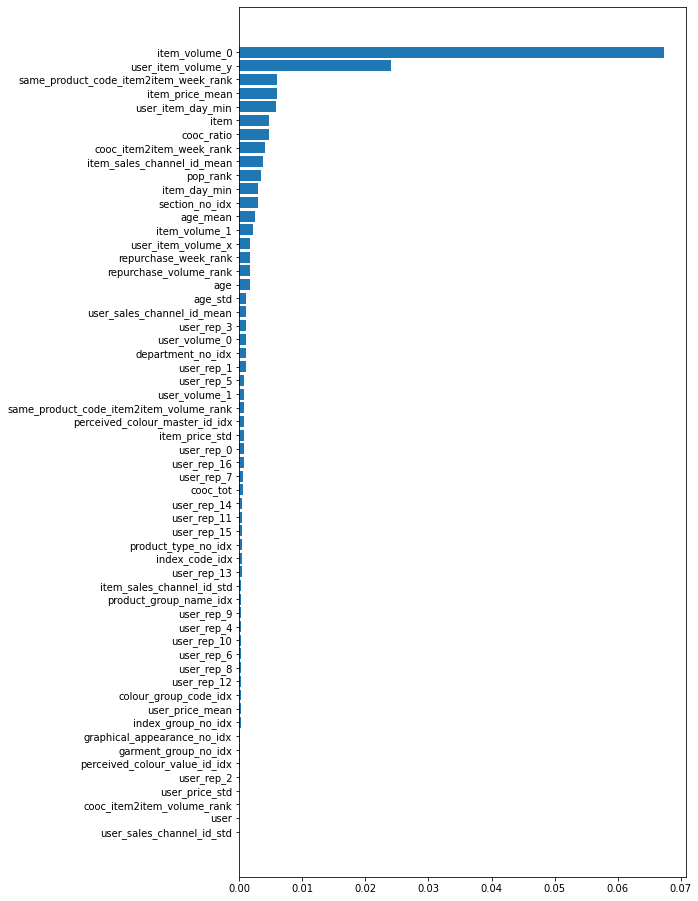

In [22]:
feature_importance = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 16))
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [23]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03323046022843141


YetiRankPairwise

In [24]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRankPairwise',
    'use_best_model': True,
    'one_hot_max_size': 0,
    'iterations': 1000,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.2124261	best: 0.2124261 (0)	total: 6.38s	remaining: 1h 46m 12s


1:	test: 0.2402033	best: 0.2402033 (1)	total: 13.5s	remaining: 1h 52m 10s


2:	test: 0.2452195	best: 0.2452195 (2)	total: 20.4s	remaining: 1h 53m 12s


3:	test: 0.2458077	best: 0.2458077 (3)	total: 26.7s	remaining: 1h 50m 55s


4:	test: 0.2448599	best: 0.2458077 (3)	total: 33.7s	remaining: 1h 51m 55s


5:	test: 0.2699620	best: 0.2699620 (5)	total: 40.5s	remaining: 1h 51m 51s


6:	test: 0.2699017	best: 0.2699620 (5)	total: 47.4s	remaining: 1h 52m 7s


7:	test: 0.2697626	best: 0.2699620 (5)	total: 54.3s	remaining: 1h 52m 15s


8:	test: 0.2691666	best: 0.2699620 (5)	total: 1m 1s	remaining: 1h 52m 19s


9:	test: 0.2706955	best: 0.2706955 (9)	total: 1m 7s	remaining: 1h 51m 48s


10:	test: 0.2884273	best: 0.2884273 (10)	total: 1m 14s	remaining: 1h 51m 41s


11:	test: 0.2884297	best: 0.2884297 (11)	total: 1m 21s	remaining: 1h 51m 53s


12:	test: 0.2887412	best: 0.2887412 (12)	total: 1m 28s	remaining: 1h 51m 48s


13:	test: 0.2906232	best: 0.2906232 (13)	total: 1m 35s	remaining: 1h 51m 55s


14:	test: 0.2923364	best: 0.2923364 (14)	total: 1m 42s	remaining: 1h 51m 55s


15:	test: 0.2923105	best: 0.2923364 (14)	total: 1m 49s	remaining: 1h 51m 55s


16:	test: 0.2919381	best: 0.2923364 (14)	total: 1m 56s	remaining: 1h 51m 56s


17:	test: 0.2919850	best: 0.2923364 (14)	total: 2m 3s	remaining: 1h 51m 50s


18:	test: 0.2920298	best: 0.2923364 (14)	total: 2m 9s	remaining: 1h 51m 50s


19:	test: 0.2921915	best: 0.2923364 (14)	total: 2m 16s	remaining: 1h 51m 29s


20:	test: 0.2954080	best: 0.2954080 (20)	total: 2m 22s	remaining: 1h 51m 3s


21:	test: 0.2957076	best: 0.2957076 (21)	total: 2m 29s	remaining: 1h 50m 39s


22:	test: 0.2959111	best: 0.2959111 (22)	total: 2m 36s	remaining: 1h 50m 39s


23:	test: 0.2961526	best: 0.2961526 (23)	total: 2m 43s	remaining: 1h 50m 36s


24:	test: 0.2961752	best: 0.2961752 (24)	total: 2m 50s	remaining: 1h 50m 34s


25:	test: 0.2967621	best: 0.2967621 (25)	total: 2m 57s	remaining: 1h 50m 41s


26:	test: 0.2968791	best: 0.2968791 (26)	total: 3m 4s	remaining: 1h 50m 38s


27:	test: 0.2972631	best: 0.2972631 (27)	total: 3m 11s	remaining: 1h 50m 37s


28:	test: 0.2973472	best: 0.2973472 (28)	total: 3m 17s	remaining: 1h 50m 26s


29:	test: 0.2974280	best: 0.2974280 (29)	total: 3m 24s	remaining: 1h 50m 27s


30:	test: 0.2974194	best: 0.2974280 (29)	total: 3m 31s	remaining: 1h 50m 11s


31:	test: 0.2977238	best: 0.2977238 (31)	total: 3m 38s	remaining: 1h 50m 7s


32:	test: 0.2980159	best: 0.2980159 (32)	total: 3m 45s	remaining: 1h 50m 7s


33:	test: 0.2978903	best: 0.2980159 (32)	total: 3m 52s	remaining: 1h 50m 7s


34:	test: 0.3097657	best: 0.3097657 (34)	total: 3m 59s	remaining: 1h 49m 58s


35:	test: 0.3100962	best: 0.3100962 (35)	total: 4m 5s	remaining: 1h 49m 46s


36:	test: 0.3101023	best: 0.3101023 (36)	total: 4m 12s	remaining: 1h 49m 32s


37:	test: 0.3099153	best: 0.3101023 (36)	total: 4m 19s	remaining: 1h 49m 32s


38:	test: 0.3100846	best: 0.3101023 (36)	total: 4m 26s	remaining: 1h 49m 20s


39:	test: 0.3104563	best: 0.3104563 (39)	total: 4m 32s	remaining: 1h 49m 9s


40:	test: 0.3103103	best: 0.3104563 (39)	total: 4m 40s	remaining: 1h 49m 12s


41:	test: 0.3105555	best: 0.3105555 (41)	total: 4m 47s	remaining: 1h 49m 11s


42:	test: 0.3105193	best: 0.3105555 (41)	total: 4m 54s	remaining: 1h 49m 5s


43:	test: 0.3103311	best: 0.3105555 (41)	total: 5m	remaining: 1h 48m 52s


44:	test: 0.3104754	best: 0.3105555 (41)	total: 5m 7s	remaining: 1h 48m 53s


45:	test: 0.3104258	best: 0.3105555 (41)	total: 5m 14s	remaining: 1h 48m 49s


46:	test: 0.3103420	best: 0.3105555 (41)	total: 5m 21s	remaining: 1h 48m 33s


47:	test: 0.3103541	best: 0.3105555 (41)	total: 5m 27s	remaining: 1h 48m 19s


48:	test: 0.3114209	best: 0.3114209 (48)	total: 5m 34s	remaining: 1h 48m 18s


49:	test: 0.3117068	best: 0.3117068 (49)	total: 5m 41s	remaining: 1h 48m 15s


50:	test: 0.3115593	best: 0.3117068 (49)	total: 5m 48s	remaining: 1h 48m 13s


51:	test: 0.3117615	best: 0.3117615 (51)	total: 5m 55s	remaining: 1h 48m 2s


52:	test: 0.3126560	best: 0.3126560 (52)	total: 6m 1s	remaining: 1h 47m 47s


53:	test: 0.3124922	best: 0.3126560 (52)	total: 6m 8s	remaining: 1h 47m 36s


54:	test: 0.3128250	best: 0.3128250 (54)	total: 6m 15s	remaining: 1h 47m 32s


55:	test: 0.3130009	best: 0.3130009 (55)	total: 6m 22s	remaining: 1h 47m 21s


56:	test: 0.3128848	best: 0.3130009 (55)	total: 6m 28s	remaining: 1h 47m 11s


57:	test: 0.3130575	best: 0.3130575 (57)	total: 6m 35s	remaining: 1h 47m 8s


58:	test: 0.3131103	best: 0.3131103 (58)	total: 6m 42s	remaining: 1h 47m 4s


59:	test: 0.3133838	best: 0.3133838 (59)	total: 6m 49s	remaining: 1h 46m 53s


60:	test: 0.3146788	best: 0.3146788 (60)	total: 6m 56s	remaining: 1h 46m 49s


61:	test: 0.3146251	best: 0.3146788 (60)	total: 7m 3s	remaining: 1h 46m 49s


62:	test: 0.3147144	best: 0.3147144 (62)	total: 7m 11s	remaining: 1h 46m 50s


63:	test: 0.3155292	best: 0.3155292 (63)	total: 7m 18s	remaining: 1h 46m 49s


64:	test: 0.3157852	best: 0.3157852 (64)	total: 7m 25s	remaining: 1h 46m 47s


65:	test: 0.3173470	best: 0.3173470 (65)	total: 7m 32s	remaining: 1h 46m 46s


66:	test: 0.3172366	best: 0.3173470 (65)	total: 7m 39s	remaining: 1h 46m 44s


67:	test: 0.3170407	best: 0.3173470 (65)	total: 7m 47s	remaining: 1h 46m 42s


68:	test: 0.3183200	best: 0.3183200 (68)	total: 7m 53s	remaining: 1h 46m 31s


69:	test: 0.3186294	best: 0.3186294 (69)	total: 8m	remaining: 1h 46m 29s


70:	test: 0.3185261	best: 0.3186294 (69)	total: 8m 7s	remaining: 1h 46m 19s


71:	test: 0.3212453	best: 0.3212453 (71)	total: 8m 14s	remaining: 1h 46m 11s


72:	test: 0.3211510	best: 0.3212453 (71)	total: 8m 21s	remaining: 1h 46m 10s


73:	test: 0.3212080	best: 0.3212453 (71)	total: 8m 28s	remaining: 1h 46m 5s


74:	test: 0.3206840	best: 0.3212453 (71)	total: 8m 36s	remaining: 1h 46m 4s


75:	test: 0.3207070	best: 0.3212453 (71)	total: 8m 42s	remaining: 1h 45m 54s


76:	test: 0.3212230	best: 0.3212453 (71)	total: 8m 49s	remaining: 1h 45m 44s


77:	test: 0.3212844	best: 0.3212844 (77)	total: 8m 56s	remaining: 1h 45m 41s


78:	test: 0.3247037	best: 0.3247037 (78)	total: 9m 3s	remaining: 1h 45m 37s


79:	test: 0.3249540	best: 0.3249540 (79)	total: 9m 10s	remaining: 1h 45m 34s


80:	test: 0.3315439	best: 0.3315439 (80)	total: 9m 18s	remaining: 1h 45m 31s


81:	test: 0.3307017	best: 0.3315439 (80)	total: 9m 25s	remaining: 1h 45m 25s


82:	test: 0.3313564	best: 0.3315439 (80)	total: 9m 32s	remaining: 1h 45m 20s


83:	test: 0.3299028	best: 0.3315439 (80)	total: 9m 39s	remaining: 1h 45m 18s


84:	test: 0.3309761	best: 0.3315439 (80)	total: 9m 46s	remaining: 1h 45m 15s


85:	test: 0.3312687	best: 0.3315439 (80)	total: 9m 53s	remaining: 1h 45m 5s


86:	test: 0.3301248	best: 0.3315439 (80)	total: 10m	remaining: 1h 44m 58s


87:	test: 0.3302337	best: 0.3315439 (80)	total: 10m 7s	remaining: 1h 44m 55s


88:	test: 0.3305018	best: 0.3315439 (80)	total: 10m 14s	remaining: 1h 44m 53s


89:	test: 0.3310738	best: 0.3315439 (80)	total: 10m 22s	remaining: 1h 44m 50s


90:	test: 0.3308887	best: 0.3315439 (80)	total: 10m 29s	remaining: 1h 44m 50s


91:	test: 0.3313017	best: 0.3315439 (80)	total: 10m 37s	remaining: 1h 44m 47s


92:	test: 0.3309589	best: 0.3315439 (80)	total: 10m 44s	remaining: 1h 44m 45s


93:	test: 0.3332808	best: 0.3332808 (93)	total: 10m 51s	remaining: 1h 44m 39s


94:	test: 0.3332917	best: 0.3332917 (94)	total: 10m 58s	remaining: 1h 44m 35s


95:	test: 0.3336550	best: 0.3336550 (95)	total: 11m 5s	remaining: 1h 44m 26s


96:	test: 0.3350627	best: 0.3350627 (96)	total: 11m 12s	remaining: 1h 44m 17s


97:	test: 0.3362104	best: 0.3362104 (97)	total: 11m 19s	remaining: 1h 44m 11s


98:	test: 0.3362322	best: 0.3362322 (98)	total: 11m 26s	remaining: 1h 44m 6s


99:	test: 0.3361958	best: 0.3362322 (98)	total: 11m 33s	remaining: 1h 44m 5s


100:	test: 0.3365754	best: 0.3365754 (100)	total: 11m 41s	remaining: 1h 44m 3s


101:	test: 0.3365601	best: 0.3365754 (100)	total: 11m 48s	remaining: 1h 44m


102:	test: 0.3366604	best: 0.3366604 (102)	total: 11m 55s	remaining: 1h 43m 50s


103:	test: 0.3370053	best: 0.3370053 (103)	total: 12m 1s	remaining: 1h 43m 40s


104:	test: 0.3369201	best: 0.3370053 (103)	total: 12m 8s	remaining: 1h 43m 29s


105:	test: 0.3368968	best: 0.3370053 (103)	total: 12m 15s	remaining: 1h 43m 23s


106:	test: 0.3371552	best: 0.3371552 (106)	total: 12m 22s	remaining: 1h 43m 17s


107:	test: 0.3372964	best: 0.3372964 (107)	total: 12m 29s	remaining: 1h 43m 14s


108:	test: 0.3373128	best: 0.3373128 (108)	total: 12m 37s	remaining: 1h 43m 9s


109:	test: 0.3373091	best: 0.3373128 (108)	total: 12m 43s	remaining: 1h 43m 1s


110:	test: 0.3371430	best: 0.3373128 (108)	total: 12m 51s	remaining: 1h 42m 56s


111:	test: 0.3370890	best: 0.3373128 (108)	total: 12m 58s	remaining: 1h 42m 49s


112:	test: 0.3371237	best: 0.3373128 (108)	total: 13m 5s	remaining: 1h 42m 46s


113:	test: 0.3370812	best: 0.3373128 (108)	total: 13m 12s	remaining: 1h 42m 41s


114:	test: 0.3371863	best: 0.3373128 (108)	total: 13m 19s	remaining: 1h 42m 35s


115:	test: 0.3373535	best: 0.3373535 (115)	total: 13m 27s	remaining: 1h 42m 32s


116:	test: 0.3374079	best: 0.3374079 (116)	total: 13m 34s	remaining: 1h 42m 23s


117:	test: 0.3373749	best: 0.3374079 (116)	total: 13m 41s	remaining: 1h 42m 19s


118:	test: 0.3374211	best: 0.3374211 (118)	total: 13m 47s	remaining: 1h 42m 9s


119:	test: 0.3373678	best: 0.3374211 (118)	total: 13m 54s	remaining: 1h 41m 59s


120:	test: 0.3373918	best: 0.3374211 (118)	total: 14m 1s	remaining: 1h 41m 53s


121:	test: 0.3375998	best: 0.3375998 (121)	total: 14m 8s	remaining: 1h 41m 44s


122:	test: 0.3376414	best: 0.3376414 (122)	total: 14m 14s	remaining: 1h 41m 34s


123:	test: 0.3380177	best: 0.3380177 (123)	total: 14m 21s	remaining: 1h 41m 25s


124:	test: 0.3382862	best: 0.3382862 (124)	total: 14m 28s	remaining: 1h 41m 19s


125:	test: 0.3398241	best: 0.3398241 (125)	total: 14m 35s	remaining: 1h 41m 12s


126:	test: 0.3399848	best: 0.3399848 (126)	total: 14m 42s	remaining: 1h 41m 4s


127:	test: 0.3399458	best: 0.3399848 (126)	total: 14m 48s	remaining: 1h 40m 54s


128:	test: 0.3399717	best: 0.3399848 (126)	total: 14m 55s	remaining: 1h 40m 48s


129:	test: 0.3399864	best: 0.3399864 (129)	total: 15m 3s	remaining: 1h 40m 44s


130:	test: 0.3400422	best: 0.3400422 (130)	total: 15m 10s	remaining: 1h 40m 36s


131:	test: 0.3400991	best: 0.3400991 (131)	total: 15m 17s	remaining: 1h 40m 31s


132:	test: 0.3401631	best: 0.3401631 (132)	total: 15m 23s	remaining: 1h 40m 22s


133:	test: 0.3400827	best: 0.3401631 (132)	total: 15m 31s	remaining: 1h 40m 17s


134:	test: 0.3401589	best: 0.3401631 (132)	total: 15m 37s	remaining: 1h 40m 7s


135:	test: 0.3400200	best: 0.3401631 (132)	total: 15m 44s	remaining: 1h 39m 59s


136:	test: 0.3402084	best: 0.3402084 (136)	total: 15m 51s	remaining: 1h 39m 53s


137:	test: 0.3404205	best: 0.3404205 (137)	total: 15m 58s	remaining: 1h 39m 47s


138:	test: 0.3403204	best: 0.3404205 (137)	total: 16m 5s	remaining: 1h 39m 40s


139:	test: 0.3402779	best: 0.3404205 (137)	total: 16m 12s	remaining: 1h 39m 33s


140:	test: 0.3403662	best: 0.3404205 (137)	total: 16m 19s	remaining: 1h 39m 27s


141:	test: 0.3402843	best: 0.3404205 (137)	total: 16m 26s	remaining: 1h 39m 22s


142:	test: 0.3404990	best: 0.3404990 (142)	total: 16m 33s	remaining: 1h 39m 16s


143:	test: 0.3404825	best: 0.3404990 (142)	total: 16m 41s	remaining: 1h 39m 11s


144:	test: 0.3404164	best: 0.3404990 (142)	total: 16m 47s	remaining: 1h 39m 2s


145:	test: 0.3405146	best: 0.3405146 (145)	total: 16m 54s	remaining: 1h 38m 53s


146:	test: 0.3406776	best: 0.3406776 (146)	total: 17m 1s	remaining: 1h 38m 44s


147:	test: 0.3421733	best: 0.3421733 (147)	total: 17m 7s	remaining: 1h 38m 34s


148:	test: 0.3421857	best: 0.3421857 (148)	total: 17m 14s	remaining: 1h 38m 26s


149:	test: 0.3426307	best: 0.3426307 (149)	total: 17m 21s	remaining: 1h 38m 19s


150:	test: 0.3425832	best: 0.3426307 (149)	total: 17m 28s	remaining: 1h 38m 16s


151:	test: 0.3428007	best: 0.3428007 (151)	total: 17m 35s	remaining: 1h 38m 10s


152:	test: 0.3446795	best: 0.3446795 (152)	total: 17m 42s	remaining: 1h 38m 4s


153:	test: 0.3446392	best: 0.3446795 (152)	total: 17m 49s	remaining: 1h 37m 58s


154:	test: 0.3448185	best: 0.3448185 (154)	total: 17m 56s	remaining: 1h 37m 50s


155:	test: 0.3449959	best: 0.3449959 (155)	total: 18m 3s	remaining: 1h 37m 41s


156:	test: 0.3449060	best: 0.3449959 (155)	total: 18m 10s	remaining: 1h 37m 35s


157:	test: 0.3449519	best: 0.3449959 (155)	total: 18m 17s	remaining: 1h 37m 28s


158:	test: 0.3449288	best: 0.3449959 (155)	total: 18m 24s	remaining: 1h 37m 21s


159:	test: 0.3450012	best: 0.3450012 (159)	total: 18m 31s	remaining: 1h 37m 15s


160:	test: 0.3450435	best: 0.3450435 (160)	total: 18m 37s	remaining: 1h 37m 5s


161:	test: 0.3450031	best: 0.3450435 (160)	total: 18m 45s	remaining: 1h 37m


162:	test: 0.3472461	best: 0.3472461 (162)	total: 18m 52s	remaining: 1h 36m 53s


163:	test: 0.3474036	best: 0.3474036 (163)	total: 18m 58s	remaining: 1h 36m 44s


164:	test: 0.3477329	best: 0.3477329 (164)	total: 19m 5s	remaining: 1h 36m 37s


165:	test: 0.3476947	best: 0.3477329 (164)	total: 19m 12s	remaining: 1h 36m 32s


166:	test: 0.3476438	best: 0.3477329 (164)	total: 19m 19s	remaining: 1h 36m 25s


167:	test: 0.3477206	best: 0.3477329 (164)	total: 19m 26s	remaining: 1h 36m 19s


168:	test: 0.3478179	best: 0.3478179 (168)	total: 19m 33s	remaining: 1h 36m 12s


169:	test: 0.3477880	best: 0.3478179 (168)	total: 19m 41s	remaining: 1h 36m 6s


170:	test: 0.3478741	best: 0.3478741 (170)	total: 19m 48s	remaining: 1h 35m 59s


171:	test: 0.3481271	best: 0.3481271 (171)	total: 19m 55s	remaining: 1h 35m 52s


172:	test: 0.3481514	best: 0.3481514 (172)	total: 20m 2s	remaining: 1h 35m 47s


173:	test: 0.3486233	best: 0.3486233 (173)	total: 20m 9s	remaining: 1h 35m 40s


174:	test: 0.3487346	best: 0.3487346 (174)	total: 20m 16s	remaining: 1h 35m 34s


175:	test: 0.3488910	best: 0.3488910 (175)	total: 20m 22s	remaining: 1h 35m 25s


176:	test: 0.3493919	best: 0.3493919 (176)	total: 20m 30s	remaining: 1h 35m 19s


177:	test: 0.3494077	best: 0.3494077 (177)	total: 20m 37s	remaining: 1h 35m 12s


178:	test: 0.3497650	best: 0.3497650 (178)	total: 20m 44s	remaining: 1h 35m 5s


179:	test: 0.3499420	best: 0.3499420 (179)	total: 20m 50s	remaining: 1h 34m 56s


180:	test: 0.3499139	best: 0.3499420 (179)	total: 20m 57s	remaining: 1h 34m 49s


181:	test: 0.3498686	best: 0.3499420 (179)	total: 21m 3s	remaining: 1h 34m 40s


182:	test: 0.3501459	best: 0.3501459 (182)	total: 21m 10s	remaining: 1h 34m 31s


183:	test: 0.3501509	best: 0.3501509 (183)	total: 21m 17s	remaining: 1h 34m 25s


184:	test: 0.3504443	best: 0.3504443 (184)	total: 21m 24s	remaining: 1h 34m 18s


185:	test: 0.3503513	best: 0.3504443 (184)	total: 21m 31s	remaining: 1h 34m 11s


186:	test: 0.3505361	best: 0.3505361 (186)	total: 21m 38s	remaining: 1h 34m 4s


187:	test: 0.3504979	best: 0.3505361 (186)	total: 21m 45s	remaining: 1h 33m 59s


188:	test: 0.3507976	best: 0.3507976 (188)	total: 21m 52s	remaining: 1h 33m 50s


189:	test: 0.3507809	best: 0.3507976 (188)	total: 21m 58s	remaining: 1h 33m 40s


190:	test: 0.3507477	best: 0.3507976 (188)	total: 22m 5s	remaining: 1h 33m 33s


191:	test: 0.3508829	best: 0.3508829 (191)	total: 22m 12s	remaining: 1h 33m 27s


192:	test: 0.3511210	best: 0.3511210 (192)	total: 22m 19s	remaining: 1h 33m 19s


193:	test: 0.3509909	best: 0.3511210 (192)	total: 22m 25s	remaining: 1h 33m 10s


194:	test: 0.3511115	best: 0.3511210 (192)	total: 22m 32s	remaining: 1h 33m 4s


195:	test: 0.3512955	best: 0.3512955 (195)	total: 22m 39s	remaining: 1h 32m 55s


196:	test: 0.3513338	best: 0.3513338 (196)	total: 22m 46s	remaining: 1h 32m 49s


197:	test: 0.3513701	best: 0.3513701 (197)	total: 22m 52s	remaining: 1h 32m 41s


198:	test: 0.3516464	best: 0.3516464 (198)	total: 23m	remaining: 1h 32m 34s


199:	test: 0.3517726	best: 0.3517726 (199)	total: 23m 6s	remaining: 1h 32m 26s


200:	test: 0.3520207	best: 0.3520207 (200)	total: 23m 13s	remaining: 1h 32m 19s


201:	test: 0.3522051	best: 0.3522051 (201)	total: 23m 20s	remaining: 1h 32m 11s


202:	test: 0.3522388	best: 0.3522388 (202)	total: 23m 27s	remaining: 1h 32m 4s


203:	test: 0.3526434	best: 0.3526434 (203)	total: 23m 34s	remaining: 1h 31m 58s


204:	test: 0.3527052	best: 0.3527052 (204)	total: 23m 40s	remaining: 1h 31m 50s


205:	test: 0.3530630	best: 0.3530630 (205)	total: 23m 47s	remaining: 1h 31m 43s


206:	test: 0.3531377	best: 0.3531377 (206)	total: 23m 54s	remaining: 1h 31m 36s


207:	test: 0.3531493	best: 0.3531493 (207)	total: 24m 1s	remaining: 1h 31m 28s


208:	test: 0.3531755	best: 0.3531755 (208)	total: 24m 8s	remaining: 1h 31m 23s


209:	test: 0.3533096	best: 0.3533096 (209)	total: 24m 15s	remaining: 1h 31m 16s


210:	test: 0.3533456	best: 0.3533456 (210)	total: 24m 22s	remaining: 1h 31m 9s


211:	test: 0.3533998	best: 0.3533998 (211)	total: 24m 29s	remaining: 1h 31m 3s


212:	test: 0.3534667	best: 0.3534667 (212)	total: 24m 36s	remaining: 1h 30m 56s


213:	test: 0.3535374	best: 0.3535374 (213)	total: 24m 43s	remaining: 1h 30m 49s


214:	test: 0.3535067	best: 0.3535374 (213)	total: 24m 50s	remaining: 1h 30m 41s


215:	test: 0.3536366	best: 0.3536366 (215)	total: 24m 57s	remaining: 1h 30m 34s


216:	test: 0.3539137	best: 0.3539137 (216)	total: 25m 3s	remaining: 1h 30m 26s


217:	test: 0.3540575	best: 0.3540575 (217)	total: 25m 10s	remaining: 1h 30m 19s


218:	test: 0.3541777	best: 0.3541777 (218)	total: 25m 17s	remaining: 1h 30m 11s


219:	test: 0.3543410	best: 0.3543410 (219)	total: 25m 24s	remaining: 1h 30m 3s


220:	test: 0.3544335	best: 0.3544335 (220)	total: 25m 30s	remaining: 1h 29m 56s


221:	test: 0.3545134	best: 0.3545134 (221)	total: 25m 38s	remaining: 1h 29m 49s


222:	test: 0.3546716	best: 0.3546716 (222)	total: 25m 44s	remaining: 1h 29m 43s


223:	test: 0.3549678	best: 0.3549678 (223)	total: 25m 52s	remaining: 1h 29m 36s


224:	test: 0.3549860	best: 0.3549860 (224)	total: 25m 58s	remaining: 1h 29m 29s


225:	test: 0.3548921	best: 0.3549860 (224)	total: 26m 5s	remaining: 1h 29m 22s


226:	test: 0.3550741	best: 0.3550741 (226)	total: 26m 12s	remaining: 1h 29m 14s


227:	test: 0.3550894	best: 0.3550894 (227)	total: 26m 19s	remaining: 1h 29m 7s


228:	test: 0.3551866	best: 0.3551866 (228)	total: 26m 26s	remaining: 1h 29m


229:	test: 0.3553283	best: 0.3553283 (229)	total: 26m 33s	remaining: 1h 28m 54s


230:	test: 0.3553844	best: 0.3553844 (230)	total: 26m 39s	remaining: 1h 28m 46s


231:	test: 0.3577383	best: 0.3577383 (231)	total: 26m 47s	remaining: 1h 28m 39s


232:	test: 0.3595952	best: 0.3595952 (232)	total: 26m 54s	remaining: 1h 28m 33s


233:	test: 0.3597506	best: 0.3597506 (233)	total: 27m 1s	remaining: 1h 28m 26s


234:	test: 0.3601331	best: 0.3601331 (234)	total: 27m 8s	remaining: 1h 28m 20s


235:	test: 0.3602196	best: 0.3602196 (235)	total: 27m 15s	remaining: 1h 28m 13s


236:	test: 0.3604446	best: 0.3604446 (236)	total: 27m 21s	remaining: 1h 28m 6s


237:	test: 0.3606372	best: 0.3606372 (237)	total: 27m 28s	remaining: 1h 27m 59s


238:	test: 0.3603612	best: 0.3606372 (237)	total: 27m 35s	remaining: 1h 27m 51s


239:	test: 0.3605101	best: 0.3606372 (237)	total: 27m 42s	remaining: 1h 27m 45s


240:	test: 0.3606655	best: 0.3606655 (240)	total: 27m 49s	remaining: 1h 27m 38s


241:	test: 0.3608959	best: 0.3608959 (241)	total: 27m 56s	remaining: 1h 27m 30s


242:	test: 0.3611348	best: 0.3611348 (242)	total: 28m 2s	remaining: 1h 27m 22s


243:	test: 0.3611851	best: 0.3611851 (243)	total: 28m 9s	remaining: 1h 27m 13s


244:	test: 0.3610516	best: 0.3611851 (243)	total: 28m 15s	remaining: 1h 27m 5s


245:	test: 0.3610284	best: 0.3611851 (243)	total: 28m 23s	remaining: 1h 27m


246:	test: 0.3613274	best: 0.3613274 (246)	total: 28m 30s	remaining: 1h 26m 54s


247:	test: 0.3615619	best: 0.3615619 (247)	total: 28m 37s	remaining: 1h 26m 47s


248:	test: 0.3616034	best: 0.3616034 (248)	total: 28m 44s	remaining: 1h 26m 40s


249:	test: 0.3618325	best: 0.3618325 (249)	total: 28m 51s	remaining: 1h 26m 33s


250:	test: 0.3619456	best: 0.3619456 (250)	total: 28m 57s	remaining: 1h 26m 25s


251:	test: 0.3617687	best: 0.3619456 (250)	total: 29m 4s	remaining: 1h 26m 18s


252:	test: 0.3617785	best: 0.3619456 (250)	total: 29m 11s	remaining: 1h 26m 11s


253:	test: 0.3618071	best: 0.3619456 (250)	total: 29m 18s	remaining: 1h 26m 5s


254:	test: 0.3618455	best: 0.3619456 (250)	total: 29m 25s	remaining: 1h 25m 56s


255:	test: 0.3619229	best: 0.3619456 (250)	total: 29m 32s	remaining: 1h 25m 50s


256:	test: 0.3620534	best: 0.3620534 (256)	total: 29m 38s	remaining: 1h 25m 42s


257:	test: 0.3622310	best: 0.3622310 (257)	total: 29m 45s	remaining: 1h 25m 34s


258:	test: 0.3623274	best: 0.3623274 (258)	total: 29m 52s	remaining: 1h 25m 28s


259:	test: 0.3624900	best: 0.3624900 (259)	total: 29m 59s	remaining: 1h 25m 20s


260:	test: 0.3625157	best: 0.3625157 (260)	total: 30m 5s	remaining: 1h 25m 13s


261:	test: 0.3625592	best: 0.3625592 (261)	total: 30m 13s	remaining: 1h 25m 7s


262:	test: 0.3625780	best: 0.3625780 (262)	total: 30m 19s	remaining: 1h 24m 59s


263:	test: 0.3625821	best: 0.3625821 (263)	total: 30m 26s	remaining: 1h 24m 52s


264:	test: 0.3625695	best: 0.3625821 (263)	total: 30m 33s	remaining: 1h 24m 44s


265:	test: 0.3626516	best: 0.3626516 (265)	total: 30m 40s	remaining: 1h 24m 38s


266:	test: 0.3627655	best: 0.3627655 (266)	total: 30m 46s	remaining: 1h 24m 30s


267:	test: 0.3628332	best: 0.3628332 (267)	total: 30m 53s	remaining: 1h 24m 22s


268:	test: 0.3628627	best: 0.3628627 (268)	total: 31m	remaining: 1h 24m 16s


269:	test: 0.3629247	best: 0.3629247 (269)	total: 31m 7s	remaining: 1h 24m 9s


270:	test: 0.3628544	best: 0.3629247 (269)	total: 31m 14s	remaining: 1h 24m 3s


271:	test: 0.3629894	best: 0.3629894 (271)	total: 31m 21s	remaining: 1h 23m 56s


272:	test: 0.3632031	best: 0.3632031 (272)	total: 31m 28s	remaining: 1h 23m 49s


273:	test: 0.3631452	best: 0.3632031 (272)	total: 31m 35s	remaining: 1h 23m 43s


274:	test: 0.3631888	best: 0.3632031 (272)	total: 31m 42s	remaining: 1h 23m 35s


275:	test: 0.3631987	best: 0.3632031 (272)	total: 31m 49s	remaining: 1h 23m 29s


276:	test: 0.3632315	best: 0.3632315 (276)	total: 31m 56s	remaining: 1h 23m 23s


277:	test: 0.3633092	best: 0.3633092 (277)	total: 32m 3s	remaining: 1h 23m 16s


278:	test: 0.3634517	best: 0.3634517 (278)	total: 32m 10s	remaining: 1h 23m 8s


279:	test: 0.3634842	best: 0.3634842 (279)	total: 32m 17s	remaining: 1h 23m 2s


280:	test: 0.3634665	best: 0.3634842 (279)	total: 32m 24s	remaining: 1h 22m 55s


281:	test: 0.3635736	best: 0.3635736 (281)	total: 32m 31s	remaining: 1h 22m 48s


282:	test: 0.3636443	best: 0.3636443 (282)	total: 32m 38s	remaining: 1h 22m 40s


283:	test: 0.3636592	best: 0.3636592 (283)	total: 32m 45s	remaining: 1h 22m 34s


284:	test: 0.3636035	best: 0.3636592 (283)	total: 32m 51s	remaining: 1h 22m 26s


285:	test: 0.3637736	best: 0.3637736 (285)	total: 32m 58s	remaining: 1h 22m 19s


286:	test: 0.3638933	best: 0.3638933 (286)	total: 33m 5s	remaining: 1h 22m 12s


287:	test: 0.3639814	best: 0.3639814 (287)	total: 33m 12s	remaining: 1h 22m 4s


288:	test: 0.3639340	best: 0.3639814 (287)	total: 33m 18s	remaining: 1h 21m 57s


289:	test: 0.3639821	best: 0.3639821 (289)	total: 33m 25s	remaining: 1h 21m 50s


290:	test: 0.3640326	best: 0.3640326 (290)	total: 33m 32s	remaining: 1h 21m 43s


291:	test: 0.3641406	best: 0.3641406 (291)	total: 33m 38s	remaining: 1h 21m 35s


292:	test: 0.3641095	best: 0.3641406 (291)	total: 33m 46s	remaining: 1h 21m 28s


293:	test: 0.3642529	best: 0.3642529 (293)	total: 33m 53s	remaining: 1h 21m 22s


294:	test: 0.3642147	best: 0.3642529 (293)	total: 34m	remaining: 1h 21m 15s


295:	test: 0.3642830	best: 0.3642830 (295)	total: 34m 6s	remaining: 1h 21m 8s


296:	test: 0.3647221	best: 0.3647221 (296)	total: 34m 13s	remaining: 1h 21m 1s


297:	test: 0.3648415	best: 0.3648415 (297)	total: 34m 20s	remaining: 1h 20m 54s


298:	test: 0.3648727	best: 0.3648727 (298)	total: 34m 27s	remaining: 1h 20m 47s


299:	test: 0.3648957	best: 0.3648957 (299)	total: 34m 34s	remaining: 1h 20m 41s


300:	test: 0.3650345	best: 0.3650345 (300)	total: 34m 41s	remaining: 1h 20m 33s


301:	test: 0.3650325	best: 0.3650345 (300)	total: 34m 48s	remaining: 1h 20m 27s


302:	test: 0.3650221	best: 0.3650345 (300)	total: 34m 55s	remaining: 1h 20m 21s


303:	test: 0.3650477	best: 0.3650477 (303)	total: 35m 2s	remaining: 1h 20m 13s


304:	test: 0.3651656	best: 0.3651656 (304)	total: 35m 9s	remaining: 1h 20m 5s


305:	test: 0.3652752	best: 0.3652752 (305)	total: 35m 16s	remaining: 1h 19m 59s


306:	test: 0.3652829	best: 0.3652829 (306)	total: 35m 23s	remaining: 1h 19m 53s


307:	test: 0.3652385	best: 0.3652829 (306)	total: 35m 30s	remaining: 1h 19m 47s


308:	test: 0.3653770	best: 0.3653770 (308)	total: 35m 37s	remaining: 1h 19m 40s


309:	test: 0.3653720	best: 0.3653770 (308)	total: 35m 44s	remaining: 1h 19m 34s


310:	test: 0.3657015	best: 0.3657015 (310)	total: 35m 51s	remaining: 1h 19m 27s


311:	test: 0.3657624	best: 0.3657624 (311)	total: 35m 58s	remaining: 1h 19m 20s


312:	test: 0.3658169	best: 0.3658169 (312)	total: 36m 5s	remaining: 1h 19m 12s


313:	test: 0.3658560	best: 0.3658560 (313)	total: 36m 12s	remaining: 1h 19m 6s


314:	test: 0.3659566	best: 0.3659566 (314)	total: 36m 19s	remaining: 1h 19m


315:	test: 0.3660568	best: 0.3660568 (315)	total: 36m 27s	remaining: 1h 18m 54s


316:	test: 0.3660343	best: 0.3660568 (315)	total: 36m 33s	remaining: 1h 18m 47s


317:	test: 0.3660311	best: 0.3660568 (315)	total: 36m 40s	remaining: 1h 18m 39s


318:	test: 0.3660661	best: 0.3660661 (318)	total: 36m 47s	remaining: 1h 18m 32s


319:	test: 0.3660669	best: 0.3660669 (319)	total: 36m 54s	remaining: 1h 18m 25s


320:	test: 0.3660800	best: 0.3660800 (320)	total: 37m	remaining: 1h 18m 17s


321:	test: 0.3660665	best: 0.3660800 (320)	total: 37m 8s	remaining: 1h 18m 11s


322:	test: 0.3661263	best: 0.3661263 (322)	total: 37m 15s	remaining: 1h 18m 6s


323:	test: 0.3663426	best: 0.3663426 (323)	total: 37m 23s	remaining: 1h 18m


324:	test: 0.3662828	best: 0.3663426 (323)	total: 37m 30s	remaining: 1h 17m 53s


325:	test: 0.3666619	best: 0.3666619 (325)	total: 37m 37s	remaining: 1h 17m 46s


326:	test: 0.3667032	best: 0.3667032 (326)	total: 37m 43s	remaining: 1h 17m 39s


327:	test: 0.3667366	best: 0.3667366 (327)	total: 37m 51s	remaining: 1h 17m 33s


328:	test: 0.3668070	best: 0.3668070 (328)	total: 37m 58s	remaining: 1h 17m 27s


329:	test: 0.3668079	best: 0.3668079 (329)	total: 38m 6s	remaining: 1h 17m 21s


330:	test: 0.3668090	best: 0.3668090 (330)	total: 38m 13s	remaining: 1h 17m 15s


331:	test: 0.3669316	best: 0.3669316 (331)	total: 38m 20s	remaining: 1h 17m 9s


332:	test: 0.3668777	best: 0.3669316 (331)	total: 38m 28s	remaining: 1h 17m 3s


333:	test: 0.3668872	best: 0.3669316 (331)	total: 38m 35s	remaining: 1h 16m 57s


334:	test: 0.3669638	best: 0.3669638 (334)	total: 38m 43s	remaining: 1h 16m 52s


335:	test: 0.3670029	best: 0.3670029 (335)	total: 38m 50s	remaining: 1h 16m 45s


336:	test: 0.3671184	best: 0.3671184 (336)	total: 38m 58s	remaining: 1h 16m 39s


337:	test: 0.3670500	best: 0.3671184 (336)	total: 39m 5s	remaining: 1h 16m 34s


338:	test: 0.3689205	best: 0.3689205 (338)	total: 39m 13s	remaining: 1h 16m 28s


339:	test: 0.3689402	best: 0.3689402 (339)	total: 39m 20s	remaining: 1h 16m 22s


340:	test: 0.3690252	best: 0.3690252 (340)	total: 39m 27s	remaining: 1h 16m 16s


341:	test: 0.3691016	best: 0.3691016 (341)	total: 39m 34s	remaining: 1h 16m 9s


342:	test: 0.3690634	best: 0.3691016 (341)	total: 39m 41s	remaining: 1h 16m 2s


343:	test: 0.3692272	best: 0.3692272 (343)	total: 39m 48s	remaining: 1h 15m 55s


344:	test: 0.3692663	best: 0.3692663 (344)	total: 39m 56s	remaining: 1h 15m 49s


345:	test: 0.3693135	best: 0.3693135 (345)	total: 40m 3s	remaining: 1h 15m 43s


346:	test: 0.3697373	best: 0.3697373 (346)	total: 40m 10s	remaining: 1h 15m 36s


347:	test: 0.3697182	best: 0.3697373 (346)	total: 40m 18s	remaining: 1h 15m 30s


348:	test: 0.3697616	best: 0.3697616 (348)	total: 40m 25s	remaining: 1h 15m 24s


349:	test: 0.3697765	best: 0.3697765 (349)	total: 40m 32s	remaining: 1h 15m 18s


350:	test: 0.3697974	best: 0.3697974 (350)	total: 40m 39s	remaining: 1h 15m 11s


351:	test: 0.3697344	best: 0.3697974 (350)	total: 40m 47s	remaining: 1h 15m 5s


352:	test: 0.3697593	best: 0.3697974 (350)	total: 40m 54s	remaining: 1h 14m 59s


353:	test: 0.3698483	best: 0.3698483 (353)	total: 41m 1s	remaining: 1h 14m 52s


354:	test: 0.3699222	best: 0.3699222 (354)	total: 41m 8s	remaining: 1h 14m 45s


355:	test: 0.3699507	best: 0.3699507 (355)	total: 41m 16s	remaining: 1h 14m 39s


356:	test: 0.3698890	best: 0.3699507 (355)	total: 41m 23s	remaining: 1h 14m 32s


357:	test: 0.3699851	best: 0.3699851 (357)	total: 41m 29s	remaining: 1h 14m 25s


358:	test: 0.3700489	best: 0.3700489 (358)	total: 41m 36s	remaining: 1h 14m 18s


359:	test: 0.3701040	best: 0.3701040 (359)	total: 41m 43s	remaining: 1h 14m 10s


360:	test: 0.3702485	best: 0.3702485 (360)	total: 41m 50s	remaining: 1h 14m 3s


361:	test: 0.3702545	best: 0.3702545 (361)	total: 41m 57s	remaining: 1h 13m 57s


362:	test: 0.3702726	best: 0.3702726 (362)	total: 42m 4s	remaining: 1h 13m 50s


363:	test: 0.3704108	best: 0.3704108 (363)	total: 42m 11s	remaining: 1h 13m 43s


364:	test: 0.3704180	best: 0.3704180 (364)	total: 42m 19s	remaining: 1h 13m 37s


365:	test: 0.3705222	best: 0.3705222 (365)	total: 42m 26s	remaining: 1h 13m 31s


366:	test: 0.3706233	best: 0.3706233 (366)	total: 42m 34s	remaining: 1h 13m 25s


367:	test: 0.3707065	best: 0.3707065 (367)	total: 42m 40s	remaining: 1h 13m 18s


368:	test: 0.3706912	best: 0.3707065 (367)	total: 42m 48s	remaining: 1h 13m 11s


369:	test: 0.3707416	best: 0.3707416 (369)	total: 42m 55s	remaining: 1h 13m 4s


370:	test: 0.3708160	best: 0.3708160 (370)	total: 43m 1s	remaining: 1h 12m 57s


371:	test: 0.3708655	best: 0.3708655 (371)	total: 43m 9s	remaining: 1h 12m 51s


372:	test: 0.3708911	best: 0.3708911 (372)	total: 43m 16s	remaining: 1h 12m 44s


373:	test: 0.3710223	best: 0.3710223 (373)	total: 43m 23s	remaining: 1h 12m 37s


374:	test: 0.3710944	best: 0.3710944 (374)	total: 43m 30s	remaining: 1h 12m 30s


375:	test: 0.3710592	best: 0.3710944 (374)	total: 43m 37s	remaining: 1h 12m 24s


376:	test: 0.3710499	best: 0.3710944 (374)	total: 43m 45s	remaining: 1h 12m 18s


377:	test: 0.3711289	best: 0.3711289 (377)	total: 43m 52s	remaining: 1h 12m 11s


378:	test: 0.3711413	best: 0.3711413 (378)	total: 43m 59s	remaining: 1h 12m 5s


379:	test: 0.3711513	best: 0.3711513 (379)	total: 44m 6s	remaining: 1h 11m 57s


380:	test: 0.3711380	best: 0.3711513 (379)	total: 44m 13s	remaining: 1h 11m 50s


381:	test: 0.3711672	best: 0.3711672 (381)	total: 44m 20s	remaining: 1h 11m 44s


382:	test: 0.3711594	best: 0.3711672 (381)	total: 44m 27s	remaining: 1h 11m 37s


383:	test: 0.3712104	best: 0.3712104 (383)	total: 44m 34s	remaining: 1h 11m 30s


384:	test: 0.3712646	best: 0.3712646 (384)	total: 44m 41s	remaining: 1h 11m 23s


385:	test: 0.3711817	best: 0.3712646 (384)	total: 44m 48s	remaining: 1h 11m 17s


386:	test: 0.3712646	best: 0.3712646 (384)	total: 44m 55s	remaining: 1h 11m 10s


387:	test: 0.3713396	best: 0.3713396 (387)	total: 45m 3s	remaining: 1h 11m 4s


388:	test: 0.3713462	best: 0.3713462 (388)	total: 45m 10s	remaining: 1h 10m 57s


389:	test: 0.3714221	best: 0.3714221 (389)	total: 45m 17s	remaining: 1h 10m 50s


390:	test: 0.3714710	best: 0.3714710 (390)	total: 45m 25s	remaining: 1h 10m 45s


391:	test: 0.3715222	best: 0.3715222 (391)	total: 45m 32s	remaining: 1h 10m 38s


392:	test: 0.3715593	best: 0.3715593 (392)	total: 45m 39s	remaining: 1h 10m 31s


393:	test: 0.3715909	best: 0.3715909 (393)	total: 45m 46s	remaining: 1h 10m 24s


394:	test: 0.3716414	best: 0.3716414 (394)	total: 45m 53s	remaining: 1h 10m 17s


395:	test: 0.3717417	best: 0.3717417 (395)	total: 46m	remaining: 1h 10m 10s


396:	test: 0.3718227	best: 0.3718227 (396)	total: 46m 8s	remaining: 1h 10m 4s


397:	test: 0.3718366	best: 0.3718366 (397)	total: 46m 14s	remaining: 1h 9m 57s


398:	test: 0.3718678	best: 0.3718678 (398)	total: 46m 22s	remaining: 1h 9m 50s


399:	test: 0.3718478	best: 0.3718678 (398)	total: 46m 29s	remaining: 1h 9m 44s


400:	test: 0.3718883	best: 0.3718883 (400)	total: 46m 36s	remaining: 1h 9m 37s


401:	test: 0.3718655	best: 0.3718883 (400)	total: 46m 44s	remaining: 1h 9m 31s


402:	test: 0.3719276	best: 0.3719276 (402)	total: 46m 51s	remaining: 1h 9m 25s


403:	test: 0.3719833	best: 0.3719833 (403)	total: 46m 58s	remaining: 1h 9m 17s


404:	test: 0.3719433	best: 0.3719833 (403)	total: 47m 5s	remaining: 1h 9m 11s


405:	test: 0.3719793	best: 0.3719833 (403)	total: 47m 13s	remaining: 1h 9m 4s


406:	test: 0.3721149	best: 0.3721149 (406)	total: 47m 19s	remaining: 1h 8m 57s


407:	test: 0.3722278	best: 0.3722278 (407)	total: 47m 27s	remaining: 1h 8m 51s


408:	test: 0.3722070	best: 0.3722278 (407)	total: 47m 34s	remaining: 1h 8m 45s


409:	test: 0.3722029	best: 0.3722278 (407)	total: 47m 42s	remaining: 1h 8m 39s


410:	test: 0.3723306	best: 0.3723306 (410)	total: 47m 49s	remaining: 1h 8m 32s


411:	test: 0.3723791	best: 0.3723791 (411)	total: 47m 56s	remaining: 1h 8m 25s


412:	test: 0.3724378	best: 0.3724378 (412)	total: 48m 4s	remaining: 1h 8m 19s


413:	test: 0.3723096	best: 0.3724378 (412)	total: 48m 11s	remaining: 1h 8m 12s


414:	test: 0.3723729	best: 0.3724378 (412)	total: 48m 18s	remaining: 1h 8m 5s


415:	test: 0.3723694	best: 0.3724378 (412)	total: 48m 25s	remaining: 1h 7m 58s


416:	test: 0.3723542	best: 0.3724378 (412)	total: 48m 33s	remaining: 1h 7m 52s


417:	test: 0.3724302	best: 0.3724378 (412)	total: 48m 40s	remaining: 1h 7m 45s


418:	test: 0.3724664	best: 0.3724664 (418)	total: 48m 47s	remaining: 1h 7m 38s


419:	test: 0.3724143	best: 0.3724664 (418)	total: 48m 54s	remaining: 1h 7m 32s


420:	test: 0.3725150	best: 0.3725150 (420)	total: 49m 1s	remaining: 1h 7m 25s


421:	test: 0.3725377	best: 0.3725377 (421)	total: 49m 8s	remaining: 1h 7m 18s


422:	test: 0.3725238	best: 0.3725377 (421)	total: 49m 15s	remaining: 1h 7m 11s


423:	test: 0.3725268	best: 0.3725377 (421)	total: 49m 22s	remaining: 1h 7m 4s


424:	test: 0.3726764	best: 0.3726764 (424)	total: 49m 29s	remaining: 1h 6m 56s


425:	test: 0.3727634	best: 0.3727634 (425)	total: 49m 35s	remaining: 1h 6m 49s


426:	test: 0.3726920	best: 0.3727634 (425)	total: 49m 42s	remaining: 1h 6m 42s


427:	test: 0.3726763	best: 0.3727634 (425)	total: 49m 50s	remaining: 1h 6m 36s


428:	test: 0.3728203	best: 0.3728203 (428)	total: 49m 57s	remaining: 1h 6m 29s


429:	test: 0.3729360	best: 0.3729360 (429)	total: 50m 4s	remaining: 1h 6m 22s


430:	test: 0.3729353	best: 0.3729360 (429)	total: 50m 11s	remaining: 1h 6m 16s


431:	test: 0.3729748	best: 0.3729748 (431)	total: 50m 18s	remaining: 1h 6m 8s


432:	test: 0.3729753	best: 0.3729753 (432)	total: 50m 25s	remaining: 1h 6m 1s


433:	test: 0.3729926	best: 0.3729926 (433)	total: 50m 32s	remaining: 1h 5m 54s


434:	test: 0.3730394	best: 0.3730394 (434)	total: 50m 39s	remaining: 1h 5m 47s


435:	test: 0.3730448	best: 0.3730448 (435)	total: 50m 46s	remaining: 1h 5m 40s


436:	test: 0.3732394	best: 0.3732394 (436)	total: 50m 54s	remaining: 1h 5m 34s


437:	test: 0.3733092	best: 0.3733092 (437)	total: 51m	remaining: 1h 5m 27s


438:	test: 0.3733716	best: 0.3733716 (438)	total: 51m 7s	remaining: 1h 5m 20s


439:	test: 0.3734265	best: 0.3734265 (439)	total: 51m 14s	remaining: 1h 5m 13s


440:	test: 0.3734428	best: 0.3734428 (440)	total: 51m 21s	remaining: 1h 5m 5s


441:	test: 0.3735468	best: 0.3735468 (441)	total: 51m 28s	remaining: 1h 4m 58s


442:	test: 0.3734766	best: 0.3735468 (441)	total: 51m 35s	remaining: 1h 4m 52s


443:	test: 0.3736227	best: 0.3736227 (443)	total: 51m 42s	remaining: 1h 4m 44s


444:	test: 0.3736338	best: 0.3736338 (444)	total: 51m 49s	remaining: 1h 4m 37s


445:	test: 0.3737277	best: 0.3737277 (445)	total: 51m 56s	remaining: 1h 4m 30s


446:	test: 0.3737123	best: 0.3737277 (445)	total: 52m 3s	remaining: 1h 4m 23s


447:	test: 0.3737685	best: 0.3737685 (447)	total: 52m 10s	remaining: 1h 4m 16s


448:	test: 0.3738692	best: 0.3738692 (448)	total: 52m 16s	remaining: 1h 4m 9s


449:	test: 0.3739336	best: 0.3739336 (449)	total: 52m 23s	remaining: 1h 4m 2s


450:	test: 0.3739746	best: 0.3739746 (450)	total: 52m 30s	remaining: 1h 3m 55s


451:	test: 0.3739273	best: 0.3739746 (450)	total: 52m 37s	remaining: 1h 3m 48s


452:	test: 0.3740116	best: 0.3740116 (452)	total: 52m 44s	remaining: 1h 3m 41s


453:	test: 0.3741004	best: 0.3741004 (453)	total: 52m 52s	remaining: 1h 3m 35s


454:	test: 0.3741388	best: 0.3741388 (454)	total: 52m 59s	remaining: 1h 3m 28s


455:	test: 0.3741680	best: 0.3741680 (455)	total: 53m 6s	remaining: 1h 3m 21s


456:	test: 0.3744993	best: 0.3744993 (456)	total: 53m 14s	remaining: 1h 3m 15s


457:	test: 0.3745051	best: 0.3745051 (457)	total: 53m 20s	remaining: 1h 3m 8s


458:	test: 0.3744997	best: 0.3745051 (457)	total: 53m 27s	remaining: 1h 3m


459:	test: 0.3745661	best: 0.3745661 (459)	total: 53m 34s	remaining: 1h 2m 53s


460:	test: 0.3745599	best: 0.3745661 (459)	total: 53m 41s	remaining: 1h 2m 46s


461:	test: 0.3746193	best: 0.3746193 (461)	total: 53m 48s	remaining: 1h 2m 39s


462:	test: 0.3746256	best: 0.3746256 (462)	total: 53m 55s	remaining: 1h 2m 32s


463:	test: 0.3746368	best: 0.3746368 (463)	total: 54m 2s	remaining: 1h 2m 25s


464:	test: 0.3747099	best: 0.3747099 (464)	total: 54m 9s	remaining: 1h 2m 19s


465:	test: 0.3746173	best: 0.3747099 (464)	total: 54m 17s	remaining: 1h 2m 12s


466:	test: 0.3746687	best: 0.3747099 (464)	total: 54m 24s	remaining: 1h 2m 5s


467:	test: 0.3745297	best: 0.3747099 (464)	total: 54m 31s	remaining: 1h 1m 58s


468:	test: 0.3745396	best: 0.3747099 (464)	total: 54m 38s	remaining: 1h 1m 51s


469:	test: 0.3743188	best: 0.3747099 (464)	total: 54m 45s	remaining: 1h 1m 44s


470:	test: 0.3744026	best: 0.3747099 (464)	total: 54m 52s	remaining: 1h 1m 37s


471:	test: 0.3744461	best: 0.3747099 (464)	total: 54m 59s	remaining: 1h 1m 31s


472:	test: 0.3746980	best: 0.3747099 (464)	total: 55m 6s	remaining: 1h 1m 24s


473:	test: 0.3747103	best: 0.3747103 (473)	total: 55m 14s	remaining: 1h 1m 17s


474:	test: 0.3747909	best: 0.3747909 (474)	total: 55m 21s	remaining: 1h 1m 10s


475:	test: 0.3748223	best: 0.3748223 (475)	total: 55m 27s	remaining: 1h 1m 3s


476:	test: 0.3747959	best: 0.3748223 (475)	total: 55m 35s	remaining: 1h 56s


477:	test: 0.3748569	best: 0.3748569 (477)	total: 55m 42s	remaining: 1h 49s


478:	test: 0.3748890	best: 0.3748890 (478)	total: 55m 49s	remaining: 1h 42s


479:	test: 0.3748724	best: 0.3748890 (478)	total: 55m 56s	remaining: 1h 36s


480:	test: 0.3749030	best: 0.3749030 (480)	total: 56m 3s	remaining: 1h 28s


481:	test: 0.3749872	best: 0.3749872 (481)	total: 56m 9s	remaining: 1h 21s


482:	test: 0.3750191	best: 0.3750191 (482)	total: 56m 16s	remaining: 1h 14s


483:	test: 0.3750131	best: 0.3750191 (482)	total: 56m 23s	remaining: 1h 7s


484:	test: 0.3750784	best: 0.3750784 (484)	total: 56m 30s	remaining: 1h


485:	test: 0.3751549	best: 0.3751549 (485)	total: 56m 37s	remaining: 59m 53s


486:	test: 0.3751779	best: 0.3751779 (486)	total: 56m 44s	remaining: 59m 46s


487:	test: 0.3751261	best: 0.3751779 (486)	total: 56m 51s	remaining: 59m 39s


488:	test: 0.3751490	best: 0.3751779 (486)	total: 56m 58s	remaining: 59m 32s


489:	test: 0.3751984	best: 0.3751984 (489)	total: 57m 5s	remaining: 59m 25s


490:	test: 0.3752369	best: 0.3752369 (490)	total: 57m 12s	remaining: 59m 18s


491:	test: 0.3752510	best: 0.3752510 (491)	total: 57m 19s	remaining: 59m 11s


492:	test: 0.3753687	best: 0.3753687 (492)	total: 57m 26s	remaining: 59m 4s


493:	test: 0.3753914	best: 0.3753914 (493)	total: 57m 33s	remaining: 58m 57s


494:	test: 0.3754378	best: 0.3754378 (494)	total: 57m 39s	remaining: 58m 49s


495:	test: 0.3754978	best: 0.3754978 (495)	total: 57m 46s	remaining: 58m 42s


496:	test: 0.3755191	best: 0.3755191 (496)	total: 57m 53s	remaining: 58m 35s


497:	test: 0.3755407	best: 0.3755407 (497)	total: 58m	remaining: 58m 28s


498:	test: 0.3755580	best: 0.3755580 (498)	total: 58m 7s	remaining: 58m 21s


499:	test: 0.3756110	best: 0.3756110 (499)	total: 58m 13s	remaining: 58m 13s


500:	test: 0.3756788	best: 0.3756788 (500)	total: 58m 20s	remaining: 58m 6s


501:	test: 0.3757069	best: 0.3757069 (501)	total: 58m 27s	remaining: 57m 59s


502:	test: 0.3758015	best: 0.3758015 (502)	total: 58m 34s	remaining: 57m 52s


503:	test: 0.3758696	best: 0.3758696 (503)	total: 58m 41s	remaining: 57m 45s


504:	test: 0.3759211	best: 0.3759211 (504)	total: 58m 48s	remaining: 57m 38s


505:	test: 0.3759480	best: 0.3759480 (505)	total: 58m 54s	remaining: 57m 30s


506:	test: 0.3760378	best: 0.3760378 (506)	total: 59m 1s	remaining: 57m 24s


507:	test: 0.3760767	best: 0.3760767 (507)	total: 59m 8s	remaining: 57m 17s


508:	test: 0.3760518	best: 0.3760767 (507)	total: 59m 16s	remaining: 57m 10s


509:	test: 0.3762122	best: 0.3762122 (509)	total: 59m 23s	remaining: 57m 3s


510:	test: 0.3762359	best: 0.3762359 (510)	total: 59m 30s	remaining: 56m 56s


511:	test: 0.3762585	best: 0.3762585 (511)	total: 59m 37s	remaining: 56m 49s


512:	test: 0.3763092	best: 0.3763092 (512)	total: 59m 43s	remaining: 56m 42s


513:	test: 0.3763376	best: 0.3763376 (513)	total: 59m 51s	remaining: 56m 35s


514:	test: 0.3763432	best: 0.3763432 (514)	total: 59m 58s	remaining: 56m 28s


515:	test: 0.3763884	best: 0.3763884 (515)	total: 1h 5s	remaining: 56m 21s


516:	test: 0.3763953	best: 0.3763953 (516)	total: 1h 11s	remaining: 56m 14s


517:	test: 0.3764537	best: 0.3764537 (517)	total: 1h 18s	remaining: 56m 6s


518:	test: 0.3764665	best: 0.3764665 (518)	total: 1h 24s	remaining: 55m 59s


519:	test: 0.3764885	best: 0.3764885 (519)	total: 1h 31s	remaining: 55m 52s


520:	test: 0.3765351	best: 0.3765351 (520)	total: 1h 38s	remaining: 55m 45s


521:	test: 0.3765226	best: 0.3765351 (520)	total: 1h 45s	remaining: 55m 38s


522:	test: 0.3765554	best: 0.3765554 (522)	total: 1h 52s	remaining: 55m 31s


523:	test: 0.3765700	best: 0.3765700 (523)	total: 1h 59s	remaining: 55m 24s


524:	test: 0.3765569	best: 0.3765700 (523)	total: 1h 1m 6s	remaining: 55m 17s


525:	test: 0.3762536	best: 0.3765700 (523)	total: 1h 1m 13s	remaining: 55m 10s


526:	test: 0.3763148	best: 0.3765700 (523)	total: 1h 1m 20s	remaining: 55m 3s


527:	test: 0.3765694	best: 0.3765700 (523)	total: 1h 1m 27s	remaining: 54m 56s


528:	test: 0.3766232	best: 0.3766232 (528)	total: 1h 1m 34s	remaining: 54m 49s


529:	test: 0.3766597	best: 0.3766597 (529)	total: 1h 1m 41s	remaining: 54m 42s


530:	test: 0.3767990	best: 0.3767990 (530)	total: 1h 1m 48s	remaining: 54m 35s


531:	test: 0.3767526	best: 0.3767990 (530)	total: 1h 1m 55s	remaining: 54m 28s


532:	test: 0.3768695	best: 0.3768695 (532)	total: 1h 2m 2s	remaining: 54m 21s


533:	test: 0.3770000	best: 0.3770000 (533)	total: 1h 2m 9s	remaining: 54m 14s


534:	test: 0.3771358	best: 0.3771358 (534)	total: 1h 2m 16s	remaining: 54m 7s


535:	test: 0.3771385	best: 0.3771385 (535)	total: 1h 2m 23s	remaining: 54m


536:	test: 0.3772128	best: 0.3772128 (536)	total: 1h 2m 30s	remaining: 53m 54s


537:	test: 0.3772644	best: 0.3772644 (537)	total: 1h 2m 37s	remaining: 53m 47s


538:	test: 0.3772968	best: 0.3772968 (538)	total: 1h 2m 45s	remaining: 53m 40s


539:	test: 0.3773185	best: 0.3773185 (539)	total: 1h 2m 51s	remaining: 53m 33s


540:	test: 0.3773886	best: 0.3773886 (540)	total: 1h 2m 58s	remaining: 53m 25s


541:	test: 0.3775077	best: 0.3775077 (541)	total: 1h 3m 5s	remaining: 53m 18s


542:	test: 0.3775064	best: 0.3775077 (541)	total: 1h 3m 12s	remaining: 53m 11s


543:	test: 0.3775073	best: 0.3775077 (541)	total: 1h 3m 18s	remaining: 53m 4s


544:	test: 0.3775606	best: 0.3775606 (544)	total: 1h 3m 26s	remaining: 52m 57s


545:	test: 0.3775681	best: 0.3775681 (545)	total: 1h 3m 33s	remaining: 52m 50s


546:	test: 0.3776055	best: 0.3776055 (546)	total: 1h 3m 40s	remaining: 52m 43s


547:	test: 0.3775636	best: 0.3776055 (546)	total: 1h 3m 47s	remaining: 52m 36s


548:	test: 0.3775968	best: 0.3776055 (546)	total: 1h 3m 54s	remaining: 52m 29s


549:	test: 0.3776138	best: 0.3776138 (549)	total: 1h 4m 1s	remaining: 52m 22s


550:	test: 0.3776322	best: 0.3776322 (550)	total: 1h 4m 8s	remaining: 52m 15s


551:	test: 0.3776935	best: 0.3776935 (551)	total: 1h 4m 15s	remaining: 52m 8s


552:	test: 0.3776732	best: 0.3776935 (551)	total: 1h 4m 22s	remaining: 52m 2s


553:	test: 0.3777445	best: 0.3777445 (553)	total: 1h 4m 29s	remaining: 51m 55s


554:	test: 0.3777383	best: 0.3777445 (553)	total: 1h 4m 36s	remaining: 51m 48s


555:	test: 0.3778397	best: 0.3778397 (555)	total: 1h 4m 43s	remaining: 51m 41s


556:	test: 0.3779019	best: 0.3779019 (556)	total: 1h 4m 50s	remaining: 51m 34s


557:	test: 0.3778468	best: 0.3779019 (556)	total: 1h 4m 57s	remaining: 51m 27s


558:	test: 0.3780871	best: 0.3780871 (558)	total: 1h 5m 4s	remaining: 51m 20s


559:	test: 0.3781084	best: 0.3781084 (559)	total: 1h 5m 11s	remaining: 51m 13s


560:	test: 0.3781487	best: 0.3781487 (560)	total: 1h 5m 18s	remaining: 51m 6s


561:	test: 0.3782183	best: 0.3782183 (561)	total: 1h 5m 25s	remaining: 50m 59s


562:	test: 0.3782340	best: 0.3782340 (562)	total: 1h 5m 32s	remaining: 50m 52s


563:	test: 0.3782388	best: 0.3782388 (563)	total: 1h 5m 38s	remaining: 50m 44s


564:	test: 0.3783073	best: 0.3783073 (564)	total: 1h 5m 45s	remaining: 50m 37s


565:	test: 0.3782808	best: 0.3783073 (564)	total: 1h 5m 52s	remaining: 50m 31s


566:	test: 0.3782938	best: 0.3783073 (564)	total: 1h 5m 59s	remaining: 50m 24s


567:	test: 0.3783726	best: 0.3783726 (567)	total: 1h 6m 6s	remaining: 50m 16s


568:	test: 0.3783253	best: 0.3783726 (567)	total: 1h 6m 13s	remaining: 50m 9s


569:	test: 0.3783846	best: 0.3783846 (569)	total: 1h 6m 20s	remaining: 50m 2s


570:	test: 0.3784138	best: 0.3784138 (570)	total: 1h 6m 27s	remaining: 49m 55s


571:	test: 0.3784081	best: 0.3784138 (570)	total: 1h 6m 33s	remaining: 49m 48s


572:	test: 0.3784792	best: 0.3784792 (572)	total: 1h 6m 40s	remaining: 49m 41s


573:	test: 0.3784921	best: 0.3784921 (573)	total: 1h 6m 47s	remaining: 49m 34s


574:	test: 0.3784850	best: 0.3784921 (573)	total: 1h 6m 54s	remaining: 49m 27s


575:	test: 0.3784494	best: 0.3784921 (573)	total: 1h 7m	remaining: 49m 19s


576:	test: 0.3784999	best: 0.3784999 (576)	total: 1h 7m 7s	remaining: 49m 12s


577:	test: 0.3785674	best: 0.3785674 (577)	total: 1h 7m 14s	remaining: 49m 5s


578:	test: 0.3785855	best: 0.3785855 (578)	total: 1h 7m 21s	remaining: 48m 58s


579:	test: 0.3786918	best: 0.3786918 (579)	total: 1h 7m 28s	remaining: 48m 51s


580:	test: 0.3786359	best: 0.3786918 (579)	total: 1h 7m 34s	remaining: 48m 44s


581:	test: 0.3786382	best: 0.3786918 (579)	total: 1h 7m 41s	remaining: 48m 37s


582:	test: 0.3787175	best: 0.3787175 (582)	total: 1h 7m 48s	remaining: 48m 29s


583:	test: 0.3788321	best: 0.3788321 (583)	total: 1h 7m 55s	remaining: 48m 22s


584:	test: 0.3789670	best: 0.3789670 (584)	total: 1h 8m 1s	remaining: 48m 15s


585:	test: 0.3789404	best: 0.3789670 (584)	total: 1h 8m 8s	remaining: 48m 8s


586:	test: 0.3789563	best: 0.3789670 (584)	total: 1h 8m 15s	remaining: 48m 1s


587:	test: 0.3789977	best: 0.3789977 (587)	total: 1h 8m 22s	remaining: 47m 54s


588:	test: 0.3789768	best: 0.3789977 (587)	total: 1h 8m 29s	remaining: 47m 47s


589:	test: 0.3789752	best: 0.3789977 (587)	total: 1h 8m 36s	remaining: 47m 40s


590:	test: 0.3789479	best: 0.3789977 (587)	total: 1h 8m 43s	remaining: 47m 33s


591:	test: 0.3789666	best: 0.3789977 (587)	total: 1h 8m 50s	remaining: 47m 26s


592:	test: 0.3789869	best: 0.3789977 (587)	total: 1h 8m 57s	remaining: 47m 19s


593:	test: 0.3789231	best: 0.3789977 (587)	total: 1h 9m 4s	remaining: 47m 12s


594:	test: 0.3790492	best: 0.3790492 (594)	total: 1h 9m 11s	remaining: 47m 5s


595:	test: 0.3790252	best: 0.3790492 (594)	total: 1h 9m 18s	remaining: 46m 58s


596:	test: 0.3790562	best: 0.3790562 (596)	total: 1h 9m 25s	remaining: 46m 51s


597:	test: 0.3791125	best: 0.3791125 (597)	total: 1h 9m 32s	remaining: 46m 45s


598:	test: 0.3791040	best: 0.3791125 (597)	total: 1h 9m 39s	remaining: 46m 38s


599:	test: 0.3791227	best: 0.3791227 (599)	total: 1h 9m 46s	remaining: 46m 31s


600:	test: 0.3790091	best: 0.3791227 (599)	total: 1h 9m 53s	remaining: 46m 24s


601:	test: 0.3790964	best: 0.3791227 (599)	total: 1h 10m	remaining: 46m 17s


602:	test: 0.3793189	best: 0.3793189 (602)	total: 1h 10m 7s	remaining: 46m 10s


603:	test: 0.3793754	best: 0.3793754 (603)	total: 1h 10m 14s	remaining: 46m 3s


604:	test: 0.3794296	best: 0.3794296 (604)	total: 1h 10m 21s	remaining: 45m 56s


605:	test: 0.3794932	best: 0.3794932 (605)	total: 1h 10m 27s	remaining: 45m 48s


606:	test: 0.3794687	best: 0.3794932 (605)	total: 1h 10m 35s	remaining: 45m 42s


607:	test: 0.3795284	best: 0.3795284 (607)	total: 1h 10m 42s	remaining: 45m 35s


608:	test: 0.3795300	best: 0.3795300 (608)	total: 1h 10m 49s	remaining: 45m 28s


609:	test: 0.3795467	best: 0.3795467 (609)	total: 1h 10m 56s	remaining: 45m 21s


610:	test: 0.3798269	best: 0.3798269 (610)	total: 1h 11m 3s	remaining: 45m 14s


611:	test: 0.3797602	best: 0.3798269 (610)	total: 1h 11m 10s	remaining: 45m 7s


612:	test: 0.3798334	best: 0.3798334 (612)	total: 1h 11m 17s	remaining: 45m


613:	test: 0.3798783	best: 0.3798783 (613)	total: 1h 11m 24s	remaining: 44m 53s


614:	test: 0.3799436	best: 0.3799436 (614)	total: 1h 11m 31s	remaining: 44m 46s


615:	test: 0.3799507	best: 0.3799507 (615)	total: 1h 11m 37s	remaining: 44m 39s


616:	test: 0.3799603	best: 0.3799603 (616)	total: 1h 11m 44s	remaining: 44m 32s


617:	test: 0.3799058	best: 0.3799603 (616)	total: 1h 11m 51s	remaining: 44m 24s


618:	test: 0.3799022	best: 0.3799603 (616)	total: 1h 11m 58s	remaining: 44m 17s


619:	test: 0.3799416	best: 0.3799603 (616)	total: 1h 12m 5s	remaining: 44m 11s


620:	test: 0.3800192	best: 0.3800192 (620)	total: 1h 12m 12s	remaining: 44m 4s


621:	test: 0.3800271	best: 0.3800271 (621)	total: 1h 12m 18s	remaining: 43m 56s


622:	test: 0.3800969	best: 0.3800969 (622)	total: 1h 12m 25s	remaining: 43m 49s


623:	test: 0.3801676	best: 0.3801676 (623)	total: 1h 12m 32s	remaining: 43m 42s


624:	test: 0.3801887	best: 0.3801887 (624)	total: 1h 12m 40s	remaining: 43m 36s


625:	test: 0.3802029	best: 0.3802029 (625)	total: 1h 12m 47s	remaining: 43m 29s


626:	test: 0.3803106	best: 0.3803106 (626)	total: 1h 12m 54s	remaining: 43m 22s


627:	test: 0.3803408	best: 0.3803408 (627)	total: 1h 13m	remaining: 43m 14s


628:	test: 0.3803981	best: 0.3803981 (628)	total: 1h 13m 7s	remaining: 43m 7s


629:	test: 0.3804817	best: 0.3804817 (629)	total: 1h 13m 14s	remaining: 43m


630:	test: 0.3804652	best: 0.3804817 (629)	total: 1h 13m 20s	remaining: 42m 53s


631:	test: 0.3804529	best: 0.3804817 (629)	total: 1h 13m 27s	remaining: 42m 46s


632:	test: 0.3804532	best: 0.3804817 (629)	total: 1h 13m 34s	remaining: 42m 39s


633:	test: 0.3804792	best: 0.3804817 (629)	total: 1h 13m 41s	remaining: 42m 32s


634:	test: 0.3805805	best: 0.3805805 (634)	total: 1h 13m 48s	remaining: 42m 25s


635:	test: 0.3805608	best: 0.3805805 (634)	total: 1h 13m 55s	remaining: 42m 18s


636:	test: 0.3805905	best: 0.3805905 (636)	total: 1h 14m 2s	remaining: 42m 11s


637:	test: 0.3807036	best: 0.3807036 (637)	total: 1h 14m 9s	remaining: 42m 4s


638:	test: 0.3807333	best: 0.3807333 (638)	total: 1h 14m 15s	remaining: 41m 57s


639:	test: 0.3807781	best: 0.3807781 (639)	total: 1h 14m 22s	remaining: 41m 50s


640:	test: 0.3807366	best: 0.3807781 (639)	total: 1h 14m 29s	remaining: 41m 43s


641:	test: 0.3807704	best: 0.3807781 (639)	total: 1h 14m 36s	remaining: 41m 36s


642:	test: 0.3807990	best: 0.3807990 (642)	total: 1h 14m 43s	remaining: 41m 29s


643:	test: 0.3808548	best: 0.3808548 (643)	total: 1h 14m 50s	remaining: 41m 22s


644:	test: 0.3808658	best: 0.3808658 (644)	total: 1h 14m 57s	remaining: 41m 15s


645:	test: 0.3809843	best: 0.3809843 (645)	total: 1h 15m 4s	remaining: 41m 8s


646:	test: 0.3810442	best: 0.3810442 (646)	total: 1h 15m 10s	remaining: 41m 1s


647:	test: 0.3810525	best: 0.3810525 (647)	total: 1h 15m 18s	remaining: 40m 54s


648:	test: 0.3810331	best: 0.3810525 (647)	total: 1h 15m 25s	remaining: 40m 47s


649:	test: 0.3810671	best: 0.3810671 (649)	total: 1h 15m 31s	remaining: 40m 40s


650:	test: 0.3810284	best: 0.3810671 (649)	total: 1h 15m 38s	remaining: 40m 32s


651:	test: 0.3810725	best: 0.3810725 (651)	total: 1h 15m 45s	remaining: 40m 26s


652:	test: 0.3811012	best: 0.3811012 (652)	total: 1h 15m 52s	remaining: 40m 19s


653:	test: 0.3811283	best: 0.3811283 (653)	total: 1h 15m 59s	remaining: 40m 12s


654:	test: 0.3811052	best: 0.3811283 (653)	total: 1h 16m 6s	remaining: 40m 5s


655:	test: 0.3810792	best: 0.3811283 (653)	total: 1h 16m 12s	remaining: 39m 57s


656:	test: 0.3811936	best: 0.3811936 (656)	total: 1h 16m 19s	remaining: 39m 50s


657:	test: 0.3812254	best: 0.3812254 (657)	total: 1h 16m 27s	remaining: 39m 44s


658:	test: 0.3812594	best: 0.3812594 (658)	total: 1h 16m 34s	remaining: 39m 37s


659:	test: 0.3812814	best: 0.3812814 (659)	total: 1h 16m 41s	remaining: 39m 30s


660:	test: 0.3813829	best: 0.3813829 (660)	total: 1h 16m 48s	remaining: 39m 23s


661:	test: 0.3814348	best: 0.3814348 (661)	total: 1h 16m 54s	remaining: 39m 16s


662:	test: 0.3814725	best: 0.3814725 (662)	total: 1h 17m 1s	remaining: 39m 9s


663:	test: 0.3814511	best: 0.3814725 (662)	total: 1h 17m 8s	remaining: 39m 2s


664:	test: 0.3815096	best: 0.3815096 (664)	total: 1h 17m 15s	remaining: 38m 55s


665:	test: 0.3815427	best: 0.3815427 (665)	total: 1h 17m 22s	remaining: 38m 48s


666:	test: 0.3814798	best: 0.3815427 (665)	total: 1h 17m 29s	remaining: 38m 41s


667:	test: 0.3815054	best: 0.3815427 (665)	total: 1h 17m 36s	remaining: 38m 34s


668:	test: 0.3814947	best: 0.3815427 (665)	total: 1h 17m 43s	remaining: 38m 27s


669:	test: 0.3814929	best: 0.3815427 (665)	total: 1h 17m 50s	remaining: 38m 20s


670:	test: 0.3816115	best: 0.3816115 (670)	total: 1h 17m 57s	remaining: 38m 13s


671:	test: 0.3816039	best: 0.3816115 (670)	total: 1h 18m 4s	remaining: 38m 6s


672:	test: 0.3815867	best: 0.3816115 (670)	total: 1h 18m 12s	remaining: 37m 59s


673:	test: 0.3816051	best: 0.3816115 (670)	total: 1h 18m 18s	remaining: 37m 52s


674:	test: 0.3816489	best: 0.3816489 (674)	total: 1h 18m 26s	remaining: 37m 45s


675:	test: 0.3817599	best: 0.3817599 (675)	total: 1h 18m 32s	remaining: 37m 38s


676:	test: 0.3817630	best: 0.3817630 (676)	total: 1h 18m 40s	remaining: 37m 32s


677:	test: 0.3817633	best: 0.3817633 (677)	total: 1h 18m 46s	remaining: 37m 24s


678:	test: 0.3818082	best: 0.3818082 (678)	total: 1h 18m 53s	remaining: 37m 17s


679:	test: 0.3818547	best: 0.3818547 (679)	total: 1h 19m	remaining: 37m 10s


680:	test: 0.3818182	best: 0.3818547 (679)	total: 1h 19m 7s	remaining: 37m 3s


681:	test: 0.3818480	best: 0.3818547 (679)	total: 1h 19m 14s	remaining: 36m 56s


682:	test: 0.3817898	best: 0.3818547 (679)	total: 1h 19m 21s	remaining: 36m 49s


683:	test: 0.3819007	best: 0.3819007 (683)	total: 1h 19m 28s	remaining: 36m 42s


684:	test: 0.3818860	best: 0.3819007 (683)	total: 1h 19m 35s	remaining: 36m 35s


685:	test: 0.3818944	best: 0.3819007 (683)	total: 1h 19m 41s	remaining: 36m 28s


686:	test: 0.3819006	best: 0.3819007 (683)	total: 1h 19m 48s	remaining: 36m 21s


687:	test: 0.3819535	best: 0.3819535 (687)	total: 1h 19m 55s	remaining: 36m 14s


688:	test: 0.3819305	best: 0.3819535 (687)	total: 1h 20m 3s	remaining: 36m 8s


689:	test: 0.3819474	best: 0.3819535 (687)	total: 1h 20m 9s	remaining: 36m


690:	test: 0.3819285	best: 0.3819535 (687)	total: 1h 20m 16s	remaining: 35m 53s


691:	test: 0.3819440	best: 0.3819535 (687)	total: 1h 20m 23s	remaining: 35m 46s


692:	test: 0.3820336	best: 0.3820336 (692)	total: 1h 20m 29s	remaining: 35m 39s


693:	test: 0.3820445	best: 0.3820445 (693)	total: 1h 20m 36s	remaining: 35m 32s


694:	test: 0.3820632	best: 0.3820632 (694)	total: 1h 20m 43s	remaining: 35m 25s


695:	test: 0.3821356	best: 0.3821356 (695)	total: 1h 20m 50s	remaining: 35m 18s


696:	test: 0.3822046	best: 0.3822046 (696)	total: 1h 20m 57s	remaining: 35m 11s


697:	test: 0.3822459	best: 0.3822459 (697)	total: 1h 21m 4s	remaining: 35m 4s


698:	test: 0.3822998	best: 0.3822998 (698)	total: 1h 21m 11s	remaining: 34m 57s


699:	test: 0.3821991	best: 0.3822998 (698)	total: 1h 21m 19s	remaining: 34m 51s


700:	test: 0.3822125	best: 0.3822998 (698)	total: 1h 21m 25s	remaining: 34m 43s


701:	test: 0.3821869	best: 0.3822998 (698)	total: 1h 21m 32s	remaining: 34m 37s


702:	test: 0.3822818	best: 0.3822998 (698)	total: 1h 21m 39s	remaining: 34m 30s


703:	test: 0.3823191	best: 0.3823191 (703)	total: 1h 21m 46s	remaining: 34m 23s


704:	test: 0.3823296	best: 0.3823296 (704)	total: 1h 21m 53s	remaining: 34m 16s


705:	test: 0.3823975	best: 0.3823975 (705)	total: 1h 22m	remaining: 34m 9s


706:	test: 0.3824231	best: 0.3824231 (706)	total: 1h 22m 7s	remaining: 34m 2s


707:	test: 0.3823840	best: 0.3824231 (706)	total: 1h 22m 14s	remaining: 33m 55s


708:	test: 0.3824302	best: 0.3824302 (708)	total: 1h 22m 21s	remaining: 33m 48s


709:	test: 0.3824453	best: 0.3824453 (709)	total: 1h 22m 28s	remaining: 33m 41s


710:	test: 0.3824606	best: 0.3824606 (710)	total: 1h 22m 34s	remaining: 33m 33s


711:	test: 0.3824852	best: 0.3824852 (711)	total: 1h 22m 41s	remaining: 33m 27s


712:	test: 0.3824670	best: 0.3824852 (711)	total: 1h 22m 48s	remaining: 33m 19s


713:	test: 0.3825322	best: 0.3825322 (713)	total: 1h 22m 55s	remaining: 33m 12s


714:	test: 0.3825168	best: 0.3825322 (713)	total: 1h 23m 2s	remaining: 33m 6s


715:	test: 0.3825558	best: 0.3825558 (715)	total: 1h 23m 9s	remaining: 32m 59s


716:	test: 0.3825820	best: 0.3825820 (716)	total: 1h 23m 16s	remaining: 32m 52s


717:	test: 0.3826289	best: 0.3826289 (717)	total: 1h 23m 23s	remaining: 32m 45s


718:	test: 0.3826629	best: 0.3826629 (718)	total: 1h 23m 30s	remaining: 32m 38s


719:	test: 0.3826656	best: 0.3826656 (719)	total: 1h 23m 37s	remaining: 32m 31s


720:	test: 0.3826871	best: 0.3826871 (720)	total: 1h 23m 44s	remaining: 32m 24s


721:	test: 0.3827779	best: 0.3827779 (721)	total: 1h 23m 51s	remaining: 32m 17s


722:	test: 0.3828186	best: 0.3828186 (722)	total: 1h 23m 58s	remaining: 32m 10s


723:	test: 0.3828556	best: 0.3828556 (723)	total: 1h 24m 5s	remaining: 32m 3s


724:	test: 0.3828875	best: 0.3828875 (724)	total: 1h 24m 12s	remaining: 31m 56s


725:	test: 0.3829688	best: 0.3829688 (725)	total: 1h 24m 19s	remaining: 31m 49s


726:	test: 0.3830191	best: 0.3830191 (726)	total: 1h 24m 25s	remaining: 31m 42s


727:	test: 0.3830430	best: 0.3830430 (727)	total: 1h 24m 32s	remaining: 31m 35s


728:	test: 0.3830188	best: 0.3830430 (727)	total: 1h 24m 39s	remaining: 31m 28s


729:	test: 0.3830437	best: 0.3830437 (729)	total: 1h 24m 45s	remaining: 31m 21s


730:	test: 0.3830431	best: 0.3830437 (729)	total: 1h 24m 52s	remaining: 31m 13s


731:	test: 0.3830784	best: 0.3830784 (731)	total: 1h 24m 58s	remaining: 31m 6s


732:	test: 0.3831017	best: 0.3831017 (732)	total: 1h 25m 5s	remaining: 30m 59s


733:	test: 0.3831915	best: 0.3831915 (733)	total: 1h 25m 12s	remaining: 30m 52s


734:	test: 0.3831546	best: 0.3831915 (733)	total: 1h 25m 19s	remaining: 30m 45s


735:	test: 0.3831868	best: 0.3831915 (733)	total: 1h 25m 26s	remaining: 30m 38s


736:	test: 0.3832328	best: 0.3832328 (736)	total: 1h 25m 33s	remaining: 30m 31s


737:	test: 0.3831848	best: 0.3832328 (736)	total: 1h 25m 40s	remaining: 30m 24s


738:	test: 0.3832119	best: 0.3832328 (736)	total: 1h 25m 46s	remaining: 30m 17s


739:	test: 0.3832484	best: 0.3832484 (739)	total: 1h 25m 53s	remaining: 30m 10s


740:	test: 0.3832500	best: 0.3832500 (740)	total: 1h 26m	remaining: 30m 3s


741:	test: 0.3832745	best: 0.3832745 (741)	total: 1h 26m 7s	remaining: 29m 56s


742:	test: 0.3832585	best: 0.3832745 (741)	total: 1h 26m 14s	remaining: 29m 49s


743:	test: 0.3833207	best: 0.3833207 (743)	total: 1h 26m 21s	remaining: 29m 43s


744:	test: 0.3833089	best: 0.3833207 (743)	total: 1h 26m 28s	remaining: 29m 36s


745:	test: 0.3833501	best: 0.3833501 (745)	total: 1h 26m 35s	remaining: 29m 28s


746:	test: 0.3834357	best: 0.3834357 (746)	total: 1h 26m 41s	remaining: 29m 21s


747:	test: 0.3834534	best: 0.3834534 (747)	total: 1h 26m 48s	remaining: 29m 14s


748:	test: 0.3834121	best: 0.3834534 (747)	total: 1h 26m 55s	remaining: 29m 7s


749:	test: 0.3834388	best: 0.3834534 (747)	total: 1h 27m 2s	remaining: 29m


750:	test: 0.3834420	best: 0.3834534 (747)	total: 1h 27m 9s	remaining: 28m 54s


751:	test: 0.3834709	best: 0.3834709 (751)	total: 1h 27m 16s	remaining: 28m 47s


752:	test: 0.3834599	best: 0.3834709 (751)	total: 1h 27m 23s	remaining: 28m 40s


753:	test: 0.3834276	best: 0.3834709 (751)	total: 1h 27m 31s	remaining: 28m 33s


754:	test: 0.3834567	best: 0.3834709 (751)	total: 1h 27m 37s	remaining: 28m 26s


755:	test: 0.3835003	best: 0.3835003 (755)	total: 1h 27m 44s	remaining: 28m 19s


756:	test: 0.3836089	best: 0.3836089 (756)	total: 1h 27m 51s	remaining: 28m 12s


757:	test: 0.3835628	best: 0.3836089 (756)	total: 1h 27m 58s	remaining: 28m 5s


758:	test: 0.3835391	best: 0.3836089 (756)	total: 1h 28m 5s	remaining: 27m 58s


759:	test: 0.3835689	best: 0.3836089 (756)	total: 1h 28m 12s	remaining: 27m 51s


760:	test: 0.3836657	best: 0.3836657 (760)	total: 1h 28m 18s	remaining: 27m 44s


761:	test: 0.3837052	best: 0.3837052 (761)	total: 1h 28m 25s	remaining: 27m 37s


762:	test: 0.3837235	best: 0.3837235 (762)	total: 1h 28m 33s	remaining: 27m 30s


763:	test: 0.3837522	best: 0.3837522 (763)	total: 1h 28m 40s	remaining: 27m 23s


764:	test: 0.3837409	best: 0.3837522 (763)	total: 1h 28m 47s	remaining: 27m 16s


765:	test: 0.3837470	best: 0.3837522 (763)	total: 1h 28m 54s	remaining: 27m 9s


766:	test: 0.3839179	best: 0.3839179 (766)	total: 1h 29m 1s	remaining: 27m 2s


767:	test: 0.3838911	best: 0.3839179 (766)	total: 1h 29m 8s	remaining: 26m 55s


768:	test: 0.3839568	best: 0.3839568 (768)	total: 1h 29m 15s	remaining: 26m 48s


769:	test: 0.3839436	best: 0.3839568 (768)	total: 1h 29m 22s	remaining: 26m 41s


770:	test: 0.3839317	best: 0.3839568 (768)	total: 1h 29m 29s	remaining: 26m 34s


771:	test: 0.3839504	best: 0.3839568 (768)	total: 1h 29m 36s	remaining: 26m 27s


772:	test: 0.3840364	best: 0.3840364 (772)	total: 1h 29m 43s	remaining: 26m 20s


773:	test: 0.3840093	best: 0.3840364 (772)	total: 1h 29m 50s	remaining: 26m 14s


774:	test: 0.3840988	best: 0.3840988 (774)	total: 1h 29m 57s	remaining: 26m 7s


775:	test: 0.3840917	best: 0.3840988 (774)	total: 1h 30m 4s	remaining: 26m


776:	test: 0.3840771	best: 0.3840988 (774)	total: 1h 30m 11s	remaining: 25m 53s


777:	test: 0.3840903	best: 0.3840988 (774)	total: 1h 30m 19s	remaining: 25m 46s


778:	test: 0.3841305	best: 0.3841305 (778)	total: 1h 30m 26s	remaining: 25m 39s


779:	test: 0.3842136	best: 0.3842136 (779)	total: 1h 30m 33s	remaining: 25m 32s


780:	test: 0.3843070	best: 0.3843070 (780)	total: 1h 30m 40s	remaining: 25m 25s


781:	test: 0.3843077	best: 0.3843077 (781)	total: 1h 30m 47s	remaining: 25m 18s


782:	test: 0.3842614	best: 0.3843077 (781)	total: 1h 30m 55s	remaining: 25m 11s


783:	test: 0.3842514	best: 0.3843077 (781)	total: 1h 31m 2s	remaining: 25m 5s


784:	test: 0.3842356	best: 0.3843077 (781)	total: 1h 31m 10s	remaining: 24m 58s


785:	test: 0.3842698	best: 0.3843077 (781)	total: 1h 31m 18s	remaining: 24m 51s


786:	test: 0.3842863	best: 0.3843077 (781)	total: 1h 31m 24s	remaining: 24m 44s


787:	test: 0.3842876	best: 0.3843077 (781)	total: 1h 31m 31s	remaining: 24m 37s


788:	test: 0.3843051	best: 0.3843077 (781)	total: 1h 31m 38s	remaining: 24m 30s


789:	test: 0.3843024	best: 0.3843077 (781)	total: 1h 31m 45s	remaining: 24m 23s


790:	test: 0.3843322	best: 0.3843322 (790)	total: 1h 31m 52s	remaining: 24m 16s


791:	test: 0.3843448	best: 0.3843448 (791)	total: 1h 31m 59s	remaining: 24m 9s


792:	test: 0.3843738	best: 0.3843738 (792)	total: 1h 32m 6s	remaining: 24m 2s


793:	test: 0.3843620	best: 0.3843738 (792)	total: 1h 32m 14s	remaining: 23m 55s


794:	test: 0.3843554	best: 0.3843738 (792)	total: 1h 32m 20s	remaining: 23m 48s


795:	test: 0.3843819	best: 0.3843819 (795)	total: 1h 32m 28s	remaining: 23m 41s


796:	test: 0.3843588	best: 0.3843819 (795)	total: 1h 32m 35s	remaining: 23m 34s


797:	test: 0.3843801	best: 0.3843819 (795)	total: 1h 32m 42s	remaining: 23m 27s


798:	test: 0.3843965	best: 0.3843965 (798)	total: 1h 32m 48s	remaining: 23m 20s


799:	test: 0.3844044	best: 0.3844044 (799)	total: 1h 32m 56s	remaining: 23m 14s


800:	test: 0.3844938	best: 0.3844938 (800)	total: 1h 33m 3s	remaining: 23m 7s


801:	test: 0.3844425	best: 0.3844938 (800)	total: 1h 33m 10s	remaining: 23m


802:	test: 0.3844354	best: 0.3844938 (800)	total: 1h 33m 17s	remaining: 22m 53s


803:	test: 0.3844441	best: 0.3844938 (800)	total: 1h 33m 24s	remaining: 22m 46s


804:	test: 0.3845297	best: 0.3845297 (804)	total: 1h 33m 31s	remaining: 22m 39s


805:	test: 0.3845602	best: 0.3845602 (805)	total: 1h 33m 38s	remaining: 22m 32s


806:	test: 0.3845705	best: 0.3845705 (806)	total: 1h 33m 45s	remaining: 22m 25s


807:	test: 0.3845595	best: 0.3845705 (806)	total: 1h 33m 52s	remaining: 22m 18s


808:	test: 0.3845940	best: 0.3845940 (808)	total: 1h 33m 59s	remaining: 22m 11s


809:	test: 0.3846829	best: 0.3846829 (809)	total: 1h 34m 6s	remaining: 22m 4s


810:	test: 0.3846983	best: 0.3846983 (810)	total: 1h 34m 13s	remaining: 21m 57s


811:	test: 0.3846797	best: 0.3846983 (810)	total: 1h 34m 20s	remaining: 21m 50s


812:	test: 0.3847193	best: 0.3847193 (812)	total: 1h 34m 28s	remaining: 21m 43s


813:	test: 0.3847728	best: 0.3847728 (813)	total: 1h 34m 35s	remaining: 21m 36s


814:	test: 0.3848489	best: 0.3848489 (814)	total: 1h 34m 41s	remaining: 21m 29s


815:	test: 0.3848651	best: 0.3848651 (815)	total: 1h 34m 49s	remaining: 21m 22s


816:	test: 0.3848436	best: 0.3848651 (815)	total: 1h 34m 56s	remaining: 21m 15s


817:	test: 0.3847906	best: 0.3848651 (815)	total: 1h 35m 3s	remaining: 21m 8s


818:	test: 0.3849087	best: 0.3849087 (818)	total: 1h 35m 10s	remaining: 21m 1s


819:	test: 0.3849385	best: 0.3849385 (819)	total: 1h 35m 17s	remaining: 20m 55s


820:	test: 0.3849959	best: 0.3849959 (820)	total: 1h 35m 24s	remaining: 20m 48s


821:	test: 0.3849851	best: 0.3849959 (820)	total: 1h 35m 31s	remaining: 20m 41s


822:	test: 0.3849964	best: 0.3849964 (822)	total: 1h 35m 38s	remaining: 20m 34s


823:	test: 0.3850240	best: 0.3850240 (823)	total: 1h 35m 45s	remaining: 20m 27s


824:	test: 0.3850632	best: 0.3850632 (824)	total: 1h 35m 52s	remaining: 20m 20s


825:	test: 0.3850366	best: 0.3850632 (824)	total: 1h 35m 58s	remaining: 20m 13s


826:	test: 0.3850696	best: 0.3850696 (826)	total: 1h 36m 6s	remaining: 20m 6s


827:	test: 0.3850102	best: 0.3850696 (826)	total: 1h 36m 13s	remaining: 19m 59s


828:	test: 0.3850296	best: 0.3850696 (826)	total: 1h 36m 20s	remaining: 19m 52s


829:	test: 0.3850356	best: 0.3850696 (826)	total: 1h 36m 27s	remaining: 19m 45s


830:	test: 0.3850654	best: 0.3850696 (826)	total: 1h 36m 34s	remaining: 19m 38s


831:	test: 0.3851030	best: 0.3851030 (831)	total: 1h 36m 40s	remaining: 19m 31s


832:	test: 0.3851430	best: 0.3851430 (832)	total: 1h 36m 47s	remaining: 19m 24s


833:	test: 0.3851304	best: 0.3851430 (832)	total: 1h 36m 54s	remaining: 19m 17s


834:	test: 0.3851245	best: 0.3851430 (832)	total: 1h 37m	remaining: 19m 10s


835:	test: 0.3851728	best: 0.3851728 (835)	total: 1h 37m 7s	remaining: 19m 3s


836:	test: 0.3852343	best: 0.3852343 (836)	total: 1h 37m 14s	remaining: 18m 56s


837:	test: 0.3852772	best: 0.3852772 (837)	total: 1h 37m 21s	remaining: 18m 49s


838:	test: 0.3853296	best: 0.3853296 (838)	total: 1h 37m 28s	remaining: 18m 42s


839:	test: 0.3853029	best: 0.3853296 (838)	total: 1h 37m 35s	remaining: 18m 35s


840:	test: 0.3853362	best: 0.3853362 (840)	total: 1h 37m 42s	remaining: 18m 28s


841:	test: 0.3853374	best: 0.3853374 (841)	total: 1h 37m 49s	remaining: 18m 21s


842:	test: 0.3853376	best: 0.3853376 (842)	total: 1h 37m 56s	remaining: 18m 14s


843:	test: 0.3852829	best: 0.3853376 (842)	total: 1h 38m 4s	remaining: 18m 7s


844:	test: 0.3853066	best: 0.3853376 (842)	total: 1h 38m 11s	remaining: 18m


845:	test: 0.3853057	best: 0.3853376 (842)	total: 1h 38m 18s	remaining: 17m 53s


846:	test: 0.3853050	best: 0.3853376 (842)	total: 1h 38m 25s	remaining: 17m 46s


847:	test: 0.3853669	best: 0.3853669 (847)	total: 1h 38m 32s	remaining: 17m 39s


848:	test: 0.3854267	best: 0.3854267 (848)	total: 1h 38m 39s	remaining: 17m 32s


849:	test: 0.3854200	best: 0.3854267 (848)	total: 1h 38m 46s	remaining: 17m 25s


850:	test: 0.3854348	best: 0.3854348 (850)	total: 1h 38m 52s	remaining: 17m 18s


851:	test: 0.3854942	best: 0.3854942 (851)	total: 1h 38m 59s	remaining: 17m 11s


852:	test: 0.3855172	best: 0.3855172 (852)	total: 1h 39m 6s	remaining: 17m 4s


853:	test: 0.3855436	best: 0.3855436 (853)	total: 1h 39m 13s	remaining: 16m 57s


854:	test: 0.3855192	best: 0.3855436 (853)	total: 1h 39m 21s	remaining: 16m 50s


855:	test: 0.3855269	best: 0.3855436 (853)	total: 1h 39m 27s	remaining: 16m 43s


856:	test: 0.3855623	best: 0.3855623 (856)	total: 1h 39m 34s	remaining: 16m 36s


857:	test: 0.3855949	best: 0.3855949 (857)	total: 1h 39m 41s	remaining: 16m 29s


858:	test: 0.3856534	best: 0.3856534 (858)	total: 1h 39m 48s	remaining: 16m 22s


859:	test: 0.3857309	best: 0.3857309 (859)	total: 1h 39m 55s	remaining: 16m 16s


860:	test: 0.3857033	best: 0.3857309 (859)	total: 1h 40m 2s	remaining: 16m 9s


861:	test: 0.3857156	best: 0.3857309 (859)	total: 1h 40m 10s	remaining: 16m 2s


862:	test: 0.3857255	best: 0.3857309 (859)	total: 1h 40m 17s	remaining: 15m 55s


863:	test: 0.3857786	best: 0.3857786 (863)	total: 1h 40m 24s	remaining: 15m 48s


864:	test: 0.3857487	best: 0.3857786 (863)	total: 1h 40m 31s	remaining: 15m 41s


865:	test: 0.3856949	best: 0.3857786 (863)	total: 1h 40m 38s	remaining: 15m 34s


866:	test: 0.3857396	best: 0.3857786 (863)	total: 1h 40m 45s	remaining: 15m 27s


867:	test: 0.3857899	best: 0.3857899 (867)	total: 1h 40m 52s	remaining: 15m 20s


868:	test: 0.3858187	best: 0.3858187 (868)	total: 1h 40m 59s	remaining: 15m 13s


869:	test: 0.3858198	best: 0.3858198 (869)	total: 1h 41m 5s	remaining: 15m 6s


870:	test: 0.3858515	best: 0.3858515 (870)	total: 1h 41m 12s	remaining: 14m 59s


871:	test: 0.3858722	best: 0.3858722 (871)	total: 1h 41m 19s	remaining: 14m 52s


872:	test: 0.3858347	best: 0.3858722 (871)	total: 1h 41m 25s	remaining: 14m 45s


873:	test: 0.3858995	best: 0.3858995 (873)	total: 1h 41m 32s	remaining: 14m 38s


874:	test: 0.3859432	best: 0.3859432 (874)	total: 1h 41m 39s	remaining: 14m 31s


875:	test: 0.3859338	best: 0.3859432 (874)	total: 1h 41m 46s	remaining: 14m 24s


876:	test: 0.3859310	best: 0.3859432 (874)	total: 1h 41m 53s	remaining: 14m 17s


877:	test: 0.3859309	best: 0.3859432 (874)	total: 1h 41m 59s	remaining: 14m 10s


878:	test: 0.3859366	best: 0.3859432 (874)	total: 1h 42m 7s	remaining: 14m 3s


879:	test: 0.3859377	best: 0.3859432 (874)	total: 1h 42m 14s	remaining: 13m 56s


880:	test: 0.3860279	best: 0.3860279 (880)	total: 1h 42m 21s	remaining: 13m 49s


881:	test: 0.3859756	best: 0.3860279 (880)	total: 1h 42m 28s	remaining: 13m 42s


882:	test: 0.3859457	best: 0.3860279 (880)	total: 1h 42m 35s	remaining: 13m 35s


883:	test: 0.3859592	best: 0.3860279 (880)	total: 1h 42m 42s	remaining: 13m 28s


884:	test: 0.3859440	best: 0.3860279 (880)	total: 1h 42m 49s	remaining: 13m 21s


885:	test: 0.3859656	best: 0.3860279 (880)	total: 1h 42m 57s	remaining: 13m 14s


886:	test: 0.3859937	best: 0.3860279 (880)	total: 1h 43m 4s	remaining: 13m 7s


887:	test: 0.3859948	best: 0.3860279 (880)	total: 1h 43m 11s	remaining: 13m


888:	test: 0.3860158	best: 0.3860279 (880)	total: 1h 43m 18s	remaining: 12m 53s


889:	test: 0.3860254	best: 0.3860279 (880)	total: 1h 43m 25s	remaining: 12m 46s


890:	test: 0.3860535	best: 0.3860535 (890)	total: 1h 43m 31s	remaining: 12m 39s


891:	test: 0.3860752	best: 0.3860752 (891)	total: 1h 43m 38s	remaining: 12m 32s


892:	test: 0.3861181	best: 0.3861181 (892)	total: 1h 43m 44s	remaining: 12m 25s


893:	test: 0.3861196	best: 0.3861196 (893)	total: 1h 43m 52s	remaining: 12m 18s


894:	test: 0.3861706	best: 0.3861706 (894)	total: 1h 43m 59s	remaining: 12m 11s


895:	test: 0.3862341	best: 0.3862341 (895)	total: 1h 44m 5s	remaining: 12m 4s


896:	test: 0.3862120	best: 0.3862341 (895)	total: 1h 44m 12s	remaining: 11m 57s


897:	test: 0.3861543	best: 0.3862341 (895)	total: 1h 44m 19s	remaining: 11m 51s


898:	test: 0.3861841	best: 0.3862341 (895)	total: 1h 44m 26s	remaining: 11m 43s


899:	test: 0.3862306	best: 0.3862341 (895)	total: 1h 44m 33s	remaining: 11m 37s


900:	test: 0.3861930	best: 0.3862341 (895)	total: 1h 44m 40s	remaining: 11m 30s


901:	test: 0.3862475	best: 0.3862475 (901)	total: 1h 44m 47s	remaining: 11m 23s


902:	test: 0.3862667	best: 0.3862667 (902)	total: 1h 44m 55s	remaining: 11m 16s


903:	test: 0.3863456	best: 0.3863456 (903)	total: 1h 45m 2s	remaining: 11m 9s


904:	test: 0.3863300	best: 0.3863456 (903)	total: 1h 45m 9s	remaining: 11m 2s


905:	test: 0.3864044	best: 0.3864044 (905)	total: 1h 45m 16s	remaining: 10m 55s


906:	test: 0.3864194	best: 0.3864194 (906)	total: 1h 45m 23s	remaining: 10m 48s


907:	test: 0.3864153	best: 0.3864194 (906)	total: 1h 45m 30s	remaining: 10m 41s


908:	test: 0.3864366	best: 0.3864366 (908)	total: 1h 45m 37s	remaining: 10m 34s


909:	test: 0.3864333	best: 0.3864366 (908)	total: 1h 45m 44s	remaining: 10m 27s


910:	test: 0.3864063	best: 0.3864366 (908)	total: 1h 45m 50s	remaining: 10m 20s


911:	test: 0.3864728	best: 0.3864728 (911)	total: 1h 45m 57s	remaining: 10m 13s


912:	test: 0.3865060	best: 0.3865060 (912)	total: 1h 46m 4s	remaining: 10m 6s


913:	test: 0.3865348	best: 0.3865348 (913)	total: 1h 46m 11s	remaining: 9m 59s


914:	test: 0.3865741	best: 0.3865741 (914)	total: 1h 46m 18s	remaining: 9m 52s


915:	test: 0.3865157	best: 0.3865741 (914)	total: 1h 46m 25s	remaining: 9m 45s


916:	test: 0.3865102	best: 0.3865741 (914)	total: 1h 46m 33s	remaining: 9m 38s


917:	test: 0.3864668	best: 0.3865741 (914)	total: 1h 46m 40s	remaining: 9m 31s


918:	test: 0.3864352	best: 0.3865741 (914)	total: 1h 46m 47s	remaining: 9m 24s


919:	test: 0.3864635	best: 0.3865741 (914)	total: 1h 46m 54s	remaining: 9m 17s


920:	test: 0.3864969	best: 0.3865741 (914)	total: 1h 47m	remaining: 9m 10s


921:	test: 0.3865367	best: 0.3865741 (914)	total: 1h 47m 8s	remaining: 9m 3s


922:	test: 0.3865627	best: 0.3865741 (914)	total: 1h 47m 14s	remaining: 8m 56s


923:	test: 0.3865925	best: 0.3865925 (923)	total: 1h 47m 21s	remaining: 8m 49s


924:	test: 0.3866897	best: 0.3866897 (924)	total: 1h 47m 27s	remaining: 8m 42s


925:	test: 0.3865980	best: 0.3866897 (924)	total: 1h 47m 35s	remaining: 8m 35s


926:	test: 0.3865968	best: 0.3866897 (924)	total: 1h 47m 41s	remaining: 8m 28s


927:	test: 0.3866865	best: 0.3866897 (924)	total: 1h 47m 49s	remaining: 8m 21s


928:	test: 0.3867972	best: 0.3867972 (928)	total: 1h 47m 57s	remaining: 8m 15s


929:	test: 0.3868558	best: 0.3868558 (929)	total: 1h 48m 4s	remaining: 8m 8s


930:	test: 0.3869199	best: 0.3869199 (930)	total: 1h 48m 11s	remaining: 8m 1s


931:	test: 0.3869596	best: 0.3869596 (931)	total: 1h 48m 18s	remaining: 7m 54s


932:	test: 0.3869959	best: 0.3869959 (932)	total: 1h 48m 26s	remaining: 7m 47s


933:	test: 0.3870243	best: 0.3870243 (933)	total: 1h 48m 33s	remaining: 7m 40s


934:	test: 0.3871111	best: 0.3871111 (934)	total: 1h 48m 40s	remaining: 7m 33s


935:	test: 0.3871194	best: 0.3871194 (935)	total: 1h 48m 47s	remaining: 7m 26s


936:	test: 0.3871858	best: 0.3871858 (936)	total: 1h 48m 53s	remaining: 7m 19s


937:	test: 0.3872031	best: 0.3872031 (937)	total: 1h 49m 1s	remaining: 7m 12s


938:	test: 0.3872049	best: 0.3872049 (938)	total: 1h 49m 8s	remaining: 7m 5s


939:	test: 0.3872065	best: 0.3872065 (939)	total: 1h 49m 15s	remaining: 6m 58s


940:	test: 0.3871946	best: 0.3872065 (939)	total: 1h 49m 21s	remaining: 6m 51s


941:	test: 0.3872665	best: 0.3872665 (941)	total: 1h 49m 29s	remaining: 6m 44s


942:	test: 0.3872856	best: 0.3872856 (942)	total: 1h 49m 36s	remaining: 6m 37s


943:	test: 0.3872787	best: 0.3872856 (942)	total: 1h 49m 44s	remaining: 6m 30s


944:	test: 0.3872758	best: 0.3872856 (942)	total: 1h 49m 51s	remaining: 6m 23s


945:	test: 0.3872860	best: 0.3872860 (945)	total: 1h 49m 58s	remaining: 6m 16s


946:	test: 0.3872940	best: 0.3872940 (946)	total: 1h 50m 5s	remaining: 6m 9s


947:	test: 0.3873509	best: 0.3873509 (947)	total: 1h 50m 12s	remaining: 6m 2s


948:	test: 0.3873667	best: 0.3873667 (948)	total: 1h 50m 19s	remaining: 5m 55s


949:	test: 0.3874405	best: 0.3874405 (949)	total: 1h 50m 26s	remaining: 5m 48s


950:	test: 0.3875524	best: 0.3875524 (950)	total: 1h 50m 33s	remaining: 5m 41s


951:	test: 0.3876099	best: 0.3876099 (951)	total: 1h 50m 40s	remaining: 5m 34s


952:	test: 0.3875852	best: 0.3876099 (951)	total: 1h 50m 47s	remaining: 5m 27s


953:	test: 0.3875750	best: 0.3876099 (951)	total: 1h 50m 54s	remaining: 5m 20s


954:	test: 0.3876720	best: 0.3876720 (954)	total: 1h 51m 2s	remaining: 5m 13s


955:	test: 0.3876505	best: 0.3876720 (954)	total: 1h 51m 9s	remaining: 5m 6s


956:	test: 0.3876989	best: 0.3876989 (956)	total: 1h 51m 16s	remaining: 4m 59s


957:	test: 0.3877175	best: 0.3877175 (957)	total: 1h 51m 24s	remaining: 4m 53s


958:	test: 0.3877074	best: 0.3877175 (957)	total: 1h 51m 31s	remaining: 4m 46s


959:	test: 0.3877374	best: 0.3877374 (959)	total: 1h 51m 39s	remaining: 4m 39s


960:	test: 0.3877549	best: 0.3877549 (960)	total: 1h 51m 45s	remaining: 4m 32s


961:	test: 0.3877604	best: 0.3877604 (961)	total: 1h 51m 52s	remaining: 4m 25s


962:	test: 0.3877752	best: 0.3877752 (962)	total: 1h 52m	remaining: 4m 18s


963:	test: 0.3878427	best: 0.3878427 (963)	total: 1h 52m 7s	remaining: 4m 11s


964:	test: 0.3878612	best: 0.3878612 (964)	total: 1h 52m 15s	remaining: 4m 4s


965:	test: 0.3879287	best: 0.3879287 (965)	total: 1h 52m 22s	remaining: 3m 57s


966:	test: 0.3879642	best: 0.3879642 (966)	total: 1h 52m 29s	remaining: 3m 50s


967:	test: 0.3879490	best: 0.3879642 (966)	total: 1h 52m 36s	remaining: 3m 43s


968:	test: 0.3879592	best: 0.3879642 (966)	total: 1h 52m 42s	remaining: 3m 36s


969:	test: 0.3879793	best: 0.3879793 (969)	total: 1h 52m 49s	remaining: 3m 29s


970:	test: 0.3879696	best: 0.3879793 (969)	total: 1h 52m 56s	remaining: 3m 22s


971:	test: 0.3879139	best: 0.3879793 (969)	total: 1h 53m 4s	remaining: 3m 15s


972:	test: 0.3879032	best: 0.3879793 (969)	total: 1h 53m 11s	remaining: 3m 8s


973:	test: 0.3878829	best: 0.3879793 (969)	total: 1h 53m 18s	remaining: 3m 1s


974:	test: 0.3878857	best: 0.3879793 (969)	total: 1h 53m 24s	remaining: 2m 54s


975:	test: 0.3879087	best: 0.3879793 (969)	total: 1h 53m 31s	remaining: 2m 47s


976:	test: 0.3879312	best: 0.3879793 (969)	total: 1h 53m 39s	remaining: 2m 40s


977:	test: 0.3879579	best: 0.3879793 (969)	total: 1h 53m 46s	remaining: 2m 33s


978:	test: 0.3879113	best: 0.3879793 (969)	total: 1h 53m 53s	remaining: 2m 26s


979:	test: 0.3879447	best: 0.3879793 (969)	total: 1h 54m	remaining: 2m 19s


980:	test: 0.3879679	best: 0.3879793 (969)	total: 1h 54m 7s	remaining: 2m 12s


981:	test: 0.3880109	best: 0.3880109 (981)	total: 1h 54m 14s	remaining: 2m 5s


982:	test: 0.3879940	best: 0.3880109 (981)	total: 1h 54m 21s	remaining: 1m 58s


983:	test: 0.3879589	best: 0.3880109 (981)	total: 1h 54m 28s	remaining: 1m 51s


984:	test: 0.3880083	best: 0.3880109 (981)	total: 1h 54m 35s	remaining: 1m 44s


985:	test: 0.3880285	best: 0.3880285 (985)	total: 1h 54m 42s	remaining: 1m 37s


986:	test: 0.3880636	best: 0.3880636 (986)	total: 1h 54m 49s	remaining: 1m 30s


987:	test: 0.3879903	best: 0.3880636 (986)	total: 1h 54m 56s	remaining: 1m 23s


988:	test: 0.3880215	best: 0.3880636 (986)	total: 1h 55m 4s	remaining: 1m 16s


989:	test: 0.3880484	best: 0.3880636 (986)	total: 1h 55m 11s	remaining: 1m 9s


990:	test: 0.3880602	best: 0.3880636 (986)	total: 1h 55m 18s	remaining: 1m 2s


991:	test: 0.3880272	best: 0.3880636 (986)	total: 1h 55m 25s	remaining: 55.8s


992:	test: 0.3880744	best: 0.3880744 (992)	total: 1h 55m 32s	remaining: 48.9s


993:	test: 0.3881293	best: 0.3881293 (993)	total: 1h 55m 39s	remaining: 41.9s


994:	test: 0.3880782	best: 0.3881293 (993)	total: 1h 55m 45s	remaining: 34.9s


995:	test: 0.3881048	best: 0.3881293 (993)	total: 1h 55m 52s	remaining: 27.9s


996:	test: 0.3881245	best: 0.3881293 (993)	total: 1h 55m 59s	remaining: 20.9s


997:	test: 0.3881306	best: 0.3881306 (997)	total: 1h 56m 6s	remaining: 14s


998:	test: 0.3880960	best: 0.3881306 (997)	total: 1h 56m 13s	remaining: 6.98s


999:	test: 0.3881074	best: 0.3881306 (997)	total: 1h 56m 20s	remaining: 0us

bestTest = 0.3881305968
bestIteration = 997

Shrink model to first 998 iterations.


<BarContainer object of 58 artists>

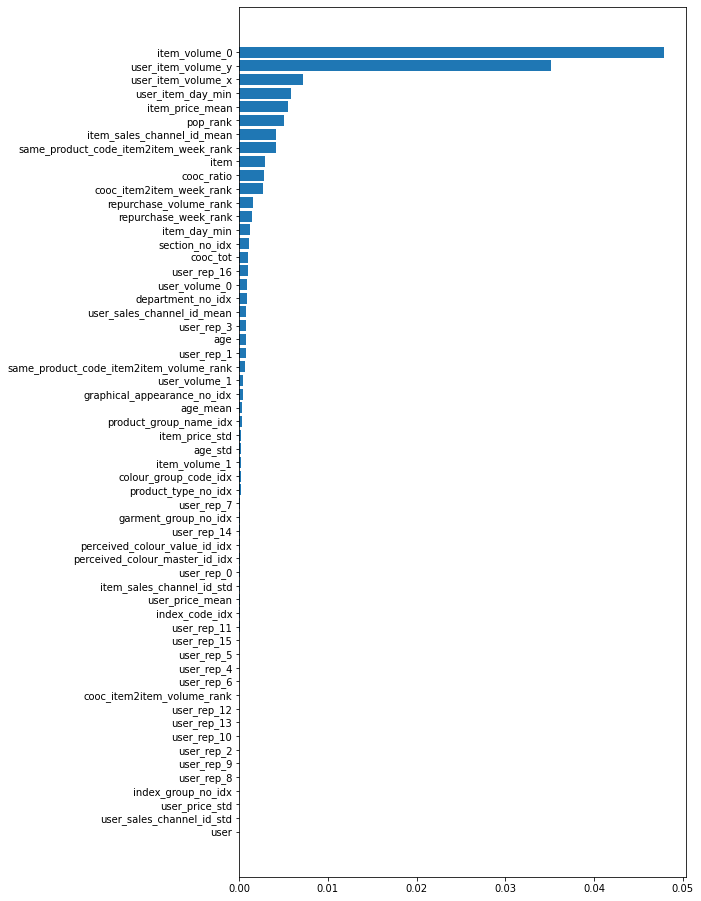

In [25]:
feature_importance = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 16))
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [26]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.030478268775080482
